Step 1) Import required packages

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

Step 2) Get crime data for London Boroughs

In [2]:
#Bring in crime data
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f8b9c2cf8fdf45e6a03b3e5e919187d9 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='KmwuJpO98D5Lvx3JZBLbIczovRax7G1QBePI7a5efsOe',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_f8b9c2cf8fdf45e6a03b3e5e919187d9.get_object(Bucket='projectone-donotdelete-pr-crve2nrr9kgbsj',Key='london-borough-profiles - Copy.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_data_1 = pd.read_csv(body)
df_data_1.head()

,Area_name,Crime_rates_per_thousand_population_2014/15
0,Barking and Dagenham,83.4
1,Barnet,62.7
2,Bexley,51.8
3,Brent,78.8
4,Bromley,64.1


Step 3) Get from Foursquare API for information about police stations in London

In [3]:
#Foursquare Details
CLIENT_ID = 'Y4GYI3NAVZKQ5TMIOXHFKGGF3DTTTHTZCMUXAQMEUALATEBH' # your Foursquare ID
CLIENT_SECRET = '05GEY4PUU01TDWHEXFOJGRXZ4WFNPUYM0BMHDKRKJ2WSE0U4' # your Foursquare Secret
VERSION = '20180604'


geolocator = Nominatim(user_agent="foursquare_agent")
search_query = 'Police Station'
radius = 15000
LIMIT = 50

#Run Foursquare request multiple times for each London Borough to get more than 50 results, which is limit 

dataframe = pd.DataFrame()
PSdf3 = pd.DataFrame()

for n in df_data_1['Area_name']:
    address = n + ', UK'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    PS  = requests.get(url).json()
    PSjson = PS['response']['venues']
    PSdf = json_normalize(PSjson)
    dataframe = dataframe.append(PSdf)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Step 4) Filter and manipulate data so that it is useable

In [4]:
# keep only columns that include Station name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

filly = dataframe_filtered['categories']== 'Police Station'

dataframe_filtered = dataframe_filtered[filly]


#Get rid of duplicates which may have occured from when multiple API request were ran
dataframe_filtered2 = dataframe_filtered.drop_duplicates(subset=['name'], keep='first')
dataframe_filtered2

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Dagenham Police Station,Police Station,561 Rainham Rd S,GB,Dagenham,United Kingdom,NaN,1431,"[561 Rainham Rd S, Dagenham, Greater London, R...","[{'label': 'display', 'lat': 51.545315, 'lng':...",51.545315,0.165581,NaN,RM10 7TU,Greater London,4e1c1e5da809bd1305c268ef
1,Bow Police Station,Police Station,111-117 Bow Rd,GB,Bow,United Kingdom,NaN,12430,"[111-117 Bow Rd, Bow, Greater London, E3 2AN, ...","[{'label': 'display', 'lat': 51.527485, 'lng':...",51.527485,-0.023856,NaN,E3 2AN,Greater London,4bcd85ab8920b7134ace9fdc
2,Romford Police Station,Police Station,19 Main Rd,GB,Romford,United Kingdom,NaN,3966,"[19 Main Rd, Romford, Greater London, RM1 3BJ,...","[{'label': 'display', 'lat': 51.58181659002195...",51.581817,0.186574,NaN,RM1 3BJ,Greater London,4b81ba30f964a52050ba30e3
3,Ilford Police Station,Police Station,270-294 High Rd,GB,Ilford,United Kingdom,NaN,4940,"[270-294 High Rd, Ilford, Greater London, IG1 ...","[{'label': 'display', 'lat': 51.56045882569174...",51.560459,0.079860,NaN,IG1 1GT,Greater London,4c60483190b2c9b6ff613c22
4,Bethnal Green Police Station,Police Station,12 Victoria Pk Sq,GB,Bethnal Green,United Kingdom,NaN,14452,"[12 Victoria Pk Sq, Bethnal Green, Greater Lon...","[{'label': 'display', 'lat': 51.52819001701281...",51.528190,-0.054036,NaN,E14 3NZ,Greater London,4c59937c6407d13ad67cb228
5,Peckham Police Station,Police Station,177 High St,GB,Peckham,United Kingdom,NaN,17315,"[177 High St, Peckham, Greater London, SE15 5S...","[{'label': 'display', 'lat': 51.47416621296672...",51.474166,-0.063901,NaN,SE15 5SL,Greater London,4c1f8fc5b306c928889a68b7
6,Edmonton Police Station,Police Station,462 Fore St,GB,Edmonton,United Kingdom,NaN,16487,"[462 Fore St, Edmonton, Greater London, N9 0PW...","[{'label': 'display', 'lat': 51.6223247007364,...",51.622325,-0.061098,NaN,N9 0PW,Greater London,4c37aa241e06d13a1561763e
7,Plumstead Police Station,Police Station,200 High St,GB,Plumstead,United Kingdom,NaN,8448,"[200 High St, Plumstead, Greater London, SE18 ...","[{'label': 'display', 'lat': 51.48631444885517...",51.486314,0.095710,NaN,SE18 1JY,Greater London,4f07376ee4b0540ca0cdcae2
9,Forest Gate Police Station,Police Station,350-360 Romford Rd,GB,Forest Gate,United Kingdom,NaN,8302,"[350-360 Romford Rd, Forest Gate, Greater Lond...","[{'label': 'display', 'lat': 51.54694340963473...",51.546943,0.031118,NaN,E7 8BS,Greater London,4e5fe9bf18a8ce02fbbd66ee
12,Hornchurch Police Station,Police Station,74 Station Ln.,GB,Hornchurch,United Kingdom,NaN,4884,"[74 Station Ln., Hornchurch, Greater London, R...","[{'label': 'display', 'lat': 51.559113, 'lng':...",51.559113,0.220621,NaN,RM12 6NA,Greater London,4e7a119efa7600c1002d9106


Step 5) Get GEOJSON data for London Boroughs

In [5]:
#Bring GEOJson data for London Boroughs
#Data downloaded locoally and then copied in
geom2 = {"type": "FeatureCollection", "features": [{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.148209,51.599635],[0.148199,51.599632],[0.147274,51.599029],[0.144452,51.597322],[0.143582,51.596786],[0.141744,51.595651],[0.139051,51.594025],[0.138701,51.593859],[0.138041,51.593529],[0.134815,51.591955],[0.133724,51.591438],[0.132193,51.59069],[0.13117,51.590239],[0.131206,51.590118],[0.131373,51.589696],[0.131482,51.589537],[0.131734,51.589084],[0.131914,51.588786],[0.132077,51.588547],[0.132275,51.588305],[0.132653,51.587687],[0.131125,51.587433],[0.131146,51.587378],[0.128039,51.586885],[0.129025,51.584624],[0.128917,51.584113],[0.129322,51.584103],[0.129677,51.58344],[0.129556,51.5825],[0.129369,51.582359],[0.129277,51.581816],[0.129318,51.581813],[0.130865,51.58169],[0.134205,51.581495],[0.134249,51.581391],[0.1343,51.58127],[0.134578,51.581076],[0.134484,51.580996],[0.134681,51.580797],[0.134797,51.580808],[0.135158,51.580143],[0.13248,51.579573],[0.132346,51.579254],[0.132454,51.57927],[0.132661,51.578881],[0.132562,51.578855],[0.132728,51.578528],[0.132871,51.578251],[0.133021,51.577576],[0.133295,51.577261],[0.132169,51.576861],[0.130874,51.576474],[0.130921,51.576187],[0.131001,51.575864],[0.13103,51.575342],[0.130974,51.574451],[0.131022,51.574314],[0.131083,51.574057],[0.131224,51.573872],[0.13158,51.573235],[0.131668,51.57327],[0.132549,51.573619],[0.133198,51.572014],[0.131638,51.571797],[0.13149,51.571776],[0.131672,51.571392],[0.131681,51.571168],[0.131665,51.570932],[0.131659,51.570829],[0.131916,51.570881],[0.132025,51.570875],[0.132094,51.57082],[0.132106,51.570719],[0.132097,51.570501],[0.132007,51.570186],[0.131847,51.569848],[0.131687,51.569524],[0.131447,51.569202],[0.131325,51.569001],[0.131254,51.568809],[0.13124,51.568563],[0.131292,51.568356],[0.131316,51.56828],[0.131393,51.568037],[0.131018,51.56682],[0.131002,51.56671],[0.130988,51.566628],[0.130684,51.56662],[0.13031,51.566585],[0.129992,51.56654],[0.129669,51.566446],[0.129305,51.566291],[0.129033,51.566118],[0.128813,51.565864],[0.128633,51.56567],[0.128406,51.565477],[0.128081,51.565264],[0.127376,51.564879],[0.1271,51.564701],[0.126842,51.564543],[0.126582,51.564406],[0.126628,51.564519],[0.126369,51.564375],[0.12159,51.563464],[0.121277,51.563412],[0.121139,51.563374],[0.120948,51.563314],[0.120671,51.563243],[0.120511,51.562908],[0.121389,51.56267],[0.120337,51.561128],[0.119117,51.55934],[0.119459,51.559209],[0.119875,51.559101],[0.120546,51.558971],[0.122125,51.558719],[0.120575,51.557525],[0.119715,51.557523],[0.119633,51.557566],[0.11877,51.557565],[0.118789,51.55707],[0.114965,51.557495],[0.114777,51.557008],[0.114361,51.556697],[0.115768,51.555979],[0.115825,51.555758],[0.116378,51.555481],[0.113995,51.553689],[0.11399,51.553176],[0.113495,51.552786],[0.112696,51.552644],[0.111753,51.552723],[0.110057,51.552859],[0.109906,51.552234],[0.109736,51.552249],[0.109609,51.552248],[0.109489,51.552234],[0.109236,51.552164],[0.109031,51.552093],[0.108778,51.551896],[0.108181,51.551418],[0.107818,51.551135],[0.107154,51.550639],[0.106871,51.550445],[0.106581,51.550286],[0.106205,51.550113],[0.10586,51.549984],[0.105648,51.549924],[0.105264,51.549821],[0.104826,51.549711],[0.104274,51.549595],[0.104151,51.549536],[0.10386,51.549396],[0.102949,51.549108],[0.102349,51.54894],[0.101908,51.548793],[0.101649,51.548698],[0.101285,51.548552],[0.100972,51.548408],[0.1001,51.547946],[0.099659,51.547757],[0.099399,51.5476],[0.099051,51.54746],[0.098222,51.547156],[0.097946,51.547023],[0.097189,51.54673],[0.096704,51.546579],[0.095967,51.546333],[0.095689,51.546226],[0.09542,51.54612],[0.0951,51.54597],[0.094858,51.546194],[0.094591,51.546834],[0.094456,51.547386],[0.094227,51.548029],[0.094074,51.548405],[0.094013,51.548527],[0.093976,51.548631],[0.093952,51.548737],[0.093943,51.548841],[0.093945,51.548928],[0.093972,51.549064],[0.094147,51.549523],[0.094166,51.549715],[0.094174,51.549783],[0.094052,51.54975],[0.093983,51.549718],[0.093741,51.549607],[0.09365,51.549558],[0.093471,51.549398],[0.09333,51.549247],[0.093299,51.549204],[0.09325,51.549108],[0.093155,51.548973],[0.093125,51.548867],[0.093226,51.548618],[0.093239,51.548567],[0.093211,51.548488],[0.093111,51.548438],[0.092627,51.548395],[0.092452,51.548354],[0.092339,51.548288],[0.092233,51.548176],[0.092095,51.54812],[0.091685,51.548109],[0.091567,51.548092],[0.09143,51.548047],[0.091428,51.548047],[0.09087,51.547966],[0.090127,51.547882],[0.089561,51.547817],[0.088273,51.547661],[0.087878,51.547605],[0.087661,51.547549],[0.087308,51.547418],[0.086762,51.547113],[0.086195,51.546849],[0.086021,51.546779],[0.085753,51.546675],[0.085478,51.546577],[0.084996,51.546416],[0.084899,51.546378],[0.08464,51.546263],[0.084123,51.545991],[0.083955,51.545909],[0.083723,51.545826],[0.083646,51.545806],[0.083574,51.545791],[0.083427,51.545792],[0.083333,51.545779],[0.083251,51.545759],[0.08319,51.545735],[0.083161,51.54572],[0.083215,51.545593],[0.083216,51.545591],[0.083246,51.545491],[0.083203,51.545373],[0.082757,51.545257],[0.081743,51.544972],[0.081036,51.544764],[0.080341,51.544609],[0.080077,51.544503],[0.079854,51.544385],[0.079571,51.544262],[0.079402,51.544384],[0.079245,51.544581],[0.079129,51.544751],[0.078719,51.544617],[0.078496,51.544791],[0.078396,51.54475],[0.078065,51.544613],[0.07767,51.544412],[0.0774,51.544311],[0.077167,51.544245],[0.076565,51.544156],[0.076113,51.544082],[0.075732,51.54405],[0.075246,51.544023],[0.075119,51.544023],[0.07495,51.544012],[0.074907,51.543918],[0.074688,51.543935],[0.074624,51.543992],[0.074609,51.544006],[0.074238,51.544015],[0.074187,51.54405],[0.073639,51.544037],[0.073572,51.543936],[0.073558,51.543919],[0.073429,51.543765],[0.072818,51.543858],[0.072605,51.543989],[0.071983,51.5441],[0.071346,51.544239],[0.071269,51.544256],[0.071228,51.544263],[0.071178,51.544272],[0.071087,51.544289],[0.070998,51.544305],[0.070735,51.544354],[0.070746,51.544435],[0.069958,51.544591],[0.069917,51.544469],[0.069913,51.544463],[0.06979,51.544159],[0.069581,51.543785],[0.069331,51.543384],[0.069119,51.543],[0.069073,51.542917],[0.068877,51.542605],[0.068679,51.542344],[0.068486,51.541924],[0.068455,51.54185],[0.068427,51.541777],[0.068402,51.541702],[0.06838,51.541627],[0.068362,51.541552],[0.068346,51.541477],[0.068338,51.54144],[0.068328,51.541364],[0.06832,51.541288],[0.068316,51.541212],[0.068314,51.541136],[0.068315,51.54106],[0.068318,51.540984],[0.068321,51.540909],[0.068322,51.540893],[0.068329,51.540783],[0.068339,51.540672],[0.068356,51.540562],[0.068377,51.540474],[0.068394,51.54041],[0.068416,51.540346],[0.06844,51.540283],[0.068468,51.54022],[0.068496,51.540157],[0.068528,51.540096],[0.06856,51.540033],[0.068593,51.539971],[0.068605,51.539948],[0.06866,51.539851],[0.068719,51.539754],[0.068781,51.539659],[0.068847,51.539564],[0.068915,51.53947],[0.068989,51.539378],[0.069064,51.539286],[0.069104,51.539241],[0.06975,51.538505],[0.070267,51.537915],[0.070605,51.537739],[0.070714,51.537513],[0.070604,51.537467],[0.070657,51.53739],[0.070176,51.53704],[0.069992,51.537046],[0.069924,51.536761],[0.069859,51.536596],[0.069744,51.536507],[0.069688,51.536471],[0.069612,51.536424],[0.069515,51.53636],[0.069572,51.536297],[0.069761,51.536369],[0.069824,51.536392],[0.069844,51.536397],[0.069866,51.5364],[0.069887,51.536404],[0.069908,51.536407],[0.06993,51.53641],[0.069952,51.536412],[0.069975,51.536413],[0.069997,51.536414],[0.070007,51.536415],[0.070028,51.536414],[0.070051,51.536414],[0.070073,51.536413],[0.070095,51.536412],[0.070118,51.53641],[0.070139,51.536407],[0.070161,51.536405],[0.070182,51.536402],[0.070205,51.536398],[0.070222,51.536395],[0.070248,51.53639],[0.070275,51.536384],[0.070301,51.536377],[0.070326,51.53637],[0.070352,51.536364],[0.070355,51.536363],[0.070359,51.536362],[0.070386,51.536353],[0.070417,51.536344],[0.070447,51.536332],[0.070477,51.536321],[0.070505,51.53631],[0.070531,51.536299],[0.071079,51.53644],[0.071091,51.536438],[0.071104,51.536436],[0.071115,51.536433],[0.071125,51.53643],[0.071135,51.536426],[0.071146,51.536422],[0.071158,51.536419],[0.071168,51.536414],[0.071178,51.536409],[0.071186,51.536405],[0.071196,51.5364],[0.071206,51.536393],[0.071213,51.536388],[0.071221,51.536381],[0.071228,51.536374],[0.071236,51.536368],[0.07125,51.536354],[0.071257,51.536348],[0.071261,51.536344],[0.071282,51.536323],[0.071302,51.536302],[0.071323,51.536281],[0.071341,51.536259],[0.071359,51.536237],[0.071375,51.536214],[0.071391,51.536191],[0.071405,51.536169],[0.071418,51.536145],[0.07143,51.536122],[0.07144,51.536098],[0.071449,51.536074],[0.071456,51.536056],[0.072124,51.53499],[0.07285,51.533919],[0.073254,51.533222],[0.073357,51.533],[0.073622,51.53302],[0.073954,51.532391],[0.07413,51.531857],[0.074261,51.53141],[0.07431,51.531116],[0.074336,51.53096],[0.074353,51.530854],[0.074409,51.530284],[0.07443,51.529794],[0.074432,51.529713],[0.074442,51.529431],[0.07479,51.529554],[0.074885,51.529593],[0.075878,51.529853],[0.07616,51.529944],[0.076337,51.529928],[0.0769,51.530118],[0.07709,51.530043],[0.077155,51.529942],[0.077169,51.529902],[0.077231,51.529817],[0.077503,51.529791],[0.077814,51.529777],[0.078043,51.529616],[0.078326,51.529575],[0.078662,51.529537],[0.078889,51.529524],[0.07939,51.529529],[0.079579,51.529526],[0.079634,51.529518],[0.079734,51.529495],[0.079831,51.529468],[0.079925,51.529434],[0.080082,51.529362],[0.080349,51.529192],[0.080753,51.528884],[0.081533,51.528241],[0.081649,51.528128],[0.081744,51.528062],[0.081924,51.527972],[0.082183,51.527829],[0.08248,51.527731],[0.083079,51.52756],[0.083654,51.527413],[0.084256,51.527277],[0.084311,51.52726],[0.084433,51.527214],[0.0846,51.527135],[0.085298,51.526861],[0.085727,51.526597],[0.086296,51.526264],[0.086402,51.526211],[0.086516,51.526164],[0.086606,51.526132],[0.086715,51.526101],[0.086861,51.526068],[0.087461,51.52598],[0.08765,51.525988],[0.087827,51.526009],[0.087949,51.526033],[0.088035,51.526054],[0.088361,51.526155],[0.088968,51.526371],[0.089584,51.526604],[0.089776,51.526657],[0.089864,51.526675],[0.090096,51.526698],[0.090322,51.526694],[0.090448,51.526658],[0.090449,51.526658],[0.090792,51.526664],[0.090862,51.526664],[0.091034,51.52665],[0.091164,51.526621],[0.091276,51.526579],[0.091483,51.526463],[0.091565,51.526407],[0.09176,51.526251],[0.091821,51.526212],[0.091906,51.526168],[0.092005,51.526127],[0.092092,51.526099],[0.092196,51.526076],[0.092309,51.526056],[0.092409,51.526047],[0.092511,51.526041],[0.09264,51.526044],[0.092792,51.526058],[0.092912,51.526077],[0.093083,51.526117],[0.093257,51.526141],[0.093436,51.526145],[0.09354,51.526138],[0.093641,51.526124],[0.093737,51.526104],[0.093835,51.526072],[0.093921,51.526034],[0.094145,51.525916],[0.094231,51.525852],[0.094267,51.525816],[0.094298,51.525769],[0.094396,51.525541],[0.094446,51.525351],[0.094427,51.52506],[0.094035,51.523675],[0.093992,51.523208],[0.094061,51.522917],[0.094082,51.522694],[0.094201,51.522556],[0.094763,51.52207],[0.095492,51.52152],[0.096244,51.520972],[0.096356,51.520901],[0.096418,51.520849],[0.096486,51.520783],[0.096543,51.520711],[0.096579,51.52065],[0.096614,51.520564],[0.09664,51.52047],[0.096648,51.520391],[0.096646,51.520314],[0.096632,51.520236],[0.096608,51.520159],[0.096573,51.520084],[0.096526,51.520005],[0.096295,51.518759],[0.096242,51.518594],[0.096209,51.51843],[0.096195,51.518307],[0.096209,51.51806],[0.096256,51.517858],[0.096363,51.517604],[0.096511,51.517224],[0.096655,51.517035],[0.096761,51.516914],[0.096884,51.516785],[0.097113,51.516575],[0.097204,51.516501],[0.097455,51.51633],[0.097999,51.516033],[0.0987,51.515802],[0.099249,51.515636],[0.099717,51.515374],[0.100223,51.515091],[0.100713,51.514834],[0.101431,51.514656],[0.101365,51.513756],[0.101339,51.512072],[0.102512,51.512089],[0.104037,51.51191],[0.105113,51.511815],[0.106277,51.511771],[0.107385,51.511712],[0.107754,51.511697],[0.108251,51.511676],[0.108814,51.511677],[0.109297,51.511689],[0.109615,51.511712],[0.109822,51.511732],[0.110551,51.511822],[0.111423,51.511935],[0.111864,51.511998],[0.112816,51.51223],[0.113646,51.512448],[0.11406,51.512547],[0.115406,51.512852],[0.116122,51.513005],[0.116777,51.513134],[0.117704,51.513265],[0.118224,51.513315],[0.119327,51.513584],[0.119932,51.513757],[0.12094,51.51414],[0.121615,51.514397],[0.122074,51.514555],[0.122403,51.514662],[0.122739,51.514761],[0.123218,51.514893],[0.123457,51.514954],[0.123873,51.515054],[0.124572,51.515234],[0.125008,51.515324],[0.125498,51.515414],[0.126032,51.515495],[0.126847,51.515598],[0.126905,51.515604],[0.126917,51.515604],[0.127932,51.515639],[0.128644,51.515679],[0.129351,51.515707],[0.129866,51.515715],[0.130443,51.515705],[0.130639,51.515698],[0.132164,51.515604],[0.13343,51.51546],[0.134333,51.515379],[0.135232,51.515176],[0.137564,51.514767],[0.138484,51.514542],[0.139628,51.514246],[0.14068,51.513938],[0.141563,51.513582],[0.14251,51.513221],[0.14397,51.51266],[0.145089,51.51218],[0.146178,51.511761],[0.148498,51.510893],[0.149732,51.510537],[0.150837,51.510258],[0.151578,51.510071],[0.152744,51.509851],[0.154251,51.509533],[0.154899,51.509426],[0.156309,51.509255],[0.158044,51.509044],[0.159586,51.508935],[0.159892,51.510196],[0.160134,51.511269],[0.160349,51.512364],[0.160415,51.512673],[0.160546,51.51337],[0.160585,51.513758],[0.16084,51.51452],[0.161299,51.515865],[0.161451,51.516239],[0.161586,51.516451],[0.161772,51.51694],[0.16208,51.51762],[0.162117,51.517702],[0.16229,51.518043],[0.162427,51.518321],[0.162684,51.51884],[0.162824,51.519041],[0.163037,51.519603],[0.163413,51.520411],[0.163879,51.521483],[0.163941,51.521664],[0.163977,51.521859],[0.163979,51.521932],[0.163971,51.521997],[0.163885,51.522245],[0.163872,51.52232],[0.163878,51.522382],[0.1639,51.522444],[0.163956,51.522529],[0.164201,51.523058],[0.164317,51.523218],[0.16436,51.523294],[0.164453,51.523689],[0.16458,51.524055],[0.164755,51.524337],[0.165061,51.524698],[0.16516,51.524968],[0.165321,51.525179],[0.165351,51.525307],[0.165341,51.525385],[0.165349,51.525429],[0.165383,51.525502],[0.165433,51.525552],[0.165497,51.52559],[0.165599,51.525677],[0.165659,51.525757],[0.165685,51.525816],[0.165698,51.525875],[0.165693,51.525924],[0.165645,51.526036],[0.165626,51.526125],[0.16562,51.526194],[0.165624,51.526237],[0.165639,51.526287],[0.16569,51.526379],[0.166,51.526775],[0.166092,51.526902],[0.166085,51.527232],[0.166231,51.527426],[0.166317,51.527494],[0.166533,51.52765],[0.16662,51.527723],[0.166707,51.527813],[0.166785,51.527911],[0.166896,51.528098],[0.166962,51.52828],[0.167072,51.528503],[0.167105,51.528549],[0.167156,51.528603],[0.167239,51.528671],[0.167625,51.528973],[0.168099,51.529261],[0.168148,51.529434],[0.168151,51.529544],[0.16816,51.52957],[0.168179,51.529602],[0.168254,51.529692],[0.168349,51.529793],[0.168427,51.529854],[0.168476,51.529884],[0.168621,51.529958],[0.168724,51.529997],[0.168847,51.530016],[0.168901,51.530032],[0.168972,51.530059],[0.169027,51.530088],[0.169061,51.530113],[0.169165,51.530233],[0.169236,51.530359],[0.169335,51.530458],[0.16938,51.530514],[0.169449,51.530626],[0.169512,51.530782],[0.169556,51.530846],[0.169617,51.530913],[0.169688,51.530969],[0.169764,51.531014],[0.169826,51.531042],[0.169895,51.531069],[0.170129,51.531136],[0.170179,51.531161],[0.170199,51.531181],[0.170232,51.531233],[0.170287,51.531361],[0.170331,51.531411],[0.170458,51.531493],[0.170883,51.531705],[0.171661,51.532327],[0.172175,51.532678],[0.172447,51.532852],[0.172744,51.533245],[0.172944,51.533462],[0.173085,51.533732],[0.173173,51.533857],[0.173339,51.534039],[0.173478,51.534266],[0.173525,51.534352],[0.173555,51.534423],[0.173567,51.534479],[0.173573,51.534569],[0.173552,51.534791],[0.173562,51.534934],[0.173586,51.535109],[0.173632,51.535189],[0.173683,51.535245],[0.173758,51.535307],[0.173903,51.535539],[0.174047,51.535818],[0.174209,51.536081],[0.174753,51.536638],[0.175034,51.537011],[0.175424,51.53758],[0.175562,51.537781],[0.176072,51.538259],[0.176313,51.538456],[0.17645,51.538555],[0.176596,51.53865],[0.176721,51.538724],[0.177173,51.538967],[0.177693,51.539223],[0.177822,51.539298],[0.177973,51.539368],[0.178718,51.53963],[0.178901,51.539684],[0.179033,51.539711],[0.17917,51.539727],[0.179303,51.539733],[0.179368,51.539733],[0.179545,51.539701],[0.179584,51.539703],[0.179706,51.539727],[0.17976,51.539744],[0.179821,51.539772],[0.179919,51.539833],[0.180009,51.5399],[0.180181,51.540061],[0.18035,51.540195],[0.180469,51.540272],[0.180681,51.54039],[0.180877,51.540511],[0.180899,51.540533],[0.18091,51.540561],[0.180914,51.540613],[0.180903,51.540709],[0.18092,51.540747],[0.181031,51.540886],[0.181122,51.541052],[0.181194,51.541287],[0.181262,51.541372],[0.181294,51.541433],[0.181323,51.541533],[0.181314,51.541729],[0.181284,51.541814],[0.181281,51.541854],[0.181298,51.541919],[0.181358,51.541993],[0.181366,51.54204],[0.181339,51.542111],[0.181261,51.542201],[0.18124,51.542233],[0.181219,51.542306],[0.181216,51.542461],[0.181223,51.542547],[0.181244,51.542662],[0.181286,51.542818],[0.181331,51.542944],[0.181469,51.543228],[0.181473,51.543254],[0.181464,51.543342],[0.181469,51.543381],[0.181485,51.543423],[0.181551,51.543502],[0.181617,51.54356],[0.181746,51.543801],[0.181804,51.543939],[0.181883,51.544039],[0.182098,51.54429],[0.182186,51.54437],[0.182474,51.5446],[0.182658,51.544712],[0.182937,51.544932],[0.183018,51.545007],[0.183168,51.545182],[0.183366,51.545378],[0.183968,51.54583],[0.184394,51.546035],[0.184595,51.546168],[0.184946,51.546316],[0.185059,51.546369],[0.185269,51.546491],[0.185491,51.546592],[0.185933,51.546801],[0.186711,51.547214],[0.186982,51.547294],[0.187223,51.547331],[0.187428,51.547394],[0.187543,51.547505],[0.18764,51.547711],[0.187741,51.547831],[0.187903,51.547979],[0.188152,51.548356],[0.18826,51.548563],[0.188474,51.549083],[0.188734,51.549536],[0.188856,51.549645],[0.188897,51.549805],[0.188917,51.549855],[0.189057,51.550106],[0.189085,51.55018],[0.189107,51.550249],[0.189128,51.550378],[0.190017,51.550934],[0.190553,51.551301],[0.190695,51.551402],[0.190871,51.551584],[0.190979,51.551607],[0.191162,51.551632],[0.191264,51.551692],[0.191309,51.551807],[0.191321,51.551956],[0.191357,51.552121],[0.191452,51.552276],[0.1916,51.552414],[0.191696,51.552534],[0.191661,51.552631],[0.191669,51.552667],[0.191682,51.552704],[0.191825,51.552855],[0.191719,51.552935],[0.191575,51.553004],[0.191311,51.553297],[0.191151,51.553367],[0.190955,51.553418],[0.190882,51.553448],[0.190816,51.55348],[0.190702,51.553575],[0.190635,51.553618],[0.190564,51.553655],[0.190407,51.553707],[0.190259,51.553795],[0.19018,51.553907],[0.190152,51.55403],[0.189869,51.554182],[0.189674,51.554207],[0.189529,51.554255],[0.189472,51.554331],[0.189527,51.554399],[0.189626,51.554434],[0.189684,51.55453],[0.1896,51.554601],[0.189436,51.554628],[0.189259,51.554632],[0.189177,51.554702],[0.189133,51.554817],[0.189199,51.554893],[0.189304,51.55495],[0.189353,51.555026],[0.189255,51.555209],[0.189219,51.555305],[0.189106,51.5554],[0.189013,51.555525],[0.188822,51.555658],[0.188647,51.555721],[0.188605,51.555803],[0.188589,51.555918],[0.188536,51.555959],[0.188474,51.555997],[0.1881,51.556063],[0.187986,51.556133],[0.187874,51.556318],[0.1876,51.556424],[0.187515,51.556514],[0.187314,51.556559],[0.187093,51.556584],[0.186572,51.556549],[0.186387,51.556602],[0.186391,51.556681],[0.186379,51.556807],[0.186437,51.556807],[0.186578,51.556831],[0.186658,51.556907],[0.186664,51.556995],[0.186518,51.557046],[0.186398,51.557216],[0.186422,51.557314],[0.186473,51.557385],[0.186423,51.557471],[0.186321,51.5576],[0.186155,51.557704],[0.186052,51.557813],[0.186047,51.55785],[0.186052,51.557933],[0.186062,51.55798],[0.186095,51.558068],[0.186046,51.558137],[0.186091,51.558252],[0.186159,51.558351],[0.186215,51.558472],[0.186192,51.558585],[0.186227,51.55866],[0.186225,51.558712],[0.186194,51.558869],[0.186227,51.558899],[0.186419,51.559042],[0.186448,51.55914],[0.186466,51.5594],[0.186402,51.559483],[0.186364,51.559565],[0.186385,51.559636],[0.186348,51.55974],[0.186357,51.559854],[0.186405,51.559988],[0.186411,51.560029],[0.186354,51.560134],[0.186249,51.560247],[0.186207,51.560352],[0.186185,51.56039],[0.185802,51.560525],[0.18579,51.560529],[0.185225,51.560745],[0.185052,51.560907],[0.184778,51.561111],[0.184586,51.56121],[0.184497,51.561278],[0.184413,51.561347],[0.184343,51.561456],[0.184263,51.561488],[0.184412,51.561827],[0.184647,51.562241],[0.184952,51.562778],[0.184981,51.56283],[0.185369,51.563413],[0.185465,51.563674],[0.185581,51.563983],[0.185645,51.564088],[0.185672,51.564114],[0.185949,51.564359],[0.186053,51.564441],[0.186725,51.564975],[0.186683,51.565124],[0.186683,51.565186],[0.186688,51.565247],[0.18673,51.565402],[0.186783,51.5657],[0.185926,51.565227],[0.185456,51.564982],[0.185263,51.564887],[0.185166,51.564846],[0.184933,51.564831],[0.18463,51.564838],[0.18398,51.564907],[0.183568,51.56493],[0.183294,51.564959],[0.183036,51.564928],[0.182751,51.564917],[0.182152,51.565001],[0.181818,51.565031],[0.180938,51.565049],[0.180576,51.565085],[0.18026,51.565103],[0.179328,51.565045],[0.179012,51.565004],[0.178252,51.564959],[0.177901,51.56493],[0.177659,51.564931],[0.177404,51.564963],[0.177036,51.564996],[0.176269,51.565109],[0.175435,51.565252],[0.175032,51.565276],[0.174687,51.565146],[0.174498,51.565058],[0.17419,51.565026],[0.173743,51.564995],[0.173511,51.564946],[0.173075,51.564843],[0.172872,51.56479],[0.172223,51.564542],[0.171997,51.564477],[0.17178,51.564384],[0.171671,51.564343],[0.171555,51.564305],[0.171291,51.564229],[0.171062,51.564148],[0.170798,51.564026],[0.170622,51.563923],[0.170445,51.563846],[0.17024,51.563778],[0.170137,51.563755],[0.169964,51.563709],[0.169571,51.563672],[0.169165,51.563614],[0.168774,51.56359],[0.168363,51.563534],[0.168193,51.563486],[0.168028,51.563435],[0.167849,51.56336],[0.167673,51.563283],[0.16738,51.563142],[0.16671,51.562909],[0.166409,51.562782],[0.166009,51.562643],[0.16557,51.562462],[0.165064,51.562296],[0.164608,51.56213],[0.164348,51.562041],[0.164218,51.562001],[0.164216,51.562001],[0.164053,51.561965],[0.163496,51.561777],[0.163371,51.561828],[0.163188,51.561946],[0.163007,51.562032],[0.162899,51.562067],[0.162547,51.562167],[0.162374,51.56223],[0.162279,51.562325],[0.162206,51.562456],[0.162123,51.562536],[0.16202,51.562608],[0.161839,51.562706],[0.161703,51.562799],[0.161616,51.562981],[0.161576,51.563045],[0.16141,51.563255],[0.161104,51.563402],[0.160784,51.563585],[0.160544,51.56371],[0.160337,51.563842],[0.160116,51.56402],[0.159827,51.564193],[0.159625,51.564158],[0.159554,51.5642],[0.159293,51.564379],[0.158718,51.564693],[0.158335,51.564923],[0.158165,51.565067],[0.157959,51.56521],[0.157837,51.56526],[0.157584,51.565348],[0.157459,51.565385],[0.157225,51.565446],[0.157103,51.565509],[0.15686,51.565647],[0.156739,51.565723],[0.156426,51.565967],[0.156295,51.566062],[0.155917,51.56632],[0.155696,51.566472],[0.15528,51.566786],[0.154817,51.567103],[0.15422,51.567479],[0.154,51.567655],[0.153404,51.56801],[0.153078,51.568168],[0.1529,51.568228],[0.152839,51.568214],[0.152778,51.568194],[0.152623,51.568045],[0.15255,51.567999],[0.152478,51.567959],[0.152397,51.567959],[0.15222,51.56797],[0.152001,51.567999],[0.151882,51.56802],[0.151699,51.568069],[0.151632,51.568136],[0.151599,51.568195],[0.151561,51.568228],[0.151506,51.568256],[0.151442,51.568272],[0.151403,51.568278],[0.151219,51.568281],[0.151063,51.568274],[0.150971,51.568294],[0.150566,51.568638],[0.15039,51.568799],[0.149012,51.568743],[0.148949,51.568847],[0.14888,51.568897],[0.148753,51.568946],[0.148581,51.568954],[0.148401,51.568947],[0.14839,51.569063],[0.1484,51.56914],[0.148463,51.569185],[0.148353,51.569393],[0.148283,51.569594],[0.149811,51.569729],[0.151394,51.569875],[0.151343,51.570061],[0.1513,51.570281],[0.151115,51.570325],[0.150932,51.570452],[0.150769,51.571619],[0.150904,51.571639],[0.150827,51.572122],[0.150602,51.573411],[0.149537,51.573296],[0.149557,51.573312],[0.149677,51.573495],[0.149677,51.573876],[0.149661,51.574105],[0.149659,51.574553],[0.149731,51.574789],[0.149826,51.575243],[0.149846,51.575375],[0.149825,51.575501],[0.149752,51.575802],[0.149677,51.575954],[0.148625,51.575858],[0.148674,51.576553],[0.148799,51.577409],[0.14883,51.577699],[0.148874,51.578105],[0.148959,51.579701],[0.14909,51.580971],[0.150025,51.580932],[0.150185,51.581137],[0.15065,51.581757],[0.151302,51.582534],[0.151634,51.582762],[0.152076,51.583066],[0.152268,51.583241],[0.152434,51.583608],[0.15257,51.583935],[0.152586,51.584361],[0.15263,51.585405],[0.152707,51.586771],[0.152752,51.587873],[0.15284,51.589304],[0.152842,51.589304],[0.152796,51.589681],[0.15279,51.589979],[0.152724,51.590295],[0.152567,51.590684],[0.152368,51.591165],[0.152215,51.591465],[0.152263,51.592458],[0.152312,51.593618],[0.152452,51.593942],[0.152553,51.594653],[0.152687,51.59562],[0.15267,51.59573],[0.152121,51.596419],[0.15171,51.596919],[0.151392,51.597256],[0.149703,51.596579],[0.149728,51.596965],[0.149211,51.596987],[0.149264,51.597134],[0.149415,51.597637],[0.149528,51.598091],[0.149779,51.59923],[0.148209,51.599635]]]]},"properties":{"name":"Barking and Dagenham","cartodb_id":1,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.183361,51.668682],[-0.183383,51.668742],[-0.184222,51.668701],[-0.186209,51.66807],[-0.187372,51.666684],[-0.187886,51.66605],[-0.187808,51.66602],[-0.188751,51.664913],[-0.189363,51.664176],[-0.189426,51.664139],[-0.189554,51.664267],[-0.189602,51.66435],[-0.189644,51.664398],[-0.189689,51.664437],[-0.190006,51.66464],[-0.190135,51.664701],[-0.190302,51.664757],[-0.190463,51.664844],[-0.190622,51.664895],[-0.190759,51.66493],[-0.192417,51.665256],[-0.192418,51.665256],[-0.193584,51.66542],[-0.195068,51.665689],[-0.194466,51.666563],[-0.194026,51.667266],[-0.193741,51.667706],[-0.193713,51.667823],[-0.193271,51.668497],[-0.194044,51.668625],[-0.194578,51.668721],[-0.195033,51.668338],[-0.195355,51.668353],[-0.195779,51.668379],[-0.197015,51.668401],[-0.197129,51.668403],[-0.197274,51.668398],[-0.197424,51.668398],[-0.197532,51.668698],[-0.197623,51.668929],[-0.19777,51.669204],[-0.197925,51.669561],[-0.198095,51.670055],[-0.198291,51.670362],[-0.19854,51.670321],[-0.199484,51.670259],[-0.200206,51.670251],[-0.200801,51.670264],[-0.201772,51.670318],[-0.201028,51.669506],[-0.201012,51.669322],[-0.200942,51.669154],[-0.2008,51.66865],[-0.20065,51.667997],[-0.20109,51.668128],[-0.201253,51.668199],[-0.201583,51.668283],[-0.201691,51.668356],[-0.201976,51.668418],[-0.202282,51.668527],[-0.20313,51.668677],[-0.204054,51.668793],[-0.204156,51.668678],[-0.205482,51.667619],[-0.205847,51.66731],[-0.20638,51.666786],[-0.208259,51.667754],[-0.209554,51.667146],[-0.208842,51.666323],[-0.20812,51.665496],[-0.206284,51.663052],[-0.206518,51.662987],[-0.208408,51.662366],[-0.209435,51.662003],[-0.209957,51.661805],[-0.210305,51.661671],[-0.210589,51.661528],[-0.211426,51.662195],[-0.211671,51.662348],[-0.211816,51.662461],[-0.211922,51.662517],[-0.212943,51.662036],[-0.213202,51.661886],[-0.215549,51.66081],[-0.217317,51.660252],[-0.217669,51.660991],[-0.217837,51.660946],[-0.218223,51.660852],[-0.218661,51.660657],[-0.21966,51.660167],[-0.220025,51.659944],[-0.221301,51.659349],[-0.222336,51.658798],[-0.223396,51.658309],[-0.223988,51.658047],[-0.224467,51.657816],[-0.224286,51.657668],[-0.224886,51.657352],[-0.225033,51.657462],[-0.225401,51.657752],[-0.225718,51.658072],[-0.226392,51.658666],[-0.226481,51.658782],[-0.226634,51.659039],[-0.226874,51.659383],[-0.226693,51.659401],[-0.226784,51.659581],[-0.22684,51.659745],[-0.226912,51.660157],[-0.227236,51.66011],[-0.227342,51.660167],[-0.227886,51.660053],[-0.228172,51.65992],[-0.228316,51.659928],[-0.228524,51.659853],[-0.22898,51.659654],[-0.229126,51.659599],[-0.229438,51.659555],[-0.229552,51.65949],[-0.229697,51.659405],[-0.230851,51.658993],[-0.231667,51.658717],[-0.231963,51.658617],[-0.232288,51.658557],[-0.232496,51.658519],[-0.232651,51.658444],[-0.232812,51.658763],[-0.233131,51.659192],[-0.23335,51.659199],[-0.233541,51.65921],[-0.23418,51.659137],[-0.234615,51.659074],[-0.234889,51.659018],[-0.235102,51.658966],[-0.235407,51.658857],[-0.235514,51.658813],[-0.235667,51.658787],[-0.236091,51.658599],[-0.2367,51.658441],[-0.236395,51.65798],[-0.236893,51.657834],[-0.237624,51.65759],[-0.238043,51.657467],[-0.238383,51.657367],[-0.239418,51.657026],[-0.23979,51.657395],[-0.240309,51.65724],[-0.240529,51.657152],[-0.240793,51.657067],[-0.241,51.657017],[-0.241111,51.656991],[-0.241268,51.65697],[-0.241409,51.656961],[-0.24159,51.65696],[-0.241781,51.656938],[-0.24205,51.65688],[-0.242323,51.656792],[-0.242411,51.656773],[-0.242813,51.656687],[-0.243115,51.656504],[-0.243556,51.656323],[-0.244258,51.65611],[-0.244429,51.656058],[-0.244899,51.655873],[-0.245164,51.655769],[-0.246291,51.655438],[-0.24642,51.655569],[-0.246695,51.655757],[-0.246912,51.655839],[-0.247303,51.656045],[-0.247408,51.656136],[-0.247774,51.656248],[-0.248137,51.656362],[-0.248272,51.656259],[-0.248379,51.65623],[-0.248511,51.656241],[-0.248678,51.656333],[-0.248836,51.656291],[-0.248885,51.656271],[-0.249008,51.656248],[-0.249236,51.656121],[-0.249463,51.656],[-0.249579,51.655924],[-0.249633,51.655872],[-0.249676,51.65573],[-0.249678,51.655708],[-0.249606,51.655512],[-0.249682,51.65546],[-0.249758,51.655408],[-0.249571,51.655258],[-0.249473,51.65518],[-0.249317,51.655073],[-0.249217,51.655],[-0.249158,51.654965],[-0.248994,51.654908],[-0.248779,51.65486],[-0.248282,51.654805],[-0.248846,51.652281],[-0.24948,51.649641],[-0.249618,51.649125],[-0.249698,51.648896],[-0.249805,51.648586],[-0.24982,51.648547],[-0.249983,51.648142],[-0.250167,51.647689],[-0.250302,51.647403],[-0.250473,51.647096],[-0.250677,51.646754],[-0.250985,51.646334],[-0.251392,51.645818],[-0.252095,51.644905],[-0.252471,51.644371],[-0.252916,51.643869],[-0.253168,51.643798],[-0.253782,51.643623],[-0.253846,51.643532],[-0.253914,51.643435],[-0.254598,51.643681],[-0.254895,51.643335],[-0.255312,51.642773],[-0.25567,51.642149],[-0.255759,51.642021],[-0.25591,51.642076],[-0.256017,51.642107],[-0.25613,51.642132],[-0.25631,51.642156],[-0.256809,51.642184],[-0.256817,51.642275],[-0.257163,51.64231],[-0.257341,51.642337],[-0.257718,51.642413],[-0.258158,51.642522],[-0.258451,51.642584],[-0.258581,51.642618],[-0.258683,51.642651],[-0.258876,51.642729],[-0.259139,51.642863],[-0.259273,51.642957],[-0.259316,51.643],[-0.259357,51.643059],[-0.259439,51.643235],[-0.259473,51.643291],[-0.25959,51.643442],[-0.259646,51.643532],[-0.259668,51.6436],[-0.259675,51.643785],[-0.259696,51.643865],[-0.259717,51.643898],[-0.259764,51.643951],[-0.259916,51.644084],[-0.260031,51.644182],[-0.260128,51.64425],[-0.260246,51.644308],[-0.260448,51.644387],[-0.260624,51.644474],[-0.260865,51.644615],[-0.26109,51.64477],[-0.261182,51.644822],[-0.261372,51.644912],[-0.261528,51.644971],[-0.261632,51.645002],[-0.261814,51.644781],[-0.26199,51.644514],[-0.262418,51.643937],[-0.262596,51.643979],[-0.262665,51.643876],[-0.262734,51.643772],[-0.262877,51.643895],[-0.262936,51.643944],[-0.262976,51.643993],[-0.263038,51.644026],[-0.263156,51.644042],[-0.263447,51.644107],[-0.263569,51.644134],[-0.263889,51.644183],[-0.264477,51.644199],[-0.265075,51.644237],[-0.265165,51.64423],[-0.265419,51.644174],[-0.26553,51.644182],[-0.265531,51.644182],[-0.265548,51.644189],[-0.265988,51.644122],[-0.26653,51.644025],[-0.266769,51.643982],[-0.266809,51.643807],[-0.266818,51.643767],[-0.266826,51.643677],[-0.266832,51.643444],[-0.266816,51.643245],[-0.266736,51.642953],[-0.266666,51.642525],[-0.266905,51.64247],[-0.267219,51.642425],[-0.267539,51.642398],[-0.26779,51.642377],[-0.267826,51.642417],[-0.267955,51.64238],[-0.268069,51.64234],[-0.268227,51.642292],[-0.268399,51.64226],[-0.26862,51.642227],[-0.268923,51.642236],[-0.269314,51.642214],[-0.269676,51.642202],[-0.270039,51.642241],[-0.270188,51.642264],[-0.270646,51.642262],[-0.271082,51.642252],[-0.271252,51.642254],[-0.271225,51.642126],[-0.271218,51.642047],[-0.271239,51.641964],[-0.2713,51.641884],[-0.271372,51.641759],[-0.271499,51.641425],[-0.271439,51.641287],[-0.271949,51.640496],[-0.272216,51.640061],[-0.272312,51.639845],[-0.272404,51.63971],[-0.272463,51.639534],[-0.272492,51.639386],[-0.272495,51.639362],[-0.272551,51.639316],[-0.272588,51.639284],[-0.272578,51.639192],[-0.272569,51.639104],[-0.272389,51.639035],[-0.27215,51.638953],[-0.272141,51.638863],[-0.272424,51.638893],[-0.273155,51.63893],[-0.273526,51.638952],[-0.273918,51.638977],[-0.27431,51.639],[-0.274903,51.639058],[-0.275166,51.638964],[-0.275415,51.638862],[-0.275751,51.638781],[-0.276202,51.638685],[-0.276369,51.638647],[-0.276648,51.638586],[-0.277041,51.638513],[-0.277447,51.638492],[-0.277823,51.638472],[-0.278456,51.638483],[-0.278835,51.638502],[-0.278952,51.638502],[-0.27982,51.638535],[-0.281341,51.638206],[-0.282303,51.637984],[-0.282688,51.637792],[-0.283056,51.637616],[-0.283486,51.637318],[-0.283601,51.637257],[-0.28393,51.637138],[-0.284421,51.637048],[-0.284912,51.636969],[-0.285342,51.636885],[-0.285659,51.636836],[-0.286217,51.636702],[-0.286508,51.636681],[-0.286773,51.636663],[-0.287548,51.636776],[-0.287684,51.636796],[-0.287818,51.63681],[-0.288335,51.636859],[-0.288981,51.636781],[-0.289786,51.636681],[-0.290147,51.636681],[-0.290298,51.636668],[-0.29045,51.636621],[-0.290596,51.636572],[-0.291745,51.636188],[-0.292006,51.636097],[-0.292512,51.635921],[-0.292813,51.635839],[-0.294558,51.635636],[-0.29564,51.635924],[-0.29615,51.635954],[-0.296648,51.635984],[-0.296907,51.635967],[-0.29711,51.635955],[-0.297171,51.635951],[-0.297234,51.635946],[-0.297836,51.635908],[-0.29802,51.635925],[-0.298068,51.63593],[-0.298285,51.635951],[-0.298509,51.635985],[-0.298613,51.636001],[-0.298744,51.636031],[-0.298884,51.636077],[-0.299025,51.636131],[-0.299075,51.636149],[-0.299334,51.636265],[-0.299512,51.636301],[-0.299657,51.636331],[-0.300189,51.636446],[-0.300844,51.636544],[-0.301154,51.636325],[-0.301352,51.636453],[-0.301404,51.636475],[-0.30145,51.636494],[-0.301486,51.636509],[-0.301611,51.636559],[-0.30177,51.636623],[-0.301977,51.636651],[-0.302216,51.636674],[-0.302402,51.636664],[-0.302568,51.636622],[-0.302709,51.636563],[-0.302757,51.636506],[-0.302859,51.636532],[-0.302891,51.63654],[-0.303458,51.635592],[-0.303982,51.634589],[-0.303993,51.634522],[-0.304006,51.63431],[-0.30382,51.633581],[-0.303345,51.632882],[-0.302922,51.632323],[-0.302362,51.631656],[-0.300947,51.630621],[-0.300594,51.630326],[-0.300246,51.630034],[-0.29959,51.629457],[-0.298951,51.628815],[-0.298561,51.628389],[-0.297663,51.627603],[-0.297076,51.627163],[-0.296435,51.626699],[-0.29612,51.626457],[-0.295683,51.626092],[-0.294315,51.624886],[-0.293596,51.624295],[-0.293287,51.623996],[-0.292771,51.623485],[-0.292278,51.622997],[-0.291558,51.622394],[-0.291084,51.621948],[-0.29008,51.62108],[-0.288007,51.619355],[-0.286683,51.618227],[-0.286415,51.617966],[-0.286105,51.617488],[-0.285972,51.617342],[-0.285259,51.616798],[-0.28441,51.616086],[-0.283714,51.615601],[-0.282817,51.615102],[-0.282592,51.614971],[-0.282369,51.614838],[-0.281819,51.614482],[-0.280606,51.613546],[-0.279888,51.61289],[-0.278556,51.611629],[-0.277746,51.610909],[-0.277152,51.610346],[-0.276343,51.609613],[-0.275721,51.609075],[-0.275542,51.608925],[-0.275059,51.608642],[-0.274851,51.608508],[-0.274443,51.608204],[-0.273961,51.607757],[-0.273678,51.607496],[-0.273338,51.60716],[-0.273299,51.607122],[-0.272213,51.605902],[-0.271376,51.605215],[-0.268652,51.603087],[-0.268485,51.602956],[-0.267141,51.601907],[-0.266853,51.601663],[-0.266021,51.600921],[-0.265561,51.600559],[-0.265457,51.600477],[-0.264559,51.599612],[-0.264136,51.599196],[-0.263593,51.598742],[-0.263166,51.59837],[-0.262681,51.597968],[-0.262282,51.597656],[-0.261782,51.59731],[-0.261087,51.596784],[-0.260804,51.596559],[-0.260307,51.596157],[-0.259046,51.595098],[-0.258175,51.594362],[-0.25665,51.592957],[-0.256444,51.592764],[-0.256095,51.592439],[-0.255825,51.592211],[-0.255433,51.591948],[-0.254034,51.590888],[-0.253165,51.59025],[-0.252693,51.589935],[-0.252235,51.5896],[-0.251751,51.589289],[-0.251565,51.589154],[-0.251477,51.589083],[-0.251212,51.588849],[-0.25077,51.588398],[-0.250472,51.588119],[-0.248754,51.586569],[-0.247374,51.585182],[-0.246938,51.58476],[-0.246688,51.58455],[-0.246907,51.584438],[-0.247188,51.584309],[-0.24755,51.584163],[-0.247929,51.584034],[-0.248125,51.583976],[-0.248389,51.583905],[-0.248658,51.583842],[-0.248933,51.583786],[-0.24914,51.58375],[-0.249562,51.583691],[-0.250072,51.583643],[-0.250448,51.583236],[-0.250708,51.58298],[-0.250821,51.582883],[-0.25094,51.582806],[-0.251289,51.582615],[-0.251547,51.582483],[-0.251616,51.58246],[-0.251821,51.582415],[-0.251944,51.582375],[-0.252096,51.582308],[-0.252234,51.582229],[-0.252403,51.582106],[-0.252527,51.581994],[-0.252739,51.58177],[-0.252784,51.581697],[-0.2528,51.58165],[-0.252798,51.581581],[-0.252754,51.581393],[-0.252739,51.581298],[-0.252723,51.581109],[-0.252716,51.581013],[-0.252721,51.580784],[-0.25274,51.58059],[-0.252777,51.580421],[-0.252834,51.580237],[-0.252889,51.580129],[-0.252991,51.57999],[-0.253018,51.579929],[-0.253035,51.579857],[-0.253036,51.579784],[-0.253017,51.579673],[-0.252869,51.579173],[-0.25282,51.579029],[-0.25265,51.578646],[-0.252507,51.578256],[-0.252483,51.578208],[-0.252349,51.577996],[-0.252054,51.577583],[-0.252002,51.577501],[-0.251974,51.577456],[-0.251832,51.577199],[-0.251758,51.577029],[-0.251638,51.576719],[-0.251339,51.575913],[-0.251223,51.575696],[-0.251195,51.575633],[-0.251121,51.575321],[-0.251028,51.575109],[-0.250758,51.574652],[-0.250533,51.574309],[-0.25037,51.57408],[-0.25023,51.573902],[-0.249847,51.57346],[-0.249777,51.573365],[-0.24976,51.573321],[-0.249771,51.573263],[-0.249794,51.573229],[-0.249834,51.573192],[-0.249896,51.573152],[-0.250102,51.573052],[-0.250264,51.573001],[-0.250523,51.572948],[-0.250719,51.572915],[-0.250924,51.572889],[-0.251045,51.572875],[-0.251295,51.572874],[-0.251375,51.572861],[-0.251424,51.572841],[-0.251456,51.572817],[-0.251506,51.572762],[-0.251535,51.57269],[-0.251536,51.572623],[-0.251511,51.572558],[-0.251489,51.572528],[-0.25144,51.572478],[-0.251193,51.572003],[-0.25116,51.571893],[-0.251126,51.571832],[-0.25108,51.571775],[-0.251025,51.571721],[-0.250955,51.571674],[-0.250796,51.57159],[-0.250438,51.571413],[-0.250165,51.571268],[-0.250016,51.571037],[-0.249849,51.570733],[-0.249808,51.570668],[-0.249771,51.570624],[-0.249692,51.570544],[-0.249623,51.570489],[-0.249567,51.570455],[-0.249346,51.570352],[-0.249293,51.570322],[-0.249237,51.570283],[-0.24916,51.570218],[-0.248732,51.569792],[-0.248472,51.569567],[-0.248189,51.569344],[-0.248103,51.569255],[-0.248035,51.569199],[-0.24798,51.569162],[-0.247833,51.569089],[-0.247734,51.569055],[-0.247463,51.568975],[-0.247404,51.568947],[-0.247175,51.568806],[-0.246931,51.568681],[-0.246601,51.568832],[-0.246185,51.568662],[-0.246044,51.568624],[-0.245965,51.568611],[-0.245897,51.568605],[-0.24576,51.568604],[-0.245621,51.568626],[-0.245494,51.568661],[-0.245456,51.568679],[-0.24542,51.568707],[-0.245403,51.568739],[-0.245405,51.568773],[-0.245428,51.568808],[-0.245488,51.568865],[-0.245552,51.568918],[-0.245686,51.569],[-0.245749,51.569056],[-0.245796,51.569112],[-0.245797,51.569137],[-0.245787,51.569155],[-0.245772,51.569164],[-0.24572,51.569175],[-0.245435,51.569174],[-0.245265,51.569166],[-0.245105,51.569132],[-0.245056,51.56913],[-0.245017,51.569135],[-0.244987,51.569149],[-0.244943,51.569186],[-0.244922,51.569226],[-0.244929,51.56925],[-0.245007,51.569377],[-0.245035,51.56944],[-0.245035,51.569477],[-0.24502,51.569507],[-0.244992,51.569527],[-0.244954,51.569542],[-0.244787,51.569583],[-0.244739,51.569604],[-0.244696,51.569636],[-0.244639,51.569696],[-0.244569,51.56979],[-0.244507,51.569896],[-0.244474,51.569967],[-0.244462,51.570023],[-0.244456,51.570082],[-0.244463,51.57011],[-0.244475,51.570125],[-0.244492,51.570132],[-0.244522,51.570136],[-0.244563,51.570132],[-0.244642,51.570106],[-0.244719,51.570077],[-0.244756,51.570059],[-0.244789,51.570033],[-0.244832,51.569953],[-0.244843,51.569944],[-0.244863,51.56994],[-0.244888,51.569939],[-0.24492,51.569953],[-0.244937,51.569975],[-0.244963,51.570047],[-0.244978,51.570103],[-0.244978,51.570206],[-0.244918,51.570362],[-0.244907,51.570602],[-0.244869,51.570699],[-0.24479,51.570799],[-0.244429,51.571083],[-0.244411,51.571113],[-0.244413,51.571142],[-0.244428,51.57117],[-0.244546,51.571276],[-0.244678,51.571349],[-0.244876,51.571434],[-0.244948,51.571483],[-0.245124,51.571661],[-0.245133,51.571677],[-0.245139,51.571702],[-0.245135,51.571726],[-0.245121,51.571753],[-0.245077,51.571801],[-0.245028,51.57183],[-0.244853,51.571898],[-0.244761,51.571945],[-0.244707,51.571979],[-0.24468,51.572003],[-0.244655,51.572036],[-0.244524,51.572288],[-0.244491,51.572339],[-0.24447,51.572359],[-0.244446,51.572371],[-0.244397,51.572383],[-0.244336,51.572383],[-0.244273,51.572374],[-0.244223,51.572357],[-0.244195,51.572339],[-0.244178,51.572322],[-0.24412,51.57221],[-0.244031,51.572126],[-0.243975,51.572092],[-0.243936,51.57208],[-0.243837,51.572069],[-0.243566,51.572079],[-0.243497,51.57209],[-0.243442,51.572109],[-0.243399,51.572136],[-0.243304,51.572228],[-0.243243,51.572277],[-0.24305,51.572417],[-0.242924,51.572473],[-0.242893,51.572491],[-0.242862,51.572537],[-0.242849,51.572622],[-0.242793,51.572701],[-0.242742,51.572737],[-0.242693,51.572749],[-0.242627,51.572755],[-0.242583,51.572751],[-0.242556,51.572744],[-0.242529,51.572728],[-0.242505,51.572701],[-0.242485,51.572636],[-0.242486,51.572617],[-0.242527,51.572509],[-0.242525,51.572482],[-0.242509,51.572461],[-0.242472,51.572441],[-0.242419,51.57243],[-0.242356,51.572429],[-0.242134,51.572454],[-0.242067,51.572467],[-0.241701,51.572572],[-0.241547,51.572624],[-0.241408,51.572686],[-0.241373,51.572694],[-0.241322,51.572701],[-0.241287,51.572696],[-0.241256,51.572685],[-0.241129,51.572621],[-0.241102,51.572614],[-0.241009,51.572615],[-0.24091,51.572636],[-0.240873,51.572654],[-0.240839,51.57268],[-0.240822,51.572716],[-0.240822,51.572754],[-0.240838,51.572788],[-0.240859,51.572813],[-0.240885,51.572829],[-0.240987,51.572861],[-0.241005,51.572875],[-0.24101,51.572894],[-0.241008,51.572913],[-0.240996,51.572927],[-0.240963,51.57295],[-0.240895,51.57298],[-0.240841,51.573],[-0.240808,51.573006],[-0.240762,51.573008],[-0.2407,51.573004],[-0.240125,51.5729],[-0.239905,51.572885],[-0.239815,51.572864],[-0.239798,51.572856],[-0.239778,51.572841],[-0.239765,51.572817],[-0.239757,51.57278],[-0.239779,51.572658],[-0.239773,51.572589],[-0.239747,51.572481],[-0.239683,51.572383],[-0.239626,51.572339],[-0.239569,51.572307],[-0.239528,51.572292],[-0.239476,51.572281],[-0.239417,51.572279],[-0.239355,51.572289],[-0.239299,51.572307],[-0.239267,51.572324],[-0.239252,51.572339],[-0.239219,51.572433],[-0.239207,51.572448],[-0.239126,51.572504],[-0.239098,51.572516],[-0.239047,51.572523],[-0.239021,51.57252],[-0.238994,51.572503],[-0.238991,51.57249],[-0.239014,51.572403],[-0.239012,51.572386],[-0.238988,51.572373],[-0.238965,51.57237],[-0.23893,51.572374],[-0.238877,51.572393],[-0.238829,51.572415],[-0.238732,51.572489],[-0.238635,51.572539],[-0.238585,51.572559],[-0.238542,51.57257],[-0.238484,51.572576],[-0.23842,51.572577],[-0.238373,51.572573],[-0.238343,51.572565],[-0.23832,51.572552],[-0.238306,51.572535],[-0.238308,51.572514],[-0.238363,51.57244],[-0.238425,51.572341],[-0.238423,51.572304],[-0.238401,51.572284],[-0.238347,51.572277],[-0.238226,51.572287],[-0.238017,51.572262],[-0.237872,51.572232],[-0.237601,51.572219],[-0.237401,51.572355],[-0.237362,51.5724],[-0.237331,51.57242],[-0.237269,51.572437],[-0.237238,51.572437],[-0.237208,51.572432],[-0.237181,51.57242],[-0.237046,51.572326],[-0.236895,51.572167],[-0.236847,51.572131],[-0.236785,51.572091],[-0.236573,51.571976],[-0.236536,51.571963],[-0.23649,51.571955],[-0.236418,51.571954],[-0.236347,51.57196],[-0.236306,51.57197],[-0.236255,51.571997],[-0.236239,51.572017],[-0.236234,51.572039],[-0.236243,51.57206],[-0.236287,51.572089],[-0.236542,51.572187],[-0.236582,51.572221],[-0.236589,51.572236],[-0.236588,51.572263],[-0.236578,51.572284],[-0.23655,51.572307],[-0.23653,51.572312],[-0.236496,51.572312],[-0.236357,51.572285],[-0.23618,51.572271],[-0.236157,51.57228],[-0.236124,51.572303],[-0.236052,51.572409],[-0.236048,51.572456],[-0.23607,51.572482],[-0.236164,51.572534],[-0.23618,51.57255],[-0.236186,51.572565],[-0.236181,51.572583],[-0.236165,51.572607],[-0.236139,51.572628],[-0.236067,51.572656],[-0.235998,51.572667],[-0.235969,51.572665],[-0.23593,51.572657],[-0.235792,51.572604],[-0.235605,51.572551],[-0.235582,51.572548],[-0.235457,51.572553],[-0.23503,51.572623],[-0.234957,51.572626],[-0.234888,51.57262],[-0.234821,51.572609],[-0.23435,51.572495],[-0.234325,51.572492],[-0.23429,51.572494],[-0.234271,51.572502],[-0.234245,51.572532],[-0.234232,51.572601],[-0.234254,51.572685],[-0.23424,51.572704],[-0.234215,51.57272],[-0.234155,51.572733],[-0.234013,51.572741],[-0.233868,51.572761],[-0.233832,51.572759],[-0.233804,51.572752],[-0.233784,51.57274],[-0.233766,51.57272],[-0.233753,51.572688],[-0.233757,51.572651],[-0.233775,51.572622],[-0.233811,51.572598],[-0.233951,51.572559],[-0.234,51.572538],[-0.23401,51.572524],[-0.234014,51.572506],[-0.234006,51.572492],[-0.233983,51.572475],[-0.233935,51.57245],[-0.233861,51.572425],[-0.233819,51.572421],[-0.233555,51.572421],[-0.233462,51.572415],[-0.233431,51.572391],[-0.233412,51.572292],[-0.233401,51.572277],[-0.233374,51.572259],[-0.233118,51.572147],[-0.233,51.572028],[-0.232951,51.571999],[-0.232913,51.571985],[-0.232884,51.571982],[-0.232856,51.571988],[-0.23276,51.572023],[-0.232735,51.572025],[-0.232708,51.572022],[-0.232682,51.572013],[-0.232583,51.571954],[-0.232539,51.571937],[-0.232466,51.571918],[-0.232415,51.57191],[-0.232316,51.571913],[-0.232244,51.571926],[-0.232178,51.571946],[-0.232141,51.571961],[-0.232014,51.572054],[-0.231845,51.572164],[-0.230638,51.571137],[-0.230284,51.570813],[-0.229731,51.570366],[-0.229322,51.570017],[-0.228949,51.569735],[-0.228571,51.569394],[-0.22821,51.569118],[-0.227785,51.568716],[-0.22734,51.568256],[-0.227221,51.568152],[-0.22704,51.568023],[-0.2268,51.567886],[-0.226433,51.567712],[-0.22614,51.567557],[-0.22559,51.567238],[-0.225296,51.567088],[-0.225122,51.566977],[-0.224828,51.566747],[-0.224344,51.5664],[-0.224107,51.566221],[-0.223892,51.566049],[-0.223588,51.565768],[-0.223473,51.565673],[-0.223022,51.565338],[-0.222509,51.564903],[-0.221833,51.564307],[-0.221077,51.563712],[-0.220791,51.563479],[-0.220356,51.563124],[-0.219955,51.562735],[-0.219608,51.562415],[-0.219064,51.561856],[-0.218989,51.561781],[-0.218714,51.561471],[-0.217725,51.560303],[-0.217423,51.559974],[-0.217051,51.559601],[-0.216721,51.559308],[-0.21617,51.55885],[-0.215574,51.558385],[-0.215344,51.558178],[-0.21516,51.558001],[-0.214912,51.557819],[-0.214577,51.557573],[-0.213902,51.557029],[-0.213774,51.55693],[-0.213256,51.556526],[-0.212689,51.556059],[-0.212138,51.555582],[-0.211863,51.555332],[-0.210944,51.555858],[-0.210685,51.555983],[-0.210458,51.55607],[-0.210396,51.5561],[-0.210248,51.556198],[-0.210178,51.556258],[-0.210098,51.556337],[-0.209647,51.556504],[-0.209245,51.556645],[-0.208369,51.556953],[-0.207745,51.556307],[-0.20747,51.55606],[-0.207277,51.555916],[-0.20666,51.556096],[-0.20611,51.556216],[-0.205123,51.556431],[-0.204401,51.556625],[-0.2043,51.556331],[-0.204265,51.55612],[-0.204248,51.555792],[-0.204198,51.555547],[-0.204174,51.555473],[-0.203689,51.555511],[-0.203448,51.555546],[-0.203213,51.555586],[-0.20281,51.555675],[-0.202513,51.555786],[-0.201945,51.555867],[-0.201338,51.555939],[-0.20025,51.556099],[-0.199949,51.556145],[-0.199381,51.556244],[-0.198951,51.55633],[-0.198568,51.556364],[-0.198391,51.55637],[-0.197809,51.556375],[-0.197863,51.556467],[-0.197884,51.556524],[-0.197901,51.556643],[-0.197917,51.556684],[-0.198003,51.55683],[-0.198068,51.557008],[-0.198075,51.557063],[-0.198073,51.557115],[-0.198059,51.557162],[-0.198023,51.557237],[-0.197897,51.557433],[-0.197525,51.5579],[-0.197451,51.557945],[-0.197306,51.558015],[-0.19719,51.558089],[-0.197038,51.558218],[-0.196979,51.55828],[-0.196932,51.558339],[-0.196907,51.558404],[-0.196898,51.558439],[-0.196899,51.558631],[-0.196878,51.558942],[-0.19663,51.559123],[-0.196628,51.559123],[-0.196383,51.559298],[-0.196022,51.559062],[-0.195963,51.559095],[-0.195745,51.559196],[-0.195433,51.55929],[-0.195216,51.559366],[-0.195079,51.559414],[-0.195165,51.559572],[-0.195231,51.559764],[-0.195249,51.559971],[-0.195331,51.56005],[-0.195343,51.560063],[-0.195339,51.56038],[-0.195346,51.560723],[-0.195338,51.56079],[-0.195225,51.560791],[-0.195156,51.56079],[-0.19511,51.56086],[-0.194935,51.560825],[-0.194896,51.560866],[-0.194546,51.560813],[-0.194523,51.560836],[-0.194498,51.560863],[-0.194338,51.560825],[-0.194078,51.560761],[-0.193843,51.560701],[-0.193649,51.560685],[-0.193461,51.560709],[-0.193033,51.560801],[-0.193011,51.560838],[-0.192967,51.560888],[-0.192926,51.56096],[-0.192695,51.560978],[-0.192659,51.561052],[-0.192424,51.561126],[-0.192279,51.561028],[-0.192212,51.561083],[-0.191392,51.561415],[-0.19115,51.561499],[-0.190718,51.561721],[-0.189885,51.561782],[-0.189796,51.561788],[-0.18969,51.561803],[-0.18959,51.561828],[-0.189439,51.56189],[-0.189309,51.561969],[-0.189123,51.562142],[-0.18907,51.562202],[-0.189025,51.562387],[-0.189004,51.562523],[-0.188976,51.562598],[-0.188957,51.562637],[-0.188884,51.562736],[-0.188769,51.562948],[-0.188542,51.563678],[-0.188558,51.563934],[-0.188541,51.564153],[-0.188419,51.564708],[-0.188416,51.564811],[-0.188395,51.564884],[-0.188333,51.56499],[-0.188298,51.565142],[-0.188245,51.56524],[-0.188041,51.565436],[-0.187894,51.565478],[-0.187821,51.565537],[-0.187763,51.565617],[-0.187709,51.565662],[-0.18765,51.565697],[-0.187585,51.565723],[-0.187547,51.565734],[-0.187099,51.565762],[-0.186782,51.565955],[-0.186812,51.565994],[-0.186491,51.566098],[-0.186316,51.566177],[-0.186211,51.566212],[-0.186126,51.566236],[-0.185927,51.566265],[-0.185844,51.566287],[-0.185788,51.566307],[-0.185675,51.566365],[-0.18559,51.566393],[-0.185414,51.566649],[-0.185174,51.566811],[-0.185119,51.566842],[-0.185041,51.566885],[-0.184961,51.566925],[-0.184882,51.566965],[-0.184867,51.566971],[-0.184819,51.566995],[-0.184769,51.567018],[-0.184719,51.567041],[-0.184669,51.567063],[-0.184617,51.567083],[-0.184565,51.567104],[-0.184512,51.567123],[-0.184079,51.567235],[-0.183638,51.567352],[-0.183148,51.56743],[-0.182592,51.567546],[-0.182405,51.567597],[-0.182208,51.567682],[-0.181879,51.56795],[-0.182116,51.568156],[-0.181964,51.56819],[-0.18189,51.568207],[-0.180607,51.568853],[-0.180529,51.568906],[-0.180397,51.569032],[-0.180287,51.569113],[-0.180225,51.569145],[-0.180107,51.569191],[-0.179315,51.569589],[-0.17923,51.56962],[-0.179371,51.569852],[-0.179149,51.56985],[-0.178912,51.569859],[-0.178578,51.569883],[-0.178121,51.569969],[-0.177483,51.570103],[-0.177457,51.570104],[-0.177404,51.570105],[-0.177352,51.570108],[-0.177298,51.57011],[-0.177245,51.570115],[-0.177193,51.570119],[-0.177141,51.570126],[-0.177088,51.570133],[-0.177036,51.570141],[-0.176985,51.57015],[-0.176934,51.57016],[-0.176883,51.57017],[-0.176834,51.570182],[-0.176784,51.570195],[-0.176781,51.570195],[-0.176767,51.570198],[-0.176754,51.570203],[-0.176739,51.570206],[-0.176724,51.570209],[-0.17671,51.570213],[-0.176695,51.570217],[-0.176681,51.57022],[-0.176668,51.570225],[-0.176654,51.57023],[-0.176641,51.570235],[-0.176629,51.57024],[-0.176619,51.570246],[-0.176607,51.570252],[-0.176597,51.570259],[-0.176586,51.570267],[-0.176576,51.570274],[-0.176567,51.570282],[-0.176558,51.570289],[-0.176549,51.570297],[-0.176542,51.570306],[-0.176534,51.570315],[-0.176528,51.570324],[-0.176522,51.570333],[-0.176516,51.570341],[-0.176511,51.57035],[-0.176508,51.57036],[-0.176503,51.570369],[-0.176501,51.570379],[-0.176498,51.570388],[-0.176496,51.570398],[-0.176496,51.570407],[-0.176495,51.570417],[-0.176496,51.570427],[-0.176497,51.570437],[-0.176474,51.570615],[-0.176091,51.570457],[-0.176074,51.570449],[-0.175782,51.570382],[-0.17535,51.570373],[-0.17491,51.570249],[-0.174389,51.570079],[-0.174321,51.570056],[-0.174329,51.569977],[-0.173589,51.569739],[-0.173543,51.569639],[-0.173375,51.569654],[-0.173003,51.569519],[-0.172693,51.569483],[-0.172396,51.569828],[-0.172407,51.569975],[-0.172409,51.569992],[-0.17235,51.570106],[-0.172206,51.570244],[-0.172196,51.570395],[-0.172196,51.570426],[-0.172195,51.570481],[-0.172191,51.570538],[-0.172185,51.570595],[-0.17218,51.57063],[-0.172174,51.57067],[-0.172167,51.570709],[-0.172158,51.57075],[-0.172148,51.57079],[-0.172136,51.57083],[-0.172122,51.570869],[-0.172109,51.570901],[-0.172087,51.570949],[-0.172062,51.570997],[-0.172034,51.571045],[-0.172003,51.571092],[-0.171972,51.571138],[-0.17196,51.571157],[-0.171902,51.571231],[-0.171857,51.571283],[-0.171839,51.571304],[-0.171772,51.571376],[-0.171703,51.571447],[-0.171691,51.571459],[-0.171619,51.571529],[-0.171545,51.571599],[-0.171469,51.571666],[-0.17109,51.571871],[-0.170692,51.572091],[-0.170486,51.572102],[-0.170238,51.572235],[-0.170206,51.572312],[-0.170092,51.572422],[-0.169754,51.572587],[-0.16968,51.572613],[-0.169635,51.573205],[-0.169577,51.573796],[-0.169353,51.57382],[-0.168982,51.573875],[-0.168342,51.574022],[-0.167879,51.574165],[-0.167877,51.574187],[-0.167879,51.574412],[-0.167855,51.574696],[-0.167867,51.574895],[-0.167902,51.575075],[-0.167981,51.575636],[-0.16803,51.575979],[-0.167948,51.575961],[-0.167986,51.576532],[-0.168148,51.576583],[-0.168082,51.576758],[-0.168018,51.576964],[-0.167961,51.577105],[-0.167855,51.577317],[-0.16775,51.577594],[-0.16774,51.57761],[-0.166637,51.577192],[-0.166483,51.57711],[-0.166151,51.577612],[-0.166084,51.577691],[-0.165847,51.577955],[-0.165771,51.578053],[-0.165636,51.578261],[-0.165548,51.578439],[-0.165734,51.578485],[-0.165631,51.578636],[-0.165508,51.578753],[-0.16529,51.578862],[-0.165299,51.578927],[-0.165517,51.579851],[-0.165546,51.580409],[-0.16553,51.580768],[-0.165715,51.580841],[-0.165706,51.581042],[-0.165712,51.581173],[-0.165708,51.58127],[-0.165688,51.581419],[-0.165603,51.581737],[-0.165536,51.581881],[-0.16547,51.581981],[-0.16539,51.58208],[-0.16534,51.582131],[-0.164577,51.582194],[-0.164769,51.582372],[-0.164577,51.582654],[-0.164289,51.583019],[-0.164153,51.583437],[-0.163598,51.583621],[-0.163267,51.583731],[-0.163409,51.583771],[-0.163444,51.583781],[-0.16352,51.583803],[-0.163057,51.584145],[-0.162943,51.584139],[-0.162704,51.584158],[-0.162204,51.584471],[-0.16214,51.584511],[-0.162003,51.584451],[-0.161152,51.584672],[-0.160947,51.584747],[-0.160784,51.584819],[-0.160603,51.58491],[-0.160509,51.584963],[-0.160291,51.585141],[-0.159791,51.585486],[-0.159707,51.585537],[-0.15963,51.585572],[-0.159532,51.585607],[-0.159508,51.585599],[-0.159481,51.585587],[-0.158929,51.585193],[-0.158621,51.584998],[-0.15847,51.584914],[-0.158289,51.584823],[-0.1581,51.584737],[-0.158004,51.584698],[-0.157404,51.585144],[-0.156399,51.58593],[-0.156339,51.586379],[-0.155569,51.586388],[-0.155829,51.586747],[-0.15704,51.586852],[-0.157066,51.587498],[-0.157124,51.587685],[-0.157017,51.587764],[-0.157035,51.588192],[-0.158666,51.588162],[-0.158518,51.588298],[-0.15851,51.588389],[-0.158462,51.58841],[-0.158422,51.588643],[-0.158412,51.589235],[-0.158569,51.589259],[-0.158563,51.5894],[-0.158565,51.589481],[-0.158603,51.589919],[-0.158192,51.589946],[-0.158228,51.590297],[-0.158269,51.590432],[-0.158255,51.590521],[-0.158235,51.590613],[-0.158093,51.591024],[-0.157874,51.591765],[-0.157744,51.59176],[-0.157565,51.591872],[-0.157463,51.591917],[-0.157136,51.592084],[-0.1571,51.592133],[-0.157087,51.592165],[-0.157082,51.592239],[-0.157086,51.592257],[-0.157206,51.592454],[-0.157257,51.59256],[-0.158069,51.592451],[-0.158168,51.592694],[-0.158204,51.592841],[-0.158245,51.592953],[-0.158563,51.59358],[-0.158593,51.593658],[-0.158623,51.593775],[-0.158623,51.593916],[-0.158659,51.594026],[-0.158789,51.594265],[-0.158878,51.594401],[-0.159084,51.594613],[-0.159364,51.595016],[-0.159419,51.595297],[-0.159501,51.595481],[-0.159882,51.596477],[-0.160109,51.59702],[-0.160153,51.597203],[-0.160173,51.597336],[-0.160167,51.597579],[-0.16018,51.597662],[-0.160176,51.597723],[-0.160162,51.597783],[-0.160124,51.597865],[-0.158322,51.600414],[-0.157086,51.602231],[-0.157128,51.602273],[-0.155667,51.604334],[-0.155166,51.605108],[-0.154963,51.605314],[-0.154788,51.60553],[-0.15476,51.605544],[-0.154379,51.60563],[-0.15453,51.605482],[-0.154552,51.60539],[-0.154555,51.605334],[-0.154544,51.6053],[-0.154533,51.605284],[-0.153805,51.604866],[-0.153661,51.604788],[-0.153579,51.604735],[-0.153187,51.604449],[-0.153036,51.604323],[-0.152968,51.60426],[-0.15284,51.604095],[-0.152397,51.603613],[-0.151976,51.603187],[-0.151704,51.602865],[-0.151777,51.602276],[-0.151816,51.601861],[-0.151826,51.60153],[-0.15186,51.601174],[-0.151856,51.601057],[-0.151829,51.600884],[-0.151609,51.600019],[-0.151512,51.59973],[-0.151423,51.599417],[-0.151316,51.599243],[-0.150453,51.598461],[-0.150015,51.597867],[-0.149941,51.597776],[-0.149778,51.597636],[-0.149767,51.597632],[-0.147187,51.598576],[-0.146158,51.598938],[-0.145804,51.599049],[-0.145895,51.599206],[-0.145392,51.599381],[-0.145074,51.599492],[-0.143486,51.600093],[-0.142886,51.600313],[-0.142914,51.600401],[-0.142915,51.600605],[-0.14288,51.600741],[-0.14259,51.601296],[-0.142418,51.60142],[-0.142302,51.601529],[-0.142275,51.601564],[-0.142214,51.601676],[-0.14197,51.601943],[-0.141853,51.602133],[-0.141648,51.602399],[-0.14158,51.602581],[-0.141545,51.602636],[-0.141503,51.602679],[-0.141455,51.602718],[-0.140899,51.603145],[-0.140631,51.603366],[-0.14057,51.603411],[-0.140532,51.603474],[-0.140505,51.603655],[-0.140428,51.603891],[-0.140416,51.603972],[-0.14043,51.604464],[-0.140481,51.604778],[-0.140605,51.605096],[-0.140714,51.605234],[-0.140797,51.605313],[-0.141048,51.605635],[-0.141216,51.605923],[-0.141308,51.606058],[-0.141338,51.606115],[-0.141494,51.606533],[-0.141553,51.606764],[-0.141693,51.607523],[-0.141797,51.607923],[-0.141805,51.607974],[-0.141819,51.60809],[-0.141843,51.608419],[-0.141841,51.609033],[-0.141213,51.609238],[-0.139528,51.609721],[-0.137176,51.610379],[-0.138015,51.611011],[-0.138662,51.611545],[-0.139235,51.612036],[-0.139807,51.612534],[-0.140487,51.613218],[-0.141271,51.614004],[-0.141341,51.614074],[-0.142227,51.614971],[-0.142926,51.615672],[-0.142377,51.615767],[-0.142298,51.615792],[-0.141984,51.61589],[-0.14133,51.616077],[-0.140369,51.616388],[-0.140457,51.6165],[-0.140482,51.616532],[-0.140289,51.616797],[-0.140299,51.617074],[-0.140155,51.61717],[-0.140071,51.617226],[-0.1398,51.617406],[-0.139757,51.617483],[-0.139742,51.617549],[-0.139749,51.617569],[-0.13977,51.617641],[-0.139778,51.617776],[-0.139563,51.61788],[-0.139373,51.617866],[-0.139181,51.617881],[-0.139029,51.61792],[-0.138317,51.618528],[-0.138142,51.618679],[-0.138222,51.618722],[-0.137872,51.618908],[-0.137758,51.619005],[-0.13692,51.619698],[-0.136721,51.619831],[-0.135963,51.620408],[-0.135621,51.62068],[-0.135068,51.621055],[-0.134559,51.621412],[-0.133788,51.621977],[-0.133821,51.622438],[-0.133829,51.622552],[-0.133533,51.622527],[-0.133489,51.622565],[-0.133256,51.622963],[-0.133133,51.623249],[-0.133041,51.623518],[-0.132834,51.623844],[-0.132745,51.624053],[-0.132705,51.624198],[-0.132685,51.624269],[-0.132755,51.62447],[-0.132765,51.624573],[-0.132713,51.624651],[-0.132645,51.624697],[-0.132478,51.624766],[-0.132454,51.624983],[-0.132446,51.6251],[-0.132447,51.625224],[-0.132169,51.625717],[-0.131973,51.626166],[-0.131946,51.62623],[-0.131937,51.626485],[-0.131938,51.626493],[-0.131938,51.6265],[-0.131937,51.626509],[-0.131937,51.626516],[-0.131935,51.626524],[-0.131933,51.626531],[-0.13193,51.626539],[-0.131929,51.626543],[-0.131925,51.62655],[-0.131921,51.626557],[-0.131916,51.626564],[-0.13191,51.626571],[-0.131904,51.626577],[-0.131898,51.626584],[-0.131891,51.626591],[-0.131877,51.626604],[-0.131874,51.626606],[-0.131859,51.626621],[-0.131842,51.626635],[-0.131825,51.626649],[-0.131808,51.626662],[-0.131793,51.626673],[-0.131759,51.626699],[-0.131725,51.626724],[-0.131689,51.626747],[-0.131652,51.62677],[-0.131613,51.626793],[-0.131574,51.626815],[-0.131534,51.626837],[-0.131492,51.626857],[-0.131458,51.626873],[-0.131244,51.627021],[-0.131089,51.627138],[-0.13096,51.627289],[-0.130808,51.627475],[-0.130689,51.627623],[-0.130596,51.627783],[-0.130486,51.627936],[-0.130357,51.628049],[-0.130145,51.628241],[-0.1299,51.628501],[-0.129694,51.628702],[-0.129784,51.628733],[-0.129497,51.628971],[-0.129522,51.628997],[-0.129557,51.629075],[-0.129569,51.629136],[-0.129529,51.629208],[-0.129239,51.629514],[-0.128942,51.629491],[-0.128855,51.629567],[-0.129045,51.629651],[-0.129535,51.629852],[-0.12918,51.630334],[-0.129099,51.6306],[-0.128834,51.630921],[-0.128594,51.63121],[-0.128192,51.63115],[-0.127944,51.631656],[-0.127704,51.63201],[-0.127535,51.632456],[-0.127565,51.632459],[-0.12803,51.632538],[-0.128736,51.632606],[-0.129223,51.63268],[-0.129745,51.632767],[-0.130432,51.632994],[-0.130475,51.633007],[-0.131059,51.633185],[-0.131615,51.633372],[-0.131914,51.633543],[-0.132142,51.633719],[-0.132336,51.633801],[-0.132154,51.633961],[-0.132213,51.634039],[-0.132378,51.634239],[-0.132863,51.633902],[-0.133028,51.63398],[-0.132847,51.634125],[-0.133126,51.63429],[-0.132684,51.63461],[-0.132783,51.634729],[-0.133171,51.635001],[-0.133672,51.635282],[-0.133884,51.635378],[-0.134593,51.63566],[-0.136073,51.636324],[-0.136518,51.636539],[-0.136721,51.636645],[-0.136827,51.636705],[-0.138276,51.637515],[-0.138827,51.637872],[-0.139215,51.638168],[-0.139469,51.638382],[-0.139772,51.638649],[-0.140154,51.638984],[-0.140443,51.639235],[-0.140479,51.639286],[-0.140708,51.639504],[-0.140483,51.639569],[-0.140962,51.639959],[-0.141441,51.640389],[-0.142334,51.641189],[-0.143492,51.642838],[-0.14631,51.642272],[-0.146547,51.642593],[-0.146895,51.643143],[-0.14697,51.6433],[-0.147271,51.644056],[-0.147438,51.644369],[-0.14757,51.644823],[-0.147567,51.644887],[-0.147522,51.645029],[-0.147513,51.645104],[-0.147516,51.645244],[-0.147548,51.64543],[-0.147564,51.645452],[-0.147633,51.645493],[-0.148728,51.645449],[-0.149205,51.645445],[-0.149508,51.645457],[-0.14972,51.645472],[-0.150142,51.645553],[-0.14999,51.645843],[-0.150558,51.646014],[-0.149699,51.647017],[-0.149776,51.647058],[-0.149664,51.647177],[-0.149458,51.647397],[-0.149776,51.647502],[-0.150773,51.647831],[-0.150664,51.648176],[-0.150118,51.648363],[-0.148309,51.648984],[-0.149409,51.650268],[-0.150208,51.6501],[-0.15066,51.650037],[-0.15072,51.650246],[-0.150737,51.65035],[-0.150748,51.650544],[-0.150792,51.650932],[-0.150888,51.651508],[-0.150902,51.651555],[-0.150954,51.651659],[-0.15128,51.652035],[-0.15148,51.652244],[-0.151746,51.652644],[-0.151839,51.652811],[-0.151892,51.652888],[-0.152186,51.652835],[-0.152441,51.652754],[-0.152621,51.653167],[-0.152376,51.653418],[-0.152192,51.653447],[-0.15188,51.653496],[-0.151934,51.653621],[-0.151897,51.653821],[-0.152,51.654219],[-0.152088,51.654651],[-0.152172,51.654856],[-0.152271,51.65484],[-0.152586,51.655043],[-0.152792,51.655146],[-0.153113,51.65522],[-0.153103,51.65538],[-0.153178,51.655723],[-0.153302,51.65575],[-0.153947,51.655897],[-0.156122,51.656344],[-0.156216,51.656381],[-0.156242,51.656396],[-0.15637,51.656512],[-0.156691,51.656447],[-0.158906,51.656943],[-0.159366,51.657177],[-0.159792,51.657408],[-0.16117,51.658156],[-0.161677,51.65828],[-0.161895,51.658359],[-0.163433,51.658417],[-0.17087,51.660078],[-0.173946,51.660761],[-0.1749,51.660958],[-0.177428,51.661519],[-0.178891,51.66185],[-0.180687,51.662217],[-0.181024,51.662296],[-0.182069,51.662581],[-0.182306,51.662617],[-0.184284,51.663027],[-0.184101,51.663349],[-0.183624,51.664055],[-0.182395,51.665938],[-0.181593,51.66711],[-0.180503,51.668795],[-0.183361,51.668682]]]]},"properties":{"name":"Barnet","cartodb_id":2,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.158044,51.509044],[0.156309,51.509255],[0.154899,51.509426],[0.154251,51.509533],[0.152744,51.509851],[0.151578,51.510071],[0.150837,51.510258],[0.149732,51.510537],[0.148498,51.510893],[0.146178,51.511761],[0.145089,51.51218],[0.14397,51.51266],[0.14251,51.513221],[0.141563,51.513582],[0.14068,51.513938],[0.139628,51.514246],[0.138484,51.514542],[0.137564,51.514767],[0.135232,51.515176],[0.134333,51.515379],[0.13343,51.51546],[0.132164,51.515604],[0.130639,51.515698],[0.130443,51.515705],[0.129866,51.515715],[0.129351,51.515707],[0.128644,51.515679],[0.127932,51.515639],[0.126917,51.515604],[0.126905,51.515604],[0.126847,51.515598],[0.126032,51.515495],[0.125498,51.515414],[0.125008,51.515324],[0.124572,51.515234],[0.123873,51.515054],[0.123457,51.514954],[0.123218,51.514893],[0.122739,51.514761],[0.122403,51.514662],[0.122074,51.514555],[0.121615,51.514397],[0.12094,51.51414],[0.119932,51.513757],[0.12071,51.5129],[0.121846,51.511617],[0.122171,51.511215],[0.122215,51.510267],[0.122235,51.509941],[0.122261,51.509617],[0.122315,51.509131],[0.12233,51.508878],[0.122341,51.508622],[0.122333,51.508005],[0.122381,51.50719],[0.122415,51.506801],[0.122483,51.506241],[0.122459,51.505099],[0.122493,51.503968],[0.122564,51.50325],[0.12258,51.502603],[0.12255,51.502135],[0.122555,51.501832],[0.122562,51.501524],[0.122617,51.500942],[0.122634,51.499917],[0.122658,51.499011],[0.12268,51.497525],[0.122717,51.496464],[0.12272,51.496372],[0.122799,51.495374],[0.122831,51.493865],[0.122823,51.49346],[0.122868,51.492757],[0.122876,51.491512],[0.122913,51.491257],[0.122928,51.490725],[0.122969,51.48995],[0.123064,51.489164],[0.123155,51.488918],[0.123162,51.488821],[0.123167,51.488722],[0.123131,51.488194],[0.12309,51.48801],[0.123079,51.487909],[0.123083,51.487809],[0.123102,51.487688],[0.123149,51.4875],[0.1236,51.486243],[0.123657,51.48603],[0.123708,51.485733],[0.123704,51.484625],[0.123712,51.483768],[0.123694,51.482916],[0.123733,51.482595],[0.12377,51.4824],[0.123867,51.482018],[0.124141,51.48141],[0.124273,51.481015],[0.124621,51.480138],[0.124937,51.479261],[0.125342,51.478233],[0.125543,51.477637],[0.125608,51.477459],[0.125675,51.477282],[0.125795,51.476992],[0.125726,51.476988],[0.125521,51.477153],[0.125397,51.477245],[0.125271,51.477336],[0.125084,51.477459],[0.124575,51.477724],[0.124396,51.477814],[0.124103,51.477943],[0.123399,51.47828],[0.122907,51.47849],[0.122608,51.478604],[0.122365,51.47868],[0.12217,51.478725],[0.121662,51.478763],[0.121437,51.478767],[0.121291,51.478778],[0.121154,51.478796],[0.120914,51.478846],[0.120123,51.479066],[0.119888,51.478897],[0.118827,51.477978],[0.118452,51.477663],[0.118198,51.477387],[0.117538,51.476637],[0.117191,51.476306],[0.116911,51.476083],[0.116536,51.475837],[0.115866,51.475439],[0.115616,51.475301],[0.115351,51.474927],[0.114701,51.474152],[0.114112,51.473576],[0.113872,51.473399],[0.113609,51.473242],[0.113405,51.473363],[0.113299,51.473457],[0.112867,51.473713],[0.11245,51.473996],[0.112321,51.474089],[0.112201,51.474185],[0.112004,51.474355],[0.111666,51.474681],[0.111387,51.474926],[0.111014,51.475181],[0.110606,51.475437],[0.110355,51.475633],[0.11011,51.475914],[0.109931,51.476177],[0.109863,51.476275],[0.109858,51.476295],[0.109799,51.476281],[0.109299,51.476165],[0.109296,51.476088],[0.109181,51.47601],[0.109032,51.47594],[0.108969,51.475903],[0.108905,51.47584],[0.108833,51.475727],[0.108793,51.475648],[0.108691,51.475565],[0.10853,51.475515],[0.107795,51.475183],[0.107256,51.475593],[0.106823,51.475414],[0.106522,51.475651],[0.106153,51.475331],[0.10557,51.475027],[0.105544,51.475005],[0.105516,51.474983],[0.105488,51.474961],[0.105458,51.47494],[0.105427,51.47492],[0.105394,51.474901],[0.105362,51.474882],[0.105328,51.474863],[0.105294,51.474845],[0.105258,51.474828],[0.105221,51.474811],[0.105185,51.474795],[0.105139,51.474777],[0.10513,51.474773],[0.105122,51.474769],[0.105104,51.474761],[0.105095,51.474757],[0.105086,51.474754],[0.105079,51.47475],[0.105069,51.474747],[0.10506,51.474743],[0.105051,51.474741],[0.105041,51.474739],[0.105031,51.474737],[0.105021,51.474736],[0.104892,51.474749],[0.104708,51.474769],[0.104183,51.475052],[0.103694,51.47461],[0.103404,51.474633],[0.103306,51.474707],[0.103136,51.474878],[0.103087,51.475006],[0.102367,51.475244],[0.101913,51.475389],[0.101414,51.475477],[0.100948,51.475555],[0.099908,51.475618],[0.099843,51.475413],[0.099056,51.474664],[0.0988,51.474315],[0.098593,51.474265],[0.098565,51.474258],[0.09821,51.473427],[0.097097,51.473416],[0.096886,51.473435],[0.096404,51.473426],[0.096203,51.473409],[0.096007,51.473387],[0.095614,51.473327],[0.09493,51.473127],[0.09453,51.472875],[0.094408,51.472788],[0.094079,51.472672],[0.093415,51.47239],[0.093091,51.47227],[0.093006,51.472233],[0.09296,51.47214],[0.092927,51.472093],[0.092886,51.472045],[0.092765,51.471947],[0.092854,51.471875],[0.092712,51.471764],[0.091999,51.471359],[0.091662,51.471122],[0.090919,51.470653],[0.09081,51.4706],[0.090704,51.470551],[0.090469,51.470515],[0.090313,51.470481],[0.089693,51.470333],[0.089187,51.470231],[0.089026,51.470194],[0.088724,51.470116],[0.088296,51.469917],[0.088148,51.469854],[0.088001,51.469794],[0.087845,51.469725],[0.087844,51.469724],[0.087513,51.469602],[0.087394,51.469493],[0.087057,51.469138],[0.086892,51.468909],[0.086753,51.46883],[0.086459,51.468855],[0.086257,51.468571],[0.085883,51.467977],[0.08545,51.467348],[0.084901,51.466609],[0.083879,51.466781],[0.083871,51.466768],[0.083819,51.46658],[0.083834,51.46623],[0.08383,51.465865],[0.083775,51.465282],[0.083805,51.464904],[0.083818,51.464814],[0.084099,51.464299],[0.084214,51.464061],[0.084259,51.463781],[0.084232,51.463431],[0.08416,51.463155],[0.084004,51.46271],[0.083937,51.462364],[0.083908,51.462087],[0.083896,51.461774],[0.083893,51.461713],[0.083856,51.461352],[0.083857,51.461264],[0.08386,51.461151],[0.083874,51.46107],[0.083903,51.460962],[0.083941,51.460867],[0.084039,51.460686],[0.084109,51.460511],[0.084285,51.460241],[0.084507,51.460002],[0.082199,51.459682],[0.081015,51.459503],[0.080266,51.459431],[0.080455,51.459291],[0.081117,51.458804],[0.081357,51.458858],[0.08202,51.45847],[0.082437,51.458195],[0.083049,51.457941],[0.083835,51.457691],[0.084625,51.457465],[0.085531,51.457232],[0.086543,51.456927],[0.087247,51.456654],[0.087331,51.456622],[0.087463,51.456286],[0.087593,51.455971],[0.087612,51.455785],[0.087617,51.455732],[0.08762,51.455576],[0.087647,51.455258],[0.087761,51.454913],[0.087807,51.454801],[0.087876,51.454673],[0.087876,51.454441],[0.087936,51.454438],[0.088078,51.453201],[0.08814,51.452789],[0.088205,51.452378],[0.088346,51.451717],[0.088439,51.451131],[0.08846,51.450866],[0.088425,51.450617],[0.088667,51.450129],[0.089038,51.449663],[0.089462,51.448828],[0.089517,51.448584],[0.089538,51.448337],[0.089668,51.447672],[0.08967,51.447258],[0.089635,51.446966],[0.089539,51.446755],[0.089396,51.446589],[0.089161,51.446397],[0.088982,51.446255],[0.088984,51.446111],[0.088984,51.446014],[0.08891,51.445912],[0.088697,51.445775],[0.088526,51.445703],[0.088441,51.445618],[0.088324,51.445577],[0.088184,51.445558],[0.087985,51.44551],[0.087923,51.445477],[0.088018,51.445148],[0.088133,51.444849],[0.0883,51.444566],[0.088433,51.444296],[0.088553,51.444081],[0.088848,51.443731],[0.089009,51.443412],[0.088542,51.44343],[0.088079,51.443411],[0.087949,51.443402],[0.087377,51.443158],[0.087168,51.443115],[0.086912,51.443028],[0.086933,51.442994],[0.086621,51.4429],[0.08662,51.442899],[0.086341,51.442777],[0.085977,51.443038],[0.085295,51.443425],[0.084845,51.443708],[0.084661,51.443593],[0.084439,51.443454],[0.084572,51.443353],[0.084601,51.443329],[0.084726,51.443229],[0.08456,51.443093],[0.084454,51.443006],[0.084542,51.442944],[0.084853,51.442812],[0.086044,51.442176],[0.085798,51.441962],[0.084867,51.441262],[0.08457,51.441029],[0.083461,51.440163],[0.082443,51.440616],[0.082203,51.440407],[0.081989,51.440221],[0.082059,51.440189],[0.082144,51.440148],[0.081921,51.43999],[0.081652,51.439798],[0.081759,51.439756],[0.081872,51.439711],[0.081574,51.439491],[0.081553,51.439475],[0.08153,51.439458],[0.081545,51.43945],[0.081689,51.439381],[0.081456,51.43917],[0.081327,51.439124],[0.081074,51.439033],[0.081151,51.438913],[0.080421,51.438328],[0.080652,51.438192],[0.08059,51.438107],[0.080467,51.437794],[0.080313,51.437584],[0.080026,51.4373],[0.07973,51.436964],[0.079474,51.436652],[0.078068,51.437042],[0.076593,51.436082],[0.077131,51.435663],[0.077532,51.435377],[0.078075,51.435031],[0.077517,51.434624],[0.077922,51.434297],[0.077903,51.434159],[0.077305,51.433827],[0.077724,51.433471],[0.077549,51.433232],[0.077375,51.433046],[0.077139,51.43287],[0.076795,51.432635],[0.076264,51.432359],[0.076948,51.432196],[0.078167,51.431903],[0.082307,51.430984],[0.083206,51.430729],[0.084305,51.430368],[0.084591,51.430231],[0.084756,51.430135],[0.084875,51.430057],[0.084961,51.429995],[0.085282,51.429722],[0.085455,51.429561],[0.085543,51.429474],[0.085848,51.429128],[0.085985,51.428976],[0.085987,51.428975],[0.086477,51.428367],[0.086618,51.428186],[0.086712,51.428067],[0.086995,51.427738],[0.088891,51.425821],[0.089152,51.425595],[0.089561,51.425259],[0.090565,51.424416],[0.090749,51.424227],[0.09094,51.424014],[0.091369,51.423683],[0.09194,51.423299],[0.092558,51.422943],[0.092732,51.422843],[0.093365,51.42244],[0.093815,51.422142],[0.094502,51.421638],[0.094863,51.421407],[0.095222,51.42118],[0.095822,51.420831],[0.096487,51.420405],[0.097289,51.419952],[0.098159,51.419508],[0.099032,51.419023],[0.100215,51.418383],[0.10114,51.417859],[0.102703,51.417149],[0.103905,51.416544],[0.104284,51.416288],[0.104473,51.416144],[0.104617,51.416045],[0.104845,51.415908],[0.104972,51.415842],[0.105143,51.415765],[0.105358,51.415682],[0.105648,51.415591],[0.106141,51.415415],[0.107319,51.41496],[0.108034,51.414727],[0.108543,51.414568],[0.10875,51.414464],[0.109226,51.414284],[0.109956,51.4141],[0.110509,51.413972],[0.111979,51.413692],[0.112937,51.413536],[0.113447,51.413498],[0.113596,51.41347],[0.113964,51.413384],[0.114124,51.413334],[0.114178,51.413309],[0.114288,51.413238],[0.11435,51.413162],[0.114707,51.413089],[0.115109,51.413221],[0.115285,51.413233],[0.115464,51.413242],[0.116405,51.413233],[0.117779,51.413336],[0.118776,51.413341],[0.119484,51.413353],[0.119983,51.413381],[0.120486,51.413437],[0.120702,51.41346],[0.121619,51.413602],[0.122361,51.413727],[0.123418,51.413934],[0.123647,51.413987],[0.124081,51.414094],[0.124705,51.414271],[0.125692,51.414589],[0.126232,51.414764],[0.126568,51.414853],[0.126896,51.414929],[0.127105,51.414977],[0.127335,51.41502],[0.127524,51.41503],[0.127718,51.41501],[0.127825,51.414993],[0.12798,51.414956],[0.128365,51.414834],[0.128477,51.414925],[0.128543,51.414965],[0.128682,51.415032],[0.128807,51.415079],[0.128918,51.415112],[0.12905,51.41514],[0.129185,51.415161],[0.129297,51.415171],[0.129412,51.415174],[0.129533,51.415171],[0.13047,51.415132],[0.131192,51.415061],[0.131933,51.4149],[0.133408,51.41468],[0.133557,51.414655],[0.133954,51.414578],[0.134378,51.414477],[0.134512,51.414441],[0.135142,51.41423],[0.135503,51.414149],[0.135652,51.4141],[0.135809,51.414046],[0.138856,51.412674],[0.139632,51.412337],[0.140128,51.412128],[0.140536,51.411871],[0.140627,51.411846],[0.141872,51.411507],[0.142571,51.411287],[0.143731,51.410839],[0.14543,51.410257],[0.145618,51.410192],[0.146128,51.409994],[0.146844,51.409717],[0.147521,51.409524],[0.148227,51.409346],[0.148982,51.409164],[0.149599,51.40897],[0.150236,51.408747],[0.150438,51.40867],[0.150511,51.408644],[0.150598,51.408784],[0.15092,51.409302],[0.151676,51.409107],[0.152333,51.408966],[0.152788,51.408897],[0.153204,51.408838],[0.153671,51.408831],[0.154541,51.408869],[0.154668,51.409393],[0.154892,51.410357],[0.154969,51.41065],[0.154997,51.410733],[0.155055,51.41089],[0.155119,51.41104],[0.155175,51.411149],[0.155232,51.411238],[0.155379,51.411426],[0.154111,51.411517],[0.153239,51.411603],[0.151361,51.411819],[0.151115,51.412128],[0.150769,51.412596],[0.150887,51.41269],[0.151098,51.412842],[0.15116,51.412898],[0.151222,51.41297],[0.151267,51.413051],[0.151301,51.413144],[0.151402,51.413581],[0.151491,51.413857],[0.151569,51.414016],[0.151606,51.414069],[0.151733,51.414208],[0.151767,51.414233],[0.151811,51.414253],[0.15187,51.414269],[0.151938,51.414278],[0.152086,51.414284],[0.152135,51.414292],[0.152171,51.414305],[0.152233,51.41435],[0.152384,51.414535],[0.152706,51.415084],[0.152763,51.415225],[0.152785,51.415317],[0.152792,51.415412],[0.152779,51.415649],[0.15273,51.415895],[0.152746,51.41688],[0.152689,51.417595],[0.152665,51.417777],[0.15291,51.417796],[0.153392,51.417854],[0.153556,51.417868],[0.153745,51.417873],[0.153934,51.417875],[0.15411,51.417867],[0.154776,51.417813],[0.155139,51.417871],[0.155704,51.417924],[0.155727,51.417939],[0.155988,51.418345],[0.156246,51.418631],[0.15624,51.418651],[0.155772,51.419013],[0.155591,51.419144],[0.155396,51.419269],[0.154776,51.419629],[0.154717,51.419701],[0.153906,51.420158],[0.153262,51.420364],[0.153011,51.420474],[0.152768,51.420592],[0.152978,51.420765],[0.153074,51.420833],[0.153606,51.421168],[0.154461,51.421865],[0.154613,51.422142],[0.154744,51.422484],[0.154932,51.423099],[0.15502,51.423385],[0.15508,51.42356],[0.155088,51.423584],[0.155127,51.423766],[0.155143,51.423994],[0.15514,51.424069],[0.155124,51.424192],[0.155068,51.424387],[0.154956,51.424898],[0.154928,51.425171],[0.154923,51.425336],[0.154928,51.425479],[0.154941,51.425621],[0.154971,51.425802],[0.155134,51.426459],[0.155239,51.426993],[0.155373,51.427686],[0.155671,51.427961],[0.1561,51.428334],[0.156406,51.428572],[0.156823,51.429015],[0.156911,51.429138],[0.156975,51.42926],[0.157021,51.429397],[0.157038,51.429527],[0.157021,51.429807],[0.157024,51.429856],[0.157067,51.430109],[0.157104,51.430247],[0.157246,51.430601],[0.157485,51.431039],[0.158016,51.430943],[0.158017,51.430943],[0.158325,51.430883],[0.158594,51.430845],[0.158909,51.430786],[0.159199,51.430719],[0.159405,51.430663],[0.159618,51.430618],[0.159745,51.430581],[0.159832,51.430549],[0.159971,51.430484],[0.160066,51.430426],[0.160158,51.43036],[0.160243,51.43029],[0.160463,51.430328],[0.160696,51.430387],[0.160791,51.430276],[0.160986,51.430079],[0.161014,51.430057],[0.16116,51.42997],[0.161249,51.429902],[0.161316,51.429838],[0.161343,51.429804],[0.161349,51.429446],[0.161448,51.429365],[0.161609,51.429451],[0.161911,51.429552],[0.162279,51.429839],[0.162306,51.429837],[0.162684,51.429764],[0.162876,51.429723],[0.163768,51.429509],[0.163974,51.429451],[0.164245,51.429369],[0.164514,51.429278],[0.164936,51.429219],[0.165158,51.429056],[0.165534,51.429095],[0.165513,51.428841],[0.165443,51.428772],[0.165644,51.42871],[0.165698,51.428702],[0.16576,51.428702],[0.165828,51.428709],[0.165886,51.428724],[0.165939,51.428747],[0.16599,51.428782],[0.166026,51.428824],[0.166044,51.428861],[0.166052,51.428906],[0.166199,51.429224],[0.166856,51.430148],[0.167201,51.430511],[0.167233,51.430517],[0.167796,51.430433],[0.167821,51.430445],[0.16799,51.430704],[0.168305,51.431458],[0.168287,51.431472],[0.167707,51.431593],[0.167843,51.431695],[0.167983,51.431796],[0.168457,51.432109],[0.168475,51.432498],[0.168436,51.432577],[0.168302,51.432697],[0.168385,51.433887],[0.168293,51.433935],[0.168247,51.433964],[0.168171,51.434035],[0.168124,51.434114],[0.168107,51.434209],[0.168116,51.434272],[0.168132,51.434743],[0.168168,51.434918],[0.168196,51.435004],[0.168238,51.435099],[0.168301,51.435214],[0.168553,51.435577],[0.168635,51.435788],[0.16869,51.435879],[0.168746,51.435964],[0.16887,51.436122],[0.169011,51.436274],[0.169175,51.436428],[0.169283,51.436576],[0.169428,51.436724],[0.16957,51.436896],[0.169669,51.437048],[0.169816,51.437227],[0.169899,51.437313],[0.170001,51.437404],[0.170139,51.437512],[0.170326,51.437643],[0.170317,51.437883],[0.170386,51.438158],[0.170676,51.438709],[0.170784,51.438896],[0.171041,51.439208],[0.171125,51.439236],[0.171205,51.439271],[0.171292,51.439322],[0.171363,51.439382],[0.171416,51.439449],[0.171446,51.439507],[0.171462,51.439597],[0.171458,51.439642],[0.171429,51.43974],[0.171442,51.439757],[0.171387,51.439769],[0.17137,51.439783],[0.172162,51.440979],[0.172409,51.441232],[0.172515,51.441371],[0.17263,51.441521],[0.172749,51.441729],[0.172994,51.441971],[0.173383,51.442283],[0.173515,51.442404],[0.173663,51.442518],[0.173798,51.442611],[0.173938,51.442692],[0.17399,51.442731],[0.174035,51.442773],[0.174072,51.442823],[0.174189,51.442918],[0.174198,51.442936],[0.174131,51.443061],[0.174137,51.443083],[0.174392,51.443346],[0.174467,51.443409],[0.1744,51.443208],[0.174409,51.443195],[0.174777,51.44321],[0.175004,51.443208],[0.17512,51.4432],[0.175219,51.443189],[0.175315,51.44317],[0.175418,51.443143],[0.175546,51.443101],[0.175688,51.443042],[0.175825,51.442973],[0.176036,51.442836],[0.176313,51.442702],[0.176797,51.442509],[0.177597,51.442166],[0.17763,51.442169],[0.177901,51.442289],[0.17969,51.443362],[0.180338,51.44364],[0.180364,51.443635],[0.1805,51.443511],[0.180527,51.443504],[0.18081,51.443609],[0.180839,51.443608],[0.18116,51.443282],[0.181189,51.443281],[0.181496,51.44341],[0.181849,51.443543],[0.182082,51.443608],[0.182171,51.443627],[0.182473,51.443675],[0.182501,51.443687],[0.182616,51.443839],[0.182616,51.443842],[0.18267,51.444273],[0.18268,51.44433],[0.182698,51.444346],[0.183803,51.444468],[0.184171,51.444525],[0.184276,51.44455],[0.18439,51.44458],[0.184658,51.444745],[0.18469,51.444744],[0.184813,51.444695],[0.184842,51.444701],[0.185269,51.444968],[0.185302,51.444969],[0.185679,51.444863],[0.18586,51.444812],[0.185891,51.444819],[0.186728,51.445418],[0.187391,51.445872],[0.188141,51.44637],[0.188696,51.446775],[0.189079,51.447038],[0.189081,51.44706],[0.189052,51.447112],[0.188975,51.447251],[0.188921,51.447453],[0.188991,51.448371],[0.189015,51.448473],[0.189258,51.448862],[0.189287,51.448867],[0.190018,51.448774],[0.190049,51.44878],[0.190438,51.449283],[0.190465,51.449294],[0.192626,51.448952],[0.193362,51.450843],[0.193388,51.450853],[0.193528,51.45086],[0.193557,51.45089],[0.19362,51.450947],[0.193769,51.451061],[0.194026,51.451348],[0.194096,51.451412],[0.194257,51.451523],[0.19429,51.451541],[0.194373,51.451574],[0.194447,51.45162],[0.194476,51.45165],[0.1945,51.451686],[0.194515,51.451724],[0.194522,51.451786],[0.194634,51.451866],[0.195098,51.451864],[0.195161,51.451898],[0.195184,51.451957],[0.195209,51.451995],[0.195242,51.452027],[0.195282,51.452053],[0.195331,51.452076],[0.195397,51.452097],[0.195461,51.452112],[0.195507,51.452114],[0.195553,51.452108],[0.195593,51.452097],[0.195623,51.452079],[0.195648,51.452058],[0.195663,51.452034],[0.19567,51.452005],[0.195664,51.451964],[0.195688,51.451892],[0.19571,51.451872],[0.195764,51.45184],[0.195796,51.451828],[0.195867,51.451839],[0.195895,51.451854],[0.195963,51.451923],[0.196037,51.451979],[0.196098,51.452007],[0.19618,51.452035],[0.196247,51.452049],[0.196276,51.452052],[0.196373,51.452045],[0.196407,51.452005],[0.19643,51.451991],[0.196466,51.451979],[0.196505,51.451972],[0.196563,51.45198],[0.196591,51.451993],[0.196618,51.452011],[0.196635,51.452032],[0.196643,51.452057],[0.196609,51.452224],[0.196613,51.45225],[0.196636,51.452282],[0.196669,51.452302],[0.196705,51.452311],[0.196743,51.452313],[0.196786,51.452307],[0.196821,51.452295],[0.196862,51.452267],[0.196881,51.45224],[0.196988,51.452176],[0.197053,51.45217],[0.197124,51.45218],[0.197191,51.452205],[0.197247,51.452249],[0.197274,51.452302],[0.197305,51.452435],[0.197317,51.452458],[0.197349,51.45249],[0.197379,51.45251],[0.197415,51.452524],[0.19746,51.452533],[0.197505,51.452535],[0.197538,51.452533],[0.197602,51.452515],[0.197749,51.452434],[0.197786,51.452393],[0.197793,51.45236],[0.197788,51.452335],[0.197777,51.452317],[0.19775,51.452294],[0.197641,51.452244],[0.197577,51.4522],[0.197539,51.452157],[0.197519,51.452114],[0.197518,51.452064],[0.197538,51.452012],[0.197576,51.451966],[0.197601,51.451948],[0.197713,51.451957],[0.197794,51.45195],[0.197875,51.451937],[0.198026,51.451892],[0.198064,51.451891],[0.198103,51.451892],[0.198169,51.451912],[0.198235,51.451933],[0.198333,51.451978],[0.198508,51.451906],[0.198616,51.451933],[0.198714,51.45195],[0.198815,51.451961],[0.198891,51.451962],[0.199072,51.451948],[0.199155,51.452023],[0.19919,51.452094],[0.199254,51.452169],[0.199313,51.452143],[0.199361,51.452059],[0.199391,51.452035],[0.199432,51.452014],[0.19948,51.452],[0.199529,51.451993],[0.199579,51.451995],[0.19963,51.452006],[0.199676,51.452023],[0.199717,51.452049],[0.19976,51.452099],[0.199819,51.452131],[0.199956,51.452193],[0.200033,51.452218],[0.200235,51.452216],[0.200417,51.452268],[0.200752,51.452302],[0.200723,51.452368],[0.200688,51.452389],[0.200661,51.452417],[0.200643,51.452447],[0.200641,51.452469],[0.200658,51.45251],[0.200682,51.452531],[0.200729,51.452554],[0.200784,51.452568],[0.200941,51.452569],[0.201008,51.452579],[0.201074,51.452599],[0.20113,51.45263],[0.201174,51.452669],[0.201201,51.452709],[0.201207,51.452761],[0.201219,51.452794],[0.201246,51.452831],[0.201291,51.452861],[0.201336,51.452879],[0.201384,51.452887],[0.201433,51.45289],[0.201484,51.452886],[0.201535,51.452875],[0.201748,51.452786],[0.201849,51.45276],[0.201898,51.452823],[0.201886,51.452904],[0.201897,51.452974],[0.201943,51.453012],[0.202031,51.453023],[0.202266,51.453023],[0.202341,51.453062],[0.202288,51.453171],[0.202235,51.453219],[0.20223,51.453267],[0.202257,51.453318],[0.202314,51.453363],[0.202335,51.453373],[0.202478,51.453388],[0.202627,51.453414],[0.202745,51.453427],[0.202804,51.453468],[0.202784,51.453532],[0.202773,51.453543],[0.202662,51.453618],[0.202626,51.453657],[0.202619,51.453678],[0.20262,51.453707],[0.202636,51.453745],[0.202692,51.453798],[0.203002,51.454015],[0.203468,51.454046],[0.2035,51.454079],[0.203512,51.454213],[0.20355,51.454246],[0.203581,51.454259],[0.203643,51.454269],[0.203655,51.454267],[0.203979,51.454069],[0.20407,51.454042],[0.204116,51.454043],[0.204336,51.454097],[0.204419,51.454139],[0.204555,51.454375],[0.204573,51.454395],[0.204606,51.454415],[0.204675,51.454441],[0.204968,51.454492],[0.204996,51.45452],[0.205016,51.45455],[0.205014,51.454725],[0.204953,51.454959],[0.204941,51.454995],[0.204887,51.455049],[0.204877,51.455078],[0.204878,51.455105],[0.2049,51.455145],[0.204953,51.455198],[0.205463,51.455674],[0.205499,51.455732],[0.20551,51.455763],[0.205516,51.455827],[0.205475,51.456084],[0.205451,51.456147],[0.205421,51.4562],[0.205053,51.456242],[0.204766,51.456268],[0.204209,51.456304],[0.20419,51.456316],[0.204224,51.456394],[0.20449,51.457002],[0.20477,51.457572],[0.204851,51.457769],[0.204863,51.45789],[0.204781,51.458047],[0.204724,51.458135],[0.204667,51.458221],[0.204559,51.458329],[0.204478,51.458388],[0.204472,51.458407],[0.204582,51.458512],[0.204795,51.458772],[0.204812,51.458803],[0.204888,51.458913],[0.205058,51.45908],[0.20535,51.459336],[0.205473,51.459431],[0.206117,51.459991],[0.206177,51.46004],[0.206274,51.4601],[0.206402,51.46016],[0.206992,51.460281],[0.207123,51.460324],[0.207189,51.460355],[0.207581,51.460629],[0.207859,51.460788],[0.208385,51.461009],[0.20848,51.461062],[0.208601,51.461165],[0.208662,51.461231],[0.208706,51.461263],[0.208765,51.461296],[0.209248,51.461633],[0.209489,51.461739],[0.210913,51.462183],[0.211048,51.462212],[0.211509,51.462283],[0.211722,51.462363],[0.211924,51.462455],[0.212229,51.462646],[0.212205,51.463266],[0.21214,51.463803],[0.21213,51.464166],[0.212041,51.464856],[0.212002,51.464961],[0.211994,51.465017],[0.211995,51.465095],[0.211977,51.465247],[0.21198,51.465678],[0.211998,51.465813],[0.212064,51.466015],[0.212202,51.466308],[0.212398,51.466613],[0.212673,51.467107],[0.213015,51.467757],[0.213132,51.468142],[0.213089,51.468531],[0.213001,51.468913],[0.212959,51.469002],[0.212919,51.469051],[0.212867,51.469102],[0.212795,51.469164],[0.21262,51.469294],[0.211768,51.469666],[0.211594,51.469785],[0.211442,51.469916],[0.211076,51.470305],[0.210545,51.470818],[0.210502,51.470869],[0.210461,51.470929],[0.210436,51.470996],[0.210422,51.471072],[0.21042,51.471123],[0.21043,51.471168],[0.210442,51.471203],[0.210487,51.471274],[0.210651,51.471505],[0.210818,51.471669],[0.210928,51.471756],[0.211273,51.471963],[0.211371,51.472016],[0.211879,51.472215],[0.21217,51.47239],[0.212719,51.472827],[0.213125,51.473109],[0.213494,51.473483],[0.213513,51.473555],[0.213503,51.473618],[0.213429,51.473737],[0.213357,51.473932],[0.213176,51.474492],[0.213124,51.474607],[0.213078,51.474884],[0.213146,51.475161],[0.213151,51.475212],[0.213185,51.475259],[0.21376,51.475667],[0.213855,51.475759],[0.213901,51.475794],[0.214011,51.475857],[0.214137,51.475914],[0.214348,51.475983],[0.214495,51.476039],[0.214717,51.476082],[0.215115,51.476174],[0.216045,51.476428],[0.216632,51.476545],[0.217306,51.476652],[0.217672,51.476716],[0.217872,51.476802],[0.217919,51.476827],[0.218087,51.476966],[0.218184,51.477066],[0.218243,51.477138],[0.218328,51.477273],[0.218476,51.477587],[0.218505,51.477655],[0.218517,51.477724],[0.218517,51.47778],[0.218468,51.47802],[0.218434,51.478116],[0.218363,51.478253],[0.218255,51.478544],[0.218161,51.478568],[0.218121,51.478586],[0.218098,51.478602],[0.218064,51.47865],[0.218072,51.478782],[0.218052,51.478902],[0.218055,51.478992],[0.218026,51.479149],[0.217998,51.479231],[0.217999,51.479268],[0.218007,51.479297],[0.218218,51.479699],[0.218257,51.479806],[0.218284,51.47986],[0.21845,51.480023],[0.218536,51.480075],[0.218945,51.480223],[0.219236,51.48031],[0.219585,51.480412],[0.219695,51.480438],[0.219812,51.480459],[0.219995,51.480477],[0.220358,51.480402],[0.221285,51.480182],[0.221773,51.480173],[0.222483,51.480604],[0.223758,51.481405],[0.225322,51.48244],[0.22375,51.483111],[0.221913,51.483877],[0.221588,51.484003],[0.220629,51.484374],[0.220269,51.484495],[0.21908,51.484983],[0.218822,51.485073],[0.218586,51.485143],[0.218348,51.485208],[0.217949,51.485312],[0.217741,51.485355],[0.215821,51.485737],[0.215462,51.485799],[0.215226,51.485832],[0.214206,51.485946],[0.213162,51.486019],[0.212701,51.486039],[0.211952,51.486045],[0.211241,51.485983],[0.210335,51.485952],[0.209921,51.485927],[0.209772,51.485914],[0.209341,51.485866],[0.206765,51.485484],[0.205013,51.485249],[0.204237,51.485139],[0.20209,51.484759],[0.20092,51.484591],[0.200658,51.48456],[0.200395,51.484537],[0.19999,51.484514],[0.198776,51.484426],[0.197949,51.484382],[0.197203,51.484354],[0.193615,51.484318],[0.191897,51.484412],[0.191613,51.484438],[0.191076,51.4845],[0.190017,51.484599],[0.18982,51.484617],[0.189243,51.484731],[0.189099,51.484766],[0.188912,51.484822],[0.188514,51.484962],[0.187994,51.485124],[0.187772,51.485199],[0.187092,51.485445],[0.186791,51.48556],[0.186458,51.485695],[0.185638,51.486072],[0.184977,51.486397],[0.1843,51.486801],[0.184079,51.486945],[0.183785,51.48714],[0.183295,51.487494],[0.18267,51.487983],[0.182467,51.488171],[0.182191,51.488452],[0.18166,51.48913],[0.181211,51.489743],[0.180653,51.490624],[0.180168,51.491628],[0.179992,51.492007],[0.179885,51.492271],[0.179688,51.492765],[0.179531,51.493248],[0.179462,51.493492],[0.179327,51.494052],[0.178832,51.49594],[0.178655,51.496794],[0.178531,51.497206],[0.17826,51.497833],[0.178213,51.497932],[0.177952,51.498364],[0.177904,51.498462],[0.177709,51.498907],[0.177707,51.498907],[0.177528,51.499382],[0.177363,51.499968],[0.177099,51.500471],[0.176592,51.501324],[0.176467,51.501517],[0.176274,51.501767],[0.176005,51.50208],[0.175768,51.502339],[0.175106,51.503007],[0.174822,51.50326],[0.174439,51.50363],[0.174224,51.503825],[0.172359,51.505221],[0.171988,51.505471],[0.171538,51.505739],[0.171305,51.505868],[0.170824,51.506118],[0.170583,51.506239],[0.170139,51.506447],[0.169574,51.506694],[0.169147,51.50687],[0.168551,51.507096],[0.167302,51.507522],[0.166797,51.507681],[0.166478,51.507781],[0.165541,51.508092],[0.165229,51.508189],[0.164166,51.508441],[0.163367,51.508622],[0.163113,51.508675],[0.162766,51.508743],[0.162413,51.508802],[0.162154,51.508835],[0.161699,51.508883],[0.161698,51.508883],[0.159586,51.508935],[0.158044,51.509044]]]]},"properties":{"name":"Bexley","cartodb_id":3,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.212138,51.555582],[-0.212689,51.556059],[-0.213256,51.556526],[-0.213774,51.55693],[-0.213902,51.557029],[-0.214577,51.557573],[-0.214912,51.557819],[-0.21516,51.558001],[-0.215344,51.558178],[-0.215574,51.558385],[-0.21617,51.55885],[-0.216721,51.559308],[-0.217051,51.559601],[-0.217423,51.559974],[-0.217725,51.560303],[-0.218714,51.561471],[-0.218989,51.561781],[-0.219064,51.561856],[-0.219608,51.562415],[-0.219955,51.562735],[-0.220356,51.563124],[-0.220791,51.563479],[-0.221077,51.563712],[-0.221833,51.564307],[-0.222509,51.564903],[-0.223022,51.565338],[-0.223473,51.565673],[-0.223588,51.565768],[-0.223892,51.566049],[-0.224107,51.566221],[-0.224344,51.5664],[-0.224828,51.566747],[-0.225122,51.566977],[-0.225296,51.567088],[-0.22559,51.567238],[-0.22614,51.567557],[-0.226433,51.567712],[-0.2268,51.567886],[-0.22704,51.568023],[-0.227221,51.568152],[-0.22734,51.568256],[-0.227785,51.568716],[-0.22821,51.569118],[-0.228571,51.569394],[-0.228949,51.569735],[-0.229322,51.570017],[-0.229731,51.570366],[-0.230284,51.570813],[-0.230638,51.571137],[-0.231845,51.572164],[-0.232014,51.572054],[-0.232141,51.571961],[-0.232178,51.571946],[-0.232244,51.571926],[-0.232316,51.571913],[-0.232415,51.57191],[-0.232466,51.571918],[-0.232539,51.571937],[-0.232583,51.571954],[-0.232682,51.572013],[-0.232708,51.572022],[-0.232735,51.572025],[-0.23276,51.572023],[-0.232856,51.571988],[-0.232884,51.571982],[-0.232913,51.571985],[-0.232951,51.571999],[-0.233,51.572028],[-0.233118,51.572147],[-0.233374,51.572259],[-0.233401,51.572277],[-0.233412,51.572292],[-0.233431,51.572391],[-0.233462,51.572415],[-0.233555,51.572421],[-0.233819,51.572421],[-0.233861,51.572425],[-0.233935,51.57245],[-0.233983,51.572475],[-0.234006,51.572492],[-0.234014,51.572506],[-0.23401,51.572524],[-0.234,51.572538],[-0.233951,51.572559],[-0.233811,51.572598],[-0.233775,51.572622],[-0.233757,51.572651],[-0.233753,51.572688],[-0.233766,51.57272],[-0.233784,51.57274],[-0.233804,51.572752],[-0.233832,51.572759],[-0.233868,51.572761],[-0.234013,51.572741],[-0.234155,51.572733],[-0.234215,51.57272],[-0.23424,51.572704],[-0.234254,51.572685],[-0.234232,51.572601],[-0.234245,51.572532],[-0.234271,51.572502],[-0.23429,51.572494],[-0.234325,51.572492],[-0.23435,51.572495],[-0.234821,51.572609],[-0.234888,51.57262],[-0.234957,51.572626],[-0.23503,51.572623],[-0.235457,51.572553],[-0.235582,51.572548],[-0.235605,51.572551],[-0.235792,51.572604],[-0.23593,51.572657],[-0.235969,51.572665],[-0.235998,51.572667],[-0.236067,51.572656],[-0.236139,51.572628],[-0.236165,51.572607],[-0.236181,51.572583],[-0.236186,51.572565],[-0.23618,51.57255],[-0.236164,51.572534],[-0.23607,51.572482],[-0.236048,51.572456],[-0.236052,51.572409],[-0.236124,51.572303],[-0.236157,51.57228],[-0.23618,51.572271],[-0.236357,51.572285],[-0.236496,51.572312],[-0.23653,51.572312],[-0.23655,51.572307],[-0.236578,51.572284],[-0.236588,51.572263],[-0.236589,51.572236],[-0.236582,51.572221],[-0.236542,51.572187],[-0.236287,51.572089],[-0.236243,51.57206],[-0.236234,51.572039],[-0.236239,51.572017],[-0.236255,51.571997],[-0.236306,51.57197],[-0.236347,51.57196],[-0.236418,51.571954],[-0.23649,51.571955],[-0.236536,51.571963],[-0.236573,51.571976],[-0.236785,51.572091],[-0.236847,51.572131],[-0.236895,51.572167],[-0.237046,51.572326],[-0.237181,51.57242],[-0.237208,51.572432],[-0.237238,51.572437],[-0.237269,51.572437],[-0.237331,51.57242],[-0.237362,51.5724],[-0.237401,51.572355],[-0.237601,51.572219],[-0.237872,51.572232],[-0.238017,51.572262],[-0.238226,51.572287],[-0.238347,51.572277],[-0.238401,51.572284],[-0.238423,51.572304],[-0.238425,51.572341],[-0.238363,51.57244],[-0.238308,51.572514],[-0.238306,51.572535],[-0.23832,51.572552],[-0.238343,51.572565],[-0.238373,51.572573],[-0.23842,51.572577],[-0.238484,51.572576],[-0.238542,51.57257],[-0.238585,51.572559],[-0.238635,51.572539],[-0.238732,51.572489],[-0.238829,51.572415],[-0.238877,51.572393],[-0.23893,51.572374],[-0.238965,51.57237],[-0.238988,51.572373],[-0.239012,51.572386],[-0.239014,51.572403],[-0.238991,51.57249],[-0.238994,51.572503],[-0.239021,51.57252],[-0.239047,51.572523],[-0.239098,51.572516],[-0.239126,51.572504],[-0.239207,51.572448],[-0.239219,51.572433],[-0.239252,51.572339],[-0.239267,51.572324],[-0.239299,51.572307],[-0.239355,51.572289],[-0.239417,51.572279],[-0.239476,51.572281],[-0.239528,51.572292],[-0.239569,51.572307],[-0.239626,51.572339],[-0.239683,51.572383],[-0.239747,51.572481],[-0.239773,51.572589],[-0.239779,51.572658],[-0.239757,51.57278],[-0.239765,51.572817],[-0.239778,51.572841],[-0.239798,51.572856],[-0.239815,51.572864],[-0.239905,51.572885],[-0.240125,51.5729],[-0.2407,51.573004],[-0.240762,51.573008],[-0.240808,51.573006],[-0.240841,51.573],[-0.240895,51.57298],[-0.240963,51.57295],[-0.240996,51.572927],[-0.241008,51.572913],[-0.24101,51.572894],[-0.241005,51.572875],[-0.240987,51.572861],[-0.240885,51.572829],[-0.240859,51.572813],[-0.240838,51.572788],[-0.240822,51.572754],[-0.240822,51.572716],[-0.240839,51.57268],[-0.240873,51.572654],[-0.24091,51.572636],[-0.241009,51.572615],[-0.241102,51.572614],[-0.241129,51.572621],[-0.241256,51.572685],[-0.241287,51.572696],[-0.241322,51.572701],[-0.241373,51.572694],[-0.241408,51.572686],[-0.241547,51.572624],[-0.241701,51.572572],[-0.242067,51.572467],[-0.242134,51.572454],[-0.242356,51.572429],[-0.242419,51.57243],[-0.242472,51.572441],[-0.242509,51.572461],[-0.242525,51.572482],[-0.242527,51.572509],[-0.242486,51.572617],[-0.242485,51.572636],[-0.242505,51.572701],[-0.242529,51.572728],[-0.242556,51.572744],[-0.242583,51.572751],[-0.242627,51.572755],[-0.242693,51.572749],[-0.242742,51.572737],[-0.242793,51.572701],[-0.242849,51.572622],[-0.242862,51.572537],[-0.242893,51.572491],[-0.242924,51.572473],[-0.24305,51.572417],[-0.243243,51.572277],[-0.243304,51.572228],[-0.243399,51.572136],[-0.243442,51.572109],[-0.243497,51.57209],[-0.243566,51.572079],[-0.243837,51.572069],[-0.243936,51.57208],[-0.243975,51.572092],[-0.244031,51.572126],[-0.24412,51.57221],[-0.244178,51.572322],[-0.244195,51.572339],[-0.244223,51.572357],[-0.244273,51.572374],[-0.244336,51.572383],[-0.244397,51.572383],[-0.244446,51.572371],[-0.24447,51.572359],[-0.244491,51.572339],[-0.244524,51.572288],[-0.244655,51.572036],[-0.24468,51.572003],[-0.244707,51.571979],[-0.244761,51.571945],[-0.244853,51.571898],[-0.245028,51.57183],[-0.245077,51.571801],[-0.245121,51.571753],[-0.245135,51.571726],[-0.245139,51.571702],[-0.245133,51.571677],[-0.245124,51.571661],[-0.244948,51.571483],[-0.244876,51.571434],[-0.244678,51.571349],[-0.244546,51.571276],[-0.244428,51.57117],[-0.244413,51.571142],[-0.244411,51.571113],[-0.244429,51.571083],[-0.24479,51.570799],[-0.244869,51.570699],[-0.244907,51.570602],[-0.244918,51.570362],[-0.244978,51.570206],[-0.244978,51.570103],[-0.244963,51.570047],[-0.244937,51.569975],[-0.24492,51.569953],[-0.244888,51.569939],[-0.244863,51.56994],[-0.244843,51.569944],[-0.244832,51.569953],[-0.244789,51.570033],[-0.244756,51.570059],[-0.244719,51.570077],[-0.244642,51.570106],[-0.244563,51.570132],[-0.244522,51.570136],[-0.244492,51.570132],[-0.244475,51.570125],[-0.244463,51.57011],[-0.244456,51.570082],[-0.244462,51.570023],[-0.244474,51.569967],[-0.244507,51.569896],[-0.244569,51.56979],[-0.244639,51.569696],[-0.244696,51.569636],[-0.244739,51.569604],[-0.244787,51.569583],[-0.244954,51.569542],[-0.244992,51.569527],[-0.24502,51.569507],[-0.245035,51.569477],[-0.245035,51.56944],[-0.245007,51.569377],[-0.244929,51.56925],[-0.244922,51.569226],[-0.244943,51.569186],[-0.244987,51.569149],[-0.245017,51.569135],[-0.245056,51.56913],[-0.245105,51.569132],[-0.245265,51.569166],[-0.245435,51.569174],[-0.24572,51.569175],[-0.245772,51.569164],[-0.245787,51.569155],[-0.245797,51.569137],[-0.245796,51.569112],[-0.245749,51.569056],[-0.245686,51.569],[-0.245552,51.568918],[-0.245488,51.568865],[-0.245428,51.568808],[-0.245405,51.568773],[-0.245403,51.568739],[-0.24542,51.568707],[-0.245456,51.568679],[-0.245494,51.568661],[-0.245621,51.568626],[-0.24576,51.568604],[-0.245897,51.568605],[-0.245965,51.568611],[-0.246044,51.568624],[-0.246185,51.568662],[-0.246601,51.568832],[-0.246931,51.568681],[-0.247175,51.568806],[-0.247404,51.568947],[-0.247463,51.568975],[-0.247734,51.569055],[-0.247833,51.569089],[-0.24798,51.569162],[-0.248035,51.569199],[-0.248103,51.569255],[-0.248189,51.569344],[-0.248472,51.569567],[-0.248732,51.569792],[-0.24916,51.570218],[-0.249237,51.570283],[-0.249293,51.570322],[-0.249346,51.570352],[-0.249567,51.570455],[-0.249623,51.570489],[-0.249692,51.570544],[-0.249771,51.570624],[-0.249808,51.570668],[-0.249849,51.570733],[-0.250016,51.571037],[-0.250165,51.571268],[-0.250438,51.571413],[-0.250796,51.57159],[-0.250955,51.571674],[-0.251025,51.571721],[-0.25108,51.571775],[-0.251126,51.571832],[-0.25116,51.571893],[-0.251193,51.572003],[-0.25144,51.572478],[-0.251489,51.572528],[-0.251511,51.572558],[-0.251536,51.572623],[-0.251535,51.57269],[-0.251506,51.572762],[-0.251456,51.572817],[-0.251424,51.572841],[-0.251375,51.572861],[-0.251295,51.572874],[-0.251045,51.572875],[-0.250924,51.572889],[-0.250719,51.572915],[-0.250523,51.572948],[-0.250264,51.573001],[-0.250102,51.573052],[-0.249896,51.573152],[-0.249834,51.573192],[-0.249794,51.573229],[-0.249771,51.573263],[-0.24976,51.573321],[-0.249777,51.573365],[-0.249847,51.57346],[-0.25023,51.573902],[-0.25037,51.57408],[-0.250533,51.574309],[-0.250758,51.574652],[-0.251028,51.575109],[-0.251121,51.575321],[-0.251195,51.575633],[-0.251223,51.575696],[-0.251339,51.575913],[-0.251638,51.576719],[-0.251758,51.577029],[-0.251832,51.577199],[-0.251974,51.577456],[-0.252002,51.577501],[-0.252054,51.577583],[-0.252349,51.577996],[-0.252483,51.578208],[-0.252507,51.578256],[-0.25265,51.578646],[-0.25282,51.579029],[-0.252869,51.579173],[-0.253017,51.579673],[-0.253036,51.579784],[-0.253035,51.579857],[-0.253018,51.579929],[-0.252991,51.57999],[-0.252889,51.580129],[-0.252834,51.580237],[-0.252777,51.580421],[-0.25274,51.58059],[-0.252721,51.580784],[-0.252716,51.581013],[-0.252723,51.581109],[-0.252739,51.581298],[-0.252754,51.581393],[-0.252798,51.581581],[-0.2528,51.58165],[-0.252784,51.581697],[-0.252739,51.58177],[-0.252527,51.581994],[-0.252403,51.582106],[-0.252234,51.582229],[-0.252096,51.582308],[-0.251944,51.582375],[-0.251821,51.582415],[-0.251616,51.58246],[-0.251547,51.582483],[-0.251289,51.582615],[-0.25094,51.582806],[-0.250821,51.582883],[-0.250708,51.58298],[-0.250448,51.583236],[-0.250072,51.583643],[-0.249562,51.583691],[-0.24914,51.58375],[-0.248933,51.583786],[-0.248658,51.583842],[-0.248389,51.583905],[-0.248125,51.583976],[-0.247929,51.584034],[-0.24755,51.584163],[-0.247188,51.584309],[-0.246907,51.584438],[-0.246688,51.58455],[-0.246938,51.58476],[-0.247374,51.585182],[-0.248754,51.586569],[-0.250472,51.588119],[-0.25077,51.588398],[-0.251212,51.588849],[-0.251477,51.589083],[-0.251565,51.589154],[-0.251751,51.589289],[-0.252235,51.5896],[-0.252693,51.589935],[-0.253165,51.59025],[-0.254034,51.590888],[-0.255433,51.591948],[-0.255825,51.592211],[-0.256095,51.592439],[-0.256444,51.592764],[-0.25665,51.592957],[-0.258175,51.594362],[-0.259046,51.595098],[-0.260307,51.596157],[-0.260804,51.596559],[-0.261087,51.596784],[-0.261782,51.59731],[-0.262282,51.597656],[-0.262681,51.597968],[-0.263166,51.59837],[-0.263593,51.598742],[-0.264136,51.599196],[-0.264559,51.599612],[-0.265457,51.600477],[-0.265561,51.600559],[-0.2664,51.600144],[-0.266776,51.599964],[-0.267082,51.599859],[-0.267195,51.599788],[-0.267224,51.599774],[-0.267549,51.599622],[-0.267878,51.599448],[-0.268184,51.599262],[-0.268667,51.598981],[-0.269066,51.598763],[-0.269263,51.598639],[-0.2694,51.598578],[-0.269419,51.59857],[-0.269547,51.598501],[-0.269614,51.598478],[-0.26963,51.598475],[-0.269646,51.598471],[-0.269664,51.598469],[-0.26968,51.598467],[-0.269697,51.598466],[-0.269714,51.598464],[-0.269732,51.598464],[-0.269748,51.598463],[-0.269765,51.598462],[-0.269782,51.598462],[-0.269794,51.598463],[-0.269814,51.598464],[-0.269834,51.598465],[-0.269856,51.598466],[-0.269876,51.598469],[-0.269896,51.598471],[-0.269916,51.598474],[-0.269935,51.598478],[-0.269955,51.598482],[-0.269973,51.598487],[-0.269993,51.598492],[-0.270012,51.598497],[-0.270029,51.598503],[-0.270041,51.598507],[-0.270419,51.598569],[-0.270498,51.598578],[-0.270578,51.598585],[-0.270658,51.59859],[-0.270722,51.598594],[-0.270801,51.598599],[-0.270882,51.598602],[-0.270962,51.598605],[-0.271042,51.598605],[-0.271123,51.598602],[-0.271203,51.598596],[-0.271204,51.598596],[-0.271246,51.598591],[-0.271287,51.598584],[-0.271327,51.598577],[-0.271367,51.598569],[-0.271408,51.598559],[-0.271447,51.598549],[-0.271485,51.598539],[-0.271524,51.598528],[-0.271562,51.598516],[-0.2716,51.598504],[-0.271638,51.598492],[-0.271716,51.598467],[-0.271754,51.598456],[-0.271789,51.598444],[-0.2719,51.598409],[-0.27201,51.598372],[-0.272119,51.598334],[-0.272226,51.598293],[-0.272332,51.598252],[-0.272436,51.598208],[-0.272539,51.598164],[-0.272549,51.598159],[-0.274032,51.59762],[-0.275383,51.597081],[-0.274922,51.596703],[-0.277759,51.596417],[-0.277777,51.596414],[-0.279507,51.596197],[-0.280249,51.596122],[-0.281106,51.595999],[-0.28187,51.595871],[-0.282476,51.595793],[-0.282991,51.595653],[-0.283351,51.595568],[-0.283863,51.595478],[-0.283888,51.595475],[-0.284204,51.594936],[-0.284543,51.595072],[-0.284934,51.594799],[-0.285137,51.59493],[-0.285486,51.594781],[-0.286077,51.594548],[-0.28641,51.594454],[-0.286742,51.594366],[-0.287535,51.594206],[-0.287761,51.594153],[-0.288133,51.594052],[-0.288513,51.593928],[-0.288768,51.593789],[-0.28883,51.593756],[-0.288305,51.593433],[-0.288061,51.593317],[-0.287895,51.593244],[-0.2877,51.593167],[-0.2875,51.593096],[-0.287138,51.592984],[-0.286853,51.59291],[-0.285972,51.592742],[-0.285723,51.592684],[-0.285404,51.592593],[-0.285206,51.592525],[-0.285012,51.592452],[-0.284799,51.592356],[-0.284545,51.592235],[-0.284315,51.592117],[-0.28408,51.59199],[-0.283866,51.591862],[-0.283699,51.591752],[-0.283567,51.591654],[-0.28332,51.59145],[-0.283061,51.591196],[-0.282946,51.591067],[-0.282839,51.590937],[-0.28271,51.590763],[-0.282405,51.590425],[-0.282258,51.590051],[-0.281771,51.589069],[-0.281646,51.588534],[-0.281527,51.588196],[-0.281486,51.58799],[-0.281461,51.587621],[-0.281275,51.586917],[-0.280967,51.586474],[-0.28084,51.586311],[-0.280779,51.586211],[-0.280743,51.586136],[-0.280712,51.58605],[-0.280679,51.585925],[-0.280727,51.585408],[-0.280748,51.585364],[-0.280787,51.585321],[-0.280842,51.585287],[-0.280913,51.585262],[-0.280957,51.585253],[-0.282461,51.585514],[-0.28742,51.586122],[-0.290511,51.586508],[-0.292725,51.586773],[-0.294118,51.586886],[-0.29624,51.586967],[-0.296575,51.586964],[-0.296741,51.58697],[-0.297021,51.586999],[-0.297695,51.587114],[-0.298475,51.58731],[-0.298624,51.587343],[-0.298909,51.587394],[-0.299201,51.587428],[-0.299597,51.58745],[-0.300471,51.587466],[-0.300546,51.587467],[-0.301023,51.587462],[-0.301473,51.587446],[-0.301988,51.587404],[-0.3025,51.587345],[-0.303256,51.587241],[-0.303731,51.587161],[-0.303797,51.587146],[-0.304185,51.587061],[-0.304296,51.58703],[-0.304499,51.58697],[-0.304884,51.586837],[-0.305251,51.586731],[-0.306779,51.586189],[-0.308993,51.585416],[-0.310171,51.584977],[-0.311486,51.584449],[-0.311793,51.584311],[-0.312021,51.584201],[-0.312703,51.583854],[-0.315501,51.582291],[-0.317209,51.581276],[-0.317673,51.581045],[-0.318211,51.580795],[-0.318623,51.580623],[-0.319119,51.580441],[-0.319456,51.58033],[-0.321835,51.579583],[-0.323696,51.57918],[-0.325084,51.578959],[-0.325121,51.578862],[-0.325078,51.578666],[-0.325028,51.578487],[-0.324999,51.57842],[-0.324903,51.57821],[-0.324714,51.577853],[-0.324319,51.577129],[-0.323965,51.576501],[-0.323847,51.576226],[-0.323792,51.576056],[-0.323405,51.57428],[-0.323387,51.574086],[-0.323337,51.573832],[-0.323296,51.573697],[-0.323248,51.573562],[-0.323154,51.573359],[-0.322529,51.572506],[-0.32199,51.571737],[-0.321349,51.570913],[-0.320932,51.570292],[-0.320566,51.56984],[-0.321322,51.569511],[-0.322207,51.569093],[-0.322895,51.568841],[-0.323588,51.568626],[-0.323487,51.568443],[-0.32421,51.568241],[-0.324588,51.56812],[-0.325161,51.568085],[-0.326067,51.567978],[-0.325912,51.567743],[-0.327145,51.567465],[-0.327702,51.567336],[-0.328159,51.567272],[-0.328091,51.56684],[-0.32806,51.566398],[-0.327483,51.566176],[-0.327083,51.566128],[-0.327007,51.565132],[-0.326953,51.564313],[-0.326746,51.56346],[-0.326994,51.563194],[-0.326737,51.562917],[-0.326663,51.562695],[-0.327164,51.562649],[-0.32746,51.56265],[-0.327606,51.562645],[-0.327948,51.56261],[-0.328102,51.562578],[-0.3282,51.562548],[-0.328296,51.562508],[-0.328379,51.562467],[-0.329744,51.561758],[-0.329835,51.561709],[-0.329631,51.561644],[-0.33041,51.561123],[-0.330268,51.561002],[-0.331049,51.560272],[-0.331832,51.55956],[-0.332337,51.559059],[-0.332438,51.558554],[-0.332408,51.558176],[-0.332393,51.557894],[-0.333323,51.558016],[-0.333964,51.556872],[-0.333999,51.556767],[-0.333099,51.55657],[-0.332606,51.556401],[-0.332578,51.556451],[-0.331117,51.55617],[-0.330659,51.556072],[-0.329806,51.555967],[-0.328829,51.55585],[-0.327818,51.555712],[-0.327066,51.5556],[-0.326378,51.555482],[-0.325437,51.555195],[-0.324538,51.554884],[-0.324001,51.554658],[-0.323168,51.554326],[-0.322356,51.554032],[-0.321186,51.553604],[-0.320677,51.553397],[-0.32041,51.553289],[-0.318889,51.552721],[-0.317714,51.552263],[-0.316998,51.552017],[-0.316996,51.552017],[-0.315906,51.551584],[-0.315039,51.551237],[-0.315106,51.551158],[-0.314164,51.550729],[-0.312956,51.550211],[-0.312894,51.550255],[-0.311775,51.549722],[-0.311161,51.549421],[-0.311011,51.549338],[-0.310935,51.54909],[-0.310796,51.548775],[-0.310653,51.548516],[-0.310519,51.548293],[-0.310358,51.548116],[-0.310142,51.547938],[-0.309907,51.547742],[-0.30978,51.547662],[-0.309705,51.547627],[-0.309635,51.547601],[-0.308205,51.547168],[-0.308068,51.547119],[-0.307827,51.547015],[-0.307146,51.546677],[-0.30659,51.546367],[-0.306252,51.546122],[-0.305748,51.545675],[-0.305574,51.545536],[-0.305565,51.545516],[-0.305567,51.545495],[-0.305582,51.545474],[-0.305606,51.545458],[-0.30566,51.545445],[-0.306761,51.545445],[-0.307371,51.545426],[-0.307358,51.54512],[-0.306947,51.545032],[-0.306509,51.544639],[-0.306553,51.544215],[-0.306988,51.543421],[-0.306072,51.542579],[-0.305476,51.541993],[-0.305373,51.541892],[-0.304755,51.541251],[-0.304334,51.540936],[-0.303941,51.540642],[-0.303442,51.540306],[-0.303137,51.540044],[-0.303156,51.540036],[-0.303194,51.540022],[-0.304379,51.539611],[-0.304397,51.539353],[-0.304297,51.537821],[-0.304308,51.537529],[-0.304298,51.5369],[-0.304372,51.536263],[-0.304381,51.536182],[-0.304445,51.535631],[-0.304506,51.535183],[-0.304604,51.534772],[-0.304669,51.534412],[-0.304748,51.534116],[-0.304789,51.534009],[-0.304843,51.533966],[-0.304936,51.533934],[-0.305227,51.533871],[-0.305397,51.533805],[-0.305496,51.533693],[-0.30557,51.533553],[-0.305646,51.533425],[-0.305798,51.533321],[-0.305835,51.533296],[-0.305914,51.533247],[-0.305877,51.533232],[-0.305802,51.533216],[-0.304469,51.532925],[-0.303161,51.532652],[-0.301143,51.532164],[-0.300949,51.532316],[-0.299854,51.532601],[-0.298833,51.533019],[-0.297969,51.533433],[-0.29691,51.534057],[-0.2965,51.534351],[-0.296096,51.534642],[-0.295735,51.53504],[-0.295612,51.535135],[-0.295528,51.535189],[-0.295409,51.535258],[-0.295285,51.535318],[-0.295136,51.535376],[-0.295,51.535422],[-0.294809,51.535469],[-0.294711,51.535486],[-0.294588,51.535498],[-0.294466,51.535504],[-0.294373,51.535504],[-0.294292,51.535496],[-0.294236,51.535485],[-0.294195,51.53547],[-0.2941,51.535422],[-0.293811,51.535146],[-0.293774,51.535123],[-0.293687,51.535089],[-0.293637,51.535078],[-0.293584,51.535073],[-0.293524,51.535075],[-0.293457,51.535085],[-0.292779,51.535195],[-0.291934,51.535115],[-0.291705,51.535153],[-0.291322,51.535261],[-0.290549,51.535454],[-0.290469,51.535474],[-0.288776,51.535921],[-0.288599,51.535968],[-0.287153,51.536282],[-0.285162,51.536937],[-0.284122,51.537331],[-0.283548,51.537585],[-0.282572,51.538046],[-0.281183,51.538702],[-0.280973,51.538808],[-0.280011,51.537997],[-0.27916,51.537328],[-0.278194,51.536512],[-0.277429,51.535838],[-0.277279,51.535728],[-0.277196,51.535666],[-0.277073,51.535535],[-0.27681,51.535388],[-0.276546,51.53528],[-0.276289,51.535211],[-0.276291,51.535167],[-0.276372,51.535142],[-0.276506,51.534765],[-0.276882,51.534745],[-0.277107,51.534211],[-0.277278,51.533769],[-0.277291,51.53374],[-0.277305,51.533712],[-0.27732,51.533683],[-0.277337,51.533655],[-0.277355,51.533627],[-0.277375,51.5336],[-0.277395,51.533572],[-0.277418,51.533545],[-0.277434,51.533526],[-0.277458,51.533499],[-0.277484,51.533473],[-0.277509,51.533448],[-0.277536,51.533423],[-0.277564,51.533398],[-0.277594,51.533374],[-0.277625,51.533351],[-0.277658,51.533329],[-0.277692,51.533308],[-0.277712,51.533298],[-0.27774,51.533283],[-0.277768,51.533269],[-0.277798,51.533256],[-0.277828,51.533244],[-0.277859,51.533232],[-0.277891,51.53322],[-0.277923,51.53321],[-0.277956,51.533199],[-0.277989,51.533189],[-0.278021,51.533179],[-0.278055,51.533169],[-0.278075,51.533163],[-0.278133,51.533146],[-0.278193,51.53313],[-0.278253,51.533115],[-0.278314,51.533102],[-0.278375,51.533089],[-0.278436,51.533076],[-0.278494,51.533067],[-0.278962,51.532982],[-0.279562,51.532815],[-0.280031,51.533425],[-0.281949,51.532999],[-0.282449,51.533699],[-0.282599,51.533648],[-0.283704,51.533262],[-0.284081,51.533245],[-0.284141,51.533149],[-0.284195,51.533089],[-0.284248,51.533044],[-0.284327,51.532995],[-0.284889,51.532832],[-0.285724,51.532543],[-0.286802,51.532209],[-0.287799,51.531848],[-0.287487,51.531618],[-0.287185,51.531369],[-0.286588,51.531019],[-0.286088,51.530736],[-0.285369,51.530287],[-0.284663,51.529866],[-0.284473,51.529723],[-0.284112,51.529374],[-0.282743,51.529131],[-0.282714,51.529257],[-0.281769,51.52911],[-0.28139,51.529025],[-0.280867,51.528949],[-0.280536,51.528895],[-0.279045,51.528638],[-0.278888,51.528586],[-0.27866,51.528619],[-0.278547,51.528642],[-0.278141,51.528739],[-0.277992,51.528752],[-0.277656,51.52891],[-0.2775,51.528847],[-0.277382,51.52891],[-0.277267,51.528989],[-0.275605,51.529413],[-0.273731,51.52965],[-0.271966,51.529869],[-0.27069,51.530022],[-0.26987,51.530126],[-0.269869,51.530126],[-0.269001,51.530224],[-0.268826,51.529945],[-0.268084,51.530183],[-0.267795,51.530016],[-0.267654,51.529935],[-0.267554,51.529906],[-0.26743,51.529919],[-0.267112,51.530014],[-0.267131,51.530038],[-0.267207,51.530139],[-0.26659,51.53019],[-0.266285,51.530249],[-0.265933,51.530336],[-0.265377,51.530541],[-0.265018,51.530693],[-0.264527,51.530987],[-0.263767,51.531434],[-0.263742,51.531449],[-0.263692,51.531482],[-0.263642,51.531517],[-0.263593,51.531552],[-0.263545,51.531588],[-0.263501,51.531624],[-0.263456,51.531662],[-0.263336,51.531776],[-0.263336,51.531776],[-0.263329,51.531783],[-0.263321,51.531789],[-0.263314,51.531795],[-0.263306,51.5318],[-0.263299,51.531806],[-0.263292,51.531813],[-0.263284,51.531819],[-0.263278,51.531825],[-0.263272,51.531831],[-0.263266,51.531837],[-0.263263,51.531845],[-0.26326,51.53185],[-0.263257,51.531857],[-0.263254,51.531864],[-0.263252,51.531871],[-0.26325,51.531879],[-0.26325,51.531887],[-0.26325,51.531894],[-0.263249,51.531901],[-0.26325,51.531909],[-0.263252,51.531916],[-0.263254,51.531924],[-0.263191,51.532079],[-0.263189,51.532085],[-0.263182,51.532103],[-0.263176,51.532121],[-0.263171,51.532139],[-0.263166,51.532157],[-0.263163,51.532166],[-0.263262,51.532365],[-0.262853,51.532474],[-0.262842,51.53248],[-0.262277,51.53267],[-0.261785,51.532858],[-0.261316,51.533114],[-0.260482,51.533607],[-0.259636,51.534114],[-0.259033,51.534485],[-0.258952,51.534543],[-0.258841,51.534715],[-0.258725,51.53468],[-0.258536,51.53477],[-0.258069,51.534895],[-0.256862,51.535253],[-0.256512,51.535376],[-0.256451,51.535398],[-0.256216,51.535518],[-0.255775,51.535363],[-0.255625,51.535311],[-0.254941,51.535138],[-0.254858,51.535117],[-0.254849,51.5351],[-0.254835,51.535078],[-0.25482,51.535056],[-0.254805,51.535034],[-0.254802,51.53503],[-0.254785,51.535009],[-0.254765,51.534989],[-0.254744,51.534969],[-0.254726,51.534949],[-0.254708,51.534929],[-0.254699,51.534916],[-0.25467,51.534869],[-0.254648,51.53482],[-0.254626,51.534771],[-0.254608,51.534722],[-0.25459,51.534672],[-0.254573,51.534622],[-0.254559,51.534572],[-0.254548,51.534521],[-0.254456,51.534133],[-0.254076,51.534166],[-0.253678,51.534201],[-0.252444,51.53426],[-0.251267,51.534309],[-0.250747,51.534323],[-0.250572,51.534309],[-0.250495,51.534293],[-0.250436,51.534273],[-0.250223,51.534189],[-0.250206,51.534183],[-0.249972,51.534119],[-0.249862,51.534098],[-0.249763,51.534085],[-0.249661,51.534078],[-0.249547,51.534076],[-0.249412,51.534083],[-0.249337,51.534093],[-0.24918,51.534364],[-0.24743,51.534043],[-0.246426,51.53385],[-0.246062,51.533775],[-0.245765,51.533695],[-0.245632,51.533652],[-0.245564,51.533624],[-0.245557,51.533621],[-0.245524,51.533603],[-0.245183,51.533308],[-0.244927,51.533062],[-0.2448,51.53298],[-0.244619,51.532878],[-0.244443,51.532808],[-0.243163,51.532351],[-0.24291,51.532268],[-0.242339,51.5321],[-0.242055,51.532007],[-0.241919,51.531975],[-0.241834,51.531965],[-0.241635,51.531959],[-0.240508,51.531986],[-0.239507,51.532043],[-0.23934,51.532058],[-0.238904,51.532109],[-0.238534,51.532135],[-0.237896,51.532153],[-0.237657,51.532154],[-0.236974,51.53214],[-0.235755,51.532198],[-0.235204,51.532336],[-0.23489,51.532404],[-0.233976,51.532592],[-0.233751,51.532617],[-0.233645,51.532636],[-0.233523,51.532666],[-0.233333,51.532728],[-0.233152,51.532823],[-0.233078,51.532848],[-0.232989,51.532867],[-0.232921,51.532874],[-0.232862,51.532872],[-0.232805,51.532861],[-0.232751,51.532842],[-0.232698,51.532814],[-0.23266,51.532784],[-0.232633,51.532749],[-0.232609,51.532693],[-0.232331,51.532534],[-0.232174,51.532433],[-0.23179,51.532244],[-0.231353,51.531992],[-0.230759,51.5317],[-0.230018,51.531358],[-0.229798,51.531269],[-0.229502,51.531168],[-0.229281,51.531106],[-0.228873,51.531016],[-0.228481,51.530911],[-0.228322,51.530868],[-0.227763,51.530727],[-0.227602,51.530679],[-0.227244,51.530564],[-0.22712,51.530647],[-0.226907,51.530533],[-0.226776,51.53048],[-0.226568,51.53042],[-0.226413,51.530388],[-0.22625,51.53036],[-0.226122,51.530346],[-0.225994,51.530336],[-0.225991,51.530336],[-0.226098,51.530106],[-0.225127,51.530181],[-0.224747,51.530192],[-0.223858,51.530218],[-0.22385,51.530349],[-0.22342,51.530315],[-0.22293,51.530265],[-0.222635,51.530226],[-0.22218,51.530156],[-0.222063,51.530134],[-0.222004,51.530119],[-0.221767,51.530064],[-0.221375,51.529953],[-0.221217,51.529901],[-0.221095,51.529854],[-0.22084,51.529735],[-0.220699,51.529679],[-0.220484,51.529615],[-0.219923,51.529473],[-0.219641,51.529414],[-0.219243,51.529353],[-0.21792,51.529115],[-0.21746,51.529032],[-0.217115,51.528979],[-0.216663,51.528891],[-0.216381,51.52882],[-0.215734,51.528635],[-0.215469,51.528544],[-0.215069,51.528382],[-0.214794,51.528262],[-0.214431,51.528108],[-0.214421,51.52935],[-0.21435,51.529583],[-0.214238,51.529953],[-0.214119,51.529965],[-0.213995,51.52999],[-0.213873,51.530024],[-0.213778,51.530058],[-0.213716,51.530091],[-0.213667,51.53013],[-0.213631,51.530173],[-0.21358,51.530252],[-0.213531,51.530352],[-0.213506,51.530438],[-0.213499,51.530518],[-0.213505,51.530575],[-0.213569,51.530743],[-0.213594,51.530925],[-0.213615,51.530988],[-0.213694,51.531165],[-0.213727,51.531256],[-0.213762,51.531376],[-0.213765,51.531428],[-0.213753,51.531471],[-0.21373,51.531503],[-0.213708,51.531523],[-0.213671,51.531544],[-0.213609,51.531569],[-0.213256,51.531669],[-0.213092,51.531709],[-0.212951,51.531734],[-0.212588,51.531772],[-0.212448,51.531793],[-0.212222,51.531833],[-0.212034,51.531872],[-0.211705,51.531958],[-0.211572,51.531981],[-0.211397,51.531988],[-0.211077,51.531986],[-0.21094,51.531992],[-0.210256,51.532037],[-0.209804,51.532085],[-0.209453,51.532139],[-0.209243,51.532192],[-0.208586,51.532393],[-0.208503,51.532421],[-0.208105,51.532575],[-0.207911,51.532633],[-0.207582,51.532711],[-0.207083,51.532815],[-0.206574,51.53293],[-0.20587,51.533044],[-0.205754,51.533057],[-0.205629,51.533062],[-0.205283,51.533045],[-0.205162,51.533047],[-0.204777,51.533074],[-0.204116,51.533141],[-0.203915,51.533155],[-0.203721,51.533163],[-0.203423,51.533162],[-0.203138,51.533147],[-0.202809,51.533137],[-0.202374,51.533125],[-0.201393,51.533082],[-0.201324,51.533096],[-0.20129,51.533097],[-0.201251,51.53309],[-0.201052,51.533019],[-0.200837,51.532955],[-0.20053,51.532873],[-0.200445,51.532861],[-0.200248,51.532852],[-0.200187,51.532843],[-0.200137,51.53283],[-0.200097,51.532811],[-0.200061,51.532779],[-0.200043,51.532755],[-0.199994,51.532641],[-0.199951,51.532574],[-0.199876,51.532481],[-0.199777,51.53238],[-0.199425,51.532082],[-0.199334,51.532018],[-0.198849,51.531798],[-0.198244,51.531538],[-0.197963,51.531417],[-0.197812,51.53133],[-0.197731,51.531269],[-0.19773,51.531268],[-0.197575,51.531173],[-0.197418,51.531116],[-0.197259,51.531035],[-0.197167,51.530973],[-0.197086,51.530916],[-0.196995,51.530841],[-0.196698,51.530624],[-0.196616,51.530551],[-0.196394,51.530299],[-0.196375,51.530257],[-0.19634,51.530115],[-0.196326,51.529793],[-0.196403,51.529341],[-0.196402,51.529291],[-0.196372,51.529196],[-0.196355,51.529029],[-0.196374,51.528948],[-0.196395,51.528905],[-0.196475,51.528795],[-0.196351,51.528548],[-0.196199,51.52808],[-0.195901,51.528032],[-0.19565,51.528109],[-0.195583,51.528121],[-0.195529,51.528127],[-0.195421,51.528123],[-0.195331,51.528105],[-0.195246,51.528034],[-0.195247,51.527914],[-0.194969,51.527833],[-0.194963,51.52788],[-0.194928,51.527915],[-0.194813,51.528085],[-0.194096,51.528931],[-0.192683,51.530643],[-0.191916,51.531549],[-0.191538,51.531995],[-0.191292,51.532313],[-0.191064,51.532641],[-0.190958,51.532808],[-0.19081,51.533073],[-0.190784,51.533186],[-0.190773,51.533389],[-0.190782,51.533434],[-0.190807,51.533481],[-0.191169,51.533844],[-0.191435,51.534168],[-0.191382,51.534248],[-0.189883,51.536469],[-0.190862,51.537309],[-0.19105,51.537475],[-0.192155,51.538447],[-0.193841,51.539918],[-0.194791,51.540784],[-0.194939,51.540905],[-0.195092,51.541017],[-0.195255,51.541128],[-0.196196,51.541903],[-0.197274,51.542793],[-0.197276,51.542793],[-0.197806,51.543218],[-0.199629,51.544784],[-0.200358,51.545492],[-0.201122,51.546191],[-0.201618,51.54668],[-0.201989,51.546992],[-0.202137,51.547139],[-0.202672,51.547669],[-0.203537,51.548471],[-0.204168,51.549076],[-0.204737,51.549599],[-0.205214,51.550015],[-0.205654,51.550367],[-0.20571,51.550435],[-0.205963,51.550624],[-0.206374,51.550956],[-0.207002,51.551419],[-0.207572,51.551812],[-0.208157,51.552243],[-0.208719,51.552633],[-0.20915,51.552967],[-0.209708,51.553379],[-0.210182,51.553789],[-0.210342,51.553884],[-0.210679,51.55405],[-0.210783,51.55412],[-0.210827,51.554175],[-0.210834,51.554198],[-0.210833,51.554223],[-0.210814,51.554269],[-0.210781,51.55431],[-0.210767,51.554469],[-0.21089,51.554555],[-0.211209,51.554769],[-0.2113,51.55483],[-0.21164,51.555139],[-0.211863,51.555332],[-0.212138,51.555582]]]]},"properties":{"name":"Brent","cartodb_id":4,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.076463,51.430995],[0.075932,51.431654],[0.075649,51.431737],[0.074955,51.431938],[0.074662,51.431543],[0.075098,51.431424],[0.073864,51.430103],[0.073569,51.429817],[0.073263,51.429599],[0.072857,51.429374],[0.071752,51.428751],[0.071555,51.428641],[0.070168,51.427771],[0.068561,51.426886],[0.06803,51.426501],[0.068205,51.426179],[0.06634,51.425781],[0.066405,51.425678],[0.06582,51.425534],[0.066063,51.425213],[0.06563,51.424953],[0.065155,51.424629],[0.065106,51.424563],[0.065014,51.424472],[0.064968,51.424438],[0.064889,51.424396],[0.064828,51.424367],[0.064566,51.424272],[0.063333,51.423898],[0.062963,51.424226],[0.062525,51.425243],[0.06227,51.425223],[0.061461,51.425038],[0.060879,51.424886],[0.060777,51.424865],[0.060499,51.424858],[0.060421,51.424815],[0.06025,51.424719],[0.059825,51.425047],[0.059416,51.425361],[0.05813,51.426273],[0.057577,51.426735],[0.056452,51.427686],[0.056385,51.42775],[0.056061,51.428062],[0.055511,51.428598],[0.054999,51.429178],[0.054551,51.429811],[0.054078,51.430332],[0.053464,51.430933],[0.052771,51.431531],[0.052005,51.432104],[0.050876,51.432883],[0.049608,51.43379],[0.049336,51.434026],[0.048056,51.435143],[0.048037,51.435164],[0.048011,51.435192],[0.047426,51.435815],[0.046697,51.436439],[0.046747,51.436587],[0.046807,51.436768],[0.0465,51.436996],[0.046021,51.437341],[0.045258,51.437829],[0.044986,51.437945],[0.044617,51.438203],[0.044567,51.438238],[0.044366,51.438462],[0.04422,51.43874],[0.04413,51.439047],[0.044124,51.439118],[0.044103,51.439382],[0.043908,51.439649],[0.043439,51.439955],[0.042941,51.440264],[0.041943,51.440867],[0.041527,51.441151],[0.041425,51.441199],[0.041167,51.441321],[0.040656,51.441499],[0.040273,51.44159],[0.039835,51.441711],[0.039209,51.442003],[0.038485,51.4422],[0.037797,51.442476],[0.03767,51.442517],[0.037451,51.442589],[0.037093,51.442649],[0.03677,51.442844],[0.036465,51.44296],[0.035836,51.443284],[0.035619,51.443385],[0.035531,51.44347],[0.035139,51.44366],[0.034952,51.443746],[0.034594,51.443856],[0.034256,51.443997],[0.033908,51.444061],[0.033599,51.444166],[0.033307,51.444195],[0.03285,51.444359],[0.032381,51.44439],[0.03211,51.444485],[0.031933,51.444511],[0.031601,51.443442],[0.031126,51.441914],[0.030517,51.441794],[0.030569,51.44154],[0.030263,51.441087],[0.030112,51.440775],[0.03006,51.440542],[0.030104,51.4403],[0.030221,51.440013],[0.030367,51.439677],[0.03034,51.439506],[0.030311,51.438917],[0.027611,51.438531],[0.02759,51.438606],[0.026412,51.438403],[0.026294,51.438383],[0.026293,51.438111],[0.026397,51.437689],[0.026463,51.437363],[0.026651,51.436988],[0.026657,51.436975],[0.026962,51.436096],[0.026998,51.435855],[0.027122,51.4359],[0.027366,51.436157],[0.027893,51.436357],[0.028879,51.436743],[0.029276,51.436734],[0.02927,51.436676],[0.029615,51.43666],[0.030262,51.43659],[0.03056,51.435714],[0.03059,51.435088],[0.030616,51.434808],[0.030606,51.434558],[0.030538,51.434386],[0.030204,51.434218],[0.031342,51.433599],[0.03179,51.433303],[0.032987,51.432764],[0.032669,51.432366],[0.032788,51.432238],[0.033246,51.432761],[0.033781,51.432527],[0.033857,51.432285],[0.034074,51.432057],[0.034898,51.432428],[0.035397,51.431905],[0.036268,51.432259],[0.037482,51.432767],[0.039298,51.433543],[0.039122,51.432255],[0.039156,51.431939],[0.039226,51.431626],[0.039186,51.431531],[0.039282,51.431183],[0.03936,51.4309],[0.039495,51.430566],[0.03965,51.430226],[0.039819,51.429635],[0.039713,51.429614],[0.039844,51.429388],[0.039892,51.429159],[0.03982,51.429144],[0.039891,51.42812],[0.039454,51.427954],[0.039459,51.427935],[0.039502,51.427747],[0.04003,51.427752],[0.040045,51.427337],[0.040187,51.426674],[0.040285,51.426683],[0.040327,51.426239],[0.040479,51.42624],[0.040644,51.426243],[0.04068,51.425892],[0.04063,51.425681],[0.040626,51.42555],[0.040587,51.425048],[0.040538,51.424901],[0.040444,51.424855],[0.040166,51.424802],[0.037808,51.422529],[0.036583,51.423279],[0.036188,51.423558],[0.035888,51.42377],[0.035333,51.424265],[0.034519,51.42465],[0.033783,51.425096],[0.03309,51.425524],[0.032639,51.425732],[0.032402,51.425841],[0.031844,51.426062],[0.031706,51.426137],[0.031608,51.426238],[0.031297,51.426544],[0.030742,51.426918],[0.030064,51.427331],[0.028836,51.428236],[0.028531,51.428405],[0.027683,51.428903],[0.027085,51.429096],[0.026743,51.429157],[0.02587,51.428654],[0.025653,51.428587],[0.025074,51.428309],[0.024612,51.428015],[0.024081,51.427779],[0.023091,51.427268],[0.023092,51.427226],[0.023097,51.427115],[0.022674,51.426974],[0.022533,51.426982],[0.022526,51.426983],[0.021684,51.427031],[0.021175,51.427151],[0.020024,51.427178],[0.019761,51.427108],[0.019262,51.427047],[0.019067,51.427003],[0.018993,51.426979],[0.018735,51.426883],[0.018506,51.426786],[0.017816,51.426421],[0.01752,51.426381],[0.015727,51.42634],[0.01588,51.425796],[0.016015,51.425397],[0.015133,51.42525],[0.014965,51.42486],[0.013846,51.424348],[0.013844,51.424347],[0.013433,51.424216],[0.013238,51.423866],[0.012881,51.423774],[0.012606,51.423655],[0.01231,51.423434],[0.011767,51.422843],[0.011586,51.422648],[0.010547,51.423008],[0.010284,51.4231],[0.009696,51.423207],[0.009459,51.422638],[0.009121,51.421941],[0.008968,51.421543],[0.008589,51.421631],[0.008467,51.421659],[0.008405,51.421526],[0.008342,51.421389],[0.00849,51.421356],[0.008355,51.4211],[0.007917,51.421179],[0.007743,51.420925],[0.007672,51.420852],[0.007643,51.420767],[0.007625,51.420627],[0.007576,51.42046],[0.00752,51.420339],[0.007463,51.420239],[0.007344,51.420087],[0.007238,51.419977],[0.007126,51.41987],[0.006847,51.41948],[0.007134,51.419297],[0.006992,51.419185],[0.006947,51.41915],[0.007086,51.418833],[0.007291,51.418679],[0.007176,51.418618],[0.006757,51.418394],[0.005112,51.417568],[0.004832,51.417748],[0.003347,51.418722],[0.002104,51.418159],[0.002136,51.418101],[0.001677,51.417845],[0.001655,51.417834],[0.001633,51.417824],[0.001613,51.417813],[0.001592,51.417801],[0.001573,51.41779],[0.001555,51.417778],[0.001537,51.417766],[0.00152,51.417753],[0.001502,51.41774],[0.001485,51.417727],[0.001469,51.417713],[0.001454,51.417698],[0.001442,51.417684],[0.00143,51.417669],[0.001419,51.417653],[0.001417,51.41765],[0.001411,51.417638],[0.001406,51.417626],[0.001403,51.417615],[0.001399,51.417603],[0.001397,51.417591],[0.001397,51.417578],[0.001396,51.417566],[0.001394,51.417554],[0.001394,51.417542],[0.001392,51.417529],[0.001391,51.417517],[0.001338,51.417215],[0.0013,51.41672],[0.001301,51.416706],[0.001299,51.416693],[0.001297,51.416679],[0.001294,51.416666],[0.00129,51.416652],[0.001285,51.416639],[0.00128,51.416626],[0.001274,51.416612],[0.001268,51.4166],[0.001263,51.416592],[0.001254,51.416578],[0.001245,51.416567],[0.001234,51.416555],[0.001224,51.416543],[0.001213,51.416531],[0.001201,51.41652],[0.001189,51.416509],[0.001177,51.416496],[0.001141,51.41646],[0.001103,51.416427],[0.001102,51.416425],[0.001084,51.416411],[0.001065,51.416397],[0.001046,51.416384],[0.001025,51.416372],[0.001004,51.416359],[0.000982,51.416347],[0.00096,51.416335],[0.000938,51.416325],[0.000914,51.416314],[0.00089,51.416304],[0.000738,51.416228],[0.000766,51.416054],[-0.002057,51.415849],[-0.001787,51.415225],[-0.003381,51.414812],[-0.003534,51.414979],[-0.003661,51.415197],[-0.003873,51.41538],[-0.003955,51.415477],[-0.003988,51.4158],[-0.004016,51.415928],[-0.004188,51.416026],[-0.004461,51.416169],[-0.004672,51.416146],[-0.004948,51.416155],[-0.005065,51.415654],[-0.005086,51.415354],[-0.005076,51.415098],[-0.005031,51.414834],[-0.006092,51.414694],[-0.006682,51.414616],[-0.006938,51.414582],[-0.006944,51.414579],[-0.007164,51.414479],[-0.007344,51.414363],[-0.007497,51.414261],[-0.007564,51.414177],[-0.007616,51.414068],[-0.008929,51.413715],[-0.011174,51.413741],[-0.012646,51.413821],[-0.012628,51.413948],[-0.012817,51.413979],[-0.012809,51.414029],[-0.012954,51.414065],[-0.012718,51.415085],[-0.012599,51.415114],[-0.012691,51.415282],[-0.013608,51.415202],[-0.01423,51.415174],[-0.014847,51.415158],[-0.015403,51.415185],[-0.015894,51.415213],[-0.016373,51.415244],[-0.016231,51.415907],[-0.018847,51.41618],[-0.019108,51.416128],[-0.019413,51.4162],[-0.019515,51.416337],[-0.019906,51.416468],[-0.020222,51.416651],[-0.020413,51.416786],[-0.020612,51.416913],[-0.020121,51.417455],[-0.02094,51.417706],[-0.020357,51.418018],[-0.020019,51.418272],[-0.019864,51.418449],[-0.019769,51.418577],[-0.019693,51.418765],[-0.01965,51.418992],[-0.0196,51.41949],[-0.019577,51.419648],[-0.019507,51.419766],[-0.01939,51.419894],[-0.019179,51.42007],[-0.019582,51.420363],[-0.019717,51.420444],[-0.020027,51.420647],[-0.019344,51.421084],[-0.020591,51.421944],[-0.020937,51.421745],[-0.020959,51.421785],[-0.021049,51.421901],[-0.021243,51.422134],[-0.02189,51.422647],[-0.022237,51.422917],[-0.022509,51.4231],[-0.022754,51.423239],[-0.023118,51.423364],[-0.023535,51.423494],[-0.023929,51.423613],[-0.024013,51.423701],[-0.024233,51.423935],[-0.02437,51.423816],[-0.024419,51.423774],[-0.025328,51.424188],[-0.02593,51.424478],[-0.02621,51.424614],[-0.02615,51.424702],[-0.026114,51.424755],[-0.026483,51.424903],[-0.027119,51.425213],[-0.027855,51.425545],[-0.028061,51.425609],[-0.028758,51.425885],[-0.029263,51.425856],[-0.030439,51.425709],[-0.030419,51.425622],[-0.030265,51.424889],[-0.031348,51.424833],[-0.031532,51.42478],[-0.031759,51.424808],[-0.031978,51.424835],[-0.032068,51.424894],[-0.032628,51.424939],[-0.032647,51.425265],[-0.032781,51.425256],[-0.034346,51.425145],[-0.035877,51.425186],[-0.036727,51.424219],[-0.036856,51.424073],[-0.037061,51.424146],[-0.037693,51.424274],[-0.038197,51.424407],[-0.038255,51.424461],[-0.038296,51.42448],[-0.038404,51.424529],[-0.038766,51.424527],[-0.03904,51.424538],[-0.039139,51.424536],[-0.039252,51.424521],[-0.03937,51.424496],[-0.039463,51.424469],[-0.039543,51.424437],[-0.039618,51.424401],[-0.039734,51.424323],[-0.040066,51.424056],[-0.039949,51.423801],[-0.041218,51.423394],[-0.041344,51.423598],[-0.041412,51.423575],[-0.041818,51.423448],[-0.042188,51.423373],[-0.042033,51.423073],[-0.044373,51.422609],[-0.044383,51.422928],[-0.045633,51.422915],[-0.045629,51.422981],[-0.046941,51.423011],[-0.047153,51.423001],[-0.047758,51.422922],[-0.048311,51.422863],[-0.048922,51.422732],[-0.04945,51.422694],[-0.050165,51.42267],[-0.050171,51.422759],[-0.050196,51.423151],[-0.050253,51.423755],[-0.053219,51.423875],[-0.05355,51.423144],[-0.054174,51.423246],[-0.05425,51.423121],[-0.054803,51.423132],[-0.054819,51.423132],[-0.055062,51.423126],[-0.055349,51.423145],[-0.056136,51.423282],[-0.056583,51.423359],[-0.056543,51.423418],[-0.056499,51.423484],[-0.058098,51.424006],[-0.058099,51.424006],[-0.059814,51.424676],[-0.059841,51.424873],[-0.059786,51.424942],[-0.060067,51.425065],[-0.060425,51.425202],[-0.060716,51.425294],[-0.061202,51.425369],[-0.061866,51.425423],[-0.061878,51.425468],[-0.062779,51.425477],[-0.062889,51.425211],[-0.062913,51.425154],[-0.063027,51.425228],[-0.063228,51.425359],[-0.063483,51.42542],[-0.063839,51.425451],[-0.063925,51.42545],[-0.064204,51.42545],[-0.064452,51.425236],[-0.065077,51.425457],[-0.065451,51.42559],[-0.066212,51.425895],[-0.066372,51.425958],[-0.066287,51.426068],[-0.067053,51.426161],[-0.067105,51.426079],[-0.067125,51.426047],[-0.067186,51.425876],[-0.067263,51.425772],[-0.067619,51.425907],[-0.067996,51.42606],[-0.068664,51.426257],[-0.068707,51.426269],[-0.068734,51.426278],[-0.068749,51.426283],[-0.068791,51.426296],[-0.068833,51.426309],[-0.068874,51.426323],[-0.068917,51.426336],[-0.068961,51.426347],[-0.069004,51.426358],[-0.069049,51.426368],[-0.069055,51.426369],[-0.069125,51.426381],[-0.069195,51.42639],[-0.069267,51.426398],[-0.069338,51.426405],[-0.069373,51.426408],[-0.069444,51.426414],[-0.069516,51.426419],[-0.069588,51.426422],[-0.06966,51.426424],[-0.070076,51.426447],[-0.070243,51.426456],[-0.070617,51.42644],[-0.071477,51.426381],[-0.071499,51.426381],[-0.071588,51.42638],[-0.071674,51.426378],[-0.071762,51.426375],[-0.07185,51.42637],[-0.071937,51.426363],[-0.072024,51.426355],[-0.07211,51.426345],[-0.072154,51.426341],[-0.072203,51.426335],[-0.072249,51.42633],[-0.072297,51.426323],[-0.072326,51.426319],[-0.072345,51.426316],[-0.072392,51.426309],[-0.072439,51.4263],[-0.072485,51.426292],[-0.072532,51.426282],[-0.072578,51.42627],[-0.072629,51.426256],[-0.07268,51.42624],[-0.072731,51.426223],[-0.072779,51.426206],[-0.072828,51.426187],[-0.072876,51.426167],[-0.072923,51.426147],[-0.072945,51.426138],[-0.072973,51.426125],[-0.073002,51.426112],[-0.07303,51.426099],[-0.073058,51.426086],[-0.073084,51.426072],[-0.073112,51.426058],[-0.073137,51.426043],[-0.073164,51.426028],[-0.073187,51.426013],[-0.073211,51.425997],[-0.073235,51.425981],[-0.073257,51.425964],[-0.073277,51.425946],[-0.073284,51.42594],[-0.073303,51.425922],[-0.073323,51.425903],[-0.07334,51.425884],[-0.073356,51.425865],[-0.073371,51.425845],[-0.073387,51.425826],[-0.073399,51.425805],[-0.073411,51.425785],[-0.073424,51.425764],[-0.073433,51.425744],[-0.073845,51.425146],[-0.073847,51.425145],[-0.074055,51.424844],[-0.074989,51.423361],[-0.075994,51.421876],[-0.076715,51.420675],[-0.076802,51.420414],[-0.076858,51.420208],[-0.076992,51.420162],[-0.077,51.42016],[-0.077007,51.420156],[-0.077014,51.420153],[-0.07702,51.420149],[-0.077027,51.420145],[-0.077033,51.420141],[-0.077039,51.420136],[-0.077041,51.420135],[-0.07705,51.420126],[-0.077057,51.420117],[-0.077064,51.420107],[-0.07707,51.420097],[-0.077071,51.420094],[-0.077073,51.42009],[-0.077079,51.420081],[-0.077082,51.420077],[-0.077085,51.420072],[-0.077088,51.420067],[-0.07709,51.420062],[-0.077093,51.420058],[-0.077095,51.420053],[-0.077096,51.420049],[-0.077096,51.420044],[-0.077097,51.420039],[-0.077097,51.420035],[-0.077096,51.42003],[-0.077094,51.420025],[-0.077093,51.420022],[-0.07709,51.420016],[-0.077088,51.420013],[-0.077084,51.420008],[-0.077079,51.420004],[-0.077075,51.42],[-0.077071,51.419995],[-0.077066,51.419992],[-0.077066,51.419991],[-0.077061,51.419989],[-0.077056,51.419985],[-0.076925,51.419914],[-0.077125,51.419771],[-0.077418,51.419557],[-0.077739,51.419303],[-0.07796,51.419136],[-0.078124,51.418943],[-0.078438,51.418581],[-0.07845,51.418566],[-0.078758,51.418199],[-0.079158,51.417833],[-0.079166,51.417829],[-0.079189,51.417819],[-0.079211,51.417808],[-0.079233,51.417797],[-0.079255,51.417786],[-0.079275,51.417773],[-0.079295,51.41776],[-0.079314,51.417748],[-0.079332,51.417735],[-0.07935,51.417721],[-0.079368,51.417706],[-0.079384,51.417692],[-0.079399,51.417677],[-0.079414,51.417662],[-0.079428,51.417647],[-0.07944,51.417631],[-0.079452,51.417615],[-0.079463,51.417599],[-0.079474,51.417583],[-0.079496,51.417535],[-0.079517,51.417473],[-0.079519,51.417471],[-0.079522,51.417461],[-0.079527,51.417452],[-0.07953,51.417443],[-0.079535,51.417434],[-0.079538,51.417425],[-0.079541,51.417415],[-0.079545,51.417406],[-0.079546,51.417397],[-0.079547,51.417387],[-0.079546,51.417382],[-0.079546,51.417372],[-0.079543,51.417363],[-0.079542,51.417354],[-0.07954,51.417344],[-0.079536,51.417335],[-0.079532,51.417326],[-0.079528,51.417317],[-0.079523,51.417309],[-0.079517,51.4173],[-0.07951,51.417291],[-0.079504,51.417283],[-0.079498,51.417256],[-0.079464,51.417099],[-0.079402,51.416853],[-0.079358,51.416602],[-0.079268,51.416359],[-0.079123,51.416128],[-0.079117,51.416103],[-0.07911,51.416077],[-0.079101,51.416052],[-0.079092,51.416026],[-0.07908,51.416001],[-0.079068,51.415976],[-0.079055,51.415951],[-0.07904,51.415927],[-0.079024,51.415902],[-0.07901,51.415883],[-0.079001,51.415869],[-0.078991,51.415856],[-0.078982,51.415842],[-0.078971,51.415829],[-0.078958,51.415816],[-0.078946,51.415804],[-0.078932,51.415791],[-0.078932,51.41579],[-0.078917,51.415778],[-0.078903,51.415767],[-0.078887,51.415756],[-0.078871,51.415746],[-0.078854,51.415735],[-0.078837,51.415725],[-0.078826,51.415719],[-0.078807,51.41571],[-0.078788,51.415701],[-0.078769,51.415693],[-0.078749,51.415684],[-0.07873,51.415677],[-0.078524,51.415602],[-0.078116,51.415481],[-0.077794,51.415412],[-0.077428,51.415333],[-0.076347,51.415048],[-0.076066,51.414916],[-0.07571,51.414741],[-0.07527,51.414567],[-0.075147,51.414542],[-0.075035,51.414548],[-0.074916,51.414568],[-0.074712,51.414455],[-0.074017,51.414126],[-0.073911,51.414044],[-0.073819,51.413983],[-0.073646,51.413887],[-0.073415,51.413789],[-0.073502,51.413704],[-0.072746,51.413354],[-0.072369,51.413218],[-0.072151,51.413185],[-0.072031,51.413166],[-0.072051,51.413127],[-0.072074,51.413086],[-0.072124,51.412995],[-0.071996,51.412973],[-0.071192,51.412839],[-0.071294,51.412554],[-0.071477,51.412166],[-0.071682,51.411741],[-0.071684,51.411737],[-0.071825,51.411428],[-0.071903,51.410996],[-0.071934,51.410637],[-0.071916,51.41025],[-0.07183,51.409764],[-0.071597,51.409254],[-0.071215,51.408695],[-0.070899,51.408333],[-0.070552,51.407975],[-0.070238,51.407755],[-0.069778,51.407433],[-0.069239,51.407051],[-0.068966,51.406783],[-0.06859,51.406451],[-0.068015,51.405879],[-0.068012,51.405839],[-0.068008,51.405769],[-0.067906,51.405621],[-0.067796,51.405472],[-0.067598,51.40523],[-0.067603,51.405178],[-0.067569,51.405062],[-0.067364,51.404826],[-0.067371,51.404699],[-0.067369,51.404545],[-0.067303,51.404374],[-0.067049,51.404094],[-0.067079,51.404068],[-0.066988,51.404004],[-0.066924,51.40396],[-0.066687,51.403808],[-0.06653,51.403713],[-0.066595,51.403675],[-0.066478,51.403605],[-0.066399,51.40364],[-0.06615,51.403488],[-0.066052,51.403428],[-0.065937,51.403356],[-0.065822,51.403286],[-0.065707,51.403216],[-0.065589,51.403146],[-0.06547,51.40308],[-0.065346,51.403016],[-0.065298,51.402992],[-0.065136,51.402916],[-0.064969,51.402842],[-0.064799,51.402773],[-0.064627,51.402705],[-0.064453,51.402641],[-0.064274,51.402579],[-0.064096,51.402518],[-0.064062,51.402507],[-0.06388,51.40245],[-0.063697,51.402395],[-0.063512,51.402342],[-0.063324,51.402293],[-0.062859,51.402179],[-0.062794,51.402094],[-0.062847,51.401991],[-0.062892,51.401901],[-0.06233,51.401828],[-0.062189,51.401729],[-0.062169,51.401727],[-0.061843,51.401712],[-0.061324,51.401698],[-0.060576,51.401697],[-0.059104,51.400254],[-0.058568,51.399711],[-0.059105,51.399432],[-0.059117,51.399415],[-0.058976,51.399287],[-0.058714,51.399408],[-0.057803,51.399416],[-0.057655,51.399496],[-0.057247,51.399765],[-0.056608,51.400087],[-0.055854,51.400434],[-0.055243,51.400667],[-0.054496,51.400862],[-0.054113,51.401007],[-0.05365,51.401121],[-0.053056,51.401226],[-0.052346,51.40134],[-0.051956,51.401397],[-0.051622,51.401467],[-0.051379,51.401625],[-0.050866,51.401156],[-0.050322,51.400651],[-0.049883,51.400156],[-0.04953,51.399983],[-0.049043,51.399727],[-0.050519,51.398455],[-0.04978,51.39808],[-0.049248,51.39788],[-0.048861,51.398201],[-0.048736,51.398152],[-0.049213,51.397761],[-0.049367,51.397289],[-0.050201,51.396616],[-0.051817,51.395334],[-0.051669,51.395255],[-0.051899,51.395083],[-0.051622,51.394948],[-0.051527,51.395007],[-0.051009,51.394793],[-0.051029,51.394756],[-0.051006,51.394706],[-0.050923,51.394511],[-0.05084,51.39432],[-0.050441,51.394243],[-0.050114,51.394159],[-0.050109,51.393864],[-0.050107,51.393743],[-0.049951,51.393792],[-0.049943,51.393788],[-0.049777,51.393659],[-0.048883,51.393483],[-0.048729,51.393459],[-0.048084,51.39339],[-0.047528,51.393433],[-0.047158,51.393422],[-0.046834,51.393404],[-0.046454,51.393332],[-0.046152,51.393199],[-0.046014,51.393015],[-0.045644,51.39249],[-0.045599,51.392427],[-0.04541,51.392202],[-0.04522,51.392008],[-0.045212,51.392001],[-0.044887,51.39214],[-0.044624,51.392158],[-0.044534,51.391986],[-0.044402,51.391781],[-0.0441,51.39146],[-0.043651,51.391071],[-0.043098,51.390665],[-0.0421,51.390035],[-0.041567,51.389782],[-0.04116,51.389613],[-0.040666,51.389484],[-0.040226,51.389413],[-0.040163,51.389452],[-0.040071,51.389506],[-0.039667,51.389405],[-0.039431,51.389354],[-0.038864,51.389254],[-0.038265,51.38912],[-0.037952,51.389018],[-0.037664,51.389021],[-0.037518,51.389016],[-0.037059,51.388987],[-0.03663,51.388902],[-0.036188,51.388856],[-0.035503,51.388735],[-0.034912,51.388623],[-0.034923,51.388574],[-0.03511,51.387745],[-0.035541,51.386193],[-0.035858,51.385012],[-0.036286,51.383393],[-0.036244,51.382726],[-0.036075,51.38175],[-0.035555,51.380025],[-0.035317,51.379114],[-0.03474,51.379164],[-0.03534,51.37717],[-0.035179,51.377156],[-0.035152,51.377202],[-0.035037,51.377186],[-0.035041,51.377105],[-0.034944,51.377085],[-0.034594,51.377059],[-0.034112,51.377045],[-0.033132,51.377103],[-0.031774,51.377208],[-0.03103,51.377265],[-0.029736,51.37732],[-0.02973,51.37732],[-0.029628,51.37732],[-0.029527,51.377322],[-0.029425,51.377324],[-0.029324,51.37733],[-0.029224,51.377336],[-0.029123,51.377344],[-0.029023,51.377353],[-0.028922,51.377364],[-0.028824,51.377377],[-0.028724,51.377392],[-0.028626,51.377408],[-0.02856,51.377419],[-0.028491,51.377432],[-0.028421,51.377445],[-0.028352,51.377458],[-0.028284,51.377472],[-0.028215,51.377487],[-0.028147,51.377503],[-0.02808,51.37752],[-0.028013,51.377538],[-0.027948,51.377556],[-0.027883,51.377575],[-0.027818,51.377597],[-0.027756,51.377618],[-0.027694,51.377641],[-0.027633,51.377666],[-0.027573,51.377691],[-0.027561,51.377697],[-0.027494,51.377728],[-0.027429,51.377761],[-0.027366,51.377795],[-0.027305,51.37783],[-0.027245,51.377867],[-0.027187,51.377904],[-0.027131,51.377942],[-0.027076,51.377982],[-0.027023,51.378022],[-0.026972,51.378064],[-0.026921,51.378105],[-0.026899,51.378124],[-0.026862,51.378156],[-0.026826,51.378189],[-0.026791,51.378222],[-0.026757,51.378255],[-0.026722,51.37829],[-0.026691,51.378323],[-0.026659,51.378358],[-0.026629,51.378393],[-0.0266,51.378428],[-0.026574,51.378464],[-0.026548,51.3785],[-0.026523,51.378536],[-0.0265,51.378574],[-0.02648,51.378611],[-0.026461,51.378649],[-0.026445,51.378686],[-0.026429,51.378725],[-0.026421,51.378751],[-0.026409,51.378791],[-0.026399,51.378829],[-0.026391,51.378869],[-0.026384,51.378908],[-0.026379,51.378948],[-0.026376,51.378987],[-0.026376,51.379027],[-0.026375,51.379067],[-0.026378,51.379107],[-0.026382,51.379146],[-0.026388,51.379185],[-0.026395,51.379225],[-0.026428,51.379519],[-0.025208,51.379535],[-0.025209,51.379533],[-0.025157,51.37927],[-0.025082,51.379008],[-0.025021,51.378778],[-0.024917,51.378462],[-0.024807,51.378045],[-0.024598,51.377569],[-0.024538,51.377575],[-0.024492,51.377443],[-0.024439,51.377381],[-0.024399,51.37714],[-0.024359,51.376991],[-0.024324,51.37664],[-0.02454,51.376611],[-0.024303,51.376204],[-0.024253,51.376215],[-0.02421,51.3761],[-0.024074,51.375849],[-0.023861,51.37554],[-0.02379,51.375429],[-0.023587,51.375179],[-0.023525,51.375052],[-0.023494,51.374967],[-0.023448,51.374801],[-0.023403,51.374713],[-0.023373,51.374671],[-0.022851,51.373887],[-0.022835,51.373723],[-0.022788,51.373411],[-0.022766,51.373316],[-0.02273,51.373209],[-0.02268,51.373105],[-0.022566,51.372929],[-0.022252,51.372581],[-0.022002,51.372338],[-0.022043,51.372059],[-0.022074,51.371799],[-0.022229,51.371498],[-0.022187,51.371489],[-0.022036,51.371457],[-0.022125,51.371385],[-0.022066,51.371359],[-0.022084,51.371138],[-0.022061,51.370704],[-0.022037,51.370287],[-0.022052,51.370189],[-0.022089,51.369922],[-0.021939,51.369927],[-0.021817,51.369933],[-0.021799,51.369736],[-0.021915,51.369725],[-0.022056,51.369711],[-0.022068,51.369585],[-0.022057,51.369407],[-0.022081,51.369175],[-0.022057,51.368961],[-0.022015,51.368743],[-0.021939,51.368539],[-0.021851,51.368346],[-0.02174,51.368071],[-0.021542,51.367532],[-0.021543,51.367531],[-0.021667,51.367151],[-0.021704,51.367211],[-0.022415,51.367124],[-0.022429,51.366926],[-0.022862,51.366909],[-0.022853,51.366593],[-0.022117,51.365844],[-0.022183,51.365573],[-0.022011,51.365436],[-0.021969,51.365404],[-0.020634,51.366009],[-0.02053,51.365899],[-0.020288,51.365643],[-0.020056,51.365489],[-0.019809,51.365353],[-0.019572,51.365077],[-0.019248,51.364725],[-0.019054,51.36446],[-0.018764,51.364304],[-0.018531,51.364172],[-0.018417,51.364085],[-0.018303,51.363955],[-0.018273,51.363856],[-0.018271,51.363845],[-0.018256,51.363776],[-0.018247,51.363733],[-0.018017,51.363494],[-0.017797,51.363271],[-0.017619,51.363094],[-0.017488,51.363013],[-0.017384,51.362941],[-0.017297,51.362881],[-0.017155,51.362705],[-0.017017,51.362461],[-0.016881,51.362227],[-0.016814,51.362076],[-0.016757,51.361876],[-0.016742,51.361851],[-0.016669,51.361747],[-0.016596,51.361643],[-0.016553,51.36158],[-0.016787,51.361511],[-0.016675,51.36141],[-0.016542,51.361289],[-0.016241,51.361144],[-0.016058,51.360927],[-0.015712,51.360746],[-0.014923,51.359963],[-0.014525,51.359503],[-0.014037,51.359034],[-0.013434,51.358648],[-0.012819,51.358247],[-0.012391,51.35798],[-0.012028,51.357712],[-0.011591,51.357399],[-0.011407,51.357324],[-0.011207,51.35729],[-0.010934,51.357243],[-0.010661,51.357177],[-0.010409,51.357443],[-0.010378,51.357477],[-0.009504,51.357148],[-0.008496,51.35668],[-0.00773,51.356294],[-0.007323,51.35613],[-0.007071,51.355983],[-0.006397,51.355465],[-0.005817,51.354926],[-0.005376,51.35447],[-0.005046,51.354115],[-0.004467,51.353675],[-0.004323,51.353548],[-0.004286,51.353455],[-0.00393,51.353089],[-0.003926,51.353084],[-0.003915,51.353039],[-0.003862,51.352983],[-0.003829,51.352971],[-0.003763,51.352945],[-0.003702,51.352831],[-0.003708,51.352829],[-0.003718,51.352827],[-0.003728,51.352823],[-0.003737,51.352821],[-0.003862,51.352785],[-0.003684,51.3526],[-0.003555,51.352504],[-0.003426,51.352406],[-0.003334,51.35227],[-0.003451,51.352245],[-0.003309,51.351885],[-0.003263,51.351725],[-0.003089,51.351139],[-0.003055,51.350659],[-0.003043,51.350114],[-0.002983,51.349893],[-0.002854,51.34957],[-0.002693,51.34925],[-0.002603,51.34896],[-0.002325,51.348455],[-0.002281,51.348376],[-0.00214,51.347892],[-0.001808,51.347025],[-0.00146,51.346082],[-0.001328,51.345814],[-0.00123,51.345695],[-0.001235,51.345685],[-0.001272,51.345601],[-0.001076,51.345173],[-0.001116,51.345049],[-0.001046,51.344814],[-0.000985,51.344431],[-0.000959,51.344161],[-0.00095,51.34407],[-0.000844,51.343814],[-0.000531,51.34295],[-0.000384,51.342578],[-0.000365,51.342533],[-0.00024,51.342273],[-0.000103,51.341858],[-0.000037,51.341592],[-0.00015,51.341565],[0.000034,51.340896],[0.000131,51.340907],[0.00019,51.340913],[0.000217,51.340663],[0.000168,51.340644],[0.000129,51.340628],[0.000206,51.340518],[0.000314,51.340364],[0.00052,51.339887],[0.000598,51.339587],[0.000724,51.339185],[0.000835,51.338745],[0.001055,51.338254],[0.001223,51.337983],[0.001559,51.336961],[0.001665,51.336622],[0.001743,51.336286],[0.002007,51.335613],[0.002171,51.335056],[0.002161,51.334691],[0.002445,51.334106],[0.002525,51.333867],[0.002539,51.333813],[0.002455,51.333746],[0.002574,51.333675],[0.00294,51.333457],[0.003286,51.333163],[0.00355,51.332872],[0.003885,51.332644],[0.004223,51.332496],[0.00456,51.332386],[0.004897,51.332309],[0.004828,51.331782],[0.004701,51.331567],[0.0045,51.331418],[0.004497,51.331318],[0.004457,51.331176],[0.004461,51.331086],[0.004461,51.33108],[0.004506,51.330631],[0.00451,51.330528],[0.004502,51.330495],[0.004479,51.330466],[0.004434,51.330432],[0.003931,51.330078],[0.003796,51.329926],[0.003812,51.32962],[0.003838,51.329471],[0.003871,51.329327],[0.003881,51.329292],[0.003957,51.329059],[0.004091,51.328787],[0.004344,51.328219],[0.004522,51.32767],[0.00477,51.327147],[0.004868,51.326681],[0.004986,51.326304],[0.005101,51.325841],[0.00519,51.325389],[0.005311,51.325027],[0.00534,51.324661],[0.005466,51.32439],[0.005662,51.324028],[0.006068,51.322964],[0.006456,51.322229],[0.006502,51.322085],[0.006674,51.320957],[0.006719,51.320744],[0.006764,51.320531],[0.006852,51.320311],[0.006935,51.320047],[0.006992,51.319768],[0.007024,51.319216],[0.007039,51.319058],[0.007058,51.318902],[0.007132,51.318597],[0.007241,51.318329],[0.007617,51.317621],[0.007741,51.317261],[0.008074,51.316366],[0.008165,51.315889],[0.008167,51.315809],[0.008172,51.315801],[0.008588,51.315785],[0.008762,51.315798],[0.009089,51.315849],[0.00909,51.315849],[0.009501,51.315937],[0.00968,51.316006],[0.009783,51.316038],[0.009999,51.316088],[0.010697,51.316193],[0.010846,51.316194],[0.010944,51.3162],[0.011109,51.316226],[0.011696,51.316279],[0.011935,51.316293],[0.011709,51.315487],[0.011551,51.314957],[0.011314,51.314461],[0.011212,51.314187],[0.01115,51.314087],[0.011201,51.31401],[0.011176,51.313961],[0.011076,51.313774],[0.010824,51.312998],[0.010766,51.31266],[0.010734,51.312323],[0.01068,51.312072],[0.010535,51.311774],[0.010271,51.311446],[0.01011,51.311184],[0.010013,51.310997],[0.009968,51.310814],[0.009976,51.310661],[0.009978,51.310514],[0.010016,51.310338],[0.010069,51.310203],[0.010698,51.308893],[0.0106,51.308609],[0.010627,51.30845],[0.010809,51.307956],[0.010971,51.307606],[0.011036,51.307376],[0.01105,51.307248],[0.011038,51.307157],[0.011068,51.307057],[0.011159,51.306966],[0.011207,51.306895],[0.011183,51.306805],[0.011203,51.306746],[0.011292,51.30666],[0.011404,51.30655],[0.011492,51.306451],[0.011554,51.30636],[0.011615,51.306253],[0.011706,51.306091],[0.011772,51.305973],[0.011875,51.30579],[0.011883,51.30568],[0.012024,51.305305],[0.012117,51.305088],[0.01208,51.304949],[0.012049,51.304907],[0.01204,51.304872],[0.012041,51.304839],[0.012065,51.304798],[0.0121,51.304767],[0.012117,51.304741],[0.012236,51.304532],[0.012394,51.304211],[0.012448,51.304057],[0.012453,51.304014],[0.012416,51.303917],[0.012488,51.303348],[0.012528,51.303269],[0.012565,51.303225],[0.012686,51.303123],[0.012667,51.302722],[0.012686,51.302645],[0.01265,51.302593],[0.012713,51.302129],[0.012801,51.301896],[0.012863,51.301743],[0.012938,51.301488],[0.01303,51.301234],[0.013104,51.301024],[0.013154,51.300854],[0.013233,51.300693],[0.013296,51.300562],[0.013364,51.30041],[0.013417,51.300253],[0.013497,51.300098],[0.013576,51.299946],[0.013745,51.29975],[0.013919,51.299329],[0.013955,51.298997],[0.014164,51.298457],[0.014326,51.297972],[0.014468,51.297472],[0.014577,51.297088],[0.01465,51.296792],[0.015,51.296415],[0.015,51.296414],[0.015226,51.295653],[0.015313,51.295283],[0.015529,51.294655],[0.015571,51.294496],[0.015675,51.294465],[0.015828,51.293977],[0.015856,51.293857],[0.015895,51.293413],[0.015928,51.293244],[0.016033,51.292917],[0.016101,51.2927],[0.016223,51.292469],[0.016582,51.291967],[0.016597,51.291937],[0.017267,51.291981],[0.017875,51.291983],[0.018923,51.291931],[0.019716,51.291886],[0.020426,51.29185],[0.020689,51.291835],[0.020821,51.292106],[0.021037,51.292472],[0.021474,51.293347],[0.021544,51.293578],[0.021585,51.293787],[0.021651,51.294048],[0.021669,51.294095],[0.021746,51.294255],[0.021862,51.294693],[0.021888,51.294841],[0.021921,51.294926],[0.021952,51.294983],[0.02224,51.295393],[0.02233,51.295493],[0.022378,51.295562],[0.022462,51.295723],[0.022486,51.295808],[0.022439,51.296089],[0.022402,51.296219],[0.022385,51.296324],[0.022382,51.296411],[0.022385,51.296486],[0.022442,51.296745],[0.022541,51.296929],[0.022787,51.297301],[0.022887,51.297419],[0.022959,51.297491],[0.023626,51.298105],[0.02388,51.298409],[0.024423,51.298989],[0.024599,51.299165],[0.024696,51.299274],[0.024823,51.299436],[0.025135,51.299794],[0.025187,51.299855],[0.025304,51.300028],[0.025358,51.30012],[0.025424,51.300275],[0.025526,51.300434],[0.025574,51.300529],[0.025599,51.300597],[0.025636,51.300757],[0.025823,51.301251],[0.025955,51.301541],[0.026054,51.301742],[0.026145,51.30191],[0.026223,51.30204],[0.026427,51.302306],[0.02682,51.302661],[0.027509,51.303159],[0.027727,51.303307],[0.027846,51.303396],[0.028412,51.303869],[0.02849,51.303925],[0.028719,51.304067],[0.028777,51.304108],[0.029233,51.30456],[0.029566,51.304837],[0.029683,51.304906],[0.030308,51.305192],[0.030726,51.305399],[0.030971,51.305508],[0.031051,51.305536],[0.031186,51.305575],[0.031871,51.30571],[0.031975,51.305775],[0.032193,51.305924],[0.032246,51.305998],[0.032515,51.306264],[0.032704,51.306538],[0.032734,51.306569],[0.032821,51.306626],[0.033325,51.306837],[0.033537,51.306919],[0.033636,51.306965],[0.033951,51.307132],[0.034499,51.307672],[0.034832,51.307516],[0.03511,51.307329],[0.035354,51.307165],[0.035479,51.307092],[0.035553,51.307058],[0.035706,51.306998],[0.036705,51.306635],[0.037188,51.30633],[0.037636,51.30616],[0.037775,51.306091],[0.037926,51.306015],[0.038123,51.30589],[0.038066,51.305863],[0.037993,51.30583],[0.038204,51.30565],[0.038255,51.305688],[0.038316,51.305668],[0.038365,51.305653],[0.039294,51.304946],[0.039443,51.304842],[0.039908,51.304568],[0.040416,51.30408],[0.04102,51.303715],[0.041708,51.303382],[0.041788,51.30344],[0.041844,51.30348],[0.042016,51.303363],[0.042466,51.303055],[0.042359,51.302986],[0.042508,51.302872],[0.042609,51.302933],[0.042697,51.302862],[0.042727,51.302879],[0.042984,51.303028],[0.043109,51.303141],[0.043133,51.303131],[0.043101,51.303078],[0.043098,51.303014],[0.043381,51.302671],[0.043564,51.302436],[0.043669,51.302334],[0.043894,51.302074],[0.044003,51.301869],[0.044028,51.301786],[0.04416,51.301564],[0.044304,51.301324],[0.044393,51.301136],[0.044464,51.300857],[0.044581,51.300322],[0.044597,51.300174],[0.044648,51.299986],[0.04468,51.299815],[0.04468,51.299675],[0.044683,51.299205],[0.044802,51.299163],[0.044968,51.299115],[0.045143,51.299047],[0.045371,51.298934],[0.045501,51.29887],[0.045762,51.298777],[0.045889,51.298732],[0.04578,51.298563],[0.045756,51.298554],[0.04567,51.298519],[0.045567,51.298396],[0.045659,51.298345],[0.045676,51.298336],[0.045629,51.298282],[0.045432,51.298062],[0.045407,51.297965],[0.045307,51.297556],[0.045264,51.297454],[0.045144,51.297231],[0.0451,51.297174],[0.045036,51.296951],[0.04501,51.296893],[0.044921,51.296765],[0.044903,51.296732],[0.044787,51.29634],[0.044732,51.296105],[0.04463,51.29546],[0.0446,51.295095],[0.044582,51.295016],[0.044547,51.294935],[0.044456,51.294804],[0.044365,51.294264],[0.044352,51.29411],[0.044336,51.294013],[0.044292,51.293812],[0.044263,51.293707],[0.044059,51.293135],[0.043991,51.292835],[0.043987,51.292823],[0.044047,51.292822],[0.044146,51.29282],[0.044186,51.292819],[0.044285,51.292819],[0.044339,51.29282],[0.044402,51.29282],[0.044467,51.292821],[0.04453,51.292822],[0.044594,51.292825],[0.04465,51.292828],[0.044713,51.292833],[0.044775,51.29284],[0.044838,51.292847],[0.0449,51.292856],[0.044963,51.292866],[0.045025,51.292876],[0.045085,51.292887],[0.045123,51.292894],[0.045201,51.292909],[0.045279,51.292926],[0.045358,51.292944],[0.045433,51.292964],[0.04551,51.292984],[0.045549,51.292996],[0.045619,51.293014],[0.045687,51.293032],[0.045735,51.293046],[0.045802,51.293067],[0.046358,51.293237],[0.046685,51.293462],[0.046844,51.29372],[0.046946,51.293944],[0.047108,51.294074],[0.047322,51.294155],[0.047603,51.294171],[0.047624,51.294167],[0.048116,51.294127],[0.048283,51.294109],[0.048451,51.294095],[0.048464,51.294093],[0.04852,51.294091],[0.048576,51.294086],[0.04863,51.294082],[0.048633,51.294081],[0.048689,51.294075],[0.048743,51.294067],[0.048797,51.294059],[0.048851,51.294051],[0.048892,51.294044],[0.049197,51.293997],[0.049217,51.293993],[0.049435,51.293954],[0.04951,51.293941],[0.049691,51.293912],[0.04979,51.293898],[0.049862,51.293889],[0.049935,51.293882],[0.05001,51.293876],[0.050083,51.293873],[0.050087,51.293873],[0.050128,51.293873],[0.050169,51.293874],[0.050209,51.293876],[0.050249,51.293878],[0.05029,51.293881],[0.05033,51.293884],[0.050337,51.293884],[0.050398,51.29389],[0.050457,51.293898],[0.050514,51.293906],[0.050574,51.293915],[0.050631,51.293925],[0.050691,51.293935],[0.050736,51.293942],[0.051055,51.293994],[0.051165,51.294011],[0.051423,51.294047],[0.051589,51.29407],[0.05199,51.29413],[0.052052,51.294135],[0.052114,51.294139],[0.052178,51.294142],[0.0522,51.294141],[0.052236,51.294142],[0.052274,51.294143],[0.05231,51.294143],[0.052345,51.294141],[0.052381,51.294137],[0.052414,51.29413],[0.052418,51.294129],[0.052431,51.294125],[0.052442,51.29412],[0.052453,51.294115],[0.052463,51.29411],[0.052474,51.294105],[0.052484,51.294099],[0.052495,51.294094],[0.052508,51.294086],[0.052525,51.294076],[0.052538,51.294065],[0.052552,51.294054],[0.052566,51.294043],[0.052579,51.294031],[0.052591,51.294019],[0.052603,51.294007],[0.052614,51.293996],[0.052627,51.293984],[0.052639,51.293972],[0.052651,51.293961],[0.052845,51.29379],[0.053005,51.293654],[0.05303,51.293637],[0.053058,51.293622],[0.053085,51.293607],[0.053114,51.293592],[0.053142,51.293578],[0.05317,51.293563],[0.05319,51.293554],[0.053317,51.293488],[0.053448,51.293424],[0.05358,51.293363],[0.053615,51.293346],[0.053997,51.293166],[0.054237,51.293061],[0.054332,51.29302],[0.054579,51.292921],[0.054824,51.292822],[0.054837,51.292816],[0.055,51.292744],[0.05516,51.292669],[0.055258,51.292622],[0.055548,51.292482],[0.055981,51.292239],[0.05635,51.292278],[0.056512,51.292306],[0.056624,51.292322],[0.056735,51.292342],[0.056846,51.292363],[0.056949,51.292384],[0.057058,51.292408],[0.057165,51.292433],[0.057272,51.292461],[0.05737,51.292487],[0.057539,51.292525],[0.057642,51.292546],[0.05771,51.292423],[0.057731,51.292388],[0.057755,51.292352],[0.05778,51.292318],[0.057807,51.292284],[0.057835,51.292251],[0.057864,51.292217],[0.057871,51.292211],[0.057902,51.292179],[0.057937,51.292146],[0.057971,51.292116],[0.058007,51.292086],[0.058043,51.292056],[0.058072,51.292031],[0.058235,51.291889],[0.058289,51.291837],[0.058341,51.291785],[0.058389,51.291732],[0.058398,51.29172],[0.058431,51.291681],[0.058459,51.29164],[0.058488,51.291599],[0.058516,51.291558],[0.058536,51.291531],[0.058589,51.291469],[0.058644,51.291409],[0.058689,51.291355],[0.058738,51.291293],[0.058776,51.29124],[0.058804,51.291197],[0.058829,51.291151],[0.058853,51.291107],[0.05888,51.291064],[0.058919,51.291005],[0.05896,51.290947],[0.05897,51.290935],[0.058993,51.29091],[0.059018,51.290886],[0.059044,51.290862],[0.059067,51.290839],[0.05908,51.290825],[0.059106,51.290796],[0.059129,51.290766],[0.05915,51.290736],[0.05915,51.290736],[0.05916,51.29072],[0.059168,51.290705],[0.059174,51.290688],[0.059181,51.290672],[0.059186,51.290657],[0.059189,51.29064],[0.059193,51.290623],[0.059195,51.290612],[0.05924,51.290524],[0.059281,51.290444],[0.059344,51.290297],[0.059411,51.290155],[0.059442,51.2901],[0.059472,51.290045],[0.059506,51.28999],[0.059546,51.289938],[0.059593,51.289888],[0.059615,51.289868],[0.059639,51.28985],[0.059664,51.289832],[0.05969,51.289813],[0.059715,51.289796],[0.05974,51.289778],[0.05976,51.289764],[0.05999,51.289592],[0.060102,51.289504],[0.060249,51.289513],[0.060914,51.289608],[0.061501,51.289712],[0.061928,51.289749],[0.062284,51.289795],[0.062612,51.289821],[0.062999,51.289876],[0.063828,51.290028],[0.064003,51.290066],[0.064068,51.290072],[0.064164,51.290109],[0.064404,51.290085],[0.06475,51.290048],[0.064845,51.290042],[0.064941,51.290037],[0.065037,51.290034],[0.065135,51.290032],[0.065231,51.29003],[0.065242,51.29003],[0.0654,51.290026],[0.065558,51.290025],[0.065714,51.29003],[0.065785,51.290036],[0.065834,51.290042],[0.065883,51.29005],[0.065931,51.290058],[0.065978,51.290068],[0.066025,51.290079],[0.066073,51.290091],[0.066119,51.290103],[0.066165,51.290115],[0.066212,51.290126],[0.066258,51.290139],[0.066306,51.290151],[0.066318,51.290154],[0.066477,51.290194],[0.066617,51.290233],[0.066785,51.290281],[0.066951,51.290331],[0.067014,51.290351],[0.067091,51.290382],[0.067166,51.290415],[0.067245,51.290444],[0.067285,51.290456],[0.067313,51.290462],[0.067342,51.290468],[0.067371,51.290472],[0.067399,51.290475],[0.067428,51.290478],[0.067459,51.290481],[0.067518,51.290486],[0.067546,51.290489],[0.067577,51.290492],[0.067594,51.290494],[0.068032,51.290545],[0.06827,51.290568],[0.068441,51.290583],[0.068456,51.290583],[0.068469,51.290584],[0.068482,51.290584],[0.068487,51.290584],[0.0685,51.290582],[0.068514,51.290581],[0.068527,51.290579],[0.068553,51.290575],[0.068566,51.290574],[0.068573,51.290573],[0.068616,51.290569],[0.068659,51.290566],[0.0687,51.290564],[0.068743,51.290564],[0.068786,51.290562],[0.068822,51.29056],[0.068992,51.290556],[0.069156,51.290533],[0.069161,51.290679],[0.070038,51.290846],[0.071896,51.291199],[0.072099,51.291177],[0.072274,51.291157],[0.072345,51.291129],[0.07243,51.291136],[0.072385,51.291199],[0.07259,51.291258],[0.072726,51.291293],[0.072917,51.291347],[0.073179,51.291433],[0.073368,51.291487],[0.073443,51.291505],[0.073518,51.291521],[0.073594,51.291535],[0.07367,51.291549],[0.073747,51.291561],[0.073823,51.291573],[0.073901,51.291585],[0.073925,51.291589],[0.074088,51.291628],[0.074293,51.291672],[0.074487,51.291684],[0.074664,51.291702],[0.074826,51.291736],[0.074962,51.291755],[0.075325,51.291785],[0.075528,51.291808],[0.076101,51.291829],[0.076516,51.29186],[0.076768,51.29186],[0.076962,51.291867],[0.077401,51.291885],[0.077671,51.291908],[0.077898,51.291909],[0.07793,51.291881],[0.077965,51.291897],[0.07804,51.291885],[0.07821,51.291882],[0.07831,51.29188],[0.078461,51.291862],[0.078573,51.291853],[0.078628,51.291848],[0.078633,51.291944],[0.078911,51.291933],[0.079038,51.291926],[0.079108,51.291917],[0.079267,51.291894],[0.079766,51.291903],[0.079767,51.291903],[0.079877,51.291936],[0.079982,51.291935],[0.080084,51.291932],[0.08019,51.291928],[0.080457,51.291873],[0.080524,51.291868],[0.080876,51.291834],[0.081019,51.291832],[0.081265,51.291823],[0.081287,51.291796],[0.081355,51.291805],[0.08148,51.291792],[0.08156,51.291818],[0.081614,51.291819],[0.081703,51.291821],[0.08179,51.291824],[0.081879,51.291828],[0.081967,51.291836],[0.082051,51.291844],[0.08211,51.291852],[0.082169,51.291861],[0.082377,51.29189],[0.082695,51.291941],[0.08291,51.291991],[0.08303,51.292027],[0.083121,51.291973],[0.083175,51.291985],[0.083176,51.291986],[0.083172,51.291994],[0.083174,51.292005],[0.083184,51.292025],[0.08319,51.292037],[0.083209,51.292054],[0.083229,51.292069],[0.083248,51.292083],[0.083269,51.292098],[0.083291,51.292112],[0.083314,51.292126],[0.083338,51.292139],[0.083361,51.292152],[0.083388,51.292164],[0.083413,51.292176],[0.083439,51.292186],[0.083462,51.292195],[0.083487,51.292203],[0.083512,51.292209],[0.083537,51.292215],[0.083563,51.292221],[0.083589,51.292226],[0.083615,51.292231],[0.083667,51.29224],[0.0838,51.292268],[0.084021,51.292301],[0.084488,51.292383],[0.084878,51.292405],[0.085028,51.292514],[0.085509,51.292813],[0.086569,51.293033],[0.086873,51.293077],[0.08705,51.293146],[0.087189,51.293193],[0.087288,51.293234],[0.087374,51.293297],[0.087471,51.293369],[0.087582,51.293415],[0.087712,51.293532],[0.087827,51.293611],[0.087921,51.293652],[0.088008,51.293714],[0.08809,51.293798],[0.088513,51.29409],[0.088593,51.294178],[0.088688,51.294583],[0.08869,51.294631],[0.088914,51.294775],[0.089236,51.295033],[0.090857,51.296236],[0.090995,51.296313],[0.091111,51.296366],[0.091164,51.296386],[0.091251,51.296419],[0.09141,51.296469],[0.092267,51.29671],[0.092327,51.29673],[0.092444,51.296775],[0.092552,51.296827],[0.092693,51.296911],[0.09278,51.296977],[0.091499,51.297669],[0.09108,51.29789],[0.091033,51.297921],[0.090946,51.29798],[0.090797,51.298096],[0.090228,51.298627],[0.089451,51.299267],[0.089176,51.299466],[0.089007,51.299575],[0.088786,51.299719],[0.088571,51.299874],[0.088265,51.300104],[0.087971,51.30029],[0.087934,51.300322],[0.087871,51.300393],[0.087807,51.300505],[0.087704,51.300927],[0.087655,51.301257],[0.087662,51.301468],[0.087631,51.301613],[0.087608,51.301718],[0.087502,51.30188],[0.087027,51.30267],[0.086738,51.303083],[0.086527,51.303318],[0.086257,51.303646],[0.086093,51.303842],[0.085658,51.304266],[0.084965,51.304942],[0.084784,51.305153],[0.084411,51.305784],[0.084476,51.305806],[0.084757,51.305863],[0.085131,51.305939],[0.085898,51.306108],[0.086473,51.306195],[0.086294,51.30696],[0.086264,51.307255],[0.086227,51.307327],[0.086027,51.307596],[0.085851,51.307981],[0.085817,51.308034],[0.085681,51.3082],[0.085681,51.308216],[0.085684,51.308231],[0.08627,51.308402],[0.08633,51.30845],[0.086343,51.308497],[0.086336,51.308521],[0.086306,51.308566],[0.086262,51.308606],[0.086184,51.308653],[0.08614,51.308695],[0.086069,51.30877],[0.086017,51.308843],[0.085941,51.308996],[0.085874,51.309193],[0.085747,51.309686],[0.085692,51.309776],[0.085614,51.309848],[0.0856,51.309869],[0.085539,51.31001],[0.085502,51.310078],[0.085491,51.310146],[0.085498,51.3102],[0.085354,51.310569],[0.085167,51.310679],[0.085189,51.310819],[0.085205,51.310861],[0.085713,51.311156],[0.085731,51.311222],[0.085758,51.311259],[0.085999,51.311819],[0.086047,51.311896],[0.086117,51.311982],[0.086198,51.312061],[0.086243,51.3121],[0.086429,51.312229],[0.08652,51.312321],[0.086544,51.312355],[0.086586,51.312539],[0.086665,51.31275],[0.086673,51.312822],[0.086667,51.312876],[0.08664,51.312956],[0.086611,51.31322],[0.086633,51.313355],[0.086684,51.313537],[0.086868,51.313967],[0.087149,51.314865],[0.087166,51.314888],[0.087191,51.314909],[0.087237,51.314936],[0.087097,51.315142],[0.087046,51.315243],[0.086887,51.315503],[0.086738,51.315688],[0.086723,51.315717],[0.08669,51.31579],[0.086636,51.315959],[0.086624,51.316174],[0.086982,51.316364],[0.087545,51.316726],[0.087886,51.316961],[0.088417,51.317344],[0.088754,51.317691],[0.088852,51.317799],[0.089039,51.31802],[0.089381,51.318464],[0.089832,51.318648],[0.090018,51.318692],[0.090294,51.318772],[0.090688,51.318834],[0.090923,51.318893],[0.091039,51.318929],[0.091213,51.318991],[0.091464,51.319108],[0.091771,51.319212],[0.092165,51.319353],[0.092499,51.319455],[0.092609,51.319486],[0.093105,51.319586],[0.093304,51.319672],[0.093786,51.319834],[0.094373,51.319963],[0.094481,51.320003],[0.09454,51.320038],[0.094948,51.320223],[0.095093,51.320281],[0.095422,51.320387],[0.095688,51.320473],[0.096073,51.320639],[0.097279,51.321241],[0.097777,51.321444],[0.098121,51.321685],[0.098782,51.322056],[0.099316,51.322432],[0.100104,51.323038],[0.100636,51.323362],[0.100976,51.323567],[0.101129,51.32366],[0.101202,51.323717],[0.101774,51.324224],[0.101892,51.324368],[0.101934,51.324427],[0.10201,51.324554],[0.102075,51.324697],[0.102128,51.324857],[0.102377,51.325404],[0.102399,51.325471],[0.102411,51.32554],[0.10241,51.325617],[0.10239,51.325737],[0.102784,51.325845],[0.10352,51.32598],[0.103604,51.326107],[0.103744,51.326136],[0.104149,51.326142],[0.104649,51.326119],[0.104743,51.326128],[0.104839,51.326147],[0.105178,51.326406],[0.105511,51.326633],[0.105596,51.326687],[0.105707,51.326769],[0.105817,51.326859],[0.105914,51.326956],[0.105988,51.32704],[0.106313,51.327423],[0.106369,51.327493],[0.1065,51.327565],[0.106673,51.327601],[0.106783,51.327605],[0.107431,51.327577],[0.107855,51.327531],[0.10816,51.327533],[0.108443,51.32758],[0.108837,51.327676],[0.10897,51.327604],[0.109583,51.327383],[0.110195,51.327221],[0.110839,51.326945],[0.111358,51.326836],[0.111426,51.327295],[0.111525,51.327455],[0.111616,51.327677],[0.111712,51.328108],[0.11173,51.328159],[0.111753,51.328188],[0.111991,51.328191],[0.112271,51.328186],[0.112885,51.327964],[0.113255,51.327899],[0.114626,51.32774],[0.114616,51.327712],[0.115263,51.327606],[0.115634,51.327547],[0.115811,51.32755],[0.116781,51.328975],[0.117343,51.329659],[0.118242,51.330155],[0.1186,51.329867],[0.118963,51.329633],[0.119504,51.329815],[0.119492,51.329842],[0.119452,51.329906],[0.119407,51.330165],[0.119392,51.330318],[0.119388,51.330351],[0.119386,51.330398],[0.119385,51.330448],[0.119385,51.330495],[0.11939,51.330543],[0.119394,51.330568],[0.1194,51.33059],[0.119407,51.330612],[0.119415,51.330634],[0.119424,51.330656],[0.119435,51.330677],[0.119436,51.330682],[0.119449,51.330705],[0.119461,51.330728],[0.119477,51.33075],[0.119492,51.330771],[0.119492,51.330773],[0.119543,51.330821],[0.119596,51.330868],[0.119651,51.330913],[0.119707,51.330958],[0.119752,51.330992],[0.119813,51.331036],[0.119875,51.331078],[0.119939,51.331119],[0.120002,51.331161],[0.120033,51.33118],[0.120166,51.331262],[0.120301,51.331341],[0.120385,51.331389],[0.120611,51.331524],[0.121045,51.331791],[0.12132,51.331961],[0.121713,51.3322],[0.121846,51.332289],[0.122112,51.332563],[0.122638,51.333145],[0.123097,51.333664],[0.123285,51.333788],[0.123211,51.333915],[0.122514,51.334303],[0.121906,51.334662],[0.121612,51.334892],[0.121404,51.335389],[0.121181,51.335579],[0.120991,51.336194],[0.120714,51.336817],[0.120434,51.337592],[0.1199,51.338557],[0.120615,51.338837],[0.120072,51.340134],[0.119125,51.339974],[0.118884,51.339934],[0.118605,51.34071],[0.118282,51.341456],[0.118283,51.341628],[0.118543,51.342387],[0.118671,51.342822],[0.118833,51.343317],[0.119022,51.343299],[0.119188,51.343282],[0.119192,51.343438],[0.119198,51.343638],[0.119293,51.343628],[0.119682,51.344009],[0.120057,51.344301],[0.12021,51.344361],[0.120812,51.344412],[0.121433,51.344476],[0.121527,51.344487],[0.121571,51.344397],[0.122219,51.344494],[0.122912,51.344595],[0.123392,51.3447],[0.123841,51.344811],[0.124272,51.344966],[0.124653,51.345103],[0.125151,51.345282],[0.125135,51.345493],[0.125198,51.345526],[0.125303,51.345569],[0.125454,51.345622],[0.125611,51.345666],[0.126272,51.345901],[0.126734,51.346017],[0.126815,51.346021],[0.126946,51.345994],[0.126961,51.345987],[0.126978,51.345981],[0.126995,51.345976],[0.127012,51.345971],[0.127022,51.345969],[0.127039,51.345964],[0.127058,51.345961],[0.127076,51.345957],[0.127093,51.345954],[0.127105,51.345953],[0.127133,51.345949],[0.12716,51.345946],[0.127191,51.345944],[0.127219,51.345943],[0.127248,51.345941],[0.127307,51.345939],[0.127335,51.345939],[0.127364,51.345937],[0.127692,51.345914],[0.127914,51.345905],[0.128105,51.345896],[0.128324,51.345882],[0.128543,51.345865],[0.128568,51.345862],[0.128738,51.345846],[0.128893,51.345828],[0.128876,51.345772],[0.129285,51.345771],[0.130508,51.345663],[0.131068,51.345599],[0.131069,51.345618],[0.131363,51.345589],[0.132055,51.345516],[0.132749,51.345428],[0.132744,51.345406],[0.133066,51.345369],[0.133272,51.345347],[0.13338,51.34566],[0.133781,51.345573],[0.134054,51.345519],[0.134945,51.345346],[0.135024,51.345332],[0.135267,51.345284],[0.135507,51.345233],[0.135566,51.345221],[0.135722,51.345186],[0.135877,51.345149],[0.13603,51.34511],[0.136132,51.345083],[0.136284,51.34504],[0.136365,51.345015],[0.136433,51.344995],[0.136923,51.344845],[0.136941,51.344841],[0.137158,51.344784],[0.137374,51.344724],[0.137586,51.34466],[0.137592,51.344659],[0.137875,51.344569],[0.138155,51.344474],[0.138286,51.344427],[0.138561,51.344328],[0.138621,51.344429],[0.13867,51.34456],[0.138682,51.344583],[0.138692,51.344606],[0.138702,51.344629],[0.13871,51.344653],[0.138718,51.344676],[0.138724,51.344701],[0.138726,51.344713],[0.13873,51.34473],[0.13873,51.344737],[0.138734,51.344762],[0.138736,51.344785],[0.138738,51.344809],[0.138737,51.344834],[0.138736,51.344858],[0.138732,51.344882],[0.138728,51.344907],[0.138722,51.34493],[0.138719,51.344935],[0.138713,51.344954],[0.138704,51.344974],[0.138693,51.344994],[0.138682,51.345013],[0.13867,51.345032],[0.138657,51.345051],[0.138643,51.345069],[0.13863,51.345088],[0.138615,51.345106],[0.138585,51.345143],[0.138576,51.345157],[0.138543,51.345197],[0.138509,51.345237],[0.138474,51.345276],[0.138437,51.345316],[0.138397,51.345353],[0.138355,51.34539],[0.138326,51.345413],[0.138294,51.345437],[0.138261,51.34546],[0.138226,51.345482],[0.138191,51.345505],[0.138155,51.345526],[0.138117,51.345546],[0.1381,51.345556],[0.137996,51.34563],[0.137992,51.345633],[0.137883,51.345704],[0.137866,51.345718],[0.137857,51.345728],[0.137849,51.345739],[0.137841,51.34575],[0.137834,51.345761],[0.137827,51.345772],[0.137821,51.345784],[0.137816,51.345796],[0.137812,51.345806],[0.137807,51.345818],[0.137803,51.34583],[0.137799,51.345842],[0.137795,51.345854],[0.13779,51.345873],[0.137786,51.345892],[0.137784,51.34591],[0.13778,51.345929],[0.13778,51.345948],[0.137779,51.345967],[0.13778,51.345986],[0.137782,51.346005],[0.137784,51.346024],[0.13779,51.346043],[0.137793,51.346061],[0.1378,51.346079],[0.137803,51.34609],[0.13815,51.346066],[0.138157,51.346073],[0.138163,51.346079],[0.138171,51.346085],[0.13818,51.346091],[0.138187,51.346097],[0.138196,51.346103],[0.138206,51.346108],[0.138212,51.346111],[0.138223,51.346116],[0.138233,51.346121],[0.138243,51.346125],[0.138255,51.346128],[0.138265,51.346132],[0.138277,51.346135],[0.138288,51.346139],[0.1383,51.346141],[0.138313,51.346144],[0.138324,51.346145],[0.138337,51.346147],[0.13835,51.346148],[0.138363,51.346149],[0.138376,51.346149],[0.138389,51.346149],[0.138402,51.346148],[0.138415,51.346147],[0.138428,51.346146],[0.138441,51.346144],[0.138454,51.346143],[0.138465,51.346141],[0.138478,51.346139],[0.138491,51.346137],[0.138501,51.346135],[0.13852,51.346131],[0.138539,51.346127],[0.138557,51.346122],[0.138576,51.346116],[0.138594,51.346111],[0.138611,51.346104],[0.13863,51.346097],[0.138646,51.346091],[0.138663,51.346084],[0.13869,51.346074],[0.138723,51.346061],[0.138754,51.346047],[0.138784,51.346032],[0.1388,51.346025],[0.139102,51.346216],[0.139094,51.346225],[0.139085,51.346234],[0.139077,51.346243],[0.13907,51.346253],[0.139064,51.346263],[0.139058,51.346273],[0.139053,51.346283],[0.139049,51.346293],[0.139048,51.346296],[0.139046,51.346306],[0.139042,51.346316],[0.139041,51.346326],[0.13904,51.346337],[0.139039,51.346348],[0.13904,51.346359],[0.139041,51.34637],[0.139043,51.346379],[0.139045,51.34639],[0.139049,51.346401],[0.139052,51.346411],[0.139055,51.346421],[0.13906,51.346432],[0.139065,51.346442],[0.139068,51.346453],[0.13907,51.346455],[0.139078,51.346468],[0.139085,51.34648],[0.139095,51.346493],[0.139105,51.346505],[0.139116,51.346517],[0.139128,51.346528],[0.13914,51.34654],[0.139152,51.34655],[0.139165,51.346562],[0.13918,51.346572],[0.139194,51.346583],[0.139208,51.346593],[0.139222,51.346604],[0.139253,51.346627],[0.139281,51.346645],[0.139308,51.346663],[0.139337,51.346682],[0.139367,51.346699],[0.139396,51.346716],[0.139427,51.346731],[0.139461,51.346747],[0.139471,51.346752],[0.139499,51.346763],[0.139528,51.346773],[0.139558,51.346784],[0.139587,51.346793],[0.139616,51.346802],[0.139647,51.346811],[0.139677,51.346818],[0.139689,51.346822],[0.139719,51.346828],[0.13975,51.346834],[0.139781,51.34684],[0.139813,51.346845],[0.139822,51.346845],[0.139872,51.347238],[0.139899,51.347242],[0.139927,51.347244],[0.139954,51.347245],[0.139981,51.347245],[0.13999,51.347245],[0.140017,51.347246],[0.140044,51.347244],[0.140072,51.347242],[0.14008,51.347242],[0.140099,51.347241],[0.140126,51.347237],[0.140153,51.347235],[0.14018,51.347233],[0.140462,51.347212],[0.14054,51.347205],[0.14064,51.347193],[0.140739,51.347179],[0.140842,51.347165],[0.141045,51.347136],[0.141097,51.347454],[0.14025,51.347567],[0.140317,51.347678],[0.140859,51.348304],[0.141137,51.348673],[0.141283,51.348828],[0.141361,51.348899],[0.141462,51.348978],[0.141569,51.349053],[0.141748,51.349163],[0.141926,51.349272],[0.142027,51.349325],[0.14213,51.349369],[0.142239,51.349407],[0.142424,51.349457],[0.142635,51.349587],[0.142708,51.349636],[0.142884,51.349687],[0.142891,51.349933],[0.142588,51.3503],[0.144216,51.350885],[0.144224,51.350889],[0.144225,51.350896],[0.144226,51.350918],[0.14423,51.350941],[0.144234,51.350963],[0.144238,51.350986],[0.144244,51.351008],[0.144251,51.35103],[0.144253,51.351034],[0.144259,51.35105],[0.144266,51.351066],[0.144272,51.351083],[0.14428,51.351099],[0.14429,51.351114],[0.144299,51.35113],[0.144311,51.351146],[0.144322,51.351161],[0.144336,51.351175],[0.144345,51.351191],[0.144389,51.351243],[0.144377,51.351459],[0.144315,51.351722],[0.144315,51.351851],[0.144324,51.351981],[0.144389,51.352256],[0.144396,51.352493],[0.144417,51.352639],[0.144436,51.352705],[0.144481,51.352813],[0.14455,51.352944],[0.144609,51.353038],[0.14473,51.353193],[0.144745,51.353203],[0.145236,51.353172],[0.145371,51.353453],[0.145342,51.35353],[0.145339,51.35356],[0.145337,51.353589],[0.145337,51.353618],[0.145339,51.353647],[0.145339,51.353648],[0.145341,51.353677],[0.145346,51.353706],[0.145351,51.353735],[0.145357,51.353764],[0.145366,51.353793],[0.145376,51.353821],[0.145458,51.354176],[0.145599,51.354819],[0.145616,51.354884],[0.145651,51.355016],[0.145657,51.355016],[0.14568,51.355018],[0.145703,51.35502],[0.145725,51.355023],[0.145748,51.355026],[0.14577,51.35503],[0.145793,51.355035],[0.145807,51.355037],[0.145829,51.355043],[0.145849,51.355048],[0.145871,51.355055],[0.145892,51.355062],[0.146472,51.355675],[0.146719,51.355918],[0.146885,51.356343],[0.147259,51.35736],[0.147501,51.358379],[0.14698,51.358489],[0.146453,51.35859],[0.146474,51.358663],[0.146479,51.358687],[0.146489,51.35872],[0.146501,51.358753],[0.146509,51.358775],[0.146524,51.358808],[0.146564,51.358876],[0.146658,51.359092],[0.146661,51.359099],[0.146668,51.359125],[0.146675,51.359151],[0.146679,51.359178],[0.146681,51.359191],[0.146685,51.359213],[0.146686,51.359233],[0.146687,51.359255],[0.146686,51.359276],[0.146684,51.359298],[0.146681,51.359326],[0.146676,51.359354],[0.146673,51.359364],[0.146669,51.359377],[0.146664,51.35939],[0.146654,51.359416],[0.146649,51.359428],[0.146645,51.359442],[0.146643,51.359454],[0.146641,51.359468],[0.146644,51.359498],[0.14665,51.35954],[0.146652,51.359547],[0.146651,51.35956],[0.146651,51.359575],[0.146651,51.359588],[0.146651,51.359603],[0.146653,51.359617],[0.146698,51.359719],[0.14671,51.359744],[0.14674,51.359818],[0.14677,51.359892],[0.1468,51.359966],[0.146836,51.360039],[0.146869,51.360102],[0.146909,51.360174],[0.146954,51.360246],[0.146976,51.360341],[0.146995,51.360492],[0.146975,51.360493],[0.146954,51.360493],[0.146936,51.360494],[0.146917,51.360496],[0.146897,51.360498],[0.146879,51.360502],[0.14686,51.360505],[0.146842,51.360508],[0.146825,51.360512],[0.146806,51.360517],[0.146764,51.360531],[0.146706,51.360557],[0.146648,51.360585],[0.146581,51.360618],[0.146472,51.360675],[0.146365,51.360736],[0.146357,51.36074],[0.146341,51.360749],[0.146327,51.360756],[0.146312,51.360764],[0.14628,51.360779],[0.146266,51.360786],[0.14625,51.360795],[0.146235,51.360802],[0.146221,51.36081],[0.146207,51.360819],[0.146193,51.360827],[0.14618,51.360836],[0.146168,51.360846],[0.146157,51.360856],[0.146147,51.360866],[0.14614,51.360874],[0.146132,51.360884],[0.146124,51.360895],[0.146117,51.360906],[0.146116,51.360909],[0.146112,51.360917],[0.146108,51.360924],[0.146104,51.360931],[0.146103,51.360938],[0.146098,51.360976],[0.146096,51.360998],[0.146093,51.361053],[0.146094,51.361107],[0.146099,51.361162],[0.146106,51.361216],[0.146116,51.36127],[0.146126,51.361325],[0.14614,51.361379],[0.146158,51.361445],[0.14618,51.361509],[0.146206,51.361573],[0.146234,51.361637],[0.146264,51.3617],[0.146297,51.361762],[0.146325,51.361813],[0.146366,51.361882],[0.146411,51.361949],[0.146457,51.362016],[0.146507,51.362082],[0.146559,51.362148],[0.146577,51.362169],[0.14663,51.362228],[0.146688,51.362285],[0.146745,51.362342],[0.146801,51.3624],[0.146852,51.362459],[0.146865,51.362473],[0.146911,51.362534],[0.146955,51.362596],[0.146997,51.362658],[0.146866,51.362811],[0.146654,51.363006],[0.146823,51.363174],[0.14683,51.363181],[0.147403,51.36376],[0.148162,51.364542],[0.148955,51.365398],[0.149518,51.366039],[0.149954,51.366527],[0.149401,51.366846],[0.1489,51.367103],[0.148853,51.36713],[0.148886,51.36717],[0.148965,51.367262],[0.150251,51.368065],[0.150483,51.368279],[0.150571,51.368653],[0.15068,51.368851],[0.151044,51.369318],[0.151125,51.369265],[0.151848,51.368876],[0.152325,51.368631],[0.152557,51.368509],[0.152582,51.368499],[0.152606,51.368487],[0.152631,51.368478],[0.152658,51.368468],[0.152685,51.368459],[0.152696,51.368455],[0.152723,51.368447],[0.15275,51.368438],[0.152779,51.36843],[0.152806,51.368423],[0.152834,51.368416],[0.152862,51.36841],[0.152891,51.368405],[0.152921,51.368403],[0.15295,51.368401],[0.152973,51.368402],[0.15299,51.368402],[0.153006,51.368404],[0.153022,51.368405],[0.153038,51.368408],[0.153054,51.36841],[0.153068,51.368413],[0.153083,51.368418],[0.153091,51.36842],[0.153102,51.368423],[0.15311,51.368428],[0.153119,51.368432],[0.153128,51.368436],[0.153136,51.368442],[0.153144,51.368447],[0.153152,51.368452],[0.153158,51.368458],[0.153165,51.368464],[0.153171,51.368469],[0.153177,51.368475],[0.153185,51.368481],[0.153192,51.368488],[0.1532,51.368497],[0.153208,51.368506],[0.153214,51.368516],[0.15322,51.368525],[0.153226,51.368535],[0.153231,51.368544],[0.153236,51.368554],[0.153239,51.368564],[0.153242,51.368574],[0.153244,51.368584],[0.153246,51.368593],[0.153247,51.368604],[0.153247,51.368605],[0.153439,51.369124],[0.153664,51.369849],[0.152478,51.370133],[0.151733,51.370313],[0.152813,51.372343],[0.152592,51.372417],[0.152449,51.372514],[0.152383,51.372748],[0.152403,51.372954],[0.152441,51.373077],[0.151207,51.373739],[0.151387,51.373965],[0.151492,51.374055],[0.152282,51.374599],[0.152405,51.374738],[0.152706,51.375061],[0.152936,51.375254],[0.153193,51.375481],[0.153343,51.375593],[0.15356,51.375519],[0.154144,51.375386],[0.154205,51.375553],[0.154236,51.375813],[0.154238,51.37598],[0.154196,51.376195],[0.154182,51.37647],[0.154245,51.376741],[0.154356,51.376963],[0.154368,51.377055],[0.154368,51.377063],[0.154464,51.377276],[0.154683,51.377641],[0.154741,51.377815],[0.154809,51.378105],[0.154844,51.378193],[0.154637,51.37827],[0.154365,51.378318],[0.154166,51.378371],[0.154035,51.378421],[0.153797,51.378493],[0.15396,51.378847],[0.153265,51.37903],[0.152582,51.379242],[0.152724,51.379802],[0.152741,51.380053],[0.151852,51.380104],[0.151571,51.380154],[0.15122,51.380247],[0.151263,51.380472],[0.151214,51.380903],[0.151191,51.381084],[0.151216,51.381247],[0.15198,51.38125],[0.151898,51.381648],[0.151897,51.381653],[0.151896,51.38166],[0.151896,51.381665],[0.151897,51.381671],[0.151897,51.381677],[0.151897,51.381683],[0.151899,51.381688],[0.151901,51.381694],[0.151904,51.3817],[0.151907,51.381705],[0.15191,51.381711],[0.151915,51.381716],[0.151919,51.381721],[0.151924,51.381726],[0.15193,51.381731],[0.151933,51.381734],[0.151939,51.381738],[0.151946,51.381742],[0.151953,51.381745],[0.151961,51.381748],[0.151968,51.381751],[0.151984,51.381757],[0.151991,51.38176],[0.151999,51.381763],[0.152006,51.381766],[0.152009,51.381767],[0.152031,51.381779],[0.152053,51.381791],[0.152058,51.381793],[0.152069,51.382403],[0.152082,51.382946],[0.152074,51.383605],[0.151671,51.383755],[0.151485,51.383802],[0.151394,51.383828],[0.151419,51.383994],[0.151434,51.384426],[0.151436,51.384664],[0.151407,51.385028],[0.151497,51.385497],[0.151551,51.385821],[0.151599,51.385998],[0.151962,51.386008],[0.151969,51.386009],[0.151977,51.38601],[0.151984,51.38601],[0.151991,51.386011],[0.151997,51.386013],[0.152004,51.386014],[0.152011,51.386016],[0.152017,51.386019],[0.152023,51.38602],[0.152029,51.386023],[0.152035,51.386026],[0.152039,51.386029],[0.152045,51.386033],[0.15205,51.386035],[0.152053,51.38604],[0.152056,51.386043],[0.152059,51.386047],[0.15206,51.386051],[0.152062,51.386056],[0.152062,51.38606],[0.152064,51.386065],[0.152064,51.386069],[0.152064,51.386074],[0.152065,51.386078],[0.152065,51.386083],[0.152065,51.386087],[0.152064,51.386092],[0.152064,51.386097],[0.152064,51.386101],[0.152064,51.386106],[0.152065,51.38611],[0.152066,51.386113],[0.152067,51.386128],[0.152068,51.386145],[0.152067,51.38616],[0.152066,51.386176],[0.152064,51.386191],[0.152061,51.386208],[0.152057,51.386223],[0.152052,51.386238],[0.152048,51.386255],[0.152043,51.38627],[0.152037,51.386286],[0.152028,51.386308],[0.152018,51.386331],[0.152007,51.386353],[0.151995,51.386374],[0.151982,51.386395],[0.151972,51.386411],[0.151956,51.386434],[0.151941,51.386455],[0.151924,51.386477],[0.151905,51.386498],[0.151884,51.386518],[0.151869,51.38653],[0.151853,51.386541],[0.151838,51.386551],[0.151821,51.38656],[0.151803,51.386569],[0.151786,51.386579],[0.151768,51.386589],[0.151751,51.386598],[0.151733,51.386608],[0.15172,51.386616],[0.151544,51.386724],[0.151533,51.386732],[0.151314,51.38686],[0.150951,51.387289],[0.150628,51.387599],[0.150509,51.38773],[0.151024,51.388013],[0.150688,51.388323],[0.150365,51.388712],[0.150262,51.388826],[0.15027,51.388974],[0.150348,51.389159],[0.150441,51.389367],[0.150513,51.389472],[0.150664,51.38963],[0.150937,51.389904],[0.151037,51.390035],[0.151092,51.390136],[0.151131,51.390258],[0.151149,51.390493],[0.151227,51.390674],[0.151286,51.390803],[0.151353,51.390913],[0.151443,51.391031],[0.151339,51.391115],[0.151027,51.391232],[0.150231,51.391524],[0.149594,51.391979],[0.149141,51.392315],[0.149312,51.392513],[0.149348,51.39296],[0.14967,51.392929],[0.150519,51.392854],[0.15161,51.392809],[0.152285,51.392786],[0.153013,51.392751],[0.153782,51.392704],[0.154225,51.39268],[0.154741,51.392654],[0.155369,51.392649],[0.156212,51.39262],[0.156213,51.39262],[0.156458,51.392594],[0.15714,51.392555],[0.157989,51.392509],[0.159025,51.392468],[0.159883,51.392398],[0.160619,51.392439],[0.161192,51.392443],[0.16184,51.392465],[0.162313,51.392497],[0.162818,51.392518],[0.162922,51.392528],[0.163295,51.392566],[0.163993,51.392649],[0.163795,51.392797],[0.163525,51.392993],[0.163231,51.393212],[0.162898,51.393466],[0.1626,51.39373],[0.162449,51.393866],[0.162335,51.39397],[0.162095,51.394193],[0.161892,51.39443],[0.161526,51.394807],[0.161269,51.395122],[0.161069,51.395387],[0.161125,51.395419],[0.160971,51.395624],[0.160887,51.395626],[0.160703,51.395855],[0.160589,51.39598],[0.160514,51.396117],[0.160406,51.39634],[0.160259,51.39663],[0.160072,51.396964],[0.15983,51.397356],[0.159694,51.39758],[0.15964,51.397734],[0.159594,51.397925],[0.159531,51.398077],[0.159337,51.398307],[0.159327,51.398573],[0.159314,51.398838],[0.159316,51.399165],[0.159395,51.399387],[0.159273,51.399748],[0.159134,51.400221],[0.159031,51.400478],[0.158982,51.400704],[0.15897,51.400943],[0.15891,51.401111],[0.158831,51.401296],[0.158707,51.401558],[0.158543,51.401781],[0.158363,51.401987],[0.158235,51.402254],[0.158145,51.402479],[0.158112,51.402554],[0.158044,51.402654],[0.157825,51.402857],[0.157574,51.403174],[0.157441,51.40334],[0.157123,51.403736],[0.156911,51.403749],[0.156738,51.403781],[0.156737,51.403781],[0.156576,51.403819],[0.15675,51.404036],[0.156858,51.404132],[0.156757,51.404189],[0.156262,51.404759],[0.155908,51.405096],[0.155606,51.405329],[0.155395,51.405501],[0.155153,51.40569],[0.155143,51.405698],[0.155133,51.405704],[0.155129,51.405707],[0.155118,51.405713],[0.155107,51.40572],[0.155095,51.405726],[0.155083,51.405731],[0.15507,51.405736],[0.155057,51.405741],[0.155047,51.405744],[0.155034,51.405747],[0.155022,51.40575],[0.155009,51.405753],[0.154996,51.405755],[0.154983,51.405757],[0.15497,51.405758],[0.154957,51.40576],[0.154949,51.405762],[0.154923,51.405765],[0.154896,51.405768],[0.154869,51.40577],[0.154841,51.405772],[0.154823,51.405772],[0.154369,51.406216],[0.154362,51.406227],[0.154357,51.406237],[0.154353,51.406248],[0.154352,51.40625],[0.154349,51.406256],[0.154347,51.406267],[0.154343,51.406278],[0.154341,51.406289],[0.15434,51.4063],[0.15434,51.406311],[0.154341,51.406318],[0.154343,51.406325],[0.154344,51.406332],[0.154348,51.406339],[0.154351,51.406345],[0.154355,51.406353],[0.15436,51.406359],[0.154365,51.406366],[0.154369,51.406372],[0.154374,51.406378],[0.154383,51.406389],[0.154391,51.406398],[0.1544,51.406407],[0.15441,51.406416],[0.154421,51.406426],[0.154431,51.406434],[0.154318,51.406507],[0.154222,51.406479],[0.154194,51.406474],[0.154165,51.406469],[0.154136,51.406465],[0.154107,51.406462],[0.154079,51.406459],[0.15405,51.406457],[0.154041,51.406456],[0.154011,51.406455],[0.153982,51.406455],[0.153953,51.406456],[0.153923,51.406457],[0.153894,51.406459],[0.153866,51.406462],[0.153837,51.406466],[0.153807,51.406469],[0.153779,51.406473],[0.15375,51.406478],[0.153722,51.406482],[0.153693,51.406487],[0.153665,51.406492],[0.153608,51.406503],[0.15359,51.406506],[0.153531,51.406517],[0.153469,51.406529],[0.153409,51.406542],[0.153351,51.406556],[0.153291,51.406572],[0.153235,51.406587],[0.153178,51.406605],[0.153121,51.406623],[0.153066,51.406642],[0.153011,51.406662],[0.152957,51.406683],[0.152955,51.406684],[0.152904,51.406707],[0.152853,51.406729],[0.152804,51.406753],[0.152756,51.406778],[0.152708,51.406803],[0.152662,51.406829],[0.152617,51.406856],[0.152573,51.406883],[0.152529,51.40691],[0.152508,51.406924],[0.152457,51.406959],[0.152408,51.406995],[0.15236,51.407031],[0.152314,51.407069],[0.152268,51.407108],[0.152224,51.407146],[0.15218,51.407186],[0.152166,51.407198],[0.152108,51.407254],[0.152052,51.40731],[0.151999,51.407366],[0.151968,51.407398],[0.151742,51.407608],[0.151301,51.407854],[0.150865,51.40804],[0.1503,51.408291],[0.150377,51.408428],[0.150511,51.408644],[0.150438,51.40867],[0.150236,51.408747],[0.149599,51.40897],[0.148982,51.409164],[0.148227,51.409346],[0.147521,51.409524],[0.146844,51.409717],[0.146128,51.409994],[0.145618,51.410192],[0.14543,51.410257],[0.143731,51.410839],[0.142571,51.411287],[0.141872,51.411507],[0.140627,51.411846],[0.140536,51.411871],[0.140128,51.412128],[0.139632,51.412337],[0.138856,51.412674],[0.135809,51.414046],[0.135652,51.4141],[0.135503,51.414149],[0.135142,51.41423],[0.134512,51.414441],[0.134378,51.414477],[0.133954,51.414578],[0.133557,51.414655],[0.133408,51.41468],[0.131933,51.4149],[0.131192,51.415061],[0.13047,51.415132],[0.129533,51.415171],[0.129412,51.415174],[0.129297,51.415171],[0.129185,51.415161],[0.12905,51.41514],[0.128918,51.415112],[0.128807,51.415079],[0.128682,51.415032],[0.128543,51.414965],[0.128477,51.414925],[0.128365,51.414834],[0.12798,51.414956],[0.127825,51.414993],[0.127718,51.41501],[0.127524,51.41503],[0.127335,51.41502],[0.127105,51.414977],[0.126896,51.414929],[0.126568,51.414853],[0.126232,51.414764],[0.125692,51.414589],[0.124705,51.414271],[0.124081,51.414094],[0.123647,51.413987],[0.123418,51.413934],[0.122361,51.413727],[0.121619,51.413602],[0.120702,51.41346],[0.120486,51.413437],[0.119983,51.413381],[0.119484,51.413353],[0.118776,51.413341],[0.117779,51.413336],[0.116405,51.413233],[0.115464,51.413242],[0.115285,51.413233],[0.115109,51.413221],[0.114707,51.413089],[0.11435,51.413162],[0.114288,51.413238],[0.114178,51.413309],[0.114124,51.413334],[0.113964,51.413384],[0.113596,51.41347],[0.113447,51.413498],[0.112937,51.413536],[0.111979,51.413692],[0.110509,51.413972],[0.109956,51.4141],[0.109226,51.414284],[0.10875,51.414464],[0.108543,51.414568],[0.108034,51.414727],[0.107319,51.41496],[0.106141,51.415415],[0.105648,51.415591],[0.105358,51.415682],[0.105143,51.415765],[0.104972,51.415842],[0.104845,51.415908],[0.104617,51.416045],[0.104473,51.416144],[0.104284,51.416288],[0.103905,51.416544],[0.102703,51.417149],[0.10114,51.417859],[0.100215,51.418383],[0.099032,51.419023],[0.098159,51.419508],[0.097289,51.419952],[0.096487,51.420405],[0.095822,51.420831],[0.095222,51.42118],[0.094863,51.421407],[0.094502,51.421638],[0.093815,51.422142],[0.093365,51.42244],[0.092732,51.422843],[0.092558,51.422943],[0.09194,51.423299],[0.091369,51.423683],[0.09094,51.424014],[0.090749,51.424227],[0.090565,51.424416],[0.089561,51.425259],[0.089152,51.425595],[0.088891,51.425821],[0.086995,51.427738],[0.086712,51.428067],[0.086618,51.428186],[0.086477,51.428367],[0.085987,51.428975],[0.085985,51.428976],[0.085848,51.429128],[0.085543,51.429474],[0.085455,51.429561],[0.085282,51.429722],[0.084961,51.429995],[0.084875,51.430057],[0.084756,51.430135],[0.084591,51.430231],[0.084305,51.430368],[0.083206,51.430729],[0.082307,51.430984],[0.078167,51.431903],[0.076948,51.432196],[0.076463,51.430995]]]]},"properties":{"name":"Bromley","cartodb_id":5,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.140804,51.56946],[-0.14081,51.569463],[-0.142248,51.570096],[-0.142546,51.570184],[-0.142809,51.570263],[-0.142995,51.570313],[-0.143521,51.5704],[-0.144512,51.570629],[-0.145489,51.570799],[-0.14646,51.570983],[-0.147555,51.571269],[-0.147936,51.571389],[-0.148169,51.57149],[-0.148507,51.571696],[-0.148744,51.571757],[-0.14957,51.5718],[-0.151099,51.571888],[-0.152326,51.571986],[-0.153785,51.572113],[-0.155375,51.57226],[-0.157257,51.572377],[-0.158207,51.572774],[-0.15856,51.572902],[-0.158586,51.572911],[-0.158613,51.572919],[-0.15864,51.572928],[-0.158669,51.572936],[-0.158697,51.572943],[-0.158726,51.57295],[-0.158731,51.572951],[-0.15876,51.572957],[-0.158789,51.572962],[-0.158819,51.572967],[-0.158849,51.572971],[-0.158879,51.572974],[-0.158909,51.572977],[-0.15894,51.572979],[-0.158947,51.57298],[-0.158977,51.572981],[-0.159006,51.57298],[-0.159036,51.57298],[-0.159065,51.572979],[-0.159096,51.572977],[-0.159126,51.572975],[-0.159155,51.572972],[-0.159185,51.57297],[-0.159214,51.572968],[-0.159233,51.572966],[-0.159327,51.572959],[-0.159423,51.57295],[-0.159517,51.572939],[-0.15961,51.572927],[-0.159703,51.572914],[-0.159796,51.572899],[-0.159889,51.572883],[-0.159947,51.572871],[-0.161003,51.57275],[-0.161779,51.572712],[-0.162398,51.572684],[-0.162485,51.572682],[-0.162571,51.572683],[-0.162658,51.572684],[-0.162695,51.572685],[-0.162782,51.572688],[-0.162868,51.572692],[-0.162954,51.572699],[-0.162989,51.572703],[-0.163028,51.572708],[-0.163066,51.572716],[-0.163104,51.572724],[-0.163141,51.572732],[-0.163178,51.572742],[-0.163215,51.572751],[-0.163252,51.57276],[-0.163289,51.572769],[-0.163307,51.572773],[-0.163666,51.572847],[-0.164028,51.572916],[-0.164166,51.572941],[-0.164284,51.572932],[-0.164351,51.572924],[-0.164609,51.572973],[-0.164716,51.573044],[-0.16499,51.573111],[-0.165248,51.573151],[-0.165502,51.573162],[-0.165768,51.573154],[-0.166843,51.573077],[-0.167543,51.573035],[-0.168309,51.572959],[-0.168342,51.572951],[-0.1689,51.57283],[-0.169404,51.572711],[-0.16968,51.572613],[-0.169754,51.572587],[-0.170092,51.572422],[-0.170206,51.572312],[-0.170238,51.572235],[-0.170486,51.572102],[-0.170692,51.572091],[-0.17109,51.571871],[-0.171469,51.571666],[-0.171545,51.571599],[-0.171619,51.571529],[-0.171691,51.571459],[-0.171703,51.571447],[-0.171772,51.571376],[-0.171839,51.571304],[-0.171857,51.571283],[-0.171902,51.571231],[-0.17196,51.571157],[-0.171972,51.571138],[-0.172003,51.571092],[-0.172034,51.571045],[-0.172062,51.570997],[-0.172087,51.570949],[-0.172109,51.570901],[-0.172122,51.570869],[-0.172136,51.57083],[-0.172148,51.57079],[-0.172158,51.57075],[-0.172167,51.570709],[-0.172174,51.57067],[-0.17218,51.57063],[-0.172185,51.570595],[-0.172191,51.570538],[-0.172195,51.570481],[-0.172196,51.570426],[-0.172196,51.570395],[-0.172206,51.570244],[-0.17235,51.570106],[-0.172409,51.569992],[-0.172407,51.569975],[-0.172396,51.569828],[-0.172693,51.569483],[-0.173003,51.569519],[-0.173375,51.569654],[-0.173543,51.569639],[-0.173589,51.569739],[-0.174329,51.569977],[-0.174321,51.570056],[-0.174389,51.570079],[-0.17491,51.570249],[-0.17535,51.570373],[-0.175782,51.570382],[-0.176074,51.570449],[-0.176091,51.570457],[-0.176474,51.570615],[-0.176497,51.570437],[-0.176496,51.570427],[-0.176495,51.570417],[-0.176496,51.570407],[-0.176496,51.570398],[-0.176498,51.570388],[-0.176501,51.570379],[-0.176503,51.570369],[-0.176508,51.57036],[-0.176511,51.57035],[-0.176516,51.570341],[-0.176522,51.570333],[-0.176528,51.570324],[-0.176534,51.570315],[-0.176542,51.570306],[-0.176549,51.570297],[-0.176558,51.570289],[-0.176567,51.570282],[-0.176576,51.570274],[-0.176586,51.570267],[-0.176597,51.570259],[-0.176607,51.570252],[-0.176619,51.570246],[-0.176629,51.57024],[-0.176641,51.570235],[-0.176654,51.57023],[-0.176668,51.570225],[-0.176681,51.57022],[-0.176695,51.570217],[-0.17671,51.570213],[-0.176724,51.570209],[-0.176739,51.570206],[-0.176754,51.570203],[-0.176767,51.570198],[-0.176781,51.570195],[-0.176784,51.570195],[-0.176834,51.570182],[-0.176883,51.57017],[-0.176934,51.57016],[-0.176985,51.57015],[-0.177036,51.570141],[-0.177088,51.570133],[-0.177141,51.570126],[-0.177193,51.570119],[-0.177245,51.570115],[-0.177298,51.57011],[-0.177352,51.570108],[-0.177404,51.570105],[-0.177457,51.570104],[-0.177483,51.570103],[-0.178121,51.569969],[-0.178578,51.569883],[-0.178912,51.569859],[-0.179149,51.56985],[-0.179371,51.569852],[-0.17923,51.56962],[-0.179315,51.569589],[-0.180107,51.569191],[-0.180225,51.569145],[-0.180287,51.569113],[-0.180397,51.569032],[-0.180529,51.568906],[-0.180607,51.568853],[-0.18189,51.568207],[-0.181964,51.56819],[-0.182116,51.568156],[-0.181879,51.56795],[-0.182208,51.567682],[-0.182405,51.567597],[-0.182592,51.567546],[-0.183148,51.56743],[-0.183638,51.567352],[-0.184079,51.567235],[-0.184512,51.567123],[-0.184565,51.567104],[-0.184617,51.567083],[-0.184669,51.567063],[-0.184719,51.567041],[-0.184769,51.567018],[-0.184819,51.566995],[-0.184867,51.566971],[-0.184882,51.566965],[-0.184961,51.566925],[-0.185041,51.566885],[-0.185119,51.566842],[-0.185174,51.566811],[-0.185414,51.566649],[-0.18559,51.566393],[-0.185675,51.566365],[-0.185788,51.566307],[-0.185844,51.566287],[-0.185927,51.566265],[-0.186126,51.566236],[-0.186211,51.566212],[-0.186316,51.566177],[-0.186491,51.566098],[-0.186812,51.565994],[-0.186782,51.565955],[-0.187099,51.565762],[-0.187547,51.565734],[-0.187585,51.565723],[-0.18765,51.565697],[-0.187709,51.565662],[-0.187763,51.565617],[-0.187821,51.565537],[-0.187894,51.565478],[-0.188041,51.565436],[-0.188245,51.56524],[-0.188298,51.565142],[-0.188333,51.56499],[-0.188395,51.564884],[-0.188416,51.564811],[-0.188419,51.564708],[-0.188541,51.564153],[-0.188558,51.563934],[-0.188542,51.563678],[-0.188769,51.562948],[-0.188884,51.562736],[-0.188957,51.562637],[-0.188976,51.562598],[-0.189004,51.562523],[-0.189025,51.562387],[-0.18907,51.562202],[-0.189123,51.562142],[-0.189309,51.561969],[-0.189439,51.56189],[-0.18959,51.561828],[-0.18969,51.561803],[-0.189796,51.561788],[-0.189885,51.561782],[-0.190718,51.561721],[-0.19115,51.561499],[-0.191392,51.561415],[-0.192212,51.561083],[-0.192279,51.561028],[-0.192424,51.561126],[-0.192659,51.561052],[-0.192695,51.560978],[-0.192926,51.56096],[-0.192967,51.560888],[-0.193011,51.560838],[-0.193033,51.560801],[-0.193461,51.560709],[-0.193649,51.560685],[-0.193843,51.560701],[-0.194078,51.560761],[-0.194338,51.560825],[-0.194498,51.560863],[-0.194523,51.560836],[-0.194546,51.560813],[-0.194896,51.560866],[-0.194935,51.560825],[-0.19511,51.56086],[-0.195156,51.56079],[-0.195225,51.560791],[-0.195338,51.56079],[-0.195346,51.560723],[-0.195339,51.56038],[-0.195343,51.560063],[-0.195331,51.56005],[-0.195249,51.559971],[-0.195231,51.559764],[-0.195165,51.559572],[-0.195079,51.559414],[-0.195216,51.559366],[-0.195433,51.55929],[-0.195745,51.559196],[-0.195963,51.559095],[-0.196022,51.559062],[-0.196383,51.559298],[-0.196628,51.559123],[-0.19663,51.559123],[-0.196878,51.558942],[-0.196899,51.558631],[-0.196898,51.558439],[-0.196907,51.558404],[-0.196932,51.558339],[-0.196979,51.55828],[-0.197038,51.558218],[-0.19719,51.558089],[-0.197306,51.558015],[-0.197451,51.557945],[-0.197525,51.5579],[-0.197897,51.557433],[-0.198023,51.557237],[-0.198059,51.557162],[-0.198073,51.557115],[-0.198075,51.557063],[-0.198068,51.557008],[-0.198003,51.55683],[-0.197917,51.556684],[-0.197901,51.556643],[-0.197884,51.556524],[-0.197863,51.556467],[-0.197809,51.556375],[-0.198391,51.55637],[-0.198568,51.556364],[-0.198951,51.55633],[-0.199381,51.556244],[-0.199949,51.556145],[-0.20025,51.556099],[-0.201338,51.555939],[-0.201945,51.555867],[-0.202513,51.555786],[-0.20281,51.555675],[-0.203213,51.555586],[-0.203448,51.555546],[-0.203689,51.555511],[-0.204174,51.555473],[-0.204198,51.555547],[-0.204248,51.555792],[-0.204265,51.55612],[-0.2043,51.556331],[-0.204401,51.556625],[-0.205123,51.556431],[-0.20611,51.556216],[-0.20666,51.556096],[-0.207277,51.555916],[-0.20747,51.55606],[-0.207745,51.556307],[-0.208369,51.556953],[-0.209245,51.556645],[-0.209647,51.556504],[-0.210098,51.556337],[-0.210178,51.556258],[-0.210248,51.556198],[-0.210396,51.5561],[-0.210458,51.55607],[-0.210685,51.555983],[-0.210944,51.555858],[-0.211863,51.555332],[-0.21164,51.555139],[-0.2113,51.55483],[-0.211209,51.554769],[-0.21089,51.554555],[-0.210767,51.554469],[-0.210781,51.55431],[-0.210814,51.554269],[-0.210833,51.554223],[-0.210834,51.554198],[-0.210827,51.554175],[-0.210783,51.55412],[-0.210679,51.55405],[-0.210342,51.553884],[-0.210182,51.553789],[-0.209708,51.553379],[-0.20915,51.552967],[-0.208719,51.552633],[-0.208157,51.552243],[-0.207572,51.551812],[-0.207002,51.551419],[-0.206374,51.550956],[-0.205963,51.550624],[-0.20571,51.550435],[-0.205654,51.550367],[-0.205214,51.550015],[-0.204737,51.549599],[-0.204168,51.549076],[-0.203537,51.548471],[-0.202672,51.547669],[-0.202137,51.547139],[-0.201989,51.546992],[-0.201618,51.54668],[-0.201122,51.546191],[-0.200358,51.545492],[-0.199629,51.544784],[-0.197806,51.543218],[-0.197276,51.542793],[-0.197274,51.542793],[-0.196196,51.541903],[-0.195255,51.541128],[-0.195092,51.541017],[-0.194939,51.540905],[-0.194791,51.540784],[-0.193841,51.539918],[-0.192155,51.538447],[-0.19105,51.537475],[-0.190862,51.537309],[-0.189883,51.536469],[-0.189827,51.536422],[-0.189683,51.536288],[-0.189481,51.536118],[-0.189224,51.535939],[-0.188805,51.535712],[-0.188235,51.535445],[-0.188068,51.535377],[-0.187955,51.53532],[-0.187824,51.535241],[-0.187724,51.535166],[-0.187615,51.535068],[-0.187458,51.534956],[-0.187172,51.534703],[-0.186982,51.534774],[-0.186377,51.535056],[-0.1863,51.535125],[-0.18624,51.535167],[-0.18615,51.535214],[-0.183889,51.537343],[-0.183792,51.537435],[-0.1831,51.538081],[-0.183041,51.538133],[-0.182866,51.538255],[-0.182622,51.538367],[-0.182477,51.538441],[-0.182272,51.538559],[-0.181147,51.538946],[-0.179998,51.539326],[-0.178818,51.53968],[-0.178579,51.539741],[-0.178435,51.539773],[-0.17815,51.539827],[-0.17771,51.539885],[-0.177486,51.539932],[-0.177436,51.53994],[-0.177162,51.539965],[-0.176968,51.539973],[-0.176777,51.539973],[-0.176751,51.539973],[-0.176696,51.539972],[-0.174188,51.539795],[-0.172319,51.539657],[-0.17255,51.538457],[-0.172538,51.538379],[-0.17252,51.538334],[-0.172492,51.538286],[-0.172432,51.538219],[-0.171908,51.537812],[-0.170378,51.538563],[-0.169287,51.537973],[-0.167939,51.538777],[-0.167832,51.538745],[-0.167658,51.538683],[-0.16744,51.538593],[-0.166847,51.5383],[-0.166602,51.538168],[-0.16644,51.53807],[-0.164979,51.53708],[-0.163357,51.535959],[-0.162189,51.536398],[-0.162015,51.536484],[-0.161786,51.536583],[-0.160315,51.537038],[-0.158882,51.537461],[-0.157841,51.536542],[-0.157833,51.536541],[-0.157027,51.536699],[-0.155975,51.536931],[-0.154244,51.537284],[-0.153877,51.537385],[-0.153616,51.537445],[-0.153389,51.53749],[-0.153141,51.537528],[-0.152818,51.537571],[-0.152576,51.537598],[-0.152323,51.53762],[-0.151811,51.53765],[-0.151127,51.537699],[-0.149876,51.534806],[-0.14928,51.533499],[-0.148317,51.531384],[-0.14559,51.525219],[-0.14421,51.525448],[-0.143593,51.524172],[-0.143247,51.524233],[-0.143103,51.524242],[-0.143041,51.524238],[-0.142549,51.524174],[-0.142573,51.52482],[-0.142384,51.524866],[-0.14189,51.524801],[-0.141809,51.524719],[-0.141908,51.524204],[-0.141915,51.524127],[-0.141915,51.524085],[-0.141706,51.524056],[-0.141487,51.524048],[-0.141295,51.524056],[-0.13981,51.522826],[-0.138868,51.522066],[-0.138198,51.521525],[-0.137574,51.520995],[-0.137131,51.520617],[-0.136738,51.520318],[-0.136649,51.52026],[-0.1366,51.520218],[-0.136564,51.520182],[-0.136429,51.519993],[-0.135427,51.519062],[-0.134715,51.519324],[-0.134245,51.518871],[-0.133652,51.51911],[-0.132736,51.518198],[-0.132867,51.518126],[-0.132464,51.517739],[-0.132407,51.517723],[-0.132371,51.517723],[-0.132336,51.517728],[-0.132304,51.517741],[-0.13226,51.517774],[-0.132016,51.517905],[-0.131398,51.517541],[-0.130962,51.517341],[-0.130868,51.516895],[-0.129979,51.517121],[-0.129556,51.517186],[-0.129508,51.517196],[-0.12947,51.517207],[-0.129225,51.517279],[-0.12882,51.516771],[-0.128762,51.516672],[-0.128766,51.516624],[-0.128859,51.516354],[-0.128864,51.516256],[-0.128831,51.516115],[-0.128245,51.514654],[-0.128083,51.514303],[-0.127754,51.51366],[-0.127513,51.513639],[-0.127402,51.513615],[-0.12739,51.513611],[-0.127262,51.513566],[-0.126757,51.513301],[-0.126666,51.513248],[-0.126382,51.513036],[-0.126107,51.512885],[-0.125995,51.512828],[-0.125845,51.512838],[-0.125746,51.512842],[-0.125671,51.512856],[-0.125571,51.512887],[-0.125436,51.513051],[-0.125337,51.513134],[-0.12526,51.513188],[-0.125061,51.513321],[-0.124591,51.513548],[-0.123654,51.513953],[-0.122885,51.514328],[-0.122369,51.514637],[-0.121977,51.514892],[-0.121772,51.514967],[-0.121286,51.515321],[-0.12049,51.514804],[-0.120235,51.515043],[-0.119708,51.514964],[-0.118739,51.514774],[-0.117885,51.514682],[-0.117713,51.514716],[-0.117245,51.514848],[-0.117092,51.514892],[-0.117049,51.515017],[-0.117016,51.51514],[-0.116797,51.515195],[-0.116009,51.515402],[-0.115668,51.515557],[-0.113109,51.516216],[-0.113077,51.516163],[-0.11225,51.514997],[-0.110699,51.515323],[-0.110716,51.515394],[-0.110099,51.515475],[-0.110078,51.515509],[-0.109998,51.515514],[-0.11026,51.515976],[-0.110524,51.516375],[-0.110545,51.5164],[-0.111252,51.517219],[-0.111879,51.517829],[-0.112158,51.518169],[-0.112232,51.518294],[-0.112211,51.518396],[-0.111227,51.518411],[-0.110061,51.518369],[-0.109655,51.518329],[-0.108866,51.518252],[-0.107923,51.518103],[-0.107287,51.517993],[-0.106624,51.517922],[-0.106245,51.517886],[-0.105864,51.517978],[-0.105796,51.518071],[-0.105661,51.518111],[-0.105074,51.518283],[-0.104607,51.51842],[-0.104374,51.5185],[-0.10374,51.518718],[-0.103879,51.519313],[-0.104274,51.520461],[-0.104555,51.521097],[-0.104716,51.521376],[-0.105038,51.521866],[-0.105432,51.522334],[-0.106418,51.522255],[-0.106479,51.522244],[-0.106537,51.522242],[-0.106605,51.522249],[-0.10666,51.522264],[-0.106721,51.522295],[-0.106992,51.522637],[-0.107148,51.522869],[-0.107347,51.523165],[-0.107621,51.52309],[-0.107658,51.523086],[-0.107707,51.523089],[-0.10776,51.523098],[-0.107902,51.523153],[-0.108175,51.523248],[-0.109619,51.523567],[-0.110326,51.52374],[-0.110696,51.523849],[-0.110773,51.523883],[-0.11102,51.524004],[-0.111779,51.524511],[-0.111897,51.524609],[-0.112003,51.524712],[-0.11207,51.524788],[-0.112271,51.525082],[-0.112494,51.525458],[-0.112597,51.525636],[-0.111991,51.526116],[-0.111324,51.526583],[-0.111841,51.526696],[-0.111947,51.526733],[-0.112215,51.526856],[-0.112885,51.527249],[-0.113096,51.52738],[-0.113694,51.527774],[-0.113823,51.5279],[-0.113867,51.527959],[-0.113919,51.528046],[-0.11396,51.528135],[-0.114071,51.528496],[-0.114118,51.528903],[-0.114174,51.529632],[-0.114198,51.529722],[-0.114232,51.529804],[-0.114271,51.529868],[-0.114334,51.529947],[-0.114407,51.530021],[-0.114444,51.530051],[-0.114923,51.530273],[-0.115494,51.53046],[-0.115948,51.530585],[-0.116532,51.530736],[-0.117402,51.530924],[-0.118287,51.531116],[-0.11961,51.531026],[-0.120387,51.530968],[-0.120947,51.530904],[-0.120945,51.531008],[-0.120955,51.531286],[-0.120856,51.532915],[-0.120752,51.534221],[-0.120732,51.534745],[-0.120732,51.534765],[-0.12073,51.535697],[-0.12072,51.536],[-0.120732,51.536247],[-0.120743,51.536488],[-0.120792,51.537064],[-0.120912,51.53754],[-0.120998,51.537798],[-0.121116,51.538098],[-0.121467,51.538677],[-0.121567,51.538822],[-0.121769,51.53907],[-0.122126,51.539417],[-0.122441,51.539694],[-0.122689,51.539993],[-0.123252,51.540773],[-0.1234,51.541036],[-0.123477,51.541295],[-0.123484,51.541371],[-0.12368,51.541636],[-0.123915,51.541979],[-0.124102,51.542308],[-0.124277,51.54299],[-0.12433,51.543151],[-0.124357,51.543262],[-0.124443,51.543661],[-0.124806,51.545226],[-0.12486,51.545459],[-0.125004,51.545946],[-0.125025,51.546061],[-0.125279,51.547176],[-0.12548,51.547634],[-0.12553,51.547708],[-0.125564,51.547789],[-0.125595,51.547843],[-0.12566,51.547922],[-0.126001,51.548217],[-0.126091,51.548284],[-0.126224,51.548373],[-0.126488,51.548522],[-0.127441,51.549094],[-0.127567,51.549118],[-0.127739,51.549149],[-0.127741,51.54915],[-0.128226,51.5495],[-0.128417,51.549665],[-0.128554,51.549798],[-0.128736,51.550073],[-0.129106,51.550838],[-0.129153,51.551051],[-0.129206,51.551398],[-0.129229,51.551465],[-0.129271,51.551538],[-0.129317,51.551599],[-0.129419,51.551692],[-0.129636,51.551831],[-0.129746,51.551894],[-0.130232,51.552147],[-0.130553,51.552302],[-0.131642,51.553016],[-0.132397,51.553541],[-0.132771,51.553801],[-0.133031,51.554041],[-0.133114,51.554129],[-0.133275,51.554319],[-0.133481,51.554613],[-0.133539,51.554678],[-0.133596,51.55473],[-0.133648,51.554768],[-0.133729,51.554818],[-0.133867,51.554884],[-0.134305,51.555039],[-0.134936,51.555227],[-0.135409,51.555471],[-0.135571,51.555578],[-0.135664,51.555657],[-0.135776,51.555778],[-0.135838,51.555865],[-0.136787,51.557041],[-0.136907,51.55719],[-0.13766,51.558192],[-0.137843,51.558438],[-0.138085,51.558766],[-0.138921,51.559985],[-0.139094,51.560162],[-0.139196,51.560247],[-0.139277,51.560331],[-0.13933,51.560399],[-0.139398,51.560533],[-0.139424,51.560611],[-0.139449,51.56071],[-0.13947,51.560892],[-0.139424,51.561234],[-0.139435,51.561352],[-0.139436,51.561421],[-0.13941,51.561579],[-0.139389,51.561647],[-0.139197,51.562093],[-0.139091,51.562291],[-0.139051,51.562388],[-0.139031,51.56246],[-0.13899,51.56273],[-0.138985,51.563025],[-0.139015,51.563246],[-0.139111,51.563435],[-0.139147,51.56353],[-0.139195,51.563708],[-0.139209,51.563815],[-0.139209,51.564035],[-0.139075,51.564429],[-0.139065,51.564487],[-0.139059,51.564554],[-0.139063,51.564645],[-0.139074,51.564735],[-0.139082,51.56477],[-0.139428,51.565343],[-0.139504,51.565509],[-0.139538,51.565599],[-0.139589,51.565854],[-0.139594,51.565878],[-0.139695,51.566293],[-0.139933,51.567463],[-0.140063,51.567872],[-0.140282,51.5685],[-0.140617,51.568865],[-0.140929,51.569105],[-0.140893,51.569196],[-0.140808,51.569303],[-0.140804,51.56946]]]]},"properties":{"name":"Camden","cartodb_id":6,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.083712,51.520302],[-0.084142,51.51962],[-0.084561,51.518976],[-0.084575,51.518912],[-0.085184,51.519077],[-0.086517,51.519587],[-0.088341,51.520139],[-0.088083,51.520864],[-0.08896,51.520993],[-0.089649,51.521063],[-0.090748,51.521175],[-0.090784,51.521178],[-0.090903,51.521608],[-0.091699,51.521469],[-0.091803,51.521701],[-0.091982,51.521672],[-0.092002,51.52173],[-0.092121,51.521706],[-0.092126,51.521712],[-0.092723,51.521623],[-0.092799,51.521922],[-0.093449,51.523238],[-0.094349,51.523042],[-0.094406,51.523131],[-0.094859,51.522998],[-0.094982,51.52326],[-0.095168,51.523429],[-0.096322,51.52302],[-0.096291,51.522988],[-0.096176,51.522863],[-0.09609,51.522751],[-0.096029,51.522659],[-0.095901,51.522408],[-0.095687,51.521775],[-0.09568,51.52176],[-0.095687,51.52176],[-0.095851,51.521764],[-0.095923,51.521498],[-0.095969,51.521238],[-0.096035,51.520865],[-0.096913,51.520715],[-0.097644,51.520534],[-0.098031,51.520429],[-0.09851,51.520298],[-0.098687,51.520249],[-0.100066,51.519834],[-0.100214,51.519786],[-0.101527,51.519365],[-0.101624,51.519334],[-0.103311,51.518843],[-0.103731,51.518721],[-0.10374,51.518718],[-0.104374,51.5185],[-0.104607,51.51842],[-0.105074,51.518283],[-0.105661,51.518111],[-0.105796,51.518071],[-0.105864,51.517978],[-0.106245,51.517886],[-0.106624,51.517922],[-0.107287,51.517993],[-0.107923,51.518103],[-0.108866,51.518252],[-0.109655,51.518329],[-0.110061,51.518369],[-0.111227,51.518411],[-0.112211,51.518396],[-0.112232,51.518294],[-0.112158,51.518169],[-0.111879,51.517829],[-0.111252,51.517219],[-0.110545,51.5164],[-0.110524,51.516375],[-0.11026,51.515976],[-0.109998,51.515514],[-0.109967,51.51546],[-0.109943,51.515399],[-0.109801,51.514971],[-0.109528,51.514136],[-0.109492,51.514002],[-0.109723,51.513968],[-0.110372,51.513861],[-0.110249,51.51365],[-0.110129,51.513372],[-0.110728,51.513212],[-0.110605,51.513064],[-0.110766,51.513006],[-0.110738,51.512973],[-0.110806,51.512945],[-0.110592,51.512691],[-0.110449,51.512506],[-0.11058,51.512483],[-0.110558,51.512454],[-0.110549,51.512441],[-0.110278,51.512143],[-0.110162,51.512178],[-0.110102,51.512129],[-0.109958,51.511906],[-0.109921,51.511819],[-0.109948,51.511619],[-0.109965,51.511493],[-0.109978,51.511086],[-0.109965,51.510931],[-0.109852,51.509919],[-0.109351,51.509936],[-0.108526,51.509977],[-0.107548,51.510001],[-0.107473,51.510004],[-0.106887,51.510017],[-0.106254,51.510032],[-0.10563,51.510028],[-0.105421,51.510026],[-0.104458,51.510022],[-0.103815,51.510005],[-0.103061,51.51],[-0.10305,51.509819],[-0.103234,51.509768],[-0.103069,51.509683],[-0.103079,51.509292],[-0.103174,51.509253],[-0.103055,51.509179],[-0.103092,51.508799],[-0.103191,51.508709],[-0.103125,51.50865],[-0.103099,51.508562],[-0.10253,51.508588],[-0.102529,51.50865],[-0.102472,51.5087],[-0.102568,51.508825],[-0.102502,51.509178],[-0.102437,51.509245],[-0.102504,51.509327],[-0.102492,51.509716],[-0.102369,51.50977],[-0.102428,51.509817],[-0.102522,51.509857],[-0.102511,51.510023],[-0.10176,51.509994],[-0.101691,51.509993],[-0.099987,51.509958],[-0.098504,51.509862],[-0.098344,51.509852],[-0.097646,51.509808],[-0.096607,51.509728],[-0.094835,51.509541],[-0.094191,51.509426],[-0.094144,51.509416],[-0.093671,51.509315],[-0.093415,51.509261],[-0.092997,51.509174],[-0.092,51.508927],[-0.09146,51.508773],[-0.091306,51.508729],[-0.091054,51.508666],[-0.090833,51.508612],[-0.090358,51.508514],[-0.089717,51.508438],[-0.089219,51.508364],[-0.088541,51.508301],[-0.087382,51.508173],[-0.087366,51.508172],[-0.087258,51.508161],[-0.086512,51.508089],[-0.086055,51.508033],[-0.08474,51.507929],[-0.084071,51.507879],[-0.083279,51.507821],[-0.082474,51.507668],[-0.082245,51.50764],[-0.0821,51.507624],[-0.081576,51.507544],[-0.08014,51.50732],[-0.079625,51.507229],[-0.079467,51.5072],[-0.07938,51.507185],[-0.079053,51.507121],[-0.078651,51.507038],[-0.07859,51.507023],[-0.078058,51.507921],[-0.077907,51.50795],[-0.077831,51.507964],[-0.077819,51.507986],[-0.077798,51.50802],[-0.077698,51.508014],[-0.077682,51.508011],[-0.077609,51.507993],[-0.077578,51.507985],[-0.077573,51.507993],[-0.077413,51.508369],[-0.077497,51.508398],[-0.077488,51.508418],[-0.077433,51.508525],[-0.077405,51.508524],[-0.077162,51.508832],[-0.077057,51.508967],[-0.077138,51.508989],[-0.077061,51.509093],[-0.077489,51.509214],[-0.077434,51.509288],[-0.077337,51.509269],[-0.077232,51.509586],[-0.076931,51.509616],[-0.076902,51.509619],[-0.076763,51.509754],[-0.076549,51.509972],[-0.076288,51.510168],[-0.076066,51.510247],[-0.075789,51.51031],[-0.075238,51.510329],[-0.075298,51.510643],[-0.074968,51.510674],[-0.074684,51.51071],[-0.074663,51.510629],[-0.074562,51.510644],[-0.074499,51.51022],[-0.074156,51.510257],[-0.074086,51.510031],[-0.074042,51.509982],[-0.073918,51.509911],[-0.07378,51.509931],[-0.073171,51.510133],[-0.072874,51.510071],[-0.072779,51.51005],[-0.072345,51.51018],[-0.072023,51.510222],[-0.072018,51.510221],[-0.071993,51.510214],[-0.071969,51.510208],[-0.071943,51.510202],[-0.071917,51.510197],[-0.071891,51.510192],[-0.071864,51.510188],[-0.071837,51.510185],[-0.071811,51.510182],[-0.071784,51.51018],[-0.071757,51.510177],[-0.071729,51.510176],[-0.071703,51.510176],[-0.071676,51.510176],[-0.071649,51.510176],[-0.071621,51.510178],[-0.071594,51.510179],[-0.071568,51.510181],[-0.07154,51.510185],[-0.071514,51.510188],[-0.07151,51.510189],[-0.071489,51.510192],[-0.071468,51.510195],[-0.071447,51.510198],[-0.071427,51.510203],[-0.071407,51.510208],[-0.071386,51.510212],[-0.071367,51.510218],[-0.071347,51.510223],[-0.071329,51.51023],[-0.07131,51.510237],[-0.071296,51.510242],[-0.071285,51.510246],[-0.071274,51.51025],[-0.071262,51.510255],[-0.071252,51.51026],[-0.07124,51.510264],[-0.07123,51.510269],[-0.071219,51.510275],[-0.071209,51.51028],[-0.071199,51.510285],[-0.071188,51.51029],[-0.071179,51.510296],[-0.07117,51.510302],[-0.071162,51.510308],[-0.071153,51.510314],[-0.071145,51.51032],[-0.071139,51.510327],[-0.071133,51.510334],[-0.071127,51.510341],[-0.071122,51.510349],[-0.071118,51.510356],[-0.071115,51.510364],[-0.071111,51.510369],[-0.07111,51.510377],[-0.071108,51.510385],[-0.071106,51.510393],[-0.071106,51.510401],[-0.071105,51.51041],[-0.071106,51.510419],[-0.071108,51.510427],[-0.071109,51.510435],[-0.071111,51.510443],[-0.071114,51.51045],[-0.071118,51.510458],[-0.071122,51.510466],[-0.071126,51.510474],[-0.071116,51.510576],[-0.071136,51.510816],[-0.071151,51.51098],[-0.071158,51.511048],[-0.071214,51.511259],[-0.071303,51.511429],[-0.07137,51.511617],[-0.071431,51.511857],[-0.07145,51.511984],[-0.07153,51.512516],[-0.071654,51.51312],[-0.071776,51.513547],[-0.071778,51.513552],[-0.071874,51.513851],[-0.072051,51.514307],[-0.072356,51.514629],[-0.072693,51.514863],[-0.072829,51.514966],[-0.0732,51.515275],[-0.073533,51.51553],[-0.074821,51.516433],[-0.075206,51.516768],[-0.075244,51.516813],[-0.075305,51.516883],[-0.075757,51.517572],[-0.07579,51.517622],[-0.07603,51.518041],[-0.076073,51.51815],[-0.076121,51.518213],[-0.07619,51.518284],[-0.076353,51.518426],[-0.076534,51.518645],[-0.076435,51.518661],[-0.076469,51.519144],[-0.076721,51.519121],[-0.077817,51.519021],[-0.07756,51.519628],[-0.077377,51.52029],[-0.077227,51.520828],[-0.07723,51.520833],[-0.077198,51.520915],[-0.077117,51.521216],[-0.076858,51.521687],[-0.078156,51.521847],[-0.079146,51.522066],[-0.079437,51.52213],[-0.079671,51.521609],[-0.079936,51.521198],[-0.080149,51.520934],[-0.080182,51.520909],[-0.080404,51.520732],[-0.080713,51.520491],[-0.081121,51.520245],[-0.081713,51.519991],[-0.083605,51.520511],[-0.083712,51.520302]]]]},"properties":{"name":"City of London","cartodb_id":7,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.077495,51.419915],[-0.077716,51.419886],[-0.078106,51.419851],[-0.078483,51.419837],[-0.078683,51.419837],[-0.078986,51.419845],[-0.080134,51.419913],[-0.080737,51.419937],[-0.081268,51.419895],[-0.081279,51.419894],[-0.081725,51.419835],[-0.082287,51.419725],[-0.083403,51.419517],[-0.083931,51.419454],[-0.084255,51.419433],[-0.084471,51.419434],[-0.084577,51.41944],[-0.084817,51.419471],[-0.085011,51.419515],[-0.085219,51.419581],[-0.085363,51.419644],[-0.086156,51.419923],[-0.086403,51.420016],[-0.086582,51.420093],[-0.086844,51.420231],[-0.08744,51.420711],[-0.087759,51.420977],[-0.087976,51.421125],[-0.088113,51.421203],[-0.088207,51.421251],[-0.088302,51.421292],[-0.088436,51.421342],[-0.088589,51.421392],[-0.089235,51.421639],[-0.089494,51.42175],[-0.089787,51.421889],[-0.090161,51.422094],[-0.090533,51.422388],[-0.0907,51.42252],[-0.091127,51.422706],[-0.091401,51.422788],[-0.091599,51.422838],[-0.091827,51.422891],[-0.092037,51.422929],[-0.092311,51.422964],[-0.092494,51.422977],[-0.092739,51.422985],[-0.092984,51.42298],[-0.093232,51.422964],[-0.094579,51.422924],[-0.095299,51.422833],[-0.095629,51.422795],[-0.095906,51.42277],[-0.096203,51.422751],[-0.096501,51.42274],[-0.096782,51.422737],[-0.097206,51.422743],[-0.098538,51.42275],[-0.099167,51.422744],[-0.102622,51.422812],[-0.103011,51.422806],[-0.10351,51.422774],[-0.104191,51.422741],[-0.104381,51.422743],[-0.104449,51.422743],[-0.104579,51.42275],[-0.104909,51.42278],[-0.105415,51.422865],[-0.106281,51.42303],[-0.107082,51.423204],[-0.107606,51.423303],[-0.107768,51.423324],[-0.107998,51.423335],[-0.108228,51.423329],[-0.108493,51.423298],[-0.108645,51.423271],[-0.109299,51.423309],[-0.110388,51.42334],[-0.111107,51.423396],[-0.111612,51.423012],[-0.112218,51.422621],[-0.11244,51.422349],[-0.112555,51.422215],[-0.112489,51.422185],[-0.112798,51.421824],[-0.112881,51.421837],[-0.113038,51.421654],[-0.113246,51.421477],[-0.113498,51.421285],[-0.113683,51.421133],[-0.113752,51.421058],[-0.113844,51.420966],[-0.113962,51.420858],[-0.11411,51.420745],[-0.114303,51.420639],[-0.114562,51.420542],[-0.114925,51.420422],[-0.115286,51.420304],[-0.115717,51.420124],[-0.116163,51.419939],[-0.116209,51.419968],[-0.116243,51.419954],[-0.116624,51.419718],[-0.116875,51.419624],[-0.117052,51.419547],[-0.117263,51.419434],[-0.117537,51.419344],[-0.117945,51.419176],[-0.118238,51.41902],[-0.118367,51.418904],[-0.118437,51.418795],[-0.118534,51.41864],[-0.118631,51.418358],[-0.118514,51.418337],[-0.118509,51.418336],[-0.118566,51.418171],[-0.118624,51.418184],[-0.118789,51.417952],[-0.118869,51.417723],[-0.119046,51.417444],[-0.119245,51.417252],[-0.119089,51.417174],[-0.119177,51.417082],[-0.119378,51.417124],[-0.119402,51.417101],[-0.119531,51.416945],[-0.119876,51.416496],[-0.120344,51.415948],[-0.120508,51.415776],[-0.120789,51.415517],[-0.120961,51.415391],[-0.12089,51.41536],[-0.120991,51.415179],[-0.121389,51.415195],[-0.121531,51.415201],[-0.121575,51.41514],[-0.121663,51.41503],[-0.121787,51.414932],[-0.121883,51.414866],[-0.12206,51.414823],[-0.122312,51.414797],[-0.122564,51.414811],[-0.122721,51.414602],[-0.12278,51.414421],[-0.122781,51.41442],[-0.122855,51.414168],[-0.122918,51.414037],[-0.122925,51.41383],[-0.122903,51.413606],[-0.122889,51.41348],[-0.123431,51.41345],[-0.124025,51.413058],[-0.124068,51.413007],[-0.124169,51.412857],[-0.124545,51.413072],[-0.124617,51.413075],[-0.124799,51.413135],[-0.125464,51.412809],[-0.126203,51.412483],[-0.125996,51.412423],[-0.126025,51.412388],[-0.126146,51.412203],[-0.1262,51.412044],[-0.126534,51.411262],[-0.126626,51.411111],[-0.127011,51.411118],[-0.127135,51.410881],[-0.127178,51.410796],[-0.127399,51.410506],[-0.127569,51.410241],[-0.127755,51.410029],[-0.127876,51.410017],[-0.127876,51.40974],[-0.128898,51.409707],[-0.12891,51.409701],[-0.129422,51.409657],[-0.129656,51.40967],[-0.129679,51.40939],[-0.130487,51.409335],[-0.130471,51.40919],[-0.130449,51.409096],[-0.13044,51.409067],[-0.130406,51.408958],[-0.130353,51.408622],[-0.130655,51.408586],[-0.130657,51.408586],[-0.130879,51.408572],[-0.130716,51.407092],[-0.130066,51.405517],[-0.129898,51.405429],[-0.129879,51.405414],[-0.12984,51.405365],[-0.129805,51.405176],[-0.129949,51.405143],[-0.129931,51.40509],[-0.129727,51.404348],[-0.129712,51.404314],[-0.129677,51.404258],[-0.129613,51.404197],[-0.129568,51.404157],[-0.129309,51.40397],[-0.129076,51.403772],[-0.129032,51.403706],[-0.129019,51.403651],[-0.128924,51.403469],[-0.128904,51.403441],[-0.128879,51.403421],[-0.127827,51.402846],[-0.127651,51.402745],[-0.127279,51.402532],[-0.127032,51.402373],[-0.126907,51.402293],[-0.126537,51.401987],[-0.126212,51.401679],[-0.125976,51.401392],[-0.125577,51.400992],[-0.125296,51.400709],[-0.124981,51.400423],[-0.124788,51.400254],[-0.124591,51.400031],[-0.124314,51.399738],[-0.124043,51.399425],[-0.12376,51.399117],[-0.123824,51.399002],[-0.123893,51.398886],[-0.124091,51.398529],[-0.123622,51.398448],[-0.123354,51.398377],[-0.123175,51.398316],[-0.123033,51.398259],[-0.122887,51.398142],[-0.122817,51.398102],[-0.122984,51.397985],[-0.122618,51.397766],[-0.122695,51.397715],[-0.122971,51.39755],[-0.123217,51.397383],[-0.12422,51.396597],[-0.125545,51.395527],[-0.125809,51.39533],[-0.126791,51.394653],[-0.127828,51.394038],[-0.128156,51.393837],[-0.127928,51.393754],[-0.127517,51.393634],[-0.127301,51.393648],[-0.127346,51.3936],[-0.128314,51.39309],[-0.129244,51.39271],[-0.130657,51.392115],[-0.131339,51.391821],[-0.13134,51.391821],[-0.131711,51.391632],[-0.131939,51.391548],[-0.132197,51.391432],[-0.132337,51.391357],[-0.132471,51.391278],[-0.132684,51.391127],[-0.132718,51.391098],[-0.132777,51.391049],[-0.132805,51.390997],[-0.131874,51.39068],[-0.131864,51.390676],[-0.131395,51.390476],[-0.131393,51.390476],[-0.131063,51.390263],[-0.131412,51.390011],[-0.13148,51.389938],[-0.131716,51.389732],[-0.131432,51.389577],[-0.13143,51.389577],[-0.130741,51.389193],[-0.130478,51.389027],[-0.130176,51.38882],[-0.130183,51.388793],[-0.130186,51.388777],[-0.12851,51.387662],[-0.128348,51.387572],[-0.128257,51.387512],[-0.128189,51.387459],[-0.128053,51.387329],[-0.128047,51.387319],[-0.128395,51.386944],[-0.128464,51.386839],[-0.129025,51.38649],[-0.128152,51.386209],[-0.127233,51.385867],[-0.12736,51.385619],[-0.12799,51.385567],[-0.127897,51.384864],[-0.127565,51.383904],[-0.127309,51.383014],[-0.127119,51.38265],[-0.128724,51.382362],[-0.126618,51.38072],[-0.126322,51.379961],[-0.125973,51.37906],[-0.12566,51.378219],[-0.125379,51.377246],[-0.12514,51.377008],[-0.12496,51.376825],[-0.124882,51.37666],[-0.124808,51.376466],[-0.12471,51.376205],[-0.124596,51.376215],[-0.124477,51.376227],[-0.124347,51.375734],[-0.124368,51.37573],[-0.124814,51.375634],[-0.125348,51.375582],[-0.125203,51.375078],[-0.126303,51.374857],[-0.124169,51.374165],[-0.123309,51.373851],[-0.123175,51.373801],[-0.123084,51.3736],[-0.12306,51.37342],[-0.123048,51.373328],[-0.123032,51.373184],[-0.123119,51.373051],[-0.123125,51.373043],[-0.122448,51.372141],[-0.12176,51.371326],[-0.12172,51.371148],[-0.121689,51.371093],[-0.121684,51.371068],[-0.121692,51.371036],[-0.121716,51.370997],[-0.121746,51.37097],[-0.121761,51.370963],[-0.121807,51.370955],[-0.121825,51.370786],[-0.121826,51.370695],[-0.121727,51.370587],[-0.121616,51.370318],[-0.121459,51.36976],[-0.121314,51.369175],[-0.121092,51.36834],[-0.121076,51.368214],[-0.121001,51.368049],[-0.120916,51.367904],[-0.120888,51.367804],[-0.120768,51.367553],[-0.120729,51.367451],[-0.120619,51.367093],[-0.120525,51.366703],[-0.120497,51.366419],[-0.120503,51.366098],[-0.120492,51.365969],[-0.121468,51.365762],[-0.122506,51.365555],[-0.12249,51.365508],[-0.122463,51.365432],[-0.12187,51.365352],[-0.121402,51.365164],[-0.121103,51.364991],[-0.120898,51.364832],[-0.120804,51.36475],[-0.120731,51.364669],[-0.119926,51.364771],[-0.119922,51.36481],[-0.11974,51.364822],[-0.11939,51.363447],[-0.119674,51.363276],[-0.119704,51.363185],[-0.119634,51.363004],[-0.119511,51.362684],[-0.119835,51.362481],[-0.119793,51.362318],[-0.120006,51.362292],[-0.119826,51.3616],[-0.119921,51.361497],[-0.119843,51.36115],[-0.120363,51.361088],[-0.120268,51.360678],[-0.120453,51.360661],[-0.120285,51.36009],[-0.120806,51.360056],[-0.120834,51.360142],[-0.121333,51.360099],[-0.121284,51.359851],[-0.120308,51.359211],[-0.121771,51.359064],[-0.121917,51.359248],[-0.123114,51.358994],[-0.122753,51.358075],[-0.122595,51.35759],[-0.119828,51.35789],[-0.119389,51.35629],[-0.11913,51.355346],[-0.118921,51.354327],[-0.118709,51.353637],[-0.118576,51.353204],[-0.117513,51.353302],[-0.117498,51.353226],[-0.117408,51.352923],[-0.117131,51.35218],[-0.116917,51.351416],[-0.116773,51.350766],[-0.116688,51.350204],[-0.11656,51.34966],[-0.116421,51.349288],[-0.116301,51.348858],[-0.115955,51.34778],[-0.115773,51.346854],[-0.115763,51.346801],[-0.11539,51.346815],[-0.115317,51.345912],[-0.115646,51.345853],[-0.115711,51.345838],[-0.116809,51.345789],[-0.117062,51.345954],[-0.117233,51.34577],[-0.117329,51.345668],[-0.117643,51.345752],[-0.119117,51.345687],[-0.123235,51.345452],[-0.124003,51.34541],[-0.124324,51.345397],[-0.12443,51.345342],[-0.124869,51.3452],[-0.125323,51.345029],[-0.125576,51.345332],[-0.125385,51.34541],[-0.1254,51.345527],[-0.125217,51.345591],[-0.125435,51.345834],[-0.125437,51.346107],[-0.125499,51.346775],[-0.125514,51.346863],[-0.125529,51.34695],[-0.125712,51.347343],[-0.125963,51.347576],[-0.1266,51.347516],[-0.126646,51.347508],[-0.126733,51.347592],[-0.127299,51.347414],[-0.127136,51.34723],[-0.127287,51.347162],[-0.127555,51.346959],[-0.12742,51.346779],[-0.127531,51.346655],[-0.127607,51.346623],[-0.127809,51.346546],[-0.128016,51.346474],[-0.128384,51.346361],[-0.128478,51.346338],[-0.128754,51.346286],[-0.12983,51.346165],[-0.129538,51.345667],[-0.131299,51.34562],[-0.130983,51.34442],[-0.131628,51.344553],[-0.13224,51.34461],[-0.13282,51.344631],[-0.133259,51.344627],[-0.133261,51.344627],[-0.133453,51.344626],[-0.133832,51.344622],[-0.134345,51.344589],[-0.13466,51.344547],[-0.134728,51.344978],[-0.134822,51.344963],[-0.135406,51.344812],[-0.138027,51.344092],[-0.139664,51.343634],[-0.139927,51.343561],[-0.140212,51.343468],[-0.140489,51.343377],[-0.140666,51.343282],[-0.140541,51.343154],[-0.141282,51.342893],[-0.141437,51.34291],[-0.142056,51.342618],[-0.14261,51.342422],[-0.142519,51.342315],[-0.143011,51.342161],[-0.142514,51.341471],[-0.14237,51.341521],[-0.142366,51.341516],[-0.142255,51.341378],[-0.141973,51.340864],[-0.141866,51.34072],[-0.141977,51.340668],[-0.142206,51.340572],[-0.142511,51.340465],[-0.142726,51.340364],[-0.142673,51.340067],[-0.142665,51.340017],[-0.142928,51.339652],[-0.143559,51.339478],[-0.144113,51.339323],[-0.145786,51.338972],[-0.145796,51.33897],[-0.14595,51.338939],[-0.14571,51.338232],[-0.145611,51.338252],[-0.145419,51.33753],[-0.145262,51.336755],[-0.14489,51.33553],[-0.144565,51.334683],[-0.144347,51.334248],[-0.144293,51.333995],[-0.144185,51.333499],[-0.144153,51.333086],[-0.144019,51.332588],[-0.143847,51.33226],[-0.143574,51.331699],[-0.143429,51.331553],[-0.14247,51.330827],[-0.143041,51.330607],[-0.144647,51.330064],[-0.14646,51.329425],[-0.147573,51.328985],[-0.147733,51.328922],[-0.146983,51.328594],[-0.145336,51.327783],[-0.144921,51.327606],[-0.144441,51.327401],[-0.142857,51.326637],[-0.142792,51.326471],[-0.142875,51.326082],[-0.142675,51.326066],[-0.143496,51.32456],[-0.143941,51.323682],[-0.144196,51.323544],[-0.145155,51.323188],[-0.145283,51.323126],[-0.145395,51.323078],[-0.145538,51.323028],[-0.146162,51.322855],[-0.146389,51.322809],[-0.1471,51.322806],[-0.147172,51.3228],[-0.14744,51.322944],[-0.147766,51.322721],[-0.148869,51.322361],[-0.149077,51.322358],[-0.149858,51.32257],[-0.150271,51.322447],[-0.150558,51.322444],[-0.151199,51.323098],[-0.151438,51.323013],[-0.153185,51.322328],[-0.153832,51.32206],[-0.153946,51.322175],[-0.154366,51.322042],[-0.154246,51.321888],[-0.154202,51.321832],[-0.154608,51.321745],[-0.154881,51.321685],[-0.154919,51.321678],[-0.154973,51.321666],[-0.154914,51.321596],[-0.15487,51.321545],[-0.156928,51.320897],[-0.157119,51.320838],[-0.16031,51.319783],[-0.160293,51.319738],[-0.160203,51.319509],[-0.160199,51.319502],[-0.159876,51.318679],[-0.159793,51.318467],[-0.15981,51.318463],[-0.159919,51.31844],[-0.159788,51.318083],[-0.159666,51.318098],[-0.159571,51.317915],[-0.159643,51.317845],[-0.159663,51.31776],[-0.159666,51.317679],[-0.159573,51.31753],[-0.159441,51.317406],[-0.158979,51.317006],[-0.158649,51.317101],[-0.158463,51.317155],[-0.158011,51.317262],[-0.157907,51.316757],[-0.157789,51.316357],[-0.157656,51.315925],[-0.15763,51.315894],[-0.157065,51.31535],[-0.156873,51.315188],[-0.156801,51.31512],[-0.156339,51.314627],[-0.156267,51.314521],[-0.156121,51.314221],[-0.156083,51.314158],[-0.155978,51.314025],[-0.155863,51.313914],[-0.155623,51.313576],[-0.155774,51.313386],[-0.156038,51.312826],[-0.156544,51.311799],[-0.156712,51.311407],[-0.156748,51.311277],[-0.156762,51.311177],[-0.156761,51.311142],[-0.156274,51.311083],[-0.156074,51.311055],[-0.155674,51.310943],[-0.1555,51.310873],[-0.155042,51.310626],[-0.154932,51.310584],[-0.154847,51.310565],[-0.154714,51.310552],[-0.154029,51.310485],[-0.153979,51.310479],[-0.153755,51.310501],[-0.153244,51.310463],[-0.152775,51.310408],[-0.153479,51.30943],[-0.154002,51.308626],[-0.154596,51.307804],[-0.154827,51.307516],[-0.154909,51.307446],[-0.155594,51.306865],[-0.155493,51.306847],[-0.155314,51.306817],[-0.155169,51.306717],[-0.155003,51.306649],[-0.154846,51.306609],[-0.15422,51.306548],[-0.15357,51.30656],[-0.15294,51.306605],[-0.153454,51.305947],[-0.156133,51.304748],[-0.156076,51.304686],[-0.156166,51.304583],[-0.15544,51.303865],[-0.155394,51.303796],[-0.155115,51.303745],[-0.15381,51.301534],[-0.153748,51.30143],[-0.151791,51.301833],[-0.151094,51.30161],[-0.151036,51.301586],[-0.150928,51.301527],[-0.149772,51.301014],[-0.148675,51.300544],[-0.148486,51.300464],[-0.148424,51.300441],[-0.148245,51.300359],[-0.147927,51.300856],[-0.146882,51.300859],[-0.146494,51.300756],[-0.144987,51.300208],[-0.144079,51.299989],[-0.144055,51.299983],[-0.143282,51.300868],[-0.142853,51.300696],[-0.141989,51.301416],[-0.141263,51.300135],[-0.141198,51.300131],[-0.140889,51.300085],[-0.140796,51.300067],[-0.140559,51.300019],[-0.140127,51.299916],[-0.139798,51.299823],[-0.139643,51.299788],[-0.139392,51.299715],[-0.139285,51.299707],[-0.139204,51.299711],[-0.139128,51.299721],[-0.13909,51.29973],[-0.13899,51.299797],[-0.13889,51.29984],[-0.138709,51.299915],[-0.138414,51.300026],[-0.138132,51.300137],[-0.137397,51.300435],[-0.137217,51.300515],[-0.137118,51.300551],[-0.136954,51.300601],[-0.136451,51.300768],[-0.136329,51.300798],[-0.136255,51.300822],[-0.135961,51.300936],[-0.135871,51.300951],[-0.135805,51.30095],[-0.135743,51.300936],[-0.135224,51.300169],[-0.135074,51.299948],[-0.135073,51.299947],[-0.135038,51.299668],[-0.134942,51.299247],[-0.134757,51.298423],[-0.134702,51.29837],[-0.134607,51.298371],[-0.13441,51.298412],[-0.134352,51.298442],[-0.134183,51.298529],[-0.133989,51.298477],[-0.132952,51.298549],[-0.132916,51.298551],[-0.132883,51.298544],[-0.13286,51.298533],[-0.132837,51.2985],[-0.132839,51.29847],[-0.13232,51.297954],[-0.131723,51.297335],[-0.131577,51.297211],[-0.131466,51.297146],[-0.13138,51.297087],[-0.131313,51.297035],[-0.131201,51.296922],[-0.130736,51.29648],[-0.130553,51.296285],[-0.130363,51.296136],[-0.129819,51.295851],[-0.129691,51.29576],[-0.129538,51.295628],[-0.129512,51.295598],[-0.129479,51.295498],[-0.129507,51.295453],[-0.129659,51.295262],[-0.129757,51.295189],[-0.129805,51.295139],[-0.12985,51.29508],[-0.129879,51.295023],[-0.129892,51.294973],[-0.129894,51.294918],[-0.129888,51.294865],[-0.129882,51.294841],[-0.129759,51.2946],[-0.129596,51.294382],[-0.12926,51.293893],[-0.12906,51.293423],[-0.12896,51.293271],[-0.128617,51.292837],[-0.128558,51.292783],[-0.128523,51.292757],[-0.127919,51.292375],[-0.127039,51.291712],[-0.126657,51.291408],[-0.12654,51.291341],[-0.126383,51.291232],[-0.125685,51.290619],[-0.125486,51.290436],[-0.124707,51.289682],[-0.124677,51.289644],[-0.124641,51.289571],[-0.124584,51.289201],[-0.124538,51.288758],[-0.124485,51.288538],[-0.124349,51.288464],[-0.124191,51.288357],[-0.123876,51.288027],[-0.123179,51.287403],[-0.123041,51.287296],[-0.122939,51.287202],[-0.122888,51.287149],[-0.12278,51.287016],[-0.122721,51.286911],[-0.119635,51.28711],[-0.117076,51.28722],[-0.11668,51.287234],[-0.116203,51.287247],[-0.116208,51.287474],[-0.116142,51.287655],[-0.116027,51.28787],[-0.115841,51.288201],[-0.115525,51.28864],[-0.115485,51.288821],[-0.115445,51.289148],[-0.1155,51.289261],[-0.115486,51.289347],[-0.115408,51.289527],[-0.115296,51.289703],[-0.115151,51.289903],[-0.115019,51.289965],[-0.114882,51.290021],[-0.114859,51.290062],[-0.11483,51.290089],[-0.114783,51.290119],[-0.114681,51.290297],[-0.114368,51.290664],[-0.114258,51.290784],[-0.114157,51.290881],[-0.113848,51.291178],[-0.113962,51.291267],[-0.113715,51.291445],[-0.113562,51.291529],[-0.113486,51.291563],[-0.113477,51.291565],[-0.113544,51.291617],[-0.113301,51.291701],[-0.113223,51.291638],[-0.113022,51.291686],[-0.113117,51.292001],[-0.113262,51.292452],[-0.11328,51.292471],[-0.113306,51.292557],[-0.11325,51.292587],[-0.113163,51.292595],[-0.113075,51.292589],[-0.10948,51.292406],[-0.108591,51.292793],[-0.107788,51.293179],[-0.107401,51.293358],[-0.106687,51.29368],[-0.104847,51.294488],[-0.101428,51.296012],[-0.101064,51.29616],[-0.100872,51.296219],[-0.100715,51.296256],[-0.100556,51.296287],[-0.099904,51.29638],[-0.099566,51.29644],[-0.099528,51.296447],[-0.099329,51.296487],[-0.099246,51.296509],[-0.099125,51.296545],[-0.098971,51.296601],[-0.098789,51.29668],[-0.098576,51.296785],[-0.097995,51.297102],[-0.097775,51.297211],[-0.097677,51.297255],[-0.096256,51.297883],[-0.092749,51.299508],[-0.092701,51.299592],[-0.092838,51.299617],[-0.093546,51.299629],[-0.093755,51.29965],[-0.093946,51.299687],[-0.094201,51.299755],[-0.094532,51.299868],[-0.094751,51.299952],[-0.095348,51.30026],[-0.09567,51.300449],[-0.095601,51.300498],[-0.095773,51.300843],[-0.095799,51.30093],[-0.095779,51.300998],[-0.095685,51.301096],[-0.095803,51.301268],[-0.094784,51.301535],[-0.094456,51.301672],[-0.094144,51.301642],[-0.094068,51.301558],[-0.093705,51.30148],[-0.093205,51.30084],[-0.092812,51.300767],[-0.092092,51.300936],[-0.089593,51.301626],[-0.089392,51.302148],[-0.089387,51.302503],[-0.089377,51.302615],[-0.089329,51.30282],[-0.089383,51.302903],[-0.089301,51.303331],[-0.089465,51.303432],[-0.089596,51.303546],[-0.089289,51.303971],[-0.089141,51.304108],[-0.08813,51.304129],[-0.088107,51.304265],[-0.088076,51.304364],[-0.08803,51.30446],[-0.088001,51.304504],[-0.08792,51.304585],[-0.087593,51.304645],[-0.087571,51.304665],[-0.087282,51.304957],[-0.087256,51.305027],[-0.087216,51.305176],[-0.087156,51.305259],[-0.087064,51.305371],[-0.087166,51.306031],[-0.087186,51.306242],[-0.087176,51.306568],[-0.087177,51.306757],[-0.087148,51.306903],[-0.087148,51.307007],[-0.087249,51.307373],[-0.087035,51.307561],[-0.086906,51.307689],[-0.086827,51.307755],[-0.085965,51.308363],[-0.085223,51.308853],[-0.08514,51.308911],[-0.085073,51.308974],[-0.085001,51.309014],[-0.083866,51.309424],[-0.082436,51.30997],[-0.082118,51.310082],[-0.081813,51.310207],[-0.081139,51.310514],[-0.080976,51.310599],[-0.080862,51.310643],[-0.080666,51.310695],[-0.080355,51.310802],[-0.08032,51.311433],[-0.080245,51.311738],[-0.079949,51.31223],[-0.080204,51.312721],[-0.080227,51.312787],[-0.080292,51.312912],[-0.080529,51.313256],[-0.08066,51.313464],[-0.080825,51.313697],[-0.081521,51.314525],[-0.081777,51.314786],[-0.081857,51.314899],[-0.082294,51.315292],[-0.082713,51.315669],[-0.083177,51.316039],[-0.08287,51.316236],[-0.082596,51.316378],[-0.082381,51.316432],[-0.082223,51.316447],[-0.081989,51.316479],[-0.082066,51.316761],[-0.081734,51.316819],[-0.081278,51.316909],[-0.080917,51.316959],[-0.080621,51.317061],[-0.080591,51.317073],[-0.080584,51.317074],[-0.08032,51.317164],[-0.080157,51.317002],[-0.080146,51.316996],[-0.080059,51.316948],[-0.080042,51.316943],[-0.080025,51.316939],[-0.080008,51.316935],[-0.07999,51.316931],[-0.079973,51.316929],[-0.079957,51.316926],[-0.079938,51.316924],[-0.07992,51.316922],[-0.079901,51.31692],[-0.079884,51.316919],[-0.079865,51.316919],[-0.079847,51.316919],[-0.079831,51.316921],[-0.079821,51.316922],[-0.079809,51.316925],[-0.079799,51.316927],[-0.079789,51.31693],[-0.07978,51.316933],[-0.07977,51.316937],[-0.07976,51.31694],[-0.079751,51.316945],[-0.079742,51.316948],[-0.079733,51.316952],[-0.079724,51.316957],[-0.079714,51.316962],[-0.079701,51.316969],[-0.079688,51.316976],[-0.079676,51.316984],[-0.079664,51.316992],[-0.079652,51.317],[-0.079642,51.317009],[-0.079632,51.317017],[-0.079621,51.317026],[-0.079612,51.317035],[-0.079605,51.317045],[-0.079596,51.317055],[-0.079589,51.317064],[-0.079582,51.317074],[-0.079576,51.317085],[-0.079571,51.317095],[-0.079566,51.317105],[-0.079563,51.317116],[-0.07956,51.317127],[-0.079556,51.317138],[-0.079554,51.317148],[-0.079554,51.317157],[-0.079498,51.317237],[-0.079449,51.317308],[-0.079526,51.317385],[-0.079222,51.317588],[-0.07898,51.317749],[-0.078835,51.317844],[-0.078615,51.317977],[-0.078534,51.31801],[-0.078458,51.31804],[-0.078375,51.318071],[-0.078289,51.3181],[-0.078202,51.318128],[-0.078152,51.318142],[-0.078099,51.318156],[-0.078045,51.318169],[-0.07799,51.31818],[-0.077935,51.318191],[-0.07788,51.318202],[-0.07786,51.318205],[-0.077776,51.31822],[-0.077691,51.318234],[-0.077605,51.318246],[-0.07752,51.318256],[-0.077444,51.318265],[-0.077249,51.318296],[-0.077225,51.318592],[-0.077288,51.319786],[-0.077291,51.31993],[-0.076036,51.319999],[-0.075763,51.320011],[-0.075597,51.320028],[-0.074627,51.320162],[-0.074288,51.320215],[-0.073857,51.320328],[-0.073772,51.320356],[-0.073285,51.320512],[-0.0725,51.320635],[-0.07246,51.320636],[-0.072311,51.320638],[-0.071972,51.320684],[-0.071631,51.320731],[-0.071344,51.320791],[-0.071168,51.32088],[-0.071017,51.320938],[-0.070468,51.321105],[-0.070349,51.321137],[-0.06993,51.321205],[-0.069805,51.321238],[-0.069587,51.321313],[-0.069437,51.321388],[-0.068449,51.319048],[-0.066159,51.318971],[-0.062547,51.31878],[-0.062546,51.31878],[-0.062507,51.318752],[-0.062469,51.318768],[-0.062415,51.318791],[-0.062213,51.318877],[-0.0617,51.319026],[-0.060842,51.319265],[-0.060499,51.319355],[-0.060427,51.319469],[-0.060161,51.319544],[-0.059959,51.319634],[-0.059798,51.31978],[-0.059395,51.320067],[-0.059275,51.320135],[-0.059078,51.320219],[-0.058883,51.320216],[-0.058639,51.320195],[-0.058535,51.320193],[-0.058349,51.320196],[-0.058162,51.32021],[-0.058012,51.320238],[-0.057456,51.32038],[-0.057344,51.320386],[-0.057267,51.320393],[-0.057175,51.320413],[-0.056812,51.320538],[-0.05653,51.320751],[-0.056237,51.320998],[-0.056082,51.321104],[-0.055433,51.321524],[-0.055128,51.321678],[-0.054904,51.32174],[-0.054671,51.321819],[-0.054347,51.321609],[-0.054133,51.321498],[-0.05344,51.321409],[-0.053302,51.321412],[-0.052598,51.321697],[-0.052051,51.321961],[-0.0515,51.322274],[-0.051297,51.322372],[-0.051007,51.322477],[-0.0509,51.322537],[-0.050644,51.322522],[-0.050182,51.322554],[-0.049726,51.322603],[-0.049732,51.322794],[-0.049712,51.323035],[-0.049685,51.323593],[-0.04943,51.323747],[-0.049394,51.323804],[-0.049362,51.323864],[-0.049308,51.324156],[-0.049286,51.324243],[-0.049245,51.324303],[-0.049102,51.324484],[-0.048863,51.32477],[-0.048413,51.325121],[-0.048184,51.325422],[-0.047944,51.325484],[-0.047656,51.325539],[-0.047176,51.32552],[-0.046835,51.325442],[-0.046624,51.325409],[-0.046605,51.325336],[-0.046287,51.3254],[-0.0463,51.325691],[-0.046241,51.326469],[-0.046246,51.326665],[-0.046374,51.327056],[-0.046452,51.327225],[-0.046404,51.327264],[-0.046426,51.327367],[-0.046536,51.327602],[-0.046791,51.327993],[-0.046964,51.328191],[-0.047488,51.328763],[-0.047167,51.328874],[-0.047362,51.329091],[-0.047859,51.32955],[-0.04821,51.32978],[-0.048652,51.329988],[-0.048862,51.330165],[-0.049078,51.330366],[-0.049499,51.331001],[-0.049524,51.331217],[-0.049517,51.331516],[-0.04946,51.33175],[-0.049252,51.331914],[-0.049026,51.332029],[-0.04849,51.332208],[-0.048518,51.332313],[-0.048679,51.332795],[-0.048077,51.332841],[-0.047684,51.33285],[-0.047483,51.332869],[-0.047083,51.332916],[-0.046891,51.332945],[-0.046572,51.333042],[-0.046199,51.333168],[-0.04578,51.333271],[-0.045307,51.333494],[-0.04497,51.333639],[-0.044295,51.333717],[-0.043841,51.333785],[-0.043398,51.333825],[-0.042911,51.333876],[-0.041797,51.33381],[-0.041299,51.333805],[-0.040384,51.333966],[-0.039722,51.334738],[-0.039476,51.335111],[-0.039312,51.335486],[-0.039094,51.336023],[-0.039023,51.336186],[-0.038924,51.336368],[-0.03882,51.33655],[-0.038573,51.336833],[-0.038405,51.337131],[-0.038232,51.337383],[-0.037885,51.337771],[-0.037698,51.337946],[-0.036892,51.338493],[-0.036382,51.3388],[-0.036308,51.338861],[-0.036058,51.338753],[-0.035788,51.338741],[-0.035486,51.3387],[-0.035361,51.338678],[-0.035237,51.338653],[-0.03469,51.338477],[-0.034222,51.338459],[-0.033764,51.338341],[-0.033282,51.338227],[-0.033045,51.338215],[-0.03291,51.338239],[-0.032694,51.338154],[-0.03209,51.337761],[-0.031746,51.33767],[-0.031186,51.337594],[-0.030714,51.337622],[-0.030491,51.337628],[-0.030234,51.337626],[-0.029425,51.337639],[-0.029282,51.337648],[-0.029096,51.337671],[-0.028901,51.337713],[-0.028778,51.337749],[-0.0286,51.337813],[-0.027891,51.337913],[-0.02753,51.337988],[-0.027385,51.338037],[-0.027205,51.338103],[-0.026868,51.338229],[-0.02638,51.338363],[-0.026116,51.338422],[-0.025847,51.338478],[-0.025283,51.338561],[-0.024855,51.338635],[-0.024596,51.338686],[-0.024373,51.338716],[-0.023885,51.338675],[-0.023518,51.338764],[-0.023081,51.338607],[-0.022673,51.338547],[-0.022484,51.338528],[-0.022301,51.338513],[-0.022044,51.338511],[-0.021287,51.338437],[-0.020786,51.338361],[-0.020472,51.338255],[-0.019836,51.337979],[-0.019618,51.337845],[-0.018972,51.3373],[-0.01886,51.336997],[-0.018925,51.336765],[-0.018917,51.336751],[-0.018829,51.336661],[-0.018462,51.336368],[-0.018153,51.33618],[-0.01793,51.336057],[-0.017861,51.335965],[-0.017793,51.335868],[-0.017576,51.335358],[-0.017517,51.33524],[-0.017402,51.335023],[-0.017188,51.334684],[-0.0167,51.334259],[-0.01655,51.33398],[-0.016358,51.33347],[-0.016229,51.33315],[-0.016198,51.333088],[-0.015774,51.333158],[-0.015621,51.33314],[-0.015445,51.333059],[-0.014949,51.332667],[-0.014632,51.332378],[-0.014355,51.332169],[-0.013944,51.331675],[-0.013764,51.33142],[-0.013637,51.331173],[-0.013568,51.330909],[-0.013488,51.330811],[-0.013244,51.330634],[-0.013025,51.330349],[-0.012901,51.330138],[-0.012744,51.329959],[-0.012723,51.330108],[-0.012618,51.330463],[-0.012363,51.330669],[-0.012161,51.330853],[-0.012102,51.331015],[-0.0121,51.331471],[-0.012019,51.33168],[-0.011735,51.331691],[-0.010301,51.333046],[-0.009333,51.333063],[-0.009078,51.333244],[-0.009271,51.333573],[-0.009408,51.333712],[-0.009289,51.333783],[-0.009074,51.333911],[-0.009068,51.333913],[-0.009003,51.333928],[-0.008937,51.333941],[-0.008871,51.333954],[-0.008823,51.333963],[-0.008664,51.333984],[-0.008501,51.334],[-0.00834,51.334015],[-0.008317,51.334017],[-0.008192,51.334027],[-0.008065,51.334037],[-0.007938,51.334045],[-0.00781,51.334052],[-0.007683,51.334057],[-0.007555,51.33406],[-0.007429,51.33406],[-0.007301,51.334059],[-0.007275,51.334059],[-0.007149,51.334055],[-0.007022,51.334049],[-0.006894,51.334041],[-0.006768,51.334032],[-0.006643,51.334021],[-0.006517,51.334007],[-0.005533,51.333849],[-0.005624,51.333541],[-0.005115,51.333297],[-0.004053,51.332786],[-0.003443,51.332475],[-0.003078,51.332288],[-0.001944,51.331586],[-0.000715,51.330837],[-0.000091,51.330461],[0.00043,51.329994],[0.000837,51.329511],[0.001083,51.328932],[0.001614,51.329063],[0.002671,51.329169],[0.003881,51.329292],[0.003871,51.329327],[0.003838,51.329471],[0.003812,51.32962],[0.003796,51.329926],[0.003931,51.330078],[0.004434,51.330432],[0.004479,51.330466],[0.004502,51.330495],[0.00451,51.330528],[0.004506,51.330631],[0.004461,51.33108],[0.004461,51.331086],[0.004457,51.331176],[0.004497,51.331318],[0.0045,51.331418],[0.004701,51.331567],[0.004828,51.331782],[0.004897,51.332309],[0.00456,51.332386],[0.004223,51.332496],[0.003885,51.332644],[0.00355,51.332872],[0.003286,51.333163],[0.00294,51.333457],[0.002574,51.333675],[0.002455,51.333746],[0.002539,51.333813],[0.002525,51.333867],[0.002445,51.334106],[0.002161,51.334691],[0.002171,51.335056],[0.002007,51.335613],[0.001743,51.336286],[0.001665,51.336622],[0.001559,51.336961],[0.001223,51.337983],[0.001055,51.338254],[0.000835,51.338745],[0.000724,51.339185],[0.000598,51.339587],[0.00052,51.339887],[0.000314,51.340364],[0.000206,51.340518],[0.000129,51.340628],[0.000168,51.340644],[0.000217,51.340663],[0.00019,51.340913],[0.000131,51.340907],[0.000034,51.340896],[-0.00015,51.341565],[-0.000037,51.341592],[-0.000103,51.341858],[-0.00024,51.342273],[-0.000365,51.342533],[-0.000384,51.342578],[-0.000531,51.34295],[-0.000844,51.343814],[-0.00095,51.34407],[-0.000959,51.344161],[-0.000985,51.344431],[-0.001046,51.344814],[-0.001116,51.345049],[-0.001076,51.345173],[-0.001272,51.345601],[-0.001235,51.345685],[-0.00123,51.345695],[-0.001328,51.345814],[-0.00146,51.346082],[-0.001808,51.347025],[-0.00214,51.347892],[-0.002281,51.348376],[-0.002325,51.348455],[-0.002603,51.34896],[-0.002693,51.34925],[-0.002854,51.34957],[-0.002983,51.349893],[-0.003043,51.350114],[-0.003055,51.350659],[-0.003089,51.351139],[-0.003263,51.351725],[-0.003309,51.351885],[-0.003451,51.352245],[-0.003334,51.35227],[-0.003426,51.352406],[-0.003555,51.352504],[-0.003684,51.3526],[-0.003862,51.352785],[-0.003737,51.352821],[-0.003728,51.352823],[-0.003718,51.352827],[-0.003708,51.352829],[-0.003702,51.352831],[-0.003763,51.352945],[-0.003829,51.352971],[-0.003862,51.352983],[-0.003915,51.353039],[-0.003926,51.353084],[-0.00393,51.353089],[-0.004286,51.353455],[-0.004323,51.353548],[-0.004467,51.353675],[-0.005046,51.354115],[-0.005376,51.35447],[-0.005817,51.354926],[-0.006397,51.355465],[-0.007071,51.355983],[-0.007323,51.35613],[-0.00773,51.356294],[-0.008496,51.35668],[-0.009504,51.357148],[-0.010378,51.357477],[-0.010409,51.357443],[-0.010661,51.357177],[-0.010934,51.357243],[-0.011207,51.35729],[-0.011407,51.357324],[-0.011591,51.357399],[-0.012028,51.357712],[-0.012391,51.35798],[-0.012819,51.358247],[-0.013434,51.358648],[-0.014037,51.359034],[-0.014525,51.359503],[-0.014923,51.359963],[-0.015712,51.360746],[-0.016058,51.360927],[-0.016241,51.361144],[-0.016542,51.361289],[-0.016675,51.36141],[-0.016787,51.361511],[-0.016553,51.36158],[-0.016596,51.361643],[-0.016669,51.361747],[-0.016742,51.361851],[-0.016757,51.361876],[-0.016814,51.362076],[-0.016881,51.362227],[-0.017017,51.362461],[-0.017155,51.362705],[-0.017297,51.362881],[-0.017384,51.362941],[-0.017488,51.363013],[-0.017619,51.363094],[-0.017797,51.363271],[-0.018017,51.363494],[-0.018247,51.363733],[-0.018256,51.363776],[-0.018271,51.363845],[-0.018273,51.363856],[-0.018303,51.363955],[-0.018417,51.364085],[-0.018531,51.364172],[-0.018764,51.364304],[-0.019054,51.36446],[-0.019248,51.364725],[-0.019572,51.365077],[-0.019809,51.365353],[-0.020056,51.365489],[-0.020288,51.365643],[-0.02053,51.365899],[-0.020634,51.366009],[-0.021969,51.365404],[-0.022011,51.365436],[-0.022183,51.365573],[-0.022117,51.365844],[-0.022853,51.366593],[-0.022862,51.366909],[-0.022429,51.366926],[-0.022415,51.367124],[-0.021704,51.367211],[-0.021667,51.367151],[-0.021543,51.367531],[-0.021542,51.367532],[-0.02174,51.368071],[-0.021851,51.368346],[-0.021939,51.368539],[-0.022015,51.368743],[-0.022057,51.368961],[-0.022081,51.369175],[-0.022057,51.369407],[-0.022068,51.369585],[-0.022056,51.369711],[-0.021915,51.369725],[-0.021799,51.369736],[-0.021817,51.369933],[-0.021939,51.369927],[-0.022089,51.369922],[-0.022052,51.370189],[-0.022037,51.370287],[-0.022061,51.370704],[-0.022084,51.371138],[-0.022066,51.371359],[-0.022125,51.371385],[-0.022036,51.371457],[-0.022187,51.371489],[-0.022229,51.371498],[-0.022074,51.371799],[-0.022043,51.372059],[-0.022002,51.372338],[-0.022252,51.372581],[-0.022566,51.372929],[-0.02268,51.373105],[-0.02273,51.373209],[-0.022766,51.373316],[-0.022788,51.373411],[-0.022835,51.373723],[-0.022851,51.373887],[-0.023373,51.374671],[-0.023403,51.374713],[-0.023448,51.374801],[-0.023494,51.374967],[-0.023525,51.375052],[-0.023587,51.375179],[-0.02379,51.375429],[-0.023861,51.37554],[-0.024074,51.375849],[-0.02421,51.3761],[-0.024253,51.376215],[-0.024303,51.376204],[-0.02454,51.376611],[-0.024324,51.37664],[-0.024359,51.376991],[-0.024399,51.37714],[-0.024439,51.377381],[-0.024492,51.377443],[-0.024538,51.377575],[-0.024598,51.377569],[-0.024807,51.378045],[-0.024917,51.378462],[-0.025021,51.378778],[-0.025082,51.379008],[-0.025157,51.37927],[-0.025209,51.379533],[-0.025208,51.379535],[-0.026428,51.379519],[-0.026395,51.379225],[-0.026388,51.379185],[-0.026382,51.379146],[-0.026378,51.379107],[-0.026375,51.379067],[-0.026376,51.379027],[-0.026376,51.378987],[-0.026379,51.378948],[-0.026384,51.378908],[-0.026391,51.378869],[-0.026399,51.378829],[-0.026409,51.378791],[-0.026421,51.378751],[-0.026429,51.378725],[-0.026445,51.378686],[-0.026461,51.378649],[-0.02648,51.378611],[-0.0265,51.378574],[-0.026523,51.378536],[-0.026548,51.3785],[-0.026574,51.378464],[-0.0266,51.378428],[-0.026629,51.378393],[-0.026659,51.378358],[-0.026691,51.378323],[-0.026722,51.37829],[-0.026757,51.378255],[-0.026791,51.378222],[-0.026826,51.378189],[-0.026862,51.378156],[-0.026899,51.378124],[-0.026921,51.378105],[-0.026972,51.378064],[-0.027023,51.378022],[-0.027076,51.377982],[-0.027131,51.377942],[-0.027187,51.377904],[-0.027245,51.377867],[-0.027305,51.37783],[-0.027366,51.377795],[-0.027429,51.377761],[-0.027494,51.377728],[-0.027561,51.377697],[-0.027573,51.377691],[-0.027633,51.377666],[-0.027694,51.377641],[-0.027756,51.377618],[-0.027818,51.377597],[-0.027883,51.377575],[-0.027948,51.377556],[-0.028013,51.377538],[-0.02808,51.37752],[-0.028147,51.377503],[-0.028215,51.377487],[-0.028284,51.377472],[-0.028352,51.377458],[-0.028421,51.377445],[-0.028491,51.377432],[-0.02856,51.377419],[-0.028626,51.377408],[-0.028724,51.377392],[-0.028824,51.377377],[-0.028922,51.377364],[-0.029023,51.377353],[-0.029123,51.377344],[-0.029224,51.377336],[-0.029324,51.37733],[-0.029425,51.377324],[-0.029527,51.377322],[-0.029628,51.37732],[-0.02973,51.37732],[-0.029736,51.37732],[-0.03103,51.377265],[-0.031774,51.377208],[-0.033132,51.377103],[-0.034112,51.377045],[-0.034594,51.377059],[-0.034944,51.377085],[-0.035041,51.377105],[-0.035037,51.377186],[-0.035152,51.377202],[-0.035179,51.377156],[-0.03534,51.37717],[-0.03474,51.379164],[-0.035317,51.379114],[-0.035555,51.380025],[-0.036075,51.38175],[-0.036244,51.382726],[-0.036286,51.383393],[-0.035858,51.385012],[-0.035541,51.386193],[-0.03511,51.387745],[-0.034923,51.388574],[-0.034912,51.388623],[-0.035503,51.388735],[-0.036188,51.388856],[-0.03663,51.388902],[-0.037059,51.388987],[-0.037518,51.389016],[-0.037664,51.389021],[-0.037952,51.389018],[-0.038265,51.38912],[-0.038864,51.389254],[-0.039431,51.389354],[-0.039667,51.389405],[-0.040071,51.389506],[-0.040163,51.389452],[-0.040226,51.389413],[-0.040666,51.389484],[-0.04116,51.389613],[-0.041567,51.389782],[-0.0421,51.390035],[-0.043098,51.390665],[-0.043651,51.391071],[-0.0441,51.39146],[-0.044402,51.391781],[-0.044534,51.391986],[-0.044624,51.392158],[-0.044887,51.39214],[-0.045212,51.392001],[-0.04522,51.392008],[-0.04541,51.392202],[-0.045599,51.392427],[-0.045644,51.39249],[-0.046014,51.393015],[-0.046152,51.393199],[-0.046454,51.393332],[-0.046834,51.393404],[-0.047158,51.393422],[-0.047528,51.393433],[-0.048084,51.39339],[-0.048729,51.393459],[-0.048883,51.393483],[-0.049777,51.393659],[-0.049943,51.393788],[-0.049951,51.393792],[-0.050107,51.393743],[-0.050109,51.393864],[-0.050114,51.394159],[-0.050441,51.394243],[-0.05084,51.39432],[-0.050923,51.394511],[-0.051006,51.394706],[-0.051029,51.394756],[-0.051009,51.394793],[-0.051527,51.395007],[-0.051622,51.394948],[-0.051899,51.395083],[-0.051669,51.395255],[-0.051817,51.395334],[-0.050201,51.396616],[-0.049367,51.397289],[-0.049213,51.397761],[-0.048736,51.398152],[-0.048861,51.398201],[-0.049248,51.39788],[-0.04978,51.39808],[-0.050519,51.398455],[-0.049043,51.399727],[-0.04953,51.399983],[-0.049883,51.400156],[-0.050322,51.400651],[-0.050866,51.401156],[-0.051379,51.401625],[-0.051622,51.401467],[-0.051956,51.401397],[-0.052346,51.40134],[-0.053056,51.401226],[-0.05365,51.401121],[-0.054113,51.401007],[-0.054496,51.400862],[-0.055243,51.400667],[-0.055854,51.400434],[-0.056608,51.400087],[-0.057247,51.399765],[-0.057655,51.399496],[-0.057803,51.399416],[-0.058714,51.399408],[-0.058976,51.399287],[-0.059117,51.399415],[-0.059105,51.399432],[-0.058568,51.399711],[-0.059104,51.400254],[-0.060576,51.401697],[-0.061324,51.401698],[-0.061843,51.401712],[-0.062169,51.401727],[-0.062189,51.401729],[-0.06233,51.401828],[-0.062892,51.401901],[-0.062847,51.401991],[-0.062794,51.402094],[-0.062859,51.402179],[-0.063324,51.402293],[-0.063512,51.402342],[-0.063697,51.402395],[-0.06388,51.40245],[-0.064062,51.402507],[-0.064096,51.402518],[-0.064274,51.402579],[-0.064453,51.402641],[-0.064627,51.402705],[-0.064799,51.402773],[-0.064969,51.402842],[-0.065136,51.402916],[-0.065298,51.402992],[-0.065346,51.403016],[-0.06547,51.40308],[-0.065589,51.403146],[-0.065707,51.403216],[-0.065822,51.403286],[-0.065937,51.403356],[-0.066052,51.403428],[-0.06615,51.403488],[-0.066399,51.40364],[-0.066478,51.403605],[-0.066595,51.403675],[-0.06653,51.403713],[-0.066687,51.403808],[-0.066924,51.40396],[-0.066988,51.404004],[-0.067079,51.404068],[-0.067049,51.404094],[-0.067303,51.404374],[-0.067369,51.404545],[-0.067371,51.404699],[-0.067364,51.404826],[-0.067569,51.405062],[-0.067603,51.405178],[-0.067598,51.40523],[-0.067796,51.405472],[-0.067906,51.405621],[-0.068008,51.405769],[-0.068012,51.405839],[-0.068015,51.405879],[-0.06859,51.406451],[-0.068966,51.406783],[-0.069239,51.407051],[-0.069778,51.407433],[-0.070238,51.407755],[-0.070552,51.407975],[-0.070899,51.408333],[-0.071215,51.408695],[-0.071597,51.409254],[-0.07183,51.409764],[-0.071916,51.41025],[-0.071934,51.410637],[-0.071903,51.410996],[-0.071825,51.411428],[-0.071684,51.411737],[-0.071682,51.411741],[-0.071477,51.412166],[-0.071294,51.412554],[-0.071192,51.412839],[-0.071996,51.412973],[-0.072124,51.412995],[-0.072074,51.413086],[-0.072051,51.413127],[-0.072031,51.413166],[-0.072151,51.413185],[-0.072369,51.413218],[-0.072746,51.413354],[-0.073502,51.413704],[-0.073415,51.413789],[-0.073646,51.413887],[-0.073819,51.413983],[-0.073911,51.414044],[-0.074017,51.414126],[-0.074712,51.414455],[-0.074916,51.414568],[-0.075035,51.414548],[-0.075147,51.414542],[-0.07527,51.414567],[-0.07571,51.414741],[-0.076066,51.414916],[-0.076347,51.415048],[-0.077428,51.415333],[-0.077794,51.415412],[-0.078116,51.415481],[-0.078524,51.415602],[-0.07873,51.415677],[-0.078749,51.415684],[-0.078769,51.415693],[-0.078788,51.415701],[-0.078807,51.41571],[-0.078826,51.415719],[-0.078837,51.415725],[-0.078854,51.415735],[-0.078871,51.415746],[-0.078887,51.415756],[-0.078903,51.415767],[-0.078917,51.415778],[-0.078932,51.41579],[-0.078932,51.415791],[-0.078946,51.415804],[-0.078958,51.415816],[-0.078971,51.415829],[-0.078982,51.415842],[-0.078991,51.415856],[-0.079001,51.415869],[-0.07901,51.415883],[-0.079024,51.415902],[-0.07904,51.415927],[-0.079055,51.415951],[-0.079068,51.415976],[-0.07908,51.416001],[-0.079092,51.416026],[-0.079101,51.416052],[-0.07911,51.416077],[-0.079117,51.416103],[-0.079123,51.416128],[-0.079268,51.416359],[-0.079358,51.416602],[-0.079402,51.416853],[-0.079464,51.417099],[-0.079498,51.417256],[-0.079504,51.417283],[-0.07951,51.417291],[-0.079517,51.4173],[-0.079523,51.417309],[-0.079528,51.417317],[-0.079532,51.417326],[-0.079536,51.417335],[-0.07954,51.417344],[-0.079542,51.417354],[-0.079543,51.417363],[-0.079546,51.417372],[-0.079546,51.417382],[-0.079547,51.417387],[-0.079546,51.417397],[-0.079545,51.417406],[-0.079541,51.417415],[-0.079538,51.417425],[-0.079535,51.417434],[-0.07953,51.417443],[-0.079527,51.417452],[-0.079522,51.417461],[-0.079519,51.417471],[-0.079517,51.417473],[-0.079496,51.417535],[-0.079474,51.417583],[-0.079463,51.417599],[-0.079452,51.417615],[-0.07944,51.417631],[-0.079428,51.417647],[-0.079414,51.417662],[-0.079399,51.417677],[-0.079384,51.417692],[-0.079368,51.417706],[-0.07935,51.417721],[-0.079332,51.417735],[-0.079314,51.417748],[-0.079295,51.41776],[-0.079275,51.417773],[-0.079255,51.417786],[-0.079233,51.417797],[-0.079211,51.417808],[-0.079189,51.417819],[-0.079166,51.417829],[-0.079158,51.417833],[-0.078758,51.418199],[-0.07845,51.418566],[-0.078438,51.418581],[-0.078124,51.418943],[-0.07796,51.419136],[-0.077739,51.419303],[-0.077418,51.419557],[-0.077125,51.419771],[-0.076925,51.419914],[-0.077056,51.419985],[-0.077061,51.419989],[-0.077066,51.419991],[-0.077495,51.419915]]]]},"properties":{"name":"Croydon","cartodb_id":8,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.334018,51.55671],[-0.334456,51.556808],[-0.335615,51.557121],[-0.336091,51.557232],[-0.336437,51.557299],[-0.336785,51.557358],[-0.337112,51.557406],[-0.33728,51.557427],[-0.338252,51.557488],[-0.339527,51.557546],[-0.339877,51.557562],[-0.340583,51.557612],[-0.340961,51.557653],[-0.340963,51.557653],[-0.341406,51.55772],[-0.342396,51.557977],[-0.343109,51.558214],[-0.34382,51.558499],[-0.344097,51.558675],[-0.344417,51.558837],[-0.345599,51.559488],[-0.34567,51.559649],[-0.345971,51.559869],[-0.347262,51.559626],[-0.349129,51.5593],[-0.350011,51.559174],[-0.352082,51.558886],[-0.35383,51.558611],[-0.355577,51.5583],[-0.357711,51.557863],[-0.358623,51.557784],[-0.358736,51.557722],[-0.359885,51.557579],[-0.360664,51.557479],[-0.360845,51.557455],[-0.360739,51.557179],[-0.360619,51.556919],[-0.36067,51.556813],[-0.360717,51.556705],[-0.360848,51.556674],[-0.360986,51.556645],[-0.36095,51.55658],[-0.360916,51.556519],[-0.361019,51.556501],[-0.361116,51.556486],[-0.361058,51.556384],[-0.360959,51.55621],[-0.361388,51.556112],[-0.361577,51.556073],[-0.361928,51.556005],[-0.362412,51.555879],[-0.362793,51.555793],[-0.362962,51.555758],[-0.363091,51.555734],[-0.363118,51.555731],[-0.363142,51.555724],[-0.363401,51.555696],[-0.363639,51.555691],[-0.363693,51.555691],[-0.36446,51.555583],[-0.364567,51.555568],[-0.365008,51.555506],[-0.364907,51.555333],[-0.365155,51.55526],[-0.365412,51.55518],[-0.365726,51.555174],[-0.365977,51.555158],[-0.366006,51.555155],[-0.36613,51.555144],[-0.366344,51.555121],[-0.367037,51.554994],[-0.367293,51.554931],[-0.367627,51.554847],[-0.367865,51.554831],[-0.368059,51.554805],[-0.368261,51.554771],[-0.368513,51.554715],[-0.368548,51.554707],[-0.368774,51.554633],[-0.369045,51.554523],[-0.369144,51.554448],[-0.36943,51.554349],[-0.369825,51.554241],[-0.369863,51.554231],[-0.369949,51.554212],[-0.370107,51.554176],[-0.370218,51.554152],[-0.370343,51.554128],[-0.370458,51.554123],[-0.37053,51.554145],[-0.370587,51.554163],[-0.37089,51.554144],[-0.371274,51.553901],[-0.371784,51.55421],[-0.372126,51.554003],[-0.372328,51.554095],[-0.373351,51.553679],[-0.374281,51.553246],[-0.374909,51.55372],[-0.37497,51.553698],[-0.37534,51.55405],[-0.37571,51.554403],[-0.375686,51.554449],[-0.37579,51.554579],[-0.3759,51.554778],[-0.376021,51.555183],[-0.376314,51.555129],[-0.376186,51.554878],[-0.377491,51.554373],[-0.378614,51.553868],[-0.379078,51.553644],[-0.379273,51.55351],[-0.379929,51.553189],[-0.380259,51.553006],[-0.380378,51.552909],[-0.380379,51.552909],[-0.381392,51.552403],[-0.382336,51.551948],[-0.383109,51.551593],[-0.38369,51.551355],[-0.384614,51.551095],[-0.38542,51.55085],[-0.385957,51.550727],[-0.386489,51.550536],[-0.386997,51.550331],[-0.387325,51.550221],[-0.387375,51.550243],[-0.387516,51.550326],[-0.388621,51.549969],[-0.390377,51.549454],[-0.391251,51.549174],[-0.391907,51.549021],[-0.392366,51.548882],[-0.39261,51.548831],[-0.393408,51.548941],[-0.393502,51.548661],[-0.393507,51.548643],[-0.39343,51.548204],[-0.393366,51.547845],[-0.394343,51.547872],[-0.394925,51.547901],[-0.39545,51.547947],[-0.395688,51.547977],[-0.396004,51.548015],[-0.396368,51.548075],[-0.396759,51.548137],[-0.397027,51.548169],[-0.397152,51.548149],[-0.39698,51.547779],[-0.396904,51.547802],[-0.396749,51.547432],[-0.396842,51.547418],[-0.396492,51.546336],[-0.396335,51.545897],[-0.395895,51.54594],[-0.395359,51.546101],[-0.394942,51.546179],[-0.394738,51.545914],[-0.394655,51.545771],[-0.394578,51.545622],[-0.394516,51.545407],[-0.394259,51.544977],[-0.394256,51.544871],[-0.394255,51.544806],[-0.394189,51.544519],[-0.394128,51.544229],[-0.393998,51.544232],[-0.393884,51.543901],[-0.393798,51.543171],[-0.393728,51.542784],[-0.395492,51.542596],[-0.396077,51.542539],[-0.397587,51.542617],[-0.398815,51.542631],[-0.39983,51.542704],[-0.400824,51.542761],[-0.401718,51.542772],[-0.402304,51.542756],[-0.402743,51.542739],[-0.403276,51.542691],[-0.403839,51.54262],[-0.405374,51.542361],[-0.406589,51.542127],[-0.40658,51.542015],[-0.407799,51.541813],[-0.408711,51.541638],[-0.409408,51.541528],[-0.410425,51.541321],[-0.411045,51.541188],[-0.411844,51.541083],[-0.412493,51.540986],[-0.413122,51.540866],[-0.413427,51.540792],[-0.413687,51.540706],[-0.413689,51.540705],[-0.414108,51.540585],[-0.414436,51.540483],[-0.414571,51.54045],[-0.414808,51.540412],[-0.414948,51.540397],[-0.415302,51.540374],[-0.415718,51.540324],[-0.415797,51.54032],[-0.416139,51.540319],[-0.416446,51.540293],[-0.416619,51.540296],[-0.416747,51.540315],[-0.416792,51.54033],[-0.416856,51.540358],[-0.416914,51.540391],[-0.416959,51.540432],[-0.41707,51.540434],[-0.417142,51.540442],[-0.417222,51.540458],[-0.417345,51.540496],[-0.41738,51.540515],[-0.41749,51.540591],[-0.417547,51.540612],[-0.417627,51.54063],[-0.417692,51.540635],[-0.417732,51.540633],[-0.41777,51.540624],[-0.417833,51.540596],[-0.417898,51.540538],[-0.41793,51.5405],[-0.417948,51.540464],[-0.41796,51.540424],[-0.417964,51.540279],[-0.417952,51.540205],[-0.417932,51.540145],[-0.417891,51.540088],[-0.41741,51.539818],[-0.417329,51.539768],[-0.41729,51.539737],[-0.417149,51.539593],[-0.417114,51.539568],[-0.417042,51.539535],[-0.416993,51.539524],[-0.416807,51.539496],[-0.416735,51.539474],[-0.416707,51.539457],[-0.416681,51.53943],[-0.416645,51.539362],[-0.416645,51.539332],[-0.416653,51.539309],[-0.416667,51.539295],[-0.416692,51.53928],[-0.416846,51.539238],[-0.417019,51.539161],[-0.417125,51.539129],[-0.417539,51.539046],[-0.417764,51.53899],[-0.417884,51.538947],[-0.418015,51.538877],[-0.418061,51.538839],[-0.418078,51.538812],[-0.41808,51.538781],[-0.418058,51.538729],[-0.4179,51.538542],[-0.417818,51.538473],[-0.417746,51.538434],[-0.417672,51.538405],[-0.417571,51.538385],[-0.417398,51.538377],[-0.417323,51.538365],[-0.417173,51.538332],[-0.41677,51.538221],[-0.416377,51.538151],[-0.41614,51.538126],[-0.416073,51.538111],[-0.416017,51.538093],[-0.415988,51.538077],[-0.415957,51.538049],[-0.415924,51.538002],[-0.415917,51.537984],[-0.415903,51.537943],[-0.415899,51.537843],[-0.415915,51.537798],[-0.415998,51.537659],[-0.416019,51.5376],[-0.416065,51.537383],[-0.416126,51.537224],[-0.416134,51.537176],[-0.416125,51.53707],[-0.416093,51.536999],[-0.416064,51.536965],[-0.416019,51.536928],[-0.415967,51.536895],[-0.415774,51.536797],[-0.415692,51.536763],[-0.415616,51.536739],[-0.415534,51.536723],[-0.415453,51.536713],[-0.415349,51.536715],[-0.415152,51.536731],[-0.414903,51.536758],[-0.414469,51.536826],[-0.414354,51.536832],[-0.414218,51.536834],[-0.414053,51.536827],[-0.413823,51.536838],[-0.413822,51.536838],[-0.413691,51.536705],[-0.413597,51.536563],[-0.413464,51.536388],[-0.413387,51.536312],[-0.413291,51.536241],[-0.413204,51.53619],[-0.413146,51.536163],[-0.41307,51.536142],[-0.41297,51.536121],[-0.41248,51.536066],[-0.412426,51.536053],[-0.412374,51.536035],[-0.412327,51.536012],[-0.412263,51.535962],[-0.412112,51.535773],[-0.412101,51.535388],[-0.412072,51.535202],[-0.412027,51.535077],[-0.411963,51.534969],[-0.411934,51.53494],[-0.411889,51.534908],[-0.411829,51.534876],[-0.411755,51.534849],[-0.411665,51.534827],[-0.4115,51.534808],[-0.411043,51.534812],[-0.410956,51.534807],[-0.410873,51.534795],[-0.410776,51.534773],[-0.410697,51.534749],[-0.410633,51.534722],[-0.410568,51.534685],[-0.410509,51.534641],[-0.410423,51.534548],[-0.410396,51.534504],[-0.410281,51.534311],[-0.409543,51.534511],[-0.409427,51.534376],[-0.409148,51.5344],[-0.408569,51.534369],[-0.40803,51.534251],[-0.406908,51.534043],[-0.405817,51.533807],[-0.405209,51.533722],[-0.403911,51.533483],[-0.402495,51.533267],[-0.400397,51.533026],[-0.399823,51.532901],[-0.398549,51.532762],[-0.39652,51.532447],[-0.3954,51.532261],[-0.39468,51.532186],[-0.393967,51.53213],[-0.39226,51.531871],[-0.391731,51.531787],[-0.390768,51.531584],[-0.389359,51.531308],[-0.388039,51.531085],[-0.388006,51.530959],[-0.387964,51.53091],[-0.387836,51.530863],[-0.387296,51.530613],[-0.386867,51.530383],[-0.386347,51.530128],[-0.385591,51.529737],[-0.385353,51.530103],[-0.385202,51.530403],[-0.385139,51.530566],[-0.38429,51.530557],[-0.384112,51.53052],[-0.383445,51.530347],[-0.382157,51.530072],[-0.379826,51.529655],[-0.379412,51.529597],[-0.378054,51.529404],[-0.377473,51.52933],[-0.376272,51.529219],[-0.375104,51.529098],[-0.374801,51.529023],[-0.374583,51.528973],[-0.374652,51.527584],[-0.374585,51.527184],[-0.374444,51.526659],[-0.374372,51.526206],[-0.374338,51.525896],[-0.374341,51.525546],[-0.374455,51.525257],[-0.374581,51.525083],[-0.374808,51.524819],[-0.375054,51.524632],[-0.375398,51.524368],[-0.376559,51.522918],[-0.376969,51.522429],[-0.377382,51.521871],[-0.377944,51.521204],[-0.378675,51.520469],[-0.379377,51.519797],[-0.379705,51.519411],[-0.380016,51.519013],[-0.380509,51.518526],[-0.381002,51.518122],[-0.381347,51.51813],[-0.381878,51.517685],[-0.382306,51.517327],[-0.382832,51.516895],[-0.38312,51.516684],[-0.383407,51.516561],[-0.384295,51.516208],[-0.385934,51.51555],[-0.386976,51.515142],[-0.387058,51.515109],[-0.387138,51.515075],[-0.387217,51.51504],[-0.387296,51.515004],[-0.387373,51.514966],[-0.387448,51.514928],[-0.387521,51.514888],[-0.387593,51.514847],[-0.387662,51.514806],[-0.38773,51.514762],[-0.387797,51.514718],[-0.38786,51.514672],[-0.387921,51.514625],[-0.38798,51.514577],[-0.388038,51.514528],[-0.388095,51.514478],[-0.38815,51.514428],[-0.388204,51.514378],[-0.388257,51.514326],[-0.388309,51.514276],[-0.388342,51.514243],[-0.388426,51.514158],[-0.388507,51.514073],[-0.388585,51.513986],[-0.388659,51.513898],[-0.38873,51.513809],[-0.388796,51.513719],[-0.388857,51.51363],[-0.38891,51.513546],[-0.388961,51.513461],[-0.388996,51.513397],[-0.389009,51.513375],[-0.389052,51.513289],[-0.389094,51.513202],[-0.389132,51.513115],[-0.389165,51.513027],[-0.389196,51.512938],[-0.389223,51.51285],[-0.389236,51.512807],[-0.389875,51.51129],[-0.390584,51.509683],[-0.39129,51.508094],[-0.391292,51.508094],[-0.391449,51.50781],[-0.391452,51.507803],[-0.391477,51.507757],[-0.391503,51.507712],[-0.39153,51.507666],[-0.391561,51.507622],[-0.391592,51.507577],[-0.391627,51.507533],[-0.391641,51.507516],[-0.391675,51.507476],[-0.39171,51.507436],[-0.391747,51.507397],[-0.391788,51.507358],[-0.391828,51.507319],[-0.391869,51.507281],[-0.391907,51.507251],[-0.391945,51.50722],[-0.391984,51.50719],[-0.392024,51.50716],[-0.392064,51.507131],[-0.392106,51.507103],[-0.392151,51.507076],[-0.392195,51.507049],[-0.39224,51.507023],[-0.39227,51.507008],[-0.392317,51.506983],[-0.392366,51.50696],[-0.392416,51.506936],[-0.392467,51.506914],[-0.392519,51.506894],[-0.392573,51.506874],[-0.39304,51.506705],[-0.394157,51.506251],[-0.395011,51.50592],[-0.396179,51.505448],[-0.397494,51.504938],[-0.398294,51.50461],[-0.398914,51.504393],[-0.39965,51.504212],[-0.399729,51.504196],[-0.399943,51.504152],[-0.400155,51.504106],[-0.400366,51.504056],[-0.400575,51.504003],[-0.400634,51.503987],[-0.400707,51.503969],[-0.400778,51.503951],[-0.40085,51.503933],[-0.400921,51.503913],[-0.400991,51.503893],[-0.401061,51.503872],[-0.401129,51.503849],[-0.401195,51.503826],[-0.401207,51.503822],[-0.401281,51.503791],[-0.401356,51.50376],[-0.401428,51.503727],[-0.401498,51.503692],[-0.401567,51.503657],[-0.401634,51.503621],[-0.401701,51.503583],[-0.401764,51.503545],[-0.401827,51.503506],[-0.401889,51.503466],[-0.40195,51.503424],[-0.402007,51.503382],[-0.402064,51.503339],[-0.402118,51.503294],[-0.402314,51.503101],[-0.402698,51.50272],[-0.403567,51.501767],[-0.403589,51.501742],[-0.404767,51.500501],[-0.40533,51.499873],[-0.405066,51.499809],[-0.403265,51.499393],[-0.401883,51.499016],[-0.401223,51.498816],[-0.399963,51.498464],[-0.398666,51.498125],[-0.398615,51.49817],[-0.398387,51.4981],[-0.396986,51.497734],[-0.396339,51.49758],[-0.394125,51.496978],[-0.392456,51.496506],[-0.390714,51.496038],[-0.389145,51.495659],[-0.387743,51.495339],[-0.386635,51.495117],[-0.386094,51.495068],[-0.385977,51.495027],[-0.385528,51.494866],[-0.38441,51.494818],[-0.384135,51.494816],[-0.383897,51.494818],[-0.383593,51.494831],[-0.383185,51.494856],[-0.38283,51.494887],[-0.382356,51.494936],[-0.382143,51.494965],[-0.38195,51.494997],[-0.38176,51.495035],[-0.381454,51.495105],[-0.381064,51.495188],[-0.380836,51.495248],[-0.380613,51.495313],[-0.380352,51.495401],[-0.379607,51.495623],[-0.378385,51.496034],[-0.377521,51.496313],[-0.376077,51.49681],[-0.376307,51.495626],[-0.375586,51.495501],[-0.375355,51.495478],[-0.375195,51.495471],[-0.374983,51.495478],[-0.374273,51.495552],[-0.374119,51.495058],[-0.373902,51.494707],[-0.373698,51.494404],[-0.373556,51.494268],[-0.373421,51.494139],[-0.373225,51.493809],[-0.373206,51.493776],[-0.372902,51.493269],[-0.372537,51.49266],[-0.3722,51.492072],[-0.371904,51.492026],[-0.371672,51.491873],[-0.371751,51.491833],[-0.371491,51.491695],[-0.371216,51.491467],[-0.371039,51.491321],[-0.370872,51.491218],[-0.37076,51.491181],[-0.370663,51.491163],[-0.370429,51.491182],[-0.370217,51.491221],[-0.370109,51.491026],[-0.370195,51.49087],[-0.37024,51.490777],[-0.370254,51.490718],[-0.370264,51.490678],[-0.36959,51.490863],[-0.368539,51.491219],[-0.367803,51.491469],[-0.367105,51.491708],[-0.366333,51.491987],[-0.366746,51.492461],[-0.366162,51.492664],[-0.365793,51.492809],[-0.365449,51.492937],[-0.365436,51.492942],[-0.365395,51.492957],[-0.365334,51.492979],[-0.365421,51.493058],[-0.365083,51.493274],[-0.36487,51.493505],[-0.364484,51.493701],[-0.364174,51.493872],[-0.363731,51.493576],[-0.363476,51.493851],[-0.363166,51.494145],[-0.362976,51.494312],[-0.362797,51.49444],[-0.362496,51.494615],[-0.362299,51.494778],[-0.362227,51.494859],[-0.362087,51.495278],[-0.361982,51.495664],[-0.361749,51.495769],[-0.361639,51.495874],[-0.361608,51.495913],[-0.361607,51.49599],[-0.361374,51.49611],[-0.360939,51.496183],[-0.36067,51.496247],[-0.360252,51.496328],[-0.35999,51.496531],[-0.35971,51.496615],[-0.359404,51.496721],[-0.359121,51.496855],[-0.358944,51.496898],[-0.35853,51.496955],[-0.358003,51.497186],[-0.357614,51.497387],[-0.357139,51.497648],[-0.356827,51.49785],[-0.356616,51.497932],[-0.356407,51.497976],[-0.356204,51.497997],[-0.355435,51.498027],[-0.354802,51.498148],[-0.354601,51.498249],[-0.354261,51.498336],[-0.354015,51.498361],[-0.35382,51.49835],[-0.353694,51.498363],[-0.353569,51.49838],[-0.353385,51.498447],[-0.353291,51.498456],[-0.353196,51.498459],[-0.35298,51.498428],[-0.352976,51.498528],[-0.351741,51.498734],[-0.35071,51.49895],[-0.349375,51.499253],[-0.349119,51.499287],[-0.348956,51.499297],[-0.348783,51.499297],[-0.348613,51.499289],[-0.348474,51.499273],[-0.348351,51.499248],[-0.348207,51.499207],[-0.348063,51.499152],[-0.347905,51.499073],[-0.346697,51.498525],[-0.345676,51.498104],[-0.344602,51.497731],[-0.343159,51.497198],[-0.343157,51.497198],[-0.341916,51.496738],[-0.340532,51.496218],[-0.339834,51.496276],[-0.339799,51.496192],[-0.338709,51.496328],[-0.337741,51.496381],[-0.337055,51.496425],[-0.336014,51.496431],[-0.335205,51.496433],[-0.334416,51.496393],[-0.333863,51.49639],[-0.333731,51.496389],[-0.333123,51.496383],[-0.333113,51.496331],[-0.332463,51.496264],[-0.331674,51.496134],[-0.331087,51.496035],[-0.330512,51.495879],[-0.330248,51.495804],[-0.330189,51.495873],[-0.329678,51.495727],[-0.329552,51.495692],[-0.329391,51.495646],[-0.32897,51.495525],[-0.328392,51.495253],[-0.325834,51.496215],[-0.325342,51.495803],[-0.324575,51.495207],[-0.324113,51.495549],[-0.323287,51.496107],[-0.323174,51.49619],[-0.322441,51.495942],[-0.32185,51.496077],[-0.320931,51.495727],[-0.319894,51.495388],[-0.319636,51.495343],[-0.31906,51.495137],[-0.318394,51.494807],[-0.317586,51.494447],[-0.317272,51.494614],[-0.316833,51.494837],[-0.315324,51.495586],[-0.314301,51.496083],[-0.313965,51.495829],[-0.313718,51.495756],[-0.314106,51.495556],[-0.313016,51.494678],[-0.312928,51.494542],[-0.31334,51.494269],[-0.313504,51.494161],[-0.313302,51.493999],[-0.313161,51.493881],[-0.313075,51.493911],[-0.312847,51.493684],[-0.312589,51.493798],[-0.312479,51.493731],[-0.312368,51.49377],[-0.312154,51.493606],[-0.311781,51.493294],[-0.311111,51.49271],[-0.310895,51.492633],[-0.310413,51.492183],[-0.30999,51.492367],[-0.308135,51.493236],[-0.30727,51.49363],[-0.307114,51.493702],[-0.306685,51.493829],[-0.305889,51.494122],[-0.305069,51.494395],[-0.303901,51.494743],[-0.304171,51.495267],[-0.304327,51.495572],[-0.304307,51.495728],[-0.304341,51.496135],[-0.304351,51.496275],[-0.304305,51.496388],[-0.303975,51.496311],[-0.303691,51.496178],[-0.303064,51.496019],[-0.302359,51.495884],[-0.301721,51.495799],[-0.30109,51.495683],[-0.300643,51.495609],[-0.299769,51.495403],[-0.299781,51.49526],[-0.299752,51.495096],[-0.299664,51.494893],[-0.299524,51.494595],[-0.297837,51.494818],[-0.296757,51.494986],[-0.296056,51.495105],[-0.29651,51.495707],[-0.296394,51.495722],[-0.296626,51.495949],[-0.296931,51.49628],[-0.297073,51.496446],[-0.297489,51.496958],[-0.297694,51.497264],[-0.297952,51.497597],[-0.298049,51.497708],[-0.298149,51.497815],[-0.298439,51.498032],[-0.298536,51.498483],[-0.298556,51.498541],[-0.298593,51.49861],[-0.298657,51.498692],[-0.298722,51.498757],[-0.298814,51.498828],[-0.298993,51.498987],[-0.29907,51.49916],[-0.299131,51.499526],[-0.298526,51.499725],[-0.298185,51.499815],[-0.296957,51.500227],[-0.295178,51.500834],[-0.29454,51.501049],[-0.294025,51.501229],[-0.293465,51.50143],[-0.292762,51.501653],[-0.29264,51.50169],[-0.292582,51.501707],[-0.292462,51.50174],[-0.292358,51.501748],[-0.292227,51.501761],[-0.292055,51.501768],[-0.291828,51.501752],[-0.291447,51.501723],[-0.29047,51.50164],[-0.289786,51.501549],[-0.289092,51.501422],[-0.288376,51.501277],[-0.287648,51.501122],[-0.287111,51.501027],[-0.286541,51.50099],[-0.286196,51.500953],[-0.285222,51.50084],[-0.284563,51.500918],[-0.284144,51.500957],[-0.284039,51.500988],[-0.283577,51.501127],[-0.283484,51.501153],[-0.283143,51.501246],[-0.282315,51.501554],[-0.281622,51.501821],[-0.280904,51.502165],[-0.280788,51.502268],[-0.279448,51.502896],[-0.279194,51.503028],[-0.279147,51.502989],[-0.278667,51.502596],[-0.278306,51.502263],[-0.278263,51.502283],[-0.278089,51.502109],[-0.277962,51.50196],[-0.277841,51.501809],[-0.27763,51.501469],[-0.277382,51.501029],[-0.277245,51.500811],[-0.277101,51.500594],[-0.276952,51.500384],[-0.276801,51.500179],[-0.276622,51.499973],[-0.276469,51.499817],[-0.276306,51.499665],[-0.275706,51.49916],[-0.275149,51.498717],[-0.274718,51.49846],[-0.274118,51.498124],[-0.272671,51.497462],[-0.272144,51.497179],[-0.271714,51.496958],[-0.271359,51.496704],[-0.271142,51.496514],[-0.270891,51.496325],[-0.270713,51.49582],[-0.270577,51.495603],[-0.270428,51.495432],[-0.270209,51.495243],[-0.269968,51.495065],[-0.269836,51.49498],[-0.269699,51.494898],[-0.269411,51.494744],[-0.269142,51.49462],[-0.26846,51.494405],[-0.26781,51.494252],[-0.267333,51.494187],[-0.26683,51.494147],[-0.266471,51.49418],[-0.266128,51.494203],[-0.266085,51.494112],[-0.265098,51.494217],[-0.263958,51.494343],[-0.262849,51.494468],[-0.262183,51.494549],[-0.261288,51.494636],[-0.260697,51.494703],[-0.260254,51.494758],[-0.260061,51.494803],[-0.259863,51.494819],[-0.259627,51.494771],[-0.257698,51.494926],[-0.256905,51.494964],[-0.255941,51.494976],[-0.254695,51.495087],[-0.253843,51.495089],[-0.253836,51.495721],[-0.254004,51.49619],[-0.253882,51.496234],[-0.253967,51.496455],[-0.253677,51.496506],[-0.253519,51.496533],[-0.253495,51.496846],[-0.253475,51.496998],[-0.253385,51.497168],[-0.253091,51.497548],[-0.25303,51.497627],[-0.252643,51.498097],[-0.25233,51.498523],[-0.252001,51.498957],[-0.251736,51.49933],[-0.251447,51.499727],[-0.251319,51.499896],[-0.251238,51.500073],[-0.25119,51.500254],[-0.251195,51.500438],[-0.251211,51.500625],[-0.25127,51.500667],[-0.25147,51.500868],[-0.251524,51.501027],[-0.251536,51.501159],[-0.25143,51.501217],[-0.251475,51.501473],[-0.251485,51.501529],[-0.251491,51.501577],[-0.251526,51.501811],[-0.251443,51.501833],[-0.251496,51.502171],[-0.25157,51.502644],[-0.251641,51.502816],[-0.251815,51.503099],[-0.252143,51.503422],[-0.252564,51.50379],[-0.25291,51.504092],[-0.25292,51.504098],[-0.25297,51.504133],[-0.25348,51.50448],[-0.253324,51.504568],[-0.253032,51.504358],[-0.252084,51.504474],[-0.252119,51.504744],[-0.251004,51.504896],[-0.250935,51.504717],[-0.250923,51.504688],[-0.249454,51.504817],[-0.249245,51.504726],[-0.248659,51.504597],[-0.248457,51.504573],[-0.248312,51.504563],[-0.248294,51.50477],[-0.247888,51.504757],[-0.247847,51.504839],[-0.247683,51.504578],[-0.247467,51.504604],[-0.247289,51.50464],[-0.246539,51.504695],[-0.246447,51.504517],[-0.244945,51.504689],[-0.244118,51.504835],[-0.244429,51.505548],[-0.244636,51.50599],[-0.244688,51.506097],[-0.244787,51.506297],[-0.244842,51.506434],[-0.244883,51.506561],[-0.244918,51.506753],[-0.244924,51.506857],[-0.24492,51.506909],[-0.243583,51.506916],[-0.243493,51.506919],[-0.243763,51.507778],[-0.243873,51.507986],[-0.244153,51.50865],[-0.244186,51.508798],[-0.244182,51.50909],[-0.244257,51.509361],[-0.244358,51.509626],[-0.24446,51.51014],[-0.244623,51.510442],[-0.244637,51.510464],[-0.244846,51.510976],[-0.244854,51.510996],[-0.245057,51.511424],[-0.245615,51.512122],[-0.24622,51.512718],[-0.246808,51.513401],[-0.247307,51.513886],[-0.247403,51.514058],[-0.247433,51.514147],[-0.247622,51.514328],[-0.247866,51.515009],[-0.247768,51.515103],[-0.247795,51.515176],[-0.248208,51.516069],[-0.248633,51.517533],[-0.249011,51.518719],[-0.249111,51.519271],[-0.24912,51.519306],[-0.249127,51.519341],[-0.249135,51.519377],[-0.249139,51.519412],[-0.249142,51.519448],[-0.249143,51.519483],[-0.249143,51.519486],[-0.249143,51.519521],[-0.249142,51.519557],[-0.249139,51.519592],[-0.249134,51.519627],[-0.249128,51.519662],[-0.24912,51.519695],[-0.24911,51.519723],[-0.249099,51.519752],[-0.249086,51.51978],[-0.249073,51.519808],[-0.249058,51.519836],[-0.249044,51.519864],[-0.249035,51.51988],[-0.249005,51.519933],[-0.248974,51.519985],[-0.248941,51.520036],[-0.248905,51.520088],[-0.248892,51.520107],[-0.248711,51.520336],[-0.248996,51.520596],[-0.249098,51.520811],[-0.25033,51.522414],[-0.250425,51.522941],[-0.250499,51.52337],[-0.250662,51.523765],[-0.250859,51.524146],[-0.25103,51.524464],[-0.251046,51.5245],[-0.251062,51.524537],[-0.251075,51.524573],[-0.251085,51.52461],[-0.251086,51.524612],[-0.251095,51.524649],[-0.251104,51.524687],[-0.251111,51.524724],[-0.251115,51.524762],[-0.251119,51.524799],[-0.251121,51.524836],[-0.251119,51.524874],[-0.251117,51.524912],[-0.251112,51.524949],[-0.251105,51.52498],[-0.251097,51.525011],[-0.251087,51.525043],[-0.251076,51.525074],[-0.251062,51.525104],[-0.251047,51.525135],[-0.251033,51.525165],[-0.251016,51.525195],[-0.250999,51.525226],[-0.250984,51.525255],[-0.250968,51.525282],[-0.250938,51.525331],[-0.250905,51.52538],[-0.250872,51.525429],[-0.250835,51.525477],[-0.250798,51.525524],[-0.250757,51.525571],[-0.250715,51.525617],[-0.250671,51.525662],[-0.250626,51.525707],[-0.250578,51.525751],[-0.250529,51.525794],[-0.250478,51.525836],[-0.250425,51.525877],[-0.25037,51.525918],[-0.250321,51.525953],[-0.249562,51.526732],[-0.249224,51.527005],[-0.248891,51.52723],[-0.248657,51.527402],[-0.248995,51.528053],[-0.248771,51.528174],[-0.248482,51.528462],[-0.248816,51.528595],[-0.248066,51.529311],[-0.247888,51.529321],[-0.247817,51.529325],[-0.247493,51.529569],[-0.246902,51.530015],[-0.246476,51.530339],[-0.245835,51.530695],[-0.24546,51.530939],[-0.24542,51.530959],[-0.24538,51.530978],[-0.245339,51.530996],[-0.245297,51.531013],[-0.245254,51.53103],[-0.24521,51.531046],[-0.245167,51.531061],[-0.245159,51.531063],[-0.245114,51.531077],[-0.245067,51.53109],[-0.245021,51.531101],[-0.244973,51.531112],[-0.244925,51.531122],[-0.244877,51.531131],[-0.244829,51.53114],[-0.244781,51.531149],[-0.244732,51.53116],[-0.244729,51.53116],[-0.244592,51.531186],[-0.244454,51.53121],[-0.244412,51.531217],[-0.244328,51.531228],[-0.244246,51.531239],[-0.24416,51.531247],[-0.244076,51.531255],[-0.244027,51.531259],[-0.243847,51.53129],[-0.243702,51.531471],[-0.24477,51.531807],[-0.24535,51.532024],[-0.245344,51.532029],[-0.245007,51.532444],[-0.244921,51.532573],[-0.244876,51.532657],[-0.244833,51.532756],[-0.244796,51.53291],[-0.2448,51.53298],[-0.244927,51.533062],[-0.245183,51.533308],[-0.245524,51.533603],[-0.245557,51.533621],[-0.245564,51.533624],[-0.245632,51.533652],[-0.245765,51.533695],[-0.246062,51.533775],[-0.246426,51.53385],[-0.24743,51.534043],[-0.24918,51.534364],[-0.249337,51.534093],[-0.249412,51.534083],[-0.249547,51.534076],[-0.249661,51.534078],[-0.249763,51.534085],[-0.249862,51.534098],[-0.249972,51.534119],[-0.250206,51.534183],[-0.250223,51.534189],[-0.250436,51.534273],[-0.250495,51.534293],[-0.250572,51.534309],[-0.250747,51.534323],[-0.251267,51.534309],[-0.252444,51.53426],[-0.253678,51.534201],[-0.254076,51.534166],[-0.254456,51.534133],[-0.254548,51.534521],[-0.254559,51.534572],[-0.254573,51.534622],[-0.25459,51.534672],[-0.254608,51.534722],[-0.254626,51.534771],[-0.254648,51.53482],[-0.25467,51.534869],[-0.254699,51.534916],[-0.254708,51.534929],[-0.254726,51.534949],[-0.254744,51.534969],[-0.254765,51.534989],[-0.254785,51.535009],[-0.254802,51.53503],[-0.254805,51.535034],[-0.25482,51.535056],[-0.254835,51.535078],[-0.254849,51.5351],[-0.254858,51.535117],[-0.254941,51.535138],[-0.255625,51.535311],[-0.255775,51.535363],[-0.256216,51.535518],[-0.256451,51.535398],[-0.256512,51.535376],[-0.256862,51.535253],[-0.258069,51.534895],[-0.258536,51.53477],[-0.258725,51.53468],[-0.258841,51.534715],[-0.258952,51.534543],[-0.259033,51.534485],[-0.259636,51.534114],[-0.260482,51.533607],[-0.261316,51.533114],[-0.261785,51.532858],[-0.262277,51.53267],[-0.262842,51.53248],[-0.262853,51.532474],[-0.263262,51.532365],[-0.263163,51.532166],[-0.263166,51.532157],[-0.263171,51.532139],[-0.263176,51.532121],[-0.263182,51.532103],[-0.263189,51.532085],[-0.263191,51.532079],[-0.263254,51.531924],[-0.263252,51.531916],[-0.26325,51.531909],[-0.263249,51.531901],[-0.26325,51.531894],[-0.26325,51.531887],[-0.26325,51.531879],[-0.263252,51.531871],[-0.263254,51.531864],[-0.263257,51.531857],[-0.26326,51.53185],[-0.263263,51.531845],[-0.263266,51.531837],[-0.263272,51.531831],[-0.263278,51.531825],[-0.263284,51.531819],[-0.263292,51.531813],[-0.263299,51.531806],[-0.263306,51.5318],[-0.263314,51.531795],[-0.263321,51.531789],[-0.263329,51.531783],[-0.263336,51.531776],[-0.263336,51.531776],[-0.263456,51.531662],[-0.263501,51.531624],[-0.263545,51.531588],[-0.263593,51.531552],[-0.263642,51.531517],[-0.263692,51.531482],[-0.263742,51.531449],[-0.263767,51.531434],[-0.264527,51.530987],[-0.265018,51.530693],[-0.265377,51.530541],[-0.265933,51.530336],[-0.266285,51.530249],[-0.26659,51.53019],[-0.267207,51.530139],[-0.267131,51.530038],[-0.267112,51.530014],[-0.26743,51.529919],[-0.267554,51.529906],[-0.267654,51.529935],[-0.267795,51.530016],[-0.268084,51.530183],[-0.268826,51.529945],[-0.269001,51.530224],[-0.269869,51.530126],[-0.26987,51.530126],[-0.27069,51.530022],[-0.271966,51.529869],[-0.273731,51.52965],[-0.275605,51.529413],[-0.277267,51.528989],[-0.277382,51.52891],[-0.2775,51.528847],[-0.277656,51.52891],[-0.277992,51.528752],[-0.278141,51.528739],[-0.278547,51.528642],[-0.27866,51.528619],[-0.278888,51.528586],[-0.279045,51.528638],[-0.280536,51.528895],[-0.280867,51.528949],[-0.28139,51.529025],[-0.281769,51.52911],[-0.282714,51.529257],[-0.282743,51.529131],[-0.284112,51.529374],[-0.284473,51.529723],[-0.284663,51.529866],[-0.285369,51.530287],[-0.286088,51.530736],[-0.286588,51.531019],[-0.287185,51.531369],[-0.287487,51.531618],[-0.287799,51.531848],[-0.286802,51.532209],[-0.285724,51.532543],[-0.284889,51.532832],[-0.284327,51.532995],[-0.284248,51.533044],[-0.284195,51.533089],[-0.284141,51.533149],[-0.284081,51.533245],[-0.283704,51.533262],[-0.282599,51.533648],[-0.282449,51.533699],[-0.281949,51.532999],[-0.280031,51.533425],[-0.279562,51.532815],[-0.278962,51.532982],[-0.278494,51.533067],[-0.278436,51.533076],[-0.278375,51.533089],[-0.278314,51.533102],[-0.278253,51.533115],[-0.278193,51.53313],[-0.278133,51.533146],[-0.278075,51.533163],[-0.278055,51.533169],[-0.278021,51.533179],[-0.277989,51.533189],[-0.277956,51.533199],[-0.277923,51.53321],[-0.277891,51.53322],[-0.277859,51.533232],[-0.277828,51.533244],[-0.277798,51.533256],[-0.277768,51.533269],[-0.27774,51.533283],[-0.277712,51.533298],[-0.277692,51.533308],[-0.277658,51.533329],[-0.277625,51.533351],[-0.277594,51.533374],[-0.277564,51.533398],[-0.277536,51.533423],[-0.277509,51.533448],[-0.277484,51.533473],[-0.277458,51.533499],[-0.277434,51.533526],[-0.277418,51.533545],[-0.277395,51.533572],[-0.277375,51.5336],[-0.277355,51.533627],[-0.277337,51.533655],[-0.27732,51.533683],[-0.277305,51.533712],[-0.277291,51.53374],[-0.277278,51.533769],[-0.277107,51.534211],[-0.276882,51.534745],[-0.276506,51.534765],[-0.276372,51.535142],[-0.276291,51.535167],[-0.276289,51.535211],[-0.276546,51.53528],[-0.27681,51.535388],[-0.277073,51.535535],[-0.277196,51.535666],[-0.277279,51.535728],[-0.277429,51.535838],[-0.278194,51.536512],[-0.27916,51.537328],[-0.280011,51.537997],[-0.280973,51.538808],[-0.281183,51.538702],[-0.282572,51.538046],[-0.283548,51.537585],[-0.284122,51.537331],[-0.285162,51.536937],[-0.287153,51.536282],[-0.288599,51.535968],[-0.288776,51.535921],[-0.290469,51.535474],[-0.290549,51.535454],[-0.291322,51.535261],[-0.291705,51.535153],[-0.291934,51.535115],[-0.292779,51.535195],[-0.293457,51.535085],[-0.293524,51.535075],[-0.293584,51.535073],[-0.293637,51.535078],[-0.293687,51.535089],[-0.293774,51.535123],[-0.293811,51.535146],[-0.2941,51.535422],[-0.294195,51.53547],[-0.294236,51.535485],[-0.294292,51.535496],[-0.294373,51.535504],[-0.294466,51.535504],[-0.294588,51.535498],[-0.294711,51.535486],[-0.294809,51.535469],[-0.295,51.535422],[-0.295136,51.535376],[-0.295285,51.535318],[-0.295409,51.535258],[-0.295528,51.535189],[-0.295612,51.535135],[-0.295735,51.53504],[-0.296096,51.534642],[-0.2965,51.534351],[-0.29691,51.534057],[-0.297969,51.533433],[-0.298833,51.533019],[-0.299854,51.532601],[-0.300949,51.532316],[-0.301143,51.532164],[-0.303161,51.532652],[-0.304469,51.532925],[-0.305802,51.533216],[-0.305877,51.533232],[-0.305914,51.533247],[-0.305835,51.533296],[-0.305798,51.533321],[-0.305646,51.533425],[-0.30557,51.533553],[-0.305496,51.533693],[-0.305397,51.533805],[-0.305227,51.533871],[-0.304936,51.533934],[-0.304843,51.533966],[-0.304789,51.534009],[-0.304748,51.534116],[-0.304669,51.534412],[-0.304604,51.534772],[-0.304506,51.535183],[-0.304445,51.535631],[-0.304381,51.536182],[-0.304372,51.536263],[-0.304298,51.5369],[-0.304308,51.537529],[-0.304297,51.537821],[-0.304397,51.539353],[-0.304379,51.539611],[-0.303194,51.540022],[-0.303156,51.540036],[-0.303137,51.540044],[-0.303442,51.540306],[-0.303941,51.540642],[-0.304334,51.540936],[-0.304755,51.541251],[-0.305373,51.541892],[-0.305476,51.541993],[-0.306072,51.542579],[-0.306988,51.543421],[-0.306553,51.544215],[-0.306509,51.544639],[-0.306947,51.545032],[-0.307358,51.54512],[-0.307371,51.545426],[-0.306761,51.545445],[-0.30566,51.545445],[-0.305606,51.545458],[-0.305582,51.545474],[-0.305567,51.545495],[-0.305565,51.545516],[-0.305574,51.545536],[-0.305748,51.545675],[-0.306252,51.546122],[-0.30659,51.546367],[-0.307146,51.546677],[-0.307827,51.547015],[-0.308068,51.547119],[-0.308205,51.547168],[-0.309635,51.547601],[-0.309705,51.547627],[-0.30978,51.547662],[-0.309907,51.547742],[-0.310142,51.547938],[-0.310358,51.548116],[-0.310519,51.548293],[-0.310653,51.548516],[-0.310796,51.548775],[-0.310935,51.54909],[-0.311011,51.549338],[-0.311161,51.549421],[-0.311775,51.549722],[-0.312894,51.550255],[-0.312956,51.550211],[-0.314164,51.550729],[-0.315106,51.551158],[-0.315039,51.551237],[-0.315906,51.551584],[-0.316996,51.552017],[-0.316998,51.552017],[-0.317714,51.552263],[-0.318889,51.552721],[-0.32041,51.553289],[-0.320677,51.553397],[-0.321186,51.553604],[-0.322356,51.554032],[-0.323168,51.554326],[-0.324001,51.554658],[-0.324538,51.554884],[-0.325437,51.555195],[-0.326378,51.555482],[-0.327066,51.5556],[-0.327818,51.555712],[-0.328829,51.55585],[-0.329806,51.555967],[-0.330659,51.556072],[-0.331117,51.55617],[-0.332578,51.556451],[-0.332606,51.556401],[-0.333099,51.55657],[-0.333999,51.556767],[-0.334018,51.55671]]]]},"properties":{"name":"Ealing","cartodb_id":9,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.010576,51.68107],[-0.012408,51.681142],[-0.013442,51.681179],[-0.014395,51.681192],[-0.015883,51.6812],[-0.016171,51.681202],[-0.016589,51.681235],[-0.018029,51.681332],[-0.018171,51.681342],[-0.019334,51.681484],[-0.020524,51.681672],[-0.02129,51.681749],[-0.021571,51.681786],[-0.021773,51.681718],[-0.022553,51.681852],[-0.02286,51.681921],[-0.023092,51.681974],[-0.023601,51.682064],[-0.024351,51.682187],[-0.025003,51.682276],[-0.025503,51.682315],[-0.025962,51.682383],[-0.026088,51.682441],[-0.026777,51.682523],[-0.027813,51.682623],[-0.029035,51.682735],[-0.029074,51.682611],[-0.031336,51.6827],[-0.031369,51.682663],[-0.031494,51.68267],[-0.031793,51.682685],[-0.032639,51.68273],[-0.032689,51.68265],[-0.034631,51.682712],[-0.034897,51.68272],[-0.035382,51.682795],[-0.035376,51.682843],[-0.035372,51.682877],[-0.035521,51.682893],[-0.035493,51.683054],[-0.038349,51.683175],[-0.039448,51.683253],[-0.039882,51.683252],[-0.040847,51.683317],[-0.040857,51.683224],[-0.040867,51.683139],[-0.042074,51.683288],[-0.042039,51.683352],[-0.042121,51.683364],[-0.042032,51.683533],[-0.04206,51.683543],[-0.042529,51.683605],[-0.042645,51.683626],[-0.043069,51.683625],[-0.043616,51.683636],[-0.044468,51.683601],[-0.044478,51.683601],[-0.044552,51.683596],[-0.044626,51.683591],[-0.044701,51.683589],[-0.044775,51.683588],[-0.044851,51.683587],[-0.044924,51.683588],[-0.044999,51.68359],[-0.045074,51.683593],[-0.045148,51.683598],[-0.045222,51.683605],[-0.045259,51.683608],[-0.045309,51.683613],[-0.045361,51.683618],[-0.045412,51.683624],[-0.045462,51.683631],[-0.045512,51.683639],[-0.045563,51.683647],[-0.045611,51.683656],[-0.045617,51.683657],[-0.045664,51.683668],[-0.045712,51.68368],[-0.045758,51.683691],[-0.045803,51.683705],[-0.045849,51.683718],[-0.045893,51.683732],[-0.045937,51.683747],[-0.04598,51.683764],[-0.045994,51.683769],[-0.046037,51.683786],[-0.046078,51.683804],[-0.046118,51.683822],[-0.046158,51.683842],[-0.046197,51.683862],[-0.046234,51.683883],[-0.046271,51.683904],[-0.04648,51.684073],[-0.046722,51.684268],[-0.046983,51.684195],[-0.046984,51.684195],[-0.047158,51.684198],[-0.047333,51.684241],[-0.04747,51.684274],[-0.047583,51.684464],[-0.048207,51.684295],[-0.048599,51.684168],[-0.049039,51.684031],[-0.04949,51.6839],[-0.049521,51.68389],[-0.049867,51.68377],[-0.050098,51.683726],[-0.050564,51.683675],[-0.051249,51.683573],[-0.051843,51.683553],[-0.052539,51.683521],[-0.052793,51.683528],[-0.053201,51.683527],[-0.053518,51.683449],[-0.053843,51.683361],[-0.054304,51.683288],[-0.055004,51.68318],[-0.055434,51.683176],[-0.055673,51.683174],[-0.056242,51.683123],[-0.057174,51.683115],[-0.057223,51.68319],[-0.057448,51.683208],[-0.0577,51.68304],[-0.058145,51.683038],[-0.058841,51.68307],[-0.059026,51.683078],[-0.059374,51.683092],[-0.059509,51.683098],[-0.059917,51.683151],[-0.060421,51.6832],[-0.061654,51.683401],[-0.06187,51.683488],[-0.061969,51.68351],[-0.062148,51.683518],[-0.062187,51.683523],[-0.062509,51.683538],[-0.06292,51.683611],[-0.063459,51.683722],[-0.063886,51.68382],[-0.06427,51.683919],[-0.064746,51.684037],[-0.065589,51.684321],[-0.065943,51.684468],[-0.066292,51.684576],[-0.066366,51.684596],[-0.066937,51.684823],[-0.067362,51.684988],[-0.067871,51.685198],[-0.068452,51.685466],[-0.069162,51.685801],[-0.06998,51.686204],[-0.070396,51.686364],[-0.070838,51.68655],[-0.071427,51.686787],[-0.072367,51.68715],[-0.072654,51.68722],[-0.073457,51.687481],[-0.073901,51.687655],[-0.074349,51.68785],[-0.074808,51.688008],[-0.075229,51.688183],[-0.075864,51.688451],[-0.076249,51.688621],[-0.076576,51.688766],[-0.077401,51.689107],[-0.077674,51.689138],[-0.077888,51.689191],[-0.077908,51.6892],[-0.077936,51.689211],[-0.077966,51.689221],[-0.077996,51.689231],[-0.078017,51.689238],[-0.078035,51.689243],[-0.07805,51.689248],[-0.078067,51.689252],[-0.078085,51.689256],[-0.078096,51.689258],[-0.078124,51.689262],[-0.078151,51.689265],[-0.07818,51.689268],[-0.078204,51.68927],[-0.078232,51.689271],[-0.07826,51.689273],[-0.078911,51.689349],[-0.078976,51.689352],[-0.079072,51.689358],[-0.079168,51.689366],[-0.079265,51.689376],[-0.07936,51.689386],[-0.079455,51.689398],[-0.07955,51.689413],[-0.079643,51.689428],[-0.079676,51.689434],[-0.079781,51.689453],[-0.079884,51.689475],[-0.079944,51.689487],[-0.07999,51.689497],[-0.080038,51.689508],[-0.080083,51.689518],[-0.080129,51.689531],[-0.080174,51.689543],[-0.080209,51.689555],[-0.080252,51.689569],[-0.080295,51.689585],[-0.080337,51.689601],[-0.080379,51.689618],[-0.080418,51.689635],[-0.080458,51.689654],[-0.080488,51.689664],[-0.081062,51.689861],[-0.081764,51.690007],[-0.082317,51.690158],[-0.083227,51.690279],[-0.083781,51.690338],[-0.084231,51.690353],[-0.084614,51.690362],[-0.085012,51.69033],[-0.085507,51.690327],[-0.086257,51.690251],[-0.086894,51.690178],[-0.087407,51.690128],[-0.087902,51.69011],[-0.088557,51.690091],[-0.089523,51.690121],[-0.089864,51.690116],[-0.090438,51.690166],[-0.091469,51.690227],[-0.092697,51.690274],[-0.093184,51.690307],[-0.093702,51.690377],[-0.094263,51.690524],[-0.094942,51.690687],[-0.095056,51.690667],[-0.09527,51.690747],[-0.095636,51.690803],[-0.09659,51.691035],[-0.096845,51.691119],[-0.097127,51.691143],[-0.097758,51.691212],[-0.097944,51.691307],[-0.098681,51.691381],[-0.099398,51.691478],[-0.100089,51.691558],[-0.100715,51.691673],[-0.101221,51.691762],[-0.101748,51.691879],[-0.102224,51.691968],[-0.102573,51.691992],[-0.103257,51.692044],[-0.10395,51.692067],[-0.104188,51.692068],[-0.104496,51.69207],[-0.10513,51.692068],[-0.105903,51.692055],[-0.106559,51.692012],[-0.107666,51.691938],[-0.108158,51.691868],[-0.108029,51.691686],[-0.108944,51.691524],[-0.109648,51.6914],[-0.110637,51.691205],[-0.11102,51.691096],[-0.111306,51.691015],[-0.111789,51.690788],[-0.112178,51.690622],[-0.112543,51.690497],[-0.11318,51.690352],[-0.113583,51.690219],[-0.114103,51.690039],[-0.114587,51.689859],[-0.11526,51.68963],[-0.116204,51.689414],[-0.116398,51.689304],[-0.11638,51.689176],[-0.116657,51.68913],[-0.116827,51.689228],[-0.117338,51.689176],[-0.117831,51.689122],[-0.118605,51.689021],[-0.119127,51.688919],[-0.119602,51.688852],[-0.119657,51.68884],[-0.11974,51.688824],[-0.119823,51.688809],[-0.119906,51.688796],[-0.119991,51.688784],[-0.120077,51.688772],[-0.120142,51.688765],[-0.120216,51.688758],[-0.12029,51.688751],[-0.120364,51.688746],[-0.12044,51.688742],[-0.120506,51.68874],[-0.120593,51.688738],[-0.12068,51.688738],[-0.120767,51.688739],[-0.120775,51.68874],[-0.120862,51.688743],[-0.120949,51.688747],[-0.121034,51.688753],[-0.12145,51.688773],[-0.122544,51.688842],[-0.123491,51.688881],[-0.124418,51.688938],[-0.125033,51.688972],[-0.1256,51.689004],[-0.126302,51.68905],[-0.127123,51.689068],[-0.127842,51.689085],[-0.128661,51.689108],[-0.129652,51.689089],[-0.130572,51.689105],[-0.13118,51.689106],[-0.131667,51.689076],[-0.132096,51.689032],[-0.132099,51.688962],[-0.132141,51.688917],[-0.132214,51.6889],[-0.132623,51.688881],[-0.133061,51.688999],[-0.133791,51.688918],[-0.134564,51.688797],[-0.135324,51.688682],[-0.136068,51.688558],[-0.136813,51.688402],[-0.137323,51.688269],[-0.137998,51.688114],[-0.138734,51.687914],[-0.13939,51.687726],[-0.139992,51.687549],[-0.140796,51.68728],[-0.141681,51.686975],[-0.142475,51.686702],[-0.143071,51.686527],[-0.143432,51.686463],[-0.14376,51.68643],[-0.144005,51.686326],[-0.144528,51.686201],[-0.145039,51.68612],[-0.145751,51.686055],[-0.146312,51.685964],[-0.147163,51.685802],[-0.147783,51.685711],[-0.148228,51.685728],[-0.148874,51.685737],[-0.149399,51.685785],[-0.149858,51.68582],[-0.150408,51.685882],[-0.15105,51.685954],[-0.151671,51.68605],[-0.15238,51.686199],[-0.15308,51.686345],[-0.153292,51.686397],[-0.154009,51.686571],[-0.154618,51.686733],[-0.155295,51.686958],[-0.155468,51.687021],[-0.155475,51.687024],[-0.155497,51.687035],[-0.155519,51.687047],[-0.15554,51.687059],[-0.155561,51.687072],[-0.155581,51.687086],[-0.155602,51.687104],[-0.155623,51.687122],[-0.155644,51.687139],[-0.155667,51.687157],[-0.155691,51.687172],[-0.155724,51.687192],[-0.155759,51.687211],[-0.155795,51.687229],[-0.155832,51.687247],[-0.155869,51.687264],[-0.155903,51.687279],[-0.155941,51.687294],[-0.155981,51.687309],[-0.156021,51.687324],[-0.156061,51.687337],[-0.156102,51.68735],[-0.156406,51.687434],[-0.157643,51.68769],[-0.158063,51.687779],[-0.158407,51.687811],[-0.158913,51.687889],[-0.159432,51.687954],[-0.159902,51.688073],[-0.16049,51.688193],[-0.161102,51.68829],[-0.161582,51.688296],[-0.161908,51.688308],[-0.161911,51.687682],[-0.161979,51.686893],[-0.161969,51.68644],[-0.161918,51.686115],[-0.161887,51.685819],[-0.161892,51.685275],[-0.161949,51.684706],[-0.161983,51.684591],[-0.162022,51.682595],[-0.163082,51.681521],[-0.163588,51.681],[-0.163748,51.680866],[-0.16386,51.68079],[-0.16545,51.679105],[-0.166239,51.678292],[-0.166649,51.677826],[-0.168736,51.675559],[-0.169991,51.674212],[-0.170889,51.673283],[-0.173375,51.673407],[-0.173746,51.673641],[-0.174074,51.673355],[-0.173857,51.672784],[-0.174803,51.672836],[-0.175423,51.672871],[-0.175128,51.672291],[-0.176263,51.671549],[-0.176717,51.671233],[-0.177816,51.670526],[-0.178349,51.67017],[-0.179961,51.669139],[-0.180503,51.668795],[-0.181593,51.66711],[-0.182395,51.665938],[-0.183624,51.664055],[-0.184101,51.663349],[-0.184284,51.663027],[-0.182306,51.662617],[-0.182069,51.662581],[-0.181024,51.662296],[-0.180687,51.662217],[-0.178891,51.66185],[-0.177428,51.661519],[-0.1749,51.660958],[-0.173946,51.660761],[-0.17087,51.660078],[-0.163433,51.658417],[-0.161895,51.658359],[-0.161677,51.65828],[-0.16117,51.658156],[-0.159792,51.657408],[-0.159366,51.657177],[-0.158906,51.656943],[-0.156691,51.656447],[-0.15637,51.656512],[-0.156242,51.656396],[-0.156216,51.656381],[-0.156122,51.656344],[-0.153947,51.655897],[-0.153302,51.65575],[-0.153178,51.655723],[-0.153103,51.65538],[-0.153113,51.65522],[-0.152792,51.655146],[-0.152586,51.655043],[-0.152271,51.65484],[-0.152172,51.654856],[-0.152088,51.654651],[-0.152,51.654219],[-0.151897,51.653821],[-0.151934,51.653621],[-0.15188,51.653496],[-0.152192,51.653447],[-0.152376,51.653418],[-0.152621,51.653167],[-0.152441,51.652754],[-0.152186,51.652835],[-0.151892,51.652888],[-0.151839,51.652811],[-0.151746,51.652644],[-0.15148,51.652244],[-0.15128,51.652035],[-0.150954,51.651659],[-0.150902,51.651555],[-0.150888,51.651508],[-0.150792,51.650932],[-0.150748,51.650544],[-0.150737,51.65035],[-0.15072,51.650246],[-0.15066,51.650037],[-0.150208,51.6501],[-0.149409,51.650268],[-0.148309,51.648984],[-0.150118,51.648363],[-0.150664,51.648176],[-0.150773,51.647831],[-0.149776,51.647502],[-0.149458,51.647397],[-0.149664,51.647177],[-0.149776,51.647058],[-0.149699,51.647017],[-0.150558,51.646014],[-0.14999,51.645843],[-0.150142,51.645553],[-0.14972,51.645472],[-0.149508,51.645457],[-0.149205,51.645445],[-0.148728,51.645449],[-0.147633,51.645493],[-0.147564,51.645452],[-0.147548,51.64543],[-0.147516,51.645244],[-0.147513,51.645104],[-0.147522,51.645029],[-0.147567,51.644887],[-0.14757,51.644823],[-0.147438,51.644369],[-0.147271,51.644056],[-0.14697,51.6433],[-0.146895,51.643143],[-0.146547,51.642593],[-0.14631,51.642272],[-0.143492,51.642838],[-0.142334,51.641189],[-0.141441,51.640389],[-0.140962,51.639959],[-0.140483,51.639569],[-0.140708,51.639504],[-0.140479,51.639286],[-0.140443,51.639235],[-0.140154,51.638984],[-0.139772,51.638649],[-0.139469,51.638382],[-0.139215,51.638168],[-0.138827,51.637872],[-0.138276,51.637515],[-0.136827,51.636705],[-0.136721,51.636645],[-0.136518,51.636539],[-0.136073,51.636324],[-0.134593,51.63566],[-0.133884,51.635378],[-0.133672,51.635282],[-0.133171,51.635001],[-0.132783,51.634729],[-0.132684,51.63461],[-0.133126,51.63429],[-0.132847,51.634125],[-0.133028,51.63398],[-0.132863,51.633902],[-0.132378,51.634239],[-0.132213,51.634039],[-0.132154,51.633961],[-0.132336,51.633801],[-0.132142,51.633719],[-0.131914,51.633543],[-0.131615,51.633372],[-0.131059,51.633185],[-0.130475,51.633007],[-0.130432,51.632994],[-0.129745,51.632767],[-0.129223,51.63268],[-0.128736,51.632606],[-0.12803,51.632538],[-0.127565,51.632459],[-0.127535,51.632456],[-0.127704,51.63201],[-0.127944,51.631656],[-0.128192,51.63115],[-0.128594,51.63121],[-0.128834,51.630921],[-0.129099,51.6306],[-0.12918,51.630334],[-0.129535,51.629852],[-0.129045,51.629651],[-0.128855,51.629567],[-0.128942,51.629491],[-0.129239,51.629514],[-0.129529,51.629208],[-0.129569,51.629136],[-0.129557,51.629075],[-0.129522,51.628997],[-0.129497,51.628971],[-0.129784,51.628733],[-0.129694,51.628702],[-0.1299,51.628501],[-0.130145,51.628241],[-0.130357,51.628049],[-0.130486,51.627936],[-0.130596,51.627783],[-0.130689,51.627623],[-0.130808,51.627475],[-0.13096,51.627289],[-0.131089,51.627138],[-0.131244,51.627021],[-0.131458,51.626873],[-0.131492,51.626857],[-0.131534,51.626837],[-0.131574,51.626815],[-0.131613,51.626793],[-0.131652,51.62677],[-0.131689,51.626747],[-0.131725,51.626724],[-0.131759,51.626699],[-0.131793,51.626673],[-0.131808,51.626662],[-0.131825,51.626649],[-0.131842,51.626635],[-0.131859,51.626621],[-0.131874,51.626606],[-0.131877,51.626604],[-0.131891,51.626591],[-0.131898,51.626584],[-0.131904,51.626577],[-0.13191,51.626571],[-0.131916,51.626564],[-0.131921,51.626557],[-0.131925,51.62655],[-0.131929,51.626543],[-0.13193,51.626539],[-0.131933,51.626531],[-0.131935,51.626524],[-0.131937,51.626516],[-0.131937,51.626509],[-0.131938,51.6265],[-0.131938,51.626493],[-0.131937,51.626485],[-0.131946,51.62623],[-0.131973,51.626166],[-0.132169,51.625717],[-0.132447,51.625224],[-0.132446,51.6251],[-0.132454,51.624983],[-0.132478,51.624766],[-0.132645,51.624697],[-0.132713,51.624651],[-0.132765,51.624573],[-0.132755,51.62447],[-0.132685,51.624269],[-0.132705,51.624198],[-0.132745,51.624053],[-0.132834,51.623844],[-0.133041,51.623518],[-0.133133,51.623249],[-0.133256,51.622963],[-0.133489,51.622565],[-0.133533,51.622527],[-0.133829,51.622552],[-0.133821,51.622438],[-0.133788,51.621977],[-0.134559,51.621412],[-0.135068,51.621055],[-0.135621,51.62068],[-0.135963,51.620408],[-0.136721,51.619831],[-0.13692,51.619698],[-0.137758,51.619005],[-0.137872,51.618908],[-0.138222,51.618722],[-0.138142,51.618679],[-0.138317,51.618528],[-0.139029,51.61792],[-0.139181,51.617881],[-0.139373,51.617866],[-0.139563,51.61788],[-0.139778,51.617776],[-0.13977,51.617641],[-0.139749,51.617569],[-0.139742,51.617549],[-0.139757,51.617483],[-0.1398,51.617406],[-0.140071,51.617226],[-0.140155,51.61717],[-0.140299,51.617074],[-0.140289,51.616797],[-0.140482,51.616532],[-0.140457,51.6165],[-0.140369,51.616388],[-0.14133,51.616077],[-0.141984,51.61589],[-0.142298,51.615792],[-0.142377,51.615767],[-0.142926,51.615672],[-0.142227,51.614971],[-0.141341,51.614074],[-0.141271,51.614004],[-0.140487,51.613218],[-0.139807,51.612534],[-0.139235,51.612036],[-0.138662,51.611545],[-0.138015,51.611011],[-0.137176,51.610379],[-0.13543,51.610809],[-0.134749,51.61102],[-0.134357,51.611123],[-0.133976,51.611268],[-0.133673,51.611402],[-0.132785,51.611201],[-0.131485,51.610862],[-0.130301,51.610561],[-0.129438,51.610345],[-0.129155,51.610268],[-0.127694,51.609832],[-0.126642,51.609632],[-0.126133,51.60956],[-0.125804,51.609519],[-0.12487,51.609536],[-0.124794,51.609491],[-0.12434,51.609763],[-0.124404,51.609818],[-0.123744,51.610205],[-0.123286,51.610131],[-0.123405,51.610049],[-0.122511,51.609471],[-0.122596,51.609415],[-0.122519,51.609368],[-0.122421,51.60932],[-0.12242,51.60932],[-0.121865,51.608889],[-0.121574,51.608976],[-0.12083,51.608887],[-0.120434,51.608841],[-0.120241,51.608849],[-0.120075,51.608836],[-0.119744,51.608779],[-0.117558,51.60854],[-0.117093,51.608776],[-0.116528,51.608608],[-0.115905,51.608387],[-0.115677,51.608622],[-0.11435,51.608475],[-0.114304,51.608612],[-0.113945,51.608637],[-0.11371,51.608644],[-0.113044,51.608648],[-0.112849,51.608628],[-0.112851,51.608537],[-0.112249,51.608494],[-0.112225,51.608586],[-0.109381,51.608682],[-0.109326,51.608688],[-0.109275,51.608696],[-0.109193,51.608808],[-0.109006,51.60879],[-0.108987,51.608721],[-0.108818,51.608706],[-0.108881,51.608493],[-0.108798,51.608493],[-0.108424,51.608462],[-0.106027,51.608482],[-0.105501,51.60848],[-0.10544,51.608433],[-0.104687,51.60857],[-0.104243,51.608571],[-0.103734,51.608649],[-0.102367,51.608666],[-0.102305,51.608592],[-0.101843,51.608589],[-0.101172,51.608284],[-0.100872,51.608205],[-0.100534,51.608583],[-0.100388,51.60862],[-0.100188,51.608653],[-0.099985,51.608673],[-0.099778,51.608677],[-0.099508,51.608668],[-0.099177,51.608635],[-0.098788,51.608614],[-0.098536,51.608608],[-0.097523,51.608607],[-0.096124,51.608663],[-0.095836,51.608687],[-0.096061,51.609141],[-0.096016,51.60915],[-0.095758,51.609092],[-0.095601,51.609194],[-0.095338,51.609299],[-0.09482,51.609385],[-0.094448,51.609443],[-0.094214,51.609461],[-0.093978,51.609448],[-0.093736,51.608985],[-0.093566,51.60883],[-0.092409,51.60901],[-0.091989,51.609148],[-0.09135,51.609089],[-0.090945,51.60904],[-0.090978,51.609267],[-0.090476,51.609213],[-0.090469,51.609093],[-0.090235,51.609016],[-0.090181,51.609058],[-0.089916,51.608979],[-0.089306,51.608961],[-0.089219,51.609065],[-0.088116,51.608983],[-0.086582,51.608867],[-0.086247,51.608817],[-0.085562,51.608745],[-0.084705,51.608631],[-0.084241,51.60859],[-0.083246,51.608622],[-0.082927,51.608644],[-0.082715,51.608652],[-0.081858,51.608666],[-0.080571,51.608628],[-0.080249,51.608667],[-0.07841,51.608703],[-0.078107,51.608721],[-0.077791,51.608726],[-0.077578,51.60872],[-0.077377,51.608709],[-0.077089,51.608683],[-0.076527,51.60866],[-0.075474,51.60861],[-0.075056,51.608596],[-0.074527,51.60861],[-0.074081,51.608633],[-0.07401,51.608639],[-0.073158,51.6087],[-0.072243,51.608781],[-0.071255,51.608847],[-0.070561,51.608915],[-0.07054,51.608863],[-0.070537,51.608854],[-0.069244,51.608965],[-0.069243,51.608897],[-0.069179,51.608897],[-0.069097,51.608897],[-0.068734,51.608871],[-0.068097,51.608836],[-0.067941,51.608835],[-0.067932,51.60892],[-0.066747,51.608918],[-0.066377,51.609004],[-0.066109,51.608821],[-0.065681,51.608878],[-0.065451,51.609105],[-0.064686,51.608853],[-0.063727,51.608749],[-0.063588,51.608757],[-0.063427,51.608773],[-0.061362,51.608796],[-0.06071,51.608782],[-0.059508,51.608818],[-0.057299,51.608884],[-0.054838,51.609009],[-0.053083,51.609026],[-0.05276,51.609049],[-0.052619,51.609005],[-0.051325,51.60872],[-0.051401,51.608454],[-0.051304,51.608269],[-0.050695,51.608144],[-0.050254,51.608057],[-0.050253,51.608057],[-0.049419,51.607806],[-0.048611,51.607541],[-0.048296,51.607513],[-0.048002,51.607422],[-0.047694,51.607344],[-0.047466,51.607295],[-0.046796,51.607155],[-0.046416,51.607089],[-0.045914,51.606983],[-0.044281,51.606634],[-0.042695,51.606306],[-0.041268,51.606051],[-0.040177,51.605884],[-0.039827,51.60582],[-0.039794,51.605851],[-0.03975,51.60589],[-0.039705,51.605927],[-0.039659,51.605964],[-0.039613,51.606001],[-0.039563,51.606037],[-0.039511,51.606071],[-0.039459,51.606105],[-0.039424,51.606126],[-0.039406,51.606136],[-0.039369,51.606158],[-0.039313,51.60619],[-0.039254,51.606219],[-0.039195,51.606249],[-0.039134,51.606277],[-0.039074,51.606305],[-0.03901,51.60633],[-0.038947,51.606355],[-0.03705,51.607071],[-0.036324,51.607346],[-0.034834,51.6079],[-0.034772,51.607923],[-0.034568,51.608006],[-0.034362,51.608095],[-0.034158,51.608185],[-0.034144,51.608192],[-0.034073,51.608224],[-0.034002,51.608255],[-0.033931,51.608287],[-0.033862,51.608319],[-0.033791,51.608351],[-0.033722,51.608384],[-0.033656,51.608417],[-0.033589,51.608452],[-0.033524,51.608488],[-0.033462,51.608525],[-0.033401,51.608564],[-0.033371,51.608583],[-0.033237,51.608686],[-0.033111,51.608794],[-0.032989,51.608903],[-0.032979,51.608912],[-0.03294,51.608946],[-0.032899,51.60898],[-0.03286,51.609014],[-0.032821,51.609048],[-0.032782,51.609082],[-0.032745,51.609116],[-0.032708,51.609151],[-0.032673,51.609187],[-0.03264,51.609223],[-0.032608,51.609259],[-0.032581,51.609298],[-0.032579,51.609299],[-0.032554,51.609334],[-0.032531,51.609371],[-0.032509,51.609406],[-0.032489,51.609444],[-0.03247,51.60948],[-0.032453,51.609518],[-0.032437,51.609555],[-0.032423,51.609593],[-0.03241,51.609631],[-0.0324,51.609669],[-0.032398,51.609675],[-0.032391,51.609707],[-0.032384,51.609746],[-0.032382,51.609757],[-0.032377,51.609802],[-0.032373,51.609849],[-0.032374,51.609896],[-0.032377,51.609943],[-0.032382,51.609989],[-0.032388,51.610036],[-0.032398,51.610082],[-0.03241,51.610128],[-0.032423,51.610174],[-0.032438,51.61022],[-0.032455,51.610265],[-0.032473,51.610309],[-0.032493,51.610355],[-0.032516,51.610399],[-0.03254,51.610443],[-0.032565,51.610487],[-0.032594,51.61053],[-0.032622,51.610573],[-0.032655,51.610616],[-0.032688,51.610658],[-0.032722,51.610699],[-0.032759,51.610739],[-0.033252,51.611263],[-0.033323,51.611335],[-0.033403,51.61142],[-0.03348,51.611505],[-0.033553,51.611593],[-0.033623,51.61168],[-0.03369,51.611771],[-0.033754,51.611861],[-0.033768,51.61188],[-0.033788,51.61191],[-0.03381,51.61194],[-0.033832,51.61197],[-0.033852,51.612001],[-0.033872,51.612031],[-0.033891,51.612062],[-0.033909,51.612093],[-0.033926,51.612124],[-0.033939,51.612155],[-0.033952,51.612187],[-0.033953,51.612193],[-0.033965,51.612232],[-0.033975,51.612271],[-0.033981,51.612311],[-0.033986,51.61235],[-0.033988,51.61239],[-0.033988,51.612429],[-0.033988,51.612468],[-0.033985,51.612508],[-0.03398,51.612547],[-0.033979,51.61256],[-0.033973,51.612598],[-0.033964,51.612638],[-0.033956,51.612677],[-0.033944,51.612716],[-0.033931,51.612754],[-0.033916,51.612792],[-0.033905,51.612817],[-0.033865,51.612902],[-0.03383,51.612984],[-0.033828,51.612989],[-0.033795,51.613076],[-0.033784,51.61311],[-0.033769,51.613161],[-0.033765,51.613175],[-0.033755,51.613211],[-0.03374,51.613262],[-0.033722,51.613312],[-0.033698,51.613365],[-0.03366,51.61344],[-0.033617,51.613514],[-0.033572,51.613588],[-0.033551,51.613621],[-0.033503,51.613694],[-0.033452,51.613766],[-0.033397,51.613837],[-0.032998,51.614272],[-0.032377,51.615012],[-0.03179,51.615747],[-0.031753,51.615785],[-0.031311,51.616245],[-0.031285,51.616275],[-0.031188,51.616382],[-0.031094,51.616489],[-0.030999,51.616597],[-0.030901,51.616704],[-0.030798,51.616808],[-0.030688,51.616909],[-0.030471,51.617096],[-0.030245,51.61728],[-0.030082,51.617408],[-0.029999,51.617471],[-0.029847,51.617588],[-0.029607,51.617764],[-0.028664,51.618386],[-0.028171,51.618763],[-0.02784,51.619016],[-0.027048,51.619692],[-0.02634,51.620311],[-0.026188,51.620444],[-0.025827,51.62076],[-0.025715,51.620856],[-0.025409,51.621122],[-0.025373,51.62115],[-0.024652,51.621713],[-0.024501,51.621831],[-0.024377,51.621948],[-0.024273,51.622047],[-0.024138,51.622174],[-0.023876,51.622503],[-0.023736,51.622714],[-0.023677,51.622802],[-0.023526,51.623193],[-0.02325,51.623754],[-0.023132,51.623994],[-0.023072,51.624089],[-0.022827,51.624438],[-0.022669,51.624643],[-0.022357,51.625015],[-0.022278,51.625101],[-0.021983,51.625394],[-0.021905,51.625479],[-0.021741,51.625676],[-0.021484,51.625991],[-0.021053,51.626513],[-0.016533,51.632182],[-0.015284,51.63373],[-0.015231,51.633797],[-0.014423,51.634838],[-0.013768,51.635648],[-0.013543,51.636049],[-0.013369,51.63637],[-0.013237,51.636639],[-0.013168,51.636922],[-0.013167,51.636929],[-0.012964,51.637197],[-0.012361,51.638299],[-0.011889,51.639375],[-0.011718,51.639806],[-0.011652,51.640036],[-0.011542,51.640755],[-0.011539,51.640777],[-0.011095,51.643713],[-0.01066,51.646417],[-0.010658,51.646427],[-0.010478,51.647474],[-0.010474,51.647494],[-0.010273,51.648877],[-0.010237,51.649036],[-0.010034,51.649946],[-0.01,51.650535],[-0.009989,51.650972],[-0.010081,51.651722],[-0.010118,51.651893],[-0.010151,51.652069],[-0.010176,51.652244],[-0.010196,51.652421],[-0.01021,51.652598],[-0.010218,51.652776],[-0.010218,51.652784],[-0.01022,51.652837],[-0.010222,51.65289],[-0.010221,51.652943],[-0.010219,51.652997],[-0.010216,51.653016],[-0.010211,51.653066],[-0.010203,51.653117],[-0.010194,51.653167],[-0.010192,51.653174],[-0.01018,51.653224],[-0.010165,51.653273],[-0.010148,51.653323],[-0.010128,51.653372],[-0.010109,51.65342],[-0.009852,51.654076],[-0.009502,51.654974],[-0.008761,51.656762],[-0.008756,51.656776],[-0.008202,51.658171],[-0.00757,51.659816],[-0.007547,51.659851],[-0.007517,51.659904],[-0.007489,51.659957],[-0.007463,51.660009],[-0.007439,51.660063],[-0.007418,51.660116],[-0.007398,51.660171],[-0.007381,51.660225],[-0.007366,51.66028],[-0.007354,51.660335],[-0.007348,51.660361],[-0.00734,51.660406],[-0.007334,51.660452],[-0.007328,51.660498],[-0.007324,51.660544],[-0.007322,51.66059],[-0.007322,51.660635],[-0.007322,51.660681],[-0.007325,51.660727],[-0.00733,51.660772],[-0.007337,51.660818],[-0.007346,51.660863],[-0.007357,51.660909],[-0.007366,51.660937],[-0.007384,51.66099],[-0.007405,51.661042],[-0.007429,51.661094],[-0.007455,51.661146],[-0.007485,51.661198],[-0.007514,51.661248],[-0.007548,51.661298],[-0.007584,51.661349],[-0.007621,51.661398],[-0.007623,51.661402],[-0.007663,51.661451],[-0.007703,51.661499],[-0.007746,51.661546],[-0.007791,51.661593],[-0.007837,51.661639],[-0.007886,51.661684],[-0.007936,51.661728],[-0.007989,51.661772],[-0.008042,51.661814],[-0.008098,51.661856],[-0.008231,51.661959],[-0.008583,51.662234],[-0.009018,51.662665],[-0.009174,51.662838],[-0.009439,51.663144],[-0.009459,51.663168],[-0.009494,51.663207],[-0.009529,51.663247],[-0.009564,51.663286],[-0.009598,51.663325],[-0.009631,51.663365],[-0.009663,51.663405],[-0.009693,51.663446],[-0.00972,51.663487],[-0.009743,51.663529],[-0.009767,51.663575],[-0.009789,51.663622],[-0.009809,51.663669],[-0.009826,51.663716],[-0.009841,51.663763],[-0.009855,51.663811],[-0.009866,51.663859],[-0.009872,51.663888],[-0.009881,51.663935],[-0.009888,51.663984],[-0.009891,51.664033],[-0.009894,51.66408],[-0.009894,51.664129],[-0.009779,51.665593],[-0.009688,51.666958],[-0.009688,51.667042],[-0.009685,51.667193],[-0.009675,51.667344],[-0.009661,51.667495],[-0.009642,51.667646],[-0.009618,51.667795],[-0.009587,51.667945],[-0.009585,51.667953],[-0.009555,51.668085],[-0.00952,51.668215],[-0.009511,51.668246],[-0.009494,51.668309],[-0.009485,51.668341],[-0.009475,51.668373],[-0.009465,51.668404],[-0.009452,51.668435],[-0.009438,51.668466],[-0.009433,51.668474],[-0.009416,51.668504],[-0.009397,51.668534],[-0.009377,51.668564],[-0.009357,51.668593],[-0.009334,51.668622],[-0.00931,51.668651],[-0.009279,51.668693],[-0.009227,51.668769],[-0.009177,51.668846],[-0.009129,51.668924],[-0.009085,51.669002],[-0.009078,51.669014],[-0.009066,51.669037],[-0.009038,51.669084],[-0.009025,51.669108],[-0.009013,51.669132],[-0.009,51.669156],[-0.008989,51.66918],[-0.008979,51.669205],[-0.008972,51.669229],[-0.008965,51.669254],[-0.008965,51.669257],[-0.008961,51.669292],[-0.008958,51.669327],[-0.008958,51.669362],[-0.00896,51.669397],[-0.008965,51.669432],[-0.00897,51.669467],[-0.008977,51.669502],[-0.008979,51.669508],[-0.008986,51.669542],[-0.008996,51.669577],[-0.009007,51.669612],[-0.00902,51.669646],[-0.009035,51.66968],[-0.009289,51.669988],[-0.009603,51.670548],[-0.009616,51.670572],[-0.009639,51.670611],[-0.009662,51.670651],[-0.009685,51.67069],[-0.009706,51.67073],[-0.009726,51.67077],[-0.009743,51.670809],[-0.00975,51.670827],[-0.00977,51.670892],[-0.009784,51.670958],[-0.009796,51.671023],[-0.009805,51.67109],[-0.00981,51.671157],[-0.009811,51.671171],[-0.009816,51.671238],[-0.009817,51.671304],[-0.009815,51.671371],[-0.009811,51.671436],[-0.00975,51.672108],[-0.009494,51.673527],[-0.009287,51.674672],[-0.009236,51.674982],[-0.009201,51.675186],[-0.009133,51.675419],[-0.009053,51.675695],[-0.008945,51.676073],[-0.008923,51.676148],[-0.008849,51.676392],[-0.008749,51.676595],[-0.008723,51.676825],[-0.008727,51.676855],[-0.008757,51.677034],[-0.008833,51.677489],[-0.008969,51.678135],[-0.009065,51.678619],[-0.009176,51.679129],[-0.009361,51.679711],[-0.009384,51.679791],[-0.00952,51.68026],[-0.009527,51.680877],[-0.009511,51.680926],[-0.009464,51.68106],[-0.009612,51.681061],[-0.010318,51.681068],[-0.010576,51.68107]]]]},"properties":{"name":"Enfield","cartodb_id":10,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.076264,51.432359],[0.076795,51.432635],[0.077139,51.43287],[0.077375,51.433046],[0.077549,51.433232],[0.077724,51.433471],[0.077305,51.433827],[0.077903,51.434159],[0.077922,51.434297],[0.077517,51.434624],[0.078075,51.435031],[0.077532,51.435377],[0.077131,51.435663],[0.076593,51.436082],[0.078068,51.437042],[0.079474,51.436652],[0.07973,51.436964],[0.080026,51.4373],[0.080313,51.437584],[0.080467,51.437794],[0.08059,51.438107],[0.080652,51.438192],[0.080421,51.438328],[0.081151,51.438913],[0.081074,51.439033],[0.081327,51.439124],[0.081456,51.43917],[0.081689,51.439381],[0.081545,51.43945],[0.08153,51.439458],[0.081553,51.439475],[0.081574,51.439491],[0.081872,51.439711],[0.081759,51.439756],[0.081652,51.439798],[0.081921,51.43999],[0.082144,51.440148],[0.082059,51.440189],[0.081989,51.440221],[0.082203,51.440407],[0.082443,51.440616],[0.083461,51.440163],[0.08457,51.441029],[0.084867,51.441262],[0.085798,51.441962],[0.086044,51.442176],[0.084853,51.442812],[0.084542,51.442944],[0.084454,51.443006],[0.08456,51.443093],[0.084726,51.443229],[0.084601,51.443329],[0.084572,51.443353],[0.084439,51.443454],[0.084661,51.443593],[0.084845,51.443708],[0.085295,51.443425],[0.085977,51.443038],[0.086341,51.442777],[0.08662,51.442899],[0.086621,51.4429],[0.086933,51.442994],[0.086912,51.443028],[0.087168,51.443115],[0.087377,51.443158],[0.087949,51.443402],[0.088079,51.443411],[0.088542,51.44343],[0.089009,51.443412],[0.088848,51.443731],[0.088553,51.444081],[0.088433,51.444296],[0.0883,51.444566],[0.088133,51.444849],[0.088018,51.445148],[0.087923,51.445477],[0.087985,51.44551],[0.088184,51.445558],[0.088324,51.445577],[0.088441,51.445618],[0.088526,51.445703],[0.088697,51.445775],[0.08891,51.445912],[0.088984,51.446014],[0.088984,51.446111],[0.088982,51.446255],[0.089161,51.446397],[0.089396,51.446589],[0.089539,51.446755],[0.089635,51.446966],[0.08967,51.447258],[0.089668,51.447672],[0.089538,51.448337],[0.089517,51.448584],[0.089462,51.448828],[0.089038,51.449663],[0.088667,51.450129],[0.088425,51.450617],[0.08846,51.450866],[0.088439,51.451131],[0.088346,51.451717],[0.088205,51.452378],[0.08814,51.452789],[0.088078,51.453201],[0.087936,51.454438],[0.087876,51.454441],[0.087876,51.454673],[0.087807,51.454801],[0.087761,51.454913],[0.087647,51.455258],[0.08762,51.455576],[0.087617,51.455732],[0.087612,51.455785],[0.087593,51.455971],[0.087463,51.456286],[0.087331,51.456622],[0.087247,51.456654],[0.086543,51.456927],[0.085531,51.457232],[0.084625,51.457465],[0.083835,51.457691],[0.083049,51.457941],[0.082437,51.458195],[0.08202,51.45847],[0.081357,51.458858],[0.081117,51.458804],[0.080455,51.459291],[0.080266,51.459431],[0.081015,51.459503],[0.082199,51.459682],[0.084507,51.460002],[0.084285,51.460241],[0.084109,51.460511],[0.084039,51.460686],[0.083941,51.460867],[0.083903,51.460962],[0.083874,51.46107],[0.08386,51.461151],[0.083857,51.461264],[0.083856,51.461352],[0.083893,51.461713],[0.083896,51.461774],[0.083908,51.462087],[0.083937,51.462364],[0.084004,51.46271],[0.08416,51.463155],[0.084232,51.463431],[0.084259,51.463781],[0.084214,51.464061],[0.084099,51.464299],[0.083818,51.464814],[0.083805,51.464904],[0.083775,51.465282],[0.08383,51.465865],[0.083834,51.46623],[0.083819,51.46658],[0.083871,51.466768],[0.083879,51.466781],[0.084901,51.466609],[0.08545,51.467348],[0.085883,51.467977],[0.086257,51.468571],[0.086459,51.468855],[0.086753,51.46883],[0.086892,51.468909],[0.087057,51.469138],[0.087394,51.469493],[0.087513,51.469602],[0.087844,51.469724],[0.087845,51.469725],[0.088001,51.469794],[0.088148,51.469854],[0.088296,51.469917],[0.088724,51.470116],[0.089026,51.470194],[0.089187,51.470231],[0.089693,51.470333],[0.090313,51.470481],[0.090469,51.470515],[0.090704,51.470551],[0.09081,51.4706],[0.090919,51.470653],[0.091662,51.471122],[0.091999,51.471359],[0.092712,51.471764],[0.092854,51.471875],[0.092765,51.471947],[0.092886,51.472045],[0.092927,51.472093],[0.09296,51.47214],[0.093006,51.472233],[0.093091,51.47227],[0.093415,51.47239],[0.094079,51.472672],[0.094408,51.472788],[0.09453,51.472875],[0.09493,51.473127],[0.095614,51.473327],[0.096007,51.473387],[0.096203,51.473409],[0.096404,51.473426],[0.096886,51.473435],[0.097097,51.473416],[0.09821,51.473427],[0.098565,51.474258],[0.098593,51.474265],[0.0988,51.474315],[0.099056,51.474664],[0.099843,51.475413],[0.099908,51.475618],[0.100948,51.475555],[0.101414,51.475477],[0.101913,51.475389],[0.102367,51.475244],[0.103087,51.475006],[0.103136,51.474878],[0.103306,51.474707],[0.103404,51.474633],[0.103694,51.47461],[0.104183,51.475052],[0.104708,51.474769],[0.104892,51.474749],[0.105021,51.474736],[0.105031,51.474737],[0.105041,51.474739],[0.105051,51.474741],[0.10506,51.474743],[0.105069,51.474747],[0.105079,51.47475],[0.105086,51.474754],[0.105095,51.474757],[0.105104,51.474761],[0.105122,51.474769],[0.10513,51.474773],[0.105139,51.474777],[0.105185,51.474795],[0.105221,51.474811],[0.105258,51.474828],[0.105294,51.474845],[0.105328,51.474863],[0.105362,51.474882],[0.105394,51.474901],[0.105427,51.47492],[0.105458,51.47494],[0.105488,51.474961],[0.105516,51.474983],[0.105544,51.475005],[0.10557,51.475027],[0.106153,51.475331],[0.106522,51.475651],[0.106823,51.475414],[0.107256,51.475593],[0.107795,51.475183],[0.10853,51.475515],[0.108691,51.475565],[0.108793,51.475648],[0.108833,51.475727],[0.108905,51.47584],[0.108969,51.475903],[0.109032,51.47594],[0.109181,51.47601],[0.109296,51.476088],[0.109299,51.476165],[0.109799,51.476281],[0.109858,51.476295],[0.109863,51.476275],[0.109931,51.476177],[0.11011,51.475914],[0.110355,51.475633],[0.110606,51.475437],[0.111014,51.475181],[0.111387,51.474926],[0.111666,51.474681],[0.112004,51.474355],[0.112201,51.474185],[0.112321,51.474089],[0.11245,51.473996],[0.112867,51.473713],[0.113299,51.473457],[0.113405,51.473363],[0.113609,51.473242],[0.113872,51.473399],[0.114112,51.473576],[0.114701,51.474152],[0.115351,51.474927],[0.115616,51.475301],[0.115866,51.475439],[0.116536,51.475837],[0.116911,51.476083],[0.117191,51.476306],[0.117538,51.476637],[0.118198,51.477387],[0.118452,51.477663],[0.118827,51.477978],[0.119888,51.478897],[0.120123,51.479066],[0.120914,51.478846],[0.121154,51.478796],[0.121291,51.478778],[0.121437,51.478767],[0.121662,51.478763],[0.12217,51.478725],[0.122365,51.47868],[0.122608,51.478604],[0.122907,51.47849],[0.123399,51.47828],[0.124103,51.477943],[0.124396,51.477814],[0.124575,51.477724],[0.125084,51.477459],[0.125271,51.477336],[0.125397,51.477245],[0.125521,51.477153],[0.125726,51.476988],[0.125795,51.476992],[0.125675,51.477282],[0.125608,51.477459],[0.125543,51.477637],[0.125342,51.478233],[0.124937,51.479261],[0.124621,51.480138],[0.124273,51.481015],[0.124141,51.48141],[0.123867,51.482018],[0.12377,51.4824],[0.123733,51.482595],[0.123694,51.482916],[0.123712,51.483768],[0.123704,51.484625],[0.123708,51.485733],[0.123657,51.48603],[0.1236,51.486243],[0.123149,51.4875],[0.123102,51.487688],[0.123083,51.487809],[0.123079,51.487909],[0.12309,51.48801],[0.123131,51.488194],[0.123167,51.488722],[0.123162,51.488821],[0.123155,51.488918],[0.123064,51.489164],[0.122969,51.48995],[0.122928,51.490725],[0.122913,51.491257],[0.122876,51.491512],[0.122868,51.492757],[0.122823,51.49346],[0.122831,51.493865],[0.122799,51.495374],[0.12272,51.496372],[0.122717,51.496464],[0.12268,51.497525],[0.122658,51.499011],[0.122634,51.499917],[0.122617,51.500942],[0.122562,51.501524],[0.122555,51.501832],[0.12255,51.502135],[0.12258,51.502603],[0.122564,51.50325],[0.122493,51.503968],[0.122459,51.505099],[0.122483,51.506241],[0.122415,51.506801],[0.122381,51.50719],[0.122333,51.508005],[0.122341,51.508622],[0.12233,51.508878],[0.122315,51.509131],[0.122261,51.509617],[0.122235,51.509941],[0.122215,51.510267],[0.122171,51.511215],[0.121846,51.511617],[0.12071,51.5129],[0.119932,51.513757],[0.119327,51.513584],[0.118224,51.513315],[0.117704,51.513265],[0.116777,51.513134],[0.116122,51.513005],[0.115406,51.512852],[0.11406,51.512547],[0.113646,51.512448],[0.112816,51.51223],[0.111864,51.511998],[0.111423,51.511935],[0.110551,51.511822],[0.109822,51.511732],[0.109615,51.511712],[0.109297,51.511689],[0.108814,51.511677],[0.108251,51.511676],[0.107754,51.511697],[0.107385,51.511712],[0.106277,51.511771],[0.105113,51.511815],[0.104037,51.51191],[0.102512,51.512089],[0.101339,51.512072],[0.100022,51.512017],[0.0982,51.511875],[0.097846,51.511851],[0.097084,51.511836],[0.096445,51.511805],[0.095631,51.511723],[0.095213,51.511671],[0.094794,51.511618],[0.094059,51.511503],[0.093179,51.511306],[0.092859,51.511241],[0.092578,51.511167],[0.09237,51.511101],[0.091708,51.51083],[0.09149,51.510735],[0.08968,51.509858],[0.08935,51.509637],[0.088684,51.509223],[0.087538,51.508412],[0.087052,51.508019],[0.086579,51.507663],[0.086398,51.507495],[0.086223,51.507326],[0.085887,51.506932],[0.08561,51.506523],[0.085253,51.505958],[0.08475,51.505365],[0.084401,51.504941],[0.084379,51.504916],[0.083618,51.504022],[0.083056,51.503399],[0.082479,51.502786],[0.081335,51.501762],[0.080794,51.501253],[0.080618,51.501087],[0.080091,51.500679],[0.079464,51.50025],[0.079067,51.49994],[0.078856,51.499806],[0.078456,51.499564],[0.078271,51.499456],[0.077946,51.499279],[0.077278,51.498944],[0.076907,51.498772],[0.076484,51.498589],[0.076084,51.498441],[0.075737,51.498326],[0.075058,51.49809],[0.074817,51.498028],[0.074788,51.498021],[0.073159,51.497656],[0.069787,51.497138],[0.06782,51.496938],[0.065535,51.496818],[0.06425,51.496758],[0.063484,51.496713],[0.062854,51.496698],[0.062432,51.496672],[0.061782,51.496648],[0.061014,51.496611],[0.060256,51.496603],[0.059835,51.496629],[0.059019,51.496699],[0.055789,51.496946],[0.055539,51.496962],[0.054984,51.496988],[0.054661,51.497028],[0.054304,51.497055],[0.054079,51.497063],[0.053408,51.497099],[0.053025,51.497104],[0.052297,51.497135],[0.052166,51.497136],[0.051592,51.497144],[0.050992,51.497164],[0.050552,51.497154],[0.050148,51.497154],[0.049785,51.497147],[0.049403,51.497154],[0.048819,51.497147],[0.048218,51.497156],[0.0473,51.497155],[0.04697,51.497158],[0.046204,51.497181],[0.045063,51.497185],[0.044491,51.497209],[0.043392,51.497212],[0.04282,51.497193],[0.041434,51.497095],[0.041016,51.497051],[0.039433,51.496886],[0.038319,51.496749],[0.037107,51.496579],[0.036087,51.496476],[0.033547,51.496199],[0.03198,51.496057],[0.03119,51.496002],[0.030673,51.495958],[0.030666,51.495957],[0.030211,51.495933],[0.029474,51.495917],[0.02888,51.495938],[0.02835,51.495949],[0.027756,51.495992],[0.02665,51.496119],[0.024779,51.496491],[0.023526,51.496721],[0.022085,51.497144],[0.021399,51.497364],[0.020515,51.497669],[0.019684,51.498022],[0.018533,51.498612],[0.017154,51.499428],[0.017153,51.499429],[0.016673,51.49989],[0.015393,51.500949],[0.014217,51.501829],[0.014215,51.501829],[0.014042,51.502043],[0.012844,51.503082],[0.012183,51.503712],[0.011862,51.503984],[0.011547,51.504251],[0.01127,51.504454],[0.010762,51.504824],[0.010446,51.505037],[0.010203,51.505186],[0.009819,51.505404],[0.00922,51.505684],[0.008943,51.505803],[0.007587,51.506336],[0.006796,51.506602],[0.005768,51.506885],[0.005577,51.506919],[0.005493,51.506926],[0.005408,51.50693],[0.005209,51.506924],[0.004951,51.506926],[0.004407,51.506909],[0.003835,51.506908],[0.003061,51.506806],[0.002575,51.506724],[0.002255,51.506661],[0.002098,51.506627],[0.001613,51.506489],[0.001299,51.506415],[0.001128,51.506367],[0.000857,51.506271],[0.000704,51.506204],[0.00041,51.506055],[0.000013,51.505823],[-0.000415,51.50553],[-0.000806,51.505276],[-0.001011,51.50511],[-0.001187,51.504982],[-0.001296,51.504894],[-0.00148,51.504726],[-0.001621,51.504579],[-0.001985,51.504136],[-0.002206,51.503919],[-0.002306,51.503805],[-0.002636,51.503347],[-0.002755,51.503169],[-0.002851,51.503012],[-0.002987,51.502753],[-0.003201,51.502285],[-0.003231,51.502128],[-0.003415,51.50185],[-0.00346,51.501746],[-0.003486,51.501661],[-0.003514,51.501533],[-0.003546,51.501245],[-0.003568,51.501143],[-0.003477,51.500958],[-0.003265,51.500171],[-0.002983,51.499176],[-0.002856,51.498808],[-0.002756,51.498551],[-0.00271,51.498444],[-0.002543,51.498097],[-0.002385,51.497788],[-0.002037,51.497295],[-0.001001,51.495559],[-0.000698,51.49513],[-0.000644,51.495026],[-0.00059,51.494949],[-0.000521,51.494863],[-0.000455,51.494797],[-0.000005,51.494372],[0.000152,51.494128],[0.000314,51.493846],[0.000539,51.493486],[0.000611,51.493275],[0.000819,51.492727],[0.000944,51.492333],[0.001206,51.491561],[0.001109,51.490417],[0.001068,51.490218],[0.00103,51.490091],[0.00093,51.489831],[0.000776,51.489556],[0.000418,51.48887],[0.000211,51.488592],[-0.0001,51.488265],[-0.000427,51.487942],[-0.001333,51.487316],[-0.00179,51.487074],[-0.002935,51.486495],[-0.003164,51.486388],[-0.003462,51.486259],[-0.003761,51.486141],[-0.003935,51.486077],[-0.004031,51.486043],[-0.004307,51.485953],[-0.004638,51.485855],[-0.004974,51.485767],[-0.007117,51.485283],[-0.008986,51.484904],[-0.009212,51.484876],[-0.009438,51.48485],[-0.010724,51.484758],[-0.010932,51.484747],[-0.011179,51.484742],[-0.011265,51.48474],[-0.011556,51.484734],[-0.012078,51.484744],[-0.01304,51.484748],[-0.015102,51.484847],[-0.015943,51.484965],[-0.01636,51.485034],[-0.016799,51.485121],[-0.017195,51.485216],[-0.01735,51.485258],[-0.017854,51.485395],[-0.018402,51.485559],[-0.019463,51.485947],[-0.019773,51.486065],[-0.020266,51.486263],[-0.0214,51.486747],[-0.021899,51.486994],[-0.023265,51.485725],[-0.023367,51.48557],[-0.02357,51.485261],[-0.023614,51.485019],[-0.023664,51.484668],[-0.023759,51.484255],[-0.02396,51.483606],[-0.024121,51.482744],[-0.024201,51.48236],[-0.024265,51.482215],[-0.024334,51.482115],[-0.024447,51.482],[-0.024751,51.481748],[-0.024791,51.481681],[-0.023102,51.481368],[-0.021543,51.480908],[-0.021503,51.480413],[-0.021453,51.4798],[-0.020906,51.479871],[-0.018749,51.480107],[-0.0188,51.480402],[-0.018396,51.480537],[-0.017316,51.480898],[-0.017109,51.480955],[-0.016965,51.480987],[-0.016782,51.481019],[-0.016543,51.48103],[-0.016257,51.481051],[-0.016026,51.480891],[-0.015498,51.48058],[-0.015449,51.480552],[-0.015241,51.480458],[-0.015241,51.480451],[-0.015292,51.480354],[-0.015343,51.480296],[-0.015409,51.480246],[-0.015487,51.480203],[-0.015613,51.480156],[-0.015845,51.480114],[-0.016026,51.480097],[-0.01615,51.48009],[-0.016333,51.480087],[-0.016674,51.480066],[-0.016758,51.480049],[-0.016826,51.480026],[-0.016899,51.479988],[-0.016954,51.479949],[-0.017015,51.479884],[-0.01728,51.479688],[-0.017346,51.479622],[-0.017379,51.479576],[-0.017411,51.479514],[-0.017443,51.479365],[-0.017513,51.479118],[-0.01751,51.478954],[-0.017474,51.478788],[-0.017468,51.478671],[-0.017525,51.478377],[-0.017537,51.478242],[-0.017536,51.478169],[-0.017529,51.47809],[-0.017487,51.477866],[-0.017425,51.477366],[-0.017442,51.477343],[-0.01749,51.477299],[-0.017555,51.477258],[-0.017625,51.477227],[-0.017705,51.477206],[-0.017788,51.477192],[-0.017832,51.477189],[-0.018022,51.477203],[-0.018118,51.477198],[-0.018168,51.47719],[-0.018262,51.47716],[-0.01834,51.477121],[-0.018537,51.477055],[-0.019099,51.476722],[-0.019166,51.476669],[-0.019192,51.476631],[-0.019208,51.476588],[-0.01921,51.476548],[-0.019199,51.476508],[-0.019163,51.476449],[-0.018984,51.476045],[-0.019034,51.475901],[-0.019068,51.475832],[-0.019112,51.475782],[-0.019165,51.475738],[-0.019202,51.475715],[-0.019246,51.475695],[-0.019298,51.475677],[-0.01948,51.475645],[-0.019735,51.475597],[-0.019986,51.475602],[-0.020181,51.475607],[-0.020528,51.475589],[-0.020756,51.475507],[-0.020892,51.475466],[-0.021094,51.475456],[-0.021095,51.475454],[-0.021313,51.475252],[-0.021213,51.474901],[-0.021184,51.474703],[-0.021186,51.474635],[-0.021193,51.474453],[-0.021028,51.474441],[-0.020994,51.47427],[-0.021,51.474258],[-0.021055,51.474156],[-0.020889,51.474137],[-0.020832,51.474257],[-0.020724,51.474256],[-0.020571,51.474231],[-0.020484,51.47421],[-0.020414,51.474186],[-0.020267,51.474123],[-0.020253,51.474118],[-0.020155,51.474196],[-0.01996,51.474104],[-0.020027,51.474046],[-0.019845,51.473988],[-0.019617,51.473914],[-0.019523,51.473876],[-0.019434,51.473832],[-0.019317,51.473759],[-0.019219,51.473691],[-0.019179,51.473653],[-0.01915,51.473615],[-0.019133,51.473581],[-0.019118,51.473518],[-0.019048,51.473384],[-0.01903,51.473368],[-0.019003,51.473354],[-0.018936,51.47334],[-0.01871,51.473344],[-0.018608,51.47333],[-0.0185,51.473294],[-0.018433,51.473253],[-0.018387,51.473188],[-0.018372,51.473158],[-0.018361,51.473092],[-0.018365,51.473018],[-0.018388,51.472952],[-0.018424,51.472895],[-0.018465,51.472847],[-0.018538,51.472783],[-0.018719,51.472587],[-0.01871,51.472541],[-0.018682,51.472457],[-0.018627,51.472355],[-0.018527,51.472268],[-0.018492,51.472249],[-0.018434,51.472225],[-0.018381,51.472212],[-0.018275,51.472198],[-0.017781,51.472217],[-0.017727,51.472181],[-0.017701,51.472156],[-0.017667,51.472108],[-0.017535,51.471637],[-0.017492,51.471399],[-0.017405,51.471308],[-0.017266,51.471359],[-0.01721,51.471272],[-0.017341,51.471239],[-0.017364,51.471233],[-0.017327,51.471049],[-0.017175,51.470918],[-0.017054,51.470815],[-0.01732,51.470695],[-0.017414,51.470781],[-0.017472,51.470757],[-0.017582,51.47072],[-0.017655,51.47067],[-0.017549,51.470421],[-0.017403,51.470232],[-0.0174,51.470229],[-0.0175,51.470119],[-0.017083,51.469882],[-0.016855,51.469775],[-0.016582,51.469696],[-0.016269,51.469648],[-0.016126,51.469631],[-0.015891,51.469603],[-0.015656,51.46958],[-0.015543,51.469512],[-0.015522,51.469468],[-0.015496,51.469417],[-0.015331,51.469226],[-0.014941,51.469397],[-0.014849,51.469218],[-0.014798,51.469165],[-0.014651,51.46903],[-0.014286,51.468719],[-0.014188,51.46865],[-0.013942,51.4685],[-0.013838,51.468432],[-0.013683,51.46832],[-0.013472,51.468206],[-0.013408,51.468209],[-0.013034,51.468403],[-0.012875,51.468477],[-0.01249,51.468642],[-0.011858,51.468937],[-0.01151,51.469106],[-0.011855,51.469549],[-0.012098,51.469826],[-0.012222,51.469952],[-0.012428,51.47022],[-0.012479,51.470288],[-0.012804,51.470841],[-0.013242,51.471569],[-0.013527,51.471901],[-0.01308,51.472057],[-0.012913,51.472063],[-0.012939,51.472283],[-0.012539,51.472748],[-0.012458,51.47281],[-0.011891,51.472577],[-0.011525,51.47254],[-0.011255,51.472522],[-0.0109,51.472511],[-0.01006,51.472558],[-0.008703,51.472723],[-0.007339,51.472868],[-0.007309,51.47287],[-0.00651,51.472851],[-0.00597,51.47279],[-0.003674,51.472513],[-0.000934,51.472117],[-0.000236,51.472021],[0.000649,51.471972],[0.001577,51.471994],[0.00228,51.472051],[0.003008,51.472134],[0.005652,51.472439],[0.006697,51.472559],[0.011424,51.473065],[0.013711,51.473342],[0.016014,51.473622],[0.016015,51.473622],[0.019952,51.474084],[0.016533,51.473262],[0.016509,51.473081],[0.016525,51.472867],[0.016589,51.472587],[0.016713,51.472225],[0.016868,51.471793],[0.017149,51.471271],[0.017786,51.470262],[0.018039,51.46998],[0.018272,51.469664],[0.017932,51.469178],[0.017493,51.469417],[0.016885,51.469626],[0.015852,51.469914],[0.015851,51.469914],[0.015711,51.469912],[0.015228,51.469959],[0.015187,51.470051],[0.015155,51.47005],[0.014966,51.470044],[0.014614,51.470022],[0.014223,51.469976],[0.014735,51.468416],[0.014752,51.468308],[0.014745,51.46825],[0.014727,51.468195],[0.01465,51.468064],[0.0144,51.467837],[0.014353,51.467765],[0.014331,51.467681],[0.014344,51.467585],[0.014398,51.467469],[0.014537,51.467332],[0.014604,51.467304],[0.014675,51.467259],[0.014712,51.467219],[0.014742,51.467178],[0.014763,51.467126],[0.014899,51.467004],[0.014104,51.466822],[0.013736,51.466685],[0.013207,51.46646],[0.013044,51.466403],[0.012535,51.466293],[0.012375,51.466266],[0.012106,51.466236],[0.011868,51.466223],[0.010718,51.466043],[0.010737,51.465989],[0.010845,51.465631],[0.010798,51.465367],[0.010712,51.465076],[0.010698,51.464986],[0.0107,51.464883],[0.010723,51.46478],[0.010739,51.464725],[0.010847,51.464478],[0.010937,51.464209],[0.01116,51.463549],[0.0114,51.462925],[0.011448,51.462741],[0.011487,51.462516],[0.011504,51.46233],[0.011502,51.462001],[0.011444,51.461426],[0.011437,51.461113],[0.011501,51.460186],[0.01156,51.459824],[0.011598,51.459665],[0.011715,51.459271],[0.012063,51.458687],[0.012413,51.458053],[0.012812,51.457476],[0.01295,51.457179],[0.013085,51.457105],[0.013098,51.457072],[0.013147,51.456922],[0.013156,51.456879],[0.013153,51.456879],[0.013003,51.456844],[0.013108,51.456786],[0.01337,51.456652],[0.01387,51.456459],[0.014375,51.456264],[0.015239,51.456035],[0.01524,51.456035],[0.015749,51.455889],[0.015875,51.45586],[0.016937,51.455638],[0.017826,51.455485],[0.019101,51.455217],[0.01906,51.454762],[0.019071,51.454506],[0.019078,51.45437],[0.019137,51.454351],[0.019246,51.454036],[0.019343,51.453809],[0.019476,51.453542],[0.019539,51.453432],[0.01961,51.453311],[0.019922,51.451754],[0.020911,51.451856],[0.021187,51.451889],[0.021315,51.451425],[0.021461,51.450895],[0.016744,51.450394],[0.01663,51.450789],[0.016497,51.450771],[0.016685,51.450199],[0.018915,51.449695],[0.019607,51.449579],[0.020787,51.449447],[0.022089,51.449297],[0.023189,51.44918],[0.023549,51.449125],[0.023779,51.448659],[0.023848,51.448457],[0.023964,51.448282],[0.023967,51.448279],[0.024282,51.447763],[0.024538,51.447364],[0.024373,51.447308],[0.022782,51.446854],[0.022785,51.446824],[0.022813,51.446052],[0.022839,51.445297],[0.022853,51.445155],[0.023087,51.444659],[0.023116,51.444572],[0.022255,51.444341],[0.02272,51.443575],[0.023183,51.442869],[0.023696,51.44274],[0.024398,51.442534],[0.024881,51.442359],[0.02526,51.44225],[0.025795,51.442119],[0.026039,51.442067],[0.026295,51.442019],[0.026626,51.441963],[0.027038,51.441904],[0.027732,51.441835],[0.028284,51.441771],[0.02873,51.441737],[0.028937,51.441737],[0.029838,51.441698],[0.030185,51.441743],[0.030503,51.44179],[0.030517,51.441794],[0.031126,51.441914],[0.031601,51.443442],[0.031933,51.444511],[0.03211,51.444485],[0.032381,51.44439],[0.03285,51.444359],[0.033307,51.444195],[0.033599,51.444166],[0.033908,51.444061],[0.034256,51.443997],[0.034594,51.443856],[0.034952,51.443746],[0.035139,51.44366],[0.035531,51.44347],[0.035619,51.443385],[0.035836,51.443284],[0.036465,51.44296],[0.03677,51.442844],[0.037093,51.442649],[0.037451,51.442589],[0.03767,51.442517],[0.037797,51.442476],[0.038485,51.4422],[0.039209,51.442003],[0.039835,51.441711],[0.040273,51.44159],[0.040656,51.441499],[0.041167,51.441321],[0.041425,51.441199],[0.041527,51.441151],[0.041943,51.440867],[0.042941,51.440264],[0.043439,51.439955],[0.043908,51.439649],[0.044103,51.439382],[0.044124,51.439118],[0.04413,51.439047],[0.04422,51.43874],[0.044366,51.438462],[0.044567,51.438238],[0.044617,51.438203],[0.044986,51.437945],[0.045258,51.437829],[0.046021,51.437341],[0.0465,51.436996],[0.046807,51.436768],[0.046747,51.436587],[0.046697,51.436439],[0.047426,51.435815],[0.048011,51.435192],[0.048037,51.435164],[0.048056,51.435143],[0.049336,51.434026],[0.049608,51.43379],[0.050876,51.432883],[0.052005,51.432104],[0.052771,51.431531],[0.053464,51.430933],[0.054078,51.430332],[0.054551,51.429811],[0.054999,51.429178],[0.055511,51.428598],[0.056061,51.428062],[0.056385,51.42775],[0.056452,51.427686],[0.057577,51.426735],[0.05813,51.426273],[0.059416,51.425361],[0.059825,51.425047],[0.06025,51.424719],[0.060421,51.424815],[0.060499,51.424858],[0.060777,51.424865],[0.060879,51.424886],[0.061461,51.425038],[0.06227,51.425223],[0.062525,51.425243],[0.062963,51.424226],[0.063333,51.423898],[0.064566,51.424272],[0.064828,51.424367],[0.064889,51.424396],[0.064968,51.424438],[0.065014,51.424472],[0.065106,51.424563],[0.065155,51.424629],[0.06563,51.424953],[0.066063,51.425213],[0.06582,51.425534],[0.066405,51.425678],[0.06634,51.425781],[0.068205,51.426179],[0.06803,51.426501],[0.068561,51.426886],[0.070168,51.427771],[0.071555,51.428641],[0.071752,51.428751],[0.072857,51.429374],[0.073263,51.429599],[0.073569,51.429817],[0.073864,51.430103],[0.075098,51.431424],[0.074662,51.431543],[0.074955,51.431938],[0.075649,51.431737],[0.075932,51.431654],[0.076463,51.430995],[0.076948,51.432196],[0.076264,51.432359]]]]},"properties":{"name":"Greenwich","cartodb_id":11,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.015686,51.552566],[-0.015883,51.553571],[-0.016089,51.553928],[-0.016259,51.554272],[-0.016321,51.554374],[-0.016477,51.554238],[-0.016861,51.555292],[-0.017229,51.555462],[-0.017796,51.555723],[-0.018732,51.556155],[-0.020341,51.556876],[-0.020959,51.557194],[-0.021517,51.557481],[-0.021881,51.557513],[-0.021932,51.557512],[-0.022294,51.557503],[-0.022324,51.557808],[-0.022388,51.558118],[-0.022574,51.558497],[-0.022647,51.558676],[-0.022708,51.558793],[-0.022755,51.558867],[-0.022813,51.558941],[-0.022894,51.559035],[-0.023028,51.559173],[-0.023373,51.55942],[-0.023642,51.559652],[-0.023976,51.559886],[-0.024386,51.560127],[-0.024676,51.560282],[-0.024877,51.560389],[-0.025232,51.560547],[-0.026161,51.560947],[-0.026377,51.561022],[-0.027008,51.561224],[-0.02756,51.561407],[-0.028037,51.561519],[-0.028064,51.561523],[-0.0281,51.561529],[-0.028136,51.561534],[-0.028173,51.561538],[-0.028209,51.561541],[-0.028245,51.561544],[-0.028305,51.561547],[-0.028367,51.561546],[-0.028428,51.561544],[-0.028489,51.561541],[-0.028498,51.56154],[-0.02855,51.561536],[-0.02861,51.56153],[-0.028671,51.561524],[-0.028682,51.561522],[-0.028744,51.561515],[-0.028805,51.561507],[-0.028866,51.561498],[-0.028925,51.561487],[-0.028985,51.561475],[-0.029045,51.561463],[-0.029103,51.561449],[-0.029161,51.561435],[-0.029218,51.561419],[-0.029252,51.56141],[-0.029308,51.561393],[-0.029363,51.561375],[-0.029419,51.561356],[-0.029473,51.561336],[-0.029526,51.561315],[-0.029577,51.561293],[-0.03049,51.560976],[-0.031013,51.560883],[-0.031195,51.560856],[-0.031688,51.560801],[-0.031896,51.56082],[-0.032051,51.560847],[-0.032258,51.5609],[-0.032647,51.561048],[-0.033109,51.561251],[-0.033288,51.561338],[-0.033407,51.561387],[-0.033644,51.56146],[-0.034395,51.561634],[-0.034797,51.561684],[-0.034988,51.561692],[-0.035072,51.561689],[-0.035195,51.561678],[-0.035345,51.561659],[-0.035467,51.561636],[-0.035621,51.5616],[-0.036064,51.561448],[-0.03633,51.561396],[-0.036519,51.561371],[-0.036748,51.561348],[-0.036866,51.561342],[-0.037107,51.561346],[-0.03723,51.561362],[-0.037312,51.561381],[-0.037389,51.561408],[-0.037461,51.561442],[-0.038134,51.561862],[-0.038277,51.561929],[-0.038376,51.56196],[-0.038572,51.561968],[-0.038695,51.56196],[-0.038858,51.561944],[-0.038991,51.561924],[-0.039122,51.561897],[-0.039644,51.561764],[-0.039937,51.561682],[-0.040228,51.561614],[-0.040622,51.561572],[-0.040716,51.561568],[-0.040901,51.561575],[-0.04101,51.561588],[-0.041174,51.561618],[-0.041755,51.561782],[-0.042116,51.561899],[-0.04246,51.561891],[-0.042604,51.561887],[-0.043012,51.561908],[-0.043485,51.561938],[-0.043995,51.562393],[-0.044446,51.562492],[-0.04495,51.562566],[-0.044962,51.562569],[-0.044999,51.562576],[-0.045038,51.562584],[-0.045075,51.562593],[-0.04511,51.562602],[-0.045147,51.562613],[-0.045183,51.562623],[-0.045217,51.562635],[-0.045253,51.562647],[-0.045285,51.56266],[-0.045295,51.562664],[-0.045319,51.562673],[-0.045342,51.562683],[-0.045365,51.562692],[-0.045387,51.562702],[-0.04541,51.562712],[-0.045433,51.562724],[-0.045454,51.562735],[-0.045474,51.562746],[-0.045495,51.562758],[-0.045514,51.56277],[-0.045533,51.562782],[-0.045549,51.562796],[-0.045568,51.56281],[-0.045569,51.562811],[-0.045586,51.562826],[-0.045601,51.562841],[-0.045616,51.562856],[-0.04563,51.562872],[-0.045642,51.562888],[-0.045654,51.562905],[-0.045665,51.562921],[-0.045676,51.562938],[-0.045684,51.562954],[-0.045693,51.562972],[-0.0457,51.562989],[-0.045706,51.563007],[-0.045713,51.563024],[-0.045714,51.563031],[-0.045719,51.56305],[-0.045721,51.563069],[-0.045723,51.563089],[-0.045724,51.563109],[-0.045723,51.563129],[-0.045722,51.563149],[-0.04572,51.563168],[-0.045714,51.563189],[-0.045711,51.563209],[-0.045704,51.563227],[-0.045697,51.563247],[-0.045692,51.56326],[-0.045684,51.56328],[-0.045681,51.563287],[-0.045675,51.563299],[-0.045664,51.563318],[-0.045653,51.563336],[-0.045641,51.563354],[-0.045627,51.563373],[-0.045613,51.56339],[-0.045598,51.563407],[-0.045582,51.563425],[-0.04541,51.563597],[-0.045235,51.563792],[-0.045229,51.563797],[-0.045205,51.563818],[-0.045184,51.563839],[-0.045163,51.56386],[-0.045143,51.563883],[-0.045124,51.563905],[-0.045107,51.563928],[-0.045099,51.563938],[-0.045087,51.563955],[-0.045075,51.563974],[-0.045062,51.563992],[-0.045051,51.564011],[-0.045042,51.564029],[-0.045032,51.564048],[-0.045024,51.564067],[-0.045016,51.564086],[-0.04501,51.564105],[-0.045005,51.564124],[-0.045001,51.564144],[-0.044999,51.564149],[-0.044997,51.564177],[-0.044997,51.564204],[-0.044999,51.564231],[-0.045002,51.564259],[-0.045006,51.564286],[-0.045012,51.564313],[-0.04502,51.56434],[-0.045025,51.564358],[-0.045034,51.564385],[-0.045044,51.564412],[-0.045055,51.564438],[-0.045068,51.564464],[-0.045083,51.56449],[-0.045109,51.56456],[-0.045152,51.5646],[-0.045182,51.564637],[-0.045218,51.564698],[-0.045865,51.565364],[-0.045929,51.565419],[-0.046048,51.565504],[-0.046621,51.565847],[-0.046688,51.565894],[-0.046815,51.565987],[-0.046949,51.566094],[-0.047341,51.56641],[-0.047435,51.566498],[-0.047532,51.566574],[-0.048234,51.567034],[-0.048828,51.567396],[-0.04907,51.567648],[-0.04917,51.56772],[-0.049234,51.567758],[-0.049557,51.567902],[-0.050316,51.568173],[-0.051207,51.568575],[-0.051541,51.568755],[-0.051676,51.568844],[-0.051766,51.568925],[-0.051917,51.569187],[-0.052558,51.570255],[-0.052674,51.570378],[-0.052821,51.57048],[-0.052938,51.570544],[-0.053061,51.570601],[-0.053174,51.570639],[-0.053362,51.570681],[-0.053672,51.57072],[-0.053958,51.570719],[-0.054163,51.57073],[-0.054252,51.57074],[-0.054392,51.57079],[-0.054554,51.570853],[-0.054781,51.570976],[-0.055004,51.571175],[-0.055153,51.571537],[-0.055488,51.571793],[-0.055973,51.572079],[-0.056608,51.572506],[-0.056813,51.572707],[-0.056833,51.572761],[-0.056879,51.572896],[-0.056915,51.573121],[-0.056976,51.573387],[-0.057125,51.573685],[-0.05713,51.573696],[-0.057247,51.573937],[-0.057462,51.574252],[-0.057755,51.574614],[-0.058068,51.57512],[-0.058124,51.575204],[-0.058387,51.575605],[-0.058466,51.575785],[-0.058716,51.576345],[-0.059073,51.57702],[-0.059377,51.577603],[-0.059567,51.577967],[-0.061099,51.577649],[-0.062149,51.577427],[-0.062616,51.577334],[-0.063034,51.577182],[-0.063895,51.577005],[-0.065018,51.576815],[-0.065126,51.576793],[-0.065121,51.576539],[-0.065473,51.576484],[-0.065607,51.576475],[-0.065692,51.576474],[-0.065822,51.576482],[-0.066447,51.576412],[-0.066658,51.576379],[-0.06693,51.576322],[-0.067705,51.576193],[-0.068027,51.576155],[-0.068274,51.576117],[-0.068427,51.576086],[-0.068871,51.575984],[-0.069466,51.575868],[-0.070272,51.575798],[-0.070312,51.575904],[-0.07075,51.575814],[-0.07116,51.575853],[-0.07142,51.575844],[-0.07238,51.575825],[-0.072419,51.575909],[-0.072611,51.575892],[-0.07262,51.575811],[-0.07356,51.575737],[-0.073592,51.575488],[-0.073779,51.575461],[-0.073789,51.575459],[-0.073786,51.575464],[-0.073754,51.575537],[-0.07407,51.575742],[-0.074166,51.575629],[-0.074341,51.575419],[-0.074654,51.575045],[-0.075468,51.575219],[-0.075377,51.575331],[-0.075879,51.575439],[-0.075953,51.57536],[-0.076464,51.575458],[-0.076431,51.575518],[-0.076853,51.575579],[-0.077209,51.575626],[-0.077568,51.575667],[-0.078851,51.575781],[-0.079301,51.575843],[-0.080342,51.575625],[-0.080772,51.575571],[-0.081044,51.575548],[-0.082007,51.575415],[-0.082203,51.575379],[-0.083037,51.575363],[-0.084152,51.575241],[-0.084221,51.575231],[-0.084475,51.574999],[-0.085049,51.574936],[-0.085651,51.574898],[-0.085602,51.574704],[-0.085429,51.574684],[-0.085377,51.574622],[-0.085368,51.574561],[-0.085386,51.574515],[-0.085812,51.574581],[-0.085842,51.574587],[-0.08587,51.574594],[-0.0859,51.574599],[-0.085932,51.574605],[-0.085962,51.574609],[-0.085992,51.574612],[-0.086024,51.574615],[-0.086056,51.574617],[-0.086086,51.574619],[-0.086118,51.57462],[-0.086149,51.57462],[-0.08618,51.574619],[-0.086211,51.574619],[-0.086242,51.574618],[-0.086274,51.574615],[-0.086305,51.574613],[-0.086321,51.574612],[-0.086363,51.574608],[-0.086404,51.574603],[-0.086481,51.574594],[-0.08662,51.574575],[-0.08676,51.574554],[-0.086784,51.574551],[-0.086809,51.574546],[-0.086835,51.574541],[-0.08686,51.574537],[-0.086886,51.574534],[-0.086912,51.574531],[-0.086938,51.574528],[-0.086966,51.574527],[-0.08699,51.574526],[-0.087016,51.574526],[-0.087042,51.574526],[-0.08707,51.574529],[-0.087096,51.574531],[-0.087121,51.574533],[-0.087147,51.574535],[-0.087175,51.574538],[-0.0872,51.57454],[-0.087226,51.574541],[-0.087294,51.574542],[-0.087362,51.574541],[-0.087428,51.574542],[-0.087472,51.574542],[-0.087539,51.574545],[-0.087606,51.57455],[-0.087673,51.574555],[-0.087739,51.574561],[-0.087807,51.574569],[-0.087873,51.574578],[-0.087939,51.574587],[-0.087981,51.574594],[-0.088016,51.574598],[-0.088054,51.574601],[-0.08809,51.574604],[-0.088127,51.574605],[-0.088165,51.574607],[-0.088202,51.574607],[-0.08824,51.574607],[-0.088277,51.574606],[-0.088315,51.574604],[-0.088351,51.574601],[-0.088387,51.574598],[-0.088425,51.574594],[-0.088461,51.574588],[-0.088498,51.574582],[-0.088533,51.574577],[-0.088569,51.574569],[-0.088604,51.574563],[-0.088639,51.574554],[-0.088674,51.574547],[-0.088721,51.574535],[-0.088764,51.574522],[-0.088808,51.574508],[-0.088851,51.574495],[-0.088893,51.574481],[-0.088936,51.574466],[-0.08895,51.574461],[-0.08906,51.574424],[-0.089168,51.574386],[-0.089275,51.574345],[-0.08938,51.574303],[-0.089806,51.574212],[-0.089847,51.574202],[-0.089887,51.574194],[-0.089927,51.574186],[-0.089969,51.574179],[-0.090012,51.574173],[-0.090052,51.574167],[-0.090059,51.574166],[-0.090102,51.574162],[-0.090145,51.574158],[-0.090187,51.574155],[-0.09023,51.574153],[-0.090272,51.574152],[-0.090297,51.574151],[-0.090339,51.574151],[-0.090379,51.574153],[-0.090419,51.574155],[-0.090461,51.574158],[-0.090501,51.574161],[-0.090542,51.574164],[-0.09056,51.574165],[-0.090729,51.574177],[-0.090898,51.574192],[-0.091067,51.574209],[-0.091105,51.574214],[-0.091187,51.574217],[-0.09127,51.574219],[-0.09135,51.57422],[-0.091433,51.574218],[-0.091452,51.574219],[-0.091534,51.574216],[-0.091616,51.574214],[-0.091697,51.57421],[-0.091778,51.574204],[-0.091859,51.574196],[-0.091913,51.574188],[-0.09196,51.57418],[-0.092008,51.57417],[-0.092053,51.57416],[-0.0921,51.574149],[-0.092145,51.574137],[-0.09219,51.574125],[-0.092234,51.574112],[-0.092279,51.574098],[-0.092323,51.574084],[-0.092368,51.574071],[-0.092452,51.574044],[-0.092534,51.574017],[-0.092614,51.573988],[-0.092694,51.573957],[-0.092719,51.573948],[-0.092742,51.573934],[-0.092766,51.573921],[-0.092791,51.573909],[-0.092816,51.573896],[-0.092841,51.573885],[-0.092867,51.573874],[-0.092873,51.573872],[-0.0929,51.573861],[-0.092928,51.573851],[-0.092955,51.573842],[-0.092985,51.573833],[-0.093012,51.573825],[-0.093043,51.573817],[-0.093072,51.573811],[-0.093103,51.573804],[-0.093133,51.573799],[-0.093164,51.573794],[-0.093194,51.57379],[-0.093223,51.573787],[-0.093251,51.573786],[-0.09328,51.573784],[-0.093308,51.573784],[-0.093337,51.573784],[-0.093366,51.573786],[-0.093395,51.573787],[-0.093424,51.573788],[-0.093453,51.57379],[-0.093481,51.573792],[-0.09351,51.573793],[-0.09354,51.573795],[-0.093637,51.5738],[-0.093733,51.573806],[-0.09383,51.573814],[-0.093926,51.573824],[-0.093952,51.573826],[-0.094514,51.573911],[-0.09491,51.573994],[-0.094955,51.573996],[-0.095,51.573998],[-0.095029,51.573998],[-0.095073,51.573998],[-0.095118,51.573998],[-0.095164,51.573996],[-0.095195,51.573994],[-0.095241,51.573991],[-0.095289,51.573987],[-0.095337,51.573981],[-0.095386,51.573976],[-0.095461,51.573967],[-0.095537,51.573956],[-0.095612,51.573945],[-0.095688,51.573931],[-0.095729,51.573923],[-0.095945,51.573859],[-0.096051,51.573835],[-0.096237,51.573791],[-0.096141,51.573458],[-0.095325,51.572152],[-0.094849,51.571257],[-0.094797,51.571178],[-0.094637,51.570975],[-0.094502,51.57088],[-0.09707,51.568873],[-0.097207,51.568771],[-0.099633,51.566965],[-0.100148,51.566628],[-0.101396,51.565831],[-0.101833,51.56557],[-0.102892,51.564898],[-0.102899,51.564887],[-0.101038,51.563756],[-0.100552,51.56347],[-0.100474,51.563416],[-0.100318,51.563283],[-0.099903,51.562975],[-0.099805,51.562911],[-0.099718,51.562862],[-0.099489,51.562762],[-0.099387,51.562699],[-0.099349,51.562675],[-0.099252,51.562598],[-0.097867,51.561666],[-0.096975,51.561019],[-0.094419,51.561408],[-0.094146,51.561356],[-0.093212,51.561146],[-0.092886,51.561051],[-0.092678,51.560978],[-0.092143,51.560733],[-0.092022,51.560695],[-0.091727,51.56067],[-0.091513,51.56066],[-0.091372,51.560647],[-0.091155,51.560619],[-0.090669,51.560477],[-0.090555,51.560458],[-0.090089,51.560403],[-0.090048,51.560286],[-0.090033,51.560204],[-0.090006,51.560156],[-0.089946,51.560096],[-0.089467,51.559339],[-0.089276,51.558958],[-0.089019,51.558494],[-0.088862,51.558084],[-0.088825,51.558032],[-0.088815,51.558],[-0.088819,51.557945],[-0.088807,51.557852],[-0.088729,51.556861],[-0.088745,51.555579],[-0.08878,51.554604],[-0.08879,51.55433],[-0.088645,51.554326],[-0.088462,51.554303],[-0.088375,51.554285],[-0.08826,51.554253],[-0.08814,51.55421],[-0.088033,51.554158],[-0.087916,51.554091],[-0.087695,51.553946],[-0.086971,51.554079],[-0.086189,51.553172],[-0.086038,51.553044],[-0.08592,51.55297],[-0.085798,51.552919],[-0.085733,51.552901],[-0.085661,51.552886],[-0.085523,51.55287],[-0.084994,51.552786],[-0.084956,51.552776],[-0.084738,51.552714],[-0.084657,51.552685],[-0.084465,51.552608],[-0.084026,51.552385],[-0.083891,51.552342],[-0.083791,51.55232],[-0.083687,51.552304],[-0.083567,51.552293],[-0.083085,51.552226],[-0.083019,51.552222],[-0.082899,51.552225],[-0.082765,51.552247],[-0.0821,51.552309],[-0.081604,51.552319],[-0.0789,51.55208],[-0.078365,51.552015],[-0.078237,51.55199],[-0.078093,51.551951],[-0.077974,51.551908],[-0.077895,51.551873],[-0.077847,51.551845],[-0.077719,51.551768],[-0.077427,51.551514],[-0.077254,51.551324],[-0.077188,51.551243],[-0.07704,51.551041],[-0.076291,51.549853],[-0.076104,51.5496],[-0.075476,51.548857],[-0.075302,51.548609],[-0.075143,51.548338],[-0.075114,51.548298],[-0.075021,51.548114],[-0.074827,51.547496],[-0.074801,51.547154],[-0.074759,51.546832],[-0.074743,51.546602],[-0.074763,51.546532],[-0.075225,51.546259],[-0.076707,51.546421],[-0.078106,51.546528],[-0.081552,51.546756],[-0.082225,51.546783],[-0.082016,51.545403],[-0.082047,51.545244],[-0.082473,51.544109],[-0.083076,51.542561],[-0.083881,51.540555],[-0.084069,51.53996],[-0.084423,51.538913],[-0.084791,51.53791],[-0.084849,51.53773],[-0.084958,51.53758],[-0.085004,51.537434],[-0.085203,51.537447],[-0.085473,51.537399],[-0.085797,51.537316],[-0.086088,51.537204],[-0.086586,51.536958],[-0.087049,51.536726],[-0.087527,51.536471],[-0.088078,51.536186],[-0.088106,51.536171],[-0.088645,51.535936],[-0.089161,51.535681],[-0.089763,51.53542],[-0.089976,51.535315],[-0.090369,51.535122],[-0.090936,51.534847],[-0.091672,51.534512],[-0.092167,51.534304],[-0.092374,51.534216],[-0.092872,51.534033],[-0.092941,51.53407],[-0.093438,51.533883],[-0.093434,51.533812],[-0.0944,51.533461],[-0.094552,51.533411],[-0.094941,51.533288],[-0.095422,51.53316],[-0.09465,51.532039],[-0.094283,51.531487],[-0.093913,51.530964],[-0.093706,51.530642],[-0.093501,51.53023],[-0.093472,51.530103],[-0.09347,51.530038],[-0.093482,51.529969],[-0.09353,51.529844],[-0.093794,51.529371],[-0.087989,51.527882],[-0.087438,51.527724],[-0.087168,51.52762],[-0.087051,51.527568],[-0.086986,51.527531],[-0.08694,51.527493],[-0.086872,51.527416],[-0.086698,51.527246],[-0.08652,51.526994],[-0.086225,51.526409],[-0.086192,51.526285],[-0.085827,51.526135],[-0.08542,51.526027],[-0.085183,51.525966],[-0.084844,51.526042],[-0.083408,51.526381],[-0.083138,51.525593],[-0.083418,51.525382],[-0.083658,51.525026],[-0.083797,51.52477],[-0.083831,51.524689],[-0.083498,51.524604],[-0.083527,51.524102],[-0.082915,51.524075],[-0.082611,51.524078],[-0.082703,51.523778],[-0.082726,51.523578],[-0.082829,51.522667],[-0.082911,51.522248],[-0.083091,51.521783],[-0.083294,51.52117],[-0.083455,51.520806],[-0.083605,51.520511],[-0.081713,51.519991],[-0.081121,51.520245],[-0.080713,51.520491],[-0.080404,51.520732],[-0.080182,51.520909],[-0.080149,51.520934],[-0.079936,51.521198],[-0.079671,51.521609],[-0.079437,51.52213],[-0.079146,51.522066],[-0.078156,51.521847],[-0.076858,51.521687],[-0.07684,51.52172],[-0.076623,51.52203],[-0.076309,51.522118],[-0.075518,51.522291],[-0.075104,51.522388],[-0.07484,51.522189],[-0.074574,51.522328],[-0.074466,51.522555],[-0.074401,51.522728],[-0.074249,51.523072],[-0.074225,51.523145],[-0.074202,51.523216],[-0.074157,51.523355],[-0.074114,51.523662],[-0.074105,51.523764],[-0.074163,51.524033],[-0.074302,51.524498],[-0.074829,51.524464],[-0.074947,51.525508],[-0.075016,51.526169],[-0.075029,51.526333],[-0.075027,51.526451],[-0.075022,51.526565],[-0.074926,51.526688],[-0.074743,51.527049],[-0.074702,51.527323],[-0.07564,51.527474],[-0.075275,51.52768],[-0.074736,51.528052],[-0.074425,51.5283],[-0.074066,51.52857],[-0.074021,51.528613],[-0.073865,51.528777],[-0.073704,51.528983],[-0.073318,51.529593],[-0.073036,51.529969],[-0.072759,51.53019],[-0.072556,51.53032],[-0.072431,51.530391],[-0.072159,51.530518],[-0.071535,51.530747],[-0.071308,51.530824],[-0.071174,51.530867],[-0.070651,51.531017],[-0.070312,51.531054],[-0.070019,51.5311],[-0.069618,51.531135],[-0.068917,51.53118],[-0.0683,51.531204],[-0.067681,51.531208],[-0.066381,51.531271],[-0.065694,51.531318],[-0.064698,51.531404],[-0.064564,51.531681],[-0.064281,51.532195],[-0.064008,51.532639],[-0.063749,51.533114],[-0.063525,51.533395],[-0.063495,51.533354],[-0.063366,51.533078],[-0.061648,51.533256],[-0.061059,51.533362],[-0.060622,51.533425],[-0.060699,51.533567],[-0.060842,51.53379],[-0.060956,51.533967],[-0.061101,51.534276],[-0.061139,51.534412],[-0.061222,51.534812],[-0.061235,51.535169],[-0.061181,51.535278],[-0.061049,51.535478],[-0.060855,51.535694],[-0.060479,51.535635],[-0.060086,51.535465],[-0.059725,51.535192],[-0.059323,51.534858],[-0.059067,51.534625],[-0.059039,51.534606],[-0.058845,51.534505],[-0.058755,51.534467],[-0.058583,51.534409],[-0.058294,51.534334],[-0.058069,51.534302],[-0.05774,51.534272],[-0.057447,51.534266],[-0.057138,51.534289],[-0.056497,51.534379],[-0.05595,51.534519],[-0.055684,51.534604],[-0.055199,51.534783],[-0.054596,51.534996],[-0.054032,51.535161],[-0.053809,51.53522],[-0.053631,51.535262],[-0.053367,51.53527],[-0.053365,51.535271],[-0.053137,51.535275],[-0.052816,51.535295],[-0.052658,51.535297],[-0.052509,51.535292],[-0.052308,51.535277],[-0.051734,51.535204],[-0.051222,51.535066],[-0.051193,51.535348],[-0.051094,51.535709],[-0.050965,51.535897],[-0.050778,51.536092],[-0.050525,51.536262],[-0.050263,51.536398],[-0.050148,51.536447],[-0.049987,51.536508],[-0.049812,51.536562],[-0.04934,51.536635],[-0.049192,51.536648],[-0.049038,51.536653],[-0.048882,51.53665],[-0.048741,51.536642],[-0.048632,51.53663],[-0.048301,51.536575],[-0.048008,51.536509],[-0.047934,51.536489],[-0.047682,51.536377],[-0.047285,51.536169],[-0.046969,51.535957],[-0.046897,51.535915],[-0.046811,51.535874],[-0.046693,51.53583],[-0.046569,51.535797],[-0.046462,51.535778],[-0.046374,51.535769],[-0.046236,51.535762],[-0.045957,51.535707],[-0.04571,51.535684],[-0.045542,51.535674],[-0.045306,51.535668],[-0.044365,51.535781],[-0.043309,51.535969],[-0.043243,51.535985],[-0.043171,51.53601],[-0.043089,51.536047],[-0.043025,51.536083],[-0.042682,51.536319],[-0.042353,51.536602],[-0.042215,51.536662],[-0.042112,51.536676],[-0.041959,51.536639],[-0.041852,51.536679],[-0.040773,51.537178],[-0.039841,51.537592],[-0.039484,51.537941],[-0.039117,51.53828],[-0.038489,51.538859],[-0.037493,51.539818],[-0.036438,51.540763],[-0.03588,51.541278],[-0.035744,51.541409],[-0.03555,51.541597],[-0.036144,51.541972],[-0.035285,51.542485],[-0.034685,51.542864],[-0.033898,51.543318],[-0.033084,51.543698],[-0.032669,51.544023],[-0.032171,51.544442],[-0.032169,51.544455],[-0.032164,51.54447],[-0.03216,51.544485],[-0.032154,51.544499],[-0.032147,51.544514],[-0.032141,51.544529],[-0.032132,51.544543],[-0.032124,51.544557],[-0.032113,51.544571],[-0.032102,51.544585],[-0.032092,51.544599],[-0.03208,51.544612],[-0.032066,51.544625],[-0.032052,51.544638],[-0.032039,51.54465],[-0.032024,51.544663],[-0.032008,51.544674],[-0.031993,51.544686],[-0.031975,51.544697],[-0.031959,51.544708],[-0.03194,51.544718],[-0.031922,51.544728],[-0.031902,51.544738],[-0.031882,51.544747],[-0.031863,51.544756],[-0.031842,51.544764],[-0.03182,51.544772],[-0.0318,51.544779],[-0.031778,51.544786],[-0.031754,51.544792],[-0.031733,51.544798],[-0.031714,51.544802],[-0.031698,51.544805],[-0.031682,51.544809],[-0.031666,51.544812],[-0.031651,51.544815],[-0.031635,51.544818],[-0.031618,51.54482],[-0.031602,51.544823],[-0.031586,51.544824],[-0.03157,51.544826],[-0.031554,51.544826],[-0.031537,51.544827],[-0.031521,51.544827],[-0.031505,51.544827],[-0.031488,51.544825],[-0.031478,51.544824],[-0.031463,51.544823],[-0.03145,51.544821],[-0.031436,51.544819],[-0.031423,51.544817],[-0.03141,51.544814],[-0.031396,51.544811],[-0.031383,51.544807],[-0.03137,51.544804],[-0.031366,51.544802],[-0.031353,51.544797],[-0.031342,51.544792],[-0.031331,51.544788],[-0.031319,51.544782],[-0.031308,51.544776],[-0.031298,51.54477],[-0.031288,51.544764],[-0.031279,51.544758],[-0.03127,51.544751],[-0.031262,51.544743],[-0.031253,51.544737],[-0.031247,51.544729],[-0.03124,51.544721],[-0.031233,51.544713],[-0.031227,51.544706],[-0.031222,51.544698],[-0.031218,51.544689],[-0.030937,51.544508],[-0.030275,51.544124],[-0.02953,51.543658],[-0.029377,51.543605],[-0.028917,51.543498],[-0.028424,51.543386],[-0.028129,51.543274],[-0.027957,51.543174],[-0.027807,51.543047],[-0.02764,51.542808],[-0.027469,51.542463],[-0.027244,51.54249],[-0.026767,51.542583],[-0.026418,51.542659],[-0.025823,51.542804],[-0.025592,51.542868],[-0.024887,51.543078],[-0.024238,51.5433],[-0.024143,51.543337],[-0.024087,51.543378],[-0.024039,51.543423],[-0.024014,51.543471],[-0.02373,51.543395],[-0.02327,51.543432],[-0.022243,51.543502],[-0.021475,51.543561],[-0.020809,51.5436],[-0.019989,51.543622],[-0.019108,51.543682],[-0.018392,51.543702],[-0.017765,51.54372],[-0.017288,51.543686],[-0.016672,51.543662],[-0.016189,51.543613],[-0.01556,51.543543],[-0.01488,51.543458],[-0.014912,51.543821],[-0.01505,51.54431],[-0.01516,51.544666],[-0.015255,51.545088],[-0.015279,51.545264],[-0.015359,51.545856],[-0.015365,51.545883],[-0.015456,51.54638],[-0.015666,51.547056],[-0.015721,51.547308],[-0.015818,51.547712],[-0.016044,51.548101],[-0.016313,51.548548],[-0.016497,51.548873],[-0.016773,51.549518],[-0.017076,51.550161],[-0.017322,51.550571],[-0.017385,51.550772],[-0.017381,51.55096],[-0.017372,51.551009],[-0.017335,51.551226],[-0.017279,51.551394],[-0.017271,51.551538],[-0.01732,51.551649],[-0.017324,51.551652],[-0.017502,51.551799],[-0.01646,51.551846],[-0.015568,51.551888],[-0.015686,51.552566]]]]},"properties":{"name":"Hackney","cartodb_id":12,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.22712,51.530647],[-0.227244,51.530564],[-0.227602,51.530679],[-0.227763,51.530727],[-0.228322,51.530868],[-0.228481,51.530911],[-0.228873,51.531016],[-0.229281,51.531106],[-0.229502,51.531168],[-0.229798,51.531269],[-0.230018,51.531358],[-0.230759,51.5317],[-0.231353,51.531992],[-0.23179,51.532244],[-0.232174,51.532433],[-0.232331,51.532534],[-0.232609,51.532693],[-0.232633,51.532749],[-0.23266,51.532784],[-0.232698,51.532814],[-0.232751,51.532842],[-0.232805,51.532861],[-0.232862,51.532872],[-0.232921,51.532874],[-0.232989,51.532867],[-0.233078,51.532848],[-0.233152,51.532823],[-0.233333,51.532728],[-0.233523,51.532666],[-0.233645,51.532636],[-0.233751,51.532617],[-0.233976,51.532592],[-0.23489,51.532404],[-0.235204,51.532336],[-0.235755,51.532198],[-0.236974,51.53214],[-0.237657,51.532154],[-0.237896,51.532153],[-0.238534,51.532135],[-0.238904,51.532109],[-0.23934,51.532058],[-0.239507,51.532043],[-0.240508,51.531986],[-0.241635,51.531959],[-0.241834,51.531965],[-0.241919,51.531975],[-0.242055,51.532007],[-0.242339,51.5321],[-0.24291,51.532268],[-0.243163,51.532351],[-0.244443,51.532808],[-0.244619,51.532878],[-0.2448,51.53298],[-0.244796,51.53291],[-0.244833,51.532756],[-0.244876,51.532657],[-0.244921,51.532573],[-0.245007,51.532444],[-0.245344,51.532029],[-0.24535,51.532024],[-0.24477,51.531807],[-0.243702,51.531471],[-0.243847,51.53129],[-0.244027,51.531259],[-0.244076,51.531255],[-0.24416,51.531247],[-0.244246,51.531239],[-0.244328,51.531228],[-0.244412,51.531217],[-0.244454,51.53121],[-0.244592,51.531186],[-0.244729,51.53116],[-0.244732,51.53116],[-0.244781,51.531149],[-0.244829,51.53114],[-0.244877,51.531131],[-0.244925,51.531122],[-0.244973,51.531112],[-0.245021,51.531101],[-0.245067,51.53109],[-0.245114,51.531077],[-0.245159,51.531063],[-0.245167,51.531061],[-0.24521,51.531046],[-0.245254,51.53103],[-0.245297,51.531013],[-0.245339,51.530996],[-0.24538,51.530978],[-0.24542,51.530959],[-0.24546,51.530939],[-0.245835,51.530695],[-0.246476,51.530339],[-0.246902,51.530015],[-0.247493,51.529569],[-0.247817,51.529325],[-0.247888,51.529321],[-0.248066,51.529311],[-0.248816,51.528595],[-0.248482,51.528462],[-0.248771,51.528174],[-0.248995,51.528053],[-0.248657,51.527402],[-0.248891,51.52723],[-0.249224,51.527005],[-0.249562,51.526732],[-0.250321,51.525953],[-0.25037,51.525918],[-0.250425,51.525877],[-0.250478,51.525836],[-0.250529,51.525794],[-0.250578,51.525751],[-0.250626,51.525707],[-0.250671,51.525662],[-0.250715,51.525617],[-0.250757,51.525571],[-0.250798,51.525524],[-0.250835,51.525477],[-0.250872,51.525429],[-0.250905,51.52538],[-0.250938,51.525331],[-0.250968,51.525282],[-0.250984,51.525255],[-0.250999,51.525226],[-0.251016,51.525195],[-0.251033,51.525165],[-0.251047,51.525135],[-0.251062,51.525104],[-0.251076,51.525074],[-0.251087,51.525043],[-0.251097,51.525011],[-0.251105,51.52498],[-0.251112,51.524949],[-0.251117,51.524912],[-0.251119,51.524874],[-0.251121,51.524836],[-0.251119,51.524799],[-0.251115,51.524762],[-0.251111,51.524724],[-0.251104,51.524687],[-0.251095,51.524649],[-0.251086,51.524612],[-0.251085,51.52461],[-0.251075,51.524573],[-0.251062,51.524537],[-0.251046,51.5245],[-0.25103,51.524464],[-0.250859,51.524146],[-0.250662,51.523765],[-0.250499,51.52337],[-0.250425,51.522941],[-0.25033,51.522414],[-0.249098,51.520811],[-0.248996,51.520596],[-0.248711,51.520336],[-0.248892,51.520107],[-0.248905,51.520088],[-0.248941,51.520036],[-0.248974,51.519985],[-0.249005,51.519933],[-0.249035,51.51988],[-0.249044,51.519864],[-0.249058,51.519836],[-0.249073,51.519808],[-0.249086,51.51978],[-0.249099,51.519752],[-0.24911,51.519723],[-0.24912,51.519695],[-0.249128,51.519662],[-0.249134,51.519627],[-0.249139,51.519592],[-0.249142,51.519557],[-0.249143,51.519521],[-0.249143,51.519486],[-0.249143,51.519483],[-0.249142,51.519448],[-0.249139,51.519412],[-0.249135,51.519377],[-0.249127,51.519341],[-0.24912,51.519306],[-0.249111,51.519271],[-0.249011,51.518719],[-0.248633,51.517533],[-0.248208,51.516069],[-0.247795,51.515176],[-0.247768,51.515103],[-0.247866,51.515009],[-0.247622,51.514328],[-0.247433,51.514147],[-0.247403,51.514058],[-0.247307,51.513886],[-0.246808,51.513401],[-0.24622,51.512718],[-0.245615,51.512122],[-0.245057,51.511424],[-0.244854,51.510996],[-0.244846,51.510976],[-0.244637,51.510464],[-0.244623,51.510442],[-0.24446,51.51014],[-0.244358,51.509626],[-0.244257,51.509361],[-0.244182,51.50909],[-0.244186,51.508798],[-0.244153,51.50865],[-0.243873,51.507986],[-0.243763,51.507778],[-0.243493,51.506919],[-0.243583,51.506916],[-0.24492,51.506909],[-0.244924,51.506857],[-0.244918,51.506753],[-0.244883,51.506561],[-0.244842,51.506434],[-0.244787,51.506297],[-0.244688,51.506097],[-0.244636,51.50599],[-0.244429,51.505548],[-0.244118,51.504835],[-0.244945,51.504689],[-0.246447,51.504517],[-0.246539,51.504695],[-0.247289,51.50464],[-0.247467,51.504604],[-0.247683,51.504578],[-0.247847,51.504839],[-0.247888,51.504757],[-0.248294,51.50477],[-0.248312,51.504563],[-0.248457,51.504573],[-0.248659,51.504597],[-0.249245,51.504726],[-0.249454,51.504817],[-0.250923,51.504688],[-0.250935,51.504717],[-0.251004,51.504896],[-0.252119,51.504744],[-0.252084,51.504474],[-0.253032,51.504358],[-0.253324,51.504568],[-0.25348,51.50448],[-0.25297,51.504133],[-0.25292,51.504098],[-0.25291,51.504092],[-0.252564,51.50379],[-0.252143,51.503422],[-0.251815,51.503099],[-0.251641,51.502816],[-0.25157,51.502644],[-0.251496,51.502171],[-0.251443,51.501833],[-0.251526,51.501811],[-0.251491,51.501577],[-0.251185,51.501402],[-0.25128,51.501333],[-0.250903,51.501074],[-0.250604,51.500811],[-0.250576,51.500786],[-0.250334,51.500565],[-0.250162,51.500406],[-0.249836,51.500025],[-0.249746,51.500047],[-0.249679,51.499953],[-0.249453,51.499636],[-0.249602,51.499585],[-0.248866,51.498571],[-0.248317,51.497854],[-0.247827,51.497253],[-0.247736,51.497124],[-0.247298,51.497231],[-0.246799,51.497383],[-0.246503,51.497509],[-0.246072,51.497695],[-0.245998,51.497726],[-0.245698,51.497844],[-0.245256,51.49802],[-0.244762,51.498197],[-0.244551,51.49829],[-0.243793,51.498549],[-0.243731,51.498476],[-0.243603,51.498338],[-0.243347,51.498133],[-0.243275,51.49813],[-0.243102,51.498139],[-0.242886,51.498122],[-0.242995,51.497776],[-0.243112,51.49779],[-0.24317,51.49752],[-0.243047,51.496934],[-0.24316,51.496593],[-0.243205,51.496303],[-0.242964,51.496261],[-0.243075,51.495991],[-0.243127,51.495845],[-0.243265,51.495699],[-0.243278,51.495497],[-0.243328,51.495178],[-0.243381,51.494856],[-0.243561,51.494052],[-0.243693,51.493225],[-0.243766,51.492896],[-0.243832,51.492229],[-0.243871,51.491831],[-0.243874,51.491804],[-0.243986,51.490988],[-0.244016,51.490388],[-0.244014,51.490332],[-0.243984,51.490174],[-0.243922,51.490024],[-0.243736,51.489724],[-0.243841,51.489653],[-0.243691,51.489453],[-0.243412,51.489213],[-0.243252,51.489257],[-0.243006,51.488966],[-0.242969,51.488878],[-0.24185,51.488094],[-0.241446,51.488405],[-0.241185,51.488566],[-0.240997,51.488671],[-0.240802,51.488772],[-0.240427,51.488947],[-0.240202,51.489036],[-0.239893,51.489147],[-0.239577,51.489249],[-0.239253,51.489344],[-0.238933,51.489429],[-0.238599,51.489509],[-0.238243,51.489585],[-0.237883,51.489651],[-0.237518,51.48971],[-0.237151,51.489759],[-0.23678,51.489799],[-0.236372,51.489834],[-0.236273,51.489838],[-0.235817,51.489858],[-0.235251,51.489869],[-0.234958,51.489868],[-0.234379,51.489858],[-0.233535,51.489822],[-0.232976,51.489777],[-0.232698,51.489764],[-0.232558,51.489749],[-0.232278,51.489708],[-0.232068,51.489667],[-0.230277,51.489082],[-0.230036,51.488995],[-0.22968,51.48885],[-0.229385,51.48871],[-0.229064,51.488537],[-0.228859,51.488417],[-0.228664,51.488292],[-0.227756,51.487662],[-0.227118,51.487141],[-0.226853,51.486933],[-0.226493,51.486631],[-0.226274,51.486431],[-0.226047,51.486209],[-0.225835,51.485982],[-0.225699,51.485821],[-0.225483,51.485518],[-0.225375,51.485344],[-0.225216,51.485041],[-0.224904,51.484251],[-0.224695,51.483521],[-0.224554,51.483081],[-0.224292,51.48255],[-0.224133,51.482305],[-0.224121,51.482287],[-0.224043,51.48194],[-0.224194,51.481696],[-0.224199,51.481128],[-0.224147,51.4808],[-0.224025,51.480338],[-0.224017,51.479766],[-0.224079,51.47913],[-0.224082,51.478451],[-0.224033,51.477729],[-0.22395,51.477162],[-0.223885,51.476932],[-0.223797,51.476635],[-0.223756,51.476541],[-0.223648,51.476313],[-0.22362,51.476253],[-0.22348,51.476011],[-0.222999,51.475353],[-0.222658,51.474926],[-0.222503,51.474744],[-0.222335,51.474566],[-0.222068,51.474297],[-0.221555,51.47381],[-0.221179,51.473454],[-0.220139,51.472531],[-0.218967,51.471524],[-0.217352,51.470184],[-0.21723,51.470097],[-0.21692,51.469876],[-0.216867,51.469839],[-0.216568,51.469639],[-0.21621,51.469402],[-0.215479,51.468941],[-0.214791,51.468534],[-0.214397,51.468312],[-0.214193,51.468205],[-0.213774,51.467993],[-0.212794,51.467584],[-0.21178,51.467207],[-0.211091,51.466963],[-0.210044,51.466619],[-0.208242,51.466147],[-0.205348,51.465375],[-0.204558,51.465155],[-0.204007,51.465018],[-0.203735,51.464954],[-0.203236,51.46485],[-0.202597,51.464735],[-0.202272,51.464683],[-0.201621,51.464589],[-0.200962,51.464505],[-0.200366,51.464437],[-0.200364,51.464437],[-0.199426,51.464326],[-0.198112,51.464261],[-0.19727,51.464189],[-0.196812,51.464253],[-0.196565,51.464273],[-0.195881,51.464259],[-0.195086,51.464184],[-0.193592,51.46407],[-0.193257,51.464075],[-0.19164,51.464164],[-0.191592,51.464167],[-0.190247,51.464325],[-0.189913,51.464351],[-0.189659,51.464363],[-0.189124,51.464427],[-0.188911,51.464437],[-0.188809,51.464448],[-0.188572,51.464491],[-0.187455,51.464761],[-0.187095,51.464866],[-0.186234,51.465138],[-0.185793,51.465287],[-0.184764,51.465672],[-0.184683,51.465704],[-0.183924,51.46601],[-0.183449,51.466232],[-0.182637,51.466731],[-0.182292,51.466956],[-0.181956,51.467186],[-0.181805,51.467294],[-0.181379,51.467621],[-0.181295,51.4677],[-0.180421,51.468741],[-0.180102,51.469126],[-0.179932,51.469356],[-0.179383,51.470231],[-0.178783,51.471226],[-0.178722,51.471537],[-0.178688,51.471625],[-0.178641,51.471693],[-0.178026,51.472888],[-0.177925,51.473045],[-0.177838,51.473151],[-0.177674,51.473305],[-0.177619,51.473339],[-0.177562,51.473402],[-0.177418,51.473588],[-0.177278,51.473885],[-0.177176,51.474199],[-0.177121,51.474629],[-0.176882,51.475215],[-0.176756,51.475577],[-0.17657,51.475917],[-0.176537,51.476027],[-0.176525,51.476185],[-0.176521,51.476207],[-0.176507,51.476294],[-0.176478,51.476384],[-0.176432,51.476489],[-0.176402,51.476544],[-0.176136,51.476806],[-0.176068,51.476914],[-0.176045,51.476978],[-0.176034,51.477035],[-0.176036,51.477163],[-0.176027,51.477252],[-0.176031,51.47733],[-0.17605,51.477428],[-0.17608,51.47751],[-0.176129,51.477596],[-0.176216,51.477727],[-0.176349,51.477752],[-0.176624,51.477805],[-0.17773,51.477972],[-0.177943,51.477993],[-0.178083,51.478002],[-0.17861,51.478023],[-0.178839,51.478003],[-0.178988,51.47798],[-0.179133,51.477948],[-0.179251,51.477917],[-0.180639,51.47746],[-0.180825,51.477417],[-0.180954,51.477401],[-0.181049,51.477395],[-0.181226,51.477401],[-0.181321,51.47741],[-0.181822,51.477456],[-0.18202,51.477495],[-0.18214,51.477531],[-0.182281,51.477592],[-0.182434,51.477706],[-0.18274,51.477975],[-0.182978,51.478195],[-0.18307,51.478271],[-0.183775,51.478776],[-0.184033,51.478961],[-0.184086,51.479011],[-0.184171,51.479112],[-0.184443,51.479517],[-0.184567,51.479685],[-0.184638,51.479768],[-0.184765,51.479897],[-0.184951,51.480045],[-0.185131,51.479939],[-0.185281,51.480061],[-0.185283,51.480063],[-0.185447,51.48021],[-0.185618,51.480353],[-0.185625,51.480358],[-0.185804,51.480497],[-0.18599,51.480632],[-0.186596,51.481053],[-0.186682,51.481134],[-0.186754,51.481204],[-0.187442,51.481866],[-0.187921,51.482262],[-0.188557,51.482807],[-0.188623,51.482858],[-0.188846,51.483035],[-0.18906,51.483215],[-0.189196,51.483339],[-0.189265,51.483401],[-0.189428,51.483557],[-0.189615,51.48375],[-0.189793,51.483946],[-0.190109,51.484248],[-0.190134,51.484234],[-0.190177,51.484212],[-0.190222,51.484193],[-0.190431,51.484447],[-0.190977,51.485004],[-0.191126,51.485158],[-0.191355,51.48539],[-0.191592,51.485619],[-0.191653,51.485674],[-0.192022,51.485988],[-0.192406,51.486293],[-0.192545,51.486402],[-0.192718,51.486536],[-0.192896,51.486668],[-0.193082,51.486796],[-0.193119,51.486819],[-0.193314,51.48694],[-0.193517,51.487058],[-0.193726,51.487171],[-0.194389,51.487547],[-0.19485,51.48738],[-0.195501,51.487624],[-0.195946,51.487829],[-0.196129,51.487924],[-0.196304,51.488025],[-0.196468,51.488129],[-0.196624,51.488239],[-0.196701,51.488297],[-0.197428,51.488932],[-0.197353,51.488973],[-0.197776,51.489294],[-0.197983,51.489467],[-0.198777,51.490157],[-0.199025,51.490249],[-0.199336,51.490545],[-0.199338,51.490546],[-0.200177,51.491303],[-0.200809,51.491861],[-0.200281,51.492052],[-0.200828,51.49266],[-0.200972,51.492838],[-0.201182,51.493087],[-0.201405,51.493331],[-0.201496,51.493425],[-0.201669,51.493603],[-0.20185,51.493776],[-0.20204,51.493946],[-0.202303,51.49416],[-0.20259,51.494377],[-0.202838,51.494555],[-0.203142,51.494762],[-0.203066,51.494829],[-0.203072,51.494833],[-0.203244,51.49493],[-0.203422,51.495023],[-0.203604,51.495112],[-0.203672,51.495143],[-0.203887,51.495237],[-0.204108,51.495325],[-0.204241,51.495375],[-0.204469,51.495457],[-0.204668,51.49554],[-0.204883,51.495634],[-0.205081,51.495717],[-0.205242,51.4958],[-0.205506,51.495986],[-0.205538,51.496015],[-0.205539,51.496025],[-0.205572,51.496042],[-0.205601,51.496061],[-0.205628,51.496081],[-0.205651,51.496103],[-0.205666,51.496119],[-0.205684,51.496143],[-0.205701,51.496167],[-0.205711,51.496193],[-0.20572,51.496218],[-0.205791,51.496324],[-0.206404,51.496198],[-0.206612,51.496366],[-0.20737,51.496986],[-0.20799,51.497571],[-0.208325,51.497953],[-0.208454,51.498102],[-0.208673,51.498304],[-0.209216,51.498745],[-0.210199,51.499206],[-0.21104,51.499712],[-0.211466,51.500024],[-0.212558,51.500912],[-0.212832,51.501329],[-0.213122,51.501821],[-0.213507,51.502351],[-0.213836,51.502855],[-0.214537,51.503608],[-0.214789,51.503905],[-0.214858,51.503876],[-0.215444,51.504677],[-0.216055,51.505559],[-0.216076,51.505643],[-0.215949,51.505678],[-0.216132,51.505957],[-0.216319,51.50628],[-0.21549,51.506455],[-0.214748,51.506596],[-0.214697,51.506487],[-0.214337,51.506547],[-0.214403,51.506723],[-0.214572,51.50706],[-0.214566,51.507383],[-0.214573,51.507572],[-0.214558,51.507643],[-0.214542,51.507666],[-0.214519,51.507683],[-0.214486,51.507697],[-0.214402,51.507707],[-0.214202,51.507693],[-0.214153,51.507698],[-0.213791,51.507774],[-0.213606,51.507824],[-0.213796,51.508233],[-0.214207,51.509297],[-0.214489,51.509301],[-0.214495,51.509337],[-0.214834,51.509298],[-0.214866,51.50939],[-0.215283,51.509644],[-0.21527,51.509819],[-0.215338,51.509956],[-0.215354,51.509994],[-0.215374,51.51005],[-0.215387,51.510106],[-0.215395,51.510141],[-0.215401,51.510198],[-0.215402,51.510254],[-0.215398,51.510312],[-0.215613,51.51057],[-0.215649,51.510558],[-0.215893,51.510487],[-0.215915,51.51048],[-0.215958,51.510466],[-0.216004,51.510453],[-0.21605,51.510443],[-0.216196,51.510428],[-0.216244,51.510424],[-0.216456,51.510408],[-0.216292,51.509937],[-0.217248,51.509815],[-0.21769,51.509752],[-0.217704,51.509793],[-0.217922,51.510384],[-0.217974,51.510518],[-0.218172,51.510993],[-0.218193,51.511043],[-0.218238,51.51115],[-0.218285,51.511257],[-0.21834,51.511362],[-0.218444,51.511523],[-0.218543,51.511682],[-0.218672,51.511907],[-0.218737,51.512015],[-0.218749,51.512039],[-0.218941,51.512398],[-0.219458,51.513229],[-0.219799,51.513873],[-0.219818,51.513897],[-0.219837,51.513927],[-0.219855,51.513958],[-0.219867,51.513989],[-0.219882,51.514069],[-0.219883,51.514075],[-0.220161,51.514508],[-0.220436,51.514923],[-0.22068,51.515262],[-0.221114,51.515823],[-0.221331,51.516093],[-0.221796,51.516645],[-0.222726,51.517675],[-0.222868,51.517834],[-0.223151,51.51815],[-0.223446,51.518463],[-0.223632,51.518648],[-0.224081,51.519066],[-0.224298,51.519262],[-0.22477,51.519661],[-0.224811,51.519641],[-0.224888,51.519712],[-0.224973,51.519674],[-0.225041,51.519728],[-0.225109,51.519781],[-0.22503,51.519811],[-0.225111,51.519893],[-0.225073,51.519915],[-0.225126,51.519951],[-0.226705,51.521276],[-0.226481,51.521376],[-0.226475,51.521536],[-0.225224,51.522113],[-0.225133,51.522155],[-0.225137,51.522532],[-0.225023,51.524975],[-0.225599,51.524972],[-0.225675,51.525347],[-0.225702,51.525497],[-0.225779,51.526022],[-0.225796,51.52614],[-0.22582,51.526428],[-0.225818,51.52646],[-0.225754,51.527282],[-0.225751,51.527468],[-0.225759,51.527686],[-0.225781,51.527882],[-0.225816,51.528072],[-0.225861,51.52823],[-0.225911,51.528355],[-0.225992,51.528509],[-0.226144,51.528723],[-0.22623,51.528829],[-0.226423,51.529031],[-0.226611,51.529195],[-0.226673,51.529261],[-0.226728,51.52933],[-0.226769,51.529393],[-0.227131,51.530058],[-0.226907,51.530533],[-0.22712,51.530647]]]]},"properties":{"name":"Hammersmith and Fulham","cartodb_id":13,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.040177,51.605884],[-0.041268,51.606051],[-0.042695,51.606306],[-0.044281,51.606634],[-0.045914,51.606983],[-0.046416,51.607089],[-0.046796,51.607155],[-0.047466,51.607295],[-0.047694,51.607344],[-0.048002,51.607422],[-0.048296,51.607513],[-0.048611,51.607541],[-0.049419,51.607806],[-0.050253,51.608057],[-0.050254,51.608057],[-0.050695,51.608144],[-0.051304,51.608269],[-0.051401,51.608454],[-0.051325,51.60872],[-0.052619,51.609005],[-0.05276,51.609049],[-0.053083,51.609026],[-0.054838,51.609009],[-0.057299,51.608884],[-0.059508,51.608818],[-0.06071,51.608782],[-0.061362,51.608796],[-0.063427,51.608773],[-0.063588,51.608757],[-0.063727,51.608749],[-0.064686,51.608853],[-0.065451,51.609105],[-0.065681,51.608878],[-0.066109,51.608821],[-0.066377,51.609004],[-0.066747,51.608918],[-0.067932,51.60892],[-0.067941,51.608835],[-0.068097,51.608836],[-0.068734,51.608871],[-0.069097,51.608897],[-0.069179,51.608897],[-0.069243,51.608897],[-0.069244,51.608965],[-0.070537,51.608854],[-0.07054,51.608863],[-0.070561,51.608915],[-0.071255,51.608847],[-0.072243,51.608781],[-0.073158,51.6087],[-0.07401,51.608639],[-0.074081,51.608633],[-0.074527,51.60861],[-0.075056,51.608596],[-0.075474,51.60861],[-0.076527,51.60866],[-0.077089,51.608683],[-0.077377,51.608709],[-0.077578,51.60872],[-0.077791,51.608726],[-0.078107,51.608721],[-0.07841,51.608703],[-0.080249,51.608667],[-0.080571,51.608628],[-0.081858,51.608666],[-0.082715,51.608652],[-0.082927,51.608644],[-0.083246,51.608622],[-0.084241,51.60859],[-0.084705,51.608631],[-0.085562,51.608745],[-0.086247,51.608817],[-0.086582,51.608867],[-0.088116,51.608983],[-0.089219,51.609065],[-0.089306,51.608961],[-0.089916,51.608979],[-0.090181,51.609058],[-0.090235,51.609016],[-0.090469,51.609093],[-0.090476,51.609213],[-0.090978,51.609267],[-0.090945,51.60904],[-0.09135,51.609089],[-0.091989,51.609148],[-0.092409,51.60901],[-0.093566,51.60883],[-0.093736,51.608985],[-0.093978,51.609448],[-0.094214,51.609461],[-0.094448,51.609443],[-0.09482,51.609385],[-0.095338,51.609299],[-0.095601,51.609194],[-0.095758,51.609092],[-0.096016,51.60915],[-0.096061,51.609141],[-0.095836,51.608687],[-0.096124,51.608663],[-0.097523,51.608607],[-0.098536,51.608608],[-0.098788,51.608614],[-0.099177,51.608635],[-0.099508,51.608668],[-0.099778,51.608677],[-0.099985,51.608673],[-0.100188,51.608653],[-0.100388,51.60862],[-0.100534,51.608583],[-0.100872,51.608205],[-0.101172,51.608284],[-0.101843,51.608589],[-0.102305,51.608592],[-0.102367,51.608666],[-0.103734,51.608649],[-0.104243,51.608571],[-0.104687,51.60857],[-0.10544,51.608433],[-0.105501,51.60848],[-0.106027,51.608482],[-0.108424,51.608462],[-0.108798,51.608493],[-0.108881,51.608493],[-0.108818,51.608706],[-0.108987,51.608721],[-0.109006,51.60879],[-0.109193,51.608808],[-0.109275,51.608696],[-0.109326,51.608688],[-0.109381,51.608682],[-0.112225,51.608586],[-0.112249,51.608494],[-0.112851,51.608537],[-0.112849,51.608628],[-0.113044,51.608648],[-0.11371,51.608644],[-0.113945,51.608637],[-0.114304,51.608612],[-0.11435,51.608475],[-0.115677,51.608622],[-0.115905,51.608387],[-0.116528,51.608608],[-0.117093,51.608776],[-0.117558,51.60854],[-0.119744,51.608779],[-0.120075,51.608836],[-0.120241,51.608849],[-0.120434,51.608841],[-0.12083,51.608887],[-0.121574,51.608976],[-0.121865,51.608889],[-0.12242,51.60932],[-0.122421,51.60932],[-0.122519,51.609368],[-0.122596,51.609415],[-0.122511,51.609471],[-0.123405,51.610049],[-0.123286,51.610131],[-0.123744,51.610205],[-0.124404,51.609818],[-0.12434,51.609763],[-0.124794,51.609491],[-0.12487,51.609536],[-0.125804,51.609519],[-0.126133,51.60956],[-0.126642,51.609632],[-0.127694,51.609832],[-0.129155,51.610268],[-0.129438,51.610345],[-0.130301,51.610561],[-0.131485,51.610862],[-0.132785,51.611201],[-0.133673,51.611402],[-0.133976,51.611268],[-0.134357,51.611123],[-0.134749,51.61102],[-0.13543,51.610809],[-0.137176,51.610379],[-0.139528,51.609721],[-0.141213,51.609238],[-0.141841,51.609033],[-0.141843,51.608419],[-0.141819,51.60809],[-0.141805,51.607974],[-0.141797,51.607923],[-0.141693,51.607523],[-0.141553,51.606764],[-0.141494,51.606533],[-0.141338,51.606115],[-0.141308,51.606058],[-0.141216,51.605923],[-0.141048,51.605635],[-0.140797,51.605313],[-0.140714,51.605234],[-0.140605,51.605096],[-0.140481,51.604778],[-0.14043,51.604464],[-0.140416,51.603972],[-0.140428,51.603891],[-0.140505,51.603655],[-0.140532,51.603474],[-0.14057,51.603411],[-0.140631,51.603366],[-0.140899,51.603145],[-0.141455,51.602718],[-0.141503,51.602679],[-0.141545,51.602636],[-0.14158,51.602581],[-0.141648,51.602399],[-0.141853,51.602133],[-0.14197,51.601943],[-0.142214,51.601676],[-0.142275,51.601564],[-0.142302,51.601529],[-0.142418,51.60142],[-0.14259,51.601296],[-0.14288,51.600741],[-0.142915,51.600605],[-0.142914,51.600401],[-0.142886,51.600313],[-0.143486,51.600093],[-0.145074,51.599492],[-0.145392,51.599381],[-0.145895,51.599206],[-0.145804,51.599049],[-0.146158,51.598938],[-0.147187,51.598576],[-0.149767,51.597632],[-0.149778,51.597636],[-0.149941,51.597776],[-0.150015,51.597867],[-0.150453,51.598461],[-0.151316,51.599243],[-0.151423,51.599417],[-0.151512,51.59973],[-0.151609,51.600019],[-0.151829,51.600884],[-0.151856,51.601057],[-0.15186,51.601174],[-0.151826,51.60153],[-0.151816,51.601861],[-0.151777,51.602276],[-0.151704,51.602865],[-0.151976,51.603187],[-0.152397,51.603613],[-0.15284,51.604095],[-0.152968,51.60426],[-0.153036,51.604323],[-0.153187,51.604449],[-0.153579,51.604735],[-0.153661,51.604788],[-0.153805,51.604866],[-0.154533,51.605284],[-0.154544,51.6053],[-0.154555,51.605334],[-0.154552,51.60539],[-0.15453,51.605482],[-0.154379,51.60563],[-0.15476,51.605544],[-0.154788,51.60553],[-0.154963,51.605314],[-0.155166,51.605108],[-0.155667,51.604334],[-0.157128,51.602273],[-0.157086,51.602231],[-0.158322,51.600414],[-0.160124,51.597865],[-0.160162,51.597783],[-0.160176,51.597723],[-0.16018,51.597662],[-0.160167,51.597579],[-0.160173,51.597336],[-0.160153,51.597203],[-0.160109,51.59702],[-0.159882,51.596477],[-0.159501,51.595481],[-0.159419,51.595297],[-0.159364,51.595016],[-0.159084,51.594613],[-0.158878,51.594401],[-0.158789,51.594265],[-0.158659,51.594026],[-0.158623,51.593916],[-0.158623,51.593775],[-0.158593,51.593658],[-0.158563,51.59358],[-0.158245,51.592953],[-0.158204,51.592841],[-0.158168,51.592694],[-0.158069,51.592451],[-0.157257,51.59256],[-0.157206,51.592454],[-0.157086,51.592257],[-0.157082,51.592239],[-0.157087,51.592165],[-0.1571,51.592133],[-0.157136,51.592084],[-0.157463,51.591917],[-0.157565,51.591872],[-0.157744,51.59176],[-0.157874,51.591765],[-0.158093,51.591024],[-0.158235,51.590613],[-0.158255,51.590521],[-0.158269,51.590432],[-0.158228,51.590297],[-0.158192,51.589946],[-0.158603,51.589919],[-0.158565,51.589481],[-0.158563,51.5894],[-0.158569,51.589259],[-0.158412,51.589235],[-0.158422,51.588643],[-0.158462,51.58841],[-0.15851,51.588389],[-0.158518,51.588298],[-0.158666,51.588162],[-0.157035,51.588192],[-0.157017,51.587764],[-0.157124,51.587685],[-0.157066,51.587498],[-0.15704,51.586852],[-0.155829,51.586747],[-0.155569,51.586388],[-0.156339,51.586379],[-0.156399,51.58593],[-0.157404,51.585144],[-0.158004,51.584698],[-0.1581,51.584737],[-0.158289,51.584823],[-0.15847,51.584914],[-0.158621,51.584998],[-0.158929,51.585193],[-0.159481,51.585587],[-0.159508,51.585599],[-0.159532,51.585607],[-0.15963,51.585572],[-0.159707,51.585537],[-0.159791,51.585486],[-0.160291,51.585141],[-0.160509,51.584963],[-0.160603,51.58491],[-0.160784,51.584819],[-0.160947,51.584747],[-0.161152,51.584672],[-0.162003,51.584451],[-0.16214,51.584511],[-0.162204,51.584471],[-0.162704,51.584158],[-0.162943,51.584139],[-0.163057,51.584145],[-0.16352,51.583803],[-0.163444,51.583781],[-0.163409,51.583771],[-0.163267,51.583731],[-0.163598,51.583621],[-0.164153,51.583437],[-0.164289,51.583019],[-0.164577,51.582654],[-0.164769,51.582372],[-0.164577,51.582194],[-0.16534,51.582131],[-0.16539,51.58208],[-0.16547,51.581981],[-0.165536,51.581881],[-0.165603,51.581737],[-0.165688,51.581419],[-0.165708,51.58127],[-0.165712,51.581173],[-0.165706,51.581042],[-0.165715,51.580841],[-0.16553,51.580768],[-0.165546,51.580409],[-0.165517,51.579851],[-0.165299,51.578927],[-0.16529,51.578862],[-0.165508,51.578753],[-0.165631,51.578636],[-0.165734,51.578485],[-0.165548,51.578439],[-0.165636,51.578261],[-0.165771,51.578053],[-0.165847,51.577955],[-0.166084,51.577691],[-0.166151,51.577612],[-0.166483,51.57711],[-0.166637,51.577192],[-0.16774,51.57761],[-0.16775,51.577594],[-0.167855,51.577317],[-0.167961,51.577105],[-0.168018,51.576964],[-0.168082,51.576758],[-0.168148,51.576583],[-0.167986,51.576532],[-0.167948,51.575961],[-0.16803,51.575979],[-0.167981,51.575636],[-0.167902,51.575075],[-0.167867,51.574895],[-0.167855,51.574696],[-0.167879,51.574412],[-0.167877,51.574187],[-0.167879,51.574165],[-0.168342,51.574022],[-0.168982,51.573875],[-0.169353,51.57382],[-0.169577,51.573796],[-0.169635,51.573205],[-0.16968,51.572613],[-0.169404,51.572711],[-0.1689,51.57283],[-0.168342,51.572951],[-0.168309,51.572959],[-0.167543,51.573035],[-0.166843,51.573077],[-0.165768,51.573154],[-0.165502,51.573162],[-0.165248,51.573151],[-0.16499,51.573111],[-0.164716,51.573044],[-0.164609,51.572973],[-0.164351,51.572924],[-0.164284,51.572932],[-0.164166,51.572941],[-0.164028,51.572916],[-0.163666,51.572847],[-0.163307,51.572773],[-0.163289,51.572769],[-0.163252,51.57276],[-0.163215,51.572751],[-0.163178,51.572742],[-0.163141,51.572732],[-0.163104,51.572724],[-0.163066,51.572716],[-0.163028,51.572708],[-0.162989,51.572703],[-0.162954,51.572699],[-0.162868,51.572692],[-0.162782,51.572688],[-0.162695,51.572685],[-0.162658,51.572684],[-0.162571,51.572683],[-0.162485,51.572682],[-0.162398,51.572684],[-0.161779,51.572712],[-0.161003,51.57275],[-0.159947,51.572871],[-0.159889,51.572883],[-0.159796,51.572899],[-0.159703,51.572914],[-0.15961,51.572927],[-0.159517,51.572939],[-0.159423,51.57295],[-0.159327,51.572959],[-0.159233,51.572966],[-0.159214,51.572968],[-0.159185,51.57297],[-0.159155,51.572972],[-0.159126,51.572975],[-0.159096,51.572977],[-0.159065,51.572979],[-0.159036,51.57298],[-0.159006,51.57298],[-0.158977,51.572981],[-0.158947,51.57298],[-0.15894,51.572979],[-0.158909,51.572977],[-0.158879,51.572974],[-0.158849,51.572971],[-0.158819,51.572967],[-0.158789,51.572962],[-0.15876,51.572957],[-0.158731,51.572951],[-0.158726,51.57295],[-0.158697,51.572943],[-0.158669,51.572936],[-0.15864,51.572928],[-0.158613,51.572919],[-0.158586,51.572911],[-0.15856,51.572902],[-0.158207,51.572774],[-0.157257,51.572377],[-0.155375,51.57226],[-0.153785,51.572113],[-0.152326,51.571986],[-0.151099,51.571888],[-0.14957,51.5718],[-0.148744,51.571757],[-0.148507,51.571696],[-0.148169,51.57149],[-0.147936,51.571389],[-0.147555,51.571269],[-0.14646,51.570983],[-0.145489,51.570799],[-0.144512,51.570629],[-0.143521,51.5704],[-0.142995,51.570313],[-0.142809,51.570263],[-0.142546,51.570184],[-0.142248,51.570096],[-0.14081,51.569463],[-0.140804,51.56946],[-0.140808,51.569303],[-0.140563,51.569331],[-0.13998,51.569444],[-0.139308,51.569534],[-0.139098,51.56958],[-0.13893,51.569641],[-0.138253,51.569963],[-0.13754,51.570336],[-0.137391,51.570414],[-0.13705,51.570634],[-0.13684,51.570739],[-0.136821,51.570749],[-0.136735,51.570783],[-0.136464,51.570895],[-0.135956,51.571116],[-0.135774,51.571189],[-0.135329,51.571327],[-0.134942,51.57151],[-0.134562,51.571711],[-0.134378,51.571797],[-0.134018,51.571941],[-0.133518,51.572113],[-0.132134,51.57287],[-0.131787,51.573066],[-0.131503,51.5732],[-0.131368,51.573253],[-0.131192,51.573312],[-0.131073,51.573349],[-0.130744,51.573432],[-0.130306,51.573558],[-0.130123,51.573619],[-0.130003,51.573673],[-0.12978,51.573747],[-0.129588,51.573788],[-0.129415,51.573812],[-0.12892,51.573883],[-0.128142,51.57399],[-0.127765,51.57403],[-0.127146,51.574116],[-0.125887,51.574337],[-0.125514,51.574299],[-0.125167,51.574312],[-0.12509,51.574308],[-0.12492,51.574287],[-0.124622,51.574229],[-0.124545,51.574206],[-0.123868,51.574225],[-0.123866,51.574225],[-0.123495,51.574257],[-0.123271,51.57428],[-0.123069,51.574302],[-0.122945,51.574353],[-0.122909,51.574491],[-0.122885,51.574582],[-0.122795,51.574558],[-0.122673,51.574525],[-0.122509,51.574588],[-0.12235,51.574699],[-0.12227,51.574809],[-0.122122,51.574816],[-0.122003,51.574811],[-0.12185,51.574823],[-0.121774,51.574837],[-0.121663,51.574867],[-0.120618,51.575234],[-0.12059,51.575203],[-0.120207,51.575285],[-0.120159,51.575197],[-0.118318,51.57564],[-0.117975,51.575716],[-0.117881,51.575583],[-0.117543,51.5751],[-0.117392,51.574885],[-0.117925,51.574615],[-0.116153,51.57438],[-0.115975,51.574356],[-0.11584,51.574223],[-0.115625,51.57401],[-0.115469,51.573855],[-0.115219,51.573636],[-0.11483,51.573381],[-0.114503,51.573159],[-0.114068,51.572731],[-0.114517,51.572373],[-0.114488,51.572362],[-0.114138,51.572216],[-0.113795,51.572074],[-0.114042,51.571841],[-0.113896,51.571739],[-0.113584,51.571653],[-0.113596,51.571528],[-0.113609,51.571398],[-0.113608,51.571177],[-0.113476,51.570813],[-0.11001,51.569235],[-0.109096,51.568788],[-0.109061,51.56877],[-0.108726,51.568602],[-0.107697,51.567974],[-0.107444,51.567833],[-0.107204,51.567688],[-0.107003,51.567557],[-0.106811,51.567419],[-0.106709,51.56734],[-0.106232,51.566971],[-0.106158,51.566904],[-0.105999,51.566733],[-0.105719,51.566513],[-0.10541,51.566305],[-0.105292,51.566218],[-0.105022,51.566009],[-0.104593,51.565721],[-0.103299,51.564846],[-0.103035,51.564974],[-0.102899,51.564887],[-0.102892,51.564898],[-0.101833,51.56557],[-0.101396,51.565831],[-0.100148,51.566628],[-0.099633,51.566965],[-0.097207,51.568771],[-0.09707,51.568873],[-0.094502,51.57088],[-0.094637,51.570975],[-0.094797,51.571178],[-0.094849,51.571257],[-0.095325,51.572152],[-0.096141,51.573458],[-0.096237,51.573791],[-0.096051,51.573835],[-0.095945,51.573859],[-0.095729,51.573923],[-0.095688,51.573931],[-0.095612,51.573945],[-0.095537,51.573956],[-0.095461,51.573967],[-0.095386,51.573976],[-0.095337,51.573981],[-0.095289,51.573987],[-0.095241,51.573991],[-0.095195,51.573994],[-0.095164,51.573996],[-0.095118,51.573998],[-0.095073,51.573998],[-0.095029,51.573998],[-0.095,51.573998],[-0.094955,51.573996],[-0.09491,51.573994],[-0.094514,51.573911],[-0.093952,51.573826],[-0.093926,51.573824],[-0.09383,51.573814],[-0.093733,51.573806],[-0.093637,51.5738],[-0.09354,51.573795],[-0.09351,51.573793],[-0.093481,51.573792],[-0.093453,51.57379],[-0.093424,51.573788],[-0.093395,51.573787],[-0.093366,51.573786],[-0.093337,51.573784],[-0.093308,51.573784],[-0.09328,51.573784],[-0.093251,51.573786],[-0.093223,51.573787],[-0.093194,51.57379],[-0.093164,51.573794],[-0.093133,51.573799],[-0.093103,51.573804],[-0.093072,51.573811],[-0.093043,51.573817],[-0.093012,51.573825],[-0.092985,51.573833],[-0.092955,51.573842],[-0.092928,51.573851],[-0.0929,51.573861],[-0.092873,51.573872],[-0.092867,51.573874],[-0.092841,51.573885],[-0.092816,51.573896],[-0.092791,51.573909],[-0.092766,51.573921],[-0.092742,51.573934],[-0.092719,51.573948],[-0.092694,51.573957],[-0.092614,51.573988],[-0.092534,51.574017],[-0.092452,51.574044],[-0.092368,51.574071],[-0.092323,51.574084],[-0.092279,51.574098],[-0.092234,51.574112],[-0.09219,51.574125],[-0.092145,51.574137],[-0.0921,51.574149],[-0.092053,51.57416],[-0.092008,51.57417],[-0.09196,51.57418],[-0.091913,51.574188],[-0.091859,51.574196],[-0.091778,51.574204],[-0.091697,51.57421],[-0.091616,51.574214],[-0.091534,51.574216],[-0.091452,51.574219],[-0.091433,51.574218],[-0.09135,51.57422],[-0.09127,51.574219],[-0.091187,51.574217],[-0.091105,51.574214],[-0.091067,51.574209],[-0.090898,51.574192],[-0.090729,51.574177],[-0.09056,51.574165],[-0.090542,51.574164],[-0.090501,51.574161],[-0.090461,51.574158],[-0.090419,51.574155],[-0.090379,51.574153],[-0.090339,51.574151],[-0.090297,51.574151],[-0.090272,51.574152],[-0.09023,51.574153],[-0.090187,51.574155],[-0.090145,51.574158],[-0.090102,51.574162],[-0.090059,51.574166],[-0.090052,51.574167],[-0.090012,51.574173],[-0.089969,51.574179],[-0.089927,51.574186],[-0.089887,51.574194],[-0.089847,51.574202],[-0.089806,51.574212],[-0.08938,51.574303],[-0.089275,51.574345],[-0.089168,51.574386],[-0.08906,51.574424],[-0.08895,51.574461],[-0.088936,51.574466],[-0.088893,51.574481],[-0.088851,51.574495],[-0.088808,51.574508],[-0.088764,51.574522],[-0.088721,51.574535],[-0.088674,51.574547],[-0.088639,51.574554],[-0.088604,51.574563],[-0.088569,51.574569],[-0.088533,51.574577],[-0.088498,51.574582],[-0.088461,51.574588],[-0.088425,51.574594],[-0.088387,51.574598],[-0.088351,51.574601],[-0.088315,51.574604],[-0.088277,51.574606],[-0.08824,51.574607],[-0.088202,51.574607],[-0.088165,51.574607],[-0.088127,51.574605],[-0.08809,51.574604],[-0.088054,51.574601],[-0.088016,51.574598],[-0.087981,51.574594],[-0.087939,51.574587],[-0.087873,51.574578],[-0.087807,51.574569],[-0.087739,51.574561],[-0.087673,51.574555],[-0.087606,51.57455],[-0.087539,51.574545],[-0.087472,51.574542],[-0.087428,51.574542],[-0.087362,51.574541],[-0.087294,51.574542],[-0.087226,51.574541],[-0.0872,51.57454],[-0.087175,51.574538],[-0.087147,51.574535],[-0.087121,51.574533],[-0.087096,51.574531],[-0.08707,51.574529],[-0.087042,51.574526],[-0.087016,51.574526],[-0.08699,51.574526],[-0.086966,51.574527],[-0.086938,51.574528],[-0.086912,51.574531],[-0.086886,51.574534],[-0.08686,51.574537],[-0.086835,51.574541],[-0.086809,51.574546],[-0.086784,51.574551],[-0.08676,51.574554],[-0.08662,51.574575],[-0.086481,51.574594],[-0.086404,51.574603],[-0.086363,51.574608],[-0.086321,51.574612],[-0.086305,51.574613],[-0.086274,51.574615],[-0.086242,51.574618],[-0.086211,51.574619],[-0.08618,51.574619],[-0.086149,51.57462],[-0.086118,51.57462],[-0.086086,51.574619],[-0.086056,51.574617],[-0.086024,51.574615],[-0.085992,51.574612],[-0.085962,51.574609],[-0.085932,51.574605],[-0.0859,51.574599],[-0.08587,51.574594],[-0.085842,51.574587],[-0.085812,51.574581],[-0.085386,51.574515],[-0.085368,51.574561],[-0.085377,51.574622],[-0.085429,51.574684],[-0.085602,51.574704],[-0.085651,51.574898],[-0.085049,51.574936],[-0.084475,51.574999],[-0.084221,51.575231],[-0.084152,51.575241],[-0.083037,51.575363],[-0.082203,51.575379],[-0.082007,51.575415],[-0.081044,51.575548],[-0.080772,51.575571],[-0.080342,51.575625],[-0.079301,51.575843],[-0.078851,51.575781],[-0.077568,51.575667],[-0.077209,51.575626],[-0.076853,51.575579],[-0.076431,51.575518],[-0.076464,51.575458],[-0.075953,51.57536],[-0.075879,51.575439],[-0.075377,51.575331],[-0.075468,51.575219],[-0.074654,51.575045],[-0.074341,51.575419],[-0.074166,51.575629],[-0.07407,51.575742],[-0.073754,51.575537],[-0.073786,51.575464],[-0.073789,51.575459],[-0.073779,51.575461],[-0.073592,51.575488],[-0.07356,51.575737],[-0.07262,51.575811],[-0.072611,51.575892],[-0.072419,51.575909],[-0.07238,51.575825],[-0.07142,51.575844],[-0.07116,51.575853],[-0.07075,51.575814],[-0.070312,51.575904],[-0.070272,51.575798],[-0.069466,51.575868],[-0.068871,51.575984],[-0.068427,51.576086],[-0.068274,51.576117],[-0.068027,51.576155],[-0.067705,51.576193],[-0.06693,51.576322],[-0.066658,51.576379],[-0.066447,51.576412],[-0.065822,51.576482],[-0.065692,51.576474],[-0.065607,51.576475],[-0.065473,51.576484],[-0.065121,51.576539],[-0.065126,51.576793],[-0.065018,51.576815],[-0.063895,51.577005],[-0.063034,51.577182],[-0.062616,51.577334],[-0.062149,51.577427],[-0.061099,51.577649],[-0.059567,51.577967],[-0.059643,51.578112],[-0.059869,51.578428],[-0.060268,51.578873],[-0.060282,51.578884],[-0.060313,51.578908],[-0.060342,51.578933],[-0.06037,51.578958],[-0.060398,51.578984],[-0.060423,51.579011],[-0.060448,51.579037],[-0.060471,51.579064],[-0.060493,51.579092],[-0.060513,51.57912],[-0.060532,51.579148],[-0.060551,51.579177],[-0.060568,51.579206],[-0.060584,51.579235],[-0.060597,51.579265],[-0.06061,51.579295],[-0.06062,51.579325],[-0.060629,51.57935],[-0.060637,51.579382],[-0.060644,51.579414],[-0.06065,51.579446],[-0.060654,51.579478],[-0.060656,51.579511],[-0.060657,51.579543],[-0.060656,51.579576],[-0.060654,51.579608],[-0.06065,51.57964],[-0.060644,51.579673],[-0.060637,51.579705],[-0.06063,51.579737],[-0.06062,51.579769],[-0.060594,51.579834],[-0.060537,51.579929],[-0.060468,51.580022],[-0.06039,51.580114],[-0.060328,51.580189],[-0.060314,51.580206],[-0.060308,51.580214],[-0.060258,51.580274],[-0.060208,51.580335],[-0.060155,51.580396],[-0.060101,51.580455],[-0.060046,51.580514],[-0.059988,51.580573],[-0.059928,51.580629],[-0.059865,51.580686],[-0.059807,51.580734],[-0.059739,51.580788],[-0.059669,51.580841],[-0.059598,51.580893],[-0.059523,51.580944],[-0.059448,51.580993],[-0.059369,51.581042],[-0.059289,51.581088],[-0.059208,51.581135],[-0.058458,51.58153],[-0.058143,51.581692],[-0.057683,51.58193],[-0.056882,51.582334],[-0.056843,51.582352],[-0.056689,51.582429],[-0.056535,51.582509],[-0.056526,51.582513],[-0.056501,51.582525],[-0.056476,51.582538],[-0.056451,51.58255],[-0.056426,51.582563],[-0.056402,51.582577],[-0.056378,51.582591],[-0.056356,51.582605],[-0.056329,51.582625],[-0.056304,51.582645],[-0.056281,51.582666],[-0.056259,51.582687],[-0.056238,51.582709],[-0.056218,51.582731],[-0.056198,51.582753],[-0.056186,51.582769],[-0.056168,51.582792],[-0.056152,51.582815],[-0.056048,51.582934],[-0.056038,51.58295],[-0.05599,51.583027],[-0.055941,51.583104],[-0.055929,51.583121],[-0.055913,51.583145],[-0.055898,51.583169],[-0.055882,51.583194],[-0.055865,51.583218],[-0.055848,51.583241],[-0.05583,51.583265],[-0.055809,51.583287],[-0.055788,51.58331],[-0.055785,51.583314],[-0.055758,51.583338],[-0.055729,51.583363],[-0.055698,51.583387],[-0.055666,51.583411],[-0.055635,51.583433],[-0.055601,51.583455],[-0.055577,51.58347],[-0.055543,51.583491],[-0.055508,51.583511],[-0.055471,51.583532],[-0.055307,51.583612],[-0.055276,51.583625],[-0.055201,51.58366],[-0.055127,51.583697],[-0.055055,51.583733],[-0.055015,51.583756],[-0.054928,51.583806],[-0.054843,51.583857],[-0.054762,51.583911],[-0.054681,51.583966],[-0.054605,51.584023],[-0.054529,51.584081],[-0.054457,51.584139],[-0.05441,51.584178],[-0.054345,51.584232],[-0.054284,51.584288],[-0.054223,51.584345],[-0.054166,51.584401],[-0.05411,51.584459],[-0.054057,51.584518],[-0.054006,51.584577],[-0.053975,51.584614],[-0.053957,51.584637],[-0.053911,51.584698],[-0.053866,51.58476],[-0.053831,51.584814],[-0.053792,51.584877],[-0.053756,51.58494],[-0.053722,51.585004],[-0.05369,51.585069],[-0.053661,51.585134],[-0.053635,51.585199],[-0.053634,51.585205],[-0.053614,51.585272],[-0.05359,51.585338],[-0.053565,51.585404],[-0.053537,51.58547],[-0.053506,51.585534],[-0.053472,51.585599],[-0.053463,51.585616],[-0.053433,51.58567],[-0.053401,51.585724],[-0.053368,51.585777],[-0.053331,51.585829],[-0.053293,51.585881],[-0.053253,51.585933],[-0.053243,51.585945],[-0.053211,51.585983],[-0.053179,51.586022],[-0.053144,51.586059],[-0.053109,51.586096],[-0.053071,51.586132],[-0.053034,51.586168],[-0.052993,51.586203],[-0.052983,51.586212],[-0.052941,51.586245],[-0.052898,51.586279],[-0.052852,51.586311],[-0.052805,51.586343],[-0.052758,51.586373],[-0.052709,51.586404],[-0.052288,51.586665],[-0.051667,51.587032],[-0.051541,51.587113],[-0.05114,51.587369],[-0.051139,51.587369],[-0.051104,51.587365],[-0.051095,51.587376],[-0.051083,51.58739],[-0.051077,51.587397],[-0.051052,51.587417],[-0.051023,51.587436],[-0.050994,51.587453],[-0.050961,51.58747],[-0.050929,51.587486],[-0.050895,51.587503],[-0.050864,51.587519],[-0.050833,51.587538],[-0.050806,51.587557],[-0.050786,51.587574],[-0.050765,51.587591],[-0.050746,51.587609],[-0.050726,51.587628],[-0.050707,51.587646],[-0.05069,51.587665],[-0.050672,51.587684],[-0.050657,51.587703],[-0.050641,51.587723],[-0.050628,51.587743],[-0.050614,51.587763],[-0.050603,51.587784],[-0.050592,51.587804],[-0.050582,51.587824],[-0.050574,51.587845],[-0.050567,51.587866],[-0.050561,51.587887],[-0.050556,51.587909],[-0.050552,51.58793],[-0.050549,51.587952],[-0.050547,51.587974],[-0.050546,51.587995],[-0.050547,51.588017],[-0.050549,51.588038],[-0.050551,51.588059],[-0.050555,51.588081],[-0.05056,51.588102],[-0.050565,51.588124],[-0.050573,51.588145],[-0.050581,51.588166],[-0.05059,51.588187],[-0.050601,51.588207],[-0.050611,51.588228],[-0.050625,51.588248],[-0.050638,51.588268],[-0.050808,51.588456],[-0.050819,51.588467],[-0.050937,51.588574],[-0.051011,51.5887],[-0.051076,51.588844],[-0.051124,51.58889],[-0.051391,51.589202],[-0.051614,51.58953],[-0.051759,51.58979],[-0.051864,51.590095],[-0.051855,51.590371],[-0.05186,51.590652],[-0.051788,51.591018],[-0.051694,51.591259],[-0.051549,51.591547],[-0.051319,51.591933],[-0.050914,51.592627],[-0.050905,51.592834],[-0.050899,51.592866],[-0.050791,51.593401],[-0.050742,51.593918],[-0.050738,51.59394],[-0.050729,51.593981],[-0.050718,51.594021],[-0.050705,51.594061],[-0.05069,51.594101],[-0.050676,51.594142],[-0.050657,51.594181],[-0.050638,51.59422],[-0.050633,51.59423],[-0.050613,51.594266],[-0.050592,51.5943],[-0.050569,51.594335],[-0.050546,51.594369],[-0.050521,51.594403],[-0.050515,51.59441],[-0.050494,51.594436],[-0.050465,51.594469],[-0.050418,51.594519],[-0.050369,51.594567],[-0.050315,51.594614],[-0.050259,51.59466],[-0.050234,51.594681],[-0.050177,51.594726],[-0.050117,51.59477],[-0.050058,51.594814],[-0.050052,51.594817],[-0.049936,51.5949],[-0.049822,51.594985],[-0.04981,51.594993],[-0.049792,51.595006],[-0.049775,51.595019],[-0.049757,51.595031],[-0.049739,51.595043],[-0.049722,51.595056],[-0.049705,51.595069],[-0.04969,51.595082],[-0.049673,51.595095],[-0.049659,51.59511],[-0.049646,51.595124],[-0.049632,51.595141],[-0.049617,51.595165],[-0.049603,51.59519],[-0.049591,51.595215],[-0.049582,51.59524],[-0.049573,51.595266],[-0.049565,51.595291],[-0.049563,51.595297],[-0.049556,51.595323],[-0.04955,51.595348],[-0.049546,51.595374],[-0.049542,51.5954],[-0.049541,51.595426],[-0.049539,51.595452],[-0.04954,51.595478],[-0.049489,51.595887],[-0.049468,51.595936],[-0.049422,51.596035],[-0.049372,51.596132],[-0.04932,51.596229],[-0.049262,51.596325],[-0.049202,51.596421],[-0.049137,51.596516],[-0.049105,51.596563],[-0.049065,51.596617],[-0.049027,51.596671],[-0.048985,51.596725],[-0.048943,51.596778],[-0.048897,51.59683],[-0.048849,51.596881],[-0.048737,51.596987],[-0.048679,51.597035],[-0.04857,51.597124],[-0.048395,51.597258],[-0.04832,51.597316],[-0.048143,51.597449],[-0.047961,51.597579],[-0.047195,51.598132],[-0.046195,51.598859],[-0.045318,51.59957],[-0.044849,51.599973],[-0.044508,51.600316],[-0.044148,51.600677],[-0.043192,51.601633],[-0.042433,51.602422],[-0.04192,51.602998],[-0.041521,51.603516],[-0.041088,51.604128],[-0.040615,51.604786],[-0.040606,51.604802],[-0.040533,51.604926],[-0.040454,51.605049],[-0.040372,51.60517],[-0.040286,51.60529],[-0.040194,51.605409],[-0.040144,51.605474],[-0.040098,51.605531],[-0.040051,51.605589],[-0.040001,51.605645],[-0.039949,51.6057],[-0.039917,51.605732],[-0.039877,51.605772],[-0.039836,51.605812],[-0.039827,51.60582],[-0.040177,51.605884]]]]},"properties":{"name":"Haringey","cartodb_id":14,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.302992,51.636567],[-0.302949,51.636643],[-0.302936,51.636688],[-0.30296,51.636741],[-0.303018,51.636812],[-0.30311,51.636892],[-0.303165,51.636929],[-0.303559,51.637187],[-0.303809,51.637297],[-0.30477,51.637564],[-0.3054,51.637738],[-0.306103,51.637934],[-0.306641,51.638082],[-0.307341,51.638274],[-0.307526,51.638341],[-0.309243,51.638816],[-0.309482,51.638873],[-0.309707,51.638921],[-0.310126,51.639003],[-0.310751,51.639151],[-0.31112,51.639267],[-0.31162,51.639445],[-0.311792,51.639501],[-0.312384,51.639693],[-0.312673,51.639791],[-0.313325,51.639972],[-0.314331,51.640371],[-0.315105,51.640725],[-0.315346,51.640659],[-0.315545,51.640612],[-0.315927,51.640437],[-0.316212,51.64028],[-0.316496,51.640122],[-0.316666,51.639922],[-0.316839,51.639764],[-0.316869,51.639697],[-0.316939,51.639487],[-0.317074,51.639278],[-0.31716,51.639174],[-0.317529,51.638769],[-0.317862,51.638566],[-0.318226,51.63841],[-0.318982,51.638168],[-0.319903,51.637969],[-0.320722,51.637825],[-0.321593,51.637681],[-0.323031,51.63738],[-0.324073,51.637171],[-0.324361,51.637099],[-0.324981,51.636909],[-0.325209,51.636797],[-0.325482,51.636629],[-0.325763,51.636622],[-0.326757,51.636229],[-0.327259,51.636022],[-0.327758,51.635813],[-0.328418,51.635525],[-0.329261,51.635058],[-0.33017,51.634493],[-0.330891,51.634016],[-0.331018,51.633932],[-0.331286,51.633996],[-0.331406,51.634025],[-0.331483,51.633917],[-0.331503,51.633834],[-0.331498,51.633767],[-0.331495,51.633735],[-0.331444,51.633644],[-0.331524,51.633574],[-0.331698,51.633453],[-0.332006,51.633235],[-0.332134,51.633146],[-0.332576,51.632836],[-0.332899,51.632609],[-0.332982,51.632553],[-0.33307,51.632493],[-0.333353,51.632302],[-0.333779,51.631959],[-0.33411,51.631734],[-0.334567,51.631426],[-0.334863,51.631153],[-0.335239,51.630855],[-0.335634,51.630551],[-0.33582,51.630404],[-0.335881,51.63038],[-0.335895,51.630323],[-0.33672,51.629662],[-0.336969,51.629876],[-0.336977,51.629893],[-0.33726,51.630124],[-0.337249,51.630198],[-0.337207,51.630248],[-0.337269,51.630281],[-0.337417,51.630274],[-0.337766,51.630533],[-0.338049,51.630759],[-0.338247,51.631001],[-0.338289,51.630929],[-0.338325,51.630913],[-0.338862,51.630657],[-0.340255,51.630024],[-0.342578,51.628931],[-0.342744,51.628855],[-0.343162,51.628688],[-0.343543,51.62852],[-0.344074,51.628382],[-0.344512,51.628285],[-0.344843,51.628195],[-0.34539,51.627992],[-0.345965,51.627785],[-0.346693,51.627488],[-0.347362,51.627199],[-0.347507,51.627147],[-0.347659,51.627098],[-0.347973,51.627032],[-0.348318,51.626944],[-0.348791,51.6268],[-0.348854,51.626786],[-0.348916,51.626775],[-0.349228,51.626771],[-0.350014,51.626671],[-0.350727,51.626538],[-0.350965,51.626498],[-0.351453,51.626444],[-0.352558,51.626208],[-0.352833,51.626184],[-0.353251,51.626171],[-0.35341,51.626184],[-0.353495,51.626182],[-0.35364,51.626165],[-0.353704,51.626151],[-0.354187,51.626012],[-0.354444,51.625951],[-0.3547,51.625867],[-0.354984,51.625813],[-0.355397,51.625774],[-0.355965,51.625653],[-0.356244,51.625628],[-0.356599,51.625622],[-0.356968,51.625604],[-0.357437,51.62556],[-0.357891,51.625497],[-0.358116,51.625451],[-0.358205,51.625427],[-0.358519,51.625297],[-0.358622,51.625242],[-0.359152,51.624933],[-0.359341,51.624809],[-0.359507,51.624657],[-0.35975,51.624466],[-0.359957,51.624215],[-0.36023,51.623918],[-0.360815,51.623741],[-0.360867,51.623702],[-0.360993,51.623756],[-0.361033,51.623725],[-0.361773,51.622818],[-0.36187,51.622726],[-0.363156,51.622028],[-0.363595,51.621733],[-0.363975,51.621523],[-0.364612,51.621234],[-0.364678,51.621204],[-0.365048,51.621061],[-0.365202,51.621018],[-0.365357,51.62098],[-0.3657,51.62095],[-0.366613,51.620841],[-0.367318,51.620611],[-0.367712,51.620502],[-0.368315,51.620264],[-0.368878,51.619999],[-0.369721,51.619667],[-0.370052,51.619542],[-0.370908,51.619305],[-0.371278,51.619212],[-0.371674,51.619147],[-0.372514,51.618951],[-0.373337,51.618639],[-0.373827,51.618491],[-0.374279,51.618376],[-0.37446,51.618354],[-0.374985,51.618246],[-0.375405,51.618133],[-0.376004,51.617995],[-0.376702,51.617997],[-0.37695,51.617968],[-0.377523,51.617898],[-0.378409,51.61773],[-0.378887,51.617654],[-0.379392,51.61767],[-0.379942,51.617671],[-0.38019,51.617656],[-0.380431,51.61762],[-0.380466,51.617611],[-0.380529,51.617585],[-0.381649,51.616842],[-0.381943,51.616695],[-0.382378,51.616544],[-0.383017,51.616357],[-0.383669,51.616166],[-0.384816,51.615885],[-0.385104,51.615826],[-0.385327,51.615789],[-0.38555,51.615757],[-0.385734,51.615737],[-0.386284,51.615688],[-0.386877,51.615714],[-0.387402,51.615719],[-0.387644,51.615627],[-0.387974,51.615596],[-0.388313,51.615566],[-0.389231,51.615524],[-0.39004,51.615464],[-0.39112,51.615371],[-0.391771,51.615218],[-0.392644,51.615076],[-0.393237,51.614935],[-0.394184,51.614665],[-0.394914,51.614517],[-0.395416,51.614393],[-0.395725,51.614296],[-0.396327,51.614059],[-0.396905,51.613853],[-0.397907,51.613596],[-0.398096,51.61359],[-0.398397,51.613532],[-0.398881,51.613542],[-0.398971,51.613552],[-0.399015,51.613551],[-0.399092,51.613543],[-0.399148,51.613528],[-0.399207,51.613504],[-0.399601,51.613391],[-0.39977,51.613364],[-0.399861,51.613358],[-0.400105,51.613366],[-0.400743,51.613397],[-0.401185,51.613361],[-0.401623,51.613373],[-0.402492,51.613372],[-0.402327,51.61249],[-0.402071,51.611632],[-0.401913,51.610891],[-0.401893,51.610603],[-0.401907,51.610366],[-0.401867,51.609877],[-0.401739,51.609318],[-0.401485,51.608981],[-0.401342,51.608864],[-0.401266,51.608789],[-0.401218,51.608732],[-0.401173,51.608666],[-0.401119,51.608575],[-0.401066,51.60846],[-0.401013,51.608314],[-0.400986,51.608217],[-0.400945,51.607754],[-0.400851,51.607632],[-0.400845,51.607518],[-0.400811,51.60742],[-0.400755,51.607311],[-0.400681,51.607212],[-0.400588,51.607107],[-0.400481,51.607019],[-0.400315,51.606901],[-0.400263,51.606795],[-0.400618,51.606451],[-0.400793,51.606308],[-0.400842,51.605739],[-0.40095,51.605379],[-0.400948,51.605032],[-0.400912,51.604526],[-0.400868,51.604058],[-0.400971,51.603688],[-0.401009,51.603366],[-0.400993,51.603012],[-0.400849,51.602216],[-0.400583,51.601645],[-0.400403,51.60129],[-0.400307,51.60111],[-0.400147,51.600851],[-0.40007,51.600545],[-0.399828,51.600081],[-0.399702,51.599873],[-0.399643,51.599784],[-0.399379,51.599452],[-0.39898,51.599062],[-0.398696,51.598767],[-0.398388,51.598409],[-0.398484,51.598175],[-0.398486,51.598124],[-0.398487,51.598121],[-0.398689,51.597635],[-0.398417,51.597577],[-0.397393,51.597414],[-0.396491,51.597284],[-0.396042,51.597231],[-0.396099,51.597133],[-0.396133,51.596995],[-0.396141,51.596858],[-0.396074,51.596703],[-0.39596,51.596527],[-0.395779,51.596312],[-0.395621,51.596158],[-0.395509,51.596048],[-0.395428,51.595986],[-0.395266,51.595863],[-0.395081,51.595668],[-0.394988,51.595517],[-0.394921,51.595366],[-0.394883,51.595208],[-0.394874,51.595068],[-0.394857,51.594772],[-0.39486,51.594651],[-0.394839,51.594285],[-0.39481,51.59409],[-0.394808,51.594075],[-0.394806,51.594035],[-0.394805,51.593991],[-0.394803,51.593953],[-0.394752,51.593774],[-0.394602,51.593512],[-0.394589,51.593488],[-0.394466,51.593248],[-0.394432,51.593181],[-0.394089,51.592461],[-0.394031,51.592305],[-0.394015,51.592244],[-0.393968,51.592083],[-0.393909,51.591807],[-0.393891,51.591491],[-0.393924,51.591131],[-0.393941,51.591007],[-0.393969,51.590868],[-0.393968,51.590733],[-0.393956,51.590594],[-0.39391,51.590388],[-0.39358,51.590496],[-0.393312,51.590444],[-0.393065,51.590508],[-0.393118,51.590601],[-0.392892,51.590638],[-0.392567,51.590407],[-0.392092,51.589851],[-0.391916,51.589585],[-0.391491,51.589208],[-0.391292,51.589057],[-0.390957,51.588895],[-0.390599,51.588684],[-0.390453,51.588517],[-0.390362,51.587905],[-0.39031,51.587655],[-0.390257,51.58741],[-0.390159,51.587205],[-0.39015,51.587161],[-0.389961,51.586237],[-0.389939,51.58563],[-0.389946,51.585182],[-0.389832,51.584662],[-0.38977,51.584294],[-0.389628,51.584291],[-0.389541,51.583772],[-0.389454,51.583253],[-0.389592,51.583244],[-0.389564,51.583087],[-0.389488,51.582255],[-0.389468,51.58191],[-0.389925,51.581896],[-0.389992,51.581746],[-0.389783,51.581538],[-0.389693,51.581449],[-0.389535,51.581292],[-0.389647,51.581264],[-0.38925,51.580689],[-0.388615,51.579844],[-0.388081,51.579108],[-0.387441,51.578314],[-0.387034,51.577943],[-0.386833,51.577442],[-0.386697,51.576979],[-0.386298,51.575852],[-0.38627,51.575797],[-0.386192,51.575699],[-0.385933,51.575475],[-0.386496,51.575157],[-0.385879,51.574571],[-0.385606,51.574235],[-0.385277,51.573755],[-0.385082,51.573475],[-0.384407,51.572696],[-0.384128,51.572333],[-0.384475,51.57204],[-0.384881,51.571741],[-0.384355,51.57115],[-0.384105,51.57082],[-0.383443,51.570041],[-0.38305,51.569522],[-0.382927,51.569324],[-0.382967,51.569221],[-0.38275,51.568955],[-0.381717,51.567436],[-0.381901,51.567347],[-0.381392,51.566389],[-0.381287,51.56615],[-0.38109,51.565673],[-0.380914,51.565186],[-0.380819,51.564895],[-0.380795,51.564717],[-0.380798,51.564645],[-0.380822,51.564491],[-0.380923,51.564163],[-0.380934,51.564043],[-0.380923,51.563908],[-0.380863,51.563766],[-0.380608,51.563475],[-0.38048,51.563351],[-0.380389,51.563258],[-0.380567,51.563182],[-0.380801,51.563083],[-0.380414,51.562717],[-0.380296,51.562603],[-0.380183,51.562489],[-0.379811,51.562104],[-0.379381,51.561637],[-0.379086,51.561271],[-0.379017,51.561184],[-0.37894,51.561099],[-0.37888,51.561019],[-0.378835,51.560945],[-0.378803,51.560869],[-0.378778,51.560784],[-0.378765,51.560699],[-0.378765,51.560577],[-0.378776,51.560514],[-0.378832,51.560311],[-0.37884,51.559889],[-0.378577,51.559856],[-0.378529,51.55977],[-0.378509,51.559732],[-0.378454,51.559632],[-0.378557,51.559532],[-0.378627,51.559428],[-0.378712,51.559294],[-0.378543,51.559014],[-0.37823,51.558629],[-0.378019,51.558305],[-0.377806,51.557996],[-0.377677,51.557775],[-0.37756,51.557487],[-0.377455,51.55726],[-0.37739,51.557079],[-0.377299,51.556843],[-0.377195,51.55666],[-0.377045,51.556443],[-0.376743,51.556101],[-0.376601,51.555915],[-0.376444,51.555667],[-0.376414,51.555521],[-0.376402,51.555302],[-0.376314,51.555129],[-0.376021,51.555183],[-0.3759,51.554778],[-0.37579,51.554579],[-0.375686,51.554449],[-0.37571,51.554403],[-0.37534,51.55405],[-0.37497,51.553698],[-0.374909,51.55372],[-0.374281,51.553246],[-0.373351,51.553679],[-0.372328,51.554095],[-0.372126,51.554003],[-0.371784,51.55421],[-0.371274,51.553901],[-0.37089,51.554144],[-0.370587,51.554163],[-0.37053,51.554145],[-0.370458,51.554123],[-0.370343,51.554128],[-0.370218,51.554152],[-0.370107,51.554176],[-0.369949,51.554212],[-0.369863,51.554231],[-0.369825,51.554241],[-0.36943,51.554349],[-0.369144,51.554448],[-0.369045,51.554523],[-0.368774,51.554633],[-0.368548,51.554707],[-0.368513,51.554715],[-0.368261,51.554771],[-0.368059,51.554805],[-0.367865,51.554831],[-0.367627,51.554847],[-0.367293,51.554931],[-0.367037,51.554994],[-0.366344,51.555121],[-0.36613,51.555144],[-0.366006,51.555155],[-0.365977,51.555158],[-0.365726,51.555174],[-0.365412,51.55518],[-0.365155,51.55526],[-0.364907,51.555333],[-0.365008,51.555506],[-0.364567,51.555568],[-0.36446,51.555583],[-0.363693,51.555691],[-0.363639,51.555691],[-0.363401,51.555696],[-0.363142,51.555724],[-0.363118,51.555731],[-0.363091,51.555734],[-0.362962,51.555758],[-0.362793,51.555793],[-0.362412,51.555879],[-0.361928,51.556005],[-0.361577,51.556073],[-0.361388,51.556112],[-0.360959,51.55621],[-0.361058,51.556384],[-0.361116,51.556486],[-0.361019,51.556501],[-0.360916,51.556519],[-0.36095,51.55658],[-0.360986,51.556645],[-0.360848,51.556674],[-0.360717,51.556705],[-0.36067,51.556813],[-0.360619,51.556919],[-0.360739,51.557179],[-0.360845,51.557455],[-0.360664,51.557479],[-0.359885,51.557579],[-0.358736,51.557722],[-0.358623,51.557784],[-0.357711,51.557863],[-0.355577,51.5583],[-0.35383,51.558611],[-0.352082,51.558886],[-0.350011,51.559174],[-0.349129,51.5593],[-0.347262,51.559626],[-0.345971,51.559869],[-0.34567,51.559649],[-0.345599,51.559488],[-0.344417,51.558837],[-0.344097,51.558675],[-0.34382,51.558499],[-0.343109,51.558214],[-0.342396,51.557977],[-0.341406,51.55772],[-0.340963,51.557653],[-0.340961,51.557653],[-0.340583,51.557612],[-0.339877,51.557562],[-0.339527,51.557546],[-0.338252,51.557488],[-0.33728,51.557427],[-0.337112,51.557406],[-0.336785,51.557358],[-0.336437,51.557299],[-0.336091,51.557232],[-0.335615,51.557121],[-0.334456,51.556808],[-0.334018,51.55671],[-0.333999,51.556767],[-0.333964,51.556872],[-0.333323,51.558016],[-0.332393,51.557894],[-0.332408,51.558176],[-0.332438,51.558554],[-0.332337,51.559059],[-0.331832,51.55956],[-0.331049,51.560272],[-0.330268,51.561002],[-0.33041,51.561123],[-0.329631,51.561644],[-0.329835,51.561709],[-0.329744,51.561758],[-0.328379,51.562467],[-0.328296,51.562508],[-0.3282,51.562548],[-0.328102,51.562578],[-0.327948,51.56261],[-0.327606,51.562645],[-0.32746,51.56265],[-0.327164,51.562649],[-0.326663,51.562695],[-0.326737,51.562917],[-0.326994,51.563194],[-0.326746,51.56346],[-0.326953,51.564313],[-0.327007,51.565132],[-0.327083,51.566128],[-0.327483,51.566176],[-0.32806,51.566398],[-0.328091,51.56684],[-0.328159,51.567272],[-0.327702,51.567336],[-0.327145,51.567465],[-0.325912,51.567743],[-0.326067,51.567978],[-0.325161,51.568085],[-0.324588,51.56812],[-0.32421,51.568241],[-0.323487,51.568443],[-0.323588,51.568626],[-0.322895,51.568841],[-0.322207,51.569093],[-0.321322,51.569511],[-0.320566,51.56984],[-0.320932,51.570292],[-0.321349,51.570913],[-0.32199,51.571737],[-0.322529,51.572506],[-0.323154,51.573359],[-0.323248,51.573562],[-0.323296,51.573697],[-0.323337,51.573832],[-0.323387,51.574086],[-0.323405,51.57428],[-0.323792,51.576056],[-0.323847,51.576226],[-0.323965,51.576501],[-0.324319,51.577129],[-0.324714,51.577853],[-0.324903,51.57821],[-0.324999,51.57842],[-0.325028,51.578487],[-0.325078,51.578666],[-0.325121,51.578862],[-0.325084,51.578959],[-0.323696,51.57918],[-0.321835,51.579583],[-0.319456,51.58033],[-0.319119,51.580441],[-0.318623,51.580623],[-0.318211,51.580795],[-0.317673,51.581045],[-0.317209,51.581276],[-0.315501,51.582291],[-0.312703,51.583854],[-0.312021,51.584201],[-0.311793,51.584311],[-0.311486,51.584449],[-0.310171,51.584977],[-0.308993,51.585416],[-0.306779,51.586189],[-0.305251,51.586731],[-0.304884,51.586837],[-0.304499,51.58697],[-0.304296,51.58703],[-0.304185,51.587061],[-0.303797,51.587146],[-0.303731,51.587161],[-0.303256,51.587241],[-0.3025,51.587345],[-0.301988,51.587404],[-0.301473,51.587446],[-0.301023,51.587462],[-0.300546,51.587467],[-0.300471,51.587466],[-0.299597,51.58745],[-0.299201,51.587428],[-0.298909,51.587394],[-0.298624,51.587343],[-0.298475,51.58731],[-0.297695,51.587114],[-0.297021,51.586999],[-0.296741,51.58697],[-0.296575,51.586964],[-0.29624,51.586967],[-0.294118,51.586886],[-0.292725,51.586773],[-0.290511,51.586508],[-0.28742,51.586122],[-0.282461,51.585514],[-0.280957,51.585253],[-0.280913,51.585262],[-0.280842,51.585287],[-0.280787,51.585321],[-0.280748,51.585364],[-0.280727,51.585408],[-0.280679,51.585925],[-0.280712,51.58605],[-0.280743,51.586136],[-0.280779,51.586211],[-0.28084,51.586311],[-0.280967,51.586474],[-0.281275,51.586917],[-0.281461,51.587621],[-0.281486,51.58799],[-0.281527,51.588196],[-0.281646,51.588534],[-0.281771,51.589069],[-0.282258,51.590051],[-0.282405,51.590425],[-0.28271,51.590763],[-0.282839,51.590937],[-0.282946,51.591067],[-0.283061,51.591196],[-0.28332,51.59145],[-0.283567,51.591654],[-0.283699,51.591752],[-0.283866,51.591862],[-0.28408,51.59199],[-0.284315,51.592117],[-0.284545,51.592235],[-0.284799,51.592356],[-0.285012,51.592452],[-0.285206,51.592525],[-0.285404,51.592593],[-0.285723,51.592684],[-0.285972,51.592742],[-0.286853,51.59291],[-0.287138,51.592984],[-0.2875,51.593096],[-0.2877,51.593167],[-0.287895,51.593244],[-0.288061,51.593317],[-0.288305,51.593433],[-0.28883,51.593756],[-0.288768,51.593789],[-0.288513,51.593928],[-0.288133,51.594052],[-0.287761,51.594153],[-0.287535,51.594206],[-0.286742,51.594366],[-0.28641,51.594454],[-0.286077,51.594548],[-0.285486,51.594781],[-0.285137,51.59493],[-0.284934,51.594799],[-0.284543,51.595072],[-0.284204,51.594936],[-0.283888,51.595475],[-0.283863,51.595478],[-0.283351,51.595568],[-0.282991,51.595653],[-0.282476,51.595793],[-0.28187,51.595871],[-0.281106,51.595999],[-0.280249,51.596122],[-0.279507,51.596197],[-0.277777,51.596414],[-0.277759,51.596417],[-0.274922,51.596703],[-0.275383,51.597081],[-0.274032,51.59762],[-0.272549,51.598159],[-0.272539,51.598164],[-0.272436,51.598208],[-0.272332,51.598252],[-0.272226,51.598293],[-0.272119,51.598334],[-0.27201,51.598372],[-0.2719,51.598409],[-0.271789,51.598444],[-0.271754,51.598456],[-0.271716,51.598467],[-0.271638,51.598492],[-0.2716,51.598504],[-0.271562,51.598516],[-0.271524,51.598528],[-0.271485,51.598539],[-0.271447,51.598549],[-0.271408,51.598559],[-0.271367,51.598569],[-0.271327,51.598577],[-0.271287,51.598584],[-0.271246,51.598591],[-0.271204,51.598596],[-0.271203,51.598596],[-0.271123,51.598602],[-0.271042,51.598605],[-0.270962,51.598605],[-0.270882,51.598602],[-0.270801,51.598599],[-0.270722,51.598594],[-0.270658,51.59859],[-0.270578,51.598585],[-0.270498,51.598578],[-0.270419,51.598569],[-0.270041,51.598507],[-0.270029,51.598503],[-0.270012,51.598497],[-0.269993,51.598492],[-0.269973,51.598487],[-0.269955,51.598482],[-0.269935,51.598478],[-0.269916,51.598474],[-0.269896,51.598471],[-0.269876,51.598469],[-0.269856,51.598466],[-0.269834,51.598465],[-0.269814,51.598464],[-0.269794,51.598463],[-0.269782,51.598462],[-0.269765,51.598462],[-0.269748,51.598463],[-0.269732,51.598464],[-0.269714,51.598464],[-0.269697,51.598466],[-0.26968,51.598467],[-0.269664,51.598469],[-0.269646,51.598471],[-0.26963,51.598475],[-0.269614,51.598478],[-0.269547,51.598501],[-0.269419,51.59857],[-0.2694,51.598578],[-0.269263,51.598639],[-0.269066,51.598763],[-0.268667,51.598981],[-0.268184,51.599262],[-0.267878,51.599448],[-0.267549,51.599622],[-0.267224,51.599774],[-0.267195,51.599788],[-0.267082,51.599859],[-0.266776,51.599964],[-0.2664,51.600144],[-0.265561,51.600559],[-0.266021,51.600921],[-0.266853,51.601663],[-0.267141,51.601907],[-0.268485,51.602956],[-0.268652,51.603087],[-0.271376,51.605215],[-0.272213,51.605902],[-0.273299,51.607122],[-0.273338,51.60716],[-0.273678,51.607496],[-0.273961,51.607757],[-0.274443,51.608204],[-0.274851,51.608508],[-0.275059,51.608642],[-0.275542,51.608925],[-0.275721,51.609075],[-0.276343,51.609613],[-0.277152,51.610346],[-0.277746,51.610909],[-0.278556,51.611629],[-0.279888,51.61289],[-0.280606,51.613546],[-0.281819,51.614482],[-0.282369,51.614838],[-0.282592,51.614971],[-0.282817,51.615102],[-0.283714,51.615601],[-0.28441,51.616086],[-0.285259,51.616798],[-0.285972,51.617342],[-0.286105,51.617488],[-0.286415,51.617966],[-0.286683,51.618227],[-0.288007,51.619355],[-0.29008,51.62108],[-0.291084,51.621948],[-0.291558,51.622394],[-0.292278,51.622997],[-0.292771,51.623485],[-0.293287,51.623996],[-0.293596,51.624295],[-0.294315,51.624886],[-0.295683,51.626092],[-0.29612,51.626457],[-0.296435,51.626699],[-0.297076,51.627163],[-0.297663,51.627603],[-0.298561,51.628389],[-0.298951,51.628815],[-0.29959,51.629457],[-0.300246,51.630034],[-0.300594,51.630326],[-0.300947,51.630621],[-0.302362,51.631656],[-0.302922,51.632323],[-0.303345,51.632882],[-0.30382,51.633581],[-0.304006,51.63431],[-0.303993,51.634522],[-0.303982,51.634589],[-0.303458,51.635592],[-0.302891,51.63654],[-0.302992,51.636567]]]]},"properties":{"name":"Harrow","cartodb_id":15,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.311629,51.565785],[0.3087,51.565642],[0.308699,51.565642],[0.30787,51.565599],[0.307855,51.565695],[0.306183,51.565572],[0.306207,51.565467],[0.305149,51.565408],[0.303901,51.565325],[0.302454,51.565264],[0.302125,51.565265],[0.301841,51.565236],[0.30187,51.565176],[0.301102,51.565154],[0.299723,51.565053],[0.29854,51.56499],[0.297286,51.564907],[0.296181,51.564836],[0.295112,51.564758],[0.293698,51.564646],[0.291919,51.564473],[0.291831,51.564671],[0.291687,51.564995],[0.291422,51.565647],[0.291135,51.566154],[0.290915,51.566632],[0.29069,51.567268],[0.290469,51.567717],[0.290256,51.568279],[0.290023,51.568731],[0.289684,51.569334],[0.289421,51.569814],[0.289227,51.570173],[0.28901,51.5706],[0.288801,51.570999],[0.288587,51.57126],[0.288442,51.571476],[0.28843,51.571493],[0.288411,51.571522],[0.288394,51.571552],[0.288378,51.571582],[0.288362,51.571612],[0.288349,51.571641],[0.288338,51.571672],[0.288334,51.57168],[0.288325,51.571704],[0.288321,51.571716],[0.288316,51.571728],[0.288314,51.571739],[0.288312,51.571751],[0.288311,51.571763],[0.28831,51.571768],[0.288309,51.571781],[0.288309,51.571787],[0.288308,51.571793],[0.288308,51.5718],[0.288309,51.571806],[0.288309,51.571812],[0.288309,51.571819],[0.288311,51.571825],[0.288313,51.571831],[0.288315,51.571837],[0.288316,51.571843],[0.288319,51.571849],[0.288324,51.571854],[0.288329,51.57186],[0.288333,51.571865],[0.288339,51.57187],[0.288345,51.571875],[0.288351,51.57188],[0.288359,51.571884],[0.288366,51.571888],[0.288374,51.571893],[0.288381,51.571896],[0.28839,51.5719],[0.288498,51.57198],[0.288684,51.572153],[0.288767,51.57232],[0.28878,51.57254],[0.288784,51.572583],[0.288789,51.57263],[0.288793,51.572677],[0.288795,51.572725],[0.288795,51.572755],[0.288794,51.572791],[0.288792,51.572828],[0.288789,51.572865],[0.288784,51.572901],[0.288778,51.572937],[0.28877,51.572973],[0.28876,51.57301],[0.288749,51.573046],[0.288748,51.573049],[0.288734,51.573085],[0.28872,51.57312],[0.288703,51.573155],[0.288684,51.57319],[0.288664,51.573225],[0.288644,51.573259],[0.288621,51.573293],[0.288597,51.573326],[0.288382,51.573638],[0.288282,51.573755],[0.288175,51.573734],[0.288004,51.573705],[0.287926,51.573754],[0.287792,51.57394],[0.287751,51.573945],[0.287686,51.573953],[0.287622,51.573964],[0.287557,51.573974],[0.287536,51.573978],[0.287487,51.573987],[0.287439,51.573997],[0.28739,51.574007],[0.287343,51.574018],[0.287296,51.574029],[0.287249,51.574042],[0.287203,51.574055],[0.287182,51.574062],[0.287154,51.574071],[0.287124,51.57408],[0.287095,51.57409],[0.287067,51.5741],[0.287039,51.574111],[0.287012,51.574121],[0.286985,51.574132],[0.286958,51.574144],[0.286931,51.574156],[0.286907,51.574168],[0.286882,51.574181],[0.286858,51.574196],[0.286842,51.574207],[0.286819,51.574222],[0.286798,51.574238],[0.286777,51.574253],[0.286758,51.574269],[0.28674,51.574287],[0.286722,51.574303],[0.286706,51.57432],[0.286689,51.574338],[0.286674,51.574356],[0.286289,51.574929],[0.285842,51.57563],[0.2855,51.576213],[0.285068,51.576861],[0.284851,51.57723],[0.284425,51.577801],[0.284122,51.578241],[0.28372,51.578733],[0.283658,51.579006],[0.283411,51.579018],[0.28319,51.579302],[0.282861,51.579675],[0.282409,51.580145],[0.282079,51.580495],[0.281514,51.581059],[0.281244,51.581299],[0.280803,51.581661],[0.280214,51.582181],[0.279805,51.58256],[0.279413,51.582925],[0.279104,51.5833],[0.278192,51.58417],[0.27823,51.584223],[0.278007,51.584428],[0.277593,51.584781],[0.277259,51.585111],[0.277029,51.585247],[0.277003,51.585262],[0.276742,51.585552],[0.27643,51.585918],[0.276264,51.586184],[0.27589,51.586584],[0.275478,51.58699],[0.275477,51.58699],[0.275469,51.587038],[0.27522,51.587166],[0.274901,51.587282],[0.274515,51.587423],[0.27409,51.587628],[0.273857,51.58779],[0.273765,51.587885],[0.273728,51.587922],[0.273658,51.588063],[0.273582,51.588219],[0.273514,51.588419],[0.273395,51.588587],[0.273201,51.588866],[0.273101,51.588985],[0.273098,51.588988],[0.273074,51.589009],[0.273051,51.589032],[0.273029,51.589054],[0.273008,51.589078],[0.272989,51.589101],[0.272972,51.589124],[0.272954,51.589149],[0.272941,51.589168],[0.272933,51.589181],[0.272925,51.589194],[0.272917,51.589206],[0.27291,51.589219],[0.272905,51.589233],[0.272902,51.58924],[0.272899,51.589252],[0.272895,51.589265],[0.272893,51.589278],[0.272891,51.58929],[0.27289,51.589302],[0.272889,51.589316],[0.27289,51.589328],[0.272892,51.589341],[0.272892,51.589348],[0.272896,51.58936],[0.272899,51.589373],[0.272903,51.589386],[0.272908,51.589398],[0.272946,51.589583],[0.272975,51.589918],[0.272758,51.590163],[0.272591,51.590401],[0.272556,51.590463],[0.272493,51.590585],[0.272397,51.590711],[0.272352,51.59077],[0.27211,51.59103],[0.271911,51.591274],[0.27176,51.591695],[0.271558,51.592423],[0.27143,51.593151],[0.271469,51.593263],[0.271483,51.593383],[0.271495,51.593527],[0.271455,51.593799],[0.27142,51.59405],[0.271367,51.594354],[0.271285,51.594645],[0.2712,51.594928],[0.271055,51.595249],[0.270964,51.595452],[0.270962,51.595552],[0.271006,51.595679],[0.271122,51.595833],[0.271254,51.595988],[0.271372,51.596153],[0.271481,51.596366],[0.271587,51.596564],[0.271766,51.59678],[0.271831,51.596996],[0.271908,51.597222],[0.271968,51.597487],[0.272017,51.597872],[0.272006,51.597984],[0.271984,51.598263],[0.271953,51.598536],[0.271895,51.598699],[0.271781,51.598974],[0.271668,51.599318],[0.271508,51.599752],[0.269811,51.599825],[0.268645,51.599861],[0.267972,51.599903],[0.267182,51.599928],[0.266178,51.599987],[0.265862,51.600019],[0.265504,51.60009],[0.264794,51.600153],[0.264258,51.600211],[0.263997,51.600246],[0.263507,51.600375],[0.262504,51.600567],[0.262398,51.600584],[0.261725,51.600704],[0.2612,51.600805],[0.25988,51.601098],[0.259859,51.601199],[0.259808,51.601325],[0.259779,51.601361],[0.259737,51.601392],[0.259679,51.60142],[0.259614,51.60144],[0.259542,51.601453],[0.259469,51.601455],[0.258696,51.601463],[0.258087,51.601401],[0.257469,51.601382],[0.257193,51.601401],[0.256922,51.601423],[0.256445,51.601515],[0.256383,51.601666],[0.25606,51.601659],[0.255771,51.601706],[0.255637,51.601776],[0.255756,51.601844],[0.255788,51.601938],[0.255535,51.60204],[0.255545,51.602098],[0.255564,51.602154],[0.255821,51.602231],[0.255822,51.602276],[0.255795,51.60242],[0.255798,51.602466],[0.255822,51.602527],[0.255842,51.602559],[0.256001,51.602617],[0.256243,51.602567],[0.256251,51.602571],[0.256294,51.602609],[0.256236,51.602761],[0.256236,51.602817],[0.256269,51.602867],[0.256325,51.602909],[0.256383,51.602932],[0.256493,51.602931],[0.256633,51.602818],[0.256794,51.602847],[0.256923,51.602921],[0.257063,51.603092],[0.257144,51.603244],[0.257356,51.603239],[0.257546,51.603248],[0.257521,51.603331],[0.257492,51.603383],[0.257488,51.603418],[0.257495,51.603445],[0.257529,51.603488],[0.257556,51.603507],[0.257588,51.603523],[0.257626,51.603532],[0.257673,51.603535],[0.257723,51.603528],[0.257766,51.603517],[0.257797,51.603501],[0.257834,51.60347],[0.2579,51.603496],[0.25797,51.603525],[0.258116,51.603678],[0.258254,51.603784],[0.258187,51.603889],[0.258095,51.603984],[0.258091,51.604021],[0.2581,51.604086],[0.258117,51.604132],[0.258138,51.604168],[0.258212,51.60425],[0.258317,51.604299],[0.258344,51.604338],[0.258379,51.604369],[0.258419,51.604395],[0.258481,51.604418],[0.258608,51.604417],[0.258767,51.604694],[0.258881,51.604799],[0.258807,51.604938],[0.258785,51.605103],[0.258828,51.605128],[0.258861,51.605135],[0.258898,51.605137],[0.258932,51.605134],[0.258982,51.605119],[0.259174,51.605081],[0.259328,51.605072],[0.259508,51.605034],[0.259628,51.60509],[0.259708,51.605192],[0.259787,51.605298],[0.259849,51.605535],[0.259853,51.60578],[0.259874,51.605921],[0.259865,51.606214],[0.259771,51.60637],[0.259748,51.606518],[0.259708,51.606686],[0.259949,51.60673],[0.260073,51.606731],[0.261061,51.606929],[0.261311,51.606974],[0.261542,51.607053],[0.262329,51.607334],[0.262874,51.607509],[0.263093,51.607592],[0.263121,51.6076],[0.263149,51.607608],[0.26316,51.607611],[0.263189,51.607618],[0.263219,51.607624],[0.263248,51.607629],[0.263277,51.607634],[0.263306,51.607639],[0.263337,51.607643],[0.26335,51.607644],[0.263382,51.607647],[0.263415,51.607649],[0.263448,51.607651],[0.26348,51.607652],[0.263513,51.607653],[0.263547,51.607653],[0.263573,51.607654],[0.263661,51.607655],[0.26375,51.607656],[0.26384,51.607654],[0.263925,51.607651],[0.264289,51.607603],[0.26455,51.607558],[0.264745,51.607498],[0.265955,51.608011],[0.265905,51.608078],[0.265898,51.608089],[0.265892,51.608101],[0.265886,51.608112],[0.265883,51.608123],[0.265877,51.608135],[0.265875,51.608148],[0.265873,51.60816],[0.26587,51.608171],[0.26587,51.608184],[0.265868,51.608189],[0.265869,51.608202],[0.26587,51.608214],[0.265872,51.608226],[0.265875,51.608238],[0.265879,51.608249],[0.265882,51.608261],[0.265887,51.608274],[0.265893,51.608285],[0.265898,51.608297],[0.265906,51.608307],[0.265913,51.608319],[0.265919,51.60833],[0.26593,51.608346],[0.265939,51.60836],[0.26595,51.608374],[0.265962,51.608387],[0.265974,51.6084],[0.265988,51.608414],[0.266002,51.608426],[0.266018,51.608438],[0.266035,51.608449],[0.266042,51.608454],[0.266055,51.60846],[0.266069,51.608467],[0.266082,51.608473],[0.266097,51.608479],[0.266111,51.608484],[0.266113,51.608485],[0.266192,51.608499],[0.265734,51.609055],[0.265542,51.609171],[0.265304,51.609248],[0.265128,51.609312],[0.264887,51.60937],[0.264466,51.609473],[0.263903,51.609843],[0.263264,51.610326],[0.262662,51.610842],[0.262075,51.611315],[0.261433,51.611859],[0.260892,51.612273],[0.260678,51.612463],[0.260516,51.612662],[0.260216,51.613001],[0.259932,51.613163],[0.259767,51.613368],[0.259399,51.614246],[0.259321,51.614361],[0.258715,51.614755],[0.257856,51.615238],[0.257237,51.615593],[0.256915,51.615804],[0.25622,51.616387],[0.255696,51.61679],[0.254922,51.617301],[0.254423,51.617608],[0.254391,51.617626],[0.254362,51.617642],[0.254323,51.617664],[0.254284,51.617686],[0.253823,51.617949],[0.253269,51.618231],[0.253051,51.618342],[0.252726,51.618498],[0.252308,51.618699],[0.25192,51.618885],[0.251408,51.619095],[0.251382,51.619106],[0.251333,51.619126],[0.251298,51.61914],[0.250871,51.619315],[0.250105,51.619613],[0.24994,51.619677],[0.249897,51.619694],[0.249723,51.619767],[0.249645,51.619799],[0.249488,51.619864],[0.249301,51.61994],[0.249237,51.619967],[0.248985,51.62007],[0.248354,51.620308],[0.248001,51.620478],[0.247236,51.620757],[0.246551,51.621041],[0.245496,51.621538],[0.245089,51.621723],[0.244442,51.621988],[0.243794,51.622277],[0.243137,51.622561],[0.242689,51.62275],[0.241595,51.623148],[0.241314,51.623255],[0.24042,51.623737],[0.239661,51.624161],[0.239529,51.624097],[0.239508,51.624077],[0.239497,51.624061],[0.239419,51.624089],[0.239418,51.624089],[0.238944,51.62424],[0.238954,51.624354],[0.23847,51.624617],[0.237605,51.625026],[0.23705,51.625331],[0.236323,51.62575],[0.235812,51.625994],[0.235611,51.6261],[0.235401,51.626271],[0.235168,51.626462],[0.234752,51.626791],[0.234524,51.62692],[0.23377,51.627402],[0.233455,51.627575],[0.232772,51.62794],[0.232104,51.628341],[0.231417,51.628745],[0.23077,51.629086],[0.229851,51.629514],[0.229181,51.629805],[0.2289,51.629952],[0.228447,51.630251],[0.227734,51.630738],[0.227053,51.631128],[0.226303,51.631603],[0.225896,51.63182],[0.225713,51.631918],[0.225237,51.631466],[0.22449,51.630863],[0.223902,51.630424],[0.223701,51.630307],[0.222625,51.630053],[0.222087,51.629938],[0.221436,51.629864],[0.220694,51.629643],[0.22003,51.629463],[0.21968,51.629402],[0.219171,51.629274],[0.218433,51.628993],[0.217655,51.628647],[0.217352,51.628475],[0.217067,51.628409],[0.216521,51.628173],[0.215895,51.627948],[0.215614,51.627837],[0.215303,51.627747],[0.214905,51.627809],[0.214389,51.627546],[0.214184,51.627461],[0.214039,51.627421],[0.213916,51.627395],[0.213733,51.627367],[0.213874,51.62716],[0.213028,51.626997],[0.212481,51.626918],[0.211963,51.626909],[0.211633,51.626927],[0.211189,51.626889],[0.21105,51.626886],[0.210363,51.626892],[0.210152,51.626873],[0.210086,51.626863],[0.20991,51.626826],[0.209233,51.626651],[0.208787,51.626555],[0.208524,51.626481],[0.208397,51.626438],[0.208318,51.626405],[0.208226,51.62636],[0.208126,51.626303],[0.207921,51.62616],[0.207762,51.626067],[0.207653,51.62601],[0.207535,51.62596],[0.207361,51.625898],[0.207068,51.625814],[0.206384,51.625657],[0.20557,51.625429],[0.205236,51.625353],[0.205082,51.625325],[0.204798,51.625289],[0.204617,51.625276],[0.204312,51.625266],[0.20363,51.625209],[0.202728,51.625171],[0.20228,51.625145],[0.201933,51.625116],[0.201013,51.62529],[0.200256,51.625446],[0.198609,51.625748],[0.197264,51.625846],[0.196396,51.625895],[0.195593,51.625759],[0.195013,51.625707],[0.194313,51.625676],[0.193813,51.625606],[0.192817,51.625449],[0.192408,51.625351],[0.19225,51.625318],[0.192045,51.625291],[0.191805,51.625278],[0.191435,51.625285],[0.191187,51.625184],[0.191171,51.624879],[0.191021,51.624671],[0.190428,51.625055],[0.190224,51.625307],[0.189992,51.625594],[0.188562,51.625634],[0.187617,51.625703],[0.187629,51.625499],[0.187668,51.62534],[0.187726,51.62511],[0.187864,51.624708],[0.187462,51.62454],[0.186775,51.624897],[0.186227,51.625185],[0.185389,51.625548],[0.18511,51.625552],[0.185079,51.625544],[0.185072,51.625664],[0.184793,51.625679],[0.184513,51.625822],[0.184288,51.625914],[0.184051,51.625975],[0.183677,51.626014],[0.18329,51.626034],[0.182858,51.626007],[0.182645,51.625964],[0.182645,51.625881],[0.182639,51.625873],[0.182633,51.625864],[0.182625,51.625856],[0.182617,51.625848],[0.182614,51.625844],[0.182605,51.625836],[0.182598,51.625828],[0.182589,51.625821],[0.182579,51.625813],[0.182569,51.625806],[0.182559,51.625799],[0.182548,51.625793],[0.182536,51.625787],[0.182525,51.625782],[0.182511,51.625777],[0.182498,51.625774],[0.182492,51.625772],[0.182484,51.625771],[0.182473,51.62577],[0.182463,51.625769],[0.182455,51.625768],[0.182444,51.625769],[0.182434,51.625769],[0.182426,51.625769],[0.182416,51.62577],[0.182406,51.625771],[0.182395,51.625772],[0.182385,51.625774],[0.182377,51.625776],[0.182367,51.625778],[0.182358,51.62578],[0.182348,51.625782],[0.18234,51.625785],[0.182337,51.625786],[0.182325,51.625789],[0.182316,51.625793],[0.182306,51.625797],[0.182294,51.625801],[0.182284,51.625806],[0.182276,51.625811],[0.182266,51.625816],[0.182258,51.625822],[0.182249,51.625827],[0.182242,51.625834],[0.182234,51.62584],[0.182233,51.625841],[0.182142,51.625886],[0.182103,51.625518],[0.182016,51.625084],[0.181906,51.624631],[0.181796,51.624604],[0.181575,51.624563],[0.18142,51.62454],[0.18106,51.6245],[0.180276,51.624391],[0.179486,51.624213],[0.17942,51.6242],[0.178815,51.62408],[0.176923,51.623768],[0.176022,51.623448],[0.174903,51.623082],[0.17344,51.622579],[0.171928,51.622092],[0.171298,51.621895],[0.170519,51.621601],[0.170391,51.621668],[0.1701,51.621833],[0.169975,51.621891],[0.169868,51.621932],[0.169716,51.621984],[0.169505,51.622046],[0.169343,51.622087],[0.169139,51.622127],[0.16782,51.622472],[0.167459,51.62256],[0.167102,51.622626],[0.167101,51.622626],[0.166603,51.622679],[0.166078,51.622727],[0.165596,51.622794],[0.16506,51.622891],[0.164737,51.622936],[0.164419,51.622974],[0.164402,51.622973],[0.164148,51.622758],[0.162413,51.622991],[0.159668,51.623296],[0.158128,51.623455],[0.157529,51.623502],[0.157162,51.623522],[0.156851,51.623529],[0.156542,51.623527],[0.156228,51.623517],[0.154999,51.623504],[0.154706,51.623511],[0.154394,51.6235],[0.154236,51.623486],[0.154006,51.623457],[0.15269,51.623429],[0.151468,51.623391],[0.1507,51.623407],[0.150432,51.623409],[0.146646,51.623507],[0.141498,51.623653],[0.139799,51.623727],[0.140845,51.622495],[0.141727,51.621524],[0.141915,51.621351],[0.142183,51.621147],[0.142304,51.621068],[0.142448,51.620949],[0.142499,51.620898],[0.14258,51.620798],[0.143171,51.620192],[0.143375,51.620003],[0.143484,51.619879],[0.143565,51.619773],[0.143624,51.619679],[0.143696,51.619547],[0.143837,51.619366],[0.144487,51.61874],[0.144595,51.618649],[0.144657,51.61858],[0.1447,51.618519],[0.144733,51.618456],[0.144763,51.618374],[0.145142,51.617928],[0.145278,51.617725],[0.145425,51.617527],[0.145677,51.617224],[0.145854,51.617102],[0.14594,51.617055],[0.145993,51.617015],[0.14604,51.616971],[0.146099,51.616893],[0.146343,51.616408],[0.146456,51.616232],[0.146505,51.616133],[0.146561,51.615966],[0.146584,51.615843],[0.146714,51.615534],[0.146782,51.61543],[0.146812,51.61536],[0.146861,51.615296],[0.146881,51.615245],[0.146884,51.615156],[0.146968,51.614933],[0.147023,51.614834],[0.147088,51.614742],[0.147202,51.614608],[0.147273,51.614536],[0.147534,51.614402],[0.147652,51.614322],[0.147729,51.614253],[0.147957,51.613987],[0.148092,51.613864],[0.148212,51.613729],[0.14855,51.613269],[0.148862,51.612902],[0.148971,51.612736],[0.149023,51.612645],[0.149089,51.612493],[0.149253,51.612021],[0.149344,51.611647],[0.149405,51.610914],[0.149442,51.610732],[0.149481,51.610609],[0.149646,51.610203],[0.149782,51.609937],[0.149885,51.6097],[0.150071,51.609338],[0.150277,51.608839],[0.15028,51.608792],[0.150268,51.608661],[0.150304,51.608311],[0.150308,51.608144],[0.150306,51.607983],[0.150288,51.60777],[0.150292,51.607701],[0.150318,51.607566],[0.150314,51.607345],[0.150276,51.607104],[0.150121,51.606575],[0.150022,51.606344],[0.150007,51.606292],[0.149989,51.606153],[0.14999,51.60612],[0.150079,51.60574],[0.150121,51.605216],[0.15017,51.604558],[0.150186,51.604464],[0.150231,51.604319],[0.150418,51.603921],[0.150513,51.603778],[0.150581,51.603643],[0.150626,51.603572],[0.150736,51.603448],[0.15084,51.603354],[0.151112,51.603061],[0.150684,51.601912],[0.150597,51.60173],[0.150578,51.601688],[0.150465,51.601408],[0.150415,51.601239],[0.149998,51.599834],[0.149831,51.599353],[0.149779,51.59923],[0.149528,51.598091],[0.149415,51.597637],[0.149264,51.597134],[0.149211,51.596987],[0.149728,51.596965],[0.149703,51.596579],[0.151392,51.597256],[0.15171,51.596919],[0.152121,51.596419],[0.15267,51.59573],[0.152687,51.59562],[0.152553,51.594653],[0.152452,51.593942],[0.152312,51.593618],[0.152263,51.592458],[0.152215,51.591465],[0.152368,51.591165],[0.152567,51.590684],[0.152724,51.590295],[0.15279,51.589979],[0.152796,51.589681],[0.152842,51.589304],[0.15284,51.589304],[0.152752,51.587873],[0.152707,51.586771],[0.15263,51.585405],[0.152586,51.584361],[0.15257,51.583935],[0.152434,51.583608],[0.152268,51.583241],[0.152076,51.583066],[0.151634,51.582762],[0.151302,51.582534],[0.15065,51.581757],[0.150185,51.581137],[0.150025,51.580932],[0.14909,51.580971],[0.148959,51.579701],[0.148874,51.578105],[0.14883,51.577699],[0.148799,51.577409],[0.148674,51.576553],[0.148625,51.575858],[0.149677,51.575954],[0.149752,51.575802],[0.149825,51.575501],[0.149846,51.575375],[0.149826,51.575243],[0.149731,51.574789],[0.149659,51.574553],[0.149661,51.574105],[0.149677,51.573876],[0.149677,51.573495],[0.149557,51.573312],[0.149537,51.573296],[0.150602,51.573411],[0.150827,51.572122],[0.150904,51.571639],[0.150769,51.571619],[0.150932,51.570452],[0.151115,51.570325],[0.1513,51.570281],[0.151343,51.570061],[0.151394,51.569875],[0.149811,51.569729],[0.148283,51.569594],[0.148353,51.569393],[0.148463,51.569185],[0.1484,51.56914],[0.14839,51.569063],[0.148401,51.568947],[0.148581,51.568954],[0.148753,51.568946],[0.14888,51.568897],[0.148949,51.568847],[0.149012,51.568743],[0.15039,51.568799],[0.150566,51.568638],[0.150971,51.568294],[0.151063,51.568274],[0.151219,51.568281],[0.151403,51.568278],[0.151442,51.568272],[0.151506,51.568256],[0.151561,51.568228],[0.151599,51.568195],[0.151632,51.568136],[0.151699,51.568069],[0.151882,51.56802],[0.152001,51.567999],[0.15222,51.56797],[0.152397,51.567959],[0.152478,51.567959],[0.15255,51.567999],[0.152623,51.568045],[0.152778,51.568194],[0.152839,51.568214],[0.1529,51.568228],[0.153078,51.568168],[0.153404,51.56801],[0.154,51.567655],[0.15422,51.567479],[0.154817,51.567103],[0.15528,51.566786],[0.155696,51.566472],[0.155917,51.56632],[0.156295,51.566062],[0.156426,51.565967],[0.156739,51.565723],[0.15686,51.565647],[0.157103,51.565509],[0.157225,51.565446],[0.157459,51.565385],[0.157584,51.565348],[0.157837,51.56526],[0.157959,51.56521],[0.158165,51.565067],[0.158335,51.564923],[0.158718,51.564693],[0.159293,51.564379],[0.159554,51.5642],[0.159625,51.564158],[0.159827,51.564193],[0.160116,51.56402],[0.160337,51.563842],[0.160544,51.56371],[0.160784,51.563585],[0.161104,51.563402],[0.16141,51.563255],[0.161576,51.563045],[0.161616,51.562981],[0.161703,51.562799],[0.161839,51.562706],[0.16202,51.562608],[0.162123,51.562536],[0.162206,51.562456],[0.162279,51.562325],[0.162374,51.56223],[0.162547,51.562167],[0.162899,51.562067],[0.163007,51.562032],[0.163188,51.561946],[0.163371,51.561828],[0.163496,51.561777],[0.164053,51.561965],[0.164216,51.562001],[0.164218,51.562001],[0.164348,51.562041],[0.164608,51.56213],[0.165064,51.562296],[0.16557,51.562462],[0.166009,51.562643],[0.166409,51.562782],[0.16671,51.562909],[0.16738,51.563142],[0.167673,51.563283],[0.167849,51.56336],[0.168028,51.563435],[0.168193,51.563486],[0.168363,51.563534],[0.168774,51.56359],[0.169165,51.563614],[0.169571,51.563672],[0.169964,51.563709],[0.170137,51.563755],[0.17024,51.563778],[0.170445,51.563846],[0.170622,51.563923],[0.170798,51.564026],[0.171062,51.564148],[0.171291,51.564229],[0.171555,51.564305],[0.171671,51.564343],[0.17178,51.564384],[0.171997,51.564477],[0.172223,51.564542],[0.172872,51.56479],[0.173075,51.564843],[0.173511,51.564946],[0.173743,51.564995],[0.17419,51.565026],[0.174498,51.565058],[0.174687,51.565146],[0.175032,51.565276],[0.175435,51.565252],[0.176269,51.565109],[0.177036,51.564996],[0.177404,51.564963],[0.177659,51.564931],[0.177901,51.56493],[0.178252,51.564959],[0.179012,51.565004],[0.179328,51.565045],[0.18026,51.565103],[0.180576,51.565085],[0.180938,51.565049],[0.181818,51.565031],[0.182152,51.565001],[0.182751,51.564917],[0.183036,51.564928],[0.183294,51.564959],[0.183568,51.56493],[0.18398,51.564907],[0.18463,51.564838],[0.184933,51.564831],[0.185166,51.564846],[0.185263,51.564887],[0.185456,51.564982],[0.185926,51.565227],[0.186783,51.5657],[0.18673,51.565402],[0.186688,51.565247],[0.186683,51.565186],[0.186683,51.565124],[0.186725,51.564975],[0.186053,51.564441],[0.185949,51.564359],[0.185672,51.564114],[0.185645,51.564088],[0.185581,51.563983],[0.185465,51.563674],[0.185369,51.563413],[0.184981,51.56283],[0.184952,51.562778],[0.184647,51.562241],[0.184412,51.561827],[0.184263,51.561488],[0.184343,51.561456],[0.184413,51.561347],[0.184497,51.561278],[0.184586,51.56121],[0.184778,51.561111],[0.185052,51.560907],[0.185225,51.560745],[0.18579,51.560529],[0.185802,51.560525],[0.186185,51.56039],[0.186207,51.560352],[0.186249,51.560247],[0.186354,51.560134],[0.186411,51.560029],[0.186405,51.559988],[0.186357,51.559854],[0.186348,51.55974],[0.186385,51.559636],[0.186364,51.559565],[0.186402,51.559483],[0.186466,51.5594],[0.186448,51.55914],[0.186419,51.559042],[0.186227,51.558899],[0.186194,51.558869],[0.186225,51.558712],[0.186227,51.55866],[0.186192,51.558585],[0.186215,51.558472],[0.186159,51.558351],[0.186091,51.558252],[0.186046,51.558137],[0.186095,51.558068],[0.186062,51.55798],[0.186052,51.557933],[0.186047,51.55785],[0.186052,51.557813],[0.186155,51.557704],[0.186321,51.5576],[0.186423,51.557471],[0.186473,51.557385],[0.186422,51.557314],[0.186398,51.557216],[0.186518,51.557046],[0.186664,51.556995],[0.186658,51.556907],[0.186578,51.556831],[0.186437,51.556807],[0.186379,51.556807],[0.186391,51.556681],[0.186387,51.556602],[0.186572,51.556549],[0.187093,51.556584],[0.187314,51.556559],[0.187515,51.556514],[0.1876,51.556424],[0.187874,51.556318],[0.187986,51.556133],[0.1881,51.556063],[0.188474,51.555997],[0.188536,51.555959],[0.188589,51.555918],[0.188605,51.555803],[0.188647,51.555721],[0.188822,51.555658],[0.189013,51.555525],[0.189106,51.5554],[0.189219,51.555305],[0.189255,51.555209],[0.189353,51.555026],[0.189304,51.55495],[0.189199,51.554893],[0.189133,51.554817],[0.189177,51.554702],[0.189259,51.554632],[0.189436,51.554628],[0.1896,51.554601],[0.189684,51.55453],[0.189626,51.554434],[0.189527,51.554399],[0.189472,51.554331],[0.189529,51.554255],[0.189674,51.554207],[0.189869,51.554182],[0.190152,51.55403],[0.19018,51.553907],[0.190259,51.553795],[0.190407,51.553707],[0.190564,51.553655],[0.190635,51.553618],[0.190702,51.553575],[0.190816,51.55348],[0.190882,51.553448],[0.190955,51.553418],[0.191151,51.553367],[0.191311,51.553297],[0.191575,51.553004],[0.191719,51.552935],[0.191825,51.552855],[0.191682,51.552704],[0.191669,51.552667],[0.191661,51.552631],[0.191696,51.552534],[0.1916,51.552414],[0.191452,51.552276],[0.191357,51.552121],[0.191321,51.551956],[0.191309,51.551807],[0.191264,51.551692],[0.191162,51.551632],[0.190979,51.551607],[0.190871,51.551584],[0.190695,51.551402],[0.190553,51.551301],[0.190017,51.550934],[0.189128,51.550378],[0.189107,51.550249],[0.189085,51.55018],[0.189057,51.550106],[0.188917,51.549855],[0.188897,51.549805],[0.188856,51.549645],[0.188734,51.549536],[0.188474,51.549083],[0.18826,51.548563],[0.188152,51.548356],[0.187903,51.547979],[0.187741,51.547831],[0.18764,51.547711],[0.187543,51.547505],[0.187428,51.547394],[0.187223,51.547331],[0.186982,51.547294],[0.186711,51.547214],[0.185933,51.546801],[0.185491,51.546592],[0.185269,51.546491],[0.185059,51.546369],[0.184946,51.546316],[0.184595,51.546168],[0.184394,51.546035],[0.183968,51.54583],[0.183366,51.545378],[0.183168,51.545182],[0.183018,51.545007],[0.182937,51.544932],[0.182658,51.544712],[0.182474,51.5446],[0.182186,51.54437],[0.182098,51.54429],[0.181883,51.544039],[0.181804,51.543939],[0.181746,51.543801],[0.181617,51.54356],[0.181551,51.543502],[0.181485,51.543423],[0.181469,51.543381],[0.181464,51.543342],[0.181473,51.543254],[0.181469,51.543228],[0.181331,51.542944],[0.181286,51.542818],[0.181244,51.542662],[0.181223,51.542547],[0.181216,51.542461],[0.181219,51.542306],[0.18124,51.542233],[0.181261,51.542201],[0.181339,51.542111],[0.181366,51.54204],[0.181358,51.541993],[0.181298,51.541919],[0.181281,51.541854],[0.181284,51.541814],[0.181314,51.541729],[0.181323,51.541533],[0.181294,51.541433],[0.181262,51.541372],[0.181194,51.541287],[0.181122,51.541052],[0.181031,51.540886],[0.18092,51.540747],[0.180903,51.540709],[0.180914,51.540613],[0.18091,51.540561],[0.180899,51.540533],[0.180877,51.540511],[0.180681,51.54039],[0.180469,51.540272],[0.18035,51.540195],[0.180181,51.540061],[0.180009,51.5399],[0.179919,51.539833],[0.179821,51.539772],[0.17976,51.539744],[0.179706,51.539727],[0.179584,51.539703],[0.179545,51.539701],[0.179368,51.539733],[0.179303,51.539733],[0.17917,51.539727],[0.179033,51.539711],[0.178901,51.539684],[0.178718,51.53963],[0.177973,51.539368],[0.177822,51.539298],[0.177693,51.539223],[0.177173,51.538967],[0.176721,51.538724],[0.176596,51.53865],[0.17645,51.538555],[0.176313,51.538456],[0.176072,51.538259],[0.175562,51.537781],[0.175424,51.53758],[0.175034,51.537011],[0.174753,51.536638],[0.174209,51.536081],[0.174047,51.535818],[0.173903,51.535539],[0.173758,51.535307],[0.173683,51.535245],[0.173632,51.535189],[0.173586,51.535109],[0.173562,51.534934],[0.173552,51.534791],[0.173573,51.534569],[0.173567,51.534479],[0.173555,51.534423],[0.173525,51.534352],[0.173478,51.534266],[0.173339,51.534039],[0.173173,51.533857],[0.173085,51.533732],[0.172944,51.533462],[0.172744,51.533245],[0.172447,51.532852],[0.172175,51.532678],[0.171661,51.532327],[0.170883,51.531705],[0.170458,51.531493],[0.170331,51.531411],[0.170287,51.531361],[0.170232,51.531233],[0.170199,51.531181],[0.170179,51.531161],[0.170129,51.531136],[0.169895,51.531069],[0.169826,51.531042],[0.169764,51.531014],[0.169688,51.530969],[0.169617,51.530913],[0.169556,51.530846],[0.169512,51.530782],[0.169449,51.530626],[0.16938,51.530514],[0.169335,51.530458],[0.169236,51.530359],[0.169165,51.530233],[0.169061,51.530113],[0.169027,51.530088],[0.168972,51.530059],[0.168901,51.530032],[0.168847,51.530016],[0.168724,51.529997],[0.168621,51.529958],[0.168476,51.529884],[0.168427,51.529854],[0.168349,51.529793],[0.168254,51.529692],[0.168179,51.529602],[0.16816,51.52957],[0.168151,51.529544],[0.168148,51.529434],[0.168099,51.529261],[0.167625,51.528973],[0.167239,51.528671],[0.167156,51.528603],[0.167105,51.528549],[0.167072,51.528503],[0.166962,51.52828],[0.166896,51.528098],[0.166785,51.527911],[0.166707,51.527813],[0.16662,51.527723],[0.166533,51.52765],[0.166317,51.527494],[0.166231,51.527426],[0.166085,51.527232],[0.166092,51.526902],[0.166,51.526775],[0.16569,51.526379],[0.165639,51.526287],[0.165624,51.526237],[0.16562,51.526194],[0.165626,51.526125],[0.165645,51.526036],[0.165693,51.525924],[0.165698,51.525875],[0.165685,51.525816],[0.165659,51.525757],[0.165599,51.525677],[0.165497,51.52559],[0.165433,51.525552],[0.165383,51.525502],[0.165349,51.525429],[0.165341,51.525385],[0.165351,51.525307],[0.165321,51.525179],[0.16516,51.524968],[0.165061,51.524698],[0.164755,51.524337],[0.16458,51.524055],[0.164453,51.523689],[0.16436,51.523294],[0.164317,51.523218],[0.164201,51.523058],[0.163956,51.522529],[0.1639,51.522444],[0.163878,51.522382],[0.163872,51.52232],[0.163885,51.522245],[0.163971,51.521997],[0.163979,51.521932],[0.163977,51.521859],[0.163941,51.521664],[0.163879,51.521483],[0.163413,51.520411],[0.163037,51.519603],[0.162824,51.519041],[0.162684,51.51884],[0.162427,51.518321],[0.16229,51.518043],[0.162117,51.517702],[0.16208,51.51762],[0.161772,51.51694],[0.161586,51.516451],[0.161451,51.516239],[0.161299,51.515865],[0.16084,51.51452],[0.160585,51.513758],[0.160546,51.51337],[0.160415,51.512673],[0.160349,51.512364],[0.160134,51.511269],[0.159892,51.510196],[0.159586,51.508935],[0.161698,51.508883],[0.161699,51.508883],[0.162154,51.508835],[0.162413,51.508802],[0.162766,51.508743],[0.163113,51.508675],[0.163367,51.508622],[0.164166,51.508441],[0.165229,51.508189],[0.165541,51.508092],[0.166478,51.507781],[0.166797,51.507681],[0.167302,51.507522],[0.168551,51.507096],[0.169147,51.50687],[0.169574,51.506694],[0.170139,51.506447],[0.170583,51.506239],[0.170824,51.506118],[0.171305,51.505868],[0.171538,51.505739],[0.171988,51.505471],[0.172359,51.505221],[0.174224,51.503825],[0.174439,51.50363],[0.174822,51.50326],[0.175106,51.503007],[0.175768,51.502339],[0.176005,51.50208],[0.176274,51.501767],[0.176467,51.501517],[0.176592,51.501324],[0.177099,51.500471],[0.177363,51.499968],[0.177528,51.499382],[0.177707,51.498907],[0.177709,51.498907],[0.177904,51.498462],[0.177952,51.498364],[0.178213,51.497932],[0.17826,51.497833],[0.178531,51.497206],[0.178655,51.496794],[0.178832,51.49594],[0.179327,51.494052],[0.179462,51.493492],[0.179531,51.493248],[0.179688,51.492765],[0.179885,51.492271],[0.179992,51.492007],[0.180168,51.491628],[0.180653,51.490624],[0.181211,51.489743],[0.18166,51.48913],[0.182191,51.488452],[0.182467,51.488171],[0.18267,51.487983],[0.183295,51.487494],[0.183785,51.48714],[0.184079,51.486945],[0.1843,51.486801],[0.184977,51.486397],[0.185638,51.486072],[0.186458,51.485695],[0.186791,51.48556],[0.187092,51.485445],[0.187772,51.485199],[0.187994,51.485124],[0.188514,51.484962],[0.188912,51.484822],[0.189099,51.484766],[0.189243,51.484731],[0.18982,51.484617],[0.190017,51.484599],[0.191076,51.4845],[0.191613,51.484438],[0.191897,51.484412],[0.193615,51.484318],[0.197203,51.484354],[0.197949,51.484382],[0.198776,51.484426],[0.19999,51.484514],[0.200395,51.484537],[0.200658,51.48456],[0.20092,51.484591],[0.20209,51.484759],[0.204237,51.485139],[0.205013,51.485249],[0.206765,51.485484],[0.209341,51.485866],[0.209772,51.485914],[0.209921,51.485927],[0.210335,51.485952],[0.211241,51.485983],[0.211952,51.486045],[0.211989,51.487471],[0.212032,51.488351],[0.212067,51.489733],[0.212085,51.490197],[0.21217,51.490411],[0.212592,51.4905],[0.212817,51.490581],[0.212949,51.490642],[0.212998,51.490719],[0.213049,51.490852],[0.213057,51.49107],[0.213121,51.491082],[0.213208,51.491106],[0.21345,51.491157],[0.213497,51.491171],[0.213534,51.491195],[0.213549,51.491212],[0.213607,51.491429],[0.213635,51.491555],[0.213672,51.491848],[0.213704,51.492336],[0.21377,51.492581],[0.213895,51.49268],[0.213946,51.492743],[0.213972,51.492807],[0.213989,51.492916],[0.214024,51.492983],[0.214056,51.493023],[0.214095,51.493062],[0.214378,51.49328],[0.214431,51.493387],[0.214455,51.493467],[0.214462,51.493502],[0.214477,51.493986],[0.214464,51.494078],[0.214468,51.494123],[0.214492,51.494208],[0.214527,51.494277],[0.21451,51.494424],[0.214482,51.494475],[0.21447,51.494514],[0.214467,51.49455],[0.214476,51.494593],[0.214519,51.49467],[0.214691,51.49519],[0.214821,51.495192],[0.214963,51.495174],[0.215039,51.495171],[0.215161,51.495181],[0.215318,51.495489],[0.215481,51.495708],[0.215626,51.495988],[0.215774,51.496208],[0.215894,51.496242],[0.215958,51.496236],[0.216042,51.496301],[0.216374,51.496495],[0.216578,51.496622],[0.21664,51.496652],[0.216753,51.496694],[0.216932,51.496729],[0.216936,51.496729],[0.217029,51.49677],[0.217104,51.496788],[0.217186,51.496795],[0.217224,51.496794],[0.21735,51.496718],[0.217572,51.496629],[0.217913,51.496694],[0.218643,51.496752],[0.218744,51.496781],[0.218792,51.496801],[0.218945,51.496879],[0.219163,51.496961],[0.219247,51.496988],[0.21942,51.497034],[0.219568,51.497084],[0.21982,51.497194],[0.219998,51.497266],[0.220462,51.497362],[0.221089,51.49744],[0.221154,51.497455],[0.221216,51.497476],[0.221242,51.49749],[0.221254,51.497578],[0.221286,51.49762],[0.221734,51.497699],[0.222699,51.497901],[0.223077,51.497949],[0.223272,51.497979],[0.223403,51.497986],[0.223562,51.497981],[0.223934,51.497937],[0.224246,51.497952],[0.224592,51.497959],[0.224964,51.497995],[0.22511,51.498017],[0.225112,51.498017],[0.225225,51.498075],[0.225242,51.498014],[0.225247,51.498002],[0.225418,51.497846],[0.225645,51.497708],[0.225908,51.497483],[0.225916,51.497482],[0.225979,51.497494],[0.226223,51.497572],[0.226651,51.497657],[0.227011,51.497748],[0.227345,51.497886],[0.227525,51.497971],[0.227527,51.497971],[0.227974,51.498169],[0.228539,51.498479],[0.228933,51.498709],[0.229221,51.498888],[0.22928,51.498904],[0.229374,51.498889],[0.229483,51.498995],[0.229526,51.499028],[0.2299,51.499148],[0.230268,51.499278],[0.230567,51.499358],[0.23107,51.499446],[0.231367,51.499479],[0.231584,51.499534],[0.231194,51.500099],[0.230788,51.500625],[0.230349,51.501176],[0.229996,51.501729],[0.229691,51.5022],[0.22943,51.502651],[0.229295,51.502961],[0.229249,51.5032],[0.229169,51.503397],[0.229087,51.503537],[0.229053,51.503595],[0.228682,51.504068],[0.228368,51.504455],[0.228233,51.504658],[0.22822,51.504914],[0.228137,51.50516],[0.228014,51.505396],[0.227834,51.505605],[0.227651,51.505923],[0.227682,51.505966],[0.227688,51.505974],[0.22764,51.506049],[0.228015,51.506098],[0.228162,51.506681],[0.228171,51.506691],[0.22818,51.5067],[0.228189,51.506709],[0.228195,51.506715],[0.228206,51.506724],[0.228216,51.506732],[0.228228,51.50674],[0.22824,51.506748],[0.228252,51.506755],[0.228265,51.506762],[0.22827,51.506764],[0.22828,51.506768],[0.228292,51.50677],[0.228302,51.506774],[0.228314,51.506776],[0.228324,51.506779],[0.228336,51.506781],[0.228359,51.506785],[0.22837,51.506788],[0.228375,51.506789],[0.228424,51.506799],[0.228474,51.506807],[0.228525,51.506816],[0.228574,51.506824],[0.228625,51.50683],[0.228675,51.506835],[0.228726,51.50684],[0.228778,51.506844],[0.22883,51.506847],[0.228881,51.506848],[0.228933,51.506849],[0.228938,51.506849],[0.23009,51.50694],[0.230576,51.506973],[0.231106,51.506974],[0.23161,51.506967],[0.232061,51.506934],[0.232412,51.506881],[0.232692,51.50687],[0.233231,51.506866],[0.23349,51.506854],[0.233661,51.506813],[0.233662,51.506813],[0.233829,51.506796],[0.234127,51.506793],[0.234815,51.506824],[0.235062,51.506839],[0.235387,51.506929],[0.2357,51.507011],[0.23596,51.507053],[0.236251,51.507112],[0.236481,51.507122],[0.236621,51.507099],[0.236733,51.507095],[0.237071,51.507114],[0.237527,51.507151],[0.238887,51.507263],[0.240939,51.507398],[0.241463,51.507419],[0.241583,51.507564],[0.241584,51.507733],[0.241559,51.507804],[0.24162,51.507876],[0.242152,51.507934],[0.242381,51.507962],[0.242732,51.508004],[0.24306,51.508053],[0.243416,51.508095],[0.243381,51.508172],[0.243335,51.508267],[0.243423,51.5083],[0.243612,51.508157],[0.24364,51.508135],[0.24364,51.508155],[0.243623,51.508542],[0.243611,51.508763],[0.243608,51.508803],[0.24353,51.509148],[0.243458,51.509623],[0.243253,51.510042],[0.243058,51.510485],[0.243042,51.510563],[0.243064,51.51067],[0.243056,51.510672],[0.242833,51.510711],[0.242538,51.5107],[0.242301,51.510691],[0.242296,51.510688],[0.242291,51.510686],[0.242284,51.510684],[0.242278,51.510682],[0.242272,51.510681],[0.242265,51.510679],[0.242258,51.510678],[0.242252,51.510678],[0.242244,51.510677],[0.242237,51.510676],[0.24223,51.510676],[0.242223,51.510676],[0.242217,51.510677],[0.24221,51.510678],[0.242203,51.510679],[0.242197,51.51068],[0.24219,51.510682],[0.242183,51.510684],[0.242177,51.510686],[0.242172,51.510688],[0.242167,51.510692],[0.242162,51.510695],[0.242158,51.510697],[0.242153,51.510701],[0.242149,51.510705],[0.242147,51.510708],[0.242142,51.510712],[0.24214,51.510716],[0.242137,51.51072],[0.242134,51.510724],[0.242125,51.510736],[0.242121,51.510743],[0.242117,51.51075],[0.242113,51.510758],[0.24211,51.510766],[0.242108,51.510774],[0.242106,51.510782],[0.242103,51.510789],[0.2421,51.510806],[0.242097,51.510821],[0.242095,51.510836],[0.242095,51.510851],[0.242094,51.510866],[0.242095,51.510881],[0.242095,51.510889],[0.242093,51.510936],[0.241928,51.510925],[0.241901,51.511057],[0.241935,51.5113],[0.241898,51.511492],[0.241913,51.512051],[0.241895,51.512285],[0.241868,51.512437],[0.24179,51.512725],[0.24176,51.512808],[0.241658,51.513008],[0.241595,51.513223],[0.241615,51.513414],[0.241797,51.513491],[0.241929,51.513521],[0.24207,51.513551],[0.242449,51.513606],[0.242544,51.513773],[0.242764,51.513913],[0.242608,51.514138],[0.242262,51.514534],[0.242056,51.514827],[0.241739,51.515085],[0.24116,51.515858],[0.241013,51.516194],[0.239786,51.517963],[0.238797,51.519505],[0.239531,51.519542],[0.241532,51.519556],[0.241817,51.519522],[0.241973,51.519491],[0.242094,51.51946],[0.242683,51.519258],[0.244839,51.518649],[0.245559,51.518507],[0.245844,51.518602],[0.246423,51.51887],[0.246477,51.518896],[0.246528,51.51893],[0.246563,51.518961],[0.246589,51.518996],[0.246612,51.519055],[0.246608,51.519127],[0.246576,51.519197],[0.246154,51.519687],[0.245851,51.51993],[0.246062,51.52018],[0.246288,51.52032],[0.246145,51.520471],[0.246065,51.520539],[0.245922,51.520642],[0.245496,51.520819],[0.24527,51.520885],[0.245119,51.520921],[0.244919,51.520961],[0.244725,51.520996],[0.244563,51.52102],[0.2444,51.521039],[0.24409,51.521063],[0.243816,51.521102],[0.243391,51.521189],[0.242801,51.521328],[0.242346,51.521378],[0.242295,51.52159],[0.242273,51.521939],[0.242279,51.522003],[0.242317,51.522127],[0.242347,51.522184],[0.242418,51.52227],[0.242447,51.522314],[0.242554,51.522524],[0.24266,51.522777],[0.242721,51.522844],[0.242787,51.522887],[0.242887,51.522933],[0.243146,51.523101],[0.243627,51.523444],[0.24397,51.523753],[0.24436,51.524209],[0.244397,51.52427],[0.244437,51.524367],[0.244478,51.524563],[0.246392,51.524011],[0.24746,51.523687],[0.247633,51.523867],[0.247852,51.52419],[0.247969,51.524194],[0.248006,51.524199],[0.24807,51.524216],[0.248124,51.524241],[0.248162,51.524266],[0.248284,51.524397],[0.248316,51.524448],[0.248692,51.525202],[0.248713,51.525263],[0.248722,51.525337],[0.248716,51.525411],[0.248695,51.525481],[0.248627,51.525606],[0.248449,51.525788],[0.247992,51.526344],[0.247909,51.52642],[0.247881,51.526466],[0.247868,51.5265],[0.247864,51.526543],[0.247871,51.526594],[0.247884,51.526627],[0.247906,51.526658],[0.247947,51.526703],[0.248046,51.526782],[0.248493,51.527033],[0.249053,51.52726],[0.249914,51.527722],[0.250505,51.52758],[0.250586,51.528106],[0.250588,51.528845],[0.250941,51.528907],[0.251423,51.528942],[0.252322,51.52898],[0.252475,51.528989],[0.252541,51.528801],[0.252595,51.528622],[0.252675,51.528426],[0.252801,51.528149],[0.253049,51.52768],[0.253076,51.527357],[0.253126,51.52702],[0.253142,51.526732],[0.253115,51.526534],[0.253125,51.526322],[0.253159,51.526141],[0.25329,51.525873],[0.253474,51.525619],[0.253693,51.525358],[0.253815,51.525251],[0.253879,51.525153],[0.253956,51.52496],[0.254027,51.524696],[0.254107,51.524198],[0.254099,51.523972],[0.254058,51.523726],[0.254094,51.523519],[0.25416,51.523233],[0.25424,51.522886],[0.254281,51.522546],[0.254388,51.52227],[0.254575,51.521903],[0.254759,51.521525],[0.254909,51.521172],[0.255006,51.520859],[0.255042,51.520601],[0.255045,51.520367],[0.255058,51.520185],[0.255128,51.52002],[0.255209,51.519803],[0.255309,51.519538],[0.255341,51.519251],[0.255396,51.518655],[0.255457,51.518056],[0.255699,51.518068],[0.256041,51.518019],[0.256189,51.517991],[0.256329,51.517962],[0.256444,51.517921],[0.256488,51.517914],[0.25658,51.517912],[0.256742,51.517919],[0.256941,51.517906],[0.257228,51.517853],[0.25735,51.517841],[0.257433,51.517843],[0.257535,51.517853],[0.25761,51.517867],[0.257667,51.517883],[0.25778,51.517925],[0.25804,51.517986],[0.258107,51.517993],[0.258176,51.517994],[0.25823,51.517989],[0.258326,51.517958],[0.258366,51.51795],[0.258417,51.517947],[0.258494,51.517951],[0.258842,51.517994],[0.25897,51.518022],[0.259034,51.518031],[0.259131,51.518035],[0.259324,51.51803],[0.259549,51.518004],[0.259657,51.517999],[0.259716,51.518001],[0.259948,51.518029],[0.260231,51.518014],[0.260275,51.518004],[0.260429,51.517939],[0.260508,51.517931],[0.260552,51.517933],[0.260671,51.517958],[0.260914,51.517978],[0.261089,51.51798],[0.261112,51.517989],[0.261136,51.518009],[0.261128,51.518094],[0.261085,51.518136],[0.261072,51.518162],[0.261069,51.518187],[0.261099,51.518242],[0.261177,51.518307],[0.261406,51.518427],[0.261602,51.518472],[0.261761,51.51849],[0.261829,51.51852],[0.261877,51.518535],[0.261927,51.518541],[0.262009,51.518539],[0.262166,51.518518],[0.262508,51.51842],[0.263028,51.518243],[0.263143,51.518174],[0.263223,51.518143],[0.263292,51.518128],[0.263411,51.518114],[0.263623,51.5181],[0.263932,51.5181],[0.264357,51.518099],[0.265307,51.518039],[0.265405,51.518363],[0.265493,51.51882],[0.265561,51.520451],[0.26557,51.520612],[0.265619,51.521011],[0.26566,51.521254],[0.265693,51.521379],[0.265791,51.521636],[0.265881,51.521812],[0.266634,51.523071],[0.267313,51.523112],[0.268263,51.523126],[0.26833,51.523483],[0.268384,51.523998],[0.268376,51.524683],[0.267997,51.52472],[0.267468,51.524745],[0.267359,51.524762],[0.267295,51.524781],[0.26719,51.52483],[0.267148,51.524862],[0.267108,51.524905],[0.267037,51.525027],[0.267011,51.525126],[0.267009,51.525177],[0.267091,51.525899],[0.267127,51.527577],[0.267131,51.527999],[0.267087,51.528801],[0.267092,51.529745],[0.266972,51.532321],[0.267638,51.532375],[0.267746,51.532388],[0.268094,51.532436],[0.268828,51.532553],[0.269294,51.532646],[0.270514,51.532933],[0.270853,51.533025],[0.271031,51.533066],[0.271306,51.53312],[0.272332,51.533264],[0.273759,51.533371],[0.274095,51.533378],[0.274278,51.533375],[0.274587,51.533356],[0.274764,51.533338],[0.27509,51.533292],[0.275239,51.533264],[0.275553,51.533193],[0.275713,51.533165],[0.275938,51.533135],[0.276152,51.533117],[0.276297,51.53311],[0.276586,51.533114],[0.2767,51.533122],[0.277002,51.533161],[0.277051,51.533171],[0.277404,51.533267],[0.27785,51.53335],[0.277966,51.533099],[0.279052,51.53332],[0.280031,51.533504],[0.281181,51.533685],[0.282395,51.533947],[0.283389,51.534113],[0.284124,51.534166],[0.285102,51.534264],[0.285668,51.534294],[0.286301,51.534353],[0.287146,51.534384],[0.287583,51.534444],[0.288294,51.534502],[0.288571,51.534594],[0.288702,51.534619],[0.288928,51.534653],[0.289151,51.53468],[0.289284,51.534694],[0.289703,51.534724],[0.289973,51.534736],[0.290575,51.534726],[0.291496,51.53473],[0.292152,51.534656],[0.292067,51.534831],[0.292529,51.53486],[0.293002,51.53491],[0.293614,51.534954],[0.294531,51.535041],[0.295635,51.535111],[0.296532,51.535233],[0.297152,51.535285],[0.299383,51.535489],[0.299356,51.535803],[0.299237,51.536195],[0.299046,51.536886],[0.298834,51.537833],[0.299142,51.537878],[0.300578,51.53807],[0.302488,51.538306],[0.302421,51.538672],[0.302352,51.538927],[0.302706,51.538969],[0.304292,51.539099],[0.305412,51.539157],[0.306103,51.539211],[0.307364,51.539275],[0.307365,51.539275],[0.307983,51.539308],[0.308015,51.539252],[0.308252,51.539262],[0.308498,51.539276],[0.309135,51.53933],[0.310799,51.539413],[0.310945,51.539451],[0.311404,51.53945],[0.31167,51.539463],[0.31214,51.539518],[0.312157,51.539822],[0.313106,51.539883],[0.313592,51.539902],[0.313971,51.539932],[0.314673,51.539969],[0.314931,51.539994],[0.315516,51.540038],[0.316072,51.540093],[0.316869,51.540113],[0.316904,51.540057],[0.317441,51.540089],[0.318051,51.540152],[0.318521,51.540167],[0.318548,51.540254],[0.319118,51.540293],[0.3214,51.540495],[0.322244,51.540576],[0.323165,51.540673],[0.324073,51.540689],[0.325166,51.540725],[0.32635,51.540802],[0.326917,51.540821],[0.327712,51.54083],[0.328141,51.540817],[0.328652,51.540836],[0.329009,51.540866],[0.3295,51.540889],[0.330779,51.540907],[0.331262,51.540909],[0.331755,51.540915],[0.33226,51.540932],[0.332855,51.540933],[0.333223,51.540967],[0.333151,51.540887],[0.333123,51.540827],[0.333044,51.540571],[0.33304,51.540359],[0.333062,51.540216],[0.334418,51.54045],[0.335657,51.540674],[0.335677,51.540837],[0.335476,51.54115],[0.335475,51.541239],[0.33549,51.541278],[0.335489,51.541307],[0.335474,51.541335],[0.335455,51.541354],[0.335396,51.541378],[0.335262,51.541405],[0.334966,51.541433],[0.335125,51.541819],[0.335535,51.542664],[0.335349,51.542925],[0.335121,51.543278],[0.334703,51.543988],[0.334563,51.544179],[0.334208,51.544637],[0.333524,51.545501],[0.333078,51.546114],[0.33234,51.546106],[0.331833,51.546068],[0.331087,51.545999],[0.330679,51.545971],[0.330532,51.546008],[0.330731,51.546307],[0.3311,51.546735],[0.330761,51.547126],[0.330666,51.547213],[0.330588,51.547299],[0.330527,51.547374],[0.330483,51.547446],[0.330445,51.547525],[0.330422,51.547586],[0.330362,51.547867],[0.330289,51.548025],[0.330266,51.548057],[0.330186,51.548156],[0.330066,51.548287],[0.329942,51.548401],[0.329721,51.548568],[0.329679,51.548611],[0.329637,51.54867],[0.329611,51.548733],[0.3296,51.548806],[0.329601,51.548877],[0.329617,51.548966],[0.329636,51.549183],[0.329634,51.549262],[0.329626,51.549608],[0.329577,51.55066],[0.329522,51.551049],[0.329487,51.551122],[0.329448,51.551166],[0.329177,51.551339],[0.328707,51.55161],[0.328415,51.55175],[0.328294,51.551817],[0.328064,51.551975],[0.327909,51.552098],[0.327639,51.552338],[0.327372,51.552547],[0.327237,51.552664],[0.327149,51.552752],[0.327088,51.552821],[0.327039,51.552894],[0.326958,51.553043],[0.32679,51.55323],[0.326475,51.553224],[0.326121,51.553246],[0.325856,51.55323],[0.324837,51.553055],[0.324265,51.552946],[0.32419,51.552927],[0.324128,51.552921],[0.324057,51.552923],[0.323996,51.552934],[0.323938,51.552954],[0.323886,51.552984],[0.323851,51.553013],[0.323834,51.553039],[0.323716,51.553463],[0.323722,51.553817],[0.323709,51.554154],[0.323731,51.554193],[0.323742,51.554236],[0.323743,51.554279],[0.323713,51.554341],[0.323685,51.554371],[0.323636,51.554402],[0.323521,51.554455],[0.323127,51.554576],[0.322761,51.554661],[0.32233,51.554779],[0.32166,51.555005],[0.321209,51.55515],[0.320759,51.555295],[0.320658,51.555318],[0.320591,51.555338],[0.320529,51.555363],[0.320463,51.5554],[0.320399,51.555446],[0.320355,51.555489],[0.320322,51.555553],[0.320249,51.556134],[0.320153,51.556706],[0.320067,51.556953],[0.319834,51.557088],[0.31939,51.557306],[0.318538,51.557698],[0.318132,51.557858],[0.317824,51.557868],[0.317265,51.557835],[0.317042,51.557927],[0.316983,51.557962],[0.316926,51.558008],[0.316881,51.558061],[0.316821,51.558171],[0.316793,51.558259],[0.316753,51.558622],[0.316675,51.559111],[0.316684,51.559175],[0.316676,51.559209],[0.316661,51.559233],[0.316628,51.559262],[0.31657,51.559294],[0.316533,51.559307],[0.316452,51.559313],[0.316407,51.559429],[0.316395,51.559679],[0.316355,51.560035],[0.316296,51.560315],[0.316266,51.56063],[0.316243,51.560726],[0.316223,51.560953],[0.316121,51.561432],[0.316045,51.5617],[0.31603,51.561775],[0.315974,51.561907],[0.315939,51.562053],[0.315849,51.562242],[0.315807,51.562279],[0.315774,51.562332],[0.315768,51.562366],[0.315783,51.562429],[0.315794,51.562441],[0.315869,51.562471],[0.315877,51.562495],[0.315808,51.562603],[0.315799,51.56263],[0.315782,51.562747],[0.315794,51.562813],[0.315775,51.562897],[0.315345,51.563919],[0.315185,51.564003],[0.315134,51.56409],[0.315092,51.564357],[0.314996,51.564694],[0.314954,51.56512],[0.314883,51.565305],[0.31483,51.565493],[0.314762,51.565631],[0.314735,51.565715],[0.314708,51.565804],[0.314667,51.565991],[0.311629,51.565785]]]]},"properties":{"name":"Havering","cartodb_id":16,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.403467,51.613544],[-0.403817,51.613612],[-0.405623,51.613735],[-0.406061,51.613784],[-0.406557,51.613775],[-0.406747,51.613792],[-0.407421,51.613912],[-0.408443,51.613953],[-0.408869,51.613969],[-0.409443,51.61398],[-0.409577,51.613998],[-0.409727,51.61405],[-0.410114,51.614208],[-0.410299,51.614305],[-0.410428,51.614371],[-0.410445,51.614379],[-0.411106,51.614768],[-0.411107,51.614768],[-0.411306,51.614884],[-0.411627,51.615103],[-0.411776,51.615183],[-0.413136,51.615801],[-0.413762,51.616064],[-0.413981,51.616164],[-0.414133,51.616238],[-0.414265,51.616311],[-0.41448,51.616438],[-0.414743,51.616528],[-0.41506,51.616614],[-0.415395,51.616681],[-0.41583,51.616748],[-0.41615,51.616778],[-0.416524,51.616776],[-0.416665,51.616785],[-0.416817,51.616809],[-0.417197,51.616893],[-0.417718,51.616959],[-0.418165,51.617023],[-0.418319,51.617042],[-0.419016,51.617093],[-0.419346,51.617122],[-0.419599,51.617134],[-0.420173,51.617137],[-0.420744,51.617146],[-0.421231,51.617138],[-0.421653,51.61714],[-0.421846,51.617135],[-0.422261,51.617097],[-0.422566,51.617093],[-0.422918,51.617099],[-0.423696,51.617132],[-0.424139,51.617175],[-0.424259,51.617178],[-0.424536,51.617169],[-0.424617,51.61717],[-0.424782,51.617181],[-0.424926,51.617196],[-0.425035,51.617216],[-0.425125,51.617238],[-0.425256,51.617282],[-0.425459,51.617361],[-0.42561,51.617424],[-0.426394,51.617796],[-0.426711,51.617905],[-0.42684,51.617941],[-0.426996,51.617971],[-0.427418,51.618027],[-0.427583,51.618056],[-0.42788,51.618113],[-0.428528,51.618252],[-0.428772,51.618295],[-0.429268,51.618373],[-0.429641,51.61841],[-0.429773,51.618417],[-0.429842,51.618352],[-0.430402,51.618444],[-0.431175,51.618538],[-0.431347,51.618581],[-0.431457,51.618616],[-0.431583,51.618653],[-0.431729,51.618695],[-0.43187,51.618734],[-0.431935,51.618752],[-0.432175,51.61881],[-0.432317,51.618845],[-0.432664,51.618936],[-0.43291,51.619007],[-0.4332,51.619091],[-0.433536,51.619182],[-0.433843,51.619246],[-0.434011,51.619284],[-0.434193,51.619332],[-0.43431,51.619363],[-0.434546,51.619387],[-0.434635,51.619464],[-0.434625,51.619523],[-0.434748,51.619559],[-0.435197,51.619675],[-0.435248,51.619688],[-0.435403,51.619728],[-0.435462,51.619736],[-0.435866,51.6198],[-0.436163,51.619898],[-0.436354,51.619961],[-0.436543,51.620054],[-0.436619,51.620085],[-0.436727,51.620112],[-0.436886,51.620125],[-0.437595,51.620134],[-0.437827,51.620155],[-0.438404,51.62023],[-0.43873,51.620243],[-0.439021,51.620263],[-0.439131,51.620241],[-0.439429,51.620153],[-0.439767,51.620067],[-0.440285,51.619887],[-0.440568,51.619815],[-0.44094,51.619771],[-0.441276,51.619751],[-0.441489,51.619728],[-0.441701,51.619693],[-0.441794,51.619686],[-0.441889,51.6197],[-0.44204,51.619707],[-0.442581,51.619772],[-0.442727,51.619819],[-0.442779,51.619835],[-0.44288,51.61984],[-0.443293,51.619862],[-0.443557,51.619887],[-0.443714,51.619893],[-0.443808,51.619886],[-0.443908,51.619851],[-0.443994,51.619815],[-0.444053,51.619784],[-0.444149,51.619719],[-0.444386,51.61951],[-0.444543,51.619353],[-0.444713,51.619156],[-0.444924,51.618875],[-0.445392,51.618146],[-0.445632,51.617791],[-0.445818,51.617464],[-0.445882,51.617367],[-0.446045,51.617162],[-0.446151,51.616999],[-0.446253,51.616761],[-0.44637,51.616425],[-0.446422,51.616314],[-0.446484,51.61621],[-0.446557,51.616112],[-0.446626,51.616037],[-0.446689,51.615983],[-0.447188,51.615609],[-0.447325,51.615515],[-0.447617,51.615354],[-0.447837,51.615253],[-0.448068,51.615162],[-0.448185,51.615119],[-0.448561,51.614998],[-0.449017,51.614832],[-0.450219,51.614356],[-0.450914,51.614089],[-0.452232,51.613543],[-0.453007,51.613238],[-0.453333,51.613082],[-0.453795,51.612891],[-0.454004,51.612825],[-0.454087,51.612808],[-0.454412,51.612757],[-0.454512,51.612736],[-0.454936,51.612625],[-0.455274,51.612553],[-0.455578,51.612484],[-0.455826,51.612553],[-0.456268,51.612708],[-0.457226,51.613007],[-0.458253,51.613347],[-0.458782,51.613548],[-0.459126,51.613669],[-0.460395,51.614088],[-0.46058,51.614164],[-0.460665,51.614212],[-0.46084,51.614329],[-0.461047,51.614288],[-0.461689,51.614527],[-0.462329,51.614768],[-0.462932,51.615007],[-0.463532,51.615248],[-0.464809,51.615769],[-0.465556,51.616127],[-0.466358,51.616442],[-0.467086,51.61677],[-0.467354,51.616895],[-0.467618,51.617021],[-0.46918,51.618226],[-0.469535,51.618438],[-0.469922,51.61861],[-0.470981,51.619157],[-0.471397,51.619379],[-0.471369,51.619441],[-0.4719,51.61976],[-0.472355,51.620106],[-0.472692,51.620357],[-0.473282,51.62073],[-0.473871,51.621121],[-0.474062,51.621169],[-0.47421,51.621335],[-0.474581,51.621731],[-0.474686,51.621821],[-0.474928,51.621972],[-0.475141,51.622092],[-0.475355,51.622189],[-0.475495,51.622237],[-0.4758,51.622318],[-0.476148,51.622424],[-0.476578,51.622555],[-0.476739,51.622605],[-0.476748,51.622574],[-0.476778,51.622587],[-0.47725,51.622793],[-0.47784,51.623101],[-0.478606,51.623491],[-0.479163,51.623818],[-0.479246,51.623779],[-0.479818,51.624026],[-0.480067,51.62416],[-0.480144,51.624191],[-0.480391,51.62428],[-0.480492,51.624331],[-0.480812,51.624527],[-0.480903,51.624571],[-0.481119,51.624645],[-0.481524,51.624744],[-0.481792,51.624821],[-0.481982,51.62488],[-0.482166,51.624949],[-0.482347,51.62503],[-0.482667,51.625192],[-0.482844,51.625293],[-0.482979,51.625357],[-0.482981,51.625357],[-0.48339,51.625566],[-0.483826,51.625796],[-0.484056,51.625913],[-0.484549,51.62615],[-0.48497,51.626376],[-0.485186,51.626469],[-0.48557,51.626614],[-0.485945,51.626773],[-0.486308,51.626954],[-0.486576,51.627109],[-0.487001,51.627379],[-0.487097,51.62745],[-0.487281,51.627596],[-0.487368,51.627673],[-0.487477,51.627786],[-0.487537,51.627867],[-0.487665,51.628089],[-0.487715,51.628159],[-0.487942,51.628441],[-0.488205,51.628792],[-0.489008,51.629712],[-0.489581,51.630434],[-0.489987,51.630959],[-0.490304,51.630851],[-0.490436,51.630794],[-0.490518,51.630765],[-0.4907,51.630723],[-0.490792,51.63071],[-0.490851,51.630708],[-0.490969,51.63072],[-0.491191,51.630772],[-0.491445,51.630842],[-0.491524,51.630861],[-0.491567,51.630864],[-0.491623,51.630863],[-0.491668,51.630852],[-0.491696,51.630842],[-0.49185,51.630765],[-0.4919,51.63075],[-0.491955,51.630747],[-0.491998,51.63075],[-0.49206,51.630772],[-0.492085,51.630791],[-0.492135,51.630853],[-0.492206,51.630981],[-0.492249,51.631032],[-0.492451,51.631177],[-0.492555,51.631229],[-0.492599,51.631244],[-0.492646,51.631255],[-0.492702,51.631262],[-0.492765,51.631262],[-0.493001,51.631238],[-0.49306,51.631239],[-0.493136,51.631246],[-0.493449,51.631291],[-0.493734,51.631311],[-0.493985,51.631356],[-0.494059,51.631397],[-0.49412,51.631445],[-0.494218,51.631542],[-0.494306,51.631637],[-0.494418,51.631787],[-0.494448,51.631817],[-0.494511,51.631863],[-0.494585,51.631895],[-0.494669,51.63192],[-0.49477,51.631937],[-0.494906,51.631951],[-0.495033,51.631954],[-0.495145,51.631946],[-0.495297,51.631925],[-0.495447,51.6319],[-0.495677,51.631849],[-0.495855,51.63177],[-0.496075,51.631653],[-0.496303,51.6315],[-0.496577,51.631292],[-0.496639,51.631251],[-0.496683,51.631233],[-0.496899,51.631163],[-0.497018,51.63111],[-0.497569,51.63078],[-0.497713,51.630672],[-0.497825,51.630571],[-0.497907,51.630482],[-0.497969,51.630398],[-0.498048,51.63026],[-0.498082,51.630144],[-0.49809,51.630078],[-0.4981,51.629978],[-0.498095,51.629796],[-0.498098,51.629743],[-0.498143,51.62957],[-0.498163,51.629528],[-0.498196,51.629488],[-0.498267,51.629433],[-0.498557,51.629302],[-0.498655,51.629251],[-0.49872,51.629187],[-0.498759,51.629114],[-0.498755,51.629066],[-0.49876,51.628997],[-0.49872,51.628896],[-0.498682,51.628847],[-0.498638,51.6288],[-0.498515,51.628696],[-0.498128,51.628383],[-0.497963,51.628238],[-0.497701,51.62798],[-0.497645,51.627935],[-0.497551,51.627872],[-0.497434,51.627799],[-0.497083,51.6276],[-0.496768,51.627365],[-0.496687,51.627319],[-0.496208,51.62708],[-0.496126,51.627014],[-0.496101,51.626974],[-0.496087,51.626924],[-0.496085,51.626864],[-0.496123,51.626616],[-0.496191,51.626375],[-0.496232,51.626133],[-0.496271,51.626029],[-0.496322,51.625951],[-0.496551,51.625605],[-0.49666,51.625535],[-0.496752,51.625482],[-0.496823,51.625437],[-0.496827,51.625402],[-0.496741,51.625195],[-0.496746,51.625042],[-0.496793,51.624976],[-0.496878,51.624902],[-0.497044,51.624811],[-0.497204,51.624784],[-0.497644,51.624595],[-0.497864,51.624448],[-0.498005,51.624367],[-0.498082,51.62431],[-0.498196,51.624268],[-0.49825,51.624211],[-0.498364,51.624058],[-0.498477,51.62387],[-0.498547,51.623711],[-0.498575,51.623611],[-0.498589,51.623526],[-0.498593,51.623453],[-0.49858,51.623323],[-0.498502,51.623105],[-0.498479,51.62296],[-0.498477,51.622895],[-0.498496,51.62279],[-0.498568,51.622594],[-0.498589,51.622487],[-0.498636,51.622379],[-0.498626,51.62232],[-0.498606,51.62226],[-0.498519,51.622148],[-0.498242,51.621874],[-0.498057,51.621619],[-0.497918,51.621496],[-0.497835,51.621391],[-0.497712,51.6213],[-0.497548,51.621242],[-0.497429,51.621201],[-0.49739,51.621168],[-0.497157,51.621126],[-0.496622,51.621052],[-0.496303,51.620996],[-0.496034,51.620941],[-0.4959,51.62091],[-0.495607,51.620829],[-0.495521,51.620799],[-0.495464,51.620772],[-0.49526,51.620692],[-0.495257,51.620613],[-0.495245,51.620509],[-0.49523,51.620474],[-0.495194,51.62029],[-0.495153,51.620224],[-0.495118,51.620193],[-0.495068,51.620166],[-0.494828,51.620086],[-0.494754,51.620052],[-0.494663,51.619998],[-0.494562,51.619925],[-0.494462,51.619842],[-0.494384,51.619767],[-0.494173,51.619524],[-0.494001,51.619372],[-0.493969,51.619337],[-0.493915,51.619261],[-0.493889,51.619206],[-0.493861,51.619109],[-0.49384,51.618985],[-0.493841,51.618878],[-0.493865,51.618757],[-0.494053,51.61827],[-0.494099,51.618208],[-0.494262,51.618043],[-0.494287,51.618008],[-0.494349,51.617886],[-0.494401,51.617724],[-0.494489,51.617513],[-0.494512,51.617448],[-0.494521,51.61737],[-0.494502,51.617157],[-0.494504,51.617118],[-0.494516,51.617061],[-0.494537,51.617011],[-0.494566,51.616957],[-0.494938,51.616417],[-0.495069,51.616195],[-0.495142,51.616056],[-0.495313,51.615618],[-0.495365,51.61551],[-0.495474,51.615291],[-0.495496,51.615107],[-0.495518,51.615069],[-0.495557,51.615042],[-0.49565,51.615012],[-0.495855,51.614974],[-0.496013,51.614913],[-0.496102,51.614863],[-0.496133,51.614839],[-0.496181,51.614787],[-0.496214,51.614731],[-0.496338,51.614438],[-0.496367,51.614341],[-0.496386,51.614245],[-0.496395,51.614155],[-0.496388,51.613972],[-0.496376,51.613892],[-0.496329,51.613713],[-0.496318,51.613634],[-0.496319,51.613567],[-0.496345,51.613428],[-0.496394,51.613323],[-0.496499,51.613159],[-0.496651,51.612958],[-0.496732,51.612835],[-0.496948,51.61246],[-0.497003,51.612342],[-0.497009,51.612284],[-0.496983,51.612149],[-0.496962,51.612086],[-0.496899,51.611947],[-0.496892,51.611894],[-0.496904,51.611827],[-0.496932,51.611763],[-0.496967,51.61172],[-0.497004,51.61169],[-0.497165,51.611613],[-0.497202,51.611592],[-0.497242,51.61156],[-0.497299,51.611503],[-0.497347,51.611442],[-0.497376,51.611388],[-0.497392,51.611337],[-0.497398,51.611297],[-0.497387,51.61123],[-0.497331,51.611085],[-0.497259,51.610831],[-0.497273,51.61076],[-0.497413,51.610454],[-0.497428,51.610339],[-0.497413,51.610308],[-0.497377,51.610263],[-0.497335,51.610226],[-0.497138,51.61009],[-0.49681,51.609817],[-0.496778,51.609741],[-0.496769,51.609701],[-0.496769,51.609668],[-0.496791,51.609617],[-0.496815,51.609594],[-0.496875,51.609557],[-0.497346,51.60939],[-0.497519,51.609307],[-0.497588,51.609265],[-0.497622,51.609237],[-0.497668,51.609173],[-0.497684,51.609118],[-0.497687,51.609054],[-0.497676,51.608993],[-0.497648,51.608932],[-0.497605,51.608874],[-0.497567,51.608839],[-0.497536,51.608817],[-0.497353,51.608729],[-0.497154,51.608615],[-0.497081,51.608559],[-0.497023,51.608487],[-0.496976,51.608374],[-0.496952,51.608244],[-0.496966,51.60806],[-0.496959,51.607981],[-0.496939,51.607928],[-0.496886,51.607825],[-0.496577,51.607297],[-0.49649,51.607091],[-0.496458,51.606957],[-0.496419,51.606613],[-0.496396,51.606475],[-0.496298,51.606248],[-0.496199,51.605975],[-0.495973,51.605457],[-0.495715,51.605093],[-0.495705,51.605059],[-0.4957,51.605005],[-0.495731,51.604922],[-0.495824,51.604779],[-0.495857,51.604702],[-0.495883,51.60461],[-0.495906,51.604448],[-0.495886,51.604312],[-0.495671,51.603673],[-0.495646,51.603512],[-0.495616,51.603411],[-0.495592,51.603362],[-0.495539,51.603278],[-0.49548,51.603209],[-0.495412,51.603144],[-0.495293,51.603058],[-0.495081,51.602953],[-0.494903,51.60285],[-0.494852,51.602813],[-0.494812,51.602769],[-0.49478,51.602719],[-0.494762,51.602666],[-0.494759,51.602619],[-0.494766,51.602588],[-0.494797,51.602543],[-0.494934,51.602422],[-0.494957,51.602395],[-0.494981,51.602331],[-0.495008,51.602166],[-0.495142,51.601958],[-0.495182,51.601867],[-0.495183,51.60183],[-0.495172,51.601794],[-0.495118,51.601715],[-0.495102,51.601662],[-0.495119,51.6016],[-0.495139,51.601568],[-0.495219,51.601488],[-0.495414,51.601355],[-0.495485,51.601319],[-0.495732,51.601214],[-0.495933,51.601115],[-0.49609,51.601069],[-0.496165,51.601065],[-0.496302,51.601077],[-0.496648,51.601134],[-0.496778,51.601166],[-0.496906,51.601217],[-0.497258,51.601451],[-0.497382,51.601519],[-0.497493,51.601555],[-0.497556,51.601568],[-0.497647,51.60158],[-0.497768,51.601589],[-0.497889,51.601589],[-0.497995,51.601582],[-0.498366,51.601534],[-0.498513,51.601509],[-0.498684,51.601476],[-0.498738,51.601461],[-0.498785,51.601441],[-0.498825,51.601413],[-0.498864,51.601376],[-0.498949,51.60125],[-0.498974,51.601193],[-0.49908,51.600782],[-0.499193,51.600572],[-0.499328,51.600397],[-0.499334,51.600368],[-0.499334,51.600323],[-0.49932,51.600291],[-0.499218,51.600172],[-0.499116,51.600028],[-0.499049,51.599879],[-0.499012,51.599737],[-0.498994,51.59961],[-0.498983,51.599452],[-0.499037,51.599039],[-0.499039,51.598946],[-0.499032,51.598854],[-0.499018,51.598783],[-0.498998,51.598711],[-0.498954,51.598601],[-0.498553,51.597864],[-0.498207,51.597147],[-0.498062,51.596838],[-0.497958,51.596573],[-0.497948,51.596131],[-0.497931,51.595893],[-0.497904,51.595664],[-0.497886,51.595586],[-0.497854,51.595504],[-0.497816,51.595433],[-0.49777,51.595364],[-0.497717,51.595298],[-0.497665,51.595245],[-0.497609,51.595197],[-0.497173,51.594886],[-0.497138,51.594851],[-0.497088,51.594795],[-0.497054,51.594742],[-0.497031,51.594686],[-0.497021,51.594633],[-0.497022,51.594338],[-0.497041,51.594149],[-0.497059,51.594071],[-0.497131,51.593836],[-0.497166,51.593626],[-0.497234,51.593477],[-0.497241,51.593443],[-0.497228,51.5933],[-0.497235,51.593265],[-0.497281,51.593183],[-0.49732,51.593135],[-0.497376,51.593081],[-0.497439,51.593029],[-0.497546,51.592962],[-0.497769,51.592844],[-0.49781,51.592818],[-0.49784,51.592792],[-0.497873,51.592749],[-0.497927,51.592653],[-0.497981,51.59253],[-0.498006,51.592456],[-0.498011,51.592411],[-0.498008,51.592372],[-0.497995,51.592331],[-0.497964,51.592279],[-0.497921,51.592231],[-0.497867,51.592197],[-0.497803,51.592171],[-0.49772,51.592152],[-0.497597,51.592137],[-0.497541,51.59214],[-0.497417,51.592123],[-0.497277,51.592139],[-0.497205,51.592138],[-0.497132,51.592112],[-0.497073,51.59209],[-0.49703,51.591966],[-0.497135,51.591788],[-0.497243,51.591625],[-0.497271,51.591565],[-0.497285,51.591503],[-0.497288,51.591444],[-0.497282,51.591425],[-0.497275,51.591407],[-0.497246,51.59137],[-0.497199,51.591336],[-0.49713,51.591301],[-0.497107,51.591237],[-0.496983,51.591194],[-0.496817,51.591192],[-0.496644,51.591198],[-0.496478,51.591196],[-0.496365,51.591149],[-0.496305,51.590971],[-0.496217,51.590614],[-0.496207,51.590561],[-0.49615,51.590366],[-0.496121,51.590289],[-0.496022,51.590087],[-0.495766,51.589675],[-0.495662,51.589527],[-0.495545,51.589396],[-0.495408,51.589263],[-0.495135,51.589017],[-0.495092,51.588969],[-0.495017,51.588839],[-0.494992,51.588809],[-0.494959,51.588781],[-0.494917,51.588756],[-0.494863,51.588735],[-0.494668,51.588679],[-0.494537,51.588616],[-0.494453,51.588562],[-0.494357,51.588489],[-0.494281,51.588418],[-0.494194,51.588304],[-0.494066,51.588073],[-0.494035,51.588005],[-0.493913,51.587688],[-0.493806,51.587328],[-0.493789,51.587291],[-0.493717,51.587179],[-0.493475,51.586873],[-0.493394,51.586734],[-0.493386,51.586688],[-0.493381,51.58658],[-0.493409,51.586368],[-0.493523,51.586018],[-0.493564,51.58579],[-0.49357,51.585711],[-0.493566,51.585612],[-0.493552,51.58551],[-0.49353,51.585427],[-0.493467,51.585281],[-0.493278,51.584965],[-0.493155,51.584803],[-0.49307,51.584715],[-0.492994,51.584647],[-0.492901,51.584572],[-0.492801,51.584502],[-0.492678,51.584433],[-0.492281,51.58424],[-0.49165,51.583909],[-0.49136,51.583784],[-0.491018,51.583647],[-0.490177,51.583327],[-0.49007,51.583283],[-0.489828,51.583177],[-0.489622,51.58308],[-0.48949,51.583012],[-0.489286,51.582891],[-0.48896,51.582655],[-0.488486,51.582337],[-0.488475,51.582328],[-0.488344,51.582235],[-0.48823,51.582145],[-0.488168,51.582089],[-0.488055,51.58196],[-0.487883,51.581705],[-0.487749,51.581438],[-0.487656,51.581284],[-0.487477,51.58107],[-0.487366,51.580892],[-0.487153,51.580398],[-0.487085,51.580105],[-0.48703,51.579937],[-0.487005,51.579806],[-0.487017,51.579708],[-0.487055,51.579615],[-0.487097,51.579556],[-0.487171,51.579481],[-0.487246,51.579414],[-0.487406,51.579299],[-0.487497,51.579211],[-0.487548,51.579149],[-0.487586,51.579089],[-0.487597,51.579063],[-0.487616,51.578946],[-0.487651,51.578872],[-0.487862,51.578647],[-0.487909,51.57857],[-0.487933,51.578469],[-0.487931,51.578402],[-0.487919,51.578342],[-0.487865,51.578244],[-0.487663,51.577948],[-0.487466,51.577552],[-0.487388,51.577458],[-0.487313,51.577404],[-0.487235,51.577361],[-0.487177,51.577337],[-0.487112,51.577318],[-0.486867,51.577276],[-0.486796,51.577254],[-0.486702,51.577216],[-0.486633,51.577181],[-0.486573,51.577128],[-0.48655,51.577074],[-0.486551,51.576978],[-0.486556,51.576936],[-0.486607,51.576796],[-0.486604,51.57677],[-0.486589,51.576734],[-0.486559,51.57669],[-0.486513,51.576645],[-0.486348,51.576521],[-0.486171,51.576428],[-0.486051,51.576373],[-0.485808,51.576277],[-0.485525,51.576183],[-0.485409,51.57615],[-0.48508,51.576072],[-0.48488,51.576041],[-0.484624,51.576024],[-0.484622,51.576024],[-0.484484,51.575974],[-0.484406,51.575949],[-0.484236,51.575879],[-0.484162,51.575839],[-0.484107,51.575803],[-0.483982,51.575697],[-0.483895,51.575646],[-0.483765,51.575591],[-0.483621,51.57555],[-0.483446,51.57552],[-0.483364,51.575512],[-0.483226,51.575513],[-0.482828,51.575548],[-0.482739,51.575541],[-0.482701,51.575532],[-0.482635,51.575501],[-0.482576,51.575452],[-0.482478,51.575314],[-0.482446,51.575242],[-0.482433,51.575155],[-0.482438,51.575123],[-0.482486,51.575024],[-0.482625,51.574853],[-0.482805,51.57468],[-0.482994,51.574482],[-0.483066,51.574431],[-0.483165,51.574374],[-0.483253,51.574329],[-0.483344,51.574291],[-0.483887,51.574111],[-0.48396,51.574071],[-0.483975,51.574055],[-0.483986,51.574028],[-0.483981,51.573999],[-0.483924,51.573901],[-0.483894,51.573812],[-0.483789,51.573197],[-0.483659,51.572918],[-0.483609,51.572693],[-0.483557,51.572565],[-0.483513,51.572485],[-0.483467,51.572417],[-0.4834,51.572338],[-0.483263,51.572196],[-0.483039,51.571999],[-0.482683,51.571724],[-0.482644,51.571688],[-0.482584,51.571624],[-0.482533,51.571547],[-0.48249,51.571462],[-0.482465,51.571382],[-0.482455,51.571235],[-0.482474,51.571065],[-0.482533,51.570766],[-0.482539,51.570497],[-0.482549,51.570431],[-0.48257,51.570359],[-0.482691,51.570064],[-0.482801,51.569739],[-0.482912,51.569519],[-0.482941,51.569404],[-0.482943,51.569241],[-0.482954,51.569178],[-0.483011,51.569039],[-0.483016,51.569009],[-0.483013,51.568957],[-0.482992,51.568909],[-0.482904,51.568804],[-0.482763,51.568665],[-0.482733,51.568605],[-0.482729,51.568577],[-0.482735,51.568525],[-0.482817,51.568337],[-0.482991,51.567752],[-0.483084,51.567487],[-0.483215,51.567057],[-0.483203,51.567028],[-0.483164,51.566974],[-0.483122,51.566933],[-0.483083,51.566904],[-0.482988,51.56686],[-0.482766,51.566796],[-0.482565,51.56672],[-0.482373,51.56666],[-0.482309,51.566655],[-0.482114,51.566655],[-0.482064,51.566649],[-0.482021,51.566639],[-0.481967,51.566618],[-0.4819,51.566585],[-0.481642,51.566424],[-0.481408,51.566254],[-0.481305,51.566167],[-0.481031,51.565912],[-0.481259,51.565691],[-0.481429,51.565483],[-0.481469,51.565317],[-0.481674,51.565326],[-0.481672,51.565286],[-0.481651,51.56519],[-0.48161,51.565086],[-0.481561,51.565],[-0.481501,51.564926],[-0.481371,51.564793],[-0.481091,51.564577],[-0.480947,51.564449],[-0.480853,51.564356],[-0.480795,51.564293],[-0.480748,51.564225],[-0.480709,51.564149],[-0.480697,51.564101],[-0.480715,51.564038],[-0.480773,51.563961],[-0.480809,51.563926],[-0.480937,51.563841],[-0.48097,51.563814],[-0.481009,51.563755],[-0.481162,51.56337],[-0.481207,51.563221],[-0.481246,51.563007],[-0.480016,51.562594],[-0.479934,51.562559],[-0.479857,51.562519],[-0.479779,51.562469],[-0.47972,51.562423],[-0.479595,51.562274],[-0.479538,51.562223],[-0.479204,51.561966],[-0.479166,51.561908],[-0.479168,51.561844],[-0.479188,51.561797],[-0.479226,51.561739],[-0.479264,51.561696],[-0.479383,51.561618],[-0.479418,51.561582],[-0.479426,51.56154],[-0.479398,51.561435],[-0.479431,51.561363],[-0.479495,51.561299],[-0.479596,51.561251],[-0.479621,51.561233],[-0.47964,51.561207],[-0.479649,51.561181],[-0.479649,51.561154],[-0.479626,51.561063],[-0.479595,51.560973],[-0.47958,51.560949],[-0.479544,51.560921],[-0.479493,51.560891],[-0.479447,51.560874],[-0.479397,51.560864],[-0.479345,51.560863],[-0.479297,51.560871],[-0.479271,51.560882],[-0.479042,51.560989],[-0.478973,51.561005],[-0.478941,51.561008],[-0.478873,51.561],[-0.478833,51.56099],[-0.478747,51.560961],[-0.478216,51.560766],[-0.477947,51.560696],[-0.477749,51.56066],[-0.477618,51.560639],[-0.477424,51.560627],[-0.477291,51.56063],[-0.47694,51.560648],[-0.476879,51.560646],[-0.476754,51.560632],[-0.476549,51.560595],[-0.476296,51.560544],[-0.475971,51.560467],[-0.475951,51.560459],[-0.475789,51.560087],[-0.475519,51.55987],[-0.475439,51.55981],[-0.475341,51.559746],[-0.475236,51.559652],[-0.475132,51.559527],[-0.475085,51.559427],[-0.475072,51.559374],[-0.475068,51.559317],[-0.475081,51.559254],[-0.475106,51.559191],[-0.475139,51.559144],[-0.475176,51.559108],[-0.475222,51.559083],[-0.475345,51.559043],[-0.475402,51.559011],[-0.475429,51.558966],[-0.475435,51.558936],[-0.475429,51.558885],[-0.475397,51.558799],[-0.475101,51.558398],[-0.475055,51.558294],[-0.475046,51.558255],[-0.475048,51.558216],[-0.47506,51.558184],[-0.47508,51.558155],[-0.475208,51.558038],[-0.475268,51.557973],[-0.475301,51.557926],[-0.475315,51.557896],[-0.475324,51.557852],[-0.475325,51.557769],[-0.475318,51.557688],[-0.475246,51.557411],[-0.475247,51.557303],[-0.475288,51.557229],[-0.475377,51.557121],[-0.475588,51.556817],[-0.475641,51.556707],[-0.47571,51.5563],[-0.475707,51.556135],[-0.475665,51.555964],[-0.475665,51.555877],[-0.475673,51.555826],[-0.475694,51.555752],[-0.475766,51.555619],[-0.475775,51.555578],[-0.475771,51.555485],[-0.475782,51.555457],[-0.475798,51.555441],[-0.475933,51.555371],[-0.475967,51.555341],[-0.476036,51.555228],[-0.47617,51.555052],[-0.4762,51.555033],[-0.476236,51.555023],[-0.476313,51.55502],[-0.476377,51.555036],[-0.47649,51.555121],[-0.476945,51.554848],[-0.477334,51.555021],[-0.478191,51.554219],[-0.478192,51.554219],[-0.479848,51.552869],[-0.480166,51.552564],[-0.480574,51.552214],[-0.481118,51.551706],[-0.48123,51.551663],[-0.481306,51.551644],[-0.481384,51.551632],[-0.481448,51.55163],[-0.481508,51.551635],[-0.481754,51.551688],[-0.481875,51.551705],[-0.482108,51.551723],[-0.48229,51.551714],[-0.482436,51.551696],[-0.48258,51.551666],[-0.482681,51.551639],[-0.482727,51.551621],[-0.482789,51.551584],[-0.482819,51.551553],[-0.482931,51.551393],[-0.483172,51.551145],[-0.483225,51.551104],[-0.483329,51.551056],[-0.483541,51.551005],[-0.483799,51.55092],[-0.483963,51.550861],[-0.484121,51.550782],[-0.484322,51.550643],[-0.48441,51.550593],[-0.48464,51.550487],[-0.484804,51.550393],[-0.48505,51.550219],[-0.485175,51.550116],[-0.485493,51.549847],[-0.485591,51.549705],[-0.485741,51.549516],[-0.48584,51.549369],[-0.485932,51.549202],[-0.486011,51.54899],[-0.486078,51.548597],[-0.486106,51.548452],[-0.486125,51.548395],[-0.486181,51.548264],[-0.486329,51.54799],[-0.486517,51.547706],[-0.486602,51.547614],[-0.486669,51.547569],[-0.486742,51.547534],[-0.486834,51.547502],[-0.486905,51.547484],[-0.486996,51.547477],[-0.4873,51.547482],[-0.487588,51.54747],[-0.487756,51.54745],[-0.487875,51.547431],[-0.48791,51.547419],[-0.487944,51.547397],[-0.487968,51.547365],[-0.487976,51.547301],[-0.487941,51.547141],[-0.487903,51.547046],[-0.487861,51.546981],[-0.48776,51.546879],[-0.487727,51.546828],[-0.487699,51.546768],[-0.487689,51.546717],[-0.487694,51.546669],[-0.487717,51.546622],[-0.487765,51.546567],[-0.487827,51.546516],[-0.48793,51.546451],[-0.488072,51.546391],[-0.488163,51.546362],[-0.488344,51.546321],[-0.488431,51.54631],[-0.488557,51.546302],[-0.488701,51.546301],[-0.488844,51.546306],[-0.488991,51.546319],[-0.489628,51.546411],[-0.489658,51.546404],[-0.489712,51.546382],[-0.489763,51.54635],[-0.489809,51.546308],[-0.489846,51.546261],[-0.489866,51.546227],[-0.489885,51.546098],[-0.489902,51.54606],[-0.489975,51.545954],[-0.49,51.545882],[-0.489984,51.545714],[-0.490028,51.545573],[-0.490029,51.545549],[-0.490018,51.545513],[-0.489992,51.545486],[-0.489949,51.545462],[-0.489894,51.545443],[-0.489822,51.545425],[-0.489733,51.54541],[-0.489557,51.54541],[-0.489514,51.545405],[-0.48941,51.545374],[-0.489354,51.545349],[-0.489308,51.545321],[-0.48927,51.545288],[-0.489248,51.545258],[-0.489236,51.545226],[-0.489234,51.545188],[-0.489246,51.545144],[-0.489308,51.545005],[-0.489484,51.544742],[-0.489586,51.54468],[-0.489649,51.544636],[-0.489734,51.544555],[-0.489766,51.54451],[-0.489939,51.544189],[-0.48996,51.544134],[-0.489972,51.544086],[-0.489978,51.543893],[-0.489986,51.543841],[-0.490012,51.543732],[-0.490055,51.543624],[-0.490154,51.543457],[-0.490297,51.543288],[-0.490344,51.543207],[-0.490485,51.542856],[-0.490552,51.542632],[-0.490558,51.542583],[-0.490553,51.542528],[-0.490533,51.542472],[-0.490414,51.542301],[-0.490367,51.54221],[-0.490237,51.541906],[-0.490225,51.541843],[-0.490227,51.541822],[-0.49024,51.541788],[-0.490261,51.541757],[-0.490341,51.541689],[-0.490504,51.541598],[-0.490624,51.541551],[-0.490755,51.541511],[-0.4909,51.54148],[-0.491182,51.541449],[-0.49149,51.541394],[-0.491612,51.541365],[-0.491865,51.541293],[-0.491961,51.541249],[-0.492039,51.541189],[-0.492065,51.54116],[-0.492075,51.541136],[-0.492079,51.541071],[-0.492083,51.54098],[-0.492122,51.540818],[-0.492172,51.540709],[-0.492243,51.540591],[-0.492333,51.54047],[-0.492804,51.539915],[-0.493109,51.539442],[-0.493223,51.539313],[-0.49329,51.539261],[-0.493327,51.539237],[-0.493451,51.539174],[-0.49348,51.53916],[-0.493517,51.539133],[-0.493598,51.539041],[-0.49365,51.538999],[-0.493713,51.538961],[-0.493907,51.538817],[-0.493922,51.538796],[-0.493942,51.538728],[-0.493944,51.538612],[-0.493921,51.538518],[-0.493898,51.538474],[-0.493875,51.538444],[-0.493842,51.538417],[-0.4937,51.538317],[-0.49364,51.53826],[-0.493493,51.538095],[-0.493437,51.538044],[-0.493143,51.537836],[-0.493087,51.537785],[-0.492933,51.537622],[-0.492878,51.537542],[-0.49275,51.537315],[-0.492564,51.537031],[-0.49249,51.536792],[-0.492436,51.53669],[-0.492392,51.536624],[-0.492249,51.536457],[-0.492166,51.53638],[-0.491956,51.536212],[-0.491783,51.53602],[-0.4917,51.535956],[-0.491588,51.535895],[-0.491342,51.535788],[-0.490904,51.535576],[-0.490187,51.535193],[-0.49005,51.5351],[-0.489976,51.535024],[-0.48995,51.534978],[-0.489893,51.534801],[-0.489848,51.534701],[-0.489822,51.534659],[-0.489789,51.534618],[-0.489718,51.534548],[-0.489661,51.534508],[-0.489619,51.534486],[-0.489562,51.534467],[-0.489487,51.534453],[-0.489089,51.534424],[-0.489009,51.534401],[-0.488983,51.534388],[-0.488951,51.534361],[-0.488936,51.53434],[-0.488936,51.534309],[-0.488949,51.534293],[-0.488979,51.534271],[-0.489127,51.534198],[-0.489208,51.534145],[-0.489373,51.53402],[-0.489479,51.533913],[-0.489544,51.533833],[-0.489607,51.533752],[-0.48965,51.533669],[-0.489659,51.533627],[-0.489658,51.533561],[-0.489643,51.533455],[-0.489605,51.533333],[-0.489489,51.533091],[-0.489428,51.533008],[-0.489313,51.532918],[-0.489277,51.53287],[-0.489272,51.532846],[-0.489301,51.532731],[-0.489292,51.532697],[-0.489271,51.532678],[-0.489248,51.532665],[-0.489224,51.532659],[-0.489183,51.532659],[-0.48902,51.532682],[-0.488972,51.53268],[-0.488928,51.53267],[-0.488897,51.53265],[-0.48888,51.532624],[-0.488878,51.532592],[-0.488917,51.532472],[-0.488909,51.532416],[-0.488891,51.532393],[-0.48886,51.532371],[-0.488813,51.53235],[-0.488656,51.532301],[-0.488613,51.532281],[-0.488583,51.532254],[-0.488568,51.532225],[-0.488567,51.532198],[-0.488622,51.532075],[-0.488629,51.532032],[-0.488623,51.531976],[-0.488581,51.531834],[-0.488551,51.531776],[-0.488432,51.531604],[-0.488415,51.531567],[-0.488382,51.53147],[-0.488325,51.531187],[-0.488322,51.53107],[-0.488349,51.530871],[-0.488353,51.530796],[-0.488353,51.53069],[-0.488341,51.530619],[-0.488279,51.530483],[-0.488165,51.530308],[-0.48812,51.530245],[-0.487821,51.529834],[-0.487516,51.529486],[-0.487451,51.529373],[-0.487437,51.529325],[-0.487425,51.529253],[-0.487403,51.528984],[-0.487418,51.528845],[-0.487431,51.528791],[-0.487538,51.528517],[-0.487766,51.528033],[-0.48791,51.527802],[-0.488007,51.527684],[-0.488175,51.527523],[-0.488324,51.527359],[-0.488376,51.527311],[-0.488471,51.527256],[-0.488558,51.527219],[-0.488683,51.527168],[-0.488934,51.527092],[-0.48902,51.527052],[-0.489053,51.527029],[-0.489093,51.52699],[-0.489165,51.526887],[-0.489249,51.526698],[-0.489274,51.526626],[-0.489312,51.526416],[-0.489317,51.526328],[-0.489305,51.52614],[-0.489268,51.525957],[-0.489218,51.525834],[-0.489126,51.525676],[-0.48901,51.525487],[-0.488831,51.525231],[-0.488778,51.525134],[-0.488741,51.525032],[-0.488717,51.524928],[-0.488708,51.524839],[-0.488711,51.524767],[-0.488724,51.524663],[-0.488775,51.524407],[-0.489041,51.523498],[-0.489038,51.523404],[-0.488956,51.522799],[-0.488976,51.522664],[-0.489012,51.522546],[-0.489037,51.522486],[-0.489102,51.522369],[-0.489467,51.521871],[-0.489575,51.521689],[-0.489602,51.521616],[-0.489621,51.521536],[-0.489628,51.521461],[-0.48962,51.521386],[-0.489596,51.521319],[-0.489559,51.521256],[-0.489507,51.521193],[-0.489448,51.521144],[-0.489401,51.521117],[-0.489355,51.521101],[-0.489174,51.521055],[-0.48912,51.521031],[-0.489052,51.520995],[-0.48899,51.520955],[-0.488935,51.520912],[-0.488883,51.520861],[-0.488841,51.520798],[-0.488819,51.520747],[-0.488811,51.520703],[-0.488806,51.52064],[-0.488821,51.520351],[-0.488852,51.520191],[-0.488878,51.520101],[-0.488934,51.519983],[-0.488967,51.51994],[-0.489028,51.519885],[-0.489119,51.519824],[-0.489246,51.519757],[-0.489497,51.519646],[-0.489574,51.519603],[-0.489664,51.519543],[-0.489884,51.519363],[-0.490002,51.519235],[-0.490045,51.519174],[-0.49007,51.51912],[-0.4901,51.519042],[-0.490249,51.51875],[-0.490344,51.51855],[-0.490531,51.518106],[-0.490767,51.517465],[-0.490788,51.517362],[-0.49079,51.5173],[-0.490784,51.517258],[-0.490757,51.517203],[-0.490628,51.517053],[-0.490558,51.516958],[-0.490499,51.516867],[-0.490435,51.516749],[-0.490374,51.516621],[-0.490341,51.516534],[-0.490331,51.516477],[-0.490336,51.516335],[-0.490317,51.516252],[-0.490247,51.516123],[-0.490184,51.516041],[-0.490083,51.51593],[-0.489782,51.515628],[-0.489679,51.515467],[-0.489654,51.515438],[-0.489592,51.515388],[-0.489571,51.515379],[-0.489526,51.515365],[-0.489336,51.515329],[-0.489295,51.515314],[-0.489187,51.515259],[-0.489029,51.515154],[-0.488901,51.515054],[-0.488419,51.514639],[-0.488204,51.514468],[-0.488069,51.514338],[-0.488015,51.514258],[-0.488005,51.514227],[-0.488,51.514182],[-0.488008,51.514115],[-0.488032,51.514044],[-0.488059,51.51399],[-0.488084,51.513953],[-0.488334,51.513676],[-0.488376,51.513595],[-0.488371,51.513513],[-0.488294,51.513324],[-0.488198,51.513011],[-0.488167,51.512837],[-0.488163,51.512633],[-0.488187,51.512538],[-0.48823,51.512482],[-0.48837,51.512388],[-0.488405,51.512351],[-0.488426,51.512308],[-0.488429,51.512282],[-0.488425,51.512208],[-0.488391,51.512081],[-0.488282,51.511863],[-0.488257,51.511733],[-0.488241,51.511707],[-0.488188,51.511659],[-0.488152,51.511639],[-0.488091,51.511614],[-0.487993,51.511587],[-0.487901,51.511571],[-0.487842,51.511565],[-0.48779,51.511566],[-0.487606,51.511582],[-0.48752,51.511585],[-0.487403,51.511585],[-0.48731,51.511573],[-0.487194,51.511534],[-0.487111,51.511497],[-0.486878,51.511384],[-0.486772,51.511293],[-0.486388,51.511179],[-0.485981,51.511006],[-0.485788,51.511043],[-0.48525,51.510659],[-0.484837,51.510665],[-0.484732,51.510339],[-0.48451,51.510298],[-0.484179,51.510386],[-0.484159,51.510376],[-0.484004,51.510268],[-0.48399,51.510208],[-0.483939,51.509995],[-0.484271,51.509982],[-0.483949,51.509792],[-0.483715,51.50963],[-0.483663,51.509598],[-0.483596,51.509565],[-0.483406,51.509485],[-0.483339,51.50932],[-0.483239,51.509201],[-0.483193,51.509128],[-0.48315,51.509077],[-0.483098,51.509038],[-0.483014,51.508993],[-0.482943,51.508961],[-0.482805,51.508923],[-0.482769,51.508906],[-0.482738,51.508882],[-0.482696,51.508823],[-0.482664,51.50873],[-0.482672,51.508617],[-0.482659,51.508585],[-0.482595,51.50852],[-0.482463,51.508436],[-0.482337,51.50838],[-0.482289,51.508364],[-0.482243,51.508355],[-0.482065,51.508335],[-0.482019,51.508322],[-0.481995,51.508309],[-0.481966,51.50828],[-0.481934,51.508233],[-0.481921,51.508187],[-0.481928,51.508146],[-0.481944,51.508118],[-0.481962,51.508101],[-0.482043,51.508069],[-0.482327,51.508041],[-0.482382,51.50802],[-0.482407,51.507998],[-0.482423,51.507967],[-0.482434,51.507905],[-0.482437,51.507834],[-0.48243,51.507791],[-0.482412,51.507759],[-0.482387,51.50773],[-0.482349,51.507705],[-0.482291,51.507678],[-0.48223,51.507657],[-0.482183,51.507646],[-0.482,51.507623],[-0.481891,51.507585],[-0.481824,51.50755],[-0.481761,51.507509],[-0.481707,51.507463],[-0.481666,51.507418],[-0.481641,51.507382],[-0.481616,51.507308],[-0.481614,51.507206],[-0.481628,51.506983],[-0.481613,51.506885],[-0.481628,51.506827],[-0.481644,51.506808],[-0.481697,51.506785],[-0.481853,51.506758],[-0.48199,51.506716],[-0.482044,51.506694],[-0.48208,51.506673],[-0.482114,51.50664],[-0.482132,51.506614],[-0.482167,51.506459],[-0.482292,51.506178],[-0.482332,51.505965],[-0.482342,51.505848],[-0.482356,51.505823],[-0.482375,51.505805],[-0.482403,51.505791],[-0.482442,51.50578],[-0.482487,51.505775],[-0.482635,51.505783],[-0.482714,51.505796],[-0.482865,51.505843],[-0.482931,51.505851],[-0.483008,51.50584],[-0.483053,51.505825],[-0.483101,51.505802],[-0.48315,51.505767],[-0.483202,51.505717],[-0.483241,51.505664],[-0.483259,51.505627],[-0.483258,51.505598],[-0.483213,51.505468],[-0.483212,51.505434],[-0.48322,51.505402],[-0.483237,51.505379],[-0.483265,51.50536],[-0.483432,51.505302],[-0.483463,51.505287],[-0.483499,51.505255],[-0.483688,51.50486],[-0.483691,51.504833],[-0.483685,51.504807],[-0.483674,51.504793],[-0.483364,51.504668],[-0.483334,51.504647],[-0.483312,51.504621],[-0.483297,51.504592],[-0.483291,51.504561],[-0.483297,51.504526],[-0.483331,51.504478],[-0.483537,51.504348],[-0.483594,51.504295],[-0.483614,51.504254],[-0.483624,51.504207],[-0.483623,51.504154],[-0.483613,51.504107],[-0.483596,51.50407],[-0.483572,51.50404],[-0.483538,51.504013],[-0.483485,51.503984],[-0.483362,51.50394],[-0.483208,51.503902],[-0.483178,51.503889],[-0.483151,51.50387],[-0.483113,51.503818],[-0.483106,51.50379],[-0.483113,51.503758],[-0.483125,51.503738],[-0.483347,51.503583],[-0.483368,51.50356],[-0.483378,51.503538],[-0.483376,51.503512],[-0.48336,51.503483],[-0.483271,51.503394],[-0.483256,51.503351],[-0.483258,51.503336],[-0.483303,51.503291],[-0.483456,51.503196],[-0.483517,51.503152],[-0.483548,51.503121],[-0.483568,51.503089],[-0.483575,51.503055],[-0.483575,51.502832],[-0.483584,51.502808],[-0.483602,51.502786],[-0.483627,51.502771],[-0.483803,51.502725],[-0.483895,51.502688],[-0.483999,51.502626],[-0.484126,51.502516],[-0.484245,51.502443],[-0.484297,51.502401],[-0.484313,51.502379],[-0.484362,51.502266],[-0.484397,51.502207],[-0.484442,51.50215],[-0.484474,51.50212],[-0.484502,51.502102],[-0.484657,51.502045],[-0.484679,51.502028],[-0.484694,51.502005],[-0.484703,51.501977],[-0.484703,51.501918],[-0.484692,51.501784],[-0.484655,51.501543],[-0.484657,51.501496],[-0.484678,51.501381],[-0.484661,51.501319],[-0.484601,51.501228],[-0.484594,51.501206],[-0.484606,51.501116],[-0.484621,51.50109],[-0.484646,51.501064],[-0.484695,51.501035],[-0.484761,51.501012],[-0.484829,51.501001],[-0.484889,51.501002],[-0.484952,51.501014],[-0.485035,51.50104],[-0.485201,51.501113],[-0.485272,51.501137],[-0.485355,51.50116],[-0.485431,51.501174],[-0.485507,51.501181],[-0.485598,51.501181],[-0.48569,51.501171],[-0.485747,51.501159],[-0.485776,51.501148],[-0.48581,51.501126],[-0.48584,51.50109],[-0.485862,51.501001],[-0.485747,51.500757],[-0.485744,51.500724],[-0.485754,51.500685],[-0.485776,51.500643],[-0.485813,51.500598],[-0.485863,51.500557],[-0.485912,51.500529],[-0.485963,51.500511],[-0.486028,51.500501],[-0.486204,51.500502],[-0.486241,51.500498],[-0.486365,51.500472],[-0.486436,51.50047],[-0.486468,51.500478],[-0.486532,51.500505],[-0.486586,51.500535],[-0.48665,51.500598],[-0.486674,51.500609],[-0.486705,51.500613],[-0.486736,51.500606],[-0.486755,51.500598],[-0.48684,51.500533],[-0.487133,51.50038],[-0.487134,51.500381],[-0.487199,51.500386],[-0.487235,51.500356],[-0.48726,51.500323],[-0.487273,51.500296],[-0.487273,51.500276],[-0.487222,51.500171],[-0.487218,51.500149],[-0.487235,51.500085],[-0.487315,51.499969],[-0.487348,51.499937],[-0.487497,51.49983],[-0.487692,51.499676],[-0.488017,51.499394],[-0.488144,51.499233],[-0.488198,51.499146],[-0.488217,51.499098],[-0.488218,51.499065],[-0.48821,51.499026],[-0.488137,51.498879],[-0.488101,51.498836],[-0.488027,51.4988],[-0.487985,51.498791],[-0.487806,51.498781],[-0.487598,51.498796],[-0.487435,51.498794],[-0.487356,51.49878],[-0.487323,51.498764],[-0.487302,51.498745],[-0.48729,51.498721],[-0.487287,51.498695],[-0.487299,51.498625],[-0.487327,51.498535],[-0.487371,51.498448],[-0.48742,51.498376],[-0.48745,51.498344],[-0.487488,51.49832],[-0.487615,51.49826],[-0.487658,51.498224],[-0.487694,51.498179],[-0.487719,51.498133],[-0.487732,51.498091],[-0.487725,51.497919],[-0.487741,51.497861],[-0.487776,51.497841],[-0.487889,51.497813],[-0.487914,51.497799],[-0.487925,51.49778],[-0.487923,51.497755],[-0.487907,51.49773],[-0.487839,51.497681],[-0.487794,51.497662],[-0.487647,51.497641],[-0.487609,51.497627],[-0.487568,51.497604],[-0.487529,51.497568],[-0.487457,51.49746],[-0.487428,51.497347],[-0.48739,51.497286],[-0.48731,51.497213],[-0.48724,51.497154],[-0.48712,51.497071],[-0.487056,51.497],[-0.487041,51.496948],[-0.487045,51.496905],[-0.487066,51.496846],[-0.487111,51.496777],[-0.487196,51.496698],[-0.48721,51.496665],[-0.487216,51.496617],[-0.487206,51.496517],[-0.487118,51.496164],[-0.487128,51.496148],[-0.487156,51.496122],[-0.4872,51.496101],[-0.487275,51.496077],[-0.487277,51.496077],[-0.48735,51.496055],[-0.487449,51.496019],[-0.487515,51.49597],[-0.487592,51.495867],[-0.487617,51.495849],[-0.487666,51.495828],[-0.487894,51.49576],[-0.487961,51.495735],[-0.488058,51.495685],[-0.488098,51.495654],[-0.488135,51.49561],[-0.488133,51.495581],[-0.488115,51.495558],[-0.488002,51.495471],[-0.487986,51.495451],[-0.487979,51.495425],[-0.487977,51.495392],[-0.487987,51.495348],[-0.48801,51.495301],[-0.488038,51.495269],[-0.488069,51.495247],[-0.488273,51.495147],[-0.488373,51.49509],[-0.48843,51.495017],[-0.488479,51.494926],[-0.488485,51.494914],[-0.488571,51.494758],[-0.488605,51.494646],[-0.488694,51.494454],[-0.488709,51.494435],[-0.488736,51.494405],[-0.488762,51.494387],[-0.488882,51.494346],[-0.48892,51.494317],[-0.488927,51.494283],[-0.488884,51.494187],[-0.488877,51.494148],[-0.488873,51.494089],[-0.488877,51.494058],[-0.48889,51.494032],[-0.488917,51.494005],[-0.488955,51.493984],[-0.489172,51.493932],[-0.489239,51.493905],[-0.489305,51.493864],[-0.489388,51.493801],[-0.489535,51.493666],[-0.489882,51.493253],[-0.489899,51.493242],[-0.489939,51.493227],[-0.489988,51.493217],[-0.490119,51.493206],[-0.490649,51.493177],[-0.490675,51.493172],[-0.490803,51.493132],[-0.490982,51.493055],[-0.49102,51.493031],[-0.491106,51.492953],[-0.491138,51.492941],[-0.49118,51.492935],[-0.491222,51.492935],[-0.491348,51.492953],[-0.491606,51.493001],[-0.491669,51.493007],[-0.491719,51.493007],[-0.491793,51.49299],[-0.491967,51.492913],[-0.492008,51.492904],[-0.492118,51.492899],[-0.492299,51.49291],[-0.493012,51.492913],[-0.493144,51.492892],[-0.493205,51.492876],[-0.49325,51.492858],[-0.493285,51.492836],[-0.493305,51.492809],[-0.493315,51.492776],[-0.493314,51.492654],[-0.493324,51.492629],[-0.493345,51.492604],[-0.493373,51.492582],[-0.493537,51.492487],[-0.49366,51.492397],[-0.493767,51.492292],[-0.493804,51.492225],[-0.493804,51.492189],[-0.493786,51.492156],[-0.493722,51.492116],[-0.493603,51.492072],[-0.493549,51.492044],[-0.493428,51.491941],[-0.493372,51.491863],[-0.493357,51.491825],[-0.493348,51.491724],[-0.493371,51.491555],[-0.493397,51.491496],[-0.493459,51.491443],[-0.493553,51.491399],[-0.49363,51.491381],[-0.493793,51.491385],[-0.493838,51.491376],[-0.493908,51.49134],[-0.494004,51.491255],[-0.494195,51.491104],[-0.494294,51.491004],[-0.49432,51.490956],[-0.494338,51.490828],[-0.494354,51.490798],[-0.494379,51.49077],[-0.494441,51.490721],[-0.494478,51.490707],[-0.494523,51.490698],[-0.494547,51.490698],[-0.494698,51.490718],[-0.494964,51.490733],[-0.495064,51.490733],[-0.495104,51.490729],[-0.495157,51.490713],[-0.495217,51.490666],[-0.495293,51.490575],[-0.495401,51.490491],[-0.495422,51.490469],[-0.49543,51.490425],[-0.495427,51.490407],[-0.495424,51.490397],[-0.495401,51.49036],[-0.495226,51.490333],[-0.495072,51.490334],[-0.495036,51.490328],[-0.494949,51.490295],[-0.494917,51.490275],[-0.494896,51.490254],[-0.494884,51.490233],[-0.494881,51.490211],[-0.494889,51.490187],[-0.494932,51.490133],[-0.494987,51.490077],[-0.495035,51.490045],[-0.495106,51.490005],[-0.495185,51.48997],[-0.495288,51.489936],[-0.495493,51.489884],[-0.495828,51.490062],[-0.495837,51.490061],[-0.495926,51.490002],[-0.495999,51.489962],[-0.496075,51.489926],[-0.496195,51.489883],[-0.496371,51.489847],[-0.496452,51.489812],[-0.496488,51.489772],[-0.496528,51.489674],[-0.496564,51.489642],[-0.496627,51.489623],[-0.49677,51.489612],[-0.4968,51.489604],[-0.49684,51.489587],[-0.497085,51.48944],[-0.497094,51.489413],[-0.497074,51.48937],[-0.496907,51.489206],[-0.496838,51.489165],[-0.496793,51.489157],[-0.49675,51.489161],[-0.496613,51.489201],[-0.496573,51.489201],[-0.496531,51.489189],[-0.496491,51.489159],[-0.496455,51.489112],[-0.496433,51.489061],[-0.496435,51.489012],[-0.496441,51.488988],[-0.496476,51.488943],[-0.496599,51.488842],[-0.496736,51.488657],[-0.496763,51.488633],[-0.496783,51.488625],[-0.496808,51.488621],[-0.496834,51.488629],[-0.49685,51.488646],[-0.496896,51.488751],[-0.496935,51.488785],[-0.496961,51.488791],[-0.496985,51.488792],[-0.497019,51.488783],[-0.497052,51.488767],[-0.497241,51.488622],[-0.497284,51.488608],[-0.497318,51.488607],[-0.497341,51.488615],[-0.49743,51.488712],[-0.497507,51.488769],[-0.497543,51.488778],[-0.497582,51.488781],[-0.497607,51.488774],[-0.497624,51.488759],[-0.497634,51.488736],[-0.497624,51.48859],[-0.497664,51.488344],[-0.497674,51.488215],[-0.497669,51.488201],[-0.497631,51.488161],[-0.49751,51.48809],[-0.497486,51.488062],[-0.49748,51.488036],[-0.497488,51.488011],[-0.497534,51.487968],[-0.497729,51.487861],[-0.497792,51.48782],[-0.497804,51.487805],[-0.49781,51.487774],[-0.49778,51.487671],[-0.497796,51.48763],[-0.497816,51.487611],[-0.497955,51.487523],[-0.49805,51.487429],[-0.498085,51.487371],[-0.498095,51.487327],[-0.498095,51.487272],[-0.498081,51.487234],[-0.498,51.487163],[-0.497991,51.487148],[-0.498004,51.487115],[-0.498112,51.487046],[-0.498128,51.487027],[-0.498131,51.487012],[-0.498097,51.486961],[-0.49807,51.486943],[-0.49804,51.486931],[-0.498013,51.486925],[-0.497979,51.486927],[-0.497842,51.486955],[-0.497754,51.486963],[-0.497653,51.486967],[-0.497597,51.486964],[-0.497558,51.486956],[-0.497516,51.48694],[-0.497452,51.486903],[-0.497416,51.486861],[-0.497411,51.48684],[-0.497416,51.486812],[-0.497473,51.486703],[-0.497492,51.486646],[-0.497522,51.486524],[-0.497532,51.486451],[-0.497528,51.486434],[-0.497518,51.486419],[-0.497494,51.486405],[-0.497463,51.486398],[-0.497335,51.486404],[-0.497246,51.486379],[-0.497205,51.486358],[-0.497175,51.486336],[-0.497158,51.486312],[-0.49715,51.486286],[-0.497155,51.486258],[-0.497173,51.486227],[-0.497202,51.486198],[-0.497246,51.486165],[-0.49729,51.486142],[-0.49739,51.486115],[-0.497417,51.486097],[-0.49742,51.486076],[-0.497368,51.486009],[-0.497332,51.485928],[-0.497333,51.485881],[-0.497354,51.485856],[-0.497373,51.485846],[-0.497406,51.485838],[-0.497457,51.485838],[-0.497539,51.485852],[-0.497736,51.485667],[-0.498305,51.485136],[-0.498883,51.484575],[-0.499271,51.484226],[-0.499523,51.483979],[-0.499818,51.483674],[-0.500163,51.483312],[-0.500411,51.483036],[-0.500716,51.482662],[-0.500937,51.482331],[-0.501139,51.482015],[-0.501142,51.48201],[-0.501444,51.481528],[-0.501502,51.481438],[-0.50162,51.481254],[-0.501658,51.481195],[-0.501951,51.480698],[-0.502176,51.480199],[-0.502368,51.479788],[-0.502506,51.479502],[-0.502583,51.479315],[-0.502645,51.479134],[-0.502681,51.478937],[-0.502701,51.478737],[-0.502701,51.478736],[-0.502666,51.478537],[-0.50264,51.478429],[-0.502682,51.478126],[-0.50273,51.477934],[-0.502905,51.477721],[-0.502973,51.477611],[-0.50302,51.477421],[-0.50318,51.476592],[-0.503312,51.475961],[-0.503404,51.47552],[-0.503437,51.475302],[-0.503479,51.475085],[-0.503486,51.47505],[-0.503536,51.474834],[-0.503592,51.474617],[-0.503647,51.474437],[-0.503656,51.474402],[-0.503692,51.474296],[-0.503768,51.474086],[-0.503851,51.473877],[-0.503938,51.47367],[-0.503979,51.473572],[-0.504231,51.472987],[-0.504287,51.472871],[-0.504399,51.472656],[-0.504518,51.472441],[-0.504602,51.472293],[-0.504808,51.471951],[-0.504936,51.471746],[-0.505181,51.471362],[-0.505272,51.471235],[-0.505368,51.47111],[-0.505469,51.470987],[-0.505524,51.470921],[-0.505642,51.470783],[-0.505766,51.470647],[-0.505895,51.470513],[-0.506023,51.470388],[-0.506128,51.470294],[-0.506236,51.4702],[-0.506349,51.470107],[-0.506464,51.470016],[-0.506582,51.469927],[-0.506588,51.469923],[-0.506701,51.469837],[-0.506815,51.469751],[-0.506933,51.469669],[-0.507061,51.469592],[-0.507197,51.469527],[-0.507244,51.469508],[-0.507292,51.46949],[-0.50734,51.469473],[-0.507388,51.469456],[-0.507439,51.469441],[-0.507488,51.469426],[-0.50754,51.469414],[-0.507593,51.469403],[-0.507597,51.469402],[-0.507635,51.469395],[-0.507672,51.46939],[-0.507711,51.469385],[-0.507749,51.46938],[-0.507788,51.469376],[-0.507827,51.469374],[-0.507866,51.469371],[-0.507892,51.469371],[-0.507926,51.46937],[-0.507962,51.469371],[-0.507998,51.469371],[-0.508033,51.469374],[-0.508067,51.469376],[-0.508103,51.469379],[-0.508127,51.469382],[-0.508159,51.469353],[-0.508611,51.468945],[-0.508648,51.468749],[-0.508719,51.468547],[-0.50879,51.468394],[-0.508813,51.468265],[-0.508802,51.46813],[-0.508777,51.468022],[-0.508738,51.467937],[-0.508734,51.467682],[-0.507954,51.467538],[-0.507866,51.467521],[-0.507585,51.467388],[-0.507239,51.467272],[-0.506932,51.467235],[-0.506782,51.467224],[-0.506592,51.467224],[-0.506348,51.467219],[-0.50626,51.467219],[-0.506196,51.467205],[-0.506141,51.467205],[-0.505843,51.467125],[-0.505775,51.467094],[-0.505608,51.467264],[-0.505484,51.467361],[-0.505373,51.467529],[-0.505355,51.467552],[-0.505336,51.467573],[-0.505315,51.467593],[-0.505293,51.467614],[-0.50527,51.467634],[-0.505247,51.467654],[-0.505226,51.46767],[-0.505201,51.467688],[-0.505176,51.467707],[-0.505148,51.467724],[-0.50512,51.467742],[-0.505092,51.467759],[-0.505063,51.467775],[-0.505032,51.46779],[-0.505,51.467805],[-0.504968,51.467819],[-0.504953,51.467825],[-0.504924,51.467837],[-0.504893,51.467847],[-0.504863,51.467856],[-0.504832,51.467865],[-0.5048,51.467874],[-0.504768,51.467881],[-0.504736,51.467889],[-0.504703,51.467896],[-0.504671,51.467902],[-0.504638,51.467908],[-0.504618,51.467912],[-0.504573,51.467919],[-0.504526,51.467926],[-0.50448,51.467932],[-0.504432,51.467936],[-0.504386,51.467941],[-0.504339,51.467944],[-0.504291,51.467948],[-0.504262,51.46795],[-0.504193,51.467953],[-0.504122,51.467956],[-0.504053,51.467957],[-0.503982,51.467958],[-0.503913,51.467957],[-0.503843,51.467954],[-0.503774,51.467951],[-0.503703,51.467947],[-0.503635,51.467941],[-0.503566,51.467934],[-0.503505,51.467927],[-0.503192,51.467922],[-0.502877,51.467913],[-0.502822,51.467911],[-0.502507,51.467899],[-0.502194,51.467883],[-0.50198,51.467864],[-0.501857,51.467849],[-0.501733,51.467831],[-0.501611,51.467811],[-0.50149,51.467791],[-0.501368,51.46777],[-0.501246,51.467749],[-0.501216,51.467744],[-0.500566,51.467639],[-0.499897,51.467539],[-0.499359,51.467423],[-0.498806,51.467306],[-0.498276,51.467166],[-0.497831,51.467039],[-0.497331,51.466877],[-0.496966,51.466722],[-0.496704,51.466601],[-0.496574,51.466607],[-0.495996,51.466358],[-0.495717,51.466215],[-0.495494,51.466087],[-0.495442,51.466052],[-0.49549,51.465913],[-0.495078,51.46564],[-0.494648,51.465292],[-0.494336,51.465037],[-0.494031,51.464781],[-0.493842,51.464605],[-0.493745,51.464488],[-0.49366,51.464408],[-0.493355,51.464107],[-0.492995,51.46381],[-0.492767,51.463563],[-0.492491,51.463225],[-0.492318,51.462899],[-0.492154,51.46289],[-0.491901,51.462875],[-0.491895,51.462885],[-0.491883,51.462905],[-0.491869,51.462925],[-0.491856,51.462943],[-0.491848,51.462953],[-0.491841,51.462962],[-0.491833,51.462971],[-0.491826,51.462979],[-0.491817,51.462987],[-0.491806,51.462996],[-0.491795,51.463005],[-0.491781,51.463013],[-0.491769,51.463021],[-0.491761,51.463027],[-0.491747,51.463034],[-0.491734,51.463041],[-0.49172,51.463049],[-0.491705,51.463055],[-0.491568,51.463112],[-0.49131,51.463166],[-0.491059,51.463164],[-0.490665,51.463148],[-0.490416,51.463017],[-0.490013,51.462887],[-0.489147,51.462619],[-0.489117,51.462613],[-0.489081,51.462605],[-0.489045,51.462597],[-0.489009,51.462587],[-0.488974,51.462577],[-0.488938,51.462567],[-0.488904,51.462555],[-0.488871,51.462543],[-0.488839,51.46253],[-0.488833,51.462528],[-0.488806,51.462518],[-0.488793,51.462513],[-0.488779,51.462507],[-0.488766,51.462501],[-0.488753,51.462495],[-0.488742,51.462489],[-0.488739,51.462487],[-0.48871,51.462465],[-0.488683,51.462443],[-0.488666,51.462429],[-0.48864,51.462405],[-0.488615,51.462382],[-0.488567,51.46233],[-0.488468,51.462213],[-0.488398,51.462128],[-0.488361,51.462073],[-0.488332,51.462058],[-0.488302,51.462044],[-0.488272,51.462031],[-0.488242,51.462019],[-0.488209,51.462007],[-0.488178,51.461996],[-0.488164,51.461991],[-0.488131,51.461981],[-0.488098,51.46197],[-0.488066,51.461961],[-0.488031,51.461952],[-0.487997,51.461945],[-0.487961,51.461937],[-0.487927,51.461931],[-0.487891,51.461926],[-0.487875,51.461924],[-0.487847,51.461921],[-0.487816,51.461919],[-0.487788,51.461917],[-0.487758,51.461916],[-0.487729,51.461914],[-0.487699,51.461914],[-0.48767,51.461915],[-0.487641,51.461917],[-0.487611,51.461919],[-0.487585,51.461922],[-0.487563,51.461927],[-0.487541,51.461931],[-0.487519,51.461937],[-0.487497,51.461943],[-0.487477,51.461949],[-0.487457,51.461955],[-0.487435,51.461961],[-0.487413,51.461966],[-0.487399,51.461969],[-0.487361,51.461977],[-0.487323,51.461986],[-0.487284,51.461989],[-0.487274,51.461988],[-0.487264,51.461988],[-0.487254,51.461986],[-0.487244,51.461985],[-0.487234,51.461983],[-0.487224,51.461981],[-0.487214,51.461978],[-0.487196,51.461972],[-0.487186,51.46197],[-0.487176,51.461967],[-0.487168,51.461966],[-0.486654,51.461857],[-0.486033,51.461734],[-0.48547,51.461617],[-0.485292,51.461591],[-0.485113,51.461568],[-0.485088,51.461565],[-0.484909,51.461543],[-0.484728,51.461526],[-0.484568,51.461511],[-0.484318,51.46149],[-0.484066,51.461473],[-0.48395,51.461467],[-0.483776,51.461461],[-0.483602,51.461457],[-0.483429,51.461455],[-0.483305,51.461456],[-0.482194,51.461451],[-0.480636,51.461475],[-0.480478,51.461547],[-0.479747,51.461563],[-0.479521,51.461538],[-0.478779,51.461584],[-0.478107,51.461614],[-0.47737,51.461623],[-0.476495,51.461605],[-0.476402,51.461602],[-0.47631,51.461598],[-0.476216,51.461592],[-0.476124,51.461585],[-0.476033,51.461576],[-0.475938,51.461566],[-0.475846,51.461554],[-0.475756,51.461543],[-0.475664,51.461528],[-0.475575,51.461512],[-0.475487,51.461495],[-0.475398,51.461475],[-0.475351,51.461464],[-0.475282,51.461446],[-0.475215,51.461427],[-0.475148,51.461408],[-0.475083,51.461387],[-0.475019,51.461365],[-0.474956,51.461341],[-0.474895,51.461315],[-0.474882,51.46131],[-0.474841,51.461291],[-0.474799,51.46127],[-0.474759,51.461249],[-0.47472,51.461228],[-0.47468,51.461205],[-0.474643,51.461182],[-0.474607,51.461158],[-0.474573,51.461133],[-0.474555,51.461119],[-0.47453,51.461098],[-0.474506,51.461077],[-0.474482,51.461055],[-0.47446,51.461032],[-0.47444,51.461009],[-0.474432,51.461],[-0.474417,51.460981],[-0.474403,51.460961],[-0.474389,51.460941],[-0.474377,51.46092],[-0.474366,51.460899],[-0.474356,51.460879],[-0.47435,51.460866],[-0.474753,51.460792],[-0.474331,51.460261],[-0.473602,51.459789],[-0.472931,51.459316],[-0.472404,51.458967],[-0.472367,51.458948],[-0.472329,51.458929],[-0.472289,51.458911],[-0.472249,51.458893],[-0.47221,51.458877],[-0.472177,51.458864],[-0.472134,51.458849],[-0.472093,51.458834],[-0.472049,51.45882],[-0.472015,51.458809],[-0.471975,51.458799],[-0.471933,51.458789],[-0.471893,51.458781],[-0.471852,51.458772],[-0.47181,51.458764],[-0.471795,51.45876],[-0.471546,51.458708],[-0.471296,51.458659],[-0.471044,51.458614],[-0.470956,51.458599],[-0.469919,51.458404],[-0.469916,51.458404],[-0.469068,51.458278],[-0.468042,51.458159],[-0.467426,51.458097],[-0.467396,51.458092],[-0.467366,51.458086],[-0.467334,51.458081],[-0.467304,51.458076],[-0.467273,51.458073],[-0.467246,51.45807],[-0.467214,51.458068],[-0.467182,51.458066],[-0.467151,51.458066],[-0.467119,51.458066],[-0.467056,51.458067],[-0.467024,51.458067],[-0.46701,51.458067],[-0.466805,51.458064],[-0.466287,51.45806],[-0.465855,51.45806],[-0.465732,51.458058],[-0.465608,51.458054],[-0.465484,51.458048],[-0.465362,51.458041],[-0.465338,51.458039],[-0.465214,51.458029],[-0.465092,51.458017],[-0.46497,51.458004],[-0.464859,51.45799],[-0.464755,51.457974],[-0.464652,51.457956],[-0.464551,51.457937],[-0.464449,51.457917],[-0.464372,51.457903],[-0.463581,51.457754],[-0.462967,51.457677],[-0.462146,51.457603],[-0.462079,51.457597],[-0.460892,51.457479],[-0.460125,51.457445],[-0.459993,51.457429],[-0.459863,51.45741],[-0.459732,51.45739],[-0.459603,51.457369],[-0.459476,51.457345],[-0.459349,51.457319],[-0.45927,51.457303],[-0.459146,51.457274],[-0.459022,51.457243],[-0.458898,51.45721],[-0.458776,51.457176],[-0.458655,51.45714],[-0.458537,51.457101],[-0.45842,51.457064],[-0.458288,51.457018],[-0.458156,51.45697],[-0.458026,51.45692],[-0.457906,51.45687],[-0.457814,51.456829],[-0.457724,51.456787],[-0.457637,51.456743],[-0.45755,51.456699],[-0.457475,51.456658],[-0.457094,51.456491],[-0.456303,51.456119],[-0.455768,51.455856],[-0.455247,51.455669],[-0.454795,51.455549],[-0.454304,51.455452],[-0.454286,51.455445],[-0.454267,51.455441],[-0.454249,51.455436],[-0.45423,51.455431],[-0.454212,51.455427],[-0.454192,51.455424],[-0.454172,51.455421],[-0.454153,51.455419],[-0.454133,51.455416],[-0.454127,51.455416],[-0.454107,51.455414],[-0.454087,51.455413],[-0.454067,51.455413],[-0.454047,51.455413],[-0.454027,51.455413],[-0.454006,51.455414],[-0.453986,51.455415],[-0.453967,51.455418],[-0.453951,51.45542],[-0.453935,51.455423],[-0.45392,51.455426],[-0.453904,51.455431],[-0.453888,51.455435],[-0.453873,51.45544],[-0.453842,51.45545],[-0.453828,51.455454],[-0.453803,51.455462],[-0.453861,51.455568],[-0.453902,51.455634],[-0.453791,51.455765],[-0.453642,51.455756],[-0.453548,51.455805],[-0.453534,51.455803],[-0.45295,51.45571],[-0.452592,51.455653],[-0.452391,51.455708],[-0.452327,51.455641],[-0.452475,51.455538],[-0.452582,51.455437],[-0.452584,51.455419],[-0.452586,51.455402],[-0.452587,51.455384],[-0.452586,51.455366],[-0.452585,51.455349],[-0.452583,51.455331],[-0.452579,51.455314],[-0.452576,51.455304],[-0.452573,51.455287],[-0.452567,51.455269],[-0.452561,51.455252],[-0.452554,51.455235],[-0.452546,51.455217],[-0.452537,51.455201],[-0.452527,51.455184],[-0.452516,51.455169],[-0.452504,51.455152],[-0.45249,51.455137],[-0.452476,51.455122],[-0.45247,51.455118],[-0.452458,51.455106],[-0.452442,51.455096],[-0.452428,51.455086],[-0.452411,51.455075],[-0.452394,51.455066],[-0.452377,51.455057],[-0.452359,51.455049],[-0.45234,51.455041],[-0.452322,51.455033],[-0.452304,51.455025],[-0.452284,51.455018],[-0.452264,51.45501],[-0.452244,51.455003],[-0.452204,51.454989],[-0.452184,51.454982],[-0.452164,51.454974],[-0.452147,51.454968],[-0.452086,51.454944],[-0.452024,51.454922],[-0.451961,51.4549],[-0.451897,51.454881],[-0.451833,51.454861],[-0.451767,51.454843],[-0.4517,51.454826],[-0.451633,51.454811],[-0.451566,51.454795],[-0.451497,51.454782],[-0.451428,51.454769],[-0.451358,51.454758],[-0.45129,51.454749],[-0.451219,51.454739],[-0.451156,51.454732],[-0.449951,51.454477],[-0.448652,51.454166],[-0.447854,51.45402],[-0.447237,51.453911],[-0.446579,51.453805],[-0.445772,51.453721],[-0.44477,51.453638],[-0.443245,51.4535],[-0.442435,51.453441],[-0.441585,51.454624],[-0.441046,51.455347],[-0.440348,51.456306],[-0.440041,51.456757],[-0.439911,51.456983],[-0.439239,51.456871],[-0.438747,51.456821],[-0.438249,51.456858],[-0.438002,51.456864],[-0.437272,51.456866],[-0.436865,51.45688],[-0.435724,51.45701],[-0.435201,51.457054],[-0.434584,51.457081],[-0.434066,51.457079],[-0.433761,51.457058],[-0.433492,51.457029],[-0.433178,51.457286],[-0.434173,51.457566],[-0.435064,51.45786],[-0.434948,51.458265],[-0.434774,51.458644],[-0.434706,51.458769],[-0.434508,51.459013],[-0.434358,51.459228],[-0.434232,51.459447],[-0.434222,51.459464],[-0.434129,51.459684],[-0.43399,51.459865],[-0.433766,51.460119],[-0.433485,51.460458],[-0.433208,51.460768],[-0.43294,51.46104],[-0.432669,51.461345],[-0.43229,51.46164],[-0.432029,51.461915],[-0.431068,51.462297],[-0.430124,51.462717],[-0.429055,51.463153],[-0.428329,51.46348],[-0.42798,51.463625],[-0.426815,51.464107],[-0.425488,51.464684],[-0.424261,51.465194],[-0.422778,51.465815],[-0.421897,51.466179],[-0.420795,51.466644],[-0.420526,51.466732],[-0.420392,51.466777],[-0.420154,51.466879],[-0.419864,51.466925],[-0.419425,51.466998],[-0.419241,51.466993],[-0.418941,51.466897],[-0.418718,51.466959],[-0.418696,51.467034],[-0.418666,51.467172],[-0.41859,51.467311],[-0.418107,51.467479],[-0.417286,51.467734],[-0.41621,51.468039],[-0.416209,51.468039],[-0.415871,51.468152],[-0.414564,51.46855],[-0.412925,51.469046],[-0.411284,51.469531],[-0.409618,51.470051],[-0.409812,51.47064],[-0.411271,51.471463],[-0.411336,51.471521],[-0.411424,51.471611],[-0.411492,51.471708],[-0.411522,51.471759],[-0.411556,51.471838],[-0.411951,51.472426],[-0.411972,51.472448],[-0.412035,51.472503],[-0.412112,51.47256],[-0.412174,51.472597],[-0.412259,51.472638],[-0.412406,51.472695],[-0.412666,51.472827],[-0.412756,51.472889],[-0.412819,51.472944],[-0.412876,51.473006],[-0.412911,51.473059],[-0.413152,51.473541],[-0.413175,51.473568],[-0.413214,51.4736],[-0.413266,51.47363],[-0.413319,51.473651],[-0.413401,51.473671],[-0.413787,51.473799],[-0.41382,51.473815],[-0.414002,51.473923],[-0.414114,51.474006],[-0.414202,51.474083],[-0.414244,51.474134],[-0.414272,51.474188],[-0.414288,51.474237],[-0.414288,51.474338],[-0.414278,51.474377],[-0.414241,51.474457],[-0.414123,51.47508],[-0.413891,51.475371],[-0.413377,51.47623],[-0.413393,51.476898],[-0.413458,51.477381],[-0.41366,51.477712],[-0.413703,51.477812],[-0.413745,51.477913],[-0.41403,51.478755],[-0.414212,51.479],[-0.414315,51.47921],[-0.414474,51.479443],[-0.414739,51.480073],[-0.414779,51.48014],[-0.414854,51.480233],[-0.415092,51.480455],[-0.415171,51.480612],[-0.415229,51.480813],[-0.415256,51.481043],[-0.415185,51.481341],[-0.415041,51.481747],[-0.414929,51.482197],[-0.414904,51.482263],[-0.414905,51.482295],[-0.414916,51.482324],[-0.414959,51.482375],[-0.415003,51.482401],[-0.415132,51.482448],[-0.415184,51.482474],[-0.415226,51.482506],[-0.415265,51.482547],[-0.415288,51.48259],[-0.415294,51.48263],[-0.415287,51.482672],[-0.415268,51.482712],[-0.415203,51.482803],[-0.415126,51.482871],[-0.41508,51.482902],[-0.414778,51.483069],[-0.41471,51.483123],[-0.41466,51.483176],[-0.414618,51.483231],[-0.414577,51.483325],[-0.414478,51.483729],[-0.414388,51.483887],[-0.414295,51.48404],[-0.414045,51.484294],[-0.413601,51.485019],[-0.413113,51.485832],[-0.412468,51.486231],[-0.412452,51.486246],[-0.412435,51.486276],[-0.412434,51.486303],[-0.412441,51.486321],[-0.412484,51.486361],[-0.412508,51.48637],[-0.412564,51.486377],[-0.41289,51.486344],[-0.412921,51.486346],[-0.412961,51.486352],[-0.413003,51.486365],[-0.413037,51.486382],[-0.41306,51.486403],[-0.413072,51.486429],[-0.413071,51.486456],[-0.413013,51.486616],[-0.412962,51.486703],[-0.412649,51.487007],[-0.412429,51.487357],[-0.412411,51.487376],[-0.412354,51.48741],[-0.412281,51.487426],[-0.41223,51.487426],[-0.412145,51.487409],[-0.411968,51.487383],[-0.411885,51.487389],[-0.411842,51.487401],[-0.411792,51.487432],[-0.411769,51.487468],[-0.411802,51.487559],[-0.411827,51.487602],[-0.411832,51.487638],[-0.411815,51.487699],[-0.411799,51.487723],[-0.411733,51.487778],[-0.411618,51.487899],[-0.411577,51.487958],[-0.411516,51.488071],[-0.41147,51.488187],[-0.411457,51.488356],[-0.411434,51.488427],[-0.411402,51.488475],[-0.411353,51.488528],[-0.411298,51.488569],[-0.41115,51.488657],[-0.411099,51.488705],[-0.411064,51.488759],[-0.41105,51.4888],[-0.411045,51.488861],[-0.41091,51.489499],[-0.410377,51.492277],[-0.410373,51.492302],[-0.410316,51.492623],[-0.410074,51.493992],[-0.409834,51.495168],[-0.409736,51.495389],[-0.409629,51.495567],[-0.40947,51.495773],[-0.409395,51.495856],[-0.409112,51.496137],[-0.409051,51.496226],[-0.409017,51.496303],[-0.408992,51.496397],[-0.408988,51.496494],[-0.409,51.49661],[-0.409033,51.496795],[-0.409315,51.49763],[-0.409328,51.497694],[-0.409332,51.497784],[-0.409317,51.497892],[-0.409293,51.497972],[-0.409085,51.498379],[-0.408106,51.50014],[-0.407711,51.500494],[-0.406795,51.500264],[-0.406114,51.500077],[-0.405696,51.499886],[-0.405405,51.49979],[-0.40533,51.499873],[-0.404767,51.500501],[-0.403589,51.501742],[-0.403567,51.501767],[-0.402698,51.50272],[-0.402314,51.503101],[-0.402118,51.503294],[-0.402064,51.503339],[-0.402007,51.503382],[-0.40195,51.503424],[-0.401889,51.503466],[-0.401827,51.503506],[-0.401764,51.503545],[-0.401701,51.503583],[-0.401634,51.503621],[-0.401567,51.503657],[-0.401498,51.503692],[-0.401428,51.503727],[-0.401356,51.50376],[-0.401281,51.503791],[-0.401207,51.503822],[-0.401195,51.503826],[-0.401129,51.503849],[-0.401061,51.503872],[-0.400991,51.503893],[-0.400921,51.503913],[-0.40085,51.503933],[-0.400778,51.503951],[-0.400707,51.503969],[-0.400634,51.503987],[-0.400575,51.504003],[-0.400366,51.504056],[-0.400155,51.504106],[-0.399943,51.504152],[-0.399729,51.504196],[-0.39965,51.504212],[-0.398914,51.504393],[-0.398294,51.50461],[-0.397494,51.504938],[-0.396179,51.505448],[-0.395011,51.50592],[-0.394157,51.506251],[-0.39304,51.506705],[-0.392573,51.506874],[-0.392519,51.506894],[-0.392467,51.506914],[-0.392416,51.506936],[-0.392366,51.50696],[-0.392317,51.506983],[-0.39227,51.507008],[-0.39224,51.507023],[-0.392195,51.507049],[-0.392151,51.507076],[-0.392106,51.507103],[-0.392064,51.507131],[-0.392024,51.50716],[-0.391984,51.50719],[-0.391945,51.50722],[-0.391907,51.507251],[-0.391869,51.507281],[-0.391828,51.507319],[-0.391788,51.507358],[-0.391747,51.507397],[-0.39171,51.507436],[-0.391675,51.507476],[-0.391641,51.507516],[-0.391627,51.507533],[-0.391592,51.507577],[-0.391561,51.507622],[-0.39153,51.507666],[-0.391503,51.507712],[-0.391477,51.507757],[-0.391452,51.507803],[-0.391449,51.50781],[-0.391292,51.508094],[-0.39129,51.508094],[-0.390584,51.509683],[-0.389875,51.51129],[-0.389236,51.512807],[-0.389223,51.51285],[-0.389196,51.512938],[-0.389165,51.513027],[-0.389132,51.513115],[-0.389094,51.513202],[-0.389052,51.513289],[-0.389009,51.513375],[-0.388996,51.513397],[-0.388961,51.513461],[-0.38891,51.513546],[-0.388857,51.51363],[-0.388796,51.513719],[-0.38873,51.513809],[-0.388659,51.513898],[-0.388585,51.513986],[-0.388507,51.514073],[-0.388426,51.514158],[-0.388342,51.514243],[-0.388309,51.514276],[-0.388257,51.514326],[-0.388204,51.514378],[-0.38815,51.514428],[-0.388095,51.514478],[-0.388038,51.514528],[-0.38798,51.514577],[-0.387921,51.514625],[-0.38786,51.514672],[-0.387797,51.514718],[-0.38773,51.514762],[-0.387662,51.514806],[-0.387593,51.514847],[-0.387521,51.514888],[-0.387448,51.514928],[-0.387373,51.514966],[-0.387296,51.515004],[-0.387217,51.51504],[-0.387138,51.515075],[-0.387058,51.515109],[-0.386976,51.515142],[-0.385934,51.51555],[-0.384295,51.516208],[-0.383407,51.516561],[-0.38312,51.516684],[-0.382832,51.516895],[-0.382306,51.517327],[-0.381878,51.517685],[-0.381347,51.51813],[-0.381002,51.518122],[-0.380509,51.518526],[-0.380016,51.519013],[-0.379705,51.519411],[-0.379377,51.519797],[-0.378675,51.520469],[-0.377944,51.521204],[-0.377382,51.521871],[-0.376969,51.522429],[-0.376559,51.522918],[-0.375398,51.524368],[-0.375054,51.524632],[-0.374808,51.524819],[-0.374581,51.525083],[-0.374455,51.525257],[-0.374341,51.525546],[-0.374338,51.525896],[-0.374372,51.526206],[-0.374444,51.526659],[-0.374585,51.527184],[-0.374652,51.527584],[-0.374583,51.528973],[-0.374801,51.529023],[-0.375104,51.529098],[-0.376272,51.529219],[-0.377473,51.52933],[-0.378054,51.529404],[-0.379412,51.529597],[-0.379826,51.529655],[-0.382157,51.530072],[-0.383445,51.530347],[-0.384112,51.53052],[-0.38429,51.530557],[-0.385139,51.530566],[-0.385202,51.530403],[-0.385353,51.530103],[-0.385591,51.529737],[-0.386347,51.530128],[-0.386867,51.530383],[-0.387296,51.530613],[-0.387836,51.530863],[-0.387964,51.53091],[-0.388006,51.530959],[-0.388039,51.531085],[-0.389359,51.531308],[-0.390768,51.531584],[-0.391731,51.531787],[-0.39226,51.531871],[-0.393967,51.53213],[-0.39468,51.532186],[-0.3954,51.532261],[-0.39652,51.532447],[-0.398549,51.532762],[-0.399823,51.532901],[-0.400397,51.533026],[-0.402495,51.533267],[-0.403911,51.533483],[-0.405209,51.533722],[-0.405817,51.533807],[-0.406908,51.534043],[-0.40803,51.534251],[-0.408569,51.534369],[-0.409148,51.5344],[-0.409427,51.534376],[-0.409543,51.534511],[-0.410281,51.534311],[-0.410396,51.534504],[-0.410423,51.534548],[-0.410509,51.534641],[-0.410568,51.534685],[-0.410633,51.534722],[-0.410697,51.534749],[-0.410776,51.534773],[-0.410873,51.534795],[-0.410956,51.534807],[-0.411043,51.534812],[-0.4115,51.534808],[-0.411665,51.534827],[-0.411755,51.534849],[-0.411829,51.534876],[-0.411889,51.534908],[-0.411934,51.53494],[-0.411963,51.534969],[-0.412027,51.535077],[-0.412072,51.535202],[-0.412101,51.535388],[-0.412112,51.535773],[-0.412263,51.535962],[-0.412327,51.536012],[-0.412374,51.536035],[-0.412426,51.536053],[-0.41248,51.536066],[-0.41297,51.536121],[-0.41307,51.536142],[-0.413146,51.536163],[-0.413204,51.53619],[-0.413291,51.536241],[-0.413387,51.536312],[-0.413464,51.536388],[-0.413597,51.536563],[-0.413691,51.536705],[-0.413822,51.536838],[-0.413823,51.536838],[-0.414053,51.536827],[-0.414218,51.536834],[-0.414354,51.536832],[-0.414469,51.536826],[-0.414903,51.536758],[-0.415152,51.536731],[-0.415349,51.536715],[-0.415453,51.536713],[-0.415534,51.536723],[-0.415616,51.536739],[-0.415692,51.536763],[-0.415774,51.536797],[-0.415967,51.536895],[-0.416019,51.536928],[-0.416064,51.536965],[-0.416093,51.536999],[-0.416125,51.53707],[-0.416134,51.537176],[-0.416126,51.537224],[-0.416065,51.537383],[-0.416019,51.5376],[-0.415998,51.537659],[-0.415915,51.537798],[-0.415899,51.537843],[-0.415903,51.537943],[-0.415917,51.537984],[-0.415924,51.538002],[-0.415957,51.538049],[-0.415988,51.538077],[-0.416017,51.538093],[-0.416073,51.538111],[-0.41614,51.538126],[-0.416377,51.538151],[-0.41677,51.538221],[-0.417173,51.538332],[-0.417323,51.538365],[-0.417398,51.538377],[-0.417571,51.538385],[-0.417672,51.538405],[-0.417746,51.538434],[-0.417818,51.538473],[-0.4179,51.538542],[-0.418058,51.538729],[-0.41808,51.538781],[-0.418078,51.538812],[-0.418061,51.538839],[-0.418015,51.538877],[-0.417884,51.538947],[-0.417764,51.53899],[-0.417539,51.539046],[-0.417125,51.539129],[-0.417019,51.539161],[-0.416846,51.539238],[-0.416692,51.53928],[-0.416667,51.539295],[-0.416653,51.539309],[-0.416645,51.539332],[-0.416645,51.539362],[-0.416681,51.53943],[-0.416707,51.539457],[-0.416735,51.539474],[-0.416807,51.539496],[-0.416993,51.539524],[-0.417042,51.539535],[-0.417114,51.539568],[-0.417149,51.539593],[-0.41729,51.539737],[-0.417329,51.539768],[-0.41741,51.539818],[-0.417891,51.540088],[-0.417932,51.540145],[-0.417952,51.540205],[-0.417964,51.540279],[-0.41796,51.540424],[-0.417948,51.540464],[-0.41793,51.5405],[-0.417898,51.540538],[-0.417833,51.540596],[-0.41777,51.540624],[-0.417732,51.540633],[-0.417692,51.540635],[-0.417627,51.54063],[-0.417547,51.540612],[-0.41749,51.540591],[-0.41738,51.540515],[-0.417345,51.540496],[-0.417222,51.540458],[-0.417142,51.540442],[-0.41707,51.540434],[-0.416959,51.540432],[-0.416914,51.540391],[-0.416856,51.540358],[-0.416792,51.54033],[-0.416747,51.540315],[-0.416619,51.540296],[-0.416446,51.540293],[-0.416139,51.540319],[-0.415797,51.54032],[-0.415718,51.540324],[-0.415302,51.540374],[-0.414948,51.540397],[-0.414808,51.540412],[-0.414571,51.54045],[-0.414436,51.540483],[-0.414108,51.540585],[-0.413689,51.540705],[-0.413687,51.540706],[-0.413427,51.540792],[-0.413122,51.540866],[-0.412493,51.540986],[-0.411844,51.541083],[-0.411045,51.541188],[-0.410425,51.541321],[-0.409408,51.541528],[-0.408711,51.541638],[-0.407799,51.541813],[-0.40658,51.542015],[-0.406589,51.542127],[-0.405374,51.542361],[-0.403839,51.54262],[-0.403276,51.542691],[-0.402743,51.542739],[-0.402304,51.542756],[-0.401718,51.542772],[-0.400824,51.542761],[-0.39983,51.542704],[-0.398815,51.542631],[-0.397587,51.542617],[-0.396077,51.542539],[-0.395492,51.542596],[-0.393728,51.542784],[-0.393798,51.543171],[-0.393884,51.543901],[-0.393998,51.544232],[-0.394128,51.544229],[-0.394189,51.544519],[-0.394255,51.544806],[-0.394256,51.544871],[-0.394259,51.544977],[-0.394516,51.545407],[-0.394578,51.545622],[-0.394655,51.545771],[-0.394738,51.545914],[-0.394942,51.546179],[-0.395359,51.546101],[-0.395895,51.54594],[-0.396335,51.545897],[-0.396492,51.546336],[-0.396842,51.547418],[-0.396749,51.547432],[-0.396904,51.547802],[-0.39698,51.547779],[-0.397152,51.548149],[-0.397027,51.548169],[-0.396759,51.548137],[-0.396368,51.548075],[-0.396004,51.548015],[-0.395688,51.547977],[-0.39545,51.547947],[-0.394925,51.547901],[-0.394343,51.547872],[-0.393366,51.547845],[-0.39343,51.548204],[-0.393507,51.548643],[-0.393502,51.548661],[-0.393408,51.548941],[-0.39261,51.548831],[-0.392366,51.548882],[-0.391907,51.549021],[-0.391251,51.549174],[-0.390377,51.549454],[-0.388621,51.549969],[-0.387516,51.550326],[-0.387375,51.550243],[-0.387325,51.550221],[-0.386997,51.550331],[-0.386489,51.550536],[-0.385957,51.550727],[-0.38542,51.55085],[-0.384614,51.551095],[-0.38369,51.551355],[-0.383109,51.551593],[-0.382336,51.551948],[-0.381392,51.552403],[-0.380379,51.552909],[-0.380378,51.552909],[-0.380259,51.553006],[-0.379929,51.553189],[-0.379273,51.55351],[-0.379078,51.553644],[-0.378614,51.553868],[-0.377491,51.554373],[-0.376186,51.554878],[-0.376314,51.555129],[-0.376402,51.555302],[-0.376414,51.555521],[-0.376444,51.555667],[-0.376601,51.555915],[-0.376743,51.556101],[-0.377045,51.556443],[-0.377195,51.55666],[-0.377299,51.556843],[-0.37739,51.557079],[-0.377455,51.55726],[-0.37756,51.557487],[-0.377677,51.557775],[-0.377806,51.557996],[-0.378019,51.558305],[-0.37823,51.558629],[-0.378543,51.559014],[-0.378712,51.559294],[-0.378627,51.559428],[-0.378557,51.559532],[-0.378454,51.559632],[-0.378509,51.559732],[-0.378529,51.55977],[-0.378577,51.559856],[-0.37884,51.559889],[-0.378832,51.560311],[-0.378776,51.560514],[-0.378765,51.560577],[-0.378765,51.560699],[-0.378778,51.560784],[-0.378803,51.560869],[-0.378835,51.560945],[-0.37888,51.561019],[-0.37894,51.561099],[-0.379017,51.561184],[-0.379086,51.561271],[-0.379381,51.561637],[-0.379811,51.562104],[-0.380183,51.562489],[-0.380296,51.562603],[-0.380414,51.562717],[-0.380801,51.563083],[-0.380567,51.563182],[-0.380389,51.563258],[-0.38048,51.563351],[-0.380608,51.563475],[-0.380863,51.563766],[-0.380923,51.563908],[-0.380934,51.564043],[-0.380923,51.564163],[-0.380822,51.564491],[-0.380798,51.564645],[-0.380795,51.564717],[-0.380819,51.564895],[-0.380914,51.565186],[-0.38109,51.565673],[-0.381287,51.56615],[-0.381392,51.566389],[-0.381901,51.567347],[-0.381717,51.567436],[-0.38275,51.568955],[-0.382967,51.569221],[-0.382927,51.569324],[-0.38305,51.569522],[-0.383443,51.570041],[-0.384105,51.57082],[-0.384355,51.57115],[-0.384881,51.571741],[-0.384475,51.57204],[-0.384128,51.572333],[-0.384407,51.572696],[-0.385082,51.573475],[-0.385277,51.573755],[-0.385606,51.574235],[-0.385879,51.574571],[-0.386496,51.575157],[-0.385933,51.575475],[-0.386192,51.575699],[-0.38627,51.575797],[-0.386298,51.575852],[-0.386697,51.576979],[-0.386833,51.577442],[-0.387034,51.577943],[-0.387441,51.578314],[-0.388081,51.579108],[-0.388615,51.579844],[-0.38925,51.580689],[-0.389647,51.581264],[-0.389535,51.581292],[-0.389693,51.581449],[-0.389783,51.581538],[-0.389992,51.581746],[-0.389925,51.581896],[-0.389468,51.58191],[-0.389488,51.582255],[-0.389564,51.583087],[-0.389592,51.583244],[-0.389454,51.583253],[-0.389541,51.583772],[-0.389628,51.584291],[-0.38977,51.584294],[-0.389832,51.584662],[-0.389946,51.585182],[-0.389939,51.58563],[-0.389961,51.586237],[-0.39015,51.587161],[-0.390159,51.587205],[-0.390257,51.58741],[-0.39031,51.587655],[-0.390362,51.587905],[-0.390453,51.588517],[-0.390599,51.588684],[-0.390957,51.588895],[-0.391292,51.589057],[-0.391491,51.589208],[-0.391916,51.589585],[-0.392092,51.589851],[-0.392567,51.590407],[-0.392892,51.590638],[-0.393118,51.590601],[-0.393065,51.590508],[-0.393312,51.590444],[-0.39358,51.590496],[-0.39391,51.590388],[-0.393956,51.590594],[-0.393968,51.590733],[-0.393969,51.590868],[-0.393941,51.591007],[-0.393924,51.591131],[-0.393891,51.591491],[-0.393909,51.591807],[-0.393968,51.592083],[-0.394015,51.592244],[-0.394031,51.592305],[-0.394089,51.592461],[-0.394432,51.593181],[-0.394466,51.593248],[-0.394589,51.593488],[-0.394602,51.593512],[-0.394752,51.593774],[-0.394803,51.593953],[-0.394805,51.593991],[-0.394806,51.594035],[-0.394808,51.594075],[-0.39481,51.59409],[-0.394839,51.594285],[-0.39486,51.594651],[-0.394857,51.594772],[-0.394874,51.595068],[-0.394883,51.595208],[-0.394921,51.595366],[-0.394988,51.595517],[-0.395081,51.595668],[-0.395266,51.595863],[-0.395428,51.595986],[-0.395509,51.596048],[-0.395621,51.596158],[-0.395779,51.596312],[-0.39596,51.596527],[-0.396074,51.596703],[-0.396141,51.596858],[-0.396133,51.596995],[-0.396099,51.597133],[-0.396042,51.597231],[-0.396491,51.597284],[-0.397393,51.597414],[-0.398417,51.597577],[-0.398689,51.597635],[-0.398487,51.598121],[-0.398486,51.598124],[-0.398484,51.598175],[-0.398388,51.598409],[-0.398696,51.598767],[-0.39898,51.599062],[-0.399379,51.599452],[-0.399643,51.599784],[-0.399702,51.599873],[-0.399828,51.600081],[-0.40007,51.600545],[-0.400147,51.600851],[-0.400307,51.60111],[-0.400403,51.60129],[-0.400583,51.601645],[-0.400849,51.602216],[-0.400993,51.603012],[-0.401009,51.603366],[-0.400971,51.603688],[-0.400868,51.604058],[-0.400912,51.604526],[-0.400948,51.605032],[-0.40095,51.605379],[-0.400842,51.605739],[-0.400793,51.606308],[-0.400618,51.606451],[-0.400263,51.606795],[-0.400315,51.606901],[-0.400481,51.607019],[-0.400588,51.607107],[-0.400681,51.607212],[-0.400755,51.607311],[-0.400811,51.60742],[-0.400845,51.607518],[-0.400851,51.607632],[-0.400945,51.607754],[-0.400986,51.608217],[-0.401013,51.608314],[-0.401066,51.60846],[-0.401119,51.608575],[-0.401173,51.608666],[-0.401218,51.608732],[-0.401266,51.608789],[-0.401342,51.608864],[-0.401485,51.608981],[-0.401739,51.609318],[-0.401867,51.609877],[-0.401907,51.610366],[-0.401893,51.610603],[-0.401913,51.610891],[-0.402071,51.611632],[-0.402327,51.61249],[-0.402492,51.613372],[-0.403467,51.613544]]]]},"properties":{"name":"Hillingdon","cartodb_id":17,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.251485,51.501529],[-0.251475,51.501473],[-0.25143,51.501217],[-0.251536,51.501159],[-0.251524,51.501027],[-0.25147,51.500868],[-0.25127,51.500667],[-0.251211,51.500625],[-0.251195,51.500438],[-0.25119,51.500254],[-0.251238,51.500073],[-0.251319,51.499896],[-0.251447,51.499727],[-0.251736,51.49933],[-0.252001,51.498957],[-0.25233,51.498523],[-0.252643,51.498097],[-0.25303,51.497627],[-0.253091,51.497548],[-0.253385,51.497168],[-0.253475,51.496998],[-0.253495,51.496846],[-0.253519,51.496533],[-0.253677,51.496506],[-0.253967,51.496455],[-0.253882,51.496234],[-0.254004,51.49619],[-0.253836,51.495721],[-0.253843,51.495089],[-0.254695,51.495087],[-0.255941,51.494976],[-0.256905,51.494964],[-0.257698,51.494926],[-0.259627,51.494771],[-0.259863,51.494819],[-0.260061,51.494803],[-0.260254,51.494758],[-0.260697,51.494703],[-0.261288,51.494636],[-0.262183,51.494549],[-0.262849,51.494468],[-0.263958,51.494343],[-0.265098,51.494217],[-0.266085,51.494112],[-0.266128,51.494203],[-0.266471,51.49418],[-0.26683,51.494147],[-0.267333,51.494187],[-0.26781,51.494252],[-0.26846,51.494405],[-0.269142,51.49462],[-0.269411,51.494744],[-0.269699,51.494898],[-0.269836,51.49498],[-0.269968,51.495065],[-0.270209,51.495243],[-0.270428,51.495432],[-0.270577,51.495603],[-0.270713,51.49582],[-0.270891,51.496325],[-0.271142,51.496514],[-0.271359,51.496704],[-0.271714,51.496958],[-0.272144,51.497179],[-0.272671,51.497462],[-0.274118,51.498124],[-0.274718,51.49846],[-0.275149,51.498717],[-0.275706,51.49916],[-0.276306,51.499665],[-0.276469,51.499817],[-0.276622,51.499973],[-0.276801,51.500179],[-0.276952,51.500384],[-0.277101,51.500594],[-0.277245,51.500811],[-0.277382,51.501029],[-0.27763,51.501469],[-0.277841,51.501809],[-0.277962,51.50196],[-0.278089,51.502109],[-0.278263,51.502283],[-0.278306,51.502263],[-0.278667,51.502596],[-0.279147,51.502989],[-0.279194,51.503028],[-0.279448,51.502896],[-0.280788,51.502268],[-0.280904,51.502165],[-0.281622,51.501821],[-0.282315,51.501554],[-0.283143,51.501246],[-0.283484,51.501153],[-0.283577,51.501127],[-0.284039,51.500988],[-0.284144,51.500957],[-0.284563,51.500918],[-0.285222,51.50084],[-0.286196,51.500953],[-0.286541,51.50099],[-0.287111,51.501027],[-0.287648,51.501122],[-0.288376,51.501277],[-0.289092,51.501422],[-0.289786,51.501549],[-0.29047,51.50164],[-0.291447,51.501723],[-0.291828,51.501752],[-0.292055,51.501768],[-0.292227,51.501761],[-0.292358,51.501748],[-0.292462,51.50174],[-0.292582,51.501707],[-0.29264,51.50169],[-0.292762,51.501653],[-0.293465,51.50143],[-0.294025,51.501229],[-0.29454,51.501049],[-0.295178,51.500834],[-0.296957,51.500227],[-0.298185,51.499815],[-0.298526,51.499725],[-0.299131,51.499526],[-0.29907,51.49916],[-0.298993,51.498987],[-0.298814,51.498828],[-0.298722,51.498757],[-0.298657,51.498692],[-0.298593,51.49861],[-0.298556,51.498541],[-0.298536,51.498483],[-0.298439,51.498032],[-0.298149,51.497815],[-0.298049,51.497708],[-0.297952,51.497597],[-0.297694,51.497264],[-0.297489,51.496958],[-0.297073,51.496446],[-0.296931,51.49628],[-0.296626,51.495949],[-0.296394,51.495722],[-0.29651,51.495707],[-0.296056,51.495105],[-0.296757,51.494986],[-0.297837,51.494818],[-0.299524,51.494595],[-0.299664,51.494893],[-0.299752,51.495096],[-0.299781,51.49526],[-0.299769,51.495403],[-0.300643,51.495609],[-0.30109,51.495683],[-0.301721,51.495799],[-0.302359,51.495884],[-0.303064,51.496019],[-0.303691,51.496178],[-0.303975,51.496311],[-0.304305,51.496388],[-0.304351,51.496275],[-0.304341,51.496135],[-0.304307,51.495728],[-0.304327,51.495572],[-0.304171,51.495267],[-0.303901,51.494743],[-0.305069,51.494395],[-0.305889,51.494122],[-0.306685,51.493829],[-0.307114,51.493702],[-0.30727,51.49363],[-0.308135,51.493236],[-0.30999,51.492367],[-0.310413,51.492183],[-0.310895,51.492633],[-0.311111,51.49271],[-0.311781,51.493294],[-0.312154,51.493606],[-0.312368,51.49377],[-0.312479,51.493731],[-0.312589,51.493798],[-0.312847,51.493684],[-0.313075,51.493911],[-0.313161,51.493881],[-0.313302,51.493999],[-0.313504,51.494161],[-0.31334,51.494269],[-0.312928,51.494542],[-0.313016,51.494678],[-0.314106,51.495556],[-0.313718,51.495756],[-0.313965,51.495829],[-0.314301,51.496083],[-0.315324,51.495586],[-0.316833,51.494837],[-0.317272,51.494614],[-0.317586,51.494447],[-0.318394,51.494807],[-0.31906,51.495137],[-0.319636,51.495343],[-0.319894,51.495388],[-0.320931,51.495727],[-0.32185,51.496077],[-0.322441,51.495942],[-0.323174,51.49619],[-0.323287,51.496107],[-0.324113,51.495549],[-0.324575,51.495207],[-0.325342,51.495803],[-0.325834,51.496215],[-0.328392,51.495253],[-0.32897,51.495525],[-0.329391,51.495646],[-0.329552,51.495692],[-0.329678,51.495727],[-0.330189,51.495873],[-0.330248,51.495804],[-0.330512,51.495879],[-0.331087,51.496035],[-0.331674,51.496134],[-0.332463,51.496264],[-0.333113,51.496331],[-0.333123,51.496383],[-0.333731,51.496389],[-0.333863,51.49639],[-0.334416,51.496393],[-0.335205,51.496433],[-0.336014,51.496431],[-0.337055,51.496425],[-0.337741,51.496381],[-0.338709,51.496328],[-0.339799,51.496192],[-0.339834,51.496276],[-0.340532,51.496218],[-0.341916,51.496738],[-0.343157,51.497198],[-0.343159,51.497198],[-0.344602,51.497731],[-0.345676,51.498104],[-0.346697,51.498525],[-0.347905,51.499073],[-0.348063,51.499152],[-0.348207,51.499207],[-0.348351,51.499248],[-0.348474,51.499273],[-0.348613,51.499289],[-0.348783,51.499297],[-0.348956,51.499297],[-0.349119,51.499287],[-0.349375,51.499253],[-0.35071,51.49895],[-0.351741,51.498734],[-0.352976,51.498528],[-0.35298,51.498428],[-0.353196,51.498459],[-0.353291,51.498456],[-0.353385,51.498447],[-0.353569,51.49838],[-0.353694,51.498363],[-0.35382,51.49835],[-0.354015,51.498361],[-0.354261,51.498336],[-0.354601,51.498249],[-0.354802,51.498148],[-0.355435,51.498027],[-0.356204,51.497997],[-0.356407,51.497976],[-0.356616,51.497932],[-0.356827,51.49785],[-0.357139,51.497648],[-0.357614,51.497387],[-0.358003,51.497186],[-0.35853,51.496955],[-0.358944,51.496898],[-0.359121,51.496855],[-0.359404,51.496721],[-0.35971,51.496615],[-0.35999,51.496531],[-0.360252,51.496328],[-0.36067,51.496247],[-0.360939,51.496183],[-0.361374,51.49611],[-0.361607,51.49599],[-0.361608,51.495913],[-0.361639,51.495874],[-0.361749,51.495769],[-0.361982,51.495664],[-0.362087,51.495278],[-0.362227,51.494859],[-0.362299,51.494778],[-0.362496,51.494615],[-0.362797,51.49444],[-0.362976,51.494312],[-0.363166,51.494145],[-0.363476,51.493851],[-0.363731,51.493576],[-0.364174,51.493872],[-0.364484,51.493701],[-0.36487,51.493505],[-0.365083,51.493274],[-0.365421,51.493058],[-0.365334,51.492979],[-0.365395,51.492957],[-0.365436,51.492942],[-0.365449,51.492937],[-0.365793,51.492809],[-0.366162,51.492664],[-0.366746,51.492461],[-0.366333,51.491987],[-0.367105,51.491708],[-0.367803,51.491469],[-0.368539,51.491219],[-0.36959,51.490863],[-0.370264,51.490678],[-0.370254,51.490718],[-0.37024,51.490777],[-0.370195,51.49087],[-0.370109,51.491026],[-0.370217,51.491221],[-0.370429,51.491182],[-0.370663,51.491163],[-0.37076,51.491181],[-0.370872,51.491218],[-0.371039,51.491321],[-0.371216,51.491467],[-0.371491,51.491695],[-0.371751,51.491833],[-0.371672,51.491873],[-0.371904,51.492026],[-0.3722,51.492072],[-0.372537,51.49266],[-0.372902,51.493269],[-0.373206,51.493776],[-0.373225,51.493809],[-0.373421,51.494139],[-0.373556,51.494268],[-0.373698,51.494404],[-0.373902,51.494707],[-0.374119,51.495058],[-0.374273,51.495552],[-0.374983,51.495478],[-0.375195,51.495471],[-0.375355,51.495478],[-0.375586,51.495501],[-0.376307,51.495626],[-0.376077,51.49681],[-0.377521,51.496313],[-0.378385,51.496034],[-0.379607,51.495623],[-0.380352,51.495401],[-0.380613,51.495313],[-0.380836,51.495248],[-0.381064,51.495188],[-0.381454,51.495105],[-0.38176,51.495035],[-0.38195,51.494997],[-0.382143,51.494965],[-0.382356,51.494936],[-0.38283,51.494887],[-0.383185,51.494856],[-0.383593,51.494831],[-0.383897,51.494818],[-0.384135,51.494816],[-0.38441,51.494818],[-0.385528,51.494866],[-0.385977,51.495027],[-0.386094,51.495068],[-0.386635,51.495117],[-0.387743,51.495339],[-0.389145,51.495659],[-0.390714,51.496038],[-0.392456,51.496506],[-0.394125,51.496978],[-0.396339,51.49758],[-0.396986,51.497734],[-0.398387,51.4981],[-0.398615,51.49817],[-0.398666,51.498125],[-0.399963,51.498464],[-0.401223,51.498816],[-0.401883,51.499016],[-0.403265,51.499393],[-0.405066,51.499809],[-0.40533,51.499873],[-0.405405,51.49979],[-0.405696,51.499886],[-0.406114,51.500077],[-0.406795,51.500264],[-0.407711,51.500494],[-0.408106,51.50014],[-0.409085,51.498379],[-0.409293,51.497972],[-0.409317,51.497892],[-0.409332,51.497784],[-0.409328,51.497694],[-0.409315,51.49763],[-0.409033,51.496795],[-0.409,51.49661],[-0.408988,51.496494],[-0.408992,51.496397],[-0.409017,51.496303],[-0.409051,51.496226],[-0.409112,51.496137],[-0.409395,51.495856],[-0.40947,51.495773],[-0.409629,51.495567],[-0.409736,51.495389],[-0.409834,51.495168],[-0.410074,51.493992],[-0.410316,51.492623],[-0.410373,51.492302],[-0.410377,51.492277],[-0.41091,51.489499],[-0.411045,51.488861],[-0.41105,51.4888],[-0.411064,51.488759],[-0.411099,51.488705],[-0.41115,51.488657],[-0.411298,51.488569],[-0.411353,51.488528],[-0.411402,51.488475],[-0.411434,51.488427],[-0.411457,51.488356],[-0.41147,51.488187],[-0.411516,51.488071],[-0.411577,51.487958],[-0.411618,51.487899],[-0.411733,51.487778],[-0.411799,51.487723],[-0.411815,51.487699],[-0.411832,51.487638],[-0.411827,51.487602],[-0.411802,51.487559],[-0.411769,51.487468],[-0.411792,51.487432],[-0.411842,51.487401],[-0.411885,51.487389],[-0.411968,51.487383],[-0.412145,51.487409],[-0.41223,51.487426],[-0.412281,51.487426],[-0.412354,51.48741],[-0.412411,51.487376],[-0.412429,51.487357],[-0.412649,51.487007],[-0.412962,51.486703],[-0.413013,51.486616],[-0.413071,51.486456],[-0.413072,51.486429],[-0.41306,51.486403],[-0.413037,51.486382],[-0.413003,51.486365],[-0.412961,51.486352],[-0.412921,51.486346],[-0.41289,51.486344],[-0.412564,51.486377],[-0.412508,51.48637],[-0.412484,51.486361],[-0.412441,51.486321],[-0.412434,51.486303],[-0.412435,51.486276],[-0.412452,51.486246],[-0.412468,51.486231],[-0.413113,51.485832],[-0.413601,51.485019],[-0.414045,51.484294],[-0.414295,51.48404],[-0.414388,51.483887],[-0.414478,51.483729],[-0.414577,51.483325],[-0.414618,51.483231],[-0.41466,51.483176],[-0.41471,51.483123],[-0.414778,51.483069],[-0.41508,51.482902],[-0.415126,51.482871],[-0.415203,51.482803],[-0.415268,51.482712],[-0.415287,51.482672],[-0.415294,51.48263],[-0.415288,51.48259],[-0.415265,51.482547],[-0.415226,51.482506],[-0.415184,51.482474],[-0.415132,51.482448],[-0.415003,51.482401],[-0.414959,51.482375],[-0.414916,51.482324],[-0.414905,51.482295],[-0.414904,51.482263],[-0.414929,51.482197],[-0.415041,51.481747],[-0.415185,51.481341],[-0.415256,51.481043],[-0.415229,51.480813],[-0.415171,51.480612],[-0.415092,51.480455],[-0.414854,51.480233],[-0.414779,51.48014],[-0.414739,51.480073],[-0.414474,51.479443],[-0.414315,51.47921],[-0.414212,51.479],[-0.41403,51.478755],[-0.413745,51.477913],[-0.413703,51.477812],[-0.41366,51.477712],[-0.413458,51.477381],[-0.413393,51.476898],[-0.413377,51.47623],[-0.413891,51.475371],[-0.414123,51.47508],[-0.414241,51.474457],[-0.414278,51.474377],[-0.414288,51.474338],[-0.414288,51.474237],[-0.414272,51.474188],[-0.414244,51.474134],[-0.414202,51.474083],[-0.414114,51.474006],[-0.414002,51.473923],[-0.41382,51.473815],[-0.413787,51.473799],[-0.413401,51.473671],[-0.413319,51.473651],[-0.413266,51.47363],[-0.413214,51.4736],[-0.413175,51.473568],[-0.413152,51.473541],[-0.412911,51.473059],[-0.412876,51.473006],[-0.412819,51.472944],[-0.412756,51.472889],[-0.412666,51.472827],[-0.412406,51.472695],[-0.412259,51.472638],[-0.412174,51.472597],[-0.412112,51.47256],[-0.412035,51.472503],[-0.411972,51.472448],[-0.411951,51.472426],[-0.411556,51.471838],[-0.411522,51.471759],[-0.411492,51.471708],[-0.411424,51.471611],[-0.411336,51.471521],[-0.411271,51.471463],[-0.409812,51.47064],[-0.409618,51.470051],[-0.411284,51.469531],[-0.412925,51.469046],[-0.414564,51.46855],[-0.415871,51.468152],[-0.416209,51.468039],[-0.41621,51.468039],[-0.417286,51.467734],[-0.418107,51.467479],[-0.41859,51.467311],[-0.418666,51.467172],[-0.418696,51.467034],[-0.418718,51.466959],[-0.418941,51.466897],[-0.419241,51.466993],[-0.419425,51.466998],[-0.419864,51.466925],[-0.420154,51.466879],[-0.420392,51.466777],[-0.420526,51.466732],[-0.420795,51.466644],[-0.421897,51.466179],[-0.422778,51.465815],[-0.424261,51.465194],[-0.425488,51.464684],[-0.426815,51.464107],[-0.42798,51.463625],[-0.428329,51.46348],[-0.429055,51.463153],[-0.430124,51.462717],[-0.431068,51.462297],[-0.432029,51.461915],[-0.43229,51.46164],[-0.432669,51.461345],[-0.43294,51.46104],[-0.433208,51.460768],[-0.433485,51.460458],[-0.433766,51.460119],[-0.43399,51.459865],[-0.434129,51.459684],[-0.434222,51.459464],[-0.434232,51.459447],[-0.434358,51.459228],[-0.434508,51.459013],[-0.434706,51.458769],[-0.434774,51.458644],[-0.434948,51.458265],[-0.435064,51.45786],[-0.434173,51.457566],[-0.433178,51.457286],[-0.433492,51.457029],[-0.433761,51.457058],[-0.434066,51.457079],[-0.434584,51.457081],[-0.435201,51.457054],[-0.435724,51.45701],[-0.436865,51.45688],[-0.437272,51.456866],[-0.438002,51.456864],[-0.438249,51.456858],[-0.438747,51.456821],[-0.439239,51.456871],[-0.439911,51.456983],[-0.440041,51.456757],[-0.440348,51.456306],[-0.441046,51.455347],[-0.441585,51.454624],[-0.442435,51.453441],[-0.443245,51.4535],[-0.44477,51.453638],[-0.445772,51.453721],[-0.446579,51.453805],[-0.447237,51.453911],[-0.447854,51.45402],[-0.448652,51.454166],[-0.449951,51.454477],[-0.451156,51.454732],[-0.451219,51.454739],[-0.45129,51.454749],[-0.451358,51.454758],[-0.451428,51.454769],[-0.451497,51.454782],[-0.451566,51.454795],[-0.451633,51.454811],[-0.4517,51.454826],[-0.451767,51.454843],[-0.451833,51.454861],[-0.451897,51.454881],[-0.451961,51.4549],[-0.452024,51.454922],[-0.452086,51.454944],[-0.452147,51.454968],[-0.452164,51.454974],[-0.452184,51.454982],[-0.452204,51.454989],[-0.452244,51.455003],[-0.452264,51.45501],[-0.452284,51.455018],[-0.452304,51.455025],[-0.452322,51.455033],[-0.45234,51.455041],[-0.452359,51.455049],[-0.452377,51.455057],[-0.452394,51.455066],[-0.452411,51.455075],[-0.452428,51.455086],[-0.452442,51.455096],[-0.452458,51.455106],[-0.45247,51.455118],[-0.452476,51.455122],[-0.45249,51.455137],[-0.452504,51.455152],[-0.452516,51.455169],[-0.452527,51.455184],[-0.452537,51.455201],[-0.452546,51.455217],[-0.452554,51.455235],[-0.452561,51.455252],[-0.452567,51.455269],[-0.452573,51.455287],[-0.452576,51.455304],[-0.452579,51.455314],[-0.452583,51.455331],[-0.452585,51.455349],[-0.452586,51.455366],[-0.452587,51.455384],[-0.452586,51.455402],[-0.452584,51.455419],[-0.452582,51.455437],[-0.452475,51.455538],[-0.452327,51.455641],[-0.452391,51.455708],[-0.452592,51.455653],[-0.45295,51.45571],[-0.453534,51.455803],[-0.453548,51.455805],[-0.453642,51.455756],[-0.453791,51.455765],[-0.453902,51.455634],[-0.453861,51.455568],[-0.453803,51.455462],[-0.453828,51.455454],[-0.453842,51.45545],[-0.453873,51.45544],[-0.453888,51.455435],[-0.453904,51.455431],[-0.45392,51.455426],[-0.453935,51.455423],[-0.453951,51.45542],[-0.453967,51.455418],[-0.453986,51.455415],[-0.454006,51.455414],[-0.454027,51.455413],[-0.454047,51.455413],[-0.454067,51.455413],[-0.454087,51.455413],[-0.454107,51.455414],[-0.454127,51.455416],[-0.454133,51.455416],[-0.454153,51.455419],[-0.454172,51.455421],[-0.454192,51.455424],[-0.454212,51.455427],[-0.45423,51.455431],[-0.454249,51.455436],[-0.454267,51.455441],[-0.454286,51.455445],[-0.454304,51.455452],[-0.454795,51.455549],[-0.455247,51.455669],[-0.455768,51.455856],[-0.456303,51.456119],[-0.457094,51.456491],[-0.457309,51.456214],[-0.457333,51.456011],[-0.457335,51.455536],[-0.457403,51.454831],[-0.457451,51.454051],[-0.45752,51.453586],[-0.457748,51.45289],[-0.457992,51.45285],[-0.458292,51.452414],[-0.459774,51.452566],[-0.459812,51.451678],[-0.459865,51.450492],[-0.459936,51.449167],[-0.459255,51.449216],[-0.458552,51.449253],[-0.457305,51.449322],[-0.456354,51.449397],[-0.456141,51.449388],[-0.45601,51.449355],[-0.455915,51.449265],[-0.455915,51.449067],[-0.455986,51.448479],[-0.456055,51.448033],[-0.456073,51.447876],[-0.456076,51.447737],[-0.456069,51.447474],[-0.456058,51.447351],[-0.455976,51.447129],[-0.455938,51.44688],[-0.45586,51.446174],[-0.455831,51.445826],[-0.455768,51.445489],[-0.455752,51.444837],[-0.455756,51.444615],[-0.455771,51.4444],[-0.45589,51.443313],[-0.455898,51.443173],[-0.454744,51.442702],[-0.45431,51.44254],[-0.454028,51.442453],[-0.453911,51.442389],[-0.453845,51.442293],[-0.453854,51.442126],[-0.454102,51.441557],[-0.454146,51.441425],[-0.454187,51.441295],[-0.454234,51.441044],[-0.454289,51.440825],[-0.45431,51.440615],[-0.454308,51.440566],[-0.454237,51.440484],[-0.454251,51.440329],[-0.454375,51.440161],[-0.45446,51.439983],[-0.454469,51.439825],[-0.454656,51.439338],[-0.454738,51.439083],[-0.454815,51.438828],[-0.454841,51.438609],[-0.454898,51.438504],[-0.454929,51.438398],[-0.454922,51.43828],[-0.454507,51.438322],[-0.452785,51.43857],[-0.452678,51.438587],[-0.452245,51.438655],[-0.452114,51.438668],[-0.450562,51.438947],[-0.449409,51.439163],[-0.448051,51.439445],[-0.44669,51.439749],[-0.444742,51.44017],[-0.444902,51.439678],[-0.44512,51.438805],[-0.445401,51.437988],[-0.445476,51.43766],[-0.445616,51.437232],[-0.445765,51.436561],[-0.445911,51.436109],[-0.445983,51.435747],[-0.44617,51.435176],[-0.445422,51.435149],[-0.444422,51.435103],[-0.44363,51.435083],[-0.44284,51.435029],[-0.441889,51.434981],[-0.440887,51.434921],[-0.439705,51.434883],[-0.438205,51.434792],[-0.438359,51.434316],[-0.43845,51.433692],[-0.43858,51.432983],[-0.438557,51.432681],[-0.438496,51.432369],[-0.438485,51.432205],[-0.438479,51.432039],[-0.438495,51.431682],[-0.438496,51.431111],[-0.438441,51.430823],[-0.438436,51.430799],[-0.437517,51.430576],[-0.436611,51.430345],[-0.434604,51.429859],[-0.433244,51.429563],[-0.432167,51.42934],[-0.431888,51.429297],[-0.431351,51.429221],[-0.431092,51.42919],[-0.430864,51.429169],[-0.430641,51.429151],[-0.430265,51.429144],[-0.429923,51.429121],[-0.429535,51.429079],[-0.429098,51.429048],[-0.428425,51.428982],[-0.428201,51.428968],[-0.427986,51.428969],[-0.427876,51.429567],[-0.426283,51.429424],[-0.426285,51.429577],[-0.426268,51.429706],[-0.426104,51.430516],[-0.425986,51.430872],[-0.425937,51.430991],[-0.425826,51.431001],[-0.425528,51.430999],[-0.42518,51.431011],[-0.424799,51.43096],[-0.424313,51.430951],[-0.424093,51.43098],[-0.423374,51.431095],[-0.422789,51.431135],[-0.422644,51.43115],[-0.42195,51.431049],[-0.422026,51.431217],[-0.422031,51.431333],[-0.421949,51.431356],[-0.421391,51.431595],[-0.421177,51.431711],[-0.420872,51.43192],[-0.420523,51.43204],[-0.420197,51.432136],[-0.419879,51.432261],[-0.419605,51.432343],[-0.419331,51.432391],[-0.419011,51.432381],[-0.418773,51.43239],[-0.418586,51.432422],[-0.418445,51.43244],[-0.417706,51.432525],[-0.417529,51.432531],[-0.41744,51.4325],[-0.417438,51.4325],[-0.417239,51.432438],[-0.417083,51.432327],[-0.417034,51.432282],[-0.417005,51.432255],[-0.416926,51.432179],[-0.416807,51.432038],[-0.416155,51.432203],[-0.415745,51.43209],[-0.416227,51.431382],[-0.416351,51.431199],[-0.414814,51.430794],[-0.414594,51.430736],[-0.414492,51.430867],[-0.412256,51.430247],[-0.412803,51.429467],[-0.410903,51.428953],[-0.411536,51.428026],[-0.411267,51.427983],[-0.411089,51.427964],[-0.410641,51.427925],[-0.410489,51.427908],[-0.410172,51.427862],[-0.410015,51.427834],[-0.409756,51.427746],[-0.409637,51.427688],[-0.409318,51.427513],[-0.409239,51.427383],[-0.408976,51.427027],[-0.408917,51.42684],[-0.40885,51.426737],[-0.408776,51.426635],[-0.408608,51.426455],[-0.408506,51.426393],[-0.40817,51.426212],[-0.407961,51.426049],[-0.407791,51.425927],[-0.407456,51.425622],[-0.407401,51.42544],[-0.407299,51.425272],[-0.407235,51.42513],[-0.407202,51.424757],[-0.40717,51.424577],[-0.407087,51.424421],[-0.406987,51.424274],[-0.406971,51.424135],[-0.406891,51.424005],[-0.406707,51.423924],[-0.406225,51.423749],[-0.405404,51.423339],[-0.404941,51.423082],[-0.404795,51.423016],[-0.40436,51.422836],[-0.403811,51.42265],[-0.403355,51.422766],[-0.402765,51.422905],[-0.402585,51.422948],[-0.402321,51.423014],[-0.402058,51.423081],[-0.401796,51.423148],[-0.401532,51.423214],[-0.401267,51.423278],[-0.401001,51.423338],[-0.400733,51.423393],[-0.400459,51.423443],[-0.400209,51.423483],[-0.39991,51.423526],[-0.399609,51.423565],[-0.399306,51.4236],[-0.399002,51.423631],[-0.398698,51.423657],[-0.398392,51.423679],[-0.398085,51.423697],[-0.397881,51.423708],[-0.397551,51.42372],[-0.397221,51.423727],[-0.39689,51.423729],[-0.396561,51.423727],[-0.396545,51.423727],[-0.39623,51.42372],[-0.3959,51.42371],[-0.395571,51.423694],[-0.395357,51.423682],[-0.395099,51.423666],[-0.39484,51.423647],[-0.394582,51.423626],[-0.394325,51.423602],[-0.39407,51.423574],[-0.393815,51.423543],[-0.393562,51.423508],[-0.393443,51.42349],[-0.39331,51.423469],[-0.393213,51.423453],[-0.39296,51.423409],[-0.392708,51.423361],[-0.39246,51.423309],[-0.392212,51.423254],[-0.391966,51.423196],[-0.391722,51.423134],[-0.391688,51.423126],[-0.39147,51.423067],[-0.391255,51.423007],[-0.391042,51.422943],[-0.391027,51.422939],[-0.390831,51.422877],[-0.390622,51.422808],[-0.390416,51.422737],[-0.390211,51.422663],[-0.39001,51.422586],[-0.389811,51.422506],[-0.38979,51.422496],[-0.389839,51.42258],[-0.389994,51.422748],[-0.390198,51.422954],[-0.390452,51.423094],[-0.39052,51.42313],[-0.390802,51.423281],[-0.391333,51.423454],[-0.391197,51.423638],[-0.39077,51.423556],[-0.390326,51.423462],[-0.389556,51.423333],[-0.389176,51.423138],[-0.388862,51.423002],[-0.38854,51.422863],[-0.387698,51.422517],[-0.38663,51.422044],[-0.385456,51.421558],[-0.384788,51.421256],[-0.384159,51.421023],[-0.383944,51.420918],[-0.383819,51.420909],[-0.383755,51.42097],[-0.383694,51.421034],[-0.383592,51.421187],[-0.383539,51.421255],[-0.383356,51.421442],[-0.383304,51.421526],[-0.383282,51.42156],[-0.383039,51.421898],[-0.382824,51.422159],[-0.382644,51.422436],[-0.382527,51.422698],[-0.382538,51.422842],[-0.382655,51.422948],[-0.38311,51.423455],[-0.38335,51.423786],[-0.383633,51.424123],[-0.383989,51.424523],[-0.384284,51.424921],[-0.384721,51.425563],[-0.384909,51.425882],[-0.385128,51.426127],[-0.385774,51.426945],[-0.386074,51.42737],[-0.386173,51.427502],[-0.38655,51.42793],[-0.386808,51.42817],[-0.386808,51.428224],[-0.386643,51.428206],[-0.386515,51.42805],[-0.385573,51.42835],[-0.385871,51.428682],[-0.386411,51.428815],[-0.386336,51.428903],[-0.38574,51.429487],[-0.385549,51.429656],[-0.385247,51.429895],[-0.384448,51.430435],[-0.38409,51.4307],[-0.383336,51.431202],[-0.382884,51.431529],[-0.38253,51.431743],[-0.382134,51.432001],[-0.381739,51.432299],[-0.381362,51.432522],[-0.381196,51.432596],[-0.38097,51.432696],[-0.379956,51.433219],[-0.37781,51.434256],[-0.377311,51.434559],[-0.376628,51.434888],[-0.37629,51.435038],[-0.375879,51.435181],[-0.375406,51.435331],[-0.374936,51.435494],[-0.374706,51.435635],[-0.374637,51.435672],[-0.374562,51.435711],[-0.376358,51.436482],[-0.376316,51.436974],[-0.373303,51.438304],[-0.368825,51.440245],[-0.365274,51.441815],[-0.365523,51.441886],[-0.365875,51.441985],[-0.366197,51.442076],[-0.36672,51.442254],[-0.3674,51.442441],[-0.367641,51.442496],[-0.367844,51.442541],[-0.368106,51.442666],[-0.368135,51.442681],[-0.369014,51.443109],[-0.369046,51.443142],[-0.369193,51.443249],[-0.369302,51.443302],[-0.369417,51.443353],[-0.369666,51.443425],[-0.369928,51.443464],[-0.370395,51.443519],[-0.370543,51.443543],[-0.370791,51.443641],[-0.371039,51.443759],[-0.371317,51.443813],[-0.371592,51.443818],[-0.371769,51.443787],[-0.371839,51.443749],[-0.371905,51.443705],[-0.371948,51.443636],[-0.371985,51.443563],[-0.372031,51.443402],[-0.372094,51.443302],[-0.372377,51.443197],[-0.372977,51.44314],[-0.37314,51.443137],[-0.373304,51.443138],[-0.373984,51.443235],[-0.374122,51.443242],[-0.374385,51.443247],[-0.374516,51.443245],[-0.374836,51.4432],[-0.375014,51.443126],[-0.375133,51.443034],[-0.375329,51.442765],[-0.375571,51.442651],[-0.375801,51.442603],[-0.376051,51.44258],[-0.37634,51.442593],[-0.376668,51.442664],[-0.376937,51.442767],[-0.377515,51.442978],[-0.377742,51.443121],[-0.377942,51.443278],[-0.378054,51.443401],[-0.378053,51.443509],[-0.377888,51.443616],[-0.377816,51.443747],[-0.377849,51.443821],[-0.377909,51.443882],[-0.377976,51.443943],[-0.378146,51.444045],[-0.378237,51.44409],[-0.37823,51.444281],[-0.378056,51.444448],[-0.378178,51.444502],[-0.378214,51.444561],[-0.378995,51.444801],[-0.379912,51.444988],[-0.380264,51.445047],[-0.381295,51.445221],[-0.381678,51.445388],[-0.382366,51.445806],[-0.382592,51.445912],[-0.382921,51.446068],[-0.384176,51.446664],[-0.384421,51.446766],[-0.384691,51.446905],[-0.384718,51.446965],[-0.384739,51.447027],[-0.384747,51.447195],[-0.384834,51.447323],[-0.384877,51.447426],[-0.38487,51.447483],[-0.384808,51.447731],[-0.384788,51.447952],[-0.384771,51.448038],[-0.384716,51.448252],[-0.384725,51.448315],[-0.384743,51.448375],[-0.384786,51.448427],[-0.384836,51.448479],[-0.385014,51.4486],[-0.385198,51.448732],[-0.38539,51.448888],[-0.385859,51.449306],[-0.386014,51.449477],[-0.386222,51.449607],[-0.382992,51.450069],[-0.382211,51.449683],[-0.382164,51.449714],[-0.381873,51.449938],[-0.381277,51.450423],[-0.380558,51.450979],[-0.379074,51.452148],[-0.378154,51.452901],[-0.377273,51.453588],[-0.376193,51.454401],[-0.375943,51.454599],[-0.375692,51.454798],[-0.375174,51.455247],[-0.374902,51.455463],[-0.374622,51.455677],[-0.374038,51.456105],[-0.373622,51.456435],[-0.373182,51.45673],[-0.372625,51.456985],[-0.371755,51.457468],[-0.371475,51.457619],[-0.371163,51.457175],[-0.370888,51.457371],[-0.370774,51.457371],[-0.368877,51.457203],[-0.368041,51.457117],[-0.367917,51.457108],[-0.366912,51.457035],[-0.366554,51.457344],[-0.366278,51.457581],[-0.363514,51.457938],[-0.363049,51.457869],[-0.362904,51.457765],[-0.362704,51.457727],[-0.361095,51.457833],[-0.360736,51.457862],[-0.360152,51.458038],[-0.359809,51.458165],[-0.358239,51.458394],[-0.357027,51.458465],[-0.35633,51.458523],[-0.355955,51.458549],[-0.355578,51.458572],[-0.355217,51.458578],[-0.354852,51.45858],[-0.353321,51.458517],[-0.351882,51.458356],[-0.351601,51.458002],[-0.351263,51.457563],[-0.351261,51.457118],[-0.35126,51.457036],[-0.351092,51.457027],[-0.351076,51.457026],[-0.350835,51.457016],[-0.350074,51.456944],[-0.349293,51.45694],[-0.348561,51.456953],[-0.347655,51.456959],[-0.347125,51.456939],[-0.346418,51.456993],[-0.346158,51.457034],[-0.346141,51.457038],[-0.345983,51.45707],[-0.345801,51.457135],[-0.345451,51.457233],[-0.345074,51.457349],[-0.345061,51.457353],[-0.34499,51.457333],[-0.34483,51.457343],[-0.344622,51.457398],[-0.344461,51.457441],[-0.344148,51.457559],[-0.344017,51.457622],[-0.343967,51.457888],[-0.343714,51.458038],[-0.343474,51.458093],[-0.343263,51.458132],[-0.34305,51.458161],[-0.342745,51.45814],[-0.342487,51.458146],[-0.342298,51.458179],[-0.342088,51.458234],[-0.341941,51.458242],[-0.341383,51.458228],[-0.341099,51.458281],[-0.34079,51.45858],[-0.340568,51.458792],[-0.340413,51.45894],[-0.340279,51.459076],[-0.340143,51.459195],[-0.339977,51.459224],[-0.339489,51.459319],[-0.338995,51.459416],[-0.338847,51.459414],[-0.338553,51.459413],[-0.338624,51.459276],[-0.338783,51.458978],[-0.33894,51.458666],[-0.339071,51.45835],[-0.339144,51.458127],[-0.339152,51.457988],[-0.339158,51.457895],[-0.339097,51.457633],[-0.33905,51.457432],[-0.3389,51.457265],[-0.33831,51.456787],[-0.337822,51.456397],[-0.337392,51.456064],[-0.337001,51.456262],[-0.336974,51.456275],[-0.336156,51.455657],[-0.33637,51.455594],[-0.336088,51.455139],[-0.335981,51.455016],[-0.33584,51.454921],[-0.335685,51.45486],[-0.335402,51.454804],[-0.335054,51.455475],[-0.334952,51.455685],[-0.334712,51.45586],[-0.334452,51.455836],[-0.333126,51.455734],[-0.332697,51.455702],[-0.332128,51.455661],[-0.33212,51.455634],[-0.332051,51.455418],[-0.331913,51.455436],[-0.331671,51.455482],[-0.331449,51.455581],[-0.331359,51.455671],[-0.331277,51.45575],[-0.331065,51.455877],[-0.33098,51.455955],[-0.330889,51.456037],[-0.330762,51.456556],[-0.330574,51.456747],[-0.330256,51.456946],[-0.329834,51.457463],[-0.329502,51.457684],[-0.329111,51.457915],[-0.328786,51.458056],[-0.327948,51.45818],[-0.327473,51.458209],[-0.327123,51.458187],[-0.32683,51.458126],[-0.326633,51.458031],[-0.326053,51.457524],[-0.325686,51.457152],[-0.325535,51.457194],[-0.325465,51.457173],[-0.325328,51.457216],[-0.325055,51.457464],[-0.324946,51.457562],[-0.324763,51.457804],[-0.324586,51.457988],[-0.324393,51.458006],[-0.324157,51.45807],[-0.324039,51.458158],[-0.323988,51.45829],[-0.32402,51.458435],[-0.324147,51.458535],[-0.32433,51.458611],[-0.32434,51.458742],[-0.324474,51.458776],[-0.324482,51.458777],[-0.324491,51.458779],[-0.3245,51.458781],[-0.324507,51.458784],[-0.324515,51.458787],[-0.324522,51.45879],[-0.324529,51.458793],[-0.324535,51.458796],[-0.324542,51.4588],[-0.324548,51.458804],[-0.324552,51.458806],[-0.324558,51.45881],[-0.324562,51.458815],[-0.324566,51.458818],[-0.32457,51.458822],[-0.324574,51.458826],[-0.324577,51.45883],[-0.32458,51.458835],[-0.324582,51.458839],[-0.324584,51.458843],[-0.324586,51.458847],[-0.324586,51.458852],[-0.324587,51.458857],[-0.324587,51.458862],[-0.324587,51.458866],[-0.324586,51.458871],[-0.324584,51.458875],[-0.324582,51.45888],[-0.324581,51.458884],[-0.324579,51.458888],[-0.324576,51.458892],[-0.324573,51.458896],[-0.324569,51.4589],[-0.324564,51.458904],[-0.324561,51.458907],[-0.324555,51.45891],[-0.324551,51.458913],[-0.324545,51.458916],[-0.324538,51.458918],[-0.324531,51.458918],[-0.324523,51.458919],[-0.324516,51.458921],[-0.324502,51.458922],[-0.324494,51.458922],[-0.324487,51.458923],[-0.324481,51.458925],[-0.324474,51.458927],[-0.324468,51.458929],[-0.324462,51.458932],[-0.324456,51.458936],[-0.324449,51.458942],[-0.324443,51.458949],[-0.324438,51.458955],[-0.324434,51.458962],[-0.324429,51.458969],[-0.324426,51.458973],[-0.324423,51.458978],[-0.32442,51.458983],[-0.324419,51.458988],[-0.324416,51.458992],[-0.324414,51.458997],[-0.324412,51.459002],[-0.324412,51.459007],[-0.324412,51.459012],[-0.324412,51.459018],[-0.324413,51.45902],[-0.324414,51.459026],[-0.324416,51.45903],[-0.324418,51.459036],[-0.32442,51.45904],[-0.324424,51.459045],[-0.324426,51.459049],[-0.324431,51.459054],[-0.324435,51.459058],[-0.324439,51.459062],[-0.324444,51.459067],[-0.324649,51.459227],[-0.324677,51.459253],[-0.324703,51.459279],[-0.324729,51.459305],[-0.324753,51.459333],[-0.324776,51.45936],[-0.324797,51.459388],[-0.324817,51.459416],[-0.324837,51.459445],[-0.324838,51.459448],[-0.324843,51.459456],[-0.324849,51.459464],[-0.324856,51.459473],[-0.324861,51.459481],[-0.324867,51.45949],[-0.324872,51.459498],[-0.324876,51.459506],[-0.324882,51.459515],[-0.324884,51.459523],[-0.324887,51.459532],[-0.324889,51.459541],[-0.324889,51.45955],[-0.324888,51.459571],[-0.32488,51.459592],[-0.324871,51.459612],[-0.324859,51.459633],[-0.324846,51.459653],[-0.324834,51.459674],[-0.324825,51.459685],[-0.324813,51.459701],[-0.324799,51.459717],[-0.324783,51.459733],[-0.324768,51.459748],[-0.324752,51.459763],[-0.324735,51.459778],[-0.32472,51.459794],[-0.324707,51.45981],[-0.324693,51.459826],[-0.324684,51.459843],[-0.324682,51.459846],[-0.324678,51.459852],[-0.324675,51.459859],[-0.324664,51.459876],[-0.324659,51.459882],[-0.324656,51.459888],[-0.324653,51.459893],[-0.32465,51.4599],[-0.324648,51.459906],[-0.324647,51.459911],[-0.324645,51.459917],[-0.324645,51.459924],[-0.324645,51.459929],[-0.324644,51.459935],[-0.324647,51.459942],[-0.324651,51.459951],[-0.324655,51.459959],[-0.324662,51.459967],[-0.324669,51.459974],[-0.324677,51.459982],[-0.324687,51.459989],[-0.324697,51.459996],[-0.324707,51.460002],[-0.324718,51.460008],[-0.324729,51.460014],[-0.324741,51.46002],[-0.324752,51.460025],[-0.324769,51.460032],[-0.32479,51.460037],[-0.324813,51.460042],[-0.324838,51.460045],[-0.324862,51.460047],[-0.324886,51.46005],[-0.324911,51.460052],[-0.324935,51.460054],[-0.32496,51.460058],[-0.324982,51.460063],[-0.324988,51.460065],[-0.324997,51.460067],[-0.325007,51.46007],[-0.325024,51.460075],[-0.325032,51.460077],[-0.325041,51.460079],[-0.325051,51.460082],[-0.325059,51.460084],[-0.325066,51.460086],[-0.325075,51.46009],[-0.325084,51.460093],[-0.325091,51.460096],[-0.325098,51.460099],[-0.325105,51.460103],[-0.32511,51.460108],[-0.325116,51.460112],[-0.325122,51.460117],[-0.325124,51.460119],[-0.325128,51.460126],[-0.325134,51.460133],[-0.325136,51.46014],[-0.325141,51.460148],[-0.325142,51.460155],[-0.325143,51.460163],[-0.325144,51.46017],[-0.325144,51.460177],[-0.325143,51.460185],[-0.325143,51.460193],[-0.325143,51.460199],[-0.325141,51.460207],[-0.325138,51.460214],[-0.325136,51.460221],[-0.325133,51.460228],[-0.325129,51.460236],[-0.325124,51.460243],[-0.32512,51.46025],[-0.325115,51.460256],[-0.325109,51.460263],[-0.325102,51.460269],[-0.325046,51.460398],[-0.324975,51.460549],[-0.32487,51.460736],[-0.32487,51.460738],[-0.324858,51.460754],[-0.324846,51.460771],[-0.324836,51.460788],[-0.324826,51.460805],[-0.324818,51.460822],[-0.32481,51.46084],[-0.324804,51.460858],[-0.324797,51.460875],[-0.324794,51.460893],[-0.32479,51.460909],[-0.324787,51.46092],[-0.324785,51.46093],[-0.324783,51.460941],[-0.324781,51.460953],[-0.324781,51.460964],[-0.324781,51.460974],[-0.32478,51.460985],[-0.324781,51.460996],[-0.324782,51.461007],[-0.324785,51.461018],[-0.324787,51.461028],[-0.324791,51.461039],[-0.324795,51.461046],[-0.324801,51.461057],[-0.324806,51.461067],[-0.324813,51.461077],[-0.324821,51.461087],[-0.324829,51.461097],[-0.324838,51.461106],[-0.324847,51.461116],[-0.324857,51.461125],[-0.324867,51.461133],[-0.324878,51.461142],[-0.324889,51.46115],[-0.324902,51.461158],[-0.324915,51.461166],[-0.324925,51.461172],[-0.324944,51.461179],[-0.324964,51.461187],[-0.324986,51.461192],[-0.325007,51.461197],[-0.32503,51.461201],[-0.325053,51.461206],[-0.325074,51.461211],[-0.325097,51.461215],[-0.325119,51.46122],[-0.325138,51.461228],[-0.325158,51.461235],[-0.325185,51.461247],[-0.325195,51.461253],[-0.325205,51.461257],[-0.325215,51.461262],[-0.325225,51.461268],[-0.325235,51.461273],[-0.325245,51.461279],[-0.325253,51.461284],[-0.32526,51.46129],[-0.325268,51.461296],[-0.325275,51.461302],[-0.325281,51.46131],[-0.325286,51.461317],[-0.325296,51.461331],[-0.325301,51.461346],[-0.325305,51.461361],[-0.325306,51.461377],[-0.325307,51.461392],[-0.325307,51.461408],[-0.325307,51.461423],[-0.325307,51.461432],[-0.325279,51.461529],[-0.32523,51.461626],[-0.325227,51.461632],[-0.325185,51.461728],[-0.325138,51.461824],[-0.325087,51.461919],[-0.324757,51.462195],[-0.324679,51.462488],[-0.324626,51.462559],[-0.324499,51.462618],[-0.324451,51.462668],[-0.324413,51.462806],[-0.32436,51.462895],[-0.324274,51.462983],[-0.324191,51.463066],[-0.32415,51.463166],[-0.324119,51.463288],[-0.324028,51.463508],[-0.323823,51.463799],[-0.323558,51.464135],[-0.323293,51.464469],[-0.323075,51.464664],[-0.322753,51.464926],[-0.322487,51.465132],[-0.322263,51.465322],[-0.322222,51.465348],[-0.32218,51.465374],[-0.322138,51.465398],[-0.322094,51.465422],[-0.322053,51.465443],[-0.322007,51.465466],[-0.321962,51.465488],[-0.321915,51.46551],[-0.321868,51.46553],[-0.321817,51.465548],[-0.321775,51.46556],[-0.32175,51.465565],[-0.321724,51.46557],[-0.321699,51.465574],[-0.321673,51.465577],[-0.321647,51.46558],[-0.321621,51.465582],[-0.321595,51.465584],[-0.321569,51.465586],[-0.321543,51.465587],[-0.321517,51.465589],[-0.321491,51.46559],[-0.321478,51.465591],[-0.321416,51.465595],[-0.321352,51.465596],[-0.321288,51.465598],[-0.321225,51.465598],[-0.321161,51.465597],[-0.321098,51.465596],[-0.321035,51.465593],[-0.320972,51.465588],[-0.320932,51.465585],[-0.320264,51.465581],[-0.320151,51.465581],[-0.319205,51.465581],[-0.319168,51.46558],[-0.318743,51.466413],[-0.318535,51.466866],[-0.318377,51.467237],[-0.318325,51.467528],[-0.318144,51.468718],[-0.318071,51.468929],[-0.317901,51.469335],[-0.317638,51.469999],[-0.317239,51.470895],[-0.317145,51.47101],[-0.31709,51.471065],[-0.31705,51.471107],[-0.316904,51.471227],[-0.316648,51.471376],[-0.315991,51.471693],[-0.315823,51.471766],[-0.315484,51.471893],[-0.315302,51.471953],[-0.315018,51.472035],[-0.31432,51.472208],[-0.313866,51.472305],[-0.313197,51.472564],[-0.312454,51.472768],[-0.311684,51.47303],[-0.310006,51.473652],[-0.308939,51.474079],[-0.308582,51.474221],[-0.30798,51.474475],[-0.306931,51.474917],[-0.305413,51.475754],[-0.305044,51.476017],[-0.304656,51.476326],[-0.304406,51.476544],[-0.304222,51.476712],[-0.304106,51.476827],[-0.303944,51.477007],[-0.303764,51.477253],[-0.303685,51.47738],[-0.303579,51.477575],[-0.303236,51.478071],[-0.302689,51.478721],[-0.301481,51.479883],[-0.300647,51.480483],[-0.299328,51.481416],[-0.298235,51.48235],[-0.29749,51.483123],[-0.296811,51.483936],[-0.296251,51.484651],[-0.295803,51.48539],[-0.29561,51.48561],[-0.295544,51.485697],[-0.295477,51.485768],[-0.295402,51.485836],[-0.295338,51.485884],[-0.295265,51.485931],[-0.295152,51.485991],[-0.294972,51.486073],[-0.294789,51.486151],[-0.294513,51.486253],[-0.292364,51.486936],[-0.291809,51.487113],[-0.290529,51.487476],[-0.290179,51.487523],[-0.290101,51.487532],[-0.288575,51.487559],[-0.288242,51.487546],[-0.288092,51.487532],[-0.287812,51.487487],[-0.286949,51.487285],[-0.286774,51.487233],[-0.286622,51.487208],[-0.28655,51.487202],[-0.286378,51.487202],[-0.28587,51.487189],[-0.285861,51.487189],[-0.285662,51.487189],[-0.285523,51.487183],[-0.285339,51.487167],[-0.28521,51.487149],[-0.284121,51.486941],[-0.283113,51.486724],[-0.282402,51.486499],[-0.281285,51.485997],[-0.281224,51.485962],[-0.281145,51.485909],[-0.28103,51.485801],[-0.280739,51.485381],[-0.280539,51.485243],[-0.279229,51.48462],[-0.279101,51.484574],[-0.278967,51.484535],[-0.278879,51.484515],[-0.278677,51.484488],[-0.27852,51.484477],[-0.27841,51.484456],[-0.278312,51.484417],[-0.278261,51.484387],[-0.278208,51.484346],[-0.277841,51.484173],[-0.277085,51.483675],[-0.276248,51.483008],[-0.275399,51.482261],[-0.275244,51.482094],[-0.275109,51.481933],[-0.274973,51.481754],[-0.274848,51.481572],[-0.274745,51.481402],[-0.274652,51.481231],[-0.274531,51.480965],[-0.273095,51.478128],[-0.272355,51.477046],[-0.2719,51.476461],[-0.271259,51.475677],[-0.270965,51.47537],[-0.270668,51.475065],[-0.270001,51.474445],[-0.269252,51.473868],[-0.268334,51.473276],[-0.267865,51.473001],[-0.266475,51.472333],[-0.265972,51.472116],[-0.26563,51.471981],[-0.265279,51.471855],[-0.264922,51.471738],[-0.264656,51.471655],[-0.264369,51.471576],[-0.263967,51.471474],[-0.263557,51.471382],[-0.263143,51.4713],[-0.262724,51.471228],[-0.262414,51.471181],[-0.26207,51.471137],[-0.261576,51.471085],[-0.261077,51.471046],[-0.260576,51.471018],[-0.260074,51.471004],[-0.25959,51.470998],[-0.25919,51.471],[-0.258856,51.471005],[-0.258522,51.471016],[-0.258191,51.471033],[-0.25786,51.471058],[-0.257532,51.47109],[-0.257206,51.471132],[-0.256931,51.471175],[-0.256628,51.471231],[-0.256249,51.471313],[-0.255877,51.471405],[-0.25551,51.471505],[-0.25515,51.471615],[-0.254837,51.471716],[-0.254539,51.471823],[-0.254212,51.471947],[-0.253893,51.472079],[-0.253582,51.472219],[-0.253278,51.472365],[-0.252986,51.472518],[-0.252452,51.472817],[-0.252201,51.472975],[-0.252111,51.473042],[-0.252024,51.473111],[-0.251839,51.473292],[-0.251677,51.473491],[-0.25099,51.474219],[-0.250787,51.474462],[-0.250349,51.474865],[-0.250315,51.474915],[-0.250248,51.475034],[-0.250195,51.475153],[-0.250156,51.475274],[-0.250113,51.4755],[-0.249841,51.476048],[-0.249195,51.477261],[-0.249124,51.47751],[-0.249057,51.47776],[-0.248932,51.478394],[-0.248817,51.479172],[-0.248771,51.479841],[-0.248779,51.480305],[-0.248817,51.480646],[-0.248896,51.481175],[-0.248892,51.481465],[-0.248812,51.482122],[-0.248782,51.482304],[-0.248739,51.482485],[-0.248714,51.482578],[-0.248631,51.482822],[-0.248556,51.483004],[-0.248478,51.483175],[-0.248197,51.483667],[-0.247614,51.484483],[-0.247499,51.484626],[-0.247381,51.484759],[-0.247254,51.484889],[-0.247119,51.485016],[-0.246978,51.48514],[-0.246828,51.48526],[-0.246594,51.485429],[-0.246235,51.485649],[-0.246163,51.485689],[-0.245623,51.485986],[-0.245234,51.486185],[-0.244625,51.486467],[-0.24311,51.487203],[-0.24185,51.488094],[-0.242969,51.488878],[-0.243006,51.488966],[-0.243252,51.489257],[-0.243412,51.489213],[-0.243691,51.489453],[-0.243841,51.489653],[-0.243736,51.489724],[-0.243922,51.490024],[-0.243984,51.490174],[-0.244014,51.490332],[-0.244016,51.490388],[-0.243986,51.490988],[-0.243874,51.491804],[-0.243871,51.491831],[-0.243832,51.492229],[-0.243766,51.492896],[-0.243693,51.493225],[-0.243561,51.494052],[-0.243381,51.494856],[-0.243328,51.495178],[-0.243278,51.495497],[-0.243265,51.495699],[-0.243127,51.495845],[-0.243075,51.495991],[-0.242964,51.496261],[-0.243205,51.496303],[-0.24316,51.496593],[-0.243047,51.496934],[-0.24317,51.49752],[-0.243112,51.49779],[-0.242995,51.497776],[-0.242886,51.498122],[-0.243102,51.498139],[-0.243275,51.49813],[-0.243347,51.498133],[-0.243603,51.498338],[-0.243731,51.498476],[-0.243793,51.498549],[-0.244551,51.49829],[-0.244762,51.498197],[-0.245256,51.49802],[-0.245698,51.497844],[-0.245998,51.497726],[-0.246072,51.497695],[-0.246503,51.497509],[-0.246799,51.497383],[-0.247298,51.497231],[-0.247736,51.497124],[-0.247827,51.497253],[-0.248317,51.497854],[-0.248866,51.498571],[-0.249602,51.499585],[-0.249453,51.499636],[-0.249679,51.499953],[-0.249746,51.500047],[-0.249836,51.500025],[-0.250162,51.500406],[-0.250334,51.500565],[-0.250576,51.500786],[-0.250604,51.500811],[-0.250903,51.501074],[-0.25128,51.501333],[-0.251185,51.501402],[-0.251491,51.501577],[-0.251485,51.501529]]]]},"properties":{"name":"Hounslow","cartodb_id":18,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.103035,51.564974],[-0.103299,51.564846],[-0.104593,51.565721],[-0.105022,51.566009],[-0.105292,51.566218],[-0.10541,51.566305],[-0.105719,51.566513],[-0.105999,51.566733],[-0.106158,51.566904],[-0.106232,51.566971],[-0.106709,51.56734],[-0.106811,51.567419],[-0.107003,51.567557],[-0.107204,51.567688],[-0.107444,51.567833],[-0.107697,51.567974],[-0.108726,51.568602],[-0.109061,51.56877],[-0.109096,51.568788],[-0.11001,51.569235],[-0.113476,51.570813],[-0.113608,51.571177],[-0.113609,51.571398],[-0.113596,51.571528],[-0.113584,51.571653],[-0.113896,51.571739],[-0.114042,51.571841],[-0.113795,51.572074],[-0.114138,51.572216],[-0.114488,51.572362],[-0.114517,51.572373],[-0.114068,51.572731],[-0.114503,51.573159],[-0.11483,51.573381],[-0.115219,51.573636],[-0.115469,51.573855],[-0.115625,51.57401],[-0.11584,51.574223],[-0.115975,51.574356],[-0.116153,51.57438],[-0.117925,51.574615],[-0.117392,51.574885],[-0.117543,51.5751],[-0.117881,51.575583],[-0.117975,51.575716],[-0.118318,51.57564],[-0.120159,51.575197],[-0.120207,51.575285],[-0.12059,51.575203],[-0.120618,51.575234],[-0.121663,51.574867],[-0.121774,51.574837],[-0.12185,51.574823],[-0.122003,51.574811],[-0.122122,51.574816],[-0.12227,51.574809],[-0.12235,51.574699],[-0.122509,51.574588],[-0.122673,51.574525],[-0.122795,51.574558],[-0.122885,51.574582],[-0.122909,51.574491],[-0.122945,51.574353],[-0.123069,51.574302],[-0.123271,51.57428],[-0.123495,51.574257],[-0.123866,51.574225],[-0.123868,51.574225],[-0.124545,51.574206],[-0.124622,51.574229],[-0.12492,51.574287],[-0.12509,51.574308],[-0.125167,51.574312],[-0.125514,51.574299],[-0.125887,51.574337],[-0.127146,51.574116],[-0.127765,51.57403],[-0.128142,51.57399],[-0.12892,51.573883],[-0.129415,51.573812],[-0.129588,51.573788],[-0.12978,51.573747],[-0.130003,51.573673],[-0.130123,51.573619],[-0.130306,51.573558],[-0.130744,51.573432],[-0.131073,51.573349],[-0.131192,51.573312],[-0.131368,51.573253],[-0.131503,51.5732],[-0.131787,51.573066],[-0.132134,51.57287],[-0.133518,51.572113],[-0.134018,51.571941],[-0.134378,51.571797],[-0.134562,51.571711],[-0.134942,51.57151],[-0.135329,51.571327],[-0.135774,51.571189],[-0.135956,51.571116],[-0.136464,51.570895],[-0.136735,51.570783],[-0.136821,51.570749],[-0.13684,51.570739],[-0.13705,51.570634],[-0.137391,51.570414],[-0.13754,51.570336],[-0.138253,51.569963],[-0.13893,51.569641],[-0.139098,51.56958],[-0.139308,51.569534],[-0.13998,51.569444],[-0.140563,51.569331],[-0.140808,51.569303],[-0.140893,51.569196],[-0.140929,51.569105],[-0.140617,51.568865],[-0.140282,51.5685],[-0.140063,51.567872],[-0.139933,51.567463],[-0.139695,51.566293],[-0.139594,51.565878],[-0.139589,51.565854],[-0.139538,51.565599],[-0.139504,51.565509],[-0.139428,51.565343],[-0.139082,51.56477],[-0.139074,51.564735],[-0.139063,51.564645],[-0.139059,51.564554],[-0.139065,51.564487],[-0.139075,51.564429],[-0.139209,51.564035],[-0.139209,51.563815],[-0.139195,51.563708],[-0.139147,51.56353],[-0.139111,51.563435],[-0.139015,51.563246],[-0.138985,51.563025],[-0.13899,51.56273],[-0.139031,51.56246],[-0.139051,51.562388],[-0.139091,51.562291],[-0.139197,51.562093],[-0.139389,51.561647],[-0.13941,51.561579],[-0.139436,51.561421],[-0.139435,51.561352],[-0.139424,51.561234],[-0.13947,51.560892],[-0.139449,51.56071],[-0.139424,51.560611],[-0.139398,51.560533],[-0.13933,51.560399],[-0.139277,51.560331],[-0.139196,51.560247],[-0.139094,51.560162],[-0.138921,51.559985],[-0.138085,51.558766],[-0.137843,51.558438],[-0.13766,51.558192],[-0.136907,51.55719],[-0.136787,51.557041],[-0.135838,51.555865],[-0.135776,51.555778],[-0.135664,51.555657],[-0.135571,51.555578],[-0.135409,51.555471],[-0.134936,51.555227],[-0.134305,51.555039],[-0.133867,51.554884],[-0.133729,51.554818],[-0.133648,51.554768],[-0.133596,51.55473],[-0.133539,51.554678],[-0.133481,51.554613],[-0.133275,51.554319],[-0.133114,51.554129],[-0.133031,51.554041],[-0.132771,51.553801],[-0.132397,51.553541],[-0.131642,51.553016],[-0.130553,51.552302],[-0.130232,51.552147],[-0.129746,51.551894],[-0.129636,51.551831],[-0.129419,51.551692],[-0.129317,51.551599],[-0.129271,51.551538],[-0.129229,51.551465],[-0.129206,51.551398],[-0.129153,51.551051],[-0.129106,51.550838],[-0.128736,51.550073],[-0.128554,51.549798],[-0.128417,51.549665],[-0.128226,51.5495],[-0.127741,51.54915],[-0.127739,51.549149],[-0.127567,51.549118],[-0.127441,51.549094],[-0.126488,51.548522],[-0.126224,51.548373],[-0.126091,51.548284],[-0.126001,51.548217],[-0.12566,51.547922],[-0.125595,51.547843],[-0.125564,51.547789],[-0.12553,51.547708],[-0.12548,51.547634],[-0.125279,51.547176],[-0.125025,51.546061],[-0.125004,51.545946],[-0.12486,51.545459],[-0.124806,51.545226],[-0.124443,51.543661],[-0.124357,51.543262],[-0.12433,51.543151],[-0.124277,51.54299],[-0.124102,51.542308],[-0.123915,51.541979],[-0.12368,51.541636],[-0.123484,51.541371],[-0.123477,51.541295],[-0.1234,51.541036],[-0.123252,51.540773],[-0.122689,51.539993],[-0.122441,51.539694],[-0.122126,51.539417],[-0.121769,51.53907],[-0.121567,51.538822],[-0.121467,51.538677],[-0.121116,51.538098],[-0.120998,51.537798],[-0.120912,51.53754],[-0.120792,51.537064],[-0.120743,51.536488],[-0.120732,51.536247],[-0.12072,51.536],[-0.12073,51.535697],[-0.120732,51.534765],[-0.120732,51.534745],[-0.120752,51.534221],[-0.120856,51.532915],[-0.120955,51.531286],[-0.120945,51.531008],[-0.120947,51.530904],[-0.120387,51.530968],[-0.11961,51.531026],[-0.118287,51.531116],[-0.117402,51.530924],[-0.116532,51.530736],[-0.115948,51.530585],[-0.115494,51.53046],[-0.114923,51.530273],[-0.114444,51.530051],[-0.114407,51.530021],[-0.114334,51.529947],[-0.114271,51.529868],[-0.114232,51.529804],[-0.114198,51.529722],[-0.114174,51.529632],[-0.114118,51.528903],[-0.114071,51.528496],[-0.11396,51.528135],[-0.113919,51.528046],[-0.113867,51.527959],[-0.113823,51.5279],[-0.113694,51.527774],[-0.113096,51.52738],[-0.112885,51.527249],[-0.112215,51.526856],[-0.111947,51.526733],[-0.111841,51.526696],[-0.111324,51.526583],[-0.111991,51.526116],[-0.112597,51.525636],[-0.112494,51.525458],[-0.112271,51.525082],[-0.11207,51.524788],[-0.112003,51.524712],[-0.111897,51.524609],[-0.111779,51.524511],[-0.11102,51.524004],[-0.110773,51.523883],[-0.110696,51.523849],[-0.110326,51.52374],[-0.109619,51.523567],[-0.108175,51.523248],[-0.107902,51.523153],[-0.10776,51.523098],[-0.107707,51.523089],[-0.107658,51.523086],[-0.107621,51.52309],[-0.107347,51.523165],[-0.107148,51.522869],[-0.106992,51.522637],[-0.106721,51.522295],[-0.10666,51.522264],[-0.106605,51.522249],[-0.106537,51.522242],[-0.106479,51.522244],[-0.106418,51.522255],[-0.105432,51.522334],[-0.105038,51.521866],[-0.104716,51.521376],[-0.104555,51.521097],[-0.104274,51.520461],[-0.103879,51.519313],[-0.10374,51.518718],[-0.103731,51.518721],[-0.103311,51.518843],[-0.101624,51.519334],[-0.101527,51.519365],[-0.100214,51.519786],[-0.100066,51.519834],[-0.098687,51.520249],[-0.09851,51.520298],[-0.098031,51.520429],[-0.097644,51.520534],[-0.096913,51.520715],[-0.096035,51.520865],[-0.095969,51.521238],[-0.095923,51.521498],[-0.095851,51.521764],[-0.095687,51.52176],[-0.09568,51.52176],[-0.095687,51.521775],[-0.095901,51.522408],[-0.096029,51.522659],[-0.09609,51.522751],[-0.096176,51.522863],[-0.096291,51.522988],[-0.096322,51.52302],[-0.095168,51.523429],[-0.094982,51.52326],[-0.094859,51.522998],[-0.094406,51.523131],[-0.094349,51.523042],[-0.093449,51.523238],[-0.092799,51.521922],[-0.092723,51.521623],[-0.092126,51.521712],[-0.092121,51.521706],[-0.092002,51.52173],[-0.091982,51.521672],[-0.091803,51.521701],[-0.091699,51.521469],[-0.090903,51.521608],[-0.090784,51.521178],[-0.090748,51.521175],[-0.089649,51.521063],[-0.08896,51.520993],[-0.088083,51.520864],[-0.088341,51.520139],[-0.086517,51.519587],[-0.085184,51.519077],[-0.084575,51.518912],[-0.084561,51.518976],[-0.084142,51.51962],[-0.083712,51.520302],[-0.083605,51.520511],[-0.083455,51.520806],[-0.083294,51.52117],[-0.083091,51.521783],[-0.082911,51.522248],[-0.082829,51.522667],[-0.082726,51.523578],[-0.082703,51.523778],[-0.082611,51.524078],[-0.082915,51.524075],[-0.083527,51.524102],[-0.083498,51.524604],[-0.083831,51.524689],[-0.083797,51.52477],[-0.083658,51.525026],[-0.083418,51.525382],[-0.083138,51.525593],[-0.083408,51.526381],[-0.084844,51.526042],[-0.085183,51.525966],[-0.08542,51.526027],[-0.085827,51.526135],[-0.086192,51.526285],[-0.086225,51.526409],[-0.08652,51.526994],[-0.086698,51.527246],[-0.086872,51.527416],[-0.08694,51.527493],[-0.086986,51.527531],[-0.087051,51.527568],[-0.087168,51.52762],[-0.087438,51.527724],[-0.087989,51.527882],[-0.093794,51.529371],[-0.09353,51.529844],[-0.093482,51.529969],[-0.09347,51.530038],[-0.093472,51.530103],[-0.093501,51.53023],[-0.093706,51.530642],[-0.093913,51.530964],[-0.094283,51.531487],[-0.09465,51.532039],[-0.095422,51.53316],[-0.094941,51.533288],[-0.094552,51.533411],[-0.0944,51.533461],[-0.093434,51.533812],[-0.093438,51.533883],[-0.092941,51.53407],[-0.092872,51.534033],[-0.092374,51.534216],[-0.092167,51.534304],[-0.091672,51.534512],[-0.090936,51.534847],[-0.090369,51.535122],[-0.089976,51.535315],[-0.089763,51.53542],[-0.089161,51.535681],[-0.088645,51.535936],[-0.088106,51.536171],[-0.088078,51.536186],[-0.087527,51.536471],[-0.087049,51.536726],[-0.086586,51.536958],[-0.086088,51.537204],[-0.085797,51.537316],[-0.085473,51.537399],[-0.085203,51.537447],[-0.085004,51.537434],[-0.084958,51.53758],[-0.084849,51.53773],[-0.084791,51.53791],[-0.084423,51.538913],[-0.084069,51.53996],[-0.083881,51.540555],[-0.083076,51.542561],[-0.082473,51.544109],[-0.082047,51.545244],[-0.082016,51.545403],[-0.082225,51.546783],[-0.081552,51.546756],[-0.078106,51.546528],[-0.076707,51.546421],[-0.075225,51.546259],[-0.074763,51.546532],[-0.074743,51.546602],[-0.074759,51.546832],[-0.074801,51.547154],[-0.074827,51.547496],[-0.075021,51.548114],[-0.075114,51.548298],[-0.075143,51.548338],[-0.075302,51.548609],[-0.075476,51.548857],[-0.076104,51.5496],[-0.076291,51.549853],[-0.07704,51.551041],[-0.077188,51.551243],[-0.077254,51.551324],[-0.077427,51.551514],[-0.077719,51.551768],[-0.077847,51.551845],[-0.077895,51.551873],[-0.077974,51.551908],[-0.078093,51.551951],[-0.078237,51.55199],[-0.078365,51.552015],[-0.0789,51.55208],[-0.081604,51.552319],[-0.0821,51.552309],[-0.082765,51.552247],[-0.082899,51.552225],[-0.083019,51.552222],[-0.083085,51.552226],[-0.083567,51.552293],[-0.083687,51.552304],[-0.083791,51.55232],[-0.083891,51.552342],[-0.084026,51.552385],[-0.084465,51.552608],[-0.084657,51.552685],[-0.084738,51.552714],[-0.084956,51.552776],[-0.084994,51.552786],[-0.085523,51.55287],[-0.085661,51.552886],[-0.085733,51.552901],[-0.085798,51.552919],[-0.08592,51.55297],[-0.086038,51.553044],[-0.086189,51.553172],[-0.086971,51.554079],[-0.087695,51.553946],[-0.087916,51.554091],[-0.088033,51.554158],[-0.08814,51.55421],[-0.08826,51.554253],[-0.088375,51.554285],[-0.088462,51.554303],[-0.088645,51.554326],[-0.08879,51.55433],[-0.08878,51.554604],[-0.088745,51.555579],[-0.088729,51.556861],[-0.088807,51.557852],[-0.088819,51.557945],[-0.088815,51.558],[-0.088825,51.558032],[-0.088862,51.558084],[-0.089019,51.558494],[-0.089276,51.558958],[-0.089467,51.559339],[-0.089946,51.560096],[-0.090006,51.560156],[-0.090033,51.560204],[-0.090048,51.560286],[-0.090089,51.560403],[-0.090555,51.560458],[-0.090669,51.560477],[-0.091155,51.560619],[-0.091372,51.560647],[-0.091513,51.56066],[-0.091727,51.56067],[-0.092022,51.560695],[-0.092143,51.560733],[-0.092678,51.560978],[-0.092886,51.561051],[-0.093212,51.561146],[-0.094146,51.561356],[-0.094419,51.561408],[-0.096975,51.561019],[-0.097867,51.561666],[-0.099252,51.562598],[-0.099349,51.562675],[-0.099387,51.562699],[-0.099489,51.562762],[-0.099718,51.562862],[-0.099805,51.562911],[-0.099903,51.562975],[-0.100318,51.563283],[-0.100474,51.563416],[-0.100552,51.56347],[-0.101038,51.563756],[-0.102899,51.564887],[-0.103035,51.564974]]]]},"properties":{"name":"Islington","cartodb_id":19,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.214794,51.528262],[-0.215069,51.528382],[-0.215469,51.528544],[-0.215734,51.528635],[-0.216381,51.52882],[-0.216663,51.528891],[-0.217115,51.528979],[-0.21746,51.529032],[-0.21792,51.529115],[-0.219243,51.529353],[-0.219641,51.529414],[-0.219923,51.529473],[-0.220484,51.529615],[-0.220699,51.529679],[-0.22084,51.529735],[-0.221095,51.529854],[-0.221217,51.529901],[-0.221375,51.529953],[-0.221767,51.530064],[-0.222004,51.530119],[-0.222063,51.530134],[-0.22218,51.530156],[-0.222635,51.530226],[-0.22293,51.530265],[-0.22342,51.530315],[-0.22385,51.530349],[-0.223858,51.530218],[-0.224747,51.530192],[-0.225127,51.530181],[-0.226098,51.530106],[-0.225991,51.530336],[-0.225994,51.530336],[-0.226122,51.530346],[-0.22625,51.53036],[-0.226413,51.530388],[-0.226568,51.53042],[-0.226776,51.53048],[-0.226907,51.530533],[-0.227131,51.530058],[-0.226769,51.529393],[-0.226728,51.52933],[-0.226673,51.529261],[-0.226611,51.529195],[-0.226423,51.529031],[-0.22623,51.528829],[-0.226144,51.528723],[-0.225992,51.528509],[-0.225911,51.528355],[-0.225861,51.52823],[-0.225816,51.528072],[-0.225781,51.527882],[-0.225759,51.527686],[-0.225751,51.527468],[-0.225754,51.527282],[-0.225818,51.52646],[-0.22582,51.526428],[-0.225796,51.52614],[-0.225779,51.526022],[-0.225702,51.525497],[-0.225675,51.525347],[-0.225599,51.524972],[-0.225023,51.524975],[-0.225137,51.522532],[-0.225133,51.522155],[-0.225224,51.522113],[-0.226475,51.521536],[-0.226481,51.521376],[-0.226705,51.521276],[-0.225126,51.519951],[-0.225073,51.519915],[-0.225111,51.519893],[-0.22503,51.519811],[-0.225109,51.519781],[-0.225041,51.519728],[-0.224973,51.519674],[-0.224888,51.519712],[-0.224811,51.519641],[-0.22477,51.519661],[-0.224298,51.519262],[-0.224081,51.519066],[-0.223632,51.518648],[-0.223446,51.518463],[-0.223151,51.51815],[-0.222868,51.517834],[-0.222726,51.517675],[-0.221796,51.516645],[-0.221331,51.516093],[-0.221114,51.515823],[-0.22068,51.515262],[-0.220436,51.514923],[-0.220161,51.514508],[-0.219883,51.514075],[-0.219882,51.514069],[-0.219867,51.513989],[-0.219855,51.513958],[-0.219837,51.513927],[-0.219818,51.513897],[-0.219799,51.513873],[-0.219458,51.513229],[-0.218941,51.512398],[-0.218749,51.512039],[-0.218737,51.512015],[-0.218672,51.511907],[-0.218543,51.511682],[-0.218444,51.511523],[-0.21834,51.511362],[-0.218285,51.511257],[-0.218238,51.51115],[-0.218193,51.511043],[-0.218172,51.510993],[-0.217974,51.510518],[-0.217922,51.510384],[-0.217704,51.509793],[-0.21769,51.509752],[-0.217248,51.509815],[-0.216292,51.509937],[-0.216456,51.510408],[-0.216244,51.510424],[-0.216196,51.510428],[-0.21605,51.510443],[-0.216004,51.510453],[-0.215958,51.510466],[-0.215915,51.51048],[-0.215893,51.510487],[-0.215649,51.510558],[-0.215613,51.51057],[-0.215398,51.510312],[-0.215402,51.510254],[-0.215401,51.510198],[-0.215395,51.510141],[-0.215387,51.510106],[-0.215374,51.51005],[-0.215354,51.509994],[-0.215338,51.509956],[-0.21527,51.509819],[-0.215283,51.509644],[-0.214866,51.50939],[-0.214834,51.509298],[-0.214495,51.509337],[-0.214489,51.509301],[-0.214207,51.509297],[-0.213796,51.508233],[-0.213606,51.507824],[-0.213791,51.507774],[-0.214153,51.507698],[-0.214202,51.507693],[-0.214402,51.507707],[-0.214486,51.507697],[-0.214519,51.507683],[-0.214542,51.507666],[-0.214558,51.507643],[-0.214573,51.507572],[-0.214566,51.507383],[-0.214572,51.50706],[-0.214403,51.506723],[-0.214337,51.506547],[-0.214697,51.506487],[-0.214748,51.506596],[-0.21549,51.506455],[-0.216319,51.50628],[-0.216132,51.505957],[-0.215949,51.505678],[-0.216076,51.505643],[-0.216055,51.505559],[-0.215444,51.504677],[-0.214858,51.503876],[-0.214789,51.503905],[-0.214537,51.503608],[-0.213836,51.502855],[-0.213507,51.502351],[-0.213122,51.501821],[-0.212832,51.501329],[-0.212558,51.500912],[-0.211466,51.500024],[-0.21104,51.499712],[-0.210199,51.499206],[-0.209216,51.498745],[-0.208673,51.498304],[-0.208454,51.498102],[-0.208325,51.497953],[-0.20799,51.497571],[-0.20737,51.496986],[-0.206612,51.496366],[-0.206404,51.496198],[-0.205791,51.496324],[-0.20572,51.496218],[-0.205711,51.496193],[-0.205701,51.496167],[-0.205684,51.496143],[-0.205666,51.496119],[-0.205651,51.496103],[-0.205628,51.496081],[-0.205601,51.496061],[-0.205572,51.496042],[-0.205539,51.496025],[-0.205538,51.496015],[-0.205506,51.495986],[-0.205242,51.4958],[-0.205081,51.495717],[-0.204883,51.495634],[-0.204668,51.49554],[-0.204469,51.495457],[-0.204241,51.495375],[-0.204108,51.495325],[-0.203887,51.495237],[-0.203672,51.495143],[-0.203604,51.495112],[-0.203422,51.495023],[-0.203244,51.49493],[-0.203072,51.494833],[-0.203066,51.494829],[-0.203142,51.494762],[-0.202838,51.494555],[-0.20259,51.494377],[-0.202303,51.49416],[-0.20204,51.493946],[-0.20185,51.493776],[-0.201669,51.493603],[-0.201496,51.493425],[-0.201405,51.493331],[-0.201182,51.493087],[-0.200972,51.492838],[-0.200828,51.49266],[-0.200281,51.492052],[-0.200809,51.491861],[-0.200177,51.491303],[-0.199338,51.490546],[-0.199336,51.490545],[-0.199025,51.490249],[-0.198777,51.490157],[-0.197983,51.489467],[-0.197776,51.489294],[-0.197353,51.488973],[-0.197428,51.488932],[-0.196701,51.488297],[-0.196624,51.488239],[-0.196468,51.488129],[-0.196304,51.488025],[-0.196129,51.487924],[-0.195946,51.487829],[-0.195501,51.487624],[-0.19485,51.48738],[-0.194389,51.487547],[-0.193726,51.487171],[-0.193517,51.487058],[-0.193314,51.48694],[-0.193119,51.486819],[-0.193082,51.486796],[-0.192896,51.486668],[-0.192718,51.486536],[-0.192545,51.486402],[-0.192406,51.486293],[-0.192022,51.485988],[-0.191653,51.485674],[-0.191592,51.485619],[-0.191355,51.48539],[-0.191126,51.485158],[-0.190977,51.485004],[-0.190431,51.484447],[-0.190222,51.484193],[-0.190177,51.484212],[-0.190134,51.484234],[-0.190109,51.484248],[-0.189793,51.483946],[-0.189615,51.48375],[-0.189428,51.483557],[-0.189265,51.483401],[-0.189196,51.483339],[-0.18906,51.483215],[-0.188846,51.483035],[-0.188623,51.482858],[-0.188557,51.482807],[-0.187921,51.482262],[-0.187442,51.481866],[-0.186754,51.481204],[-0.186682,51.481134],[-0.186596,51.481053],[-0.18599,51.480632],[-0.185804,51.480497],[-0.185625,51.480358],[-0.185618,51.480353],[-0.185447,51.48021],[-0.185283,51.480063],[-0.185281,51.480061],[-0.185131,51.479939],[-0.184951,51.480045],[-0.184765,51.479897],[-0.184638,51.479768],[-0.184567,51.479685],[-0.184443,51.479517],[-0.184171,51.479112],[-0.184086,51.479011],[-0.184033,51.478961],[-0.183775,51.478776],[-0.18307,51.478271],[-0.182978,51.478195],[-0.18274,51.477975],[-0.182434,51.477706],[-0.182281,51.477592],[-0.18214,51.477531],[-0.18202,51.477495],[-0.181822,51.477456],[-0.181321,51.47741],[-0.181226,51.477401],[-0.181049,51.477395],[-0.180954,51.477401],[-0.180825,51.477417],[-0.180639,51.47746],[-0.179251,51.477917],[-0.179133,51.477948],[-0.178988,51.47798],[-0.178839,51.478003],[-0.17861,51.478023],[-0.178083,51.478002],[-0.177943,51.477993],[-0.17773,51.477972],[-0.176624,51.477805],[-0.176349,51.477752],[-0.176216,51.477727],[-0.175885,51.477975],[-0.175861,51.477995],[-0.175591,51.478292],[-0.175437,51.478476],[-0.17455,51.479364],[-0.174285,51.479629],[-0.173653,51.480163],[-0.173348,51.480363],[-0.172642,51.480715],[-0.17234,51.480858],[-0.17177,51.481109],[-0.170944,51.481367],[-0.169817,51.481704],[-0.169327,51.48186],[-0.169179,51.481888],[-0.169081,51.481895],[-0.168911,51.481892],[-0.168671,51.481919],[-0.168518,51.481929],[-0.168434,51.481943],[-0.168364,51.481959],[-0.168066,51.482054],[-0.16793,51.482102],[-0.167791,51.482134],[-0.167563,51.482161],[-0.167179,51.482192],[-0.166943,51.482229],[-0.166712,51.482279],[-0.166484,51.482367],[-0.166385,51.482383],[-0.166097,51.482415],[-0.165191,51.482556],[-0.165181,51.482558],[-0.164786,51.482603],[-0.163222,51.48281],[-0.16291,51.482828],[-0.162447,51.482839],[-0.161985,51.482975],[-0.161836,51.483009],[-0.161685,51.483038],[-0.161499,51.483063],[-0.160972,51.483095],[-0.159912,51.483193],[-0.159054,51.483232],[-0.158967,51.483241],[-0.158745,51.483269],[-0.157317,51.483479],[-0.156993,51.483541],[-0.156647,51.483558],[-0.156376,51.483586],[-0.156244,51.483604],[-0.153928,51.483921],[-0.153173,51.484014],[-0.152546,51.484077],[-0.152326,51.484111],[-0.152165,51.484148],[-0.151883,51.484196],[-0.151765,51.484235],[-0.151665,51.484263],[-0.151563,51.484283],[-0.151441,51.484299],[-0.151216,51.484311],[-0.148667,51.4847],[-0.14824,51.484733],[-0.1484,51.485658],[-0.148483,51.486069],[-0.148516,51.486151],[-0.148592,51.486266],[-0.148763,51.486406],[-0.14981,51.487049],[-0.150121,51.48723],[-0.151882,51.488354],[-0.153314,51.489209],[-0.154271,51.48978],[-0.153593,51.490223],[-0.153858,51.490621],[-0.153966,51.490844],[-0.154052,51.49107],[-0.154099,51.491225],[-0.154218,51.491625],[-0.153215,51.492137],[-0.154386,51.493376],[-0.154406,51.493396],[-0.153412,51.494031],[-0.15441,51.494669],[-0.154335,51.494812],[-0.154244,51.494901],[-0.154178,51.494955],[-0.154033,51.495054],[-0.153716,51.495239],[-0.153944,51.495513],[-0.15403,51.495677],[-0.154075,51.495803],[-0.154444,51.497686],[-0.154493,51.497937],[-0.155636,51.498741],[-0.156271,51.499193],[-0.156833,51.501255],[-0.156897,51.501381],[-0.156914,51.501435],[-0.156922,51.501506],[-0.156922,51.501589],[-0.156899,51.50169],[-0.156865,51.502424],[-0.156874,51.502426],[-0.156997,51.502409],[-0.15757,51.502278],[-0.158986,51.501941],[-0.159178,51.501879],[-0.159286,51.501832],[-0.159421,51.501765],[-0.159585,51.50167],[-0.159741,51.501571],[-0.159967,51.501401],[-0.160764,51.500646],[-0.160996,51.500468],[-0.161255,51.500306],[-0.163903,51.498872],[-0.164201,51.499417],[-0.166042,51.498476],[-0.166327,51.498696],[-0.166449,51.499059],[-0.1666,51.499172],[-0.166812,51.499196],[-0.168042,51.499078],[-0.169898,51.498863],[-0.170199,51.498783],[-0.170204,51.498708],[-0.170871,51.498645],[-0.170881,51.498567],[-0.171958,51.498476],[-0.171965,51.498396],[-0.17797,51.497954],[-0.178149,51.498861],[-0.178735,51.501637],[-0.179331,51.501598],[-0.179774,51.501605],[-0.180057,51.501597],[-0.180461,51.501624],[-0.180808,51.501654],[-0.181015,51.501674],[-0.18148,51.501742],[-0.182659,51.501969],[-0.182809,51.502288],[-0.184021,51.505067],[-0.185283,51.507948],[-0.186333,51.510356],[-0.186962,51.510334],[-0.18812,51.510253],[-0.189337,51.510196],[-0.190123,51.510117],[-0.190544,51.510045],[-0.191385,51.511991],[-0.192056,51.511869],[-0.192465,51.511934],[-0.192768,51.51289],[-0.193473,51.515209],[-0.194168,51.515134],[-0.197609,51.514729],[-0.198295,51.516954],[-0.198296,51.516954],[-0.198345,51.517024],[-0.199148,51.518155],[-0.199889,51.517977],[-0.20078,51.519025],[-0.201371,51.519651],[-0.201611,51.519943],[-0.20168,51.520046],[-0.201735,51.520147],[-0.201792,51.520277],[-0.20186,51.520497],[-0.201912,51.520588],[-0.202077,51.520762],[-0.201933,51.520798],[-0.201509,51.520905],[-0.20116,51.520985],[-0.201079,51.520995],[-0.200997,51.521003],[-0.200914,51.521009],[-0.200853,51.521013],[-0.200771,51.521018],[-0.200687,51.52102],[-0.200604,51.521022],[-0.20052,51.521022],[-0.20047,51.521022],[-0.200359,51.521022],[-0.200246,51.521018],[-0.200134,51.521014],[-0.200055,51.52101],[-0.199905,51.521001],[-0.199757,51.52099],[-0.199698,51.520984],[-0.199226,51.520962],[-0.199203,51.520863],[-0.198994,51.520828],[-0.198935,51.520967],[-0.199504,51.521677],[-0.199941,51.522168],[-0.199885,51.522475],[-0.199985,51.522922],[-0.200985,51.523198],[-0.201095,51.523227],[-0.201205,51.523259],[-0.201311,51.523293],[-0.201418,51.523327],[-0.201523,51.523363],[-0.201532,51.523367],[-0.201637,51.523405],[-0.201739,51.523444],[-0.201842,51.523484],[-0.201941,51.523526],[-0.202037,51.523571],[-0.20213,51.523617],[-0.202171,51.52364],[-0.202231,51.523674],[-0.202287,51.523709],[-0.202343,51.523745],[-0.202396,51.523781],[-0.202448,51.523818],[-0.202499,51.523857],[-0.202549,51.523896],[-0.202597,51.523936],[-0.202644,51.523976],[-0.20269,51.524016],[-0.202712,51.524036],[-0.202766,51.524088],[-0.202818,51.524141],[-0.202867,51.524195],[-0.202914,51.52425],[-0.202961,51.524304],[-0.203007,51.52436],[-0.203067,51.524435],[-0.203162,51.524556],[-0.203254,51.524678],[-0.20334,51.5248],[-0.203375,51.524854],[-0.203421,51.524925],[-0.2035,51.52505],[-0.203547,51.525133],[-0.204049,51.525715],[-0.204342,51.525994],[-0.204374,51.526019],[-0.20441,51.526042],[-0.204445,51.526065],[-0.20448,51.526086],[-0.204518,51.526108],[-0.204556,51.526128],[-0.204596,51.526148],[-0.204607,51.526154],[-0.204648,51.526173],[-0.204689,51.526192],[-0.204732,51.526208],[-0.204776,51.526224],[-0.204818,51.52624],[-0.204864,51.526255],[-0.204908,51.526271],[-0.204954,51.526285],[-0.204972,51.52629],[-0.205042,51.526312],[-0.205113,51.526333],[-0.205184,51.526352],[-0.205256,51.526371],[-0.20533,51.526388],[-0.205403,51.526403],[-0.205478,51.526417],[-0.205553,51.526429],[-0.205576,51.526433],[-0.205637,51.52644],[-0.205698,51.526447],[-0.205713,51.526448],[-0.20576,51.526453],[-0.205822,51.526457],[-0.205884,51.526461],[-0.205947,51.526464],[-0.206009,51.526465],[-0.206071,51.526466],[-0.206135,51.526465],[-0.206197,51.526463],[-0.206233,51.526461],[-0.206499,51.526503],[-0.206731,51.526549],[-0.207373,51.526691],[-0.207642,51.526732],[-0.208055,51.526795],[-0.208616,51.52687],[-0.209438,51.526942],[-0.210235,51.527018],[-0.211104,51.527071],[-0.211783,51.527091],[-0.212288,51.527066],[-0.212914,51.527037],[-0.213532,51.526957],[-0.213915,51.526916],[-0.214034,51.527115],[-0.214125,51.527302],[-0.214335,51.527661],[-0.214354,51.527764],[-0.214309,51.527837],[-0.214292,51.527864],[-0.214178,51.52802],[-0.214252,51.528037],[-0.214431,51.528108],[-0.214794,51.528262]]]]},"properties":{"name":"Kensington and Chelsea","cartodb_id":20,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.249476,51.432807],[-0.249447,51.433001],[-0.24945,51.433373],[-0.249436,51.433609],[-0.249447,51.433696],[-0.249503,51.43396],[-0.249624,51.434265],[-0.249665,51.434338],[-0.249709,51.434407],[-0.249822,51.434518],[-0.249885,51.434565],[-0.250025,51.434652],[-0.25008,51.434682],[-0.250196,51.434741],[-0.2504,51.434833],[-0.25051,51.434882],[-0.25102,51.435138],[-0.251137,51.435202],[-0.251244,51.435265],[-0.251332,51.435328],[-0.251413,51.435393],[-0.251486,51.435467],[-0.251687,51.435697],[-0.251724,51.435761],[-0.251779,51.435888],[-0.251801,51.435955],[-0.251812,51.436357],[-0.251833,51.436558],[-0.251884,51.436737],[-0.251922,51.436819],[-0.251967,51.436897],[-0.25202,51.436971],[-0.252148,51.43712],[-0.252224,51.437201],[-0.252445,51.43741],[-0.252501,51.437461],[-0.252917,51.437291],[-0.253441,51.437076],[-0.253549,51.43702],[-0.253679,51.436965],[-0.254093,51.436789],[-0.254591,51.436797],[-0.254619,51.436823],[-0.254771,51.436753],[-0.254746,51.436732],[-0.254868,51.436673],[-0.25469,51.436544],[-0.254754,51.436517],[-0.254814,51.436491],[-0.255225,51.436322],[-0.255563,51.436172],[-0.256527,51.435767],[-0.257197,51.435479],[-0.258425,51.434988],[-0.258835,51.434766],[-0.259337,51.434577],[-0.260269,51.434191],[-0.260621,51.434076],[-0.26119,51.433815],[-0.261403,51.433727],[-0.263011,51.433087],[-0.263711,51.432731],[-0.264224,51.432492],[-0.264673,51.432264],[-0.265133,51.431962],[-0.265751,51.431593],[-0.266142,51.431422],[-0.26643,51.431252],[-0.266822,51.431122],[-0.267093,51.430961],[-0.267356,51.430822],[-0.267796,51.430565],[-0.268721,51.43007],[-0.269047,51.429891],[-0.269375,51.429712],[-0.269527,51.429578],[-0.26979,51.429375],[-0.270574,51.428729],[-0.271416,51.428043],[-0.271964,51.427598],[-0.272596,51.42707],[-0.273803,51.426046],[-0.274249,51.425743],[-0.274853,51.425254],[-0.27522,51.424928],[-0.275237,51.424936],[-0.278873,51.422025],[-0.281106,51.421424],[-0.281167,51.421407],[-0.283371,51.420782],[-0.284054,51.420581],[-0.284624,51.420432],[-0.285033,51.420341],[-0.285859,51.422194],[-0.287828,51.426424],[-0.287924,51.426639],[-0.287985,51.426778],[-0.288311,51.427489],[-0.288403,51.427703],[-0.288467,51.427855],[-0.289054,51.42916],[-0.289114,51.429158],[-0.291383,51.42911],[-0.291437,51.429109],[-0.29131,51.428771],[-0.291719,51.428725],[-0.291749,51.428721],[-0.291804,51.427351],[-0.291812,51.427269],[-0.291818,51.42696],[-0.291825,51.426682],[-0.291852,51.426681],[-0.293205,51.426631],[-0.293199,51.426828],[-0.293187,51.426965],[-0.293147,51.427177],[-0.293359,51.427185],[-0.293838,51.427209],[-0.293851,51.427209],[-0.293781,51.427501],[-0.29388,51.427814],[-0.294243,51.427999],[-0.294362,51.427931],[-0.294378,51.427921],[-0.294562,51.428026],[-0.294653,51.428071],[-0.295067,51.428282],[-0.295574,51.428528],[-0.29573,51.428645],[-0.295909,51.42873],[-0.296061,51.428856],[-0.296116,51.428859],[-0.296482,51.429122],[-0.296739,51.429312],[-0.296713,51.429327],[-0.296632,51.429371],[-0.297301,51.429769],[-0.29851,51.430564],[-0.298823,51.430782],[-0.299064,51.430946],[-0.299319,51.431104],[-0.299596,51.431292],[-0.300034,51.4316],[-0.300486,51.431322],[-0.30025,51.43108],[-0.299948,51.430709],[-0.300179,51.430572],[-0.300196,51.430562],[-0.300593,51.430835],[-0.302648,51.431224],[-0.304284,51.431518],[-0.304358,51.431532],[-0.304547,51.431407],[-0.304664,51.431354],[-0.30468,51.43069],[-0.304835,51.430695],[-0.304844,51.430696],[-0.304846,51.430321],[-0.305371,51.430324],[-0.305372,51.430352],[-0.305374,51.430421],[-0.305679,51.430425],[-0.305712,51.430415],[-0.305745,51.430405],[-0.305888,51.430469],[-0.306157,51.430587],[-0.306528,51.430752],[-0.306984,51.430956],[-0.306947,51.430978],[-0.306505,51.43125],[-0.306522,51.43126],[-0.307793,51.432004],[-0.308053,51.432175],[-0.3082,51.432314],[-0.3084,51.432339],[-0.308535,51.432354],[-0.308548,51.432346],[-0.308835,51.432189],[-0.309095,51.432381],[-0.309333,51.432172],[-0.310434,51.43131],[-0.310664,51.431085],[-0.31124,51.430515],[-0.312172,51.429369],[-0.312387,51.429026],[-0.312643,51.428711],[-0.312887,51.428429],[-0.311837,51.427991],[-0.311306,51.427748],[-0.310787,51.427523],[-0.310245,51.427277],[-0.309522,51.426909],[-0.308806,51.426535],[-0.308432,51.426306],[-0.30805,51.426119],[-0.307678,51.425874],[-0.306998,51.425326],[-0.306415,51.424799],[-0.306191,51.424514],[-0.305913,51.424196],[-0.305389,51.423564],[-0.305308,51.423458],[-0.305159,51.423194],[-0.304954,51.422874],[-0.304774,51.42255],[-0.3047,51.422387],[-0.304631,51.422227],[-0.30452,51.421931],[-0.304454,51.421654],[-0.304447,51.421403],[-0.304535,51.421258],[-0.30482,51.42082],[-0.304953,51.420511],[-0.305007,51.420344],[-0.305054,51.420174],[-0.305111,51.419817],[-0.305121,51.419533],[-0.305106,51.419229],[-0.305132,51.418919],[-0.30529,51.418558],[-0.305558,51.41804],[-0.305649,51.417879],[-0.305848,51.417585],[-0.305916,51.41746],[-0.305979,51.417335],[-0.306035,51.417196],[-0.30609,51.417056],[-0.306107,51.41696],[-0.306197,51.416711],[-0.306725,51.415416],[-0.30679,51.415187],[-0.306819,51.414973],[-0.306869,51.414799],[-0.306891,51.414629],[-0.306888,51.414451],[-0.306919,51.414116],[-0.306926,51.413951],[-0.306929,51.413789],[-0.306916,51.413682],[-0.306859,51.413269],[-0.306862,51.412978],[-0.306882,51.41269],[-0.306928,51.412466],[-0.307134,51.41178],[-0.307255,51.411211],[-0.307499,51.40966],[-0.307509,51.409532],[-0.307513,51.40947],[-0.307484,51.408304],[-0.307417,51.406857],[-0.307429,51.406678],[-0.307423,51.406422],[-0.307435,51.40622],[-0.307409,51.4058],[-0.307402,51.405733],[-0.307258,51.404931],[-0.307144,51.404175],[-0.307112,51.403657],[-0.307132,51.403132],[-0.307206,51.40237],[-0.307314,51.401819],[-0.30744,51.401365],[-0.307494,51.401197],[-0.307672,51.400795],[-0.307768,51.40062],[-0.307824,51.400532],[-0.308072,51.400182],[-0.308112,51.40014],[-0.308211,51.400065],[-0.308368,51.399981],[-0.308636,51.399822],[-0.3089,51.39966],[-0.309141,51.399502],[-0.309892,51.398981],[-0.310308,51.398676],[-0.310407,51.398584],[-0.310441,51.39854],[-0.310566,51.398309],[-0.31063,51.39819],[-0.310941,51.39762],[-0.311005,51.397569],[-0.311396,51.397277],[-0.312631,51.396357],[-0.315064,51.394607],[-0.315864,51.394057],[-0.316022,51.393939],[-0.316139,51.393834],[-0.315714,51.393521],[-0.315533,51.393365],[-0.315417,51.393272],[-0.315174,51.393097],[-0.314763,51.392726],[-0.314152,51.392142],[-0.313662,51.391626],[-0.313566,51.391502],[-0.313346,51.39122],[-0.313239,51.391083],[-0.313101,51.390917],[-0.312693,51.390528],[-0.312553,51.390384],[-0.3134,51.389911],[-0.313877,51.389646],[-0.314267,51.389424],[-0.314777,51.389202],[-0.314844,51.38917],[-0.314909,51.389135],[-0.314965,51.389102],[-0.315025,51.389064],[-0.315083,51.389025],[-0.315136,51.388984],[-0.315179,51.388939],[-0.315197,51.38891],[-0.315211,51.388882],[-0.31522,51.388852],[-0.315225,51.388822],[-0.315229,51.388792],[-0.315231,51.388778],[-0.315235,51.38874],[-0.315037,51.388751],[-0.315018,51.388622],[-0.314938,51.388432],[-0.3144,51.387799],[-0.311767,51.38893],[-0.311608,51.388999],[-0.311577,51.388966],[-0.311291,51.388656],[-0.310159,51.387597],[-0.310264,51.387543],[-0.310154,51.387419],[-0.310188,51.387402],[-0.310242,51.387374],[-0.310113,51.387291],[-0.309783,51.387077],[-0.309919,51.387012],[-0.309878,51.386958],[-0.309828,51.386898],[-0.309288,51.386353],[-0.310207,51.385951],[-0.309546,51.385309],[-0.309369,51.385204],[-0.309149,51.385056],[-0.309084,51.384982],[-0.30905,51.38493],[-0.308999,51.384822],[-0.308985,51.38477],[-0.309073,51.384681],[-0.30896,51.38453],[-0.308862,51.384417],[-0.308832,51.384376],[-0.308726,51.38412],[-0.308707,51.383971],[-0.308766,51.383817],[-0.30833,51.383047],[-0.308306,51.383012],[-0.308261,51.383003],[-0.308171,51.38281],[-0.308073,51.382683],[-0.307977,51.382611],[-0.307917,51.382009],[-0.30775,51.382029],[-0.307721,51.381873],[-0.307719,51.381803],[-0.307736,51.381658],[-0.307712,51.381522],[-0.307701,51.381479],[-0.307664,51.381306],[-0.307737,51.381271],[-0.307696,51.380613],[-0.306936,51.380666],[-0.306745,51.380248],[-0.306721,51.380197],[-0.305939,51.379174],[-0.305807,51.378549],[-0.306311,51.378529],[-0.306261,51.377704],[-0.306383,51.377227],[-0.306412,51.376829],[-0.306761,51.376224],[-0.306876,51.376025],[-0.307114,51.375614],[-0.307516,51.375547],[-0.308062,51.375476],[-0.308903,51.375307],[-0.309509,51.375163],[-0.309961,51.375091],[-0.310575,51.374984],[-0.31093,51.374934],[-0.311094,51.374917],[-0.31138,51.374886],[-0.311797,51.374848],[-0.312306,51.374833],[-0.312761,51.374803],[-0.313203,51.374594],[-0.313642,51.374397],[-0.314088,51.374131],[-0.314412,51.373919],[-0.314644,51.373726],[-0.314846,51.373552],[-0.315114,51.373331],[-0.315369,51.373082],[-0.315529,51.372872],[-0.315704,51.372602],[-0.315818,51.372368],[-0.315905,51.372183],[-0.315926,51.372134],[-0.316168,51.3714],[-0.31637,51.370799],[-0.31645,51.37046],[-0.316326,51.370073],[-0.316335,51.37001],[-0.316343,51.369951],[-0.316437,51.369744],[-0.316539,51.36908],[-0.316714,51.368063],[-0.31684,51.367145],[-0.316944,51.36635],[-0.316943,51.366028],[-0.316867,51.365573],[-0.316857,51.365502],[-0.316831,51.364847],[-0.316725,51.363847],[-0.316706,51.363669],[-0.317481,51.362476],[-0.317608,51.361785],[-0.317829,51.361082],[-0.317967,51.360647],[-0.318213,51.360092],[-0.318378,51.359794],[-0.318586,51.359758],[-0.318599,51.359712],[-0.3185,51.359591],[-0.31868,51.359262],[-0.319166,51.358556],[-0.319369,51.358259],[-0.319639,51.357844],[-0.31995,51.357373],[-0.320374,51.356781],[-0.320681,51.356366],[-0.320997,51.356002],[-0.321283,51.355686],[-0.321606,51.355339],[-0.321956,51.354833],[-0.322174,51.354575],[-0.32258,51.354271],[-0.322875,51.354054],[-0.323259,51.353887],[-0.324188,51.353515],[-0.324902,51.353197],[-0.325264,51.352963],[-0.325698,51.352684],[-0.326182,51.352442],[-0.326369,51.352348],[-0.326469,51.352297],[-0.326775,51.351883],[-0.327187,51.351291],[-0.327458,51.350876],[-0.327733,51.350495],[-0.327895,51.350233],[-0.327986,51.35008],[-0.328174,51.349707],[-0.328359,51.349399],[-0.328525,51.349147],[-0.328638,51.348923],[-0.32879,51.348741],[-0.328956,51.348583],[-0.32875,51.348063],[-0.328393,51.347441],[-0.327768,51.346305],[-0.327628,51.34605],[-0.327321,51.345458],[-0.327089,51.345076],[-0.326906,51.344707],[-0.3266,51.344202],[-0.325903,51.344168],[-0.326218,51.344065],[-0.326329,51.343904],[-0.326367,51.343508],[-0.326433,51.343115],[-0.326624,51.34248],[-0.326769,51.342208],[-0.326948,51.341937],[-0.326965,51.341911],[-0.327203,51.341239],[-0.327332,51.340939],[-0.327402,51.340393],[-0.327382,51.340271],[-0.327299,51.33991],[-0.327293,51.339744],[-0.327288,51.339573],[-0.327305,51.33919],[-0.327292,51.338839],[-0.327323,51.338336],[-0.327464,51.337733],[-0.327615,51.336868],[-0.327635,51.336468],[-0.32762,51.336093],[-0.327631,51.335794],[-0.327782,51.33547],[-0.327834,51.335278],[-0.327855,51.33501],[-0.327969,51.334625],[-0.327907,51.334515],[-0.327973,51.334316],[-0.328052,51.334013],[-0.328066,51.333656],[-0.328137,51.333025],[-0.328142,51.332926],[-0.328142,51.33283],[-0.328113,51.332649],[-0.328017,51.332441],[-0.328002,51.332346],[-0.327978,51.332031],[-0.327786,51.331778],[-0.327726,51.331688],[-0.327614,51.331125],[-0.327594,51.330889],[-0.327536,51.330555],[-0.327539,51.330423],[-0.327638,51.33025],[-0.327744,51.330126],[-0.327852,51.330001],[-0.328057,51.329816],[-0.328337,51.32962],[-0.328715,51.32943],[-0.328832,51.329368],[-0.328929,51.329308],[-0.329018,51.329247],[-0.329102,51.32917],[-0.329143,51.329088],[-0.32918,51.329015],[-0.329097,51.328791],[-0.329014,51.328567],[-0.328904,51.328355],[-0.328822,51.328154],[-0.328763,51.328042],[-0.328581,51.327729],[-0.328562,51.327678],[-0.328013,51.32734],[-0.328012,51.32734],[-0.327674,51.327151],[-0.327349,51.326969],[-0.326737,51.326623],[-0.326021,51.326479],[-0.325746,51.326845],[-0.325655,51.326831],[-0.325405,51.326798],[-0.325129,51.326751],[-0.324427,51.326728],[-0.324028,51.326729],[-0.323536,51.326742],[-0.323062,51.326768],[-0.322871,51.326787],[-0.322683,51.326808],[-0.322451,51.326855],[-0.322259,51.326926],[-0.321973,51.327058],[-0.321518,51.327247],[-0.321517,51.327247],[-0.321071,51.32736],[-0.320524,51.327493],[-0.320197,51.327585],[-0.320022,51.327616],[-0.319658,51.327666],[-0.318504,51.327815],[-0.318031,51.327896],[-0.317729,51.32797],[-0.317401,51.328117],[-0.316816,51.328412],[-0.316253,51.328688],[-0.31557,51.329077],[-0.315272,51.329256],[-0.315187,51.329306],[-0.314564,51.329729],[-0.3144,51.329846],[-0.313631,51.330538],[-0.313468,51.330676],[-0.31269,51.331204],[-0.312377,51.331424],[-0.312138,51.331576],[-0.311516,51.3319],[-0.311198,51.332025],[-0.311025,51.332087],[-0.310843,51.332149],[-0.31043,51.332258],[-0.310025,51.332311],[-0.309374,51.33255],[-0.30884,51.332825],[-0.308302,51.333094],[-0.308065,51.333244],[-0.307558,51.333648],[-0.307178,51.333907],[-0.306772,51.334241],[-0.30615,51.334645],[-0.306056,51.334769],[-0.305912,51.33475],[-0.305435,51.334912],[-0.305044,51.335078],[-0.304636,51.335245],[-0.304452,51.335327],[-0.304308,51.335413],[-0.30413,51.335568],[-0.303699,51.336193],[-0.303617,51.336325],[-0.303473,51.336614],[-0.30337,51.336911],[-0.303381,51.337235],[-0.303376,51.33752],[-0.303303,51.337707],[-0.303401,51.337867],[-0.3035,51.338048],[-0.303665,51.338289],[-0.303716,51.338379],[-0.303742,51.338583],[-0.3038,51.338844],[-0.303801,51.339083],[-0.303859,51.339367],[-0.303858,51.33964],[-0.303761,51.339888],[-0.303508,51.340301],[-0.303431,51.340436],[-0.303359,51.340582],[-0.303231,51.340875],[-0.303174,51.341021],[-0.303084,51.341319],[-0.303038,51.341539],[-0.302989,51.341862],[-0.302938,51.342035],[-0.302881,51.342208],[-0.302817,51.342372],[-0.302749,51.342531],[-0.302635,51.34277],[-0.302566,51.342978],[-0.302468,51.343209],[-0.302323,51.343413],[-0.302226,51.343509],[-0.302119,51.343606],[-0.301851,51.343824],[-0.301707,51.343946],[-0.300956,51.344612],[-0.300731,51.344766],[-0.30044,51.344921],[-0.300364,51.344962],[-0.30021,51.345052],[-0.29997,51.345249],[-0.299757,51.345455],[-0.299595,51.34568],[-0.299465,51.345903],[-0.299208,51.346447],[-0.299092,51.346705],[-0.298967,51.346945],[-0.29869,51.347406],[-0.298603,51.347533],[-0.29852,51.347656],[-0.298368,51.347832],[-0.297872,51.348286],[-0.297618,51.348531],[-0.297412,51.348673],[-0.297093,51.348833],[-0.296834,51.349036],[-0.296577,51.34922],[-0.29624,51.349409],[-0.295978,51.349557],[-0.295687,51.349728],[-0.294895,51.350125],[-0.294458,51.350415],[-0.294057,51.350702],[-0.293683,51.351016],[-0.293409,51.351263],[-0.293259,51.351373],[-0.292938,51.351596],[-0.292768,51.351707],[-0.292591,51.351808],[-0.291889,51.352182],[-0.291738,51.352271],[-0.291595,51.352359],[-0.291348,51.352537],[-0.291238,51.352689],[-0.291218,51.352769],[-0.291202,51.352852],[-0.291191,51.353071],[-0.2912,51.353589],[-0.291103,51.353778],[-0.290942,51.353961],[-0.290838,51.354055],[-0.290725,51.35415],[-0.290499,51.354289],[-0.290421,51.354336],[-0.290143,51.354597],[-0.289918,51.354859],[-0.289765,51.355114],[-0.289642,51.355364],[-0.289642,51.35547],[-0.289669,51.35582],[-0.289661,51.356047],[-0.289627,51.356229],[-0.289621,51.356257],[-0.289548,51.356638],[-0.289526,51.356723],[-0.289357,51.356826],[-0.289316,51.356852],[-0.289041,51.357074],[-0.288641,51.357442],[-0.288299,51.357776],[-0.288212,51.357875],[-0.288028,51.358086],[-0.287904,51.358243],[-0.287786,51.358399],[-0.287653,51.358607],[-0.287414,51.358874],[-0.286515,51.359206],[-0.285414,51.359537],[-0.285275,51.359689],[-0.28512,51.359865],[-0.285029,51.359958],[-0.284831,51.360148],[-0.284471,51.360459],[-0.283777,51.361234],[-0.283518,51.361374],[-0.283843,51.361447],[-0.284264,51.361513],[-0.284582,51.361564],[-0.284941,51.361658],[-0.285438,51.361803],[-0.285444,51.361805],[-0.285654,51.361863],[-0.286013,51.361963],[-0.28604,51.361974],[-0.286378,51.36211],[-0.286384,51.362111],[-0.286719,51.362244],[-0.286596,51.362398],[-0.286571,51.362428],[-0.286335,51.362479],[-0.286124,51.362531],[-0.285915,51.362589],[-0.28579,51.362631],[-0.28564,51.362703],[-0.285462,51.36283],[-0.285306,51.362986],[-0.285257,51.363052],[-0.285198,51.363132],[-0.285087,51.363289],[-0.284951,51.363456],[-0.284745,51.363677],[-0.284443,51.363937],[-0.284372,51.364005],[-0.284186,51.364183],[-0.284143,51.364215],[-0.284078,51.364263],[-0.283878,51.364413],[-0.28363,51.364548],[-0.283467,51.364627],[-0.283346,51.364702],[-0.283178,51.364812],[-0.283013,51.364964],[-0.282798,51.365116],[-0.282522,51.365308],[-0.282511,51.365314],[-0.282451,51.365352],[-0.282351,51.365412],[-0.282227,51.365468],[-0.28222,51.365472],[-0.282103,51.365511],[-0.282071,51.365522],[-0.281874,51.365575],[-0.281862,51.365577],[-0.281695,51.365624],[-0.281656,51.365641],[-0.281543,51.365688],[-0.281267,51.365791],[-0.281053,51.365894],[-0.280834,51.366024],[-0.280602,51.366164],[-0.280406,51.366319],[-0.28032,51.366395],[-0.28023,51.366475],[-0.280057,51.366627],[-0.279902,51.366768],[-0.279888,51.366782],[-0.279787,51.366896],[-0.279695,51.367062],[-0.279614,51.36715],[-0.279473,51.36726],[-0.279255,51.367399],[-0.279219,51.367421],[-0.278973,51.367574],[-0.278971,51.367574],[-0.27891,51.367612],[-0.27858,51.367811],[-0.278478,51.367868],[-0.278259,51.367989],[-0.27792,51.36814],[-0.277856,51.368164],[-0.277547,51.368285],[-0.277434,51.368315],[-0.277084,51.36841],[-0.276892,51.368462],[-0.276482,51.368522],[-0.276347,51.368541],[-0.276339,51.368543],[-0.276333,51.368544],[-0.275966,51.368598],[-0.275965,51.368598],[-0.275888,51.36862],[-0.275683,51.368678],[-0.275476,51.368758],[-0.275419,51.368788],[-0.275229,51.368891],[-0.275047,51.368955],[-0.274999,51.368972],[-0.274939,51.369016],[-0.274849,51.369083],[-0.274709,51.369231],[-0.2747,51.369335],[-0.274723,51.369433],[-0.274727,51.369451],[-0.274683,51.36963],[-0.274622,51.369809],[-0.274547,51.369915],[-0.274537,51.369928],[-0.274417,51.370054],[-0.274402,51.370068],[-0.274272,51.370178],[-0.274066,51.370299],[-0.273836,51.370401],[-0.273803,51.370416],[-0.273415,51.370566],[-0.2734,51.37057],[-0.273052,51.370674],[-0.272804,51.370728],[-0.272678,51.370756],[-0.272461,51.37082],[-0.27243,51.370975],[-0.272362,51.371137],[-0.272235,51.371346],[-0.272153,51.371497],[-0.272028,51.371696],[-0.271846,51.371875],[-0.27181,51.371906],[-0.271651,51.372013],[-0.271637,51.372022],[-0.271398,51.372152],[-0.271186,51.372287],[-0.271017,51.372405],[-0.270984,51.372428],[-0.270862,51.372515],[-0.270606,51.372663],[-0.270371,51.37276],[-0.269618,51.373016],[-0.26948,51.373062],[-0.268905,51.373252],[-0.268174,51.373481],[-0.267676,51.373667],[-0.267325,51.373787],[-0.26729,51.373805],[-0.266424,51.37423],[-0.265219,51.374795],[-0.263942,51.375396],[-0.263116,51.375787],[-0.262672,51.376246],[-0.262271,51.37659],[-0.261713,51.37699],[-0.26131,51.377218],[-0.260906,51.377418],[-0.260825,51.377519],[-0.260405,51.378243],[-0.260383,51.378307],[-0.260351,51.378351],[-0.260315,51.378384],[-0.260004,51.378583],[-0.259932,51.378652],[-0.259905,51.378689],[-0.259854,51.379201],[-0.259833,51.379272],[-0.259791,51.379352],[-0.259579,51.379634],[-0.259586,51.379765],[-0.259443,51.379764],[-0.259254,51.379719],[-0.258586,51.379512],[-0.258431,51.37948],[-0.258336,51.379453],[-0.258207,51.379406],[-0.257773,51.379334],[-0.256857,51.379134],[-0.255905,51.37906],[-0.255801,51.379033],[-0.255715,51.37902],[-0.255612,51.379011],[-0.254728,51.378968],[-0.254192,51.378926],[-0.254024,51.378932],[-0.253497,51.378922],[-0.252962,51.378933],[-0.252384,51.378936],[-0.252017,51.378948],[-0.251834,51.37896],[-0.251203,51.379014],[-0.250785,51.379062],[-0.250074,51.379213],[-0.249888,51.379261],[-0.249414,51.379403],[-0.249221,51.379472],[-0.248954,51.379577],[-0.248354,51.379783],[-0.247513,51.380087],[-0.24728,51.38015],[-0.247067,51.380197],[-0.246786,51.380222],[-0.246329,51.380334],[-0.246259,51.380286],[-0.246187,51.380326],[-0.24616,51.380333],[-0.246103,51.38034],[-0.246054,51.380339],[-0.246,51.380327],[-0.245635,51.38015],[-0.245252,51.38028],[-0.245038,51.380316],[-0.24493,51.380328],[-0.244523,51.380354],[-0.244391,51.380309],[-0.243999,51.380153],[-0.243941,51.380223],[-0.243466,51.380199],[-0.243448,51.380256],[-0.243366,51.380677],[-0.243404,51.380765],[-0.243396,51.380813],[-0.243334,51.381045],[-0.243247,51.381026],[-0.243204,51.381175],[-0.24319,51.381167],[-0.243084,51.381766],[-0.243107,51.381807],[-0.242895,51.382596],[-0.242751,51.383091],[-0.242586,51.383656],[-0.241371,51.383109],[-0.241329,51.383157],[-0.240965,51.383536],[-0.240265,51.384241],[-0.240044,51.384503],[-0.239975,51.38461],[-0.239938,51.384656],[-0.239793,51.384794],[-0.239476,51.385038],[-0.239097,51.385279],[-0.23843,51.385637],[-0.238334,51.385683],[-0.238216,51.385739],[-0.238162,51.385764],[-0.237972,51.38584],[-0.237871,51.385879],[-0.237655,51.385974],[-0.237325,51.386147],[-0.237265,51.386192],[-0.237242,51.386241],[-0.237411,51.386906],[-0.237377,51.386914],[-0.237389,51.387211],[-0.237507,51.387429],[-0.237634,51.387626],[-0.237734,51.387871],[-0.237841,51.388125],[-0.237865,51.388317],[-0.237874,51.388527],[-0.237962,51.388708],[-0.237973,51.388835],[-0.237966,51.388918],[-0.238013,51.389212],[-0.238102,51.389461],[-0.238138,51.389453],[-0.238199,51.389507],[-0.238318,51.389656],[-0.238351,51.389734],[-0.238437,51.39016],[-0.238476,51.390514],[-0.238496,51.390606],[-0.238517,51.390698],[-0.238601,51.39095],[-0.238612,51.391068],[-0.238597,51.391243],[-0.238615,51.39137],[-0.239027,51.392093],[-0.239052,51.392151],[-0.239082,51.392195],[-0.239121,51.392235],[-0.2392,51.392289],[-0.239258,51.392314],[-0.239468,51.392368],[-0.239361,51.392643],[-0.239352,51.392769],[-0.239387,51.392865],[-0.239439,51.392955],[-0.239549,51.393203],[-0.239582,51.393258],[-0.239821,51.393611],[-0.240197,51.394105],[-0.240234,51.394134],[-0.240459,51.394247],[-0.240837,51.394397],[-0.240921,51.394416],[-0.241156,51.394453],[-0.241599,51.394475],[-0.241738,51.394498],[-0.241838,51.394505],[-0.241959,51.394506],[-0.242407,51.394631],[-0.242718,51.394729],[-0.243006,51.394828],[-0.243102,51.394877],[-0.243376,51.395315],[-0.243403,51.395347],[-0.243526,51.395467],[-0.243893,51.395768],[-0.244186,51.396069],[-0.244353,51.396258],[-0.244414,51.39632],[-0.244569,51.396448],[-0.244709,51.396684],[-0.244816,51.396821],[-0.245117,51.397103],[-0.245351,51.397299],[-0.245901,51.397815],[-0.245573,51.398154],[-0.245488,51.39826],[-0.245167,51.398798],[-0.245143,51.398879],[-0.245128,51.399228],[-0.245143,51.399305],[-0.24514,51.399351],[-0.245135,51.399371],[-0.245134,51.399377],[-0.245061,51.399546],[-0.245053,51.399748],[-0.245092,51.400151],[-0.245121,51.400298],[-0.245273,51.400648],[-0.245261,51.400712],[-0.245224,51.400763],[-0.245117,51.400856],[-0.244232,51.401508],[-0.244109,51.401587],[-0.243879,51.401757],[-0.243735,51.401889],[-0.243618,51.402044],[-0.243424,51.402632],[-0.243183,51.403225],[-0.24315,51.403336],[-0.243093,51.403575],[-0.243065,51.404023],[-0.243041,51.404039],[-0.243063,51.404517],[-0.2431,51.404613],[-0.243141,51.404674],[-0.243193,51.404781],[-0.243258,51.404921],[-0.243273,51.40497],[-0.243302,51.405277],[-0.243357,51.405549],[-0.243403,51.405663],[-0.243515,51.40586],[-0.243684,51.406299],[-0.243804,51.406527],[-0.243913,51.406768],[-0.243914,51.406919],[-0.24381,51.407122],[-0.243793,51.407202],[-0.243795,51.407261],[-0.243812,51.407332],[-0.243844,51.407409],[-0.243911,51.407521],[-0.244115,51.407663],[-0.244339,51.407777],[-0.244425,51.407815],[-0.244876,51.407939],[-0.244933,51.407949],[-0.245223,51.407964],[-0.245275,51.407972],[-0.245325,51.407984],[-0.24538,51.408005],[-0.245462,51.408049],[-0.245532,51.408095],[-0.245625,51.408183],[-0.24566,51.408235],[-0.245715,51.408345],[-0.245749,51.40842],[-0.245774,51.408494],[-0.245805,51.408543],[-0.245871,51.408611],[-0.245959,51.408732],[-0.245974,51.40878],[-0.245967,51.408929],[-0.245968,51.409216],[-0.245771,51.409397],[-0.245651,51.40948],[-0.245622,51.409531],[-0.245571,51.409587],[-0.245546,51.409632],[-0.245535,51.409696],[-0.245547,51.409749],[-0.245581,51.409877],[-0.245836,51.410602],[-0.245886,51.410722],[-0.246646,51.412307],[-0.247438,51.414012],[-0.247869,51.41496],[-0.247905,51.415037],[-0.247956,51.415105],[-0.247935,51.41534],[-0.247933,51.415464],[-0.248112,51.416108],[-0.248271,51.416864],[-0.248269,51.417181],[-0.248262,51.417294],[-0.248192,51.417605],[-0.248159,51.417722],[-0.248004,51.41812],[-0.247964,51.418313],[-0.247968,51.418398],[-0.247995,51.418559],[-0.248018,51.418639],[-0.248191,51.419023],[-0.248256,51.419147],[-0.248297,51.419225],[-0.248521,51.419584],[-0.24869,51.419794],[-0.248797,51.419952],[-0.248926,51.420233],[-0.248961,51.420327],[-0.249012,51.42052],[-0.24902,51.420703],[-0.248993,51.420961],[-0.24904,51.421139],[-0.249058,51.421193],[-0.249154,51.421415],[-0.249236,51.421714],[-0.249371,51.422078],[-0.249564,51.42251],[-0.249644,51.42264],[-0.24969,51.422684],[-0.249968,51.422921],[-0.250125,51.423052],[-0.2502,51.423107],[-0.250403,51.42319],[-0.251139,51.423345],[-0.251278,51.423404],[-0.251369,51.423503],[-0.251388,51.423558],[-0.251417,51.423711],[-0.25138,51.424232],[-0.251331,51.424376],[-0.251298,51.424447],[-0.25126,51.42452],[-0.251144,51.424709],[-0.25106,51.424893],[-0.250941,51.42509],[-0.250801,51.425575],[-0.250783,51.425668],[-0.250756,51.425843],[-0.250743,51.426023],[-0.250745,51.426119],[-0.250824,51.426499],[-0.250929,51.426666],[-0.25118,51.42694],[-0.251398,51.427157],[-0.251495,51.427288],[-0.251667,51.427648],[-0.251792,51.427983],[-0.251938,51.428221],[-0.25208,51.428417],[-0.25214,51.428517],[-0.252371,51.428956],[-0.252514,51.429199],[-0.252536,51.429249],[-0.252601,51.429395],[-0.252658,51.429607],[-0.25267,51.429676],[-0.252666,51.429738],[-0.252646,51.429856],[-0.252606,51.429983],[-0.252575,51.430051],[-0.252404,51.430344],[-0.252274,51.430516],[-0.252106,51.430691],[-0.251822,51.431037],[-0.251768,51.431091],[-0.251698,51.431134],[-0.251541,51.431217],[-0.251453,51.431256],[-0.251217,51.431328],[-0.251119,51.431373],[-0.250843,51.431519],[-0.250666,51.431667],[-0.250473,51.431854],[-0.250175,51.432115],[-0.250114,51.432169],[-0.249734,51.432526],[-0.249494,51.432736],[-0.249476,51.432807]]]]},"properties":{"name":"Kingston upon Thames","cartodb_id":21,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.076692,51.42074],[-0.077488,51.420939],[-0.077665,51.421021],[-0.077555,51.421257],[-0.077302,51.421732],[-0.077868,51.421854],[-0.077971,51.422023],[-0.078163,51.422298],[-0.078467,51.422175],[-0.079234,51.42201],[-0.07955,51.422499],[-0.080069,51.423469],[-0.080076,51.423472],[-0.080179,51.423476],[-0.080735,51.423348],[-0.081819,51.42313],[-0.08187,51.423324],[-0.081888,51.423706],[-0.081924,51.424157],[-0.081935,51.424489],[-0.082023,51.424891],[-0.082151,51.425334],[-0.082461,51.425848],[-0.082873,51.426433],[-0.083349,51.427175],[-0.08351,51.427411],[-0.083637,51.427517],[-0.083787,51.427603],[-0.084186,51.427826],[-0.084296,51.427855],[-0.084383,51.4279],[-0.084432,51.427944],[-0.084465,51.427992],[-0.084484,51.428036],[-0.084492,51.428081],[-0.08449,51.428126],[-0.084458,51.428207],[-0.084337,51.428354],[-0.084279,51.428465],[-0.084248,51.42859],[-0.08426,51.428637],[-0.084282,51.428667],[-0.084308,51.42869],[-0.084389,51.428731],[-0.084437,51.428745],[-0.084513,51.428754],[-0.085005,51.428891],[-0.085649,51.429032],[-0.086072,51.429167],[-0.086265,51.429263],[-0.086507,51.429414],[-0.086618,51.429508],[-0.086711,51.429612],[-0.086889,51.429874],[-0.087283,51.430709],[-0.0877,51.431971],[-0.087985,51.43295],[-0.088415,51.434535],[-0.088617,51.435312],[-0.088856,51.436265],[-0.088969,51.436625],[-0.089057,51.436837],[-0.089373,51.437576],[-0.089586,51.438017],[-0.089881,51.43848],[-0.090118,51.438792],[-0.09023,51.438911],[-0.09029,51.438987],[-0.090381,51.439141],[-0.090432,51.439273],[-0.09065,51.439766],[-0.090932,51.44049],[-0.091266,51.441246],[-0.091394,51.441589],[-0.091598,51.441942],[-0.091749,51.442132],[-0.092026,51.442425],[-0.092191,51.442611],[-0.092396,51.442859],[-0.092497,51.442986],[-0.092899,51.443569],[-0.093345,51.444513],[-0.093408,51.44469],[-0.093429,51.4448],[-0.093435,51.44487],[-0.093409,51.44505],[-0.093405,51.445248],[-0.093417,51.445377],[-0.093432,51.445466],[-0.093488,51.445629],[-0.093532,51.445714],[-0.093643,51.44588],[-0.09409,51.446433],[-0.094295,51.446677],[-0.0945,51.446915],[-0.095822,51.447936],[-0.09635,51.448305],[-0.096843,51.4486],[-0.097284,51.448905],[-0.097645,51.449251],[-0.097696,51.449311],[-0.097737,51.449373],[-0.097796,51.449517],[-0.097809,51.449573],[-0.097819,51.449706],[-0.097957,51.450032],[-0.098038,51.45017],[-0.098116,51.450269],[-0.098201,51.450366],[-0.098251,51.450407],[-0.098316,51.450439],[-0.098385,51.450463],[-0.098461,51.450479],[-0.09854,51.450487],[-0.098597,51.450488],[-0.098714,51.450476],[-0.099153,51.450481],[-0.099158,51.450526],[-0.099185,51.450829],[-0.099181,51.451187],[-0.099194,51.451255],[-0.099223,51.451327],[-0.09927,51.451411],[-0.09935,51.451527],[-0.099524,51.451736],[-0.099715,51.451929],[-0.099732,51.451954],[-0.099773,51.452026],[-0.099818,51.452125],[-0.099849,51.452225],[-0.099867,51.452327],[-0.099871,51.452429],[-0.099861,51.452534],[-0.09978,51.452691],[-0.099727,51.452772],[-0.099498,51.45309],[-0.099453,51.453179],[-0.099431,51.453255],[-0.099427,51.453385],[-0.099555,51.453945],[-0.099511,51.454036],[-0.099398,51.454224],[-0.09933,51.454321],[-0.09902,51.454561],[-0.098437,51.454938],[-0.097509,51.455572],[-0.096983,51.455868],[-0.096241,51.456207],[-0.095994,51.456325],[-0.095599,51.456585],[-0.094967,51.457049],[-0.094593,51.457333],[-0.094228,51.457578],[-0.094056,51.457774],[-0.093895,51.458051],[-0.093599,51.458545],[-0.09354,51.458627],[-0.093514,51.458663],[-0.093417,51.45882],[-0.093258,51.459033],[-0.093121,51.459182],[-0.092534,51.459764],[-0.092041,51.460175],[-0.091485,51.460602],[-0.091329,51.46075],[-0.091231,51.460829],[-0.091149,51.460885],[-0.090943,51.461007],[-0.090719,51.461204],[-0.090603,51.461291],[-0.08993,51.462163],[-0.089515,51.462724],[-0.08933,51.463002],[-0.089058,51.463465],[-0.088496,51.465904],[-0.088462,51.466171],[-0.088461,51.466257],[-0.08847,51.466328],[-0.088485,51.466385],[-0.088527,51.466489],[-0.089537,51.467784],[-0.090656,51.469259],[-0.091108,51.469945],[-0.091131,51.469993],[-0.091172,51.470095],[-0.09124,51.470316],[-0.091319,51.470923],[-0.091337,51.47112],[-0.091415,51.472186],[-0.091421,51.472201],[-0.091471,51.472299],[-0.091877,51.472077],[-0.092014,51.471939],[-0.092054,51.471889],[-0.092118,51.471774],[-0.09239,51.471047],[-0.092456,51.470951],[-0.092496,51.470912],[-0.092591,51.470844],[-0.092714,51.470772],[-0.092844,51.470699],[-0.093188,51.470524],[-0.093461,51.470371],[-0.094388,51.470052],[-0.095527,51.470864],[-0.097308,51.472105],[-0.097568,51.47236],[-0.097639,51.472438],[-0.097766,51.472795],[-0.097934,51.473228],[-0.098166,51.473596],[-0.098759,51.474163],[-0.098965,51.474383],[-0.099011,51.474448],[-0.099045,51.474517],[-0.099074,51.47463],[-0.098983,51.474956],[-0.098729,51.476448],[-0.098561,51.476818],[-0.098503,51.476903],[-0.098389,51.477045],[-0.099903,51.477699],[-0.102013,51.478514],[-0.103946,51.479319],[-0.106746,51.480486],[-0.106691,51.480564],[-0.102432,51.481031],[-0.103018,51.48158],[-0.102989,51.48172],[-0.102973,51.481801],[-0.10345,51.482267],[-0.103547,51.482267],[-0.103667,51.482267],[-0.104478,51.48287],[-0.104393,51.482926],[-0.104046,51.483144],[-0.104642,51.48345],[-0.105183,51.483707],[-0.105558,51.48382],[-0.105312,51.484172],[-0.104949,51.48472],[-0.104907,51.484865],[-0.104705,51.485048],[-0.106236,51.485678],[-0.106404,51.485769],[-0.106513,51.485837],[-0.106652,51.485936],[-0.106844,51.486021],[-0.106513,51.486328],[-0.103911,51.488943],[-0.102975,51.489799],[-0.102579,51.490204],[-0.102194,51.490634],[-0.101784,51.491045],[-0.101693,51.491156],[-0.101649,51.491229],[-0.101608,51.491314],[-0.101595,51.491358],[-0.101787,51.491494],[-0.101547,51.491647],[-0.101463,51.491696],[-0.101765,51.491886],[-0.101729,51.491921],[-0.101999,51.492049],[-0.102103,51.492171],[-0.102271,51.492139],[-0.102496,51.492422],[-0.102648,51.492676],[-0.102791,51.492904],[-0.102975,51.493066],[-0.10309,51.493244],[-0.103172,51.493499],[-0.103225,51.493677],[-0.103258,51.49368],[-0.10339,51.493695],[-0.10352,51.493716],[-0.10358,51.493728],[-0.104133,51.493869],[-0.10555,51.494337],[-0.107791,51.49513],[-0.108899,51.495546],[-0.108976,51.495566],[-0.109056,51.495581],[-0.109205,51.495597],[-0.109349,51.495673],[-0.109364,51.495751],[-0.109834,51.496622],[-0.108686,51.496952],[-0.108695,51.497018],[-0.108687,51.497049],[-0.107907,51.49854],[-0.107911,51.49855],[-0.107862,51.498672],[-0.107512,51.49928],[-0.106745,51.500523],[-0.106619,51.500668],[-0.10658,51.500709],[-0.106237,51.500973],[-0.105217,51.501754],[-0.105095,51.501841],[-0.104918,51.501759],[-0.104377,51.502185],[-0.104338,51.50222],[-0.104506,51.502308],[-0.104478,51.502338],[-0.104456,51.50238],[-0.104441,51.502448],[-0.104471,51.502589],[-0.104527,51.502697],[-0.105142,51.502397],[-0.105849,51.503187],[-0.104786,51.503546],[-0.104909,51.503815],[-0.104911,51.503815],[-0.10499,51.504222],[-0.104957,51.504429],[-0.104858,51.504671],[-0.104825,51.504863],[-0.104825,51.505005],[-0.104856,51.505157],[-0.104983,51.505466],[-0.104987,51.50547],[-0.105754,51.507239],[-0.106566,51.507084],[-0.106636,51.507182],[-0.106682,51.50729],[-0.106797,51.5076],[-0.106815,51.50765],[-0.106897,51.507934],[-0.106984,51.507928],[-0.10719,51.50788],[-0.107253,51.508246],[-0.107312,51.508592],[-0.107316,51.508616],[-0.107548,51.510001],[-0.108526,51.509977],[-0.109351,51.509936],[-0.109852,51.509919],[-0.110438,51.509861],[-0.111174,51.509785],[-0.111822,51.509702],[-0.113038,51.509514],[-0.113552,51.509405],[-0.113958,51.509319],[-0.114075,51.509288],[-0.114232,51.509239],[-0.114472,51.50915],[-0.115121,51.508907],[-0.116143,51.508554],[-0.11634,51.508459],[-0.116411,51.50842],[-0.116575,51.50832],[-0.116735,51.508213],[-0.117716,51.507482],[-0.118203,51.506996],[-0.118484,51.506682],[-0.118858,51.50629],[-0.118941,51.506187],[-0.119079,51.50599],[-0.119174,51.505811],[-0.119299,51.505557],[-0.119445,51.505196],[-0.119501,51.505012],[-0.119607,51.504531],[-0.119667,51.504129],[-0.119662,51.504053],[-0.120183,51.501019],[-0.120523,51.49913],[-0.120694,51.497796],[-0.120768,51.497015],[-0.120788,51.496667],[-0.120826,51.49638],[-0.120894,51.496057],[-0.121097,51.49518],[-0.121183,51.494708],[-0.121274,51.494172],[-0.121444,51.493655],[-0.121583,51.493367],[-0.121669,51.493156],[-0.121781,51.492956],[-0.121848,51.492826],[-0.121926,51.492715],[-0.122044,51.492577],[-0.122164,51.492408],[-0.122217,51.492309],[-0.122257,51.492208],[-0.122292,51.492058],[-0.12232,51.491758],[-0.122304,51.491627],[-0.122313,51.491543],[-0.122335,51.49147],[-0.122397,51.491355],[-0.122841,51.490752],[-0.12297,51.490514],[-0.123064,51.49038],[-0.123194,51.490226],[-0.123411,51.490002],[-0.123814,51.48959],[-0.125064,51.488234],[-0.125491,51.487818],[-0.125617,51.487701],[-0.125786,51.487558],[-0.125978,51.487427],[-0.1262,51.487304],[-0.126396,51.487141],[-0.126754,51.486819],[-0.126803,51.486781],[-0.127009,51.486638],[-0.127387,51.486417],[-0.127476,51.486362],[-0.127568,51.486295],[-0.127644,51.486254],[-0.127949,51.48608],[-0.127964,51.486074],[-0.127498,51.485816],[-0.12683,51.485239],[-0.126826,51.485232],[-0.12661,51.48491],[-0.126385,51.484897],[-0.126099,51.48488],[-0.125446,51.484775],[-0.124998,51.484705],[-0.124683,51.484652],[-0.125227,51.48403],[-0.125487,51.483596],[-0.125587,51.483207],[-0.125606,51.483137],[-0.125725,51.482586],[-0.125931,51.48205],[-0.127016,51.481712],[-0.127673,51.481531],[-0.127675,51.481531],[-0.128333,51.4813],[-0.128524,51.480858],[-0.128695,51.48079],[-0.128727,51.48073],[-0.128836,51.480619],[-0.128954,51.480415],[-0.129039,51.480396],[-0.129056,51.480372],[-0.129219,51.480125],[-0.12938,51.479932],[-0.129563,51.479777],[-0.129694,51.479684],[-0.129807,51.479591],[-0.129941,51.479408],[-0.130131,51.4791],[-0.130224,51.478896],[-0.130383,51.478609],[-0.130441,51.478623],[-0.130517,51.478642],[-0.130974,51.478057],[-0.131078,51.477908],[-0.13143,51.477399],[-0.131874,51.476787],[-0.132167,51.476384],[-0.132355,51.476055],[-0.13236,51.475895],[-0.132375,51.475809],[-0.132387,51.475744],[-0.132448,51.475404],[-0.132878,51.475056],[-0.133106,51.475128],[-0.133383,51.474868],[-0.133177,51.474797],[-0.133553,51.474507],[-0.133103,51.474278],[-0.132941,51.474181],[-0.132844,51.474095],[-0.13284,51.474014],[-0.132945,51.473921],[-0.132936,51.473829],[-0.132964,51.473693],[-0.133061,51.47355],[-0.133608,51.473122],[-0.133631,51.473105],[-0.133663,51.473082],[-0.133697,51.47306],[-0.133731,51.473038],[-0.133767,51.473018],[-0.133803,51.472998],[-0.13384,51.472978],[-0.133878,51.47296],[-0.133895,51.472951],[-0.133933,51.472933],[-0.133952,51.472924],[-0.133971,51.472915],[-0.133992,51.472906],[-0.134011,51.472897],[-0.134031,51.472889],[-0.134052,51.472882],[-0.134072,51.472874],[-0.134092,51.472867],[-0.134114,51.47286],[-0.134135,51.472854],[-0.134158,51.472849],[-0.134181,51.472844],[-0.134202,51.472841],[-0.134223,51.472839],[-0.134244,51.472835],[-0.134264,51.472833],[-0.134285,51.472831],[-0.134307,51.47283],[-0.134327,51.472828],[-0.134349,51.472828],[-0.134371,51.472827],[-0.134392,51.472828],[-0.134412,51.472828],[-0.134434,51.472829],[-0.134455,51.472831],[-0.134476,51.472833],[-0.134497,51.472835],[-0.134517,51.472838],[-0.134537,51.472842],[-0.134557,51.472846],[-0.134577,51.47285],[-0.134597,51.472854],[-0.134616,51.47286],[-0.134635,51.472866],[-0.134654,51.472872],[-0.134671,51.47288],[-0.134689,51.472887],[-0.134706,51.472895],[-0.134723,51.472903],[-0.134739,51.472911],[-0.134754,51.47292],[-0.13477,51.472929],[-0.134784,51.472939],[-0.134798,51.472949],[-0.134812,51.472959],[-0.135003,51.473114],[-0.13531,51.4733],[-0.135827,51.472857],[-0.13631,51.47249],[-0.136699,51.47223],[-0.136872,51.47213],[-0.136923,51.472103],[-0.136935,51.472096],[-0.13707,51.472092],[-0.137142,51.472169],[-0.137666,51.472035],[-0.137979,51.471892],[-0.137761,51.471716],[-0.138263,51.471495],[-0.138738,51.471765],[-0.139377,51.471461],[-0.14018,51.471081],[-0.139892,51.47085],[-0.13998,51.470804],[-0.141073,51.470236],[-0.141497,51.470691],[-0.141637,51.47064],[-0.144511,51.469506],[-0.147826,51.468187],[-0.148742,51.467854],[-0.149016,51.467787],[-0.14904,51.467572],[-0.149039,51.467437],[-0.148963,51.466498],[-0.148868,51.466149],[-0.149629,51.466056],[-0.149389,51.464397],[-0.14938,51.464127],[-0.149365,51.464008],[-0.14919,51.463222],[-0.149129,51.463031],[-0.149058,51.46287],[-0.148933,51.462645],[-0.14886,51.462535],[-0.148782,51.462426],[-0.148452,51.462042],[-0.148328,51.461878],[-0.148183,51.461659],[-0.1481,51.461496],[-0.148069,51.461416],[-0.147788,51.459533],[-0.147726,51.459313],[-0.147672,51.459116],[-0.147513,51.458749],[-0.146838,51.457632],[-0.146763,51.457536],[-0.146738,51.457476],[-0.146731,51.457374],[-0.146605,51.456573],[-0.146416,51.455336],[-0.146421,51.455074],[-0.146413,51.454994],[-0.146244,51.453899],[-0.14609,51.453146],[-0.145852,51.453125],[-0.146144,51.45248],[-0.142161,51.451369],[-0.142036,51.451324],[-0.140725,51.451137],[-0.140819,51.450827],[-0.140908,51.450674],[-0.140972,51.45058],[-0.141271,51.450202],[-0.141534,51.449926],[-0.141756,51.449715],[-0.142081,51.449488],[-0.142397,51.449292],[-0.142764,51.449094],[-0.142912,51.448984],[-0.143045,51.448874],[-0.143147,51.448775],[-0.143228,51.448677],[-0.143288,51.448592],[-0.143324,51.448526],[-0.143624,51.447788],[-0.143671,51.447634],[-0.143822,51.447107],[-0.14403,51.446294],[-0.144096,51.445941],[-0.144111,51.445826],[-0.14407,51.44568],[-0.144018,51.445455],[-0.143985,51.445354],[-0.143936,51.445245],[-0.143837,51.445056],[-0.143612,51.444675],[-0.143312,51.444264],[-0.143167,51.444019],[-0.142885,51.443595],[-0.142783,51.44334],[-0.142376,51.442616],[-0.142222,51.442315],[-0.142045,51.441941],[-0.14025,51.441896],[-0.138524,51.441866],[-0.137172,51.441839],[-0.136507,51.44184],[-0.135767,51.441891],[-0.135748,51.441893],[-0.135148,51.441973],[-0.134686,51.442085],[-0.1344,51.442165],[-0.134385,51.442037],[-0.134585,51.441805],[-0.135288,51.440853],[-0.135261,51.440791],[-0.135244,51.440753],[-0.135445,51.440427],[-0.135691,51.440438],[-0.135763,51.440441],[-0.135833,51.440304],[-0.135946,51.440088],[-0.135695,51.440019],[-0.135799,51.43951],[-0.135845,51.439297],[-0.135876,51.439115],[-0.136056,51.438827],[-0.13625,51.438587],[-0.136438,51.438416],[-0.136648,51.438284],[-0.136949,51.4381],[-0.137314,51.437957],[-0.137722,51.437763],[-0.137766,51.437742],[-0.137809,51.43772],[-0.13785,51.437697],[-0.13789,51.437674],[-0.13793,51.437651],[-0.137968,51.437626],[-0.138005,51.437602],[-0.138032,51.437582],[-0.138068,51.437556],[-0.1381,51.437528],[-0.138133,51.437501],[-0.138164,51.437473],[-0.138194,51.437444],[-0.138223,51.437415],[-0.138251,51.437386],[-0.138277,51.437356],[-0.138292,51.437338],[-0.138319,51.437304],[-0.138347,51.437271],[-0.138371,51.437237],[-0.138394,51.437202],[-0.138414,51.437167],[-0.138433,51.437132],[-0.138446,51.437099],[-0.138454,51.437074],[-0.138462,51.437049],[-0.138468,51.437024],[-0.138471,51.436999],[-0.138474,51.436973],[-0.138476,51.436948],[-0.138477,51.436923],[-0.138479,51.436897],[-0.13848,51.436872],[-0.138478,51.43687],[-0.138478,51.436834],[-0.138475,51.436799],[-0.138471,51.436764],[-0.138465,51.436728],[-0.138458,51.436693],[-0.138449,51.436658],[-0.138438,51.436623],[-0.138426,51.436588],[-0.138413,51.436554],[-0.138397,51.43652],[-0.13838,51.436486],[-0.138363,51.436452],[-0.138353,51.436436],[-0.138218,51.435799],[-0.138144,51.435569],[-0.138036,51.435436],[-0.137941,51.435356],[-0.137332,51.434775],[-0.136683,51.434191],[-0.136262,51.433878],[-0.135442,51.43401],[-0.135036,51.434076],[-0.13498,51.434048],[-0.134948,51.433988],[-0.134581,51.433068],[-0.134281,51.432105],[-0.133985,51.431192],[-0.133748,51.430602],[-0.133732,51.430458],[-0.133809,51.430406],[-0.133927,51.430398],[-0.134917,51.430501],[-0.135307,51.430547],[-0.135937,51.43062],[-0.136827,51.430625],[-0.136794,51.430211],[-0.136792,51.429732],[-0.136808,51.429245],[-0.136835,51.428921],[-0.136887,51.428487],[-0.136939,51.428164],[-0.137162,51.426992],[-0.137269,51.42626],[-0.137324,51.425449],[-0.13733,51.424935],[-0.13732,51.42474],[-0.137264,51.423985],[-0.137223,51.4238],[-0.136928,51.422836],[-0.136914,51.422791],[-0.1367,51.422194],[-0.13625,51.421273],[-0.136569,51.421013],[-0.136917,51.420746],[-0.137445,51.420362],[-0.137908,51.420043],[-0.138803,51.419416],[-0.139997,51.418582],[-0.141659,51.417429],[-0.141612,51.417294],[-0.14338,51.41606],[-0.142963,51.415849],[-0.142531,51.415631],[-0.143639,51.415057],[-0.144075,51.414797],[-0.144538,51.414513],[-0.14454,51.414513],[-0.144763,51.414359],[-0.145479,51.414012],[-0.145557,51.413942],[-0.145753,51.413757],[-0.145897,51.413612],[-0.146124,51.413363],[-0.146454,51.413034],[-0.14593,51.412903],[-0.145203,51.412704],[-0.144225,51.412695],[-0.143497,51.412738],[-0.143114,51.412505],[-0.142824,51.412675],[-0.142808,51.412679],[-0.142634,51.412737],[-0.141428,51.413322],[-0.141043,51.413485],[-0.140988,51.413461],[-0.1404,51.41321],[-0.139694,51.412936],[-0.138293,51.412446],[-0.137944,51.412344],[-0.137807,51.412372],[-0.137774,51.412363],[-0.137145,51.412151],[-0.136794,51.412101],[-0.13584,51.411827],[-0.134569,51.411535],[-0.134385,51.411493],[-0.133854,51.411408],[-0.133792,51.411406],[-0.13347,51.4114],[-0.133155,51.411352],[-0.132799,51.411265],[-0.132474,51.411174],[-0.132162,51.412815],[-0.131936,51.413085],[-0.131764,51.413018],[-0.131972,51.412751],[-0.131135,51.41251],[-0.130499,51.412458],[-0.130497,51.412458],[-0.126329,51.41215],[-0.126206,51.412478],[-0.126203,51.412483],[-0.125464,51.412809],[-0.124799,51.413135],[-0.124617,51.413075],[-0.124545,51.413072],[-0.124169,51.412857],[-0.124068,51.413007],[-0.124025,51.413058],[-0.123431,51.41345],[-0.122889,51.41348],[-0.122903,51.413606],[-0.122925,51.41383],[-0.122918,51.414037],[-0.122855,51.414168],[-0.122781,51.41442],[-0.12278,51.414421],[-0.122721,51.414602],[-0.122564,51.414811],[-0.122312,51.414797],[-0.12206,51.414823],[-0.121883,51.414866],[-0.121787,51.414932],[-0.121663,51.41503],[-0.121575,51.41514],[-0.121531,51.415201],[-0.121389,51.415195],[-0.120991,51.415179],[-0.12089,51.41536],[-0.120961,51.415391],[-0.120789,51.415517],[-0.120508,51.415776],[-0.120344,51.415948],[-0.119876,51.416496],[-0.119531,51.416945],[-0.119402,51.417101],[-0.119378,51.417124],[-0.119177,51.417082],[-0.119089,51.417174],[-0.119245,51.417252],[-0.119046,51.417444],[-0.118869,51.417723],[-0.118789,51.417952],[-0.118624,51.418184],[-0.118566,51.418171],[-0.118509,51.418336],[-0.118514,51.418337],[-0.118631,51.418358],[-0.118534,51.41864],[-0.118437,51.418795],[-0.118367,51.418904],[-0.118238,51.41902],[-0.117945,51.419176],[-0.117537,51.419344],[-0.117263,51.419434],[-0.117052,51.419547],[-0.116875,51.419624],[-0.116624,51.419718],[-0.116243,51.419954],[-0.116209,51.419968],[-0.116163,51.419939],[-0.115717,51.420124],[-0.115286,51.420304],[-0.114925,51.420422],[-0.114562,51.420542],[-0.114303,51.420639],[-0.11411,51.420745],[-0.113962,51.420858],[-0.113844,51.420966],[-0.113752,51.421058],[-0.113683,51.421133],[-0.113498,51.421285],[-0.113246,51.421477],[-0.113038,51.421654],[-0.112881,51.421837],[-0.112798,51.421824],[-0.112489,51.422185],[-0.112555,51.422215],[-0.11244,51.422349],[-0.112218,51.422621],[-0.111612,51.423012],[-0.111107,51.423396],[-0.110388,51.42334],[-0.109299,51.423309],[-0.108645,51.423271],[-0.108493,51.423298],[-0.108228,51.423329],[-0.107998,51.423335],[-0.107768,51.423324],[-0.107606,51.423303],[-0.107082,51.423204],[-0.106281,51.42303],[-0.105415,51.422865],[-0.104909,51.42278],[-0.104579,51.42275],[-0.104449,51.422743],[-0.104381,51.422743],[-0.104191,51.422741],[-0.10351,51.422774],[-0.103011,51.422806],[-0.102622,51.422812],[-0.099167,51.422744],[-0.098538,51.42275],[-0.097206,51.422743],[-0.096782,51.422737],[-0.096501,51.42274],[-0.096203,51.422751],[-0.095906,51.42277],[-0.095629,51.422795],[-0.095299,51.422833],[-0.094579,51.422924],[-0.093232,51.422964],[-0.092984,51.42298],[-0.092739,51.422985],[-0.092494,51.422977],[-0.092311,51.422964],[-0.092037,51.422929],[-0.091827,51.422891],[-0.091599,51.422838],[-0.091401,51.422788],[-0.091127,51.422706],[-0.0907,51.42252],[-0.090533,51.422388],[-0.090161,51.422094],[-0.089787,51.421889],[-0.089494,51.42175],[-0.089235,51.421639],[-0.088589,51.421392],[-0.088436,51.421342],[-0.088302,51.421292],[-0.088207,51.421251],[-0.088113,51.421203],[-0.087976,51.421125],[-0.087759,51.420977],[-0.08744,51.420711],[-0.086844,51.420231],[-0.086582,51.420093],[-0.086403,51.420016],[-0.086156,51.419923],[-0.085363,51.419644],[-0.085219,51.419581],[-0.085011,51.419515],[-0.084817,51.419471],[-0.084577,51.41944],[-0.084471,51.419434],[-0.084255,51.419433],[-0.083931,51.419454],[-0.083403,51.419517],[-0.082287,51.419725],[-0.081725,51.419835],[-0.081279,51.419894],[-0.081268,51.419895],[-0.080737,51.419937],[-0.080134,51.419913],[-0.078986,51.419845],[-0.078683,51.419837],[-0.078483,51.419837],[-0.078106,51.419851],[-0.077716,51.419886],[-0.077495,51.419915],[-0.077066,51.419991],[-0.077066,51.419992],[-0.077071,51.419995],[-0.077075,51.42],[-0.077079,51.420004],[-0.077084,51.420008],[-0.077088,51.420013],[-0.07709,51.420016],[-0.077093,51.420022],[-0.077094,51.420025],[-0.077096,51.42003],[-0.077097,51.420035],[-0.077097,51.420039],[-0.077096,51.420044],[-0.077096,51.420049],[-0.077095,51.420053],[-0.077093,51.420058],[-0.07709,51.420062],[-0.077088,51.420067],[-0.077085,51.420072],[-0.077082,51.420077],[-0.077079,51.420081],[-0.077073,51.42009],[-0.077071,51.420094],[-0.07707,51.420097],[-0.077064,51.420107],[-0.077057,51.420117],[-0.07705,51.420126],[-0.077041,51.420135],[-0.077039,51.420136],[-0.077033,51.420141],[-0.077027,51.420145],[-0.07702,51.420149],[-0.077014,51.420153],[-0.077007,51.420156],[-0.077,51.42016],[-0.076992,51.420162],[-0.076858,51.420208],[-0.076802,51.420414],[-0.076715,51.420675],[-0.076692,51.42074]]]]},"properties":{"name":"Lambeth","cartodb_id":22,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.021936,51.487012],[-0.022206,51.487153],[-0.022676,51.487414],[-0.022959,51.487583],[-0.023075,51.487656],[-0.023235,51.487756],[-0.023445,51.487895],[-0.024586,51.488698],[-0.025091,51.489084],[-0.025294,51.489248],[-0.025494,51.489411],[-0.025688,51.489587],[-0.026009,51.489924],[-0.026178,51.490123],[-0.026814,51.490977],[-0.026849,51.491028],[-0.027587,51.492082],[-0.027999,51.492758],[-0.028091,51.492871],[-0.028128,51.492933],[-0.028156,51.493003],[-0.02822,51.493241],[-0.02833,51.493736],[-0.030148,51.493366],[-0.030199,51.493335],[-0.030784,51.493198],[-0.031033,51.49314],[-0.03102,51.493104],[-0.031619,51.492997],[-0.031719,51.493186],[-0.033622,51.492806],[-0.035698,51.492392],[-0.03576,51.492396],[-0.035859,51.492403],[-0.035884,51.492404],[-0.035914,51.492406],[-0.035944,51.492409],[-0.035974,51.492411],[-0.036004,51.492414],[-0.036034,51.492418],[-0.036037,51.492419],[-0.036077,51.492426],[-0.036116,51.492434],[-0.036154,51.492444],[-0.036193,51.492454],[-0.03623,51.492465],[-0.036267,51.492477],[-0.036301,51.492488],[-0.036338,51.492501],[-0.036373,51.492515],[-0.036407,51.492529],[-0.036441,51.492544],[-0.036475,51.492559],[-0.036507,51.492575],[-0.036618,51.49264],[-0.03677,51.492729],[-0.036794,51.492749],[-0.036827,51.492774],[-0.036862,51.492799],[-0.036897,51.492824],[-0.036935,51.492848],[-0.036973,51.49287],[-0.037011,51.492893],[-0.03705,51.492915],[-0.037091,51.492935],[-0.037101,51.49294],[-0.037135,51.492957],[-0.037172,51.492973],[-0.037207,51.492989],[-0.037244,51.493005],[-0.037282,51.49302],[-0.037319,51.493034],[-0.037357,51.493048],[-0.037397,51.493061],[-0.037435,51.493073],[-0.037477,51.493085],[-0.037517,51.493095],[-0.037558,51.493105],[-0.037575,51.493108],[-0.037606,51.493115],[-0.037639,51.493122],[-0.037671,51.493127],[-0.037704,51.493133],[-0.037737,51.493138],[-0.037769,51.493144],[-0.037804,51.493148],[-0.037837,51.493151],[-0.03787,51.493154],[-0.037903,51.493157],[-0.037937,51.493158],[-0.03797,51.493159],[-0.038004,51.49316],[-0.038038,51.493159],[-0.038071,51.493158],[-0.038087,51.493157],[-0.038121,51.493155],[-0.038155,51.493151],[-0.038187,51.493147],[-0.03822,51.493143],[-0.038254,51.493137],[-0.038286,51.493131],[-0.038318,51.493125],[-0.03835,51.493118],[-0.038754,51.493003],[-0.038937,51.492972],[-0.038947,51.492967],[-0.038454,51.492336],[-0.039439,51.492],[-0.038727,51.491235],[-0.040892,51.490413],[-0.04061,51.490208],[-0.040741,51.4902],[-0.041125,51.490194],[-0.042883,51.490279],[-0.042937,51.490299],[-0.042961,51.490315],[-0.043121,51.490535],[-0.043142,51.490614],[-0.04352,51.49055],[-0.0435,51.490504],[-0.043906,51.490408],[-0.044216,51.490335],[-0.044312,51.490392],[-0.044549,51.490539],[-0.044952,51.490514],[-0.04495,51.490645],[-0.044952,51.490917],[-0.04598,51.490619],[-0.045935,51.490542],[-0.047605,51.490158],[-0.047646,51.490215],[-0.047743,51.490194],[-0.048098,51.490118],[-0.048042,51.490037],[-0.04873,51.48992],[-0.049202,51.48979],[-0.049537,51.489723],[-0.049851,51.489611],[-0.050344,51.489308],[-0.048554,51.488534],[-0.048372,51.488455],[-0.048637,51.488243],[-0.048778,51.488132],[-0.048739,51.488095],[-0.048982,51.488004],[-0.049127,51.488083],[-0.049193,51.48812],[-0.04947,51.488033],[-0.04967,51.488024],[-0.050098,51.48805],[-0.050457,51.488007],[-0.050766,51.487943],[-0.050862,51.487832],[-0.050959,51.48772],[-0.051095,51.48776],[-0.052402,51.488142],[-0.05204,51.487528],[-0.052018,51.487507],[-0.051652,51.487143],[-0.051488,51.48714],[-0.051278,51.486849],[-0.051229,51.486545],[-0.051259,51.486531],[-0.051209,51.486377],[-0.051322,51.486364],[-0.051339,51.486203],[-0.051475,51.486183],[-0.05142,51.48603],[-0.051925,51.485948],[-0.051903,51.485751],[-0.051787,51.48547],[-0.051635,51.485385],[-0.051583,51.485273],[-0.051447,51.484996],[-0.051423,51.48478],[-0.051399,51.484561],[-0.051489,51.484541],[-0.05137,51.483753],[-0.051278,51.483747],[-0.051237,51.483637],[-0.051391,51.483632],[-0.051341,51.482955],[-0.051243,51.48294],[-0.051242,51.482847],[-0.051371,51.482842],[-0.051483,51.482042],[-0.051671,51.48123],[-0.051547,51.48122],[-0.051593,51.481095],[-0.051671,51.481088],[-0.051869,51.480703],[-0.051887,51.480585],[-0.051755,51.480568],[-0.051808,51.480472],[-0.051934,51.480481],[-0.051984,51.480406],[-0.051895,51.480232],[-0.052054,51.479949],[-0.052178,51.479977],[-0.052481,51.479462],[-0.052322,51.479407],[-0.052714,51.478777],[-0.051085,51.47818],[-0.051133,51.476473],[-0.051149,51.474011],[-0.051143,51.473104],[-0.050488,51.471025],[-0.050102,51.469931],[-0.050105,51.469874],[-0.050117,51.469844],[-0.050168,51.469784],[-0.050545,51.469527],[-0.050668,51.469384],[-0.050223,51.468866],[-0.049697,51.46828],[-0.049417,51.467927],[-0.049286,51.467752],[-0.049725,51.467526],[-0.049038,51.46697],[-0.049012,51.466918],[-0.04934,51.466789],[-0.04888,51.466743],[-0.048303,51.466632],[-0.048114,51.466591],[-0.047836,51.466528],[-0.047441,51.4664],[-0.047015,51.466242],[-0.046658,51.466057],[-0.046997,51.46575],[-0.045505,51.465035],[-0.045347,51.464946],[-0.045226,51.464866],[-0.045095,51.464765],[-0.044949,51.464642],[-0.044777,51.464486],[-0.044683,51.464377],[-0.044589,51.464266],[-0.044456,51.464064],[-0.04419,51.46361],[-0.04384,51.462914],[-0.043703,51.462406],[-0.043652,51.462112],[-0.043612,51.461437],[-0.043577,51.461112],[-0.043563,51.460794],[-0.043567,51.460529],[-0.043644,51.460149],[-0.04357,51.460097],[-0.043628,51.459576],[-0.043689,51.459264],[-0.043721,51.45915],[-0.044001,51.458327],[-0.044103,51.458067],[-0.044128,51.457979],[-0.044166,51.45785],[-0.044167,51.45785],[-0.044387,51.457343],[-0.044489,51.457291],[-0.044546,51.457132],[-0.043381,51.45683],[-0.043018,51.456746],[-0.041838,51.4561],[-0.041131,51.455661],[-0.040486,51.455333],[-0.040347,51.455268],[-0.04021,51.455206],[-0.040034,51.455159],[-0.040831,51.454058],[-0.041375,51.45336],[-0.041575,51.453287],[-0.042048,51.452825],[-0.042272,51.452583],[-0.042894,51.451875],[-0.04326,51.451493],[-0.043386,51.451461],[-0.04351,51.451397],[-0.043582,51.451223],[-0.043565,51.451128],[-0.043869,51.450811],[-0.044537,51.450041],[-0.044897,51.450088],[-0.045328,51.450129],[-0.046144,51.45022],[-0.046626,51.45026],[-0.047108,51.450299],[-0.047473,51.450281],[-0.047753,51.4502],[-0.048322,51.450017],[-0.049341,51.449676],[-0.051457,51.449005],[-0.051851,51.448932],[-0.051967,51.448898],[-0.052032,51.448886],[-0.052175,51.448878],[-0.052295,51.448886],[-0.052341,51.448898],[-0.052395,51.448922],[-0.052468,51.448981],[-0.052718,51.449162],[-0.053136,51.449362],[-0.053823,51.449661],[-0.054931,51.450108],[-0.055949,51.450507],[-0.056488,51.450109],[-0.057006,51.449731],[-0.057075,51.449676],[-0.057449,51.449476],[-0.058065,51.449167],[-0.05936,51.448596],[-0.059771,51.448307],[-0.060215,51.447964],[-0.060468,51.447704],[-0.060608,51.44752],[-0.060731,51.447361],[-0.060957,51.447126],[-0.061289,51.446617],[-0.061472,51.446352],[-0.061633,51.446021],[-0.061753,51.445726],[-0.061872,51.44543],[-0.062028,51.444977],[-0.062102,51.444705],[-0.062138,51.444321],[-0.062054,51.443523],[-0.062122,51.443036],[-0.062259,51.442693],[-0.062471,51.442265],[-0.062554,51.44214],[-0.062607,51.442077],[-0.062666,51.442015],[-0.063,51.441701],[-0.063415,51.441325],[-0.06306,51.441176],[-0.062668,51.441071],[-0.062442,51.441016],[-0.062189,51.439707],[-0.062141,51.439158],[-0.062122,51.438376],[-0.062089,51.438097],[-0.061932,51.437934],[-0.061846,51.437794],[-0.061845,51.437708],[-0.061939,51.437663],[-0.062371,51.437449],[-0.062547,51.437384],[-0.062633,51.437341],[-0.062754,51.437259],[-0.062809,51.437208],[-0.062856,51.437154],[-0.062919,51.43705],[-0.062949,51.43696],[-0.063,51.436845],[-0.063189,51.436456],[-0.063475,51.436086],[-0.063805,51.435578],[-0.063996,51.435246],[-0.064177,51.434871],[-0.064223,51.434798],[-0.064298,51.434698],[-0.064363,51.434624],[-0.064432,51.434559],[-0.064533,51.434476],[-0.065098,51.434089],[-0.065541,51.433858],[-0.066142,51.433611],[-0.066991,51.433166],[-0.067411,51.433012],[-0.067919,51.432849],[-0.068012,51.432823],[-0.068374,51.432737],[-0.068577,51.432698],[-0.068782,51.432663],[-0.069085,51.432624],[-0.069333,51.432614],[-0.069499,51.432618],[-0.069725,51.432638],[-0.069997,51.43265],[-0.070467,51.432648],[-0.070606,51.432625],[-0.070773,51.432578],[-0.070851,51.432549],[-0.07093,51.432512],[-0.07102,51.432458],[-0.071098,51.432402],[-0.071154,51.432353],[-0.071251,51.432254],[-0.071976,51.431518],[-0.073284,51.429915],[-0.073318,51.429821],[-0.07336,51.429699],[-0.073439,51.429346],[-0.073483,51.428962],[-0.073419,51.428722],[-0.073334,51.428538],[-0.073186,51.428273],[-0.072881,51.427794],[-0.072717,51.427615],[-0.072556,51.427234],[-0.072375,51.42669],[-0.072321,51.426375],[-0.072326,51.426319],[-0.072297,51.426323],[-0.072249,51.42633],[-0.072203,51.426335],[-0.072154,51.426341],[-0.07211,51.426345],[-0.072024,51.426355],[-0.071937,51.426363],[-0.07185,51.42637],[-0.071762,51.426375],[-0.071674,51.426378],[-0.071588,51.42638],[-0.071499,51.426381],[-0.071477,51.426381],[-0.070617,51.42644],[-0.070243,51.426456],[-0.070076,51.426447],[-0.06966,51.426424],[-0.069588,51.426422],[-0.069516,51.426419],[-0.069444,51.426414],[-0.069373,51.426408],[-0.069338,51.426405],[-0.069267,51.426398],[-0.069195,51.42639],[-0.069125,51.426381],[-0.069055,51.426369],[-0.069049,51.426368],[-0.069004,51.426358],[-0.068961,51.426347],[-0.068917,51.426336],[-0.068874,51.426323],[-0.068833,51.426309],[-0.068791,51.426296],[-0.068749,51.426283],[-0.068734,51.426278],[-0.068707,51.426269],[-0.068664,51.426257],[-0.067996,51.42606],[-0.067619,51.425907],[-0.067263,51.425772],[-0.067186,51.425876],[-0.067125,51.426047],[-0.067105,51.426079],[-0.067053,51.426161],[-0.066287,51.426068],[-0.066372,51.425958],[-0.066212,51.425895],[-0.065451,51.42559],[-0.065077,51.425457],[-0.064452,51.425236],[-0.064204,51.42545],[-0.063925,51.42545],[-0.063839,51.425451],[-0.063483,51.42542],[-0.063228,51.425359],[-0.063027,51.425228],[-0.062913,51.425154],[-0.062889,51.425211],[-0.062779,51.425477],[-0.061878,51.425468],[-0.061866,51.425423],[-0.061202,51.425369],[-0.060716,51.425294],[-0.060425,51.425202],[-0.060067,51.425065],[-0.059786,51.424942],[-0.059841,51.424873],[-0.059814,51.424676],[-0.058099,51.424006],[-0.058098,51.424006],[-0.056499,51.423484],[-0.056543,51.423418],[-0.056583,51.423359],[-0.056136,51.423282],[-0.055349,51.423145],[-0.055062,51.423126],[-0.054819,51.423132],[-0.054803,51.423132],[-0.05425,51.423121],[-0.054174,51.423246],[-0.05355,51.423144],[-0.053219,51.423875],[-0.050253,51.423755],[-0.050196,51.423151],[-0.050171,51.422759],[-0.050165,51.42267],[-0.04945,51.422694],[-0.048922,51.422732],[-0.048311,51.422863],[-0.047758,51.422922],[-0.047153,51.423001],[-0.046941,51.423011],[-0.045629,51.422981],[-0.045633,51.422915],[-0.044383,51.422928],[-0.044373,51.422609],[-0.042033,51.423073],[-0.042188,51.423373],[-0.041818,51.423448],[-0.041412,51.423575],[-0.041344,51.423598],[-0.041218,51.423394],[-0.039949,51.423801],[-0.040066,51.424056],[-0.039734,51.424323],[-0.039618,51.424401],[-0.039543,51.424437],[-0.039463,51.424469],[-0.03937,51.424496],[-0.039252,51.424521],[-0.039139,51.424536],[-0.03904,51.424538],[-0.038766,51.424527],[-0.038404,51.424529],[-0.038296,51.42448],[-0.038255,51.424461],[-0.038197,51.424407],[-0.037693,51.424274],[-0.037061,51.424146],[-0.036856,51.424073],[-0.036727,51.424219],[-0.035877,51.425186],[-0.034346,51.425145],[-0.032781,51.425256],[-0.032647,51.425265],[-0.032628,51.424939],[-0.032068,51.424894],[-0.031978,51.424835],[-0.031759,51.424808],[-0.031532,51.42478],[-0.031348,51.424833],[-0.030265,51.424889],[-0.030419,51.425622],[-0.030439,51.425709],[-0.029263,51.425856],[-0.028758,51.425885],[-0.028061,51.425609],[-0.027855,51.425545],[-0.027119,51.425213],[-0.026483,51.424903],[-0.026114,51.424755],[-0.02615,51.424702],[-0.02621,51.424614],[-0.02593,51.424478],[-0.025328,51.424188],[-0.024419,51.423774],[-0.02437,51.423816],[-0.024233,51.423935],[-0.024013,51.423701],[-0.023929,51.423613],[-0.023535,51.423494],[-0.023118,51.423364],[-0.022754,51.423239],[-0.022509,51.4231],[-0.022237,51.422917],[-0.02189,51.422647],[-0.021243,51.422134],[-0.021049,51.421901],[-0.020959,51.421785],[-0.020937,51.421745],[-0.020591,51.421944],[-0.019344,51.421084],[-0.020027,51.420647],[-0.019717,51.420444],[-0.019582,51.420363],[-0.019179,51.42007],[-0.01939,51.419894],[-0.019507,51.419766],[-0.019577,51.419648],[-0.0196,51.41949],[-0.01965,51.418992],[-0.019693,51.418765],[-0.019769,51.418577],[-0.019864,51.418449],[-0.020019,51.418272],[-0.020357,51.418018],[-0.02094,51.417706],[-0.020121,51.417455],[-0.020612,51.416913],[-0.020413,51.416786],[-0.020222,51.416651],[-0.019906,51.416468],[-0.019515,51.416337],[-0.019413,51.4162],[-0.019108,51.416128],[-0.018847,51.41618],[-0.016231,51.415907],[-0.016373,51.415244],[-0.015894,51.415213],[-0.015403,51.415185],[-0.014847,51.415158],[-0.01423,51.415174],[-0.013608,51.415202],[-0.012691,51.415282],[-0.012599,51.415114],[-0.012718,51.415085],[-0.012954,51.414065],[-0.012809,51.414029],[-0.012817,51.413979],[-0.012628,51.413948],[-0.012646,51.413821],[-0.011174,51.413741],[-0.008929,51.413715],[-0.007616,51.414068],[-0.007564,51.414177],[-0.007497,51.414261],[-0.007344,51.414363],[-0.007164,51.414479],[-0.006944,51.414579],[-0.006938,51.414582],[-0.006682,51.414616],[-0.006092,51.414694],[-0.005031,51.414834],[-0.005076,51.415098],[-0.005086,51.415354],[-0.005065,51.415654],[-0.004948,51.416155],[-0.004672,51.416146],[-0.004461,51.416169],[-0.004188,51.416026],[-0.004016,51.415928],[-0.003988,51.4158],[-0.003955,51.415477],[-0.003873,51.41538],[-0.003661,51.415197],[-0.003534,51.414979],[-0.003381,51.414812],[-0.001787,51.415225],[-0.002057,51.415849],[0.000766,51.416054],[0.000738,51.416228],[0.00089,51.416304],[0.000914,51.416314],[0.000938,51.416325],[0.00096,51.416335],[0.000982,51.416347],[0.001004,51.416359],[0.001025,51.416372],[0.001046,51.416384],[0.001065,51.416397],[0.001084,51.416411],[0.001102,51.416425],[0.001103,51.416427],[0.001141,51.41646],[0.001177,51.416496],[0.001189,51.416509],[0.001201,51.41652],[0.001213,51.416531],[0.001224,51.416543],[0.001234,51.416555],[0.001245,51.416567],[0.001254,51.416578],[0.001263,51.416592],[0.001268,51.4166],[0.001274,51.416612],[0.00128,51.416626],[0.001285,51.416639],[0.00129,51.416652],[0.001294,51.416666],[0.001297,51.416679],[0.001299,51.416693],[0.001301,51.416706],[0.0013,51.41672],[0.001338,51.417215],[0.001391,51.417517],[0.001392,51.417529],[0.001394,51.417542],[0.001394,51.417554],[0.001396,51.417566],[0.001397,51.417578],[0.001397,51.417591],[0.001399,51.417603],[0.001403,51.417615],[0.001406,51.417626],[0.001411,51.417638],[0.001417,51.41765],[0.001419,51.417653],[0.00143,51.417669],[0.001442,51.417684],[0.001454,51.417698],[0.001469,51.417713],[0.001485,51.417727],[0.001502,51.41774],[0.00152,51.417753],[0.001537,51.417766],[0.001555,51.417778],[0.001573,51.41779],[0.001592,51.417801],[0.001613,51.417813],[0.001633,51.417824],[0.001655,51.417834],[0.001677,51.417845],[0.002136,51.418101],[0.002104,51.418159],[0.003347,51.418722],[0.004832,51.417748],[0.005112,51.417568],[0.006757,51.418394],[0.007176,51.418618],[0.007291,51.418679],[0.007086,51.418833],[0.006947,51.41915],[0.006992,51.419185],[0.007134,51.419297],[0.006847,51.41948],[0.007126,51.41987],[0.007238,51.419977],[0.007344,51.420087],[0.007463,51.420239],[0.00752,51.420339],[0.007576,51.42046],[0.007625,51.420627],[0.007643,51.420767],[0.007672,51.420852],[0.007743,51.420925],[0.007917,51.421179],[0.008355,51.4211],[0.00849,51.421356],[0.008342,51.421389],[0.008405,51.421526],[0.008467,51.421659],[0.008589,51.421631],[0.008968,51.421543],[0.009121,51.421941],[0.009459,51.422638],[0.009696,51.423207],[0.010284,51.4231],[0.010547,51.423008],[0.011586,51.422648],[0.011767,51.422843],[0.01231,51.423434],[0.012606,51.423655],[0.012881,51.423774],[0.013238,51.423866],[0.013433,51.424216],[0.013844,51.424347],[0.013846,51.424348],[0.014965,51.42486],[0.015133,51.42525],[0.016015,51.425397],[0.01588,51.425796],[0.015727,51.42634],[0.01752,51.426381],[0.017816,51.426421],[0.018506,51.426786],[0.018735,51.426883],[0.018993,51.426979],[0.019067,51.427003],[0.019262,51.427047],[0.019761,51.427108],[0.020024,51.427178],[0.021175,51.427151],[0.021684,51.427031],[0.022526,51.426983],[0.022533,51.426982],[0.022674,51.426974],[0.023097,51.427115],[0.023092,51.427226],[0.023091,51.427268],[0.024081,51.427779],[0.024612,51.428015],[0.025074,51.428309],[0.025653,51.428587],[0.02587,51.428654],[0.026743,51.429157],[0.027085,51.429096],[0.027683,51.428903],[0.028531,51.428405],[0.028836,51.428236],[0.030064,51.427331],[0.030742,51.426918],[0.031297,51.426544],[0.031608,51.426238],[0.031706,51.426137],[0.031844,51.426062],[0.032402,51.425841],[0.032639,51.425732],[0.03309,51.425524],[0.033783,51.425096],[0.034519,51.42465],[0.035333,51.424265],[0.035888,51.42377],[0.036188,51.423558],[0.036583,51.423279],[0.037808,51.422529],[0.040166,51.424802],[0.040444,51.424855],[0.040538,51.424901],[0.040587,51.425048],[0.040626,51.42555],[0.04063,51.425681],[0.04068,51.425892],[0.040644,51.426243],[0.040479,51.42624],[0.040327,51.426239],[0.040285,51.426683],[0.040187,51.426674],[0.040045,51.427337],[0.04003,51.427752],[0.039502,51.427747],[0.039459,51.427935],[0.039454,51.427954],[0.039891,51.42812],[0.03982,51.429144],[0.039892,51.429159],[0.039844,51.429388],[0.039713,51.429614],[0.039819,51.429635],[0.03965,51.430226],[0.039495,51.430566],[0.03936,51.4309],[0.039282,51.431183],[0.039186,51.431531],[0.039226,51.431626],[0.039156,51.431939],[0.039122,51.432255],[0.039298,51.433543],[0.037482,51.432767],[0.036268,51.432259],[0.035397,51.431905],[0.034898,51.432428],[0.034074,51.432057],[0.033857,51.432285],[0.033781,51.432527],[0.033246,51.432761],[0.032788,51.432238],[0.032669,51.432366],[0.032987,51.432764],[0.03179,51.433303],[0.031342,51.433599],[0.030204,51.434218],[0.030538,51.434386],[0.030606,51.434558],[0.030616,51.434808],[0.03059,51.435088],[0.03056,51.435714],[0.030262,51.43659],[0.029615,51.43666],[0.02927,51.436676],[0.029276,51.436734],[0.028879,51.436743],[0.027893,51.436357],[0.027366,51.436157],[0.027122,51.4359],[0.026998,51.435855],[0.026962,51.436096],[0.026657,51.436975],[0.026651,51.436988],[0.026463,51.437363],[0.026397,51.437689],[0.026293,51.438111],[0.026294,51.438383],[0.026412,51.438403],[0.02759,51.438606],[0.027611,51.438531],[0.030311,51.438917],[0.03034,51.439506],[0.030367,51.439677],[0.030221,51.440013],[0.030104,51.4403],[0.03006,51.440542],[0.030112,51.440775],[0.030263,51.441087],[0.030569,51.44154],[0.030517,51.441794],[0.030503,51.44179],[0.030185,51.441743],[0.029838,51.441698],[0.028937,51.441737],[0.02873,51.441737],[0.028284,51.441771],[0.027732,51.441835],[0.027038,51.441904],[0.026626,51.441963],[0.026295,51.442019],[0.026039,51.442067],[0.025795,51.442119],[0.02526,51.44225],[0.024881,51.442359],[0.024398,51.442534],[0.023696,51.44274],[0.023183,51.442869],[0.02272,51.443575],[0.022255,51.444341],[0.023116,51.444572],[0.023087,51.444659],[0.022853,51.445155],[0.022839,51.445297],[0.022813,51.446052],[0.022785,51.446824],[0.022782,51.446854],[0.024373,51.447308],[0.024538,51.447364],[0.024282,51.447763],[0.023967,51.448279],[0.023964,51.448282],[0.023848,51.448457],[0.023779,51.448659],[0.023549,51.449125],[0.023189,51.44918],[0.022089,51.449297],[0.020787,51.449447],[0.019607,51.449579],[0.018915,51.449695],[0.016685,51.450199],[0.016497,51.450771],[0.01663,51.450789],[0.016744,51.450394],[0.021461,51.450895],[0.021315,51.451425],[0.021187,51.451889],[0.020911,51.451856],[0.019922,51.451754],[0.01961,51.453311],[0.019539,51.453432],[0.019476,51.453542],[0.019343,51.453809],[0.019246,51.454036],[0.019137,51.454351],[0.019078,51.45437],[0.019071,51.454506],[0.01906,51.454762],[0.019101,51.455217],[0.017826,51.455485],[0.016937,51.455638],[0.015875,51.45586],[0.015749,51.455889],[0.01524,51.456035],[0.015239,51.456035],[0.014375,51.456264],[0.01387,51.456459],[0.01337,51.456652],[0.013108,51.456786],[0.013003,51.456844],[0.013153,51.456879],[0.013156,51.456879],[0.013147,51.456922],[0.013098,51.457072],[0.013085,51.457105],[0.01295,51.457179],[0.012812,51.457476],[0.012413,51.458053],[0.012063,51.458687],[0.011715,51.459271],[0.011598,51.459665],[0.01156,51.459824],[0.011501,51.460186],[0.011437,51.461113],[0.011444,51.461426],[0.011502,51.462001],[0.011504,51.46233],[0.011487,51.462516],[0.011448,51.462741],[0.0114,51.462925],[0.01116,51.463549],[0.010937,51.464209],[0.010847,51.464478],[0.010739,51.464725],[0.010723,51.46478],[0.0107,51.464883],[0.010698,51.464986],[0.010712,51.465076],[0.010798,51.465367],[0.010845,51.465631],[0.010737,51.465989],[0.010718,51.466043],[0.011868,51.466223],[0.012106,51.466236],[0.012375,51.466266],[0.012535,51.466293],[0.013044,51.466403],[0.013207,51.46646],[0.013736,51.466685],[0.014104,51.466822],[0.014899,51.467004],[0.014763,51.467126],[0.014742,51.467178],[0.014712,51.467219],[0.014675,51.467259],[0.014604,51.467304],[0.014537,51.467332],[0.014398,51.467469],[0.014344,51.467585],[0.014331,51.467681],[0.014353,51.467765],[0.0144,51.467837],[0.01465,51.468064],[0.014727,51.468195],[0.014745,51.46825],[0.014752,51.468308],[0.014735,51.468416],[0.014223,51.469976],[0.014614,51.470022],[0.014966,51.470044],[0.015155,51.47005],[0.015187,51.470051],[0.015228,51.469959],[0.015711,51.469912],[0.015851,51.469914],[0.015852,51.469914],[0.016885,51.469626],[0.017493,51.469417],[0.017932,51.469178],[0.018272,51.469664],[0.018039,51.46998],[0.017786,51.470262],[0.017149,51.471271],[0.016868,51.471793],[0.016713,51.472225],[0.016589,51.472587],[0.016525,51.472867],[0.016509,51.473081],[0.016533,51.473262],[0.019952,51.474084],[0.016015,51.473622],[0.016014,51.473622],[0.013711,51.473342],[0.011424,51.473065],[0.006697,51.472559],[0.005652,51.472439],[0.003008,51.472134],[0.00228,51.472051],[0.001577,51.471994],[0.000649,51.471972],[-0.000236,51.472021],[-0.000934,51.472117],[-0.003674,51.472513],[-0.00597,51.47279],[-0.00651,51.472851],[-0.007309,51.47287],[-0.007339,51.472868],[-0.008703,51.472723],[-0.01006,51.472558],[-0.0109,51.472511],[-0.011255,51.472522],[-0.011525,51.47254],[-0.011891,51.472577],[-0.012458,51.47281],[-0.012539,51.472748],[-0.012939,51.472283],[-0.012913,51.472063],[-0.01308,51.472057],[-0.013527,51.471901],[-0.013242,51.471569],[-0.012804,51.470841],[-0.012479,51.470288],[-0.012428,51.47022],[-0.012222,51.469952],[-0.012098,51.469826],[-0.011855,51.469549],[-0.01151,51.469106],[-0.011858,51.468937],[-0.01249,51.468642],[-0.012875,51.468477],[-0.013034,51.468403],[-0.013408,51.468209],[-0.013472,51.468206],[-0.013683,51.46832],[-0.013838,51.468432],[-0.013942,51.4685],[-0.014188,51.46865],[-0.014286,51.468719],[-0.014651,51.46903],[-0.014798,51.469165],[-0.014849,51.469218],[-0.014941,51.469397],[-0.015331,51.469226],[-0.015496,51.469417],[-0.015522,51.469468],[-0.015543,51.469512],[-0.015656,51.46958],[-0.015891,51.469603],[-0.016126,51.469631],[-0.016269,51.469648],[-0.016582,51.469696],[-0.016855,51.469775],[-0.017083,51.469882],[-0.0175,51.470119],[-0.0174,51.470229],[-0.017403,51.470232],[-0.017549,51.470421],[-0.017655,51.47067],[-0.017582,51.47072],[-0.017472,51.470757],[-0.017414,51.470781],[-0.01732,51.470695],[-0.017054,51.470815],[-0.017175,51.470918],[-0.017327,51.471049],[-0.017364,51.471233],[-0.017341,51.471239],[-0.01721,51.471272],[-0.017266,51.471359],[-0.017405,51.471308],[-0.017492,51.471399],[-0.017535,51.471637],[-0.017667,51.472108],[-0.017701,51.472156],[-0.017727,51.472181],[-0.017781,51.472217],[-0.018275,51.472198],[-0.018381,51.472212],[-0.018434,51.472225],[-0.018492,51.472249],[-0.018527,51.472268],[-0.018627,51.472355],[-0.018682,51.472457],[-0.01871,51.472541],[-0.018719,51.472587],[-0.018538,51.472783],[-0.018465,51.472847],[-0.018424,51.472895],[-0.018388,51.472952],[-0.018365,51.473018],[-0.018361,51.473092],[-0.018372,51.473158],[-0.018387,51.473188],[-0.018433,51.473253],[-0.0185,51.473294],[-0.018608,51.47333],[-0.01871,51.473344],[-0.018936,51.47334],[-0.019003,51.473354],[-0.01903,51.473368],[-0.019048,51.473384],[-0.019118,51.473518],[-0.019133,51.473581],[-0.01915,51.473615],[-0.019179,51.473653],[-0.019219,51.473691],[-0.019317,51.473759],[-0.019434,51.473832],[-0.019523,51.473876],[-0.019617,51.473914],[-0.019845,51.473988],[-0.020027,51.474046],[-0.01996,51.474104],[-0.020155,51.474196],[-0.020253,51.474118],[-0.020267,51.474123],[-0.020414,51.474186],[-0.020484,51.47421],[-0.020571,51.474231],[-0.020724,51.474256],[-0.020832,51.474257],[-0.020889,51.474137],[-0.021055,51.474156],[-0.021,51.474258],[-0.020994,51.47427],[-0.021028,51.474441],[-0.021193,51.474453],[-0.021186,51.474635],[-0.021184,51.474703],[-0.021213,51.474901],[-0.021313,51.475252],[-0.021095,51.475454],[-0.021094,51.475456],[-0.020892,51.475466],[-0.020756,51.475507],[-0.020528,51.475589],[-0.020181,51.475607],[-0.019986,51.475602],[-0.019735,51.475597],[-0.01948,51.475645],[-0.019298,51.475677],[-0.019246,51.475695],[-0.019202,51.475715],[-0.019165,51.475738],[-0.019112,51.475782],[-0.019068,51.475832],[-0.019034,51.475901],[-0.018984,51.476045],[-0.019163,51.476449],[-0.019199,51.476508],[-0.01921,51.476548],[-0.019208,51.476588],[-0.019192,51.476631],[-0.019166,51.476669],[-0.019099,51.476722],[-0.018537,51.477055],[-0.01834,51.477121],[-0.018262,51.47716],[-0.018168,51.47719],[-0.018118,51.477198],[-0.018022,51.477203],[-0.017832,51.477189],[-0.017788,51.477192],[-0.017705,51.477206],[-0.017625,51.477227],[-0.017555,51.477258],[-0.01749,51.477299],[-0.017442,51.477343],[-0.017425,51.477366],[-0.017487,51.477866],[-0.017529,51.47809],[-0.017536,51.478169],[-0.017537,51.478242],[-0.017525,51.478377],[-0.017468,51.478671],[-0.017474,51.478788],[-0.01751,51.478954],[-0.017513,51.479118],[-0.017443,51.479365],[-0.017411,51.479514],[-0.017379,51.479576],[-0.017346,51.479622],[-0.01728,51.479688],[-0.017015,51.479884],[-0.016954,51.479949],[-0.016899,51.479988],[-0.016826,51.480026],[-0.016758,51.480049],[-0.016674,51.480066],[-0.016333,51.480087],[-0.01615,51.48009],[-0.016026,51.480097],[-0.015845,51.480114],[-0.015613,51.480156],[-0.015487,51.480203],[-0.015409,51.480246],[-0.015343,51.480296],[-0.015292,51.480354],[-0.015241,51.480451],[-0.015241,51.480458],[-0.015449,51.480552],[-0.015498,51.48058],[-0.016026,51.480891],[-0.016257,51.481051],[-0.016543,51.48103],[-0.016782,51.481019],[-0.016965,51.480987],[-0.017109,51.480955],[-0.017316,51.480898],[-0.018396,51.480537],[-0.0188,51.480402],[-0.018749,51.480107],[-0.020906,51.479871],[-0.021453,51.4798],[-0.021503,51.480413],[-0.021543,51.480908],[-0.023102,51.481368],[-0.024791,51.481681],[-0.024751,51.481748],[-0.024447,51.482],[-0.024334,51.482115],[-0.024265,51.482215],[-0.024201,51.48236],[-0.024121,51.482744],[-0.02396,51.483606],[-0.023759,51.484255],[-0.023664,51.484668],[-0.023614,51.485019],[-0.02357,51.485261],[-0.023367,51.48557],[-0.023265,51.485725],[-0.021899,51.486994],[-0.021936,51.487012]]]]},"properties":{"name":"Lewisham","cartodb_id":23,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.139075,51.41929],[-0.139359,51.419153],[-0.139405,51.419132],[-0.139655,51.419015],[-0.139909,51.4189],[-0.140167,51.418789],[-0.140213,51.418769],[-0.14044,51.418676],[-0.14067,51.418585],[-0.1409,51.418498],[-0.141137,51.418414],[-0.141176,51.4184],[-0.141415,51.41832],[-0.141657,51.418243],[-0.141901,51.41817],[-0.142148,51.4181],[-0.142965,51.41791],[-0.143011,51.417929],[-0.143545,51.418059],[-0.143723,51.418231],[-0.143989,51.418339],[-0.14419,51.418417],[-0.144384,51.418468],[-0.144399,51.418484],[-0.144452,51.418564],[-0.144744,51.41874],[-0.144883,51.418836],[-0.145169,51.418971],[-0.145343,51.419047],[-0.14545,51.419072],[-0.14584,51.419143],[-0.145998,51.419142],[-0.146067,51.419152],[-0.146095,51.419157],[-0.146152,51.419177],[-0.146194,51.419201],[-0.146527,51.419402],[-0.147054,51.419741],[-0.147627,51.419981],[-0.14774,51.420022],[-0.147948,51.420087],[-0.148178,51.420181],[-0.148374,51.42024],[-0.148652,51.420279],[-0.148839,51.420264],[-0.14885,51.420261],[-0.149139,51.420176],[-0.149177,51.420165],[-0.149725,51.420019],[-0.150309,51.420206],[-0.151695,51.420625],[-0.153764,51.421272],[-0.154159,51.421404],[-0.15457,51.42148],[-0.155241,51.421678],[-0.155945,51.421918],[-0.156588,51.422169],[-0.157191,51.422408],[-0.157689,51.422611],[-0.157992,51.422733],[-0.158078,51.422592],[-0.158101,51.422609],[-0.158099,51.422759],[-0.158283,51.422801],[-0.158319,51.422449],[-0.158422,51.422482],[-0.15842,51.422432],[-0.158444,51.422376],[-0.158314,51.422351],[-0.158437,51.422145],[-0.158365,51.422109],[-0.158373,51.422095],[-0.158483,51.422004],[-0.158762,51.422085],[-0.158761,51.421991],[-0.159395,51.421104],[-0.159582,51.420787],[-0.159956,51.420105],[-0.16,51.420031],[-0.160072,51.420029],[-0.16112,51.420077],[-0.161944,51.420112],[-0.162541,51.420156],[-0.162953,51.420206],[-0.163494,51.420259],[-0.163453,51.42035],[-0.163281,51.420333],[-0.163234,51.420507],[-0.163474,51.420563],[-0.164582,51.420688],[-0.16493,51.420718],[-0.165138,51.420744],[-0.165434,51.420792],[-0.16554,51.420769],[-0.165964,51.420868],[-0.165998,51.420893],[-0.166826,51.421078],[-0.166849,51.421149],[-0.167591,51.421382],[-0.168032,51.421537],[-0.169035,51.421881],[-0.169419,51.422039],[-0.16947,51.422081],[-0.169776,51.42225],[-0.169986,51.422385],[-0.170502,51.422681],[-0.170632,51.422742],[-0.170818,51.422814],[-0.171241,51.423005],[-0.171749,51.423238],[-0.171999,51.423349],[-0.172124,51.423191],[-0.172173,51.423209],[-0.173032,51.423518],[-0.173008,51.423549],[-0.173095,51.423573],[-0.173225,51.423616],[-0.173545,51.423718],[-0.173988,51.423855],[-0.17423,51.423922],[-0.174917,51.424087],[-0.175873,51.42429],[-0.176402,51.42439],[-0.177201,51.424494],[-0.177476,51.424524],[-0.179226,51.424714],[-0.180342,51.424903],[-0.181635,51.425716],[-0.182348,51.426371],[-0.182495,51.426547],[-0.18275,51.427125],[-0.182955,51.427791],[-0.182967,51.428757],[-0.182943,51.429294],[-0.182926,51.429643],[-0.182699,51.43067],[-0.1826,51.43108],[-0.182557,51.431387],[-0.182651,51.43144],[-0.182659,51.431445],[-0.182741,51.431496],[-0.18281,51.431537],[-0.182796,51.431629],[-0.182782,51.431786],[-0.182822,51.431909],[-0.182983,51.432104],[-0.183139,51.432291],[-0.183315,51.432428],[-0.183691,51.432676],[-0.183833,51.43286],[-0.184164,51.433333],[-0.184827,51.433124],[-0.184976,51.433133],[-0.185692,51.433155],[-0.185704,51.433075],[-0.185822,51.432266],[-0.185857,51.432266],[-0.186646,51.432274],[-0.186736,51.432238],[-0.186761,51.432278],[-0.187657,51.431999],[-0.187648,51.431987],[-0.187492,51.431776],[-0.187523,51.431765],[-0.1882,51.43152],[-0.188361,51.431704],[-0.188628,51.431948],[-0.188746,51.432055],[-0.188812,51.432157],[-0.188852,51.432268],[-0.188876,51.432389],[-0.188946,51.432558],[-0.189071,51.432738],[-0.189248,51.432957],[-0.189465,51.433211],[-0.189547,51.433433],[-0.189563,51.433477],[-0.189572,51.433534],[-0.18958,51.433586],[-0.189588,51.433631],[-0.189587,51.433676],[-0.189549,51.433797],[-0.189535,51.433808],[-0.189522,51.433818],[-0.189507,51.433829],[-0.189477,51.43385],[-0.189463,51.43386],[-0.189449,51.433871],[-0.189436,51.433882],[-0.189354,51.433944],[-0.18927,51.434006],[-0.189184,51.434067],[-0.189183,51.434069],[-0.189043,51.434258],[-0.188776,51.434767],[-0.188669,51.434973],[-0.188588,51.435177],[-0.188472,51.435447],[-0.18829,51.435973],[-0.188163,51.436343],[-0.188046,51.436745],[-0.187845,51.437508],[-0.187753,51.437798],[-0.18767,51.438287],[-0.187619,51.438716],[-0.187951,51.438727],[-0.188131,51.438786],[-0.188338,51.438943],[-0.188674,51.439026],[-0.188938,51.439083],[-0.18907,51.439089],[-0.189049,51.439119],[-0.188933,51.439282],[-0.188868,51.439475],[-0.188865,51.439489],[-0.188823,51.439478],[-0.188716,51.439449],[-0.188695,51.439484],[-0.188613,51.43962],[-0.188366,51.439901],[-0.188344,51.43999],[-0.188289,51.440203],[-0.188205,51.440218],[-0.188162,51.440225],[-0.188349,51.440595],[-0.188474,51.440966],[-0.188466,51.441159],[-0.188439,51.441358],[-0.188433,51.441482],[-0.188429,51.441591],[-0.188442,51.441644],[-0.188482,51.441637],[-0.188495,51.441633],[-0.188797,51.44157],[-0.190926,51.441265],[-0.191267,51.441209],[-0.191819,51.441117],[-0.192862,51.440924],[-0.192951,51.440909],[-0.193014,51.441006],[-0.194856,51.440624],[-0.195109,51.440529],[-0.195309,51.440453],[-0.197295,51.440083],[-0.199686,51.439668],[-0.201351,51.439336],[-0.201353,51.439336],[-0.202056,51.439174],[-0.2029,51.439043],[-0.202921,51.439075],[-0.20322,51.439023],[-0.203908,51.438916],[-0.204423,51.438847],[-0.204829,51.438802],[-0.205801,51.438667],[-0.206268,51.438609],[-0.207048,51.438491],[-0.207489,51.438448],[-0.207711,51.438427],[-0.208397,51.43833],[-0.208918,51.438263],[-0.209519,51.43817],[-0.210229,51.438075],[-0.210648,51.438038],[-0.211375,51.437984],[-0.214088,51.437899],[-0.21418,51.43797],[-0.214327,51.438084],[-0.214356,51.438112],[-0.214396,51.438147],[-0.21444,51.438182],[-0.214483,51.438216],[-0.214529,51.438249],[-0.214575,51.438282],[-0.214582,51.438287],[-0.214644,51.438326],[-0.214707,51.438364],[-0.214772,51.4384],[-0.21484,51.438435],[-0.214909,51.43847],[-0.214978,51.438502],[-0.21505,51.438535],[-0.215079,51.438547],[-0.215137,51.438572],[-0.215195,51.438596],[-0.215254,51.43862],[-0.215315,51.438642],[-0.215376,51.438664],[-0.215437,51.438685],[-0.2155,51.438705],[-0.215562,51.438723],[-0.215626,51.438741],[-0.215692,51.438757],[-0.215738,51.438768],[-0.2158,51.438782],[-0.215863,51.438795],[-0.215928,51.438806],[-0.215992,51.438816],[-0.216056,51.438826],[-0.216121,51.438835],[-0.216187,51.438843],[-0.216253,51.438849],[-0.216319,51.438854],[-0.216385,51.438858],[-0.216451,51.438861],[-0.216475,51.438861],[-0.216541,51.438863],[-0.216607,51.438863],[-0.216674,51.438863],[-0.21674,51.43886],[-0.216808,51.438858],[-0.216873,51.438853],[-0.216939,51.438848],[-0.217004,51.438841],[-0.21707,51.438834],[-0.217136,51.438825],[-0.217199,51.438815],[-0.217263,51.438804],[-0.218005,51.438707],[-0.218111,51.438693],[-0.218845,51.438619],[-0.219537,51.438675],[-0.221646,51.438913],[-0.222684,51.43903],[-0.222915,51.438752],[-0.223205,51.438834],[-0.223538,51.438904],[-0.223913,51.438912],[-0.2243,51.438868],[-0.225389,51.438765],[-0.226046,51.438685],[-0.227217,51.438576],[-0.227698,51.438513],[-0.228506,51.438423],[-0.228871,51.438371],[-0.229315,51.438355],[-0.229482,51.438353],[-0.229731,51.438309],[-0.230064,51.438189],[-0.230618,51.438026],[-0.231576,51.437713],[-0.233567,51.437085],[-0.234485,51.436825],[-0.235307,51.436582],[-0.236022,51.436348],[-0.236887,51.436099],[-0.23761,51.435865],[-0.238223,51.435676],[-0.238917,51.435451],[-0.23912,51.43539],[-0.239604,51.435264],[-0.240127,51.435119],[-0.24067,51.434983],[-0.241176,51.434843],[-0.241645,51.434734],[-0.242139,51.434612],[-0.242509,51.434521],[-0.243426,51.434255],[-0.244378,51.434013],[-0.244817,51.433895],[-0.245866,51.433652],[-0.246646,51.433439],[-0.247184,51.433323],[-0.2481,51.433078],[-0.248687,51.432933],[-0.249059,51.432833],[-0.249203,51.432795],[-0.249325,51.432765],[-0.249494,51.432736],[-0.249734,51.432526],[-0.250114,51.432169],[-0.250175,51.432115],[-0.250473,51.431854],[-0.250666,51.431667],[-0.250843,51.431519],[-0.251119,51.431373],[-0.251217,51.431328],[-0.251453,51.431256],[-0.251541,51.431217],[-0.251698,51.431134],[-0.251768,51.431091],[-0.251822,51.431037],[-0.252106,51.430691],[-0.252274,51.430516],[-0.252404,51.430344],[-0.252575,51.430051],[-0.252606,51.429983],[-0.252646,51.429856],[-0.252666,51.429738],[-0.25267,51.429676],[-0.252658,51.429607],[-0.252601,51.429395],[-0.252536,51.429249],[-0.252514,51.429199],[-0.252371,51.428956],[-0.25214,51.428517],[-0.25208,51.428417],[-0.251938,51.428221],[-0.251792,51.427983],[-0.251667,51.427648],[-0.251495,51.427288],[-0.251398,51.427157],[-0.25118,51.42694],[-0.250929,51.426666],[-0.250824,51.426499],[-0.250745,51.426119],[-0.250743,51.426023],[-0.250756,51.425843],[-0.250783,51.425668],[-0.250801,51.425575],[-0.250941,51.42509],[-0.25106,51.424893],[-0.251144,51.424709],[-0.25126,51.42452],[-0.251298,51.424447],[-0.251331,51.424376],[-0.25138,51.424232],[-0.251417,51.423711],[-0.251388,51.423558],[-0.251369,51.423503],[-0.251278,51.423404],[-0.251139,51.423345],[-0.250403,51.42319],[-0.2502,51.423107],[-0.250125,51.423052],[-0.249968,51.422921],[-0.24969,51.422684],[-0.249644,51.42264],[-0.249564,51.42251],[-0.249371,51.422078],[-0.249236,51.421714],[-0.249154,51.421415],[-0.249058,51.421193],[-0.24904,51.421139],[-0.248993,51.420961],[-0.24902,51.420703],[-0.249012,51.42052],[-0.248961,51.420327],[-0.248926,51.420233],[-0.248797,51.419952],[-0.24869,51.419794],[-0.248521,51.419584],[-0.248297,51.419225],[-0.248256,51.419147],[-0.248191,51.419023],[-0.248018,51.418639],[-0.247995,51.418559],[-0.247968,51.418398],[-0.247964,51.418313],[-0.248004,51.41812],[-0.248159,51.417722],[-0.248192,51.417605],[-0.248262,51.417294],[-0.248269,51.417181],[-0.248271,51.416864],[-0.248112,51.416108],[-0.247933,51.415464],[-0.247935,51.41534],[-0.247956,51.415105],[-0.247905,51.415037],[-0.247869,51.41496],[-0.247438,51.414012],[-0.246646,51.412307],[-0.245886,51.410722],[-0.245836,51.410602],[-0.245581,51.409877],[-0.245547,51.409749],[-0.245535,51.409696],[-0.245546,51.409632],[-0.245571,51.409587],[-0.245622,51.409531],[-0.245651,51.40948],[-0.245771,51.409397],[-0.245968,51.409216],[-0.245967,51.408929],[-0.245974,51.40878],[-0.245959,51.408732],[-0.245871,51.408611],[-0.245805,51.408543],[-0.245774,51.408494],[-0.245749,51.40842],[-0.245715,51.408345],[-0.24566,51.408235],[-0.245625,51.408183],[-0.245532,51.408095],[-0.245462,51.408049],[-0.24538,51.408005],[-0.245325,51.407984],[-0.245275,51.407972],[-0.245223,51.407964],[-0.244933,51.407949],[-0.244876,51.407939],[-0.244425,51.407815],[-0.244339,51.407777],[-0.244115,51.407663],[-0.243911,51.407521],[-0.243844,51.407409],[-0.243812,51.407332],[-0.243795,51.407261],[-0.243793,51.407202],[-0.24381,51.407122],[-0.243914,51.406919],[-0.243913,51.406768],[-0.243804,51.406527],[-0.243684,51.406299],[-0.243515,51.40586],[-0.243403,51.405663],[-0.243357,51.405549],[-0.243302,51.405277],[-0.243273,51.40497],[-0.243258,51.404921],[-0.243193,51.404781],[-0.243141,51.404674],[-0.2431,51.404613],[-0.243063,51.404517],[-0.243041,51.404039],[-0.243065,51.404023],[-0.243093,51.403575],[-0.24315,51.403336],[-0.243183,51.403225],[-0.243424,51.402632],[-0.243618,51.402044],[-0.243735,51.401889],[-0.243879,51.401757],[-0.244109,51.401587],[-0.244232,51.401508],[-0.245117,51.400856],[-0.245224,51.400763],[-0.245261,51.400712],[-0.245273,51.400648],[-0.245121,51.400298],[-0.245092,51.400151],[-0.245053,51.399748],[-0.245061,51.399546],[-0.245134,51.399377],[-0.245135,51.399371],[-0.24514,51.399351],[-0.245143,51.399305],[-0.245128,51.399228],[-0.245143,51.398879],[-0.245167,51.398798],[-0.245488,51.39826],[-0.245573,51.398154],[-0.245901,51.397815],[-0.245351,51.397299],[-0.245117,51.397103],[-0.244816,51.396821],[-0.244709,51.396684],[-0.244569,51.396448],[-0.244414,51.39632],[-0.244353,51.396258],[-0.244186,51.396069],[-0.243893,51.395768],[-0.243526,51.395467],[-0.243403,51.395347],[-0.243376,51.395315],[-0.243102,51.394877],[-0.243006,51.394828],[-0.242718,51.394729],[-0.242407,51.394631],[-0.241959,51.394506],[-0.241838,51.394505],[-0.241738,51.394498],[-0.241599,51.394475],[-0.241156,51.394453],[-0.240921,51.394416],[-0.240837,51.394397],[-0.240459,51.394247],[-0.240234,51.394134],[-0.240197,51.394105],[-0.239821,51.393611],[-0.239582,51.393258],[-0.239549,51.393203],[-0.239439,51.392955],[-0.239387,51.392865],[-0.239352,51.392769],[-0.239361,51.392643],[-0.239468,51.392368],[-0.239258,51.392314],[-0.2392,51.392289],[-0.239121,51.392235],[-0.239082,51.392195],[-0.239052,51.392151],[-0.239027,51.392093],[-0.238615,51.39137],[-0.238597,51.391243],[-0.238612,51.391068],[-0.238601,51.39095],[-0.238517,51.390698],[-0.238496,51.390606],[-0.238476,51.390514],[-0.238437,51.39016],[-0.238351,51.389734],[-0.238318,51.389656],[-0.238199,51.389507],[-0.238138,51.389453],[-0.238102,51.389461],[-0.238029,51.389477],[-0.237649,51.389574],[-0.237339,51.389707],[-0.237168,51.389771],[-0.237045,51.389826],[-0.236949,51.389854],[-0.236654,51.389912],[-0.236004,51.390078],[-0.235166,51.390241],[-0.235068,51.390267],[-0.234828,51.39034],[-0.233067,51.390703],[-0.2329,51.390238],[-0.232873,51.390065],[-0.23285,51.389971],[-0.232799,51.389483],[-0.232704,51.389202],[-0.232624,51.388894],[-0.232537,51.388673],[-0.232449,51.388544],[-0.23236,51.388377],[-0.232081,51.387985],[-0.232338,51.387874],[-0.232099,51.38774],[-0.230495,51.386754],[-0.229507,51.386155],[-0.228872,51.385771],[-0.227298,51.384797],[-0.226152,51.384118],[-0.222999,51.3828],[-0.220412,51.381685],[-0.219409,51.381244],[-0.218985,51.381087],[-0.218737,51.381013],[-0.218611,51.380957],[-0.218413,51.380903],[-0.218283,51.380878],[-0.218112,51.380854],[-0.217778,51.380831],[-0.217559,51.380791],[-0.217176,51.380569],[-0.216903,51.38042],[-0.216772,51.380354],[-0.216545,51.380314],[-0.216417,51.380447],[-0.216297,51.380553],[-0.216062,51.380791],[-0.215873,51.380987],[-0.215539,51.381253],[-0.215154,51.381584],[-0.214967,51.381752],[-0.214703,51.381988],[-0.214323,51.382365],[-0.213868,51.382762],[-0.213152,51.383358],[-0.212209,51.384211],[-0.212316,51.384281],[-0.212365,51.384311],[-0.211908,51.38468],[-0.211901,51.384677],[-0.211806,51.384629],[-0.211393,51.384975],[-0.211564,51.385061],[-0.211779,51.38517],[-0.211541,51.385381],[-0.211449,51.385347],[-0.211338,51.385422],[-0.211173,51.385537],[-0.211043,51.385653],[-0.210835,51.385845],[-0.210661,51.386018],[-0.210494,51.386183],[-0.210357,51.386333],[-0.210187,51.386499],[-0.209958,51.386698],[-0.209703,51.386936],[-0.209455,51.387177],[-0.209286,51.387381],[-0.208945,51.38771],[-0.208826,51.387785],[-0.20876,51.387814],[-0.208697,51.387842],[-0.208583,51.387962],[-0.208573,51.387973],[-0.208561,51.387986],[-0.208546,51.388002],[-0.208483,51.388069],[-0.208474,51.388078],[-0.208547,51.38815],[-0.208427,51.388214],[-0.208313,51.388287],[-0.2082,51.388417],[-0.207902,51.388211],[-0.207803,51.388158],[-0.207736,51.38813],[-0.207463,51.388043],[-0.207296,51.38802],[-0.207239,51.388012],[-0.207125,51.387982],[-0.206274,51.38761],[-0.206142,51.387538],[-0.205998,51.387437],[-0.205721,51.387258],[-0.205055,51.386946],[-0.204425,51.386703],[-0.203435,51.386256],[-0.203434,51.386256],[-0.201924,51.387389],[-0.200603,51.386347],[-0.198912,51.385049],[-0.198723,51.385127],[-0.197934,51.385525],[-0.196267,51.386277],[-0.194931,51.386922],[-0.194844,51.386958],[-0.19472,51.386998],[-0.193851,51.387208],[-0.193754,51.387242],[-0.193652,51.387289],[-0.192356,51.388035],[-0.192009,51.387833],[-0.19164,51.388017],[-0.191606,51.38803],[-0.191478,51.387959],[-0.190266,51.387096],[-0.190068,51.387235],[-0.18951,51.386988],[-0.189348,51.386896],[-0.189193,51.386807],[-0.18894,51.386635],[-0.188756,51.386525],[-0.188732,51.386512],[-0.188874,51.386366],[-0.18853,51.386286],[-0.188142,51.386291],[-0.188062,51.386227],[-0.187947,51.386132],[-0.187973,51.386037],[-0.187866,51.386031],[-0.187454,51.385978],[-0.186859,51.385614],[-0.185624,51.386316],[-0.184505,51.386908],[-0.183653,51.387343],[-0.182959,51.387733],[-0.182573,51.38789],[-0.181898,51.388018],[-0.181463,51.388118],[-0.181132,51.388193],[-0.181116,51.388199],[-0.180874,51.388321],[-0.18064,51.388472],[-0.179707,51.389074],[-0.178548,51.389787],[-0.17841,51.389711],[-0.178269,51.389632],[-0.177517,51.390104],[-0.176089,51.39128],[-0.174912,51.392249],[-0.174007,51.393],[-0.173271,51.393582],[-0.172386,51.3932],[-0.171732,51.392936],[-0.171292,51.392807],[-0.170811,51.392736],[-0.170336,51.392721],[-0.169816,51.392639],[-0.169677,51.392712],[-0.169359,51.392528],[-0.169386,51.392477],[-0.168374,51.391889],[-0.168328,51.39172],[-0.168339,51.391658],[-0.168329,51.391618],[-0.168282,51.391561],[-0.167629,51.391247],[-0.167286,51.391157],[-0.167165,51.391128],[-0.166746,51.390908],[-0.166555,51.390796],[-0.16645,51.390684],[-0.166172,51.390381],[-0.166011,51.390224],[-0.165784,51.390096],[-0.165548,51.390012],[-0.165321,51.38997],[-0.165113,51.389933],[-0.164968,51.389903],[-0.164869,51.389861],[-0.164857,51.389856],[-0.16476,51.38977],[-0.164716,51.389685],[-0.164659,51.389569],[-0.164552,51.389303],[-0.164459,51.38903],[-0.16424,51.388764],[-0.164068,51.38854],[-0.163907,51.388309],[-0.163803,51.388185],[-0.163693,51.388143],[-0.163514,51.388152],[-0.162799,51.388239],[-0.162705,51.388205],[-0.162585,51.388195],[-0.162496,51.388223],[-0.162463,51.388238],[-0.162406,51.388262],[-0.162286,51.388244],[-0.162164,51.388229],[-0.162127,51.388226],[-0.162004,51.388216],[-0.16188,51.38821],[-0.161757,51.388208],[-0.161751,51.388207],[-0.161624,51.388209],[-0.161498,51.388213],[-0.161372,51.388222],[-0.16133,51.388226],[-0.161281,51.388231],[-0.161216,51.38832],[-0.160332,51.38832],[-0.160207,51.388282],[-0.159986,51.38821],[-0.159749,51.388099],[-0.159436,51.387932],[-0.158901,51.38829],[-0.158521,51.388527],[-0.158245,51.38867],[-0.157851,51.38882],[-0.157459,51.388956],[-0.157218,51.389013],[-0.157036,51.389046],[-0.156955,51.388978],[-0.156722,51.388989],[-0.156705,51.389127],[-0.1567,51.389158],[-0.156647,51.389269],[-0.156574,51.389383],[-0.156457,51.389422],[-0.156298,51.389454],[-0.156134,51.389457],[-0.156036,51.389372],[-0.154083,51.38958],[-0.152474,51.389776],[-0.151381,51.389892],[-0.151272,51.38996],[-0.151083,51.389977],[-0.150862,51.389996],[-0.150793,51.389935],[-0.15004,51.38999],[-0.150025,51.389941],[-0.146973,51.390237],[-0.145612,51.390401],[-0.145076,51.390596],[-0.142778,51.390843],[-0.141657,51.390593],[-0.140595,51.389825],[-0.140486,51.389676],[-0.140324,51.389508],[-0.14022,51.389538],[-0.139427,51.389773],[-0.13875,51.38996],[-0.138138,51.389993],[-0.137994,51.390003],[-0.13785,51.390022],[-0.137601,51.390074],[-0.136501,51.390393],[-0.136424,51.390416],[-0.136352,51.39043],[-0.136298,51.390434],[-0.136062,51.390441],[-0.13549,51.390411],[-0.135262,51.390439],[-0.135058,51.390467],[-0.13474,51.390569],[-0.13423,51.390743],[-0.133766,51.390878],[-0.133608,51.390925],[-0.133243,51.391061],[-0.133035,51.391151],[-0.132777,51.391049],[-0.132718,51.391098],[-0.132684,51.391127],[-0.132471,51.391278],[-0.132337,51.391357],[-0.132197,51.391432],[-0.131939,51.391548],[-0.131711,51.391632],[-0.13134,51.391821],[-0.131339,51.391821],[-0.130657,51.392115],[-0.129244,51.39271],[-0.128314,51.39309],[-0.127346,51.3936],[-0.127301,51.393648],[-0.127517,51.393634],[-0.127928,51.393754],[-0.128156,51.393837],[-0.127828,51.394038],[-0.126791,51.394653],[-0.125809,51.39533],[-0.125545,51.395527],[-0.12422,51.396597],[-0.123217,51.397383],[-0.122971,51.39755],[-0.122695,51.397715],[-0.122618,51.397766],[-0.122984,51.397985],[-0.122817,51.398102],[-0.122887,51.398142],[-0.123033,51.398259],[-0.123175,51.398316],[-0.123354,51.398377],[-0.123622,51.398448],[-0.124091,51.398529],[-0.123893,51.398886],[-0.123824,51.399002],[-0.12376,51.399117],[-0.124043,51.399425],[-0.124314,51.399738],[-0.124591,51.400031],[-0.124788,51.400254],[-0.124981,51.400423],[-0.125296,51.400709],[-0.125577,51.400992],[-0.125976,51.401392],[-0.126212,51.401679],[-0.126537,51.401987],[-0.126907,51.402293],[-0.127032,51.402373],[-0.127279,51.402532],[-0.127651,51.402745],[-0.127827,51.402846],[-0.128879,51.403421],[-0.128904,51.403441],[-0.128924,51.403469],[-0.129019,51.403651],[-0.129032,51.403706],[-0.129076,51.403772],[-0.129309,51.40397],[-0.129568,51.404157],[-0.129613,51.404197],[-0.129677,51.404258],[-0.129712,51.404314],[-0.129727,51.404348],[-0.129931,51.40509],[-0.129949,51.405143],[-0.129805,51.405176],[-0.12984,51.405365],[-0.129879,51.405414],[-0.129898,51.405429],[-0.130066,51.405517],[-0.130716,51.407092],[-0.130879,51.408572],[-0.130657,51.408586],[-0.130655,51.408586],[-0.130353,51.408622],[-0.130406,51.408958],[-0.13044,51.409067],[-0.130449,51.409096],[-0.130471,51.40919],[-0.130487,51.409335],[-0.129679,51.40939],[-0.129656,51.40967],[-0.129422,51.409657],[-0.12891,51.409701],[-0.128898,51.409707],[-0.127876,51.40974],[-0.127876,51.410017],[-0.127755,51.410029],[-0.127569,51.410241],[-0.127399,51.410506],[-0.127178,51.410796],[-0.127135,51.410881],[-0.127011,51.411118],[-0.126626,51.411111],[-0.126534,51.411262],[-0.1262,51.412044],[-0.126146,51.412203],[-0.126025,51.412388],[-0.125996,51.412423],[-0.126203,51.412483],[-0.126206,51.412478],[-0.126329,51.41215],[-0.130497,51.412458],[-0.130499,51.412458],[-0.131135,51.41251],[-0.131972,51.412751],[-0.131764,51.413018],[-0.131936,51.413085],[-0.132162,51.412815],[-0.132474,51.411174],[-0.132799,51.411265],[-0.133155,51.411352],[-0.13347,51.4114],[-0.133792,51.411406],[-0.133854,51.411408],[-0.134385,51.411493],[-0.134569,51.411535],[-0.13584,51.411827],[-0.136794,51.412101],[-0.137145,51.412151],[-0.137774,51.412363],[-0.137807,51.412372],[-0.137944,51.412344],[-0.138293,51.412446],[-0.139694,51.412936],[-0.1404,51.41321],[-0.140988,51.413461],[-0.141043,51.413485],[-0.141428,51.413322],[-0.142634,51.412737],[-0.142808,51.412679],[-0.142824,51.412675],[-0.143114,51.412505],[-0.143497,51.412738],[-0.144225,51.412695],[-0.145203,51.412704],[-0.14593,51.412903],[-0.146454,51.413034],[-0.146124,51.413363],[-0.145897,51.413612],[-0.145753,51.413757],[-0.145557,51.413942],[-0.145479,51.414012],[-0.144763,51.414359],[-0.14454,51.414513],[-0.144538,51.414513],[-0.144075,51.414797],[-0.143639,51.415057],[-0.142531,51.415631],[-0.142963,51.415849],[-0.14338,51.41606],[-0.141612,51.417294],[-0.141659,51.417429],[-0.139997,51.418582],[-0.138803,51.419416],[-0.139075,51.41929]]]]},"properties":{"name":"Merton","cartodb_id":24,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.069996,51.544702],[0.070086,51.544926],[0.070196,51.545294],[0.070255,51.545822],[0.070257,51.546033],[0.070294,51.546216],[0.070342,51.546509],[0.070298,51.546875],[0.070236,51.547402],[0.070311,51.54753],[0.070348,51.547713],[0.070313,51.547994],[0.070191,51.548416],[0.070166,51.54857],[0.070108,51.548938],[0.070026,51.549415],[0.070006,51.549527],[0.069874,51.550146],[0.069805,51.550473],[0.069708,51.551308],[0.069561,51.552054],[0.069427,51.553239],[0.068578,51.553202],[0.068451,51.553947],[0.068321,51.554506],[0.068219,51.554905],[0.068081,51.555047],[0.06789,51.555193],[0.067602,51.555417],[0.067304,51.555724],[0.067429,51.555838],[0.067311,51.555942],[0.066987,51.556213],[0.066593,51.556587],[0.066363,51.556507],[0.066249,51.556632],[0.065849,51.55698],[0.065664,51.557107],[0.065376,51.557303],[0.06522,51.557485],[0.064044,51.557132],[0.063082,51.556863],[0.062728,51.556773],[0.062484,51.556724],[0.062125,51.556696],[0.061786,51.5566],[0.061741,51.556614],[0.061681,51.556642],[0.061609,51.556692],[0.061358,51.556862],[0.061311,51.556914],[0.061283,51.556966],[0.061271,51.557013],[0.061271,51.557082],[0.061244,51.557112],[0.061219,51.557127],[0.061157,51.557147],[0.061074,51.55715],[0.061036,51.557145],[0.060919,51.557103],[0.060861,51.557095],[0.060812,51.557096],[0.060749,51.557113],[0.060706,51.557142],[0.060676,51.55719],[0.060673,51.557217],[0.06068,51.557243],[0.060703,51.557279],[0.060701,51.557291],[0.060677,51.557318],[0.060651,51.557341],[0.060623,51.557357],[0.060573,51.557374],[0.060507,51.557388],[0.060401,51.55739],[0.060291,51.557457],[0.060268,51.557519],[0.06025,51.557544],[0.060221,51.557568],[0.060092,51.557641],[0.060043,51.557678],[0.060006,51.557717],[0.05996,51.557797],[0.059908,51.558022],[0.059892,51.558032],[0.059761,51.558089],[0.059703,51.558067],[0.059592,51.558043],[0.059505,51.55804],[0.059399,51.558055],[0.059381,51.558062],[0.059194,51.558178],[0.058895,51.558202],[0.058753,51.558286],[0.058623,51.558427],[0.058644,51.558722],[0.058637,51.558757],[0.058622,51.55879],[0.058585,51.558836],[0.058542,51.558877],[0.058508,51.558896],[0.058468,51.55891],[0.058433,51.558918],[0.058364,51.558911],[0.058314,51.558887],[0.05826,51.558832],[0.058221,51.558806],[0.058177,51.558783],[0.05812,51.558764],[0.058051,51.558751],[0.058001,51.558749],[0.057968,51.558756],[0.057934,51.55877],[0.057905,51.558793],[0.057882,51.558834],[0.057867,51.55889],[0.057867,51.558916],[0.05793,51.558974],[0.057955,51.559014],[0.057964,51.559057],[0.057962,51.55908],[0.057688,51.559292],[0.057415,51.559458],[0.057336,51.559516],[0.057235,51.559567],[0.057113,51.559607],[0.05699,51.559631],[0.056858,51.55964],[0.056585,51.559705],[0.056359,51.559747],[0.056276,51.559752],[0.056216,51.559766],[0.056148,51.559792],[0.056094,51.559828],[0.056063,51.559863],[0.05604,51.559909],[0.055981,51.559995],[0.055961,51.560048],[0.055952,51.560095],[0.055963,51.56018],[0.056,51.560266],[0.056036,51.560494],[0.055974,51.560577],[0.055876,51.560627],[0.055823,51.560666],[0.055777,51.560714],[0.05575,51.560759],[0.055736,51.560804],[0.055734,51.560856],[0.05575,51.560932],[0.055728,51.561037],[0.05554,51.561072],[0.05541,51.561107],[0.055314,51.561142],[0.055198,51.5612],[0.055151,51.561232],[0.055092,51.56128],[0.055041,51.561332],[0.054979,51.561423],[0.054798,51.561659],[0.054735,51.561709],[0.054698,51.561729],[0.05464,51.561751],[0.054564,51.56177],[0.054437,51.561781],[0.054381,51.56179],[0.054328,51.561804],[0.054278,51.561825],[0.054229,51.561855],[0.054185,51.561893],[0.054128,51.561976],[0.053932,51.562055],[0.053662,51.562146],[0.053343,51.562267],[0.053136,51.562383],[0.052996,51.562502],[0.052611,51.563085],[0.052349,51.563396],[0.052269,51.5635],[0.052042,51.564012],[0.051948,51.564168],[0.050275,51.563679],[0.049716,51.563494],[0.049066,51.563294],[0.048569,51.563159],[0.047912,51.562944],[0.047244,51.562751],[0.046232,51.562431],[0.045522,51.562226],[0.045341,51.56216],[0.044255,51.561849],[0.043924,51.561733],[0.043557,51.56163],[0.043722,51.561316],[0.043877,51.560848],[0.044173,51.559988],[0.044464,51.559262],[0.044658,51.558629],[0.04448,51.558552],[0.045123,51.558254],[0.045689,51.557952],[0.045814,51.557877],[0.046025,51.557741],[0.046085,51.557585],[0.046177,51.557278],[0.046283,51.557061],[0.046463,51.55684],[0.046677,51.556591],[0.047067,51.55617],[0.047494,51.555722],[0.047721,51.555477],[0.047846,51.55529],[0.047911,51.555161],[0.04793,51.554992],[0.047766,51.555014],[0.046918,51.555058],[0.045266,51.55515],[0.043609,51.555233],[0.043377,51.555163],[0.043133,51.555133],[0.042757,51.555147],[0.041738,51.555192],[0.040856,51.555242],[0.039708,51.555312],[0.038794,51.555359],[0.037732,51.55542],[0.036973,51.555433],[0.036637,51.555394],[0.036465,51.555362],[0.035703,51.5552],[0.035445,51.555138],[0.035048,51.555039],[0.03464,51.554943],[0.033924,51.554769],[0.033805,51.554755],[0.033377,51.554724],[0.032532,51.554636],[0.031063,51.554515],[0.030859,51.554554],[0.0306,51.554582],[0.030367,51.554593],[0.029806,51.554561],[0.029173,51.554517],[0.028343,51.554435],[0.026968,51.554241],[0.02692,51.554899],[0.026903,51.555727],[0.026335,51.55574],[0.025389,51.555707],[0.025325,51.555799],[0.025188,51.556066],[0.025197,51.556681],[0.025172,51.556778],[0.025154,51.556816],[0.025113,51.556867],[0.025051,51.556928],[0.024979,51.556974],[0.024918,51.557003],[0.024857,51.557023],[0.024781,51.557041],[0.024684,51.557054],[0.024422,51.556981],[0.024201,51.556877],[0.024134,51.556786],[0.024103,51.556344],[0.023409,51.556411],[0.022952,51.556464],[0.022504,51.556429],[0.022124,51.556386],[0.021968,51.556446],[0.022943,51.55535],[0.022858,51.555319],[0.023158,51.555057],[0.021702,51.554589],[0.020965,51.554361],[0.021004,51.55428],[0.020208,51.55406],[0.019558,51.553771],[0.019556,51.55377],[0.01857,51.553361],[0.018346,51.553569],[0.01788,51.553401],[0.017596,51.553737],[0.017325,51.554041],[0.017248,51.554128],[0.016199,51.555133],[0.015551,51.554908],[0.013246,51.554096],[0.012735,51.554577],[0.011247,51.553612],[0.012446,51.552438],[0.011955,51.552134],[0.011722,51.55199],[0.011265,51.551761],[0.011133,51.551626],[0.011076,51.551567],[0.011133,51.551416],[0.009776,51.551242],[0.009316,51.551199],[0.009187,51.551187],[0.008444,51.551055],[0.007404,51.550826],[0.007127,51.550838],[0.007359,51.551232],[0.007389,51.551284],[0.007432,51.551508],[0.007446,51.551726],[0.007436,51.551888],[0.007395,51.552046],[0.006887,51.551969],[0.006873,51.552035],[0.006806,51.552333],[0.006566,51.552316],[0.006606,51.552047],[0.006577,51.552045],[0.005473,51.551961],[0.005435,51.552112],[0.005423,51.552161],[0.005184,51.552125],[0.004852,51.552075],[0.004801,51.552143],[0.004705,51.552276],[0.004116,51.55218],[0.003723,51.552134],[0.002898,51.552067],[0.001949,51.551974],[0.001272,51.551898],[0.000672,51.551793],[0.000506,51.551758],[0.000021,51.551654],[-0.001011,51.551375],[-0.002039,51.551098],[-0.002199,51.551327],[-0.003443,51.550971],[-0.004191,51.550735],[-0.004416,51.550676],[-0.004641,51.550607],[-0.005368,51.550448],[-0.006879,51.550133],[-0.007054,51.550107],[-0.007081,51.550107],[-0.007128,51.550115],[-0.007168,51.550134],[-0.007193,51.550156],[-0.007476,51.550738],[-0.007588,51.55124],[-0.007585,51.551487],[-0.007582,51.551713],[-0.007605,51.551871],[-0.007653,51.551995],[-0.00785,51.552395],[-0.008156,51.552507],[-0.008342,51.552579],[-0.008608,51.552694],[-0.008787,51.552759],[-0.008851,51.552775],[-0.008973,51.552799],[-0.009094,51.552808],[-0.009209,51.552806],[-0.009267,51.552801],[-0.009497,51.552721],[-0.010199,51.552514],[-0.011316,51.552274],[-0.011526,51.552238],[-0.011746,51.552202],[-0.012014,51.552163],[-0.012763,51.552055],[-0.014077,51.551893],[-0.01533,51.551758],[-0.015346,51.551619],[-0.015349,51.551583],[-0.015516,51.551564],[-0.015525,51.551622],[-0.015548,51.551771],[-0.015568,51.551888],[-0.01646,51.551846],[-0.017502,51.551799],[-0.017324,51.551652],[-0.01732,51.551649],[-0.017271,51.551538],[-0.017279,51.551394],[-0.017335,51.551226],[-0.017372,51.551009],[-0.017381,51.55096],[-0.017385,51.550772],[-0.017322,51.550571],[-0.017076,51.550161],[-0.016773,51.549518],[-0.016497,51.548873],[-0.016313,51.548548],[-0.016044,51.548101],[-0.015818,51.547712],[-0.015721,51.547308],[-0.015666,51.547056],[-0.015456,51.54638],[-0.015365,51.545883],[-0.015359,51.545856],[-0.015279,51.545264],[-0.015255,51.545088],[-0.01516,51.544666],[-0.01505,51.54431],[-0.014912,51.543821],[-0.01488,51.543458],[-0.014876,51.543416],[-0.014874,51.543396],[-0.014834,51.543176],[-0.014739,51.543001],[-0.014511,51.542695],[-0.014758,51.542063],[-0.014779,51.542013],[-0.014789,51.541935],[-0.014846,51.54174],[-0.01488,51.54158],[-0.014912,51.541548],[-0.014994,51.541485],[-0.015062,51.541438],[-0.015115,51.541411],[-0.015181,51.541387],[-0.015557,51.541302],[-0.015699,51.541262],[-0.015855,51.541216],[-0.015937,51.541176],[-0.01597,51.541153],[-0.015996,51.541127],[-0.016027,51.54108],[-0.016063,51.541007],[-0.016086,51.540937],[-0.01612,51.540651],[-0.016123,51.540564],[-0.016137,51.540494],[-0.016174,51.540409],[-0.016218,51.540339],[-0.016287,51.540262],[-0.016299,51.540253],[-0.016486,51.540107],[-0.01669,51.539952],[-0.017116,51.53967],[-0.017217,51.539577],[-0.017278,51.539503],[-0.017349,51.539388],[-0.017527,51.538947],[-0.01759,51.538826],[-0.017643,51.538745],[-0.017888,51.53841],[-0.018051,51.538304],[-0.018147,51.538249],[-0.018283,51.538181],[-0.018384,51.538136],[-0.018582,51.538064],[-0.019071,51.537838],[-0.01917,51.537785],[-0.019262,51.537726],[-0.019527,51.53753],[-0.019594,51.537453],[-0.019619,51.537413],[-0.01965,51.537312],[-0.019652,51.537272],[-0.019644,51.537197],[-0.019622,51.537101],[-0.0196,51.537038],[-0.019355,51.536477],[-0.019157,51.536393],[-0.019128,51.536384],[-0.019076,51.536367],[-0.019024,51.536349],[-0.018975,51.53633],[-0.018925,51.53631],[-0.01891,51.536303],[-0.01886,51.536282],[-0.018811,51.53626],[-0.018763,51.536235],[-0.018716,51.536211],[-0.018671,51.536186],[-0.018626,51.536159],[-0.018419,51.536018],[-0.018266,51.53591],[-0.018049,51.535689],[-0.017782,51.535365],[-0.017557,51.535003],[-0.017544,51.53493],[-0.017509,51.534745],[-0.017468,51.53456],[-0.017465,51.534541],[-0.01746,51.534521],[-0.017456,51.5345],[-0.017453,51.534479],[-0.01745,51.534458],[-0.017446,51.534438],[-0.017441,51.534418],[-0.017435,51.534397],[-0.017429,51.534377],[-0.017419,51.534357],[-0.01741,51.534338],[-0.017405,51.534329],[-0.017388,51.534305],[-0.017372,51.534282],[-0.017353,51.534258],[-0.017332,51.534235],[-0.017312,51.534213],[-0.017288,51.534191],[-0.017265,51.534169],[-0.017255,51.534161],[-0.01723,51.53414],[-0.017205,51.534119],[-0.017178,51.5341],[-0.01715,51.534079],[-0.017122,51.534061],[-0.017093,51.534042],[-0.017067,51.53403],[-0.017021,51.534007],[-0.016976,51.533983],[-0.016931,51.533959],[-0.016888,51.533933],[-0.016846,51.533907],[-0.016806,51.53388],[-0.016766,51.533852],[-0.01675,51.53384],[-0.016724,51.533822],[-0.016701,51.533804],[-0.016676,51.533785],[-0.016652,51.533766],[-0.01663,51.533747],[-0.016606,51.533727],[-0.016585,51.533707],[-0.016564,51.533687],[-0.016545,51.533667],[-0.016526,51.533646],[-0.01651,51.533624],[-0.016493,51.533602],[-0.016484,51.533588],[-0.016469,51.533564],[-0.016457,51.533541],[-0.016445,51.533518],[-0.016434,51.533493],[-0.016425,51.53347],[-0.016418,51.533445],[-0.01641,51.533422],[-0.016405,51.533398],[-0.016401,51.533373],[-0.016398,51.533348],[-0.016396,51.533324],[-0.016395,51.533299],[-0.016396,51.533274],[-0.016397,51.53325],[-0.016398,51.533244],[-0.016402,51.533219],[-0.016406,51.533194],[-0.016412,51.53317],[-0.016419,51.533146],[-0.016426,51.533122],[-0.016436,51.533098],[-0.016447,51.533074],[-0.01646,51.533048],[-0.016607,51.532737],[-0.016612,51.532629],[-0.016569,51.532521],[-0.016311,51.532298],[-0.016181,51.532064],[-0.016045,51.531846],[-0.015903,51.531713],[-0.01566,51.531576],[-0.015242,51.531372],[-0.014851,51.531169],[-0.014239,51.530931],[-0.013449,51.530691],[-0.012889,51.530493],[-0.012678,51.530408],[-0.012554,51.530341],[-0.012463,51.530231],[-0.012446,51.530203],[-0.012427,51.530181],[-0.012344,51.53013],[-0.012026,51.530016],[-0.011554,51.529879],[-0.011055,51.529812],[-0.010254,51.529726],[-0.009557,51.529632],[-0.009421,51.529625],[-0.00933,51.529611],[-0.009258,51.529591],[-0.00919,51.529564],[-0.009129,51.52953],[-0.009077,51.529492],[-0.009,51.529415],[-0.008957,51.529351],[-0.008821,51.529013],[-0.0088,51.528912],[-0.008766,51.528831],[-0.008726,51.528764],[-0.00864,51.528673],[-0.008584,51.528628],[-0.008401,51.528509],[-0.008106,51.528355],[-0.007828,51.528217],[-0.007175,51.527889],[-0.007095,51.527836],[-0.007013,51.527768],[-0.006916,51.527652],[-0.006609,51.527073],[-0.006518,51.526951],[-0.006443,51.526882],[-0.006362,51.52682],[-0.006274,51.526766],[-0.006054,51.52661],[-0.005917,51.526481],[-0.005864,51.526412],[-0.005812,51.526322],[-0.00577,51.526217],[-0.005753,51.526141],[-0.005753,51.526088],[-0.005766,51.526017],[-0.005824,51.52587],[-0.005984,51.525583],[-0.006228,51.525268],[-0.006313,51.525032],[-0.006476,51.524123],[-0.006499,51.523916],[-0.006515,51.523729],[-0.006454,51.52354],[-0.006297,51.523367],[-0.006231,51.52328],[-0.00613,51.523158],[-0.006096,51.523049],[-0.006741,51.521972],[-0.007094,51.521463],[-0.007254,51.521191],[-0.00739,51.520925],[-0.007417,51.520765],[-0.0074,51.520595],[-0.00738,51.520421],[-0.007302,51.520065],[-0.007228,51.519962],[-0.006978,51.519823],[-0.006307,51.519539],[-0.006117,51.519454],[-0.005932,51.519368],[-0.005571,51.519185],[-0.005351,51.519048],[-0.005192,51.518922],[-0.005113,51.518845],[-0.004756,51.518476],[-0.004408,51.517993],[-0.004279,51.517789],[-0.004199,51.517601],[-0.004176,51.51711],[-0.004162,51.517059],[-0.004137,51.51701],[-0.004106,51.516967],[-0.004066,51.516928],[-0.004,51.516883],[-0.003754,51.516763],[-0.003691,51.51675],[-0.003559,51.516737],[-0.003447,51.516732],[-0.003376,51.516734],[-0.003234,51.516757],[-0.003059,51.516807],[-0.002985,51.51684],[-0.002935,51.516872],[-0.002857,51.516933],[-0.002599,51.517209],[-0.002509,51.517305],[-0.002378,51.517517],[-0.002181,51.517797],[-0.002082,51.517878],[-0.002028,51.517909],[-0.001852,51.517978],[-0.001631,51.518049],[-0.00091,51.518147],[-0.000808,51.51815],[-0.000738,51.518147],[-0.000673,51.518138],[-0.000595,51.518121],[-0.000459,51.518071],[0.000168,51.517742],[0.000959,51.517348],[0.002193,51.516761],[0.003334,51.516378],[0.003575,51.516288],[0.003932,51.516152],[0.004167,51.516054],[0.004288,51.516002],[0.004605,51.515851],[0.0048,51.515746],[0.005237,51.515453],[0.00543,51.515304],[0.00552,51.515214],[0.005622,51.515066],[0.00567,51.514981],[0.005735,51.514812],[0.005712,51.514661],[0.00568,51.514559],[0.005646,51.51448],[0.005603,51.514404],[0.005429,51.514154],[0.005232,51.513848],[0.005117,51.513657],[0.004908,51.513278],[0.004384,51.512486],[0.004104,51.511972],[0.003976,51.511723],[0.003926,51.511605],[0.003876,51.511457],[0.003855,51.511373],[0.003844,51.511192],[0.00388,51.511057],[0.003928,51.51097],[0.004005,51.510876],[0.004075,51.510833],[0.004125,51.510811],[0.004211,51.510785],[0.004691,51.510717],[0.004908,51.510717],[0.005161,51.510721],[0.005334,51.51074],[0.005491,51.510781],[0.00556,51.51081],[0.005625,51.510842],[0.005702,51.510894],[0.00588,51.511078],[0.005942,51.511161],[0.006003,51.511273],[0.006053,51.511425],[0.006146,51.511653],[0.00629,51.512166],[0.006299,51.512361],[0.006284,51.512565],[0.006289,51.512864],[0.006371,51.513381],[0.006418,51.513515],[0.006456,51.513578],[0.006503,51.513638],[0.006571,51.513704],[0.006708,51.513803],[0.006959,51.514066],[0.007071,51.51416],[0.007135,51.514205],[0.007216,51.514252],[0.007501,51.514396],[0.007779,51.514469],[0.007928,51.514471],[0.008031,51.514465],[0.008126,51.51445],[0.008236,51.514425],[0.008338,51.514395],[0.008423,51.514362],[0.008542,51.514303],[0.008804,51.514128],[0.00894,51.514017],[0.009041,51.513916],[0.009242,51.513665],[0.009319,51.513453],[0.009398,51.513022],[0.009374,51.512674],[0.009242,51.51221],[0.009075,51.511903],[0.008845,51.511601],[0.008563,51.511312],[0.008107,51.510905],[0.007753,51.51053],[0.007629,51.510324],[0.007616,51.510288],[0.007602,51.510238],[0.007602,51.510197],[0.007612,51.510149],[0.007633,51.510098],[0.007702,51.509993],[0.007763,51.509946],[0.007862,51.509896],[0.008081,51.509833],[0.008508,51.509734],[0.009678,51.509555],[0.010135,51.50947],[0.010469,51.509389],[0.010676,51.509315],[0.010805,51.509257],[0.010896,51.50921],[0.010978,51.509161],[0.011246,51.508974],[0.011377,51.50884],[0.011432,51.508772],[0.011487,51.508685],[0.011518,51.508616],[0.011527,51.50859],[0.011528,51.508409],[0.01152,51.508356],[0.01149,51.508253],[0.011472,51.508213],[0.01145,51.508165],[0.011386,51.508071],[0.011275,51.507841],[0.010966,51.507259],[0.010868,51.507131],[0.010386,51.506692],[0.009916,51.506296],[0.00922,51.505684],[0.009819,51.505404],[0.010203,51.505186],[0.010446,51.505037],[0.010762,51.504824],[0.01127,51.504454],[0.011547,51.504251],[0.011862,51.503984],[0.012183,51.503712],[0.012844,51.503082],[0.014042,51.502043],[0.014215,51.501829],[0.014217,51.501829],[0.015393,51.500949],[0.016673,51.49989],[0.017153,51.499429],[0.017154,51.499428],[0.018533,51.498612],[0.019684,51.498022],[0.020515,51.497669],[0.021399,51.497364],[0.022085,51.497144],[0.023526,51.496721],[0.024779,51.496491],[0.02665,51.496119],[0.027756,51.495992],[0.02835,51.495949],[0.02888,51.495938],[0.029474,51.495917],[0.030211,51.495933],[0.030666,51.495957],[0.030673,51.495958],[0.03119,51.496002],[0.03198,51.496057],[0.033547,51.496199],[0.036087,51.496476],[0.037107,51.496579],[0.038319,51.496749],[0.039433,51.496886],[0.041016,51.497051],[0.041434,51.497095],[0.04282,51.497193],[0.043392,51.497212],[0.044491,51.497209],[0.045063,51.497185],[0.046204,51.497181],[0.04697,51.497158],[0.0473,51.497155],[0.048218,51.497156],[0.048819,51.497147],[0.049403,51.497154],[0.049785,51.497147],[0.050148,51.497154],[0.050552,51.497154],[0.050992,51.497164],[0.051592,51.497144],[0.052166,51.497136],[0.052297,51.497135],[0.053025,51.497104],[0.053408,51.497099],[0.054079,51.497063],[0.054304,51.497055],[0.054661,51.497028],[0.054984,51.496988],[0.055539,51.496962],[0.055789,51.496946],[0.059019,51.496699],[0.059835,51.496629],[0.060256,51.496603],[0.061014,51.496611],[0.061782,51.496648],[0.062432,51.496672],[0.062854,51.496698],[0.063484,51.496713],[0.06425,51.496758],[0.065535,51.496818],[0.06782,51.496938],[0.069787,51.497138],[0.073159,51.497656],[0.074788,51.498021],[0.074817,51.498028],[0.075058,51.49809],[0.075737,51.498326],[0.076084,51.498441],[0.076484,51.498589],[0.076907,51.498772],[0.077278,51.498944],[0.077946,51.499279],[0.078271,51.499456],[0.078456,51.499564],[0.078856,51.499806],[0.079067,51.49994],[0.079464,51.50025],[0.080091,51.500679],[0.080618,51.501087],[0.080794,51.501253],[0.081335,51.501762],[0.082479,51.502786],[0.083056,51.503399],[0.083618,51.504022],[0.084379,51.504916],[0.084401,51.504941],[0.08475,51.505365],[0.085253,51.505958],[0.08561,51.506523],[0.085887,51.506932],[0.086223,51.507326],[0.086398,51.507495],[0.086579,51.507663],[0.087052,51.508019],[0.087538,51.508412],[0.088684,51.509223],[0.08935,51.509637],[0.08968,51.509858],[0.09149,51.510735],[0.091708,51.51083],[0.09237,51.511101],[0.092578,51.511167],[0.092859,51.511241],[0.093179,51.511306],[0.094059,51.511503],[0.094794,51.511618],[0.095213,51.511671],[0.095631,51.511723],[0.096445,51.511805],[0.097084,51.511836],[0.097846,51.511851],[0.0982,51.511875],[0.100022,51.512017],[0.101339,51.512072],[0.101365,51.513756],[0.101431,51.514656],[0.100713,51.514834],[0.100223,51.515091],[0.099717,51.515374],[0.099249,51.515636],[0.0987,51.515802],[0.097999,51.516033],[0.097455,51.51633],[0.097204,51.516501],[0.097113,51.516575],[0.096884,51.516785],[0.096761,51.516914],[0.096655,51.517035],[0.096511,51.517224],[0.096363,51.517604],[0.096256,51.517858],[0.096209,51.51806],[0.096195,51.518307],[0.096209,51.51843],[0.096242,51.518594],[0.096295,51.518759],[0.096526,51.520005],[0.096573,51.520084],[0.096608,51.520159],[0.096632,51.520236],[0.096646,51.520314],[0.096648,51.520391],[0.09664,51.52047],[0.096614,51.520564],[0.096579,51.52065],[0.096543,51.520711],[0.096486,51.520783],[0.096418,51.520849],[0.096356,51.520901],[0.096244,51.520972],[0.095492,51.52152],[0.094763,51.52207],[0.094201,51.522556],[0.094082,51.522694],[0.094061,51.522917],[0.093992,51.523208],[0.094035,51.523675],[0.094427,51.52506],[0.094446,51.525351],[0.094396,51.525541],[0.094298,51.525769],[0.094267,51.525816],[0.094231,51.525852],[0.094145,51.525916],[0.093921,51.526034],[0.093835,51.526072],[0.093737,51.526104],[0.093641,51.526124],[0.09354,51.526138],[0.093436,51.526145],[0.093257,51.526141],[0.093083,51.526117],[0.092912,51.526077],[0.092792,51.526058],[0.09264,51.526044],[0.092511,51.526041],[0.092409,51.526047],[0.092309,51.526056],[0.092196,51.526076],[0.092092,51.526099],[0.092005,51.526127],[0.091906,51.526168],[0.091821,51.526212],[0.09176,51.526251],[0.091565,51.526407],[0.091483,51.526463],[0.091276,51.526579],[0.091164,51.526621],[0.091034,51.52665],[0.090862,51.526664],[0.090792,51.526664],[0.090449,51.526658],[0.090448,51.526658],[0.090322,51.526694],[0.090096,51.526698],[0.089864,51.526675],[0.089776,51.526657],[0.089584,51.526604],[0.088968,51.526371],[0.088361,51.526155],[0.088035,51.526054],[0.087949,51.526033],[0.087827,51.526009],[0.08765,51.525988],[0.087461,51.52598],[0.086861,51.526068],[0.086715,51.526101],[0.086606,51.526132],[0.086516,51.526164],[0.086402,51.526211],[0.086296,51.526264],[0.085727,51.526597],[0.085298,51.526861],[0.0846,51.527135],[0.084433,51.527214],[0.084311,51.52726],[0.084256,51.527277],[0.083654,51.527413],[0.083079,51.52756],[0.08248,51.527731],[0.082183,51.527829],[0.081924,51.527972],[0.081744,51.528062],[0.081649,51.528128],[0.081533,51.528241],[0.080753,51.528884],[0.080349,51.529192],[0.080082,51.529362],[0.079925,51.529434],[0.079831,51.529468],[0.079734,51.529495],[0.079634,51.529518],[0.079579,51.529526],[0.07939,51.529529],[0.078889,51.529524],[0.078662,51.529537],[0.078326,51.529575],[0.078043,51.529616],[0.077814,51.529777],[0.077503,51.529791],[0.077231,51.529817],[0.077169,51.529902],[0.077155,51.529942],[0.07709,51.530043],[0.0769,51.530118],[0.076337,51.529928],[0.07616,51.529944],[0.075878,51.529853],[0.074885,51.529593],[0.07479,51.529554],[0.074442,51.529431],[0.074432,51.529713],[0.07443,51.529794],[0.074409,51.530284],[0.074353,51.530854],[0.074336,51.53096],[0.07431,51.531116],[0.074261,51.53141],[0.07413,51.531857],[0.073954,51.532391],[0.073622,51.53302],[0.073357,51.533],[0.073254,51.533222],[0.07285,51.533919],[0.072124,51.53499],[0.071456,51.536056],[0.071449,51.536074],[0.07144,51.536098],[0.07143,51.536122],[0.071418,51.536145],[0.071405,51.536169],[0.071391,51.536191],[0.071375,51.536214],[0.071359,51.536237],[0.071341,51.536259],[0.071323,51.536281],[0.071302,51.536302],[0.071282,51.536323],[0.071261,51.536344],[0.071257,51.536348],[0.07125,51.536354],[0.071236,51.536368],[0.071228,51.536374],[0.071221,51.536381],[0.071213,51.536388],[0.071206,51.536393],[0.071196,51.5364],[0.071186,51.536405],[0.071178,51.536409],[0.071168,51.536414],[0.071158,51.536419],[0.071146,51.536422],[0.071135,51.536426],[0.071125,51.53643],[0.071115,51.536433],[0.071104,51.536436],[0.071091,51.536438],[0.071079,51.53644],[0.070531,51.536299],[0.070505,51.53631],[0.070477,51.536321],[0.070447,51.536332],[0.070417,51.536344],[0.070386,51.536353],[0.070359,51.536362],[0.070355,51.536363],[0.070352,51.536364],[0.070326,51.53637],[0.070301,51.536377],[0.070275,51.536384],[0.070248,51.53639],[0.070222,51.536395],[0.070205,51.536398],[0.070182,51.536402],[0.070161,51.536405],[0.070139,51.536407],[0.070118,51.53641],[0.070095,51.536412],[0.070073,51.536413],[0.070051,51.536414],[0.070028,51.536414],[0.070007,51.536415],[0.069997,51.536414],[0.069975,51.536413],[0.069952,51.536412],[0.06993,51.53641],[0.069908,51.536407],[0.069887,51.536404],[0.069866,51.5364],[0.069844,51.536397],[0.069824,51.536392],[0.069761,51.536369],[0.069572,51.536297],[0.069515,51.53636],[0.069612,51.536424],[0.069688,51.536471],[0.069744,51.536507],[0.069859,51.536596],[0.069924,51.536761],[0.069992,51.537046],[0.070176,51.53704],[0.070657,51.53739],[0.070604,51.537467],[0.070714,51.537513],[0.070605,51.537739],[0.070267,51.537915],[0.06975,51.538505],[0.069104,51.539241],[0.069064,51.539286],[0.068989,51.539378],[0.068915,51.53947],[0.068847,51.539564],[0.068781,51.539659],[0.068719,51.539754],[0.06866,51.539851],[0.068605,51.539948],[0.068593,51.539971],[0.06856,51.540033],[0.068528,51.540096],[0.068496,51.540157],[0.068468,51.54022],[0.06844,51.540283],[0.068416,51.540346],[0.068394,51.54041],[0.068377,51.540474],[0.068356,51.540562],[0.068339,51.540672],[0.068329,51.540783],[0.068322,51.540893],[0.068321,51.540909],[0.068318,51.540984],[0.068315,51.54106],[0.068314,51.541136],[0.068316,51.541212],[0.06832,51.541288],[0.068328,51.541364],[0.068338,51.54144],[0.068346,51.541477],[0.068362,51.541552],[0.06838,51.541627],[0.068402,51.541702],[0.068427,51.541777],[0.068455,51.54185],[0.068486,51.541924],[0.068679,51.542344],[0.068877,51.542605],[0.069073,51.542917],[0.069119,51.543],[0.069331,51.543384],[0.069581,51.543785],[0.06979,51.544159],[0.069913,51.544463],[0.069917,51.544469],[0.069958,51.544591],[0.069996,51.544702]]]]},"properties":{"name":"Newham","cartodb_id":25,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.023192,51.629124],[0.023038,51.629158],[0.022908,51.629226],[0.022907,51.629226],[0.022755,51.62922],[0.022903,51.629121],[0.022952,51.629071],[0.022969,51.629048],[0.022934,51.629003],[0.022896,51.628966],[0.022895,51.628966],[0.022732,51.629028],[0.02262,51.629091],[0.022582,51.628941],[0.022577,51.628909],[0.022582,51.62888],[0.022594,51.628861],[0.022786,51.628662],[0.022788,51.628603],[0.022775,51.628567],[0.022722,51.628492],[0.022645,51.628455],[0.022319,51.628435],[0.022344,51.628361],[0.022347,51.628311],[0.022329,51.628231],[0.02231,51.628196],[0.022206,51.628061],[0.022129,51.627918],[0.022139,51.627854],[0.022195,51.627776],[0.022233,51.627684],[0.022239,51.627594],[0.022233,51.627574],[0.02221,51.627538],[0.022172,51.627489],[0.022146,51.627467],[0.022086,51.627438],[0.022033,51.627426],[0.021901,51.627421],[0.021864,51.627416],[0.021547,51.627173],[0.021565,51.627037],[0.021552,51.62701],[0.02155,51.626969],[0.021589,51.626922],[0.021624,51.626901],[0.021724,51.626769],[0.02165,51.626673],[0.021662,51.626494],[0.02164,51.62639],[0.021394,51.626336],[0.021345,51.626313],[0.021322,51.626287],[0.021312,51.626261],[0.02132,51.626232],[0.021421,51.626136],[0.021136,51.625906],[0.021104,51.625866],[0.021083,51.625823],[0.021077,51.625749],[0.021103,51.625649],[0.021129,51.625591],[0.021132,51.625546],[0.02112,51.625502],[0.021096,51.625463],[0.02101,51.62538],[0.02075,51.625219],[0.020897,51.625139],[0.020892,51.625122],[0.020873,51.625095],[0.020852,51.625079],[0.020821,51.625064],[0.020744,51.625043],[0.020674,51.625011],[0.020629,51.624473],[0.02061,51.624435],[0.020581,51.624407],[0.020544,51.624384],[0.020462,51.624354],[0.0204,51.624304],[0.020397,51.624239],[0.02043,51.62415],[0.020412,51.62407],[0.020412,51.624019],[0.020427,51.623963],[0.02044,51.623936],[0.020518,51.623924],[0.020548,51.623925],[0.020604,51.62394],[0.020634,51.623945],[0.020663,51.623943],[0.020697,51.623923],[0.020705,51.623908],[0.020704,51.623892],[0.020684,51.623868],[0.020597,51.623822],[0.020511,51.623765],[0.020461,51.623744],[0.020362,51.623727],[0.020268,51.623725],[0.020228,51.623719],[0.020192,51.623712],[0.020184,51.623702],[0.020184,51.623661],[0.020213,51.623624],[0.02034,51.623573],[0.020383,51.623547],[0.020419,51.623512],[0.020438,51.623484],[0.020436,51.623448],[0.020416,51.623394],[0.020398,51.623366],[0.020242,51.623216],[0.020201,51.623106],[0.020157,51.623052],[0.02009,51.622985],[0.020016,51.622931],[0.019878,51.622858],[0.019396,51.622575],[0.019217,51.622478],[0.019171,51.622482],[0.019056,51.622506],[0.018923,51.622559],[0.018876,51.622582],[0.018842,51.622586],[0.018696,51.622562],[0.018658,51.622543],[0.018646,51.622515],[0.018732,51.62232],[0.018736,51.622292],[0.018717,51.622227],[0.018694,51.622196],[0.018658,51.622165],[0.018614,51.62214],[0.018574,51.622123],[0.018184,51.622029],[0.017894,51.622001],[0.017818,51.621963],[0.017863,51.621834],[0.017861,51.621808],[0.01785,51.621791],[0.017746,51.621691],[0.017742,51.621679],[0.017761,51.621654],[0.017786,51.621647],[0.01783,51.621643],[0.017888,51.621621],[0.017915,51.621601],[0.017931,51.621579],[0.01794,51.621556],[0.017941,51.621532],[0.017929,51.621501],[0.01791,51.621478],[0.017889,51.621463],[0.01767,51.621362],[0.017626,51.621362],[0.017499,51.621113],[0.017292,51.621096],[0.01722,51.62105],[0.01716,51.621031],[0.01712,51.621028],[0.016848,51.621056],[0.016801,51.620984],[0.016752,51.620929],[0.016661,51.620856],[0.016109,51.620583],[0.01598,51.620514],[0.015943,51.620489],[0.016072,51.620377],[0.016185,51.62026],[0.016275,51.620131],[0.016337,51.619938],[0.016348,51.619729],[0.016305,51.619593],[0.016128,51.619088],[0.015962,51.619066],[0.015827,51.619054],[0.015618,51.619071],[0.014265,51.619253],[0.013865,51.619281],[0.013455,51.619284],[0.013079,51.619282],[0.012823,51.619251],[0.012524,51.619266],[0.012308,51.619135],[0.011984,51.619246],[0.012038,51.619324],[0.011875,51.61937],[0.01183,51.619295],[0.011807,51.619272],[0.011769,51.61925],[0.011732,51.619236],[0.0117,51.61923],[0.011648,51.61923],[0.011613,51.619233],[0.011352,51.619359],[0.01104,51.619341],[0.010649,51.619351],[0.010406,51.619267],[0.01063,51.619169],[0.010724,51.61914],[0.012242,51.618716],[0.015152,51.617929],[0.016331,51.617585],[0.016902,51.617401],[0.017425,51.617241],[0.01767,51.617121],[0.017761,51.61708],[0.01788,51.617037],[0.02219,51.613078],[0.022676,51.612647],[0.022861,51.612457],[0.022893,51.612417],[0.022946,51.61234],[0.022994,51.612222],[0.023008,51.612057],[0.023003,51.611941],[0.022981,51.611772],[0.022937,51.611615],[0.022807,51.611367],[0.023003,51.611329],[0.02282,51.610936],[0.022678,51.610731],[0.022464,51.610787],[0.022241,51.610452],[0.022316,51.610352],[0.022051,51.609964],[0.021996,51.609894],[0.021815,51.609963],[0.02148,51.609286],[0.02131,51.609111],[0.021269,51.609057],[0.02122,51.608966],[0.021176,51.608846],[0.021307,51.608804],[0.021129,51.608357],[0.021042,51.608378],[0.020986,51.60839],[0.020921,51.608406],[0.020866,51.608419],[0.02087,51.608407],[0.020916,51.608278],[0.021078,51.607827],[0.020716,51.607957],[0.020335,51.607346],[0.019902,51.606709],[0.019615,51.606232],[0.019758,51.606188],[0.019687,51.606153],[0.019611,51.606073],[0.019616,51.606],[0.019084,51.605558],[0.01906,51.605537],[0.019029,51.605492],[0.018814,51.605243],[0.018674,51.605038],[0.017367,51.603242],[0.016444,51.601954],[0.015771,51.601125],[0.015007,51.600116],[0.014548,51.59947],[0.014516,51.599424],[0.014494,51.599323],[0.014379,51.598201],[0.014142,51.596569],[0.014134,51.596471],[0.014139,51.596396],[0.014162,51.596305],[0.014107,51.595896],[0.01405,51.595553],[0.013943,51.594898],[0.013897,51.594681],[0.013863,51.594504],[0.01366,51.593465],[0.013621,51.593151],[0.013586,51.592737],[0.0136,51.592504],[0.013668,51.592172],[0.013682,51.59204],[0.013786,51.591773],[0.013891,51.59161],[0.014014,51.591449],[0.013939,51.591153],[0.014017,51.590939],[0.014119,51.590551],[0.01414,51.589988],[0.014202,51.589496],[0.014248,51.589176],[0.014307,51.588808],[0.014459,51.587795],[0.014545,51.587144],[0.014659,51.586189],[0.014764,51.585591],[0.0149,51.584745],[0.014952,51.584285],[0.014995,51.583968],[0.015727,51.583593],[0.016492,51.583578],[0.017129,51.583565],[0.01704,51.583138],[0.017013,51.582907],[0.01703,51.582714],[0.016873,51.582692],[0.017006,51.582385],[0.0171,51.582233],[0.017157,51.582158],[0.017296,51.582044],[0.017056,51.581957],[0.016859,51.581888],[0.017603,51.580307],[0.018001,51.579497],[0.018242,51.57937],[0.018988,51.577773],[0.01904,51.577637],[0.019006,51.576685],[0.018947,51.576065],[0.018977,51.575577],[0.018983,51.575111],[0.019017,51.574775],[0.019009,51.574592],[0.018944,51.574431],[0.018822,51.574293],[0.018459,51.573785],[0.018091,51.5733],[0.017969,51.57309],[0.018085,51.573071],[0.018299,51.573038],[0.018687,51.572932],[0.018937,51.572853],[0.019098,51.572773],[0.019251,51.572644],[0.019409,51.572491],[0.019519,51.572359],[0.019642,51.572201],[0.020386,51.572484],[0.020387,51.572484],[0.020509,51.572528],[0.020525,51.572432],[0.020572,51.571926],[0.020633,51.570792],[0.020715,51.570112],[0.020717,51.570097],[0.020285,51.570184],[0.020284,51.570184],[0.020087,51.570228],[0.019971,51.570287],[0.019874,51.570311],[0.019782,51.57031],[0.019599,51.570283],[0.019421,51.570259],[0.019336,51.570228],[0.019294,51.570182],[0.019314,51.570117],[0.019533,51.569644],[0.019776,51.569075],[0.020044,51.568484],[0.020188,51.568024],[0.02019,51.568021],[0.020535,51.567375],[0.020567,51.567316],[0.020593,51.567258],[0.020615,51.567198],[0.020632,51.567137],[0.020635,51.567126],[0.020645,51.567066],[0.020652,51.567005],[0.020653,51.566944],[0.020648,51.566882],[0.020637,51.566821],[0.020629,51.56679],[0.020609,51.566738],[0.020584,51.566687],[0.020554,51.566638],[0.02052,51.566588],[0.020485,51.566539],[0.020448,51.566491],[0.020446,51.566487],[0.020379,51.566403],[0.020312,51.566326],[0.020108,51.566181],[0.020107,51.566181],[0.019964,51.566087],[0.019778,51.565996],[0.019593,51.565924],[0.019377,51.565861],[0.019135,51.56582],[0.018793,51.565787],[0.01813,51.565793],[0.017223,51.565776],[0.016057,51.565781],[0.01608,51.565393],[0.015988,51.56488],[0.015943,51.564571],[0.015915,51.564079],[0.015899,51.563942],[0.015857,51.563605],[0.015814,51.563162],[0.015819,51.562423],[0.015807,51.561972],[0.015816,51.561504],[0.016098,51.560519],[0.01638,51.559617],[0.01663,51.559617],[0.017005,51.559594],[0.017248,51.559565],[0.017414,51.559536],[0.017578,51.559502],[0.017701,51.559471],[0.017906,51.559406],[0.018223,51.559262],[0.018412,51.559167],[0.018757,51.558975],[0.019373,51.558591],[0.019506,51.558466],[0.019653,51.558366],[0.019756,51.558279],[0.019758,51.558278],[0.019874,51.558175],[0.020273,51.557901],[0.020656,51.557606],[0.021363,51.556971],[0.021693,51.556654],[0.021968,51.556446],[0.022124,51.556386],[0.022504,51.556429],[0.022952,51.556464],[0.023409,51.556411],[0.024103,51.556344],[0.024134,51.556786],[0.024201,51.556877],[0.024422,51.556981],[0.024684,51.557054],[0.024781,51.557041],[0.024857,51.557023],[0.024918,51.557003],[0.024979,51.556974],[0.025051,51.556928],[0.025113,51.556867],[0.025154,51.556816],[0.025172,51.556778],[0.025197,51.556681],[0.025188,51.556066],[0.025325,51.555799],[0.025389,51.555707],[0.026335,51.55574],[0.026903,51.555727],[0.02692,51.554899],[0.026968,51.554241],[0.028343,51.554435],[0.029173,51.554517],[0.029806,51.554561],[0.030367,51.554593],[0.0306,51.554582],[0.030859,51.554554],[0.031063,51.554515],[0.032532,51.554636],[0.033377,51.554724],[0.033805,51.554755],[0.033924,51.554769],[0.03464,51.554943],[0.035048,51.555039],[0.035445,51.555138],[0.035703,51.5552],[0.036465,51.555362],[0.036637,51.555394],[0.036973,51.555433],[0.037732,51.55542],[0.038794,51.555359],[0.039708,51.555312],[0.040856,51.555242],[0.041738,51.555192],[0.042757,51.555147],[0.043133,51.555133],[0.043377,51.555163],[0.043609,51.555233],[0.045266,51.55515],[0.046918,51.555058],[0.047766,51.555014],[0.04793,51.554992],[0.047911,51.555161],[0.047846,51.55529],[0.047721,51.555477],[0.047494,51.555722],[0.047067,51.55617],[0.046677,51.556591],[0.046463,51.55684],[0.046283,51.557061],[0.046177,51.557278],[0.046085,51.557585],[0.046025,51.557741],[0.045814,51.557877],[0.045689,51.557952],[0.045123,51.558254],[0.04448,51.558552],[0.044658,51.558629],[0.044464,51.559262],[0.044173,51.559988],[0.043877,51.560848],[0.043722,51.561316],[0.043557,51.56163],[0.043924,51.561733],[0.044255,51.561849],[0.045341,51.56216],[0.045522,51.562226],[0.046232,51.562431],[0.047244,51.562751],[0.047912,51.562944],[0.048569,51.563159],[0.049066,51.563294],[0.049716,51.563494],[0.050275,51.563679],[0.051948,51.564168],[0.052042,51.564012],[0.052269,51.5635],[0.052349,51.563396],[0.052611,51.563085],[0.052996,51.562502],[0.053136,51.562383],[0.053343,51.562267],[0.053662,51.562146],[0.053932,51.562055],[0.054128,51.561976],[0.054185,51.561893],[0.054229,51.561855],[0.054278,51.561825],[0.054328,51.561804],[0.054381,51.56179],[0.054437,51.561781],[0.054564,51.56177],[0.05464,51.561751],[0.054698,51.561729],[0.054735,51.561709],[0.054798,51.561659],[0.054979,51.561423],[0.055041,51.561332],[0.055092,51.56128],[0.055151,51.561232],[0.055198,51.5612],[0.055314,51.561142],[0.05541,51.561107],[0.05554,51.561072],[0.055728,51.561037],[0.05575,51.560932],[0.055734,51.560856],[0.055736,51.560804],[0.05575,51.560759],[0.055777,51.560714],[0.055823,51.560666],[0.055876,51.560627],[0.055974,51.560577],[0.056036,51.560494],[0.056,51.560266],[0.055963,51.56018],[0.055952,51.560095],[0.055961,51.560048],[0.055981,51.559995],[0.05604,51.559909],[0.056063,51.559863],[0.056094,51.559828],[0.056148,51.559792],[0.056216,51.559766],[0.056276,51.559752],[0.056359,51.559747],[0.056585,51.559705],[0.056858,51.55964],[0.05699,51.559631],[0.057113,51.559607],[0.057235,51.559567],[0.057336,51.559516],[0.057415,51.559458],[0.057688,51.559292],[0.057962,51.55908],[0.057964,51.559057],[0.057955,51.559014],[0.05793,51.558974],[0.057867,51.558916],[0.057867,51.55889],[0.057882,51.558834],[0.057905,51.558793],[0.057934,51.55877],[0.057968,51.558756],[0.058001,51.558749],[0.058051,51.558751],[0.05812,51.558764],[0.058177,51.558783],[0.058221,51.558806],[0.05826,51.558832],[0.058314,51.558887],[0.058364,51.558911],[0.058433,51.558918],[0.058468,51.55891],[0.058508,51.558896],[0.058542,51.558877],[0.058585,51.558836],[0.058622,51.55879],[0.058637,51.558757],[0.058644,51.558722],[0.058623,51.558427],[0.058753,51.558286],[0.058895,51.558202],[0.059194,51.558178],[0.059381,51.558062],[0.059399,51.558055],[0.059505,51.55804],[0.059592,51.558043],[0.059703,51.558067],[0.059761,51.558089],[0.059892,51.558032],[0.059908,51.558022],[0.05996,51.557797],[0.060006,51.557717],[0.060043,51.557678],[0.060092,51.557641],[0.060221,51.557568],[0.06025,51.557544],[0.060268,51.557519],[0.060291,51.557457],[0.060401,51.55739],[0.060507,51.557388],[0.060573,51.557374],[0.060623,51.557357],[0.060651,51.557341],[0.060677,51.557318],[0.060701,51.557291],[0.060703,51.557279],[0.06068,51.557243],[0.060673,51.557217],[0.060676,51.55719],[0.060706,51.557142],[0.060749,51.557113],[0.060812,51.557096],[0.060861,51.557095],[0.060919,51.557103],[0.061036,51.557145],[0.061074,51.55715],[0.061157,51.557147],[0.061219,51.557127],[0.061244,51.557112],[0.061271,51.557082],[0.061271,51.557013],[0.061283,51.556966],[0.061311,51.556914],[0.061358,51.556862],[0.061609,51.556692],[0.061681,51.556642],[0.061741,51.556614],[0.061786,51.5566],[0.062125,51.556696],[0.062484,51.556724],[0.062728,51.556773],[0.063082,51.556863],[0.064044,51.557132],[0.06522,51.557485],[0.065376,51.557303],[0.065664,51.557107],[0.065849,51.55698],[0.066249,51.556632],[0.066363,51.556507],[0.066593,51.556587],[0.066987,51.556213],[0.067311,51.555942],[0.067429,51.555838],[0.067304,51.555724],[0.067602,51.555417],[0.06789,51.555193],[0.068081,51.555047],[0.068219,51.554905],[0.068321,51.554506],[0.068451,51.553947],[0.068578,51.553202],[0.069427,51.553239],[0.069561,51.552054],[0.069708,51.551308],[0.069805,51.550473],[0.069874,51.550146],[0.070006,51.549527],[0.070026,51.549415],[0.070108,51.548938],[0.070166,51.54857],[0.070191,51.548416],[0.070313,51.547994],[0.070348,51.547713],[0.070311,51.54753],[0.070236,51.547402],[0.070298,51.546875],[0.070342,51.546509],[0.070294,51.546216],[0.070257,51.546033],[0.070255,51.545822],[0.070196,51.545294],[0.070086,51.544926],[0.069996,51.544702],[0.069958,51.544591],[0.070746,51.544435],[0.070735,51.544354],[0.070998,51.544305],[0.071087,51.544289],[0.071178,51.544272],[0.071228,51.544263],[0.071269,51.544256],[0.071346,51.544239],[0.071983,51.5441],[0.072605,51.543989],[0.072818,51.543858],[0.073429,51.543765],[0.073558,51.543919],[0.073572,51.543936],[0.073639,51.544037],[0.074187,51.54405],[0.074238,51.544015],[0.074609,51.544006],[0.074624,51.543992],[0.074688,51.543935],[0.074907,51.543918],[0.07495,51.544012],[0.075119,51.544023],[0.075246,51.544023],[0.075732,51.54405],[0.076113,51.544082],[0.076565,51.544156],[0.077167,51.544245],[0.0774,51.544311],[0.07767,51.544412],[0.078065,51.544613],[0.078396,51.54475],[0.078496,51.544791],[0.078719,51.544617],[0.079129,51.544751],[0.079245,51.544581],[0.079402,51.544384],[0.079571,51.544262],[0.079854,51.544385],[0.080077,51.544503],[0.080341,51.544609],[0.081036,51.544764],[0.081743,51.544972],[0.082757,51.545257],[0.083203,51.545373],[0.083246,51.545491],[0.083216,51.545591],[0.083215,51.545593],[0.083161,51.54572],[0.08319,51.545735],[0.083251,51.545759],[0.083333,51.545779],[0.083427,51.545792],[0.083574,51.545791],[0.083646,51.545806],[0.083723,51.545826],[0.083955,51.545909],[0.084123,51.545991],[0.08464,51.546263],[0.084899,51.546378],[0.084996,51.546416],[0.085478,51.546577],[0.085753,51.546675],[0.086021,51.546779],[0.086195,51.546849],[0.086762,51.547113],[0.087308,51.547418],[0.087661,51.547549],[0.087878,51.547605],[0.088273,51.547661],[0.089561,51.547817],[0.090127,51.547882],[0.09087,51.547966],[0.091428,51.548047],[0.09143,51.548047],[0.091567,51.548092],[0.091685,51.548109],[0.092095,51.54812],[0.092233,51.548176],[0.092339,51.548288],[0.092452,51.548354],[0.092627,51.548395],[0.093111,51.548438],[0.093211,51.548488],[0.093239,51.548567],[0.093226,51.548618],[0.093125,51.548867],[0.093155,51.548973],[0.09325,51.549108],[0.093299,51.549204],[0.09333,51.549247],[0.093471,51.549398],[0.09365,51.549558],[0.093741,51.549607],[0.093983,51.549718],[0.094052,51.54975],[0.094174,51.549783],[0.094166,51.549715],[0.094147,51.549523],[0.093972,51.549064],[0.093945,51.548928],[0.093943,51.548841],[0.093952,51.548737],[0.093976,51.548631],[0.094013,51.548527],[0.094074,51.548405],[0.094227,51.548029],[0.094456,51.547386],[0.094591,51.546834],[0.094858,51.546194],[0.0951,51.54597],[0.09542,51.54612],[0.095689,51.546226],[0.095967,51.546333],[0.096704,51.546579],[0.097189,51.54673],[0.097946,51.547023],[0.098222,51.547156],[0.099051,51.54746],[0.099399,51.5476],[0.099659,51.547757],[0.1001,51.547946],[0.100972,51.548408],[0.101285,51.548552],[0.101649,51.548698],[0.101908,51.548793],[0.102349,51.54894],[0.102949,51.549108],[0.10386,51.549396],[0.104151,51.549536],[0.104274,51.549595],[0.104826,51.549711],[0.105264,51.549821],[0.105648,51.549924],[0.10586,51.549984],[0.106205,51.550113],[0.106581,51.550286],[0.106871,51.550445],[0.107154,51.550639],[0.107818,51.551135],[0.108181,51.551418],[0.108778,51.551896],[0.109031,51.552093],[0.109236,51.552164],[0.109489,51.552234],[0.109609,51.552248],[0.109736,51.552249],[0.109906,51.552234],[0.110057,51.552859],[0.111753,51.552723],[0.112696,51.552644],[0.113495,51.552786],[0.11399,51.553176],[0.113995,51.553689],[0.116378,51.555481],[0.115825,51.555758],[0.115768,51.555979],[0.114361,51.556697],[0.114777,51.557008],[0.114965,51.557495],[0.118789,51.55707],[0.11877,51.557565],[0.119633,51.557566],[0.119715,51.557523],[0.120575,51.557525],[0.122125,51.558719],[0.120546,51.558971],[0.119875,51.559101],[0.119459,51.559209],[0.119117,51.55934],[0.120337,51.561128],[0.121389,51.56267],[0.120511,51.562908],[0.120671,51.563243],[0.120948,51.563314],[0.121139,51.563374],[0.121277,51.563412],[0.12159,51.563464],[0.126369,51.564375],[0.126628,51.564519],[0.126582,51.564406],[0.126842,51.564543],[0.1271,51.564701],[0.127376,51.564879],[0.128081,51.565264],[0.128406,51.565477],[0.128633,51.56567],[0.128813,51.565864],[0.129033,51.566118],[0.129305,51.566291],[0.129669,51.566446],[0.129992,51.56654],[0.13031,51.566585],[0.130684,51.56662],[0.130988,51.566628],[0.131002,51.56671],[0.131018,51.56682],[0.131393,51.568037],[0.131316,51.56828],[0.131292,51.568356],[0.13124,51.568563],[0.131254,51.568809],[0.131325,51.569001],[0.131447,51.569202],[0.131687,51.569524],[0.131847,51.569848],[0.132007,51.570186],[0.132097,51.570501],[0.132106,51.570719],[0.132094,51.57082],[0.132025,51.570875],[0.131916,51.570881],[0.131659,51.570829],[0.131665,51.570932],[0.131681,51.571168],[0.131672,51.571392],[0.13149,51.571776],[0.131638,51.571797],[0.133198,51.572014],[0.132549,51.573619],[0.131668,51.57327],[0.13158,51.573235],[0.131224,51.573872],[0.131083,51.574057],[0.131022,51.574314],[0.130974,51.574451],[0.13103,51.575342],[0.131001,51.575864],[0.130921,51.576187],[0.130874,51.576474],[0.132169,51.576861],[0.133295,51.577261],[0.133021,51.577576],[0.132871,51.578251],[0.132728,51.578528],[0.132562,51.578855],[0.132661,51.578881],[0.132454,51.57927],[0.132346,51.579254],[0.13248,51.579573],[0.135158,51.580143],[0.134797,51.580808],[0.134681,51.580797],[0.134484,51.580996],[0.134578,51.581076],[0.1343,51.58127],[0.134249,51.581391],[0.134205,51.581495],[0.130865,51.58169],[0.129318,51.581813],[0.129277,51.581816],[0.129369,51.582359],[0.129556,51.5825],[0.129677,51.58344],[0.129322,51.584103],[0.128917,51.584113],[0.129025,51.584624],[0.128039,51.586885],[0.131146,51.587378],[0.131125,51.587433],[0.132653,51.587687],[0.132275,51.588305],[0.132077,51.588547],[0.131914,51.588786],[0.131734,51.589084],[0.131482,51.589537],[0.131373,51.589696],[0.131206,51.590118],[0.13117,51.590239],[0.132193,51.59069],[0.133724,51.591438],[0.134815,51.591955],[0.138041,51.593529],[0.138701,51.593859],[0.139051,51.594025],[0.141744,51.595651],[0.143582,51.596786],[0.144452,51.597322],[0.147274,51.599029],[0.148199,51.599632],[0.148209,51.599635],[0.149779,51.59923],[0.149831,51.599353],[0.149998,51.599834],[0.150415,51.601239],[0.150465,51.601408],[0.150578,51.601688],[0.150597,51.60173],[0.150684,51.601912],[0.151112,51.603061],[0.15084,51.603354],[0.150736,51.603448],[0.150626,51.603572],[0.150581,51.603643],[0.150513,51.603778],[0.150418,51.603921],[0.150231,51.604319],[0.150186,51.604464],[0.15017,51.604558],[0.150121,51.605216],[0.150079,51.60574],[0.14999,51.60612],[0.149989,51.606153],[0.150007,51.606292],[0.150022,51.606344],[0.150121,51.606575],[0.150276,51.607104],[0.150314,51.607345],[0.150318,51.607566],[0.150292,51.607701],[0.150288,51.60777],[0.150306,51.607983],[0.150308,51.608144],[0.150304,51.608311],[0.150268,51.608661],[0.15028,51.608792],[0.150277,51.608839],[0.150071,51.609338],[0.149885,51.6097],[0.149782,51.609937],[0.149646,51.610203],[0.149481,51.610609],[0.149442,51.610732],[0.149405,51.610914],[0.149344,51.611647],[0.149253,51.612021],[0.149089,51.612493],[0.149023,51.612645],[0.148971,51.612736],[0.148862,51.612902],[0.14855,51.613269],[0.148212,51.613729],[0.148092,51.613864],[0.147957,51.613987],[0.147729,51.614253],[0.147652,51.614322],[0.147534,51.614402],[0.147273,51.614536],[0.147202,51.614608],[0.147088,51.614742],[0.147023,51.614834],[0.146968,51.614933],[0.146884,51.615156],[0.146881,51.615245],[0.146861,51.615296],[0.146812,51.61536],[0.146782,51.61543],[0.146714,51.615534],[0.146584,51.615843],[0.146561,51.615966],[0.146505,51.616133],[0.146456,51.616232],[0.146343,51.616408],[0.146099,51.616893],[0.14604,51.616971],[0.145993,51.617015],[0.14594,51.617055],[0.145854,51.617102],[0.145677,51.617224],[0.145425,51.617527],[0.145278,51.617725],[0.145142,51.617928],[0.144763,51.618374],[0.144733,51.618456],[0.1447,51.618519],[0.144657,51.61858],[0.144595,51.618649],[0.144487,51.61874],[0.143837,51.619366],[0.143696,51.619547],[0.143624,51.619679],[0.143565,51.619773],[0.143484,51.619879],[0.143375,51.620003],[0.143171,51.620192],[0.14258,51.620798],[0.142499,51.620898],[0.142448,51.620949],[0.142304,51.621068],[0.142183,51.621147],[0.141915,51.621351],[0.141727,51.621524],[0.140845,51.622495],[0.139799,51.623727],[0.139557,51.623764],[0.139288,51.623765],[0.139207,51.623785],[0.139135,51.623792],[0.139045,51.623793],[0.138919,51.623775],[0.137855,51.623779],[0.137773,51.623787],[0.137721,51.623784],[0.13762,51.623762],[0.137425,51.623729],[0.137143,51.623658],[0.135793,51.623332],[0.134684,51.622803],[0.134265,51.622616],[0.133949,51.622433],[0.133833,51.622391],[0.132904,51.622161],[0.132653,51.62208],[0.132217,51.621923],[0.131818,51.621791],[0.130801,51.621625],[0.130493,51.62088],[0.130187,51.620785],[0.130026,51.620711],[0.129838,51.620608],[0.129681,51.620468],[0.12952,51.620401],[0.129233,51.620314],[0.129083,51.620286],[0.129024,51.620269],[0.128899,51.620216],[0.128704,51.620101],[0.128657,51.620081],[0.12843,51.620017],[0.127712,51.619825],[0.127316,51.619453],[0.126968,51.619141],[0.126803,51.618961],[0.126615,51.618484],[0.126536,51.618348],[0.126423,51.618206],[0.126033,51.617843],[0.125905,51.617745],[0.125812,51.617688],[0.125514,51.617536],[0.12511,51.617366],[0.124933,51.617304],[0.124145,51.616901],[0.123941,51.616818],[0.123829,51.616784],[0.123658,51.616739],[0.122992,51.61646],[0.122729,51.616359],[0.122596,51.616299],[0.122487,51.616243],[0.121956,51.615933],[0.121541,51.61576],[0.12092,51.61555],[0.120219,51.615548],[0.118333,51.617105],[0.118323,51.617104],[0.117348,51.61669],[0.115062,51.615734],[0.111517,51.614271],[0.111243,51.614144],[0.109259,51.613631],[0.108665,51.613457],[0.10763,51.613238],[0.107201,51.613132],[0.106588,51.612997],[0.105709,51.61279],[0.105449,51.612733],[0.105025,51.613636],[0.103189,51.613245],[0.101779,51.612907],[0.10108,51.613787],[0.099679,51.615604],[0.099233,51.615388],[0.099068,51.615321],[0.098751,51.615211],[0.098639,51.615184],[0.098124,51.615089],[0.097689,51.614977],[0.096493,51.614586],[0.095253,51.614154],[0.094456,51.6139],[0.094454,51.6139],[0.093895,51.613756],[0.094433,51.613409],[0.094966,51.612965],[0.095165,51.61276],[0.095251,51.612662],[0.095324,51.612572],[0.095604,51.612171],[0.095951,51.61164],[0.096166,51.611357],[0.0963,51.611148],[0.096426,51.610974],[0.096445,51.610959],[0.095846,51.610836],[0.095841,51.610721],[0.095845,51.610554],[0.095794,51.610402],[0.095685,51.610229],[0.095518,51.610058],[0.095326,51.609936],[0.094261,51.609659],[0.093483,51.608396],[0.093324,51.607662],[0.094114,51.606472],[0.094191,51.606378],[0.094109,51.606356],[0.094107,51.606355],[0.093938,51.606321],[0.093038,51.6061],[0.092074,51.605837],[0.09192,51.605746],[0.091855,51.605849],[0.091607,51.605797],[0.091239,51.6057],[0.090967,51.605571],[0.090536,51.605366],[0.090531,51.605035],[0.088754,51.604648],[0.088507,51.604809],[0.088502,51.604813],[0.088413,51.604871],[0.088301,51.604873],[0.088067,51.605064],[0.08723,51.605739],[0.087154,51.605726],[0.087092,51.605884],[0.08684,51.606095],[0.086495,51.606352],[0.086084,51.606541],[0.085454,51.606597],[0.085021,51.606656],[0.084915,51.60666],[0.084809,51.606662],[0.084421,51.606602],[0.083636,51.606837],[0.083128,51.606968],[0.082583,51.607048],[0.082102,51.607098],[0.081645,51.607167],[0.081147,51.607215],[0.08098,51.607227],[0.080778,51.607229],[0.080688,51.607223],[0.080557,51.607203],[0.080429,51.607178],[0.079517,51.606912],[0.078519,51.606586],[0.077904,51.60632],[0.076787,51.605766],[0.075449,51.605269],[0.075121,51.605117],[0.074439,51.604869],[0.073864,51.605019],[0.073298,51.605143],[0.072623,51.605283],[0.071929,51.605434],[0.071126,51.60569],[0.070517,51.605912],[0.0697,51.606163],[0.069291,51.606246],[0.068913,51.606309],[0.068272,51.606394],[0.067574,51.606503],[0.067096,51.606784],[0.067025,51.606825],[0.066306,51.607105],[0.065617,51.607407],[0.064983,51.6073],[0.064605,51.607094],[0.064377,51.607231],[0.064174,51.607242],[0.064152,51.607259],[0.063666,51.60763],[0.063379,51.607835],[0.063241,51.607855],[0.06275,51.608111],[0.06277,51.608189],[0.062304,51.608459],[0.061606,51.608766],[0.060917,51.60902],[0.059948,51.609448],[0.059049,51.609855],[0.058101,51.610251],[0.057622,51.61048],[0.055687,51.611422],[0.055057,51.611754],[0.054755,51.611926],[0.054441,51.612094],[0.054237,51.612198],[0.053484,51.612493],[0.053208,51.6126],[0.052466,51.612941],[0.051674,51.613291],[0.050666,51.613705],[0.050526,51.613754],[0.050421,51.613776],[0.050313,51.613762],[0.050171,51.613695],[0.050022,51.613582],[0.049837,51.613386],[0.049818,51.613396],[0.049751,51.613448],[0.049699,51.613506],[0.049667,51.613569],[0.049657,51.613633],[0.049661,51.613687],[0.049679,51.613744],[0.049713,51.613804],[0.049754,51.613856],[0.049807,51.613904],[0.049863,51.613945],[0.050016,51.614035],[0.050073,51.614082],[0.050119,51.614136],[0.050141,51.614175],[0.050143,51.614244],[0.050132,51.614275],[0.05011,51.614312],[0.049969,51.614456],[0.049959,51.614474],[0.049914,51.614644],[0.04991,51.614713],[0.049917,51.614786],[0.049939,51.614861],[0.04998,51.614958],[0.050089,51.615165],[0.050349,51.615519],[0.050396,51.615568],[0.050459,51.61562],[0.050557,51.615682],[0.050672,51.61574],[0.050962,51.615848],[0.051062,51.615896],[0.051175,51.615963],[0.051291,51.616046],[0.051383,51.616127],[0.051446,51.616197],[0.051565,51.616372],[0.051635,51.616454],[0.051715,51.616529],[0.051782,51.616574],[0.05182,51.616593],[0.052147,51.616686],[0.052373,51.616704],[0.05295,51.616806],[0.053027,51.616829],[0.053082,51.616855],[0.053192,51.616928],[0.053283,51.616966],[0.053333,51.616979],[0.053401,51.616986],[0.053607,51.616993],[0.053754,51.616983],[0.053932,51.616965],[0.054055,51.616944],[0.054164,51.616915],[0.054263,51.61688],[0.054352,51.616837],[0.054429,51.616787],[0.054561,51.616667],[0.054614,51.616626],[0.054754,51.616553],[0.054814,51.616533],[0.054877,51.616522],[0.054953,51.616518],[0.055036,51.616524],[0.055096,51.616536],[0.055191,51.616572],[0.05523,51.616593],[0.055293,51.616645],[0.055744,51.61685],[0.055817,51.616904],[0.055857,51.616949],[0.055881,51.616993],[0.055888,51.617032],[0.055881,51.617066],[0.055861,51.617101],[0.055804,51.617159],[0.055779,51.617241],[0.055783,51.617288],[0.05582,51.617379],[0.055909,51.617517],[0.05594,51.617582],[0.055996,51.617698],[0.056004,51.617739],[0.055997,51.617784],[0.055987,51.617807],[0.055893,51.617916],[0.055855,51.617953],[0.055643,51.618121],[0.055317,51.618463],[0.055134,51.618461],[0.054979,51.618489],[0.054876,51.618589],[0.054704,51.618607],[0.053979,51.61848],[0.052959,51.618301],[0.05224,51.618169],[0.05155,51.618059],[0.050727,51.617946],[0.049557,51.617697],[0.049466,51.617594],[0.048686,51.617532],[0.048027,51.617532],[0.047908,51.617574],[0.047809,51.617561],[0.047761,51.617411],[0.047037,51.61743],[0.046463,51.617322],[0.045921,51.617214],[0.04531,51.617125],[0.044855,51.617029],[0.044517,51.616964],[0.04412,51.616823],[0.043791,51.616696],[0.043473,51.616553],[0.043149,51.616366],[0.042886,51.616227],[0.042715,51.616095],[0.042604,51.615976],[0.042507,51.615859],[0.042401,51.615925],[0.042264,51.61601],[0.042365,51.616136],[0.041979,51.616198],[0.041564,51.616265],[0.041676,51.616437],[0.041771,51.61658],[0.040039,51.61771],[0.040002,51.617677],[0.039347,51.618105],[0.03921,51.618049],[0.039149,51.618084],[0.039136,51.618322],[0.039082,51.61851],[0.038991,51.618576],[0.038661,51.61879],[0.038305,51.619093],[0.037977,51.619428],[0.037727,51.619622],[0.037591,51.619716],[0.037283,51.619992],[0.03709,51.620156],[0.036311,51.620651],[0.03619,51.620737],[0.035907,51.62095],[0.035874,51.620986],[0.035798,51.621097],[0.035631,51.621267],[0.034624,51.622177],[0.034508,51.622314],[0.034386,51.622428],[0.034225,51.622546],[0.034,51.62269],[0.033771,51.622835],[0.033299,51.623117],[0.033074,51.623285],[0.032128,51.623477],[0.032331,51.623821],[0.031455,51.624232],[0.031268,51.624345],[0.031191,51.624403],[0.03109,51.624514],[0.031046,51.624579],[0.030934,51.624793],[0.030922,51.624823],[0.030567,51.624858],[0.030694,51.625285],[0.030686,51.625298],[0.030178,51.625568],[0.029886,51.625749],[0.02975,51.62581],[0.02965,51.625846],[0.029539,51.625874],[0.029402,51.625897],[0.029175,51.625916],[0.029027,51.625935],[0.028746,51.625983],[0.028652,51.626006],[0.028572,51.62603],[0.028437,51.626092],[0.028291,51.626185],[0.028227,51.626234],[0.028095,51.626356],[0.027991,51.626495],[0.027494,51.626905],[0.026515,51.62751],[0.026191,51.627703],[0.025567,51.628032],[0.024593,51.628473],[0.023651,51.628912],[0.023422,51.629018],[0.023192,51.629124]]]]},"properties":{"name":"Redbridge","cartodb_id":26,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.221179,51.473454],[-0.221555,51.47381],[-0.222068,51.474297],[-0.222335,51.474566],[-0.222503,51.474744],[-0.222658,51.474926],[-0.222999,51.475353],[-0.22348,51.476011],[-0.22362,51.476253],[-0.223648,51.476313],[-0.223756,51.476541],[-0.223797,51.476635],[-0.223885,51.476932],[-0.22395,51.477162],[-0.224033,51.477729],[-0.224082,51.478451],[-0.224079,51.47913],[-0.224017,51.479766],[-0.224025,51.480338],[-0.224147,51.4808],[-0.224199,51.481128],[-0.224194,51.481696],[-0.224043,51.48194],[-0.224121,51.482287],[-0.224133,51.482305],[-0.224292,51.48255],[-0.224554,51.483081],[-0.224695,51.483521],[-0.224904,51.484251],[-0.225216,51.485041],[-0.225375,51.485344],[-0.225483,51.485518],[-0.225699,51.485821],[-0.225835,51.485982],[-0.226047,51.486209],[-0.226274,51.486431],[-0.226493,51.486631],[-0.226853,51.486933],[-0.227118,51.487141],[-0.227756,51.487662],[-0.228664,51.488292],[-0.228859,51.488417],[-0.229064,51.488537],[-0.229385,51.48871],[-0.22968,51.48885],[-0.230036,51.488995],[-0.230277,51.489082],[-0.232068,51.489667],[-0.232278,51.489708],[-0.232558,51.489749],[-0.232698,51.489764],[-0.232976,51.489777],[-0.233535,51.489822],[-0.234379,51.489858],[-0.234958,51.489868],[-0.235251,51.489869],[-0.235817,51.489858],[-0.236273,51.489838],[-0.236372,51.489834],[-0.23678,51.489799],[-0.237151,51.489759],[-0.237518,51.48971],[-0.237883,51.489651],[-0.238243,51.489585],[-0.238599,51.489509],[-0.238933,51.489429],[-0.239253,51.489344],[-0.239577,51.489249],[-0.239893,51.489147],[-0.240202,51.489036],[-0.240427,51.488947],[-0.240802,51.488772],[-0.240997,51.488671],[-0.241185,51.488566],[-0.241446,51.488405],[-0.24185,51.488094],[-0.24311,51.487203],[-0.244625,51.486467],[-0.245234,51.486185],[-0.245623,51.485986],[-0.246163,51.485689],[-0.246235,51.485649],[-0.246594,51.485429],[-0.246828,51.48526],[-0.246978,51.48514],[-0.247119,51.485016],[-0.247254,51.484889],[-0.247381,51.484759],[-0.247499,51.484626],[-0.247614,51.484483],[-0.248197,51.483667],[-0.248478,51.483175],[-0.248556,51.483004],[-0.248631,51.482822],[-0.248714,51.482578],[-0.248739,51.482485],[-0.248782,51.482304],[-0.248812,51.482122],[-0.248892,51.481465],[-0.248896,51.481175],[-0.248817,51.480646],[-0.248779,51.480305],[-0.248771,51.479841],[-0.248817,51.479172],[-0.248932,51.478394],[-0.249057,51.47776],[-0.249124,51.47751],[-0.249195,51.477261],[-0.249841,51.476048],[-0.250113,51.4755],[-0.250156,51.475274],[-0.250195,51.475153],[-0.250248,51.475034],[-0.250315,51.474915],[-0.250349,51.474865],[-0.250787,51.474462],[-0.25099,51.474219],[-0.251677,51.473491],[-0.251839,51.473292],[-0.252024,51.473111],[-0.252111,51.473042],[-0.252201,51.472975],[-0.252452,51.472817],[-0.252986,51.472518],[-0.253278,51.472365],[-0.253582,51.472219],[-0.253893,51.472079],[-0.254212,51.471947],[-0.254539,51.471823],[-0.254837,51.471716],[-0.25515,51.471615],[-0.25551,51.471505],[-0.255877,51.471405],[-0.256249,51.471313],[-0.256628,51.471231],[-0.256931,51.471175],[-0.257206,51.471132],[-0.257532,51.47109],[-0.25786,51.471058],[-0.258191,51.471033],[-0.258522,51.471016],[-0.258856,51.471005],[-0.25919,51.471],[-0.25959,51.470998],[-0.260074,51.471004],[-0.260576,51.471018],[-0.261077,51.471046],[-0.261576,51.471085],[-0.26207,51.471137],[-0.262414,51.471181],[-0.262724,51.471228],[-0.263143,51.4713],[-0.263557,51.471382],[-0.263967,51.471474],[-0.264369,51.471576],[-0.264656,51.471655],[-0.264922,51.471738],[-0.265279,51.471855],[-0.26563,51.471981],[-0.265972,51.472116],[-0.266475,51.472333],[-0.267865,51.473001],[-0.268334,51.473276],[-0.269252,51.473868],[-0.270001,51.474445],[-0.270668,51.475065],[-0.270965,51.47537],[-0.271259,51.475677],[-0.2719,51.476461],[-0.272355,51.477046],[-0.273095,51.478128],[-0.274531,51.480965],[-0.274652,51.481231],[-0.274745,51.481402],[-0.274848,51.481572],[-0.274973,51.481754],[-0.275109,51.481933],[-0.275244,51.482094],[-0.275399,51.482261],[-0.276248,51.483008],[-0.277085,51.483675],[-0.277841,51.484173],[-0.278208,51.484346],[-0.278261,51.484387],[-0.278312,51.484417],[-0.27841,51.484456],[-0.27852,51.484477],[-0.278677,51.484488],[-0.278879,51.484515],[-0.278967,51.484535],[-0.279101,51.484574],[-0.279229,51.48462],[-0.280539,51.485243],[-0.280739,51.485381],[-0.28103,51.485801],[-0.281145,51.485909],[-0.281224,51.485962],[-0.281285,51.485997],[-0.282402,51.486499],[-0.283113,51.486724],[-0.284121,51.486941],[-0.28521,51.487149],[-0.285339,51.487167],[-0.285523,51.487183],[-0.285662,51.487189],[-0.285861,51.487189],[-0.28587,51.487189],[-0.286378,51.487202],[-0.28655,51.487202],[-0.286622,51.487208],[-0.286774,51.487233],[-0.286949,51.487285],[-0.287812,51.487487],[-0.288092,51.487532],[-0.288242,51.487546],[-0.288575,51.487559],[-0.290101,51.487532],[-0.290179,51.487523],[-0.290529,51.487476],[-0.291809,51.487113],[-0.292364,51.486936],[-0.294513,51.486253],[-0.294789,51.486151],[-0.294972,51.486073],[-0.295152,51.485991],[-0.295265,51.485931],[-0.295338,51.485884],[-0.295402,51.485836],[-0.295477,51.485768],[-0.295544,51.485697],[-0.29561,51.48561],[-0.295803,51.48539],[-0.296251,51.484651],[-0.296811,51.483936],[-0.29749,51.483123],[-0.298235,51.48235],[-0.299328,51.481416],[-0.300647,51.480483],[-0.301481,51.479883],[-0.302689,51.478721],[-0.303236,51.478071],[-0.303579,51.477575],[-0.303685,51.47738],[-0.303764,51.477253],[-0.303944,51.477007],[-0.304106,51.476827],[-0.304222,51.476712],[-0.304406,51.476544],[-0.304656,51.476326],[-0.305044,51.476017],[-0.305413,51.475754],[-0.306931,51.474917],[-0.30798,51.474475],[-0.308582,51.474221],[-0.308939,51.474079],[-0.310006,51.473652],[-0.311684,51.47303],[-0.312454,51.472768],[-0.313197,51.472564],[-0.313866,51.472305],[-0.31432,51.472208],[-0.315018,51.472035],[-0.315302,51.471953],[-0.315484,51.471893],[-0.315823,51.471766],[-0.315991,51.471693],[-0.316648,51.471376],[-0.316904,51.471227],[-0.31705,51.471107],[-0.31709,51.471065],[-0.317145,51.47101],[-0.317239,51.470895],[-0.317638,51.469999],[-0.317901,51.469335],[-0.318071,51.468929],[-0.318144,51.468718],[-0.318325,51.467528],[-0.318377,51.467237],[-0.318535,51.466866],[-0.318743,51.466413],[-0.319168,51.46558],[-0.319205,51.465581],[-0.320151,51.465581],[-0.320264,51.465581],[-0.320932,51.465585],[-0.320972,51.465588],[-0.321035,51.465593],[-0.321098,51.465596],[-0.321161,51.465597],[-0.321225,51.465598],[-0.321288,51.465598],[-0.321352,51.465596],[-0.321416,51.465595],[-0.321478,51.465591],[-0.321491,51.46559],[-0.321517,51.465589],[-0.321543,51.465587],[-0.321569,51.465586],[-0.321595,51.465584],[-0.321621,51.465582],[-0.321647,51.46558],[-0.321673,51.465577],[-0.321699,51.465574],[-0.321724,51.46557],[-0.32175,51.465565],[-0.321775,51.46556],[-0.321817,51.465548],[-0.321868,51.46553],[-0.321915,51.46551],[-0.321962,51.465488],[-0.322007,51.465466],[-0.322053,51.465443],[-0.322094,51.465422],[-0.322138,51.465398],[-0.32218,51.465374],[-0.322222,51.465348],[-0.322263,51.465322],[-0.322487,51.465132],[-0.322753,51.464926],[-0.323075,51.464664],[-0.323293,51.464469],[-0.323558,51.464135],[-0.323823,51.463799],[-0.324028,51.463508],[-0.324119,51.463288],[-0.32415,51.463166],[-0.324191,51.463066],[-0.324274,51.462983],[-0.32436,51.462895],[-0.324413,51.462806],[-0.324451,51.462668],[-0.324499,51.462618],[-0.324626,51.462559],[-0.324679,51.462488],[-0.324757,51.462195],[-0.325087,51.461919],[-0.325138,51.461824],[-0.325185,51.461728],[-0.325227,51.461632],[-0.32523,51.461626],[-0.325279,51.461529],[-0.325307,51.461432],[-0.325307,51.461423],[-0.325307,51.461408],[-0.325307,51.461392],[-0.325306,51.461377],[-0.325305,51.461361],[-0.325301,51.461346],[-0.325296,51.461331],[-0.325286,51.461317],[-0.325281,51.46131],[-0.325275,51.461302],[-0.325268,51.461296],[-0.32526,51.46129],[-0.325253,51.461284],[-0.325245,51.461279],[-0.325235,51.461273],[-0.325225,51.461268],[-0.325215,51.461262],[-0.325205,51.461257],[-0.325195,51.461253],[-0.325185,51.461247],[-0.325158,51.461235],[-0.325138,51.461228],[-0.325119,51.46122],[-0.325097,51.461215],[-0.325074,51.461211],[-0.325053,51.461206],[-0.32503,51.461201],[-0.325007,51.461197],[-0.324986,51.461192],[-0.324964,51.461187],[-0.324944,51.461179],[-0.324925,51.461172],[-0.324915,51.461166],[-0.324902,51.461158],[-0.324889,51.46115],[-0.324878,51.461142],[-0.324867,51.461133],[-0.324857,51.461125],[-0.324847,51.461116],[-0.324838,51.461106],[-0.324829,51.461097],[-0.324821,51.461087],[-0.324813,51.461077],[-0.324806,51.461067],[-0.324801,51.461057],[-0.324795,51.461046],[-0.324791,51.461039],[-0.324787,51.461028],[-0.324785,51.461018],[-0.324782,51.461007],[-0.324781,51.460996],[-0.32478,51.460985],[-0.324781,51.460974],[-0.324781,51.460964],[-0.324781,51.460953],[-0.324783,51.460941],[-0.324785,51.46093],[-0.324787,51.46092],[-0.32479,51.460909],[-0.324794,51.460893],[-0.324797,51.460875],[-0.324804,51.460858],[-0.32481,51.46084],[-0.324818,51.460822],[-0.324826,51.460805],[-0.324836,51.460788],[-0.324846,51.460771],[-0.324858,51.460754],[-0.32487,51.460738],[-0.32487,51.460736],[-0.324975,51.460549],[-0.325046,51.460398],[-0.325102,51.460269],[-0.325109,51.460263],[-0.325115,51.460256],[-0.32512,51.46025],[-0.325124,51.460243],[-0.325129,51.460236],[-0.325133,51.460228],[-0.325136,51.460221],[-0.325138,51.460214],[-0.325141,51.460207],[-0.325143,51.460199],[-0.325143,51.460193],[-0.325143,51.460185],[-0.325144,51.460177],[-0.325144,51.46017],[-0.325143,51.460163],[-0.325142,51.460155],[-0.325141,51.460148],[-0.325136,51.46014],[-0.325134,51.460133],[-0.325128,51.460126],[-0.325124,51.460119],[-0.325122,51.460117],[-0.325116,51.460112],[-0.32511,51.460108],[-0.325105,51.460103],[-0.325098,51.460099],[-0.325091,51.460096],[-0.325084,51.460093],[-0.325075,51.46009],[-0.325066,51.460086],[-0.325059,51.460084],[-0.325051,51.460082],[-0.325041,51.460079],[-0.325032,51.460077],[-0.325024,51.460075],[-0.325007,51.46007],[-0.324997,51.460067],[-0.324988,51.460065],[-0.324982,51.460063],[-0.32496,51.460058],[-0.324935,51.460054],[-0.324911,51.460052],[-0.324886,51.46005],[-0.324862,51.460047],[-0.324838,51.460045],[-0.324813,51.460042],[-0.32479,51.460037],[-0.324769,51.460032],[-0.324752,51.460025],[-0.324741,51.46002],[-0.324729,51.460014],[-0.324718,51.460008],[-0.324707,51.460002],[-0.324697,51.459996],[-0.324687,51.459989],[-0.324677,51.459982],[-0.324669,51.459974],[-0.324662,51.459967],[-0.324655,51.459959],[-0.324651,51.459951],[-0.324647,51.459942],[-0.324644,51.459935],[-0.324645,51.459929],[-0.324645,51.459924],[-0.324645,51.459917],[-0.324647,51.459911],[-0.324648,51.459906],[-0.32465,51.4599],[-0.324653,51.459893],[-0.324656,51.459888],[-0.324659,51.459882],[-0.324664,51.459876],[-0.324675,51.459859],[-0.324678,51.459852],[-0.324682,51.459846],[-0.324684,51.459843],[-0.324693,51.459826],[-0.324707,51.45981],[-0.32472,51.459794],[-0.324735,51.459778],[-0.324752,51.459763],[-0.324768,51.459748],[-0.324783,51.459733],[-0.324799,51.459717],[-0.324813,51.459701],[-0.324825,51.459685],[-0.324834,51.459674],[-0.324846,51.459653],[-0.324859,51.459633],[-0.324871,51.459612],[-0.32488,51.459592],[-0.324888,51.459571],[-0.324889,51.45955],[-0.324889,51.459541],[-0.324887,51.459532],[-0.324884,51.459523],[-0.324882,51.459515],[-0.324876,51.459506],[-0.324872,51.459498],[-0.324867,51.45949],[-0.324861,51.459481],[-0.324856,51.459473],[-0.324849,51.459464],[-0.324843,51.459456],[-0.324838,51.459448],[-0.324837,51.459445],[-0.324817,51.459416],[-0.324797,51.459388],[-0.324776,51.45936],[-0.324753,51.459333],[-0.324729,51.459305],[-0.324703,51.459279],[-0.324677,51.459253],[-0.324649,51.459227],[-0.324444,51.459067],[-0.324439,51.459062],[-0.324435,51.459058],[-0.324431,51.459054],[-0.324426,51.459049],[-0.324424,51.459045],[-0.32442,51.45904],[-0.324418,51.459036],[-0.324416,51.45903],[-0.324414,51.459026],[-0.324413,51.45902],[-0.324412,51.459018],[-0.324412,51.459012],[-0.324412,51.459007],[-0.324412,51.459002],[-0.324414,51.458997],[-0.324416,51.458992],[-0.324419,51.458988],[-0.32442,51.458983],[-0.324423,51.458978],[-0.324426,51.458973],[-0.324429,51.458969],[-0.324434,51.458962],[-0.324438,51.458955],[-0.324443,51.458949],[-0.324449,51.458942],[-0.324456,51.458936],[-0.324462,51.458932],[-0.324468,51.458929],[-0.324474,51.458927],[-0.324481,51.458925],[-0.324487,51.458923],[-0.324494,51.458922],[-0.324502,51.458922],[-0.324516,51.458921],[-0.324523,51.458919],[-0.324531,51.458918],[-0.324538,51.458918],[-0.324545,51.458916],[-0.324551,51.458913],[-0.324555,51.45891],[-0.324561,51.458907],[-0.324564,51.458904],[-0.324569,51.4589],[-0.324573,51.458896],[-0.324576,51.458892],[-0.324579,51.458888],[-0.324581,51.458884],[-0.324582,51.45888],[-0.324584,51.458875],[-0.324586,51.458871],[-0.324587,51.458866],[-0.324587,51.458862],[-0.324587,51.458857],[-0.324586,51.458852],[-0.324586,51.458847],[-0.324584,51.458843],[-0.324582,51.458839],[-0.32458,51.458835],[-0.324577,51.45883],[-0.324574,51.458826],[-0.32457,51.458822],[-0.324566,51.458818],[-0.324562,51.458815],[-0.324558,51.45881],[-0.324552,51.458806],[-0.324548,51.458804],[-0.324542,51.4588],[-0.324535,51.458796],[-0.324529,51.458793],[-0.324522,51.45879],[-0.324515,51.458787],[-0.324507,51.458784],[-0.3245,51.458781],[-0.324491,51.458779],[-0.324482,51.458777],[-0.324474,51.458776],[-0.32434,51.458742],[-0.32433,51.458611],[-0.324147,51.458535],[-0.32402,51.458435],[-0.323988,51.45829],[-0.324039,51.458158],[-0.324157,51.45807],[-0.324393,51.458006],[-0.324586,51.457988],[-0.324763,51.457804],[-0.324946,51.457562],[-0.325055,51.457464],[-0.325328,51.457216],[-0.325465,51.457173],[-0.325535,51.457194],[-0.325686,51.457152],[-0.326053,51.457524],[-0.326633,51.458031],[-0.32683,51.458126],[-0.327123,51.458187],[-0.327473,51.458209],[-0.327948,51.45818],[-0.328786,51.458056],[-0.329111,51.457915],[-0.329502,51.457684],[-0.329834,51.457463],[-0.330256,51.456946],[-0.330574,51.456747],[-0.330762,51.456556],[-0.330889,51.456037],[-0.33098,51.455955],[-0.331065,51.455877],[-0.331277,51.45575],[-0.331359,51.455671],[-0.331449,51.455581],[-0.331671,51.455482],[-0.331913,51.455436],[-0.332051,51.455418],[-0.33212,51.455634],[-0.332128,51.455661],[-0.332697,51.455702],[-0.333126,51.455734],[-0.334452,51.455836],[-0.334712,51.45586],[-0.334952,51.455685],[-0.335054,51.455475],[-0.335402,51.454804],[-0.335685,51.45486],[-0.33584,51.454921],[-0.335981,51.455016],[-0.336088,51.455139],[-0.33637,51.455594],[-0.336156,51.455657],[-0.336974,51.456275],[-0.337001,51.456262],[-0.337392,51.456064],[-0.337822,51.456397],[-0.33831,51.456787],[-0.3389,51.457265],[-0.33905,51.457432],[-0.339097,51.457633],[-0.339158,51.457895],[-0.339152,51.457988],[-0.339144,51.458127],[-0.339071,51.45835],[-0.33894,51.458666],[-0.338783,51.458978],[-0.338624,51.459276],[-0.338553,51.459413],[-0.338847,51.459414],[-0.338995,51.459416],[-0.339489,51.459319],[-0.339977,51.459224],[-0.340143,51.459195],[-0.340279,51.459076],[-0.340413,51.45894],[-0.340568,51.458792],[-0.34079,51.45858],[-0.341099,51.458281],[-0.341383,51.458228],[-0.341941,51.458242],[-0.342088,51.458234],[-0.342298,51.458179],[-0.342487,51.458146],[-0.342745,51.45814],[-0.34305,51.458161],[-0.343263,51.458132],[-0.343474,51.458093],[-0.343714,51.458038],[-0.343967,51.457888],[-0.344017,51.457622],[-0.344148,51.457559],[-0.344461,51.457441],[-0.344622,51.457398],[-0.34483,51.457343],[-0.34499,51.457333],[-0.345061,51.457353],[-0.345074,51.457349],[-0.345451,51.457233],[-0.345801,51.457135],[-0.345983,51.45707],[-0.346141,51.457038],[-0.346158,51.457034],[-0.346418,51.456993],[-0.347125,51.456939],[-0.347655,51.456959],[-0.348561,51.456953],[-0.349293,51.45694],[-0.350074,51.456944],[-0.350835,51.457016],[-0.351076,51.457026],[-0.351092,51.457027],[-0.35126,51.457036],[-0.351261,51.457118],[-0.351263,51.457563],[-0.351601,51.458002],[-0.351882,51.458356],[-0.353321,51.458517],[-0.354852,51.45858],[-0.355217,51.458578],[-0.355578,51.458572],[-0.355955,51.458549],[-0.35633,51.458523],[-0.357027,51.458465],[-0.358239,51.458394],[-0.359809,51.458165],[-0.360152,51.458038],[-0.360736,51.457862],[-0.361095,51.457833],[-0.362704,51.457727],[-0.362904,51.457765],[-0.363049,51.457869],[-0.363514,51.457938],[-0.366278,51.457581],[-0.366554,51.457344],[-0.366912,51.457035],[-0.367917,51.457108],[-0.368041,51.457117],[-0.368877,51.457203],[-0.370774,51.457371],[-0.370888,51.457371],[-0.371163,51.457175],[-0.371475,51.457619],[-0.371755,51.457468],[-0.372625,51.456985],[-0.373182,51.45673],[-0.373622,51.456435],[-0.374038,51.456105],[-0.374622,51.455677],[-0.374902,51.455463],[-0.375174,51.455247],[-0.375692,51.454798],[-0.375943,51.454599],[-0.376193,51.454401],[-0.377273,51.453588],[-0.378154,51.452901],[-0.379074,51.452148],[-0.380558,51.450979],[-0.381277,51.450423],[-0.381873,51.449938],[-0.382164,51.449714],[-0.382211,51.449683],[-0.382992,51.450069],[-0.386222,51.449607],[-0.386014,51.449477],[-0.385859,51.449306],[-0.38539,51.448888],[-0.385198,51.448732],[-0.385014,51.4486],[-0.384836,51.448479],[-0.384786,51.448427],[-0.384743,51.448375],[-0.384725,51.448315],[-0.384716,51.448252],[-0.384771,51.448038],[-0.384788,51.447952],[-0.384808,51.447731],[-0.38487,51.447483],[-0.384877,51.447426],[-0.384834,51.447323],[-0.384747,51.447195],[-0.384739,51.447027],[-0.384718,51.446965],[-0.384691,51.446905],[-0.384421,51.446766],[-0.384176,51.446664],[-0.382921,51.446068],[-0.382592,51.445912],[-0.382366,51.445806],[-0.381678,51.445388],[-0.381295,51.445221],[-0.380264,51.445047],[-0.379912,51.444988],[-0.378995,51.444801],[-0.378214,51.444561],[-0.378178,51.444502],[-0.378056,51.444448],[-0.37823,51.444281],[-0.378237,51.44409],[-0.378146,51.444045],[-0.377976,51.443943],[-0.377909,51.443882],[-0.377849,51.443821],[-0.377816,51.443747],[-0.377888,51.443616],[-0.378053,51.443509],[-0.378054,51.443401],[-0.377942,51.443278],[-0.377742,51.443121],[-0.377515,51.442978],[-0.376937,51.442767],[-0.376668,51.442664],[-0.37634,51.442593],[-0.376051,51.44258],[-0.375801,51.442603],[-0.375571,51.442651],[-0.375329,51.442765],[-0.375133,51.443034],[-0.375014,51.443126],[-0.374836,51.4432],[-0.374516,51.443245],[-0.374385,51.443247],[-0.374122,51.443242],[-0.373984,51.443235],[-0.373304,51.443138],[-0.37314,51.443137],[-0.372977,51.44314],[-0.372377,51.443197],[-0.372094,51.443302],[-0.372031,51.443402],[-0.371985,51.443563],[-0.371948,51.443636],[-0.371905,51.443705],[-0.371839,51.443749],[-0.371769,51.443787],[-0.371592,51.443818],[-0.371317,51.443813],[-0.371039,51.443759],[-0.370791,51.443641],[-0.370543,51.443543],[-0.370395,51.443519],[-0.369928,51.443464],[-0.369666,51.443425],[-0.369417,51.443353],[-0.369302,51.443302],[-0.369193,51.443249],[-0.369046,51.443142],[-0.369014,51.443109],[-0.368135,51.442681],[-0.368106,51.442666],[-0.367844,51.442541],[-0.367641,51.442496],[-0.3674,51.442441],[-0.36672,51.442254],[-0.366197,51.442076],[-0.365875,51.441985],[-0.365523,51.441886],[-0.365274,51.441815],[-0.368825,51.440245],[-0.373303,51.438304],[-0.376316,51.436974],[-0.376358,51.436482],[-0.374562,51.435711],[-0.374637,51.435672],[-0.374706,51.435635],[-0.374936,51.435494],[-0.375406,51.435331],[-0.375879,51.435181],[-0.37629,51.435038],[-0.376628,51.434888],[-0.377311,51.434559],[-0.37781,51.434256],[-0.379956,51.433219],[-0.38097,51.432696],[-0.381196,51.432596],[-0.381362,51.432522],[-0.381739,51.432299],[-0.382134,51.432001],[-0.38253,51.431743],[-0.382884,51.431529],[-0.383336,51.431202],[-0.38409,51.4307],[-0.384448,51.430435],[-0.385247,51.429895],[-0.385549,51.429656],[-0.38574,51.429487],[-0.386336,51.428903],[-0.386411,51.428815],[-0.385871,51.428682],[-0.385573,51.42835],[-0.386515,51.42805],[-0.386643,51.428206],[-0.386808,51.428224],[-0.386808,51.42817],[-0.38655,51.42793],[-0.386173,51.427502],[-0.386074,51.42737],[-0.385774,51.426945],[-0.385128,51.426127],[-0.384909,51.425882],[-0.384721,51.425563],[-0.384284,51.424921],[-0.383989,51.424523],[-0.383633,51.424123],[-0.38335,51.423786],[-0.38311,51.423455],[-0.382655,51.422948],[-0.382538,51.422842],[-0.382527,51.422698],[-0.382644,51.422436],[-0.382824,51.422159],[-0.383039,51.421898],[-0.383282,51.42156],[-0.383304,51.421526],[-0.383356,51.421442],[-0.383539,51.421255],[-0.383592,51.421187],[-0.383694,51.421034],[-0.383755,51.42097],[-0.383819,51.420909],[-0.383944,51.420918],[-0.384159,51.421023],[-0.384788,51.421256],[-0.385456,51.421558],[-0.38663,51.422044],[-0.387698,51.422517],[-0.38854,51.422863],[-0.388862,51.423002],[-0.389176,51.423138],[-0.389556,51.423333],[-0.390326,51.423462],[-0.39077,51.423556],[-0.391197,51.423638],[-0.391333,51.423454],[-0.390802,51.423281],[-0.39052,51.42313],[-0.390452,51.423094],[-0.390198,51.422954],[-0.389994,51.422748],[-0.389839,51.42258],[-0.38979,51.422496],[-0.389708,51.422461],[-0.389514,51.422376],[-0.389323,51.422289],[-0.388143,51.42173],[-0.385089,51.420251],[-0.385119,51.420223],[-0.385473,51.419921],[-0.386141,51.419498],[-0.385842,51.419199],[-0.385838,51.419194],[-0.385673,51.41896],[-0.385436,51.41841],[-0.385324,51.418078],[-0.385322,51.418078],[-0.385209,51.417824],[-0.385201,51.417734],[-0.385167,51.41762],[-0.38502,51.416974],[-0.384958,51.416703],[-0.384997,51.416661],[-0.38494,51.416068],[-0.384934,51.41592],[-0.384886,51.415693],[-0.384867,51.415541],[-0.384882,51.41547],[-0.385027,51.415227],[-0.385042,51.415191],[-0.384779,51.414811],[-0.384728,51.414716],[-0.384656,51.414537],[-0.384606,51.414484],[-0.38457,51.41445],[-0.386013,51.41452],[-0.38697,51.414543],[-0.387454,51.414535],[-0.388164,51.414527],[-0.38874,51.414507],[-0.388594,51.413633],[-0.388487,51.412973],[-0.388356,51.412388],[-0.388219,51.411575],[-0.388098,51.410863],[-0.387744,51.410872],[-0.387625,51.410489],[-0.386303,51.410493],[-0.385784,51.410518],[-0.385502,51.410542],[-0.385276,51.410571],[-0.385083,51.410581],[-0.384928,51.410572],[-0.384688,51.410548],[-0.383528,51.410405],[-0.382756,51.410336],[-0.382225,51.410288],[-0.382258,51.409706],[-0.381872,51.409652],[-0.381797,51.408707],[-0.381448,51.408609],[-0.380834,51.408454],[-0.380084,51.408288],[-0.379806,51.408213],[-0.379631,51.408181],[-0.378655,51.408066],[-0.378043,51.40801],[-0.377875,51.408003],[-0.376544,51.408057],[-0.376318,51.40808],[-0.37615,51.408107],[-0.375848,51.408176],[-0.375511,51.408234],[-0.374875,51.408414],[-0.374816,51.408424],[-0.374573,51.408454],[-0.374005,51.40848],[-0.373328,51.408527],[-0.372643,51.408607],[-0.371966,51.408719],[-0.371597,51.408768],[-0.371289,51.408858],[-0.371064,51.408935],[-0.368691,51.409888],[-0.367753,51.410249],[-0.36756,51.410315],[-0.367472,51.410344],[-0.366751,51.410562],[-0.366272,51.410728],[-0.366031,51.410829],[-0.365756,51.410933],[-0.36519,51.411196],[-0.365069,51.411245],[-0.364926,51.411297],[-0.364619,51.41139],[-0.36447,51.411428],[-0.364238,51.411481],[-0.363561,51.411669],[-0.363185,51.411761],[-0.362843,51.411834],[-0.361547,51.412074],[-0.360865,51.41214],[-0.360082,51.412181],[-0.359683,51.412209],[-0.359135,51.41222],[-0.358798,51.41221],[-0.358435,51.412208],[-0.358218,51.41219],[-0.358097,51.412171],[-0.357584,51.412072],[-0.357488,51.41205],[-0.357225,51.411964],[-0.356917,51.411848],[-0.356816,51.411797],[-0.35675,51.411776],[-0.356243,51.411685],[-0.35609,51.411647],[-0.355762,51.411546],[-0.355539,51.411462],[-0.354982,51.411286],[-0.354068,51.411019],[-0.353801,51.410921],[-0.353729,51.410858],[-0.353692,51.410809],[-0.353663,51.410734],[-0.353654,51.410539],[-0.353679,51.410437],[-0.353684,51.41035],[-0.353678,51.410264],[-0.353631,51.410061],[-0.353588,51.410002],[-0.353553,51.409976],[-0.352858,51.409622],[-0.352567,51.409459],[-0.352233,51.409311],[-0.351404,51.408892],[-0.351064,51.408737],[-0.350404,51.40838],[-0.350062,51.408209],[-0.34974,51.408043],[-0.349561,51.407955],[-0.349124,51.407776],[-0.349041,51.407726],[-0.348904,51.407626],[-0.348476,51.407239],[-0.348386,51.407178],[-0.348334,51.407149],[-0.348119,51.40705],[-0.348018,51.406997],[-0.347643,51.406789],[-0.34726,51.406631],[-0.346675,51.406427],[-0.346445,51.406351],[-0.346443,51.406351],[-0.346286,51.406299],[-0.345979,51.406194],[-0.345598,51.406079],[-0.345524,51.406049],[-0.345384,51.405976],[-0.345073,51.405827],[-0.344812,51.405691],[-0.34467,51.405616],[-0.343068,51.404562],[-0.342861,51.404466],[-0.342553,51.404302],[-0.342231,51.404148],[-0.341946,51.404058],[-0.341729,51.403976],[-0.341589,51.403928],[-0.341485,51.4039],[-0.341341,51.403866],[-0.341052,51.403814],[-0.340575,51.403737],[-0.340351,51.403696],[-0.339849,51.403579],[-0.339654,51.403517],[-0.339438,51.403432],[-0.3393,51.403374],[-0.339079,51.403262],[-0.338951,51.403185],[-0.338667,51.402977],[-0.338473,51.402849],[-0.338224,51.402658],[-0.338032,51.402494],[-0.337624,51.402104],[-0.337395,51.401904],[-0.337054,51.401426],[-0.336924,51.401209],[-0.336788,51.401023],[-0.336556,51.400749],[-0.336349,51.400481],[-0.336146,51.400259],[-0.335648,51.399786],[-0.335515,51.399657],[-0.335374,51.399538],[-0.334958,51.3992],[-0.334408,51.398772],[-0.33425,51.398624],[-0.334135,51.398536],[-0.33343,51.398039],[-0.33245,51.397355],[-0.330905,51.396222],[-0.330706,51.396085],[-0.330542,51.395939],[-0.330162,51.395489],[-0.329547,51.394627],[-0.329297,51.394327],[-0.329229,51.394258],[-0.328701,51.393786],[-0.328572,51.393649],[-0.328418,51.393512],[-0.327633,51.392909],[-0.327114,51.392476],[-0.326812,51.392288],[-0.32665,51.392201],[-0.326401,51.392081],[-0.326261,51.392004],[-0.326108,51.391938],[-0.32603,51.391912],[-0.325946,51.391886],[-0.325505,51.391787],[-0.325144,51.391717],[-0.32441,51.391612],[-0.324113,51.391598],[-0.323288,51.391639],[-0.323033,51.391669],[-0.322136,51.391862],[-0.320745,51.392229],[-0.320507,51.392283],[-0.320033,51.392375],[-0.319652,51.392449],[-0.319358,51.392533],[-0.319168,51.392581],[-0.318887,51.392642],[-0.318488,51.39271],[-0.318275,51.39276],[-0.317812,51.392943],[-0.31749,51.393078],[-0.317215,51.393207],[-0.316958,51.393342],[-0.316709,51.393483],[-0.316139,51.393834],[-0.316022,51.393939],[-0.315864,51.394057],[-0.315064,51.394607],[-0.312631,51.396357],[-0.311396,51.397277],[-0.311005,51.397569],[-0.310941,51.39762],[-0.31063,51.39819],[-0.310566,51.398309],[-0.310441,51.39854],[-0.310407,51.398584],[-0.310308,51.398676],[-0.309892,51.398981],[-0.309141,51.399502],[-0.3089,51.39966],[-0.308636,51.399822],[-0.308368,51.399981],[-0.308211,51.400065],[-0.308112,51.40014],[-0.308072,51.400182],[-0.307824,51.400532],[-0.307768,51.40062],[-0.307672,51.400795],[-0.307494,51.401197],[-0.30744,51.401365],[-0.307314,51.401819],[-0.307206,51.40237],[-0.307132,51.403132],[-0.307112,51.403657],[-0.307144,51.404175],[-0.307258,51.404931],[-0.307402,51.405733],[-0.307409,51.4058],[-0.307435,51.40622],[-0.307423,51.406422],[-0.307429,51.406678],[-0.307417,51.406857],[-0.307484,51.408304],[-0.307513,51.40947],[-0.307509,51.409532],[-0.307499,51.40966],[-0.307255,51.411211],[-0.307134,51.41178],[-0.306928,51.412466],[-0.306882,51.41269],[-0.306862,51.412978],[-0.306859,51.413269],[-0.306916,51.413682],[-0.306929,51.413789],[-0.306926,51.413951],[-0.306919,51.414116],[-0.306888,51.414451],[-0.306891,51.414629],[-0.306869,51.414799],[-0.306819,51.414973],[-0.30679,51.415187],[-0.306725,51.415416],[-0.306197,51.416711],[-0.306107,51.41696],[-0.30609,51.417056],[-0.306035,51.417196],[-0.305979,51.417335],[-0.305916,51.41746],[-0.305848,51.417585],[-0.305649,51.417879],[-0.305558,51.41804],[-0.30529,51.418558],[-0.305132,51.418919],[-0.305106,51.419229],[-0.305121,51.419533],[-0.305111,51.419817],[-0.305054,51.420174],[-0.305007,51.420344],[-0.304953,51.420511],[-0.30482,51.42082],[-0.304535,51.421258],[-0.304447,51.421403],[-0.304454,51.421654],[-0.30452,51.421931],[-0.304631,51.422227],[-0.3047,51.422387],[-0.304774,51.42255],[-0.304954,51.422874],[-0.305159,51.423194],[-0.305308,51.423458],[-0.305389,51.423564],[-0.305913,51.424196],[-0.306191,51.424514],[-0.306415,51.424799],[-0.306998,51.425326],[-0.307678,51.425874],[-0.30805,51.426119],[-0.308432,51.426306],[-0.308806,51.426535],[-0.309522,51.426909],[-0.310245,51.427277],[-0.310787,51.427523],[-0.311306,51.427748],[-0.311837,51.427991],[-0.312887,51.428429],[-0.312643,51.428711],[-0.312387,51.429026],[-0.312172,51.429369],[-0.31124,51.430515],[-0.310664,51.431085],[-0.310434,51.43131],[-0.309333,51.432172],[-0.309095,51.432381],[-0.308835,51.432189],[-0.308548,51.432346],[-0.308535,51.432354],[-0.3084,51.432339],[-0.3082,51.432314],[-0.308053,51.432175],[-0.307793,51.432004],[-0.306522,51.43126],[-0.306505,51.43125],[-0.306947,51.430978],[-0.306984,51.430956],[-0.306528,51.430752],[-0.306157,51.430587],[-0.305888,51.430469],[-0.305745,51.430405],[-0.305712,51.430415],[-0.305679,51.430425],[-0.305374,51.430421],[-0.305372,51.430352],[-0.305371,51.430324],[-0.304846,51.430321],[-0.304844,51.430696],[-0.304835,51.430695],[-0.30468,51.43069],[-0.304664,51.431354],[-0.304547,51.431407],[-0.304358,51.431532],[-0.304284,51.431518],[-0.302648,51.431224],[-0.300593,51.430835],[-0.300196,51.430562],[-0.300179,51.430572],[-0.299948,51.430709],[-0.30025,51.43108],[-0.300486,51.431322],[-0.300034,51.4316],[-0.299596,51.431292],[-0.299319,51.431104],[-0.299064,51.430946],[-0.298823,51.430782],[-0.29851,51.430564],[-0.297301,51.429769],[-0.296632,51.429371],[-0.296713,51.429327],[-0.296739,51.429312],[-0.296482,51.429122],[-0.296116,51.428859],[-0.296061,51.428856],[-0.295909,51.42873],[-0.29573,51.428645],[-0.295574,51.428528],[-0.295067,51.428282],[-0.294653,51.428071],[-0.294562,51.428026],[-0.294378,51.427921],[-0.294362,51.427931],[-0.294243,51.427999],[-0.29388,51.427814],[-0.293781,51.427501],[-0.293851,51.427209],[-0.293838,51.427209],[-0.293359,51.427185],[-0.293147,51.427177],[-0.293187,51.426965],[-0.293199,51.426828],[-0.293205,51.426631],[-0.291852,51.426681],[-0.291825,51.426682],[-0.291818,51.42696],[-0.291812,51.427269],[-0.291804,51.427351],[-0.291749,51.428721],[-0.291719,51.428725],[-0.29131,51.428771],[-0.291437,51.429109],[-0.291383,51.42911],[-0.289114,51.429158],[-0.289054,51.42916],[-0.288467,51.427855],[-0.288403,51.427703],[-0.288311,51.427489],[-0.287985,51.426778],[-0.287924,51.426639],[-0.287828,51.426424],[-0.285859,51.422194],[-0.285033,51.420341],[-0.284624,51.420432],[-0.284054,51.420581],[-0.283371,51.420782],[-0.281167,51.421407],[-0.281106,51.421424],[-0.278873,51.422025],[-0.275237,51.424936],[-0.27522,51.424928],[-0.274853,51.425254],[-0.274249,51.425743],[-0.273803,51.426046],[-0.272596,51.42707],[-0.271964,51.427598],[-0.271416,51.428043],[-0.270574,51.428729],[-0.26979,51.429375],[-0.269527,51.429578],[-0.269375,51.429712],[-0.269047,51.429891],[-0.268721,51.43007],[-0.267796,51.430565],[-0.267356,51.430822],[-0.267093,51.430961],[-0.266822,51.431122],[-0.26643,51.431252],[-0.266142,51.431422],[-0.265751,51.431593],[-0.265133,51.431962],[-0.264673,51.432264],[-0.264224,51.432492],[-0.263711,51.432731],[-0.263011,51.433087],[-0.261403,51.433727],[-0.26119,51.433815],[-0.260621,51.434076],[-0.260269,51.434191],[-0.259337,51.434577],[-0.258835,51.434766],[-0.258425,51.434988],[-0.257197,51.435479],[-0.256527,51.435767],[-0.255563,51.436172],[-0.255225,51.436322],[-0.254814,51.436491],[-0.254754,51.436517],[-0.25469,51.436544],[-0.254868,51.436673],[-0.254746,51.436732],[-0.254771,51.436753],[-0.254619,51.436823],[-0.254591,51.436797],[-0.254093,51.436789],[-0.253679,51.436965],[-0.253549,51.43702],[-0.253441,51.437076],[-0.252917,51.437291],[-0.252501,51.437461],[-0.251684,51.437797],[-0.250453,51.438292],[-0.249561,51.438653],[-0.247472,51.439506],[-0.246346,51.439958],[-0.244355,51.440762],[-0.243435,51.441143],[-0.242863,51.441379],[-0.242184,51.441653],[-0.241612,51.441885],[-0.241138,51.442089],[-0.240864,51.442393],[-0.240372,51.442915],[-0.240068,51.443267],[-0.240038,51.443303],[-0.240455,51.443783],[-0.240969,51.444345],[-0.241438,51.444889],[-0.242653,51.446248],[-0.242909,51.446531],[-0.243457,51.447071],[-0.243934,51.447542],[-0.244419,51.448025],[-0.245093,51.448684],[-0.245485,51.449082],[-0.245654,51.449254],[-0.245696,51.449297],[-0.245735,51.449352],[-0.247694,51.45029],[-0.250858,51.451837],[-0.253399,51.453078],[-0.257523,51.455104],[-0.25749,51.455436],[-0.257429,51.455811],[-0.257365,51.456164],[-0.257142,51.456654],[-0.256939,51.457099],[-0.256751,51.457506],[-0.25656,51.457854],[-0.256112,51.458512],[-0.255727,51.458978],[-0.255656,51.45914],[-0.255565,51.459333],[-0.255563,51.459504],[-0.255459,51.459671],[-0.255394,51.459777],[-0.255277,51.459906],[-0.255235,51.459952],[-0.255219,51.460023],[-0.255218,51.460033],[-0.256453,51.460441],[-0.25643,51.460476],[-0.256432,51.460476],[-0.256315,51.460658],[-0.255944,51.461181],[-0.255929,51.461205],[-0.255499,51.461834],[-0.25501,51.462557],[-0.25443,51.463213],[-0.253946,51.463638],[-0.252341,51.464824],[-0.251963,51.465067],[-0.251324,51.465389],[-0.250237,51.465401],[-0.249475,51.465377],[-0.247857,51.465245],[-0.247455,51.465225],[-0.24705,51.465219],[-0.246546,51.465232],[-0.243456,51.465411],[-0.242384,51.465403],[-0.241423,51.46535],[-0.23991,51.46522],[-0.233981,51.464585],[-0.23364,51.464542],[-0.233304,51.46449],[-0.23297,51.46443],[-0.231721,51.464164],[-0.231748,51.464445],[-0.231814,51.464626],[-0.231886,51.465102],[-0.231975,51.465496],[-0.231987,51.465553],[-0.232056,51.465882],[-0.232054,51.466204],[-0.232056,51.466215],[-0.231974,51.466309],[-0.231821,51.466442],[-0.231684,51.466536],[-0.231237,51.466807],[-0.231734,51.467741],[-0.231799,51.467887],[-0.231822,51.46802],[-0.231854,51.468318],[-0.231797,51.468572],[-0.231633,51.468995],[-0.231507,51.469358],[-0.231421,51.469866],[-0.231376,51.470245],[-0.231357,51.470526],[-0.231297,51.470946],[-0.231302,51.47143],[-0.231353,51.471848],[-0.231354,51.471856],[-0.231431,51.472209],[-0.231416,51.472275],[-0.231392,51.472325],[-0.231356,51.472379],[-0.231155,51.472589],[-0.231147,51.472673],[-0.231136,51.47269],[-0.231102,51.472728],[-0.231022,51.472788],[-0.230515,51.472967],[-0.230129,51.47297],[-0.229899,51.473005],[-0.229514,51.473007],[-0.229375,51.472993],[-0.22921,51.472951],[-0.229151,51.472929],[-0.229085,51.472895],[-0.228788,51.472714],[-0.228393,51.472548],[-0.228094,51.47239],[-0.227989,51.472347],[-0.227862,51.472314],[-0.227697,51.472294],[-0.227628,51.472293],[-0.227486,51.472303],[-0.227173,51.472299],[-0.226935,51.472144],[-0.226801,51.472106],[-0.226763,51.472095],[-0.22653,51.472051],[-0.226208,51.471884],[-0.225478,51.47162],[-0.22519,51.471556],[-0.224748,51.471478],[-0.224145,51.471358],[-0.223978,51.471267],[-0.222743,51.47103],[-0.222134,51.470936],[-0.222041,51.470934],[-0.221972,51.470943],[-0.221914,51.470957],[-0.221867,51.470976],[-0.221826,51.471001],[-0.221786,51.471035],[-0.221757,51.471073],[-0.221743,51.471118],[-0.221739,51.471192],[-0.221745,51.471267],[-0.221791,51.471421],[-0.221848,51.471476],[-0.22194,51.47155],[-0.221946,51.471564],[-0.221947,51.471578],[-0.221933,51.471605],[-0.22183,51.471694],[-0.221643,51.471816],[-0.221401,51.471915],[-0.220891,51.472199],[-0.220139,51.472531],[-0.221179,51.473454]]]]},"properties":{"name":"Richmond upon Thames","cartodb_id":27,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.078651,51.507038],[-0.079053,51.507121],[-0.07938,51.507185],[-0.079467,51.5072],[-0.079625,51.507229],[-0.08014,51.50732],[-0.081576,51.507544],[-0.0821,51.507624],[-0.082245,51.50764],[-0.082474,51.507668],[-0.083279,51.507821],[-0.084071,51.507879],[-0.08474,51.507929],[-0.086055,51.508033],[-0.086512,51.508089],[-0.087258,51.508161],[-0.087366,51.508172],[-0.087382,51.508173],[-0.088541,51.508301],[-0.089219,51.508364],[-0.089717,51.508438],[-0.090358,51.508514],[-0.090833,51.508612],[-0.091054,51.508666],[-0.091306,51.508729],[-0.09146,51.508773],[-0.092,51.508927],[-0.092997,51.509174],[-0.093415,51.509261],[-0.093671,51.509315],[-0.094144,51.509416],[-0.094191,51.509426],[-0.094835,51.509541],[-0.096607,51.509728],[-0.097646,51.509808],[-0.098344,51.509852],[-0.098504,51.509862],[-0.099987,51.509958],[-0.101691,51.509993],[-0.10176,51.509994],[-0.102511,51.510023],[-0.102522,51.509857],[-0.102428,51.509817],[-0.102369,51.50977],[-0.102492,51.509716],[-0.102504,51.509327],[-0.102437,51.509245],[-0.102502,51.509178],[-0.102568,51.508825],[-0.102472,51.5087],[-0.102529,51.50865],[-0.10253,51.508588],[-0.103099,51.508562],[-0.103125,51.50865],[-0.103191,51.508709],[-0.103092,51.508799],[-0.103055,51.509179],[-0.103174,51.509253],[-0.103079,51.509292],[-0.103069,51.509683],[-0.103234,51.509768],[-0.10305,51.509819],[-0.103061,51.51],[-0.103815,51.510005],[-0.104458,51.510022],[-0.105421,51.510026],[-0.10563,51.510028],[-0.106254,51.510032],[-0.106887,51.510017],[-0.107473,51.510004],[-0.107548,51.510001],[-0.107316,51.508616],[-0.107312,51.508592],[-0.107253,51.508246],[-0.10719,51.50788],[-0.106984,51.507928],[-0.106897,51.507934],[-0.106815,51.50765],[-0.106797,51.5076],[-0.106682,51.50729],[-0.106636,51.507182],[-0.106566,51.507084],[-0.105754,51.507239],[-0.104987,51.50547],[-0.104983,51.505466],[-0.104856,51.505157],[-0.104825,51.505005],[-0.104825,51.504863],[-0.104858,51.504671],[-0.104957,51.504429],[-0.10499,51.504222],[-0.104911,51.503815],[-0.104909,51.503815],[-0.104786,51.503546],[-0.105849,51.503187],[-0.105142,51.502397],[-0.104527,51.502697],[-0.104471,51.502589],[-0.104441,51.502448],[-0.104456,51.50238],[-0.104478,51.502338],[-0.104506,51.502308],[-0.104338,51.50222],[-0.104377,51.502185],[-0.104918,51.501759],[-0.105095,51.501841],[-0.105217,51.501754],[-0.106237,51.500973],[-0.10658,51.500709],[-0.106619,51.500668],[-0.106745,51.500523],[-0.107512,51.49928],[-0.107862,51.498672],[-0.107911,51.49855],[-0.107907,51.49854],[-0.108687,51.497049],[-0.108695,51.497018],[-0.108686,51.496952],[-0.109834,51.496622],[-0.109364,51.495751],[-0.109349,51.495673],[-0.109205,51.495597],[-0.109056,51.495581],[-0.108976,51.495566],[-0.108899,51.495546],[-0.107791,51.49513],[-0.10555,51.494337],[-0.104133,51.493869],[-0.10358,51.493728],[-0.10352,51.493716],[-0.10339,51.493695],[-0.103258,51.49368],[-0.103225,51.493677],[-0.103172,51.493499],[-0.10309,51.493244],[-0.102975,51.493066],[-0.102791,51.492904],[-0.102648,51.492676],[-0.102496,51.492422],[-0.102271,51.492139],[-0.102103,51.492171],[-0.101999,51.492049],[-0.101729,51.491921],[-0.101765,51.491886],[-0.101463,51.491696],[-0.101547,51.491647],[-0.101787,51.491494],[-0.101595,51.491358],[-0.101608,51.491314],[-0.101649,51.491229],[-0.101693,51.491156],[-0.101784,51.491045],[-0.102194,51.490634],[-0.102579,51.490204],[-0.102975,51.489799],[-0.103911,51.488943],[-0.106513,51.486328],[-0.106844,51.486021],[-0.106652,51.485936],[-0.106513,51.485837],[-0.106404,51.485769],[-0.106236,51.485678],[-0.104705,51.485048],[-0.104907,51.484865],[-0.104949,51.48472],[-0.105312,51.484172],[-0.105558,51.48382],[-0.105183,51.483707],[-0.104642,51.48345],[-0.104046,51.483144],[-0.104393,51.482926],[-0.104478,51.48287],[-0.103667,51.482267],[-0.103547,51.482267],[-0.10345,51.482267],[-0.102973,51.481801],[-0.102989,51.48172],[-0.103018,51.48158],[-0.102432,51.481031],[-0.106691,51.480564],[-0.106746,51.480486],[-0.103946,51.479319],[-0.102013,51.478514],[-0.099903,51.477699],[-0.098389,51.477045],[-0.098503,51.476903],[-0.098561,51.476818],[-0.098729,51.476448],[-0.098983,51.474956],[-0.099074,51.47463],[-0.099045,51.474517],[-0.099011,51.474448],[-0.098965,51.474383],[-0.098759,51.474163],[-0.098166,51.473596],[-0.097934,51.473228],[-0.097766,51.472795],[-0.097639,51.472438],[-0.097568,51.47236],[-0.097308,51.472105],[-0.095527,51.470864],[-0.094388,51.470052],[-0.093461,51.470371],[-0.093188,51.470524],[-0.092844,51.470699],[-0.092714,51.470772],[-0.092591,51.470844],[-0.092496,51.470912],[-0.092456,51.470951],[-0.09239,51.471047],[-0.092118,51.471774],[-0.092054,51.471889],[-0.092014,51.471939],[-0.091877,51.472077],[-0.091471,51.472299],[-0.091421,51.472201],[-0.091415,51.472186],[-0.091337,51.47112],[-0.091319,51.470923],[-0.09124,51.470316],[-0.091172,51.470095],[-0.091131,51.469993],[-0.091108,51.469945],[-0.090656,51.469259],[-0.089537,51.467784],[-0.088527,51.466489],[-0.088485,51.466385],[-0.08847,51.466328],[-0.088461,51.466257],[-0.088462,51.466171],[-0.088496,51.465904],[-0.089058,51.463465],[-0.08933,51.463002],[-0.089515,51.462724],[-0.08993,51.462163],[-0.090603,51.461291],[-0.090719,51.461204],[-0.090943,51.461007],[-0.091149,51.460885],[-0.091231,51.460829],[-0.091329,51.46075],[-0.091485,51.460602],[-0.092041,51.460175],[-0.092534,51.459764],[-0.093121,51.459182],[-0.093258,51.459033],[-0.093417,51.45882],[-0.093514,51.458663],[-0.09354,51.458627],[-0.093599,51.458545],[-0.093895,51.458051],[-0.094056,51.457774],[-0.094228,51.457578],[-0.094593,51.457333],[-0.094967,51.457049],[-0.095599,51.456585],[-0.095994,51.456325],[-0.096241,51.456207],[-0.096983,51.455868],[-0.097509,51.455572],[-0.098437,51.454938],[-0.09902,51.454561],[-0.09933,51.454321],[-0.099398,51.454224],[-0.099511,51.454036],[-0.099555,51.453945],[-0.099427,51.453385],[-0.099431,51.453255],[-0.099453,51.453179],[-0.099498,51.45309],[-0.099727,51.452772],[-0.09978,51.452691],[-0.099861,51.452534],[-0.099871,51.452429],[-0.099867,51.452327],[-0.099849,51.452225],[-0.099818,51.452125],[-0.099773,51.452026],[-0.099732,51.451954],[-0.099715,51.451929],[-0.099524,51.451736],[-0.09935,51.451527],[-0.09927,51.451411],[-0.099223,51.451327],[-0.099194,51.451255],[-0.099181,51.451187],[-0.099185,51.450829],[-0.099158,51.450526],[-0.099153,51.450481],[-0.098714,51.450476],[-0.098597,51.450488],[-0.09854,51.450487],[-0.098461,51.450479],[-0.098385,51.450463],[-0.098316,51.450439],[-0.098251,51.450407],[-0.098201,51.450366],[-0.098116,51.450269],[-0.098038,51.45017],[-0.097957,51.450032],[-0.097819,51.449706],[-0.097809,51.449573],[-0.097796,51.449517],[-0.097737,51.449373],[-0.097696,51.449311],[-0.097645,51.449251],[-0.097284,51.448905],[-0.096843,51.4486],[-0.09635,51.448305],[-0.095822,51.447936],[-0.0945,51.446915],[-0.094295,51.446677],[-0.09409,51.446433],[-0.093643,51.44588],[-0.093532,51.445714],[-0.093488,51.445629],[-0.093432,51.445466],[-0.093417,51.445377],[-0.093405,51.445248],[-0.093409,51.44505],[-0.093435,51.44487],[-0.093429,51.4448],[-0.093408,51.44469],[-0.093345,51.444513],[-0.092899,51.443569],[-0.092497,51.442986],[-0.092396,51.442859],[-0.092191,51.442611],[-0.092026,51.442425],[-0.091749,51.442132],[-0.091598,51.441942],[-0.091394,51.441589],[-0.091266,51.441246],[-0.090932,51.44049],[-0.09065,51.439766],[-0.090432,51.439273],[-0.090381,51.439141],[-0.09029,51.438987],[-0.09023,51.438911],[-0.090118,51.438792],[-0.089881,51.43848],[-0.089586,51.438017],[-0.089373,51.437576],[-0.089057,51.436837],[-0.088969,51.436625],[-0.088856,51.436265],[-0.088617,51.435312],[-0.088415,51.434535],[-0.087985,51.43295],[-0.0877,51.431971],[-0.087283,51.430709],[-0.086889,51.429874],[-0.086711,51.429612],[-0.086618,51.429508],[-0.086507,51.429414],[-0.086265,51.429263],[-0.086072,51.429167],[-0.085649,51.429032],[-0.085005,51.428891],[-0.084513,51.428754],[-0.084437,51.428745],[-0.084389,51.428731],[-0.084308,51.42869],[-0.084282,51.428667],[-0.08426,51.428637],[-0.084248,51.42859],[-0.084279,51.428465],[-0.084337,51.428354],[-0.084458,51.428207],[-0.08449,51.428126],[-0.084492,51.428081],[-0.084484,51.428036],[-0.084465,51.427992],[-0.084432,51.427944],[-0.084383,51.4279],[-0.084296,51.427855],[-0.084186,51.427826],[-0.083787,51.427603],[-0.083637,51.427517],[-0.08351,51.427411],[-0.083349,51.427175],[-0.082873,51.426433],[-0.082461,51.425848],[-0.082151,51.425334],[-0.082023,51.424891],[-0.081935,51.424489],[-0.081924,51.424157],[-0.081888,51.423706],[-0.08187,51.423324],[-0.081819,51.42313],[-0.080735,51.423348],[-0.080179,51.423476],[-0.080076,51.423472],[-0.080069,51.423469],[-0.07955,51.422499],[-0.079234,51.42201],[-0.078467,51.422175],[-0.078163,51.422298],[-0.077971,51.422023],[-0.077868,51.421854],[-0.077302,51.421732],[-0.077555,51.421257],[-0.077665,51.421021],[-0.077488,51.420939],[-0.076692,51.42074],[-0.076715,51.420675],[-0.075994,51.421876],[-0.074989,51.423361],[-0.074055,51.424844],[-0.073847,51.425145],[-0.073845,51.425146],[-0.073433,51.425744],[-0.073424,51.425764],[-0.073411,51.425785],[-0.073399,51.425805],[-0.073387,51.425826],[-0.073371,51.425845],[-0.073356,51.425865],[-0.07334,51.425884],[-0.073323,51.425903],[-0.073303,51.425922],[-0.073284,51.42594],[-0.073277,51.425946],[-0.073257,51.425964],[-0.073235,51.425981],[-0.073211,51.425997],[-0.073187,51.426013],[-0.073164,51.426028],[-0.073137,51.426043],[-0.073112,51.426058],[-0.073084,51.426072],[-0.073058,51.426086],[-0.07303,51.426099],[-0.073002,51.426112],[-0.072973,51.426125],[-0.072945,51.426138],[-0.072923,51.426147],[-0.072876,51.426167],[-0.072828,51.426187],[-0.072779,51.426206],[-0.072731,51.426223],[-0.07268,51.42624],[-0.072629,51.426256],[-0.072578,51.42627],[-0.072532,51.426282],[-0.072485,51.426292],[-0.072439,51.4263],[-0.072392,51.426309],[-0.072345,51.426316],[-0.072326,51.426319],[-0.072321,51.426375],[-0.072375,51.42669],[-0.072556,51.427234],[-0.072717,51.427615],[-0.072881,51.427794],[-0.073186,51.428273],[-0.073334,51.428538],[-0.073419,51.428722],[-0.073483,51.428962],[-0.073439,51.429346],[-0.07336,51.429699],[-0.073318,51.429821],[-0.073284,51.429915],[-0.071976,51.431518],[-0.071251,51.432254],[-0.071154,51.432353],[-0.071098,51.432402],[-0.07102,51.432458],[-0.07093,51.432512],[-0.070851,51.432549],[-0.070773,51.432578],[-0.070606,51.432625],[-0.070467,51.432648],[-0.069997,51.43265],[-0.069725,51.432638],[-0.069499,51.432618],[-0.069333,51.432614],[-0.069085,51.432624],[-0.068782,51.432663],[-0.068577,51.432698],[-0.068374,51.432737],[-0.068012,51.432823],[-0.067919,51.432849],[-0.067411,51.433012],[-0.066991,51.433166],[-0.066142,51.433611],[-0.065541,51.433858],[-0.065098,51.434089],[-0.064533,51.434476],[-0.064432,51.434559],[-0.064363,51.434624],[-0.064298,51.434698],[-0.064223,51.434798],[-0.064177,51.434871],[-0.063996,51.435246],[-0.063805,51.435578],[-0.063475,51.436086],[-0.063189,51.436456],[-0.063,51.436845],[-0.062949,51.43696],[-0.062919,51.43705],[-0.062856,51.437154],[-0.062809,51.437208],[-0.062754,51.437259],[-0.062633,51.437341],[-0.062547,51.437384],[-0.062371,51.437449],[-0.061939,51.437663],[-0.061845,51.437708],[-0.061846,51.437794],[-0.061932,51.437934],[-0.062089,51.438097],[-0.062122,51.438376],[-0.062141,51.439158],[-0.062189,51.439707],[-0.062442,51.441016],[-0.062668,51.441071],[-0.06306,51.441176],[-0.063415,51.441325],[-0.063,51.441701],[-0.062666,51.442015],[-0.062607,51.442077],[-0.062554,51.44214],[-0.062471,51.442265],[-0.062259,51.442693],[-0.062122,51.443036],[-0.062054,51.443523],[-0.062138,51.444321],[-0.062102,51.444705],[-0.062028,51.444977],[-0.061872,51.44543],[-0.061753,51.445726],[-0.061633,51.446021],[-0.061472,51.446352],[-0.061289,51.446617],[-0.060957,51.447126],[-0.060731,51.447361],[-0.060608,51.44752],[-0.060468,51.447704],[-0.060215,51.447964],[-0.059771,51.448307],[-0.05936,51.448596],[-0.058065,51.449167],[-0.057449,51.449476],[-0.057075,51.449676],[-0.057006,51.449731],[-0.056488,51.450109],[-0.055949,51.450507],[-0.054931,51.450108],[-0.053823,51.449661],[-0.053136,51.449362],[-0.052718,51.449162],[-0.052468,51.448981],[-0.052395,51.448922],[-0.052341,51.448898],[-0.052295,51.448886],[-0.052175,51.448878],[-0.052032,51.448886],[-0.051967,51.448898],[-0.051851,51.448932],[-0.051457,51.449005],[-0.049341,51.449676],[-0.048322,51.450017],[-0.047753,51.4502],[-0.047473,51.450281],[-0.047108,51.450299],[-0.046626,51.45026],[-0.046144,51.45022],[-0.045328,51.450129],[-0.044897,51.450088],[-0.044537,51.450041],[-0.043869,51.450811],[-0.043565,51.451128],[-0.043582,51.451223],[-0.04351,51.451397],[-0.043386,51.451461],[-0.04326,51.451493],[-0.042894,51.451875],[-0.042272,51.452583],[-0.042048,51.452825],[-0.041575,51.453287],[-0.041375,51.45336],[-0.040831,51.454058],[-0.040034,51.455159],[-0.04021,51.455206],[-0.040347,51.455268],[-0.040486,51.455333],[-0.041131,51.455661],[-0.041838,51.4561],[-0.043018,51.456746],[-0.043381,51.45683],[-0.044546,51.457132],[-0.044489,51.457291],[-0.044387,51.457343],[-0.044167,51.45785],[-0.044166,51.45785],[-0.044128,51.457979],[-0.044103,51.458067],[-0.044001,51.458327],[-0.043721,51.45915],[-0.043689,51.459264],[-0.043628,51.459576],[-0.04357,51.460097],[-0.043644,51.460149],[-0.043567,51.460529],[-0.043563,51.460794],[-0.043577,51.461112],[-0.043612,51.461437],[-0.043652,51.462112],[-0.043703,51.462406],[-0.04384,51.462914],[-0.04419,51.46361],[-0.044456,51.464064],[-0.044589,51.464266],[-0.044683,51.464377],[-0.044777,51.464486],[-0.044949,51.464642],[-0.045095,51.464765],[-0.045226,51.464866],[-0.045347,51.464946],[-0.045505,51.465035],[-0.046997,51.46575],[-0.046658,51.466057],[-0.047015,51.466242],[-0.047441,51.4664],[-0.047836,51.466528],[-0.048114,51.466591],[-0.048303,51.466632],[-0.04888,51.466743],[-0.04934,51.466789],[-0.049012,51.466918],[-0.049038,51.46697],[-0.049725,51.467526],[-0.049286,51.467752],[-0.049417,51.467927],[-0.049697,51.46828],[-0.050223,51.468866],[-0.050668,51.469384],[-0.050545,51.469527],[-0.050168,51.469784],[-0.050117,51.469844],[-0.050105,51.469874],[-0.050102,51.469931],[-0.050488,51.471025],[-0.051143,51.473104],[-0.051149,51.474011],[-0.051133,51.476473],[-0.051085,51.47818],[-0.052714,51.478777],[-0.052322,51.479407],[-0.052481,51.479462],[-0.052178,51.479977],[-0.052054,51.479949],[-0.051895,51.480232],[-0.051984,51.480406],[-0.051934,51.480481],[-0.051808,51.480472],[-0.051755,51.480568],[-0.051887,51.480585],[-0.051869,51.480703],[-0.051671,51.481088],[-0.051593,51.481095],[-0.051547,51.48122],[-0.051671,51.48123],[-0.051483,51.482042],[-0.051371,51.482842],[-0.051242,51.482847],[-0.051243,51.48294],[-0.051341,51.482955],[-0.051391,51.483632],[-0.051237,51.483637],[-0.051278,51.483747],[-0.05137,51.483753],[-0.051489,51.484541],[-0.051399,51.484561],[-0.051423,51.48478],[-0.051447,51.484996],[-0.051583,51.485273],[-0.051635,51.485385],[-0.051787,51.48547],[-0.051903,51.485751],[-0.051925,51.485948],[-0.05142,51.48603],[-0.051475,51.486183],[-0.051339,51.486203],[-0.051322,51.486364],[-0.051209,51.486377],[-0.051259,51.486531],[-0.051229,51.486545],[-0.051278,51.486849],[-0.051488,51.48714],[-0.051652,51.487143],[-0.052018,51.487507],[-0.05204,51.487528],[-0.052402,51.488142],[-0.051095,51.48776],[-0.050959,51.48772],[-0.050862,51.487832],[-0.050766,51.487943],[-0.050457,51.488007],[-0.050098,51.48805],[-0.04967,51.488024],[-0.04947,51.488033],[-0.049193,51.48812],[-0.049127,51.488083],[-0.048982,51.488004],[-0.048739,51.488095],[-0.048778,51.488132],[-0.048637,51.488243],[-0.048372,51.488455],[-0.048554,51.488534],[-0.050344,51.489308],[-0.049851,51.489611],[-0.049537,51.489723],[-0.049202,51.48979],[-0.04873,51.48992],[-0.048042,51.490037],[-0.048098,51.490118],[-0.047743,51.490194],[-0.047646,51.490215],[-0.047605,51.490158],[-0.045935,51.490542],[-0.04598,51.490619],[-0.044952,51.490917],[-0.04495,51.490645],[-0.044952,51.490514],[-0.044549,51.490539],[-0.044312,51.490392],[-0.044216,51.490335],[-0.043906,51.490408],[-0.0435,51.490504],[-0.04352,51.49055],[-0.043142,51.490614],[-0.043121,51.490535],[-0.042961,51.490315],[-0.042937,51.490299],[-0.042883,51.490279],[-0.041125,51.490194],[-0.040741,51.4902],[-0.04061,51.490208],[-0.040892,51.490413],[-0.038727,51.491235],[-0.039439,51.492],[-0.038454,51.492336],[-0.038947,51.492967],[-0.038937,51.492972],[-0.038754,51.493003],[-0.03835,51.493118],[-0.038318,51.493125],[-0.038286,51.493131],[-0.038254,51.493137],[-0.03822,51.493143],[-0.038187,51.493147],[-0.038155,51.493151],[-0.038121,51.493155],[-0.038087,51.493157],[-0.038071,51.493158],[-0.038038,51.493159],[-0.038004,51.49316],[-0.03797,51.493159],[-0.037937,51.493158],[-0.037903,51.493157],[-0.03787,51.493154],[-0.037837,51.493151],[-0.037804,51.493148],[-0.037769,51.493144],[-0.037737,51.493138],[-0.037704,51.493133],[-0.037671,51.493127],[-0.037639,51.493122],[-0.037606,51.493115],[-0.037575,51.493108],[-0.037558,51.493105],[-0.037517,51.493095],[-0.037477,51.493085],[-0.037435,51.493073],[-0.037397,51.493061],[-0.037357,51.493048],[-0.037319,51.493034],[-0.037282,51.49302],[-0.037244,51.493005],[-0.037207,51.492989],[-0.037172,51.492973],[-0.037135,51.492957],[-0.037101,51.49294],[-0.037091,51.492935],[-0.03705,51.492915],[-0.037011,51.492893],[-0.036973,51.49287],[-0.036935,51.492848],[-0.036897,51.492824],[-0.036862,51.492799],[-0.036827,51.492774],[-0.036794,51.492749],[-0.03677,51.492729],[-0.036618,51.49264],[-0.036507,51.492575],[-0.036475,51.492559],[-0.036441,51.492544],[-0.036407,51.492529],[-0.036373,51.492515],[-0.036338,51.492501],[-0.036301,51.492488],[-0.036267,51.492477],[-0.03623,51.492465],[-0.036193,51.492454],[-0.036154,51.492444],[-0.036116,51.492434],[-0.036077,51.492426],[-0.036037,51.492419],[-0.036034,51.492418],[-0.036004,51.492414],[-0.035974,51.492411],[-0.035944,51.492409],[-0.035914,51.492406],[-0.035884,51.492404],[-0.035859,51.492403],[-0.03576,51.492396],[-0.035698,51.492392],[-0.033622,51.492806],[-0.031719,51.493186],[-0.031619,51.492997],[-0.03102,51.493104],[-0.031033,51.49314],[-0.030784,51.493198],[-0.030199,51.493335],[-0.030148,51.493366],[-0.02833,51.493736],[-0.028474,51.494374],[-0.02856,51.494858],[-0.028589,51.495506],[-0.028597,51.49566],[-0.028601,51.495914],[-0.028587,51.49624],[-0.028413,51.498227],[-0.028405,51.498581],[-0.028363,51.499038],[-0.028301,51.499425],[-0.028235,51.499717],[-0.027945,51.501292],[-0.02778,51.502543],[-0.027762,51.502989],[-0.027891,51.503696],[-0.027911,51.504155],[-0.028011,51.504737],[-0.028092,51.504954],[-0.028171,51.505137],[-0.028314,51.505419],[-0.028715,51.505911],[-0.028845,51.506035],[-0.02895,51.506113],[-0.0291,51.506206],[-0.029248,51.506287],[-0.02936,51.506341],[-0.029415,51.506364],[-0.029533,51.506393],[-0.029671,51.506448],[-0.029732,51.506485],[-0.030036,51.50672],[-0.030302,51.506922],[-0.030586,51.507055],[-0.031431,51.507334],[-0.032965,51.507814],[-0.034017,51.508131],[-0.035117,51.508395],[-0.035622,51.508532],[-0.035875,51.508592],[-0.036208,51.50866],[-0.03658,51.508711],[-0.036878,51.508734],[-0.037269,51.50875],[-0.038617,51.508802],[-0.038966,51.508811],[-0.039313,51.508809],[-0.039721,51.508799],[-0.040487,51.508763],[-0.041098,51.508717],[-0.041732,51.508655],[-0.041995,51.50861],[-0.042315,51.508546],[-0.04271,51.508447],[-0.043535,51.508228],[-0.043879,51.508108],[-0.044364,51.507882],[-0.044779,51.507671],[-0.044952,51.507584],[-0.045339,51.507398],[-0.046531,51.506757],[-0.04703,51.506471],[-0.047837,51.506009],[-0.049819,51.504847],[-0.050212,51.504638],[-0.050637,51.504422],[-0.0508,51.50434],[-0.051174,51.504126],[-0.052037,51.503614],[-0.053258,51.502969],[-0.05326,51.502969],[-0.053551,51.502849],[-0.053964,51.502691],[-0.054365,51.502565],[-0.054763,51.502477],[-0.054765,51.502476],[-0.055352,51.502326],[-0.05561,51.502255],[-0.056089,51.502165],[-0.056684,51.502068],[-0.057207,51.501987],[-0.057912,51.501889],[-0.058278,51.501839],[-0.058451,51.501837],[-0.05859,51.501844],[-0.058831,51.501868],[-0.059289,51.501886],[-0.060777,51.502088],[-0.061493,51.502177],[-0.061995,51.502249],[-0.062618,51.502345],[-0.063048,51.502432],[-0.064304,51.502698],[-0.064567,51.502768],[-0.064913,51.50287],[-0.065341,51.502969],[-0.066103,51.503182],[-0.066105,51.503182],[-0.066294,51.503205],[-0.066593,51.503289],[-0.067525,51.50354],[-0.068252,51.503759],[-0.068487,51.503833],[-0.068604,51.503875],[-0.068867,51.50397],[-0.069308,51.50415],[-0.069664,51.504321],[-0.070233,51.50458],[-0.071105,51.504958],[-0.071588,51.505126],[-0.072146,51.505288],[-0.072443,51.505361],[-0.073628,51.505628],[-0.074725,51.505948],[-0.075824,51.506252],[-0.076607,51.506482],[-0.077226,51.506634],[-0.077278,51.506649],[-0.077644,51.506754],[-0.078316,51.506955],[-0.07859,51.507023],[-0.078651,51.507038]]]]},"properties":{"name":"Southwark","cartodb_id":28,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.133035,51.391151],[-0.133243,51.391061],[-0.133608,51.390925],[-0.133766,51.390878],[-0.13423,51.390743],[-0.13474,51.390569],[-0.135058,51.390467],[-0.135262,51.390439],[-0.13549,51.390411],[-0.136062,51.390441],[-0.136298,51.390434],[-0.136352,51.39043],[-0.136424,51.390416],[-0.136501,51.390393],[-0.137601,51.390074],[-0.13785,51.390022],[-0.137994,51.390003],[-0.138138,51.389993],[-0.13875,51.38996],[-0.139427,51.389773],[-0.14022,51.389538],[-0.140324,51.389508],[-0.140486,51.389676],[-0.140595,51.389825],[-0.141657,51.390593],[-0.142778,51.390843],[-0.145076,51.390596],[-0.145612,51.390401],[-0.146973,51.390237],[-0.150025,51.389941],[-0.15004,51.38999],[-0.150793,51.389935],[-0.150862,51.389996],[-0.151083,51.389977],[-0.151272,51.38996],[-0.151381,51.389892],[-0.152474,51.389776],[-0.154083,51.38958],[-0.156036,51.389372],[-0.156134,51.389457],[-0.156298,51.389454],[-0.156457,51.389422],[-0.156574,51.389383],[-0.156647,51.389269],[-0.1567,51.389158],[-0.156705,51.389127],[-0.156722,51.388989],[-0.156955,51.388978],[-0.157036,51.389046],[-0.157218,51.389013],[-0.157459,51.388956],[-0.157851,51.38882],[-0.158245,51.38867],[-0.158521,51.388527],[-0.158901,51.38829],[-0.159436,51.387932],[-0.159749,51.388099],[-0.159986,51.38821],[-0.160207,51.388282],[-0.160332,51.38832],[-0.161216,51.38832],[-0.161281,51.388231],[-0.16133,51.388226],[-0.161372,51.388222],[-0.161498,51.388213],[-0.161624,51.388209],[-0.161751,51.388207],[-0.161757,51.388208],[-0.16188,51.38821],[-0.162004,51.388216],[-0.162127,51.388226],[-0.162164,51.388229],[-0.162286,51.388244],[-0.162406,51.388262],[-0.162463,51.388238],[-0.162496,51.388223],[-0.162585,51.388195],[-0.162705,51.388205],[-0.162799,51.388239],[-0.163514,51.388152],[-0.163693,51.388143],[-0.163803,51.388185],[-0.163907,51.388309],[-0.164068,51.38854],[-0.16424,51.388764],[-0.164459,51.38903],[-0.164552,51.389303],[-0.164659,51.389569],[-0.164716,51.389685],[-0.16476,51.38977],[-0.164857,51.389856],[-0.164869,51.389861],[-0.164968,51.389903],[-0.165113,51.389933],[-0.165321,51.38997],[-0.165548,51.390012],[-0.165784,51.390096],[-0.166011,51.390224],[-0.166172,51.390381],[-0.16645,51.390684],[-0.166555,51.390796],[-0.166746,51.390908],[-0.167165,51.391128],[-0.167286,51.391157],[-0.167629,51.391247],[-0.168282,51.391561],[-0.168329,51.391618],[-0.168339,51.391658],[-0.168328,51.39172],[-0.168374,51.391889],[-0.169386,51.392477],[-0.169359,51.392528],[-0.169677,51.392712],[-0.169816,51.392639],[-0.170336,51.392721],[-0.170811,51.392736],[-0.171292,51.392807],[-0.171732,51.392936],[-0.172386,51.3932],[-0.173271,51.393582],[-0.174007,51.393],[-0.174912,51.392249],[-0.176089,51.39128],[-0.177517,51.390104],[-0.178269,51.389632],[-0.17841,51.389711],[-0.178548,51.389787],[-0.179707,51.389074],[-0.18064,51.388472],[-0.180874,51.388321],[-0.181116,51.388199],[-0.181132,51.388193],[-0.181463,51.388118],[-0.181898,51.388018],[-0.182573,51.38789],[-0.182959,51.387733],[-0.183653,51.387343],[-0.184505,51.386908],[-0.185624,51.386316],[-0.186859,51.385614],[-0.187454,51.385978],[-0.187866,51.386031],[-0.187973,51.386037],[-0.187947,51.386132],[-0.188062,51.386227],[-0.188142,51.386291],[-0.18853,51.386286],[-0.188874,51.386366],[-0.188732,51.386512],[-0.188756,51.386525],[-0.18894,51.386635],[-0.189193,51.386807],[-0.189348,51.386896],[-0.18951,51.386988],[-0.190068,51.387235],[-0.190266,51.387096],[-0.191478,51.387959],[-0.191606,51.38803],[-0.19164,51.388017],[-0.192009,51.387833],[-0.192356,51.388035],[-0.193652,51.387289],[-0.193754,51.387242],[-0.193851,51.387208],[-0.19472,51.386998],[-0.194844,51.386958],[-0.194931,51.386922],[-0.196267,51.386277],[-0.197934,51.385525],[-0.198723,51.385127],[-0.198912,51.385049],[-0.200603,51.386347],[-0.201924,51.387389],[-0.203434,51.386256],[-0.203435,51.386256],[-0.204425,51.386703],[-0.205055,51.386946],[-0.205721,51.387258],[-0.205998,51.387437],[-0.206142,51.387538],[-0.206274,51.38761],[-0.207125,51.387982],[-0.207239,51.388012],[-0.207296,51.38802],[-0.207463,51.388043],[-0.207736,51.38813],[-0.207803,51.388158],[-0.207902,51.388211],[-0.2082,51.388417],[-0.208313,51.388287],[-0.208427,51.388214],[-0.208547,51.38815],[-0.208474,51.388078],[-0.208483,51.388069],[-0.208546,51.388002],[-0.208561,51.387986],[-0.208573,51.387973],[-0.208583,51.387962],[-0.208697,51.387842],[-0.20876,51.387814],[-0.208826,51.387785],[-0.208945,51.38771],[-0.209286,51.387381],[-0.209455,51.387177],[-0.209703,51.386936],[-0.209958,51.386698],[-0.210187,51.386499],[-0.210357,51.386333],[-0.210494,51.386183],[-0.210661,51.386018],[-0.210835,51.385845],[-0.211043,51.385653],[-0.211173,51.385537],[-0.211338,51.385422],[-0.211449,51.385347],[-0.211541,51.385381],[-0.211779,51.38517],[-0.211564,51.385061],[-0.211393,51.384975],[-0.211806,51.384629],[-0.211901,51.384677],[-0.211908,51.38468],[-0.212365,51.384311],[-0.212316,51.384281],[-0.212209,51.384211],[-0.213152,51.383358],[-0.213868,51.382762],[-0.214323,51.382365],[-0.214703,51.381988],[-0.214967,51.381752],[-0.215154,51.381584],[-0.215539,51.381253],[-0.215873,51.380987],[-0.216062,51.380791],[-0.216297,51.380553],[-0.216417,51.380447],[-0.216545,51.380314],[-0.216772,51.380354],[-0.216903,51.38042],[-0.217176,51.380569],[-0.217559,51.380791],[-0.217778,51.380831],[-0.218112,51.380854],[-0.218283,51.380878],[-0.218413,51.380903],[-0.218611,51.380957],[-0.218737,51.381013],[-0.218985,51.381087],[-0.219409,51.381244],[-0.220412,51.381685],[-0.222999,51.3828],[-0.226152,51.384118],[-0.227298,51.384797],[-0.228872,51.385771],[-0.229507,51.386155],[-0.230495,51.386754],[-0.232099,51.38774],[-0.232338,51.387874],[-0.232081,51.387985],[-0.23236,51.388377],[-0.232449,51.388544],[-0.232537,51.388673],[-0.232624,51.388894],[-0.232704,51.389202],[-0.232799,51.389483],[-0.23285,51.389971],[-0.232873,51.390065],[-0.2329,51.390238],[-0.233067,51.390703],[-0.234828,51.39034],[-0.235068,51.390267],[-0.235166,51.390241],[-0.236004,51.390078],[-0.236654,51.389912],[-0.236949,51.389854],[-0.237045,51.389826],[-0.237168,51.389771],[-0.237339,51.389707],[-0.237649,51.389574],[-0.238029,51.389477],[-0.238102,51.389461],[-0.238013,51.389212],[-0.237966,51.388918],[-0.237973,51.388835],[-0.237962,51.388708],[-0.237874,51.388527],[-0.237865,51.388317],[-0.237841,51.388125],[-0.237734,51.387871],[-0.237634,51.387626],[-0.237507,51.387429],[-0.237389,51.387211],[-0.237377,51.386914],[-0.237411,51.386906],[-0.237242,51.386241],[-0.237265,51.386192],[-0.237325,51.386147],[-0.237655,51.385974],[-0.237871,51.385879],[-0.237972,51.38584],[-0.238162,51.385764],[-0.238216,51.385739],[-0.238334,51.385683],[-0.23843,51.385637],[-0.239097,51.385279],[-0.239476,51.385038],[-0.239793,51.384794],[-0.239938,51.384656],[-0.239975,51.38461],[-0.240044,51.384503],[-0.240265,51.384241],[-0.240965,51.383536],[-0.241329,51.383157],[-0.241371,51.383109],[-0.242586,51.383656],[-0.242751,51.383091],[-0.242895,51.382596],[-0.243107,51.381807],[-0.243084,51.381766],[-0.24319,51.381167],[-0.243204,51.381175],[-0.243247,51.381026],[-0.243334,51.381045],[-0.243396,51.380813],[-0.243404,51.380765],[-0.243366,51.380677],[-0.243448,51.380256],[-0.243466,51.380199],[-0.243557,51.379589],[-0.243596,51.379225],[-0.243642,51.378514],[-0.243614,51.377606],[-0.243619,51.377355],[-0.243609,51.377279],[-0.243549,51.376823],[-0.243494,51.376484],[-0.24338,51.37601],[-0.243352,51.375779],[-0.243277,51.375439],[-0.243266,51.375357],[-0.243236,51.375278],[-0.243206,51.375166],[-0.2432,51.375121],[-0.243203,51.374982],[-0.243176,51.374677],[-0.243154,51.37461],[-0.243073,51.374588],[-0.243037,51.373954],[-0.243036,51.373344],[-0.243108,51.373327],[-0.243135,51.37318],[-0.243145,51.373042],[-0.243145,51.372481],[-0.243116,51.371794],[-0.243124,51.371661],[-0.243119,51.371535],[-0.243021,51.371064],[-0.242974,51.370635],[-0.243018,51.369869],[-0.24304,51.369599],[-0.243057,51.369479],[-0.243068,51.369413],[-0.243116,51.369225],[-0.243143,51.369143],[-0.243182,51.368854],[-0.243316,51.368319],[-0.243453,51.367906],[-0.243729,51.367228],[-0.243765,51.367158],[-0.243841,51.367009],[-0.243566,51.366965],[-0.243027,51.366882],[-0.241396,51.366674],[-0.239668,51.366436],[-0.239586,51.366425],[-0.239514,51.36664],[-0.239327,51.3672],[-0.238963,51.367165],[-0.237911,51.367064],[-0.237353,51.366998],[-0.237002,51.367235],[-0.236261,51.36717],[-0.235845,51.367101],[-0.235487,51.367063],[-0.235215,51.36696],[-0.234324,51.36652],[-0.233662,51.366121],[-0.232599,51.365648],[-0.232385,51.365548],[-0.232255,51.365486],[-0.231627,51.366173],[-0.231243,51.365978],[-0.230472,51.365523],[-0.230325,51.365421],[-0.230179,51.365335],[-0.230019,51.365251],[-0.228892,51.364521],[-0.228418,51.364222],[-0.22834,51.36418],[-0.226952,51.363491],[-0.225377,51.362787],[-0.225308,51.362756],[-0.22511,51.362481],[-0.224873,51.362181],[-0.224842,51.362106],[-0.22478,51.362004],[-0.224718,51.361935],[-0.22458,51.36182],[-0.22386,51.360978],[-0.223359,51.360411],[-0.22313,51.360116],[-0.222931,51.359833],[-0.222839,51.359722],[-0.222747,51.359616],[-0.222673,51.359606],[-0.222493,51.359436],[-0.222262,51.359122],[-0.222057,51.358814],[-0.221895,51.358591],[-0.22171,51.358292],[-0.221657,51.358143],[-0.221637,51.358054],[-0.221613,51.357994],[-0.221566,51.35791],[-0.221391,51.357543],[-0.221299,51.357295],[-0.221285,51.357279],[-0.221199,51.35726],[-0.221171,51.357248],[-0.221161,51.357172],[-0.221217,51.356924],[-0.221217,51.35682],[-0.221158,51.356596],[-0.221113,51.356373],[-0.221019,51.355902],[-0.220912,51.355419],[-0.220854,51.355242],[-0.22085,51.355233],[-0.220683,51.354809],[-0.220618,51.354667],[-0.220571,51.354512],[-0.220524,51.354258],[-0.220442,51.353937],[-0.22041,51.353692],[-0.220391,51.353407],[-0.220386,51.353229],[-0.220391,51.353062],[-0.220403,51.352985],[-0.220479,51.352937],[-0.220484,51.352884],[-0.220406,51.352837],[-0.220399,51.352514],[-0.220378,51.352277],[-0.220372,51.352064],[-0.2204,51.351908],[-0.220437,51.351693],[-0.22049,51.351557],[-0.220527,51.351486],[-0.219697,51.351332],[-0.219722,51.3515],[-0.218856,51.351581],[-0.218778,51.351147],[-0.218693,51.350854],[-0.218624,51.350548],[-0.218676,51.350475],[-0.218676,51.350396],[-0.218662,51.350348],[-0.21862,51.350241],[-0.218548,51.350081],[-0.218324,51.349634],[-0.218297,51.349582],[-0.218169,51.349254],[-0.217869,51.348794],[-0.217726,51.348541],[-0.217365,51.347809],[-0.217274,51.347582],[-0.217182,51.347454],[-0.217155,51.347408],[-0.217028,51.34709],[-0.216795,51.346609],[-0.216592,51.346288],[-0.216579,51.34627],[-0.21647,51.346144],[-0.216212,51.345792],[-0.216425,51.345754],[-0.216205,51.345014],[-0.216119,51.344611],[-0.216152,51.344578],[-0.215891,51.343942],[-0.215837,51.343811],[-0.215699,51.343547],[-0.216802,51.343138],[-0.217616,51.342787],[-0.218226,51.342491],[-0.218817,51.342174],[-0.2195,51.341844],[-0.220221,51.341505],[-0.221136,51.340989],[-0.220925,51.34085],[-0.220712,51.340621],[-0.221697,51.340041],[-0.222112,51.340144],[-0.222526,51.340201],[-0.222863,51.340006],[-0.224091,51.339106],[-0.224593,51.338696],[-0.225089,51.33824],[-0.225263,51.338048],[-0.225397,51.337973],[-0.226295,51.337648],[-0.226896,51.337404],[-0.226686,51.337313],[-0.22675,51.337287],[-0.226888,51.33723],[-0.228259,51.336682],[-0.228222,51.336645],[-0.227642,51.336048],[-0.227138,51.335685],[-0.226708,51.335395],[-0.225781,51.334813],[-0.225331,51.334552],[-0.225414,51.334485],[-0.22414,51.333622],[-0.222566,51.332615],[-0.221531,51.331906],[-0.22058,51.331174],[-0.219927,51.330563],[-0.219378,51.330022],[-0.219374,51.330022],[-0.21913,51.33002],[-0.219077,51.329989],[-0.218475,51.32999],[-0.217771,51.330007],[-0.217184,51.330005],[-0.215741,51.330011],[-0.215252,51.330009],[-0.214519,51.329986],[-0.214334,51.33002],[-0.21278,51.330409],[-0.2127,51.330433],[-0.21253,51.330509],[-0.212442,51.330635],[-0.211726,51.331582],[-0.211137,51.332399],[-0.21108,51.33246],[-0.210887,51.332713],[-0.210341,51.333467],[-0.210682,51.334213],[-0.211465,51.3357],[-0.210311,51.336222],[-0.209916,51.33641],[-0.209439,51.336606],[-0.208863,51.336862],[-0.208045,51.337195],[-0.205308,51.338358],[-0.205307,51.338358],[-0.205158,51.338422],[-0.202681,51.339465],[-0.201912,51.339798],[-0.201365,51.339996],[-0.201019,51.340143],[-0.200732,51.340249],[-0.200516,51.340292],[-0.200311,51.340348],[-0.200142,51.340021],[-0.200133,51.340017],[-0.200123,51.340012],[-0.200115,51.340008],[-0.200105,51.340004],[-0.200095,51.340001],[-0.200091,51.339999],[-0.20008,51.339996],[-0.20007,51.339993],[-0.20006,51.33999],[-0.200048,51.339988],[-0.200038,51.339986],[-0.200027,51.339985],[-0.200015,51.339984],[-0.200004,51.339983],[-0.199994,51.339983],[-0.199984,51.339983],[-0.199972,51.339983],[-0.199964,51.339984],[-0.199954,51.339986],[-0.199943,51.339988],[-0.199933,51.339989],[-0.199923,51.339992],[-0.199915,51.339993],[-0.199906,51.339997],[-0.199896,51.339999],[-0.199887,51.340003],[-0.199877,51.340006],[-0.199869,51.340011],[-0.199861,51.340015],[-0.199852,51.340019],[-0.199844,51.340024],[-0.199837,51.340029],[-0.199831,51.340034],[-0.199824,51.34004],[-0.199818,51.340045],[-0.199813,51.340051],[-0.199807,51.340057],[-0.199803,51.340063],[-0.1998,51.340069],[-0.199795,51.340076],[-0.199792,51.340082],[-0.199792,51.340084],[-0.199633,51.340044],[-0.199057,51.340709],[-0.1985,51.34138],[-0.19799,51.342044],[-0.197759,51.342046],[-0.197554,51.342048],[-0.197184,51.342312],[-0.19699,51.342459],[-0.196878,51.342616],[-0.196793,51.342809],[-0.196463,51.343192],[-0.196268,51.343426],[-0.196132,51.343588],[-0.196085,51.343645],[-0.19599,51.343611],[-0.195898,51.343626],[-0.195878,51.343629],[-0.195764,51.343744],[-0.195752,51.343755],[-0.195541,51.343721],[-0.194974,51.343607],[-0.194997,51.343562],[-0.195123,51.343318],[-0.1947,51.343199],[-0.194527,51.343429],[-0.19448,51.34349],[-0.192847,51.343052],[-0.191662,51.342786],[-0.189711,51.342276],[-0.189329,51.342152],[-0.188602,51.341889],[-0.187906,51.341638],[-0.187161,51.341372],[-0.18678,51.341245],[-0.18677,51.341242],[-0.186306,51.341096],[-0.185789,51.340942],[-0.185868,51.340852],[-0.18588,51.340837],[-0.18566,51.340752],[-0.184341,51.340047],[-0.183324,51.339513],[-0.183039,51.339352],[-0.181961,51.338773],[-0.180799,51.338205],[-0.180737,51.338175],[-0.180427,51.338011],[-0.180196,51.337874],[-0.180047,51.337796],[-0.179252,51.337298],[-0.178147,51.336571],[-0.177801,51.336343],[-0.177274,51.336073],[-0.176934,51.335899],[-0.174696,51.334673],[-0.174524,51.334579],[-0.174342,51.334474],[-0.174025,51.334282],[-0.17345,51.333969],[-0.173299,51.333866],[-0.173206,51.333643],[-0.173097,51.333327],[-0.17257,51.33337],[-0.172314,51.332446],[-0.17215,51.331931],[-0.171913,51.331403],[-0.171629,51.330819],[-0.171491,51.330544],[-0.171378,51.330308],[-0.171294,51.330172],[-0.171214,51.330172],[-0.171076,51.330177],[-0.170909,51.33019],[-0.170292,51.330219],[-0.169902,51.330272],[-0.168593,51.330345],[-0.168391,51.33039],[-0.168325,51.330405],[-0.168422,51.330102],[-0.168496,51.329633],[-0.168012,51.329669],[-0.166816,51.32975],[-0.163864,51.330123],[-0.161506,51.330423],[-0.16072,51.329048],[-0.160763,51.329044],[-0.161533,51.32897],[-0.161965,51.328901],[-0.1624,51.328741],[-0.162404,51.328665],[-0.162412,51.328346],[-0.162627,51.328318],[-0.162792,51.328284],[-0.162789,51.328147],[-0.162772,51.327875],[-0.162698,51.3277],[-0.162177,51.326716],[-0.161997,51.326372],[-0.162617,51.326199],[-0.162582,51.326172],[-0.161881,51.325625],[-0.161311,51.325176],[-0.160625,51.324643],[-0.15903,51.323399],[-0.157454,51.324138],[-0.157361,51.324031],[-0.157064,51.324134],[-0.154973,51.321666],[-0.154919,51.321678],[-0.154881,51.321685],[-0.154608,51.321745],[-0.154202,51.321832],[-0.154246,51.321888],[-0.154366,51.322042],[-0.153946,51.322175],[-0.153832,51.32206],[-0.153185,51.322328],[-0.151438,51.323013],[-0.151199,51.323098],[-0.150558,51.322444],[-0.150271,51.322447],[-0.149858,51.32257],[-0.149077,51.322358],[-0.148869,51.322361],[-0.147766,51.322721],[-0.14744,51.322944],[-0.147172,51.3228],[-0.1471,51.322806],[-0.146389,51.322809],[-0.146162,51.322855],[-0.145538,51.323028],[-0.145395,51.323078],[-0.145283,51.323126],[-0.145155,51.323188],[-0.144196,51.323544],[-0.143941,51.323682],[-0.143496,51.32456],[-0.142675,51.326066],[-0.142875,51.326082],[-0.142792,51.326471],[-0.142857,51.326637],[-0.144441,51.327401],[-0.144921,51.327606],[-0.145336,51.327783],[-0.146983,51.328594],[-0.147733,51.328922],[-0.147573,51.328985],[-0.14646,51.329425],[-0.144647,51.330064],[-0.143041,51.330607],[-0.14247,51.330827],[-0.143429,51.331553],[-0.143574,51.331699],[-0.143847,51.33226],[-0.144019,51.332588],[-0.144153,51.333086],[-0.144185,51.333499],[-0.144293,51.333995],[-0.144347,51.334248],[-0.144565,51.334683],[-0.14489,51.33553],[-0.145262,51.336755],[-0.145419,51.33753],[-0.145611,51.338252],[-0.14571,51.338232],[-0.14595,51.338939],[-0.145796,51.33897],[-0.145786,51.338972],[-0.144113,51.339323],[-0.143559,51.339478],[-0.142928,51.339652],[-0.142665,51.340017],[-0.142673,51.340067],[-0.142726,51.340364],[-0.142511,51.340465],[-0.142206,51.340572],[-0.141977,51.340668],[-0.141866,51.34072],[-0.141973,51.340864],[-0.142255,51.341378],[-0.142366,51.341516],[-0.14237,51.341521],[-0.142514,51.341471],[-0.143011,51.342161],[-0.142519,51.342315],[-0.14261,51.342422],[-0.142056,51.342618],[-0.141437,51.34291],[-0.141282,51.342893],[-0.140541,51.343154],[-0.140666,51.343282],[-0.140489,51.343377],[-0.140212,51.343468],[-0.139927,51.343561],[-0.139664,51.343634],[-0.138027,51.344092],[-0.135406,51.344812],[-0.134822,51.344963],[-0.134728,51.344978],[-0.13466,51.344547],[-0.134345,51.344589],[-0.133832,51.344622],[-0.133453,51.344626],[-0.133261,51.344627],[-0.133259,51.344627],[-0.13282,51.344631],[-0.13224,51.34461],[-0.131628,51.344553],[-0.130983,51.34442],[-0.131299,51.34562],[-0.129538,51.345667],[-0.12983,51.346165],[-0.128754,51.346286],[-0.128478,51.346338],[-0.128384,51.346361],[-0.128016,51.346474],[-0.127809,51.346546],[-0.127607,51.346623],[-0.127531,51.346655],[-0.12742,51.346779],[-0.127555,51.346959],[-0.127287,51.347162],[-0.127136,51.34723],[-0.127299,51.347414],[-0.126733,51.347592],[-0.126646,51.347508],[-0.1266,51.347516],[-0.125963,51.347576],[-0.125712,51.347343],[-0.125529,51.34695],[-0.125514,51.346863],[-0.125499,51.346775],[-0.125437,51.346107],[-0.125435,51.345834],[-0.125217,51.345591],[-0.1254,51.345527],[-0.125385,51.34541],[-0.125576,51.345332],[-0.125323,51.345029],[-0.124869,51.3452],[-0.12443,51.345342],[-0.124324,51.345397],[-0.124003,51.34541],[-0.123235,51.345452],[-0.119117,51.345687],[-0.117643,51.345752],[-0.117329,51.345668],[-0.117233,51.34577],[-0.117062,51.345954],[-0.116809,51.345789],[-0.115711,51.345838],[-0.115646,51.345853],[-0.115317,51.345912],[-0.11539,51.346815],[-0.115763,51.346801],[-0.115773,51.346854],[-0.115955,51.34778],[-0.116301,51.348858],[-0.116421,51.349288],[-0.11656,51.34966],[-0.116688,51.350204],[-0.116773,51.350766],[-0.116917,51.351416],[-0.117131,51.35218],[-0.117408,51.352923],[-0.117498,51.353226],[-0.117513,51.353302],[-0.118576,51.353204],[-0.118709,51.353637],[-0.118921,51.354327],[-0.11913,51.355346],[-0.119389,51.35629],[-0.119828,51.35789],[-0.122595,51.35759],[-0.122753,51.358075],[-0.123114,51.358994],[-0.121917,51.359248],[-0.121771,51.359064],[-0.120308,51.359211],[-0.121284,51.359851],[-0.121333,51.360099],[-0.120834,51.360142],[-0.120806,51.360056],[-0.120285,51.36009],[-0.120453,51.360661],[-0.120268,51.360678],[-0.120363,51.361088],[-0.119843,51.36115],[-0.119921,51.361497],[-0.119826,51.3616],[-0.120006,51.362292],[-0.119793,51.362318],[-0.119835,51.362481],[-0.119511,51.362684],[-0.119634,51.363004],[-0.119704,51.363185],[-0.119674,51.363276],[-0.11939,51.363447],[-0.11974,51.364822],[-0.119922,51.36481],[-0.119926,51.364771],[-0.120731,51.364669],[-0.120804,51.36475],[-0.120898,51.364832],[-0.121103,51.364991],[-0.121402,51.365164],[-0.12187,51.365352],[-0.122463,51.365432],[-0.12249,51.365508],[-0.122506,51.365555],[-0.121468,51.365762],[-0.120492,51.365969],[-0.120503,51.366098],[-0.120497,51.366419],[-0.120525,51.366703],[-0.120619,51.367093],[-0.120729,51.367451],[-0.120768,51.367553],[-0.120888,51.367804],[-0.120916,51.367904],[-0.121001,51.368049],[-0.121076,51.368214],[-0.121092,51.36834],[-0.121314,51.369175],[-0.121459,51.36976],[-0.121616,51.370318],[-0.121727,51.370587],[-0.121826,51.370695],[-0.121825,51.370786],[-0.121807,51.370955],[-0.121761,51.370963],[-0.121746,51.37097],[-0.121716,51.370997],[-0.121692,51.371036],[-0.121684,51.371068],[-0.121689,51.371093],[-0.12172,51.371148],[-0.12176,51.371326],[-0.122448,51.372141],[-0.123125,51.373043],[-0.123119,51.373051],[-0.123032,51.373184],[-0.123048,51.373328],[-0.12306,51.37342],[-0.123084,51.3736],[-0.123175,51.373801],[-0.123309,51.373851],[-0.124169,51.374165],[-0.126303,51.374857],[-0.125203,51.375078],[-0.125348,51.375582],[-0.124814,51.375634],[-0.124368,51.37573],[-0.124347,51.375734],[-0.124477,51.376227],[-0.124596,51.376215],[-0.12471,51.376205],[-0.124808,51.376466],[-0.124882,51.37666],[-0.12496,51.376825],[-0.12514,51.377008],[-0.125379,51.377246],[-0.12566,51.378219],[-0.125973,51.37906],[-0.126322,51.379961],[-0.126618,51.38072],[-0.128724,51.382362],[-0.127119,51.38265],[-0.127309,51.383014],[-0.127565,51.383904],[-0.127897,51.384864],[-0.12799,51.385567],[-0.12736,51.385619],[-0.127233,51.385867],[-0.128152,51.386209],[-0.129025,51.38649],[-0.128464,51.386839],[-0.128395,51.386944],[-0.128047,51.387319],[-0.128053,51.387329],[-0.128189,51.387459],[-0.128257,51.387512],[-0.128348,51.387572],[-0.12851,51.387662],[-0.130186,51.388777],[-0.130183,51.388793],[-0.130176,51.38882],[-0.130478,51.389027],[-0.130741,51.389193],[-0.13143,51.389577],[-0.131432,51.389577],[-0.131716,51.389732],[-0.13148,51.389938],[-0.131412,51.390011],[-0.131063,51.390263],[-0.131393,51.390476],[-0.131395,51.390476],[-0.131864,51.390676],[-0.131874,51.39068],[-0.132805,51.390997],[-0.132777,51.391049],[-0.133035,51.391151]]]]},"properties":{"name":"Sutton","cartodb_id":29,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.01556,51.543543],[-0.016189,51.543613],[-0.016672,51.543662],[-0.017288,51.543686],[-0.017765,51.54372],[-0.018392,51.543702],[-0.019108,51.543682],[-0.019989,51.543622],[-0.020809,51.5436],[-0.021475,51.543561],[-0.022243,51.543502],[-0.02327,51.543432],[-0.02373,51.543395],[-0.024014,51.543471],[-0.024039,51.543423],[-0.024087,51.543378],[-0.024143,51.543337],[-0.024238,51.5433],[-0.024887,51.543078],[-0.025592,51.542868],[-0.025823,51.542804],[-0.026418,51.542659],[-0.026767,51.542583],[-0.027244,51.54249],[-0.027469,51.542463],[-0.02764,51.542808],[-0.027807,51.543047],[-0.027957,51.543174],[-0.028129,51.543274],[-0.028424,51.543386],[-0.028917,51.543498],[-0.029377,51.543605],[-0.02953,51.543658],[-0.030275,51.544124],[-0.030937,51.544508],[-0.031218,51.544689],[-0.031222,51.544698],[-0.031227,51.544706],[-0.031233,51.544713],[-0.03124,51.544721],[-0.031247,51.544729],[-0.031253,51.544737],[-0.031262,51.544743],[-0.03127,51.544751],[-0.031279,51.544758],[-0.031288,51.544764],[-0.031298,51.54477],[-0.031308,51.544776],[-0.031319,51.544782],[-0.031331,51.544788],[-0.031342,51.544792],[-0.031353,51.544797],[-0.031366,51.544802],[-0.03137,51.544804],[-0.031383,51.544807],[-0.031396,51.544811],[-0.03141,51.544814],[-0.031423,51.544817],[-0.031436,51.544819],[-0.03145,51.544821],[-0.031463,51.544823],[-0.031478,51.544824],[-0.031488,51.544825],[-0.031505,51.544827],[-0.031521,51.544827],[-0.031537,51.544827],[-0.031554,51.544826],[-0.03157,51.544826],[-0.031586,51.544824],[-0.031602,51.544823],[-0.031618,51.54482],[-0.031635,51.544818],[-0.031651,51.544815],[-0.031666,51.544812],[-0.031682,51.544809],[-0.031698,51.544805],[-0.031714,51.544802],[-0.031733,51.544798],[-0.031754,51.544792],[-0.031778,51.544786],[-0.0318,51.544779],[-0.03182,51.544772],[-0.031842,51.544764],[-0.031863,51.544756],[-0.031882,51.544747],[-0.031902,51.544738],[-0.031922,51.544728],[-0.03194,51.544718],[-0.031959,51.544708],[-0.031975,51.544697],[-0.031993,51.544686],[-0.032008,51.544674],[-0.032024,51.544663],[-0.032039,51.54465],[-0.032052,51.544638],[-0.032066,51.544625],[-0.03208,51.544612],[-0.032092,51.544599],[-0.032102,51.544585],[-0.032113,51.544571],[-0.032124,51.544557],[-0.032132,51.544543],[-0.032141,51.544529],[-0.032147,51.544514],[-0.032154,51.544499],[-0.03216,51.544485],[-0.032164,51.54447],[-0.032169,51.544455],[-0.032171,51.544442],[-0.032669,51.544023],[-0.033084,51.543698],[-0.033898,51.543318],[-0.034685,51.542864],[-0.035285,51.542485],[-0.036144,51.541972],[-0.03555,51.541597],[-0.035744,51.541409],[-0.03588,51.541278],[-0.036438,51.540763],[-0.037493,51.539818],[-0.038489,51.538859],[-0.039117,51.53828],[-0.039484,51.537941],[-0.039841,51.537592],[-0.040773,51.537178],[-0.041852,51.536679],[-0.041959,51.536639],[-0.042112,51.536676],[-0.042215,51.536662],[-0.042353,51.536602],[-0.042682,51.536319],[-0.043025,51.536083],[-0.043089,51.536047],[-0.043171,51.53601],[-0.043243,51.535985],[-0.043309,51.535969],[-0.044365,51.535781],[-0.045306,51.535668],[-0.045542,51.535674],[-0.04571,51.535684],[-0.045957,51.535707],[-0.046236,51.535762],[-0.046374,51.535769],[-0.046462,51.535778],[-0.046569,51.535797],[-0.046693,51.53583],[-0.046811,51.535874],[-0.046897,51.535915],[-0.046969,51.535957],[-0.047285,51.536169],[-0.047682,51.536377],[-0.047934,51.536489],[-0.048008,51.536509],[-0.048301,51.536575],[-0.048632,51.53663],[-0.048741,51.536642],[-0.048882,51.53665],[-0.049038,51.536653],[-0.049192,51.536648],[-0.04934,51.536635],[-0.049812,51.536562],[-0.049987,51.536508],[-0.050148,51.536447],[-0.050263,51.536398],[-0.050525,51.536262],[-0.050778,51.536092],[-0.050965,51.535897],[-0.051094,51.535709],[-0.051193,51.535348],[-0.051222,51.535066],[-0.051734,51.535204],[-0.052308,51.535277],[-0.052509,51.535292],[-0.052658,51.535297],[-0.052816,51.535295],[-0.053137,51.535275],[-0.053365,51.535271],[-0.053367,51.53527],[-0.053631,51.535262],[-0.053809,51.53522],[-0.054032,51.535161],[-0.054596,51.534996],[-0.055199,51.534783],[-0.055684,51.534604],[-0.05595,51.534519],[-0.056497,51.534379],[-0.057138,51.534289],[-0.057447,51.534266],[-0.05774,51.534272],[-0.058069,51.534302],[-0.058294,51.534334],[-0.058583,51.534409],[-0.058755,51.534467],[-0.058845,51.534505],[-0.059039,51.534606],[-0.059067,51.534625],[-0.059323,51.534858],[-0.059725,51.535192],[-0.060086,51.535465],[-0.060479,51.535635],[-0.060855,51.535694],[-0.061049,51.535478],[-0.061181,51.535278],[-0.061235,51.535169],[-0.061222,51.534812],[-0.061139,51.534412],[-0.061101,51.534276],[-0.060956,51.533967],[-0.060842,51.53379],[-0.060699,51.533567],[-0.060622,51.533425],[-0.061059,51.533362],[-0.061648,51.533256],[-0.063366,51.533078],[-0.063495,51.533354],[-0.063525,51.533395],[-0.063749,51.533114],[-0.064008,51.532639],[-0.064281,51.532195],[-0.064564,51.531681],[-0.064698,51.531404],[-0.065694,51.531318],[-0.066381,51.531271],[-0.067681,51.531208],[-0.0683,51.531204],[-0.068917,51.53118],[-0.069618,51.531135],[-0.070019,51.5311],[-0.070312,51.531054],[-0.070651,51.531017],[-0.071174,51.530867],[-0.071308,51.530824],[-0.071535,51.530747],[-0.072159,51.530518],[-0.072431,51.530391],[-0.072556,51.53032],[-0.072759,51.53019],[-0.073036,51.529969],[-0.073318,51.529593],[-0.073704,51.528983],[-0.073865,51.528777],[-0.074021,51.528613],[-0.074066,51.52857],[-0.074425,51.5283],[-0.074736,51.528052],[-0.075275,51.52768],[-0.07564,51.527474],[-0.074702,51.527323],[-0.074743,51.527049],[-0.074926,51.526688],[-0.075022,51.526565],[-0.075027,51.526451],[-0.075029,51.526333],[-0.075016,51.526169],[-0.074947,51.525508],[-0.074829,51.524464],[-0.074302,51.524498],[-0.074163,51.524033],[-0.074105,51.523764],[-0.074114,51.523662],[-0.074157,51.523355],[-0.074202,51.523216],[-0.074225,51.523145],[-0.074249,51.523072],[-0.074401,51.522728],[-0.074466,51.522555],[-0.074574,51.522328],[-0.07484,51.522189],[-0.075104,51.522388],[-0.075518,51.522291],[-0.076309,51.522118],[-0.076623,51.52203],[-0.07684,51.52172],[-0.076858,51.521687],[-0.077117,51.521216],[-0.077198,51.520915],[-0.07723,51.520833],[-0.077227,51.520828],[-0.077377,51.52029],[-0.07756,51.519628],[-0.077817,51.519021],[-0.076721,51.519121],[-0.076469,51.519144],[-0.076435,51.518661],[-0.076534,51.518645],[-0.076353,51.518426],[-0.07619,51.518284],[-0.076121,51.518213],[-0.076073,51.51815],[-0.07603,51.518041],[-0.07579,51.517622],[-0.075757,51.517572],[-0.075305,51.516883],[-0.075244,51.516813],[-0.075206,51.516768],[-0.074821,51.516433],[-0.073533,51.51553],[-0.0732,51.515275],[-0.072829,51.514966],[-0.072693,51.514863],[-0.072356,51.514629],[-0.072051,51.514307],[-0.071874,51.513851],[-0.071778,51.513552],[-0.071776,51.513547],[-0.071654,51.51312],[-0.07153,51.512516],[-0.07145,51.511984],[-0.071431,51.511857],[-0.07137,51.511617],[-0.071303,51.511429],[-0.071214,51.511259],[-0.071158,51.511048],[-0.071151,51.51098],[-0.071136,51.510816],[-0.071116,51.510576],[-0.071126,51.510474],[-0.071122,51.510466],[-0.071118,51.510458],[-0.071114,51.51045],[-0.071111,51.510443],[-0.071109,51.510435],[-0.071108,51.510427],[-0.071106,51.510419],[-0.071105,51.51041],[-0.071106,51.510401],[-0.071106,51.510393],[-0.071108,51.510385],[-0.07111,51.510377],[-0.071111,51.510369],[-0.071115,51.510364],[-0.071118,51.510356],[-0.071122,51.510349],[-0.071127,51.510341],[-0.071133,51.510334],[-0.071139,51.510327],[-0.071145,51.51032],[-0.071153,51.510314],[-0.071162,51.510308],[-0.07117,51.510302],[-0.071179,51.510296],[-0.071188,51.51029],[-0.071199,51.510285],[-0.071209,51.51028],[-0.071219,51.510275],[-0.07123,51.510269],[-0.07124,51.510264],[-0.071252,51.51026],[-0.071262,51.510255],[-0.071274,51.51025],[-0.071285,51.510246],[-0.071296,51.510242],[-0.07131,51.510237],[-0.071329,51.51023],[-0.071347,51.510223],[-0.071367,51.510218],[-0.071386,51.510212],[-0.071407,51.510208],[-0.071427,51.510203],[-0.071447,51.510198],[-0.071468,51.510195],[-0.071489,51.510192],[-0.07151,51.510189],[-0.071514,51.510188],[-0.07154,51.510185],[-0.071568,51.510181],[-0.071594,51.510179],[-0.071621,51.510178],[-0.071649,51.510176],[-0.071676,51.510176],[-0.071703,51.510176],[-0.071729,51.510176],[-0.071757,51.510177],[-0.071784,51.51018],[-0.071811,51.510182],[-0.071837,51.510185],[-0.071864,51.510188],[-0.071891,51.510192],[-0.071917,51.510197],[-0.071943,51.510202],[-0.071969,51.510208],[-0.071993,51.510214],[-0.072018,51.510221],[-0.072023,51.510222],[-0.072345,51.51018],[-0.072779,51.51005],[-0.072874,51.510071],[-0.073171,51.510133],[-0.07378,51.509931],[-0.073918,51.509911],[-0.074042,51.509982],[-0.074086,51.510031],[-0.074156,51.510257],[-0.074499,51.51022],[-0.074562,51.510644],[-0.074663,51.510629],[-0.074684,51.51071],[-0.074968,51.510674],[-0.075298,51.510643],[-0.075238,51.510329],[-0.075789,51.51031],[-0.076066,51.510247],[-0.076288,51.510168],[-0.076549,51.509972],[-0.076763,51.509754],[-0.076902,51.509619],[-0.076931,51.509616],[-0.077232,51.509586],[-0.077337,51.509269],[-0.077434,51.509288],[-0.077489,51.509214],[-0.077061,51.509093],[-0.077138,51.508989],[-0.077057,51.508967],[-0.077162,51.508832],[-0.077405,51.508524],[-0.077433,51.508525],[-0.077488,51.508418],[-0.077497,51.508398],[-0.077413,51.508369],[-0.077573,51.507993],[-0.077578,51.507985],[-0.077609,51.507993],[-0.077682,51.508011],[-0.077698,51.508014],[-0.077798,51.50802],[-0.077819,51.507986],[-0.077831,51.507964],[-0.077907,51.50795],[-0.078058,51.507921],[-0.07859,51.507023],[-0.078316,51.506955],[-0.077644,51.506754],[-0.077278,51.506649],[-0.077226,51.506634],[-0.076607,51.506482],[-0.075824,51.506252],[-0.074725,51.505948],[-0.073628,51.505628],[-0.072443,51.505361],[-0.072146,51.505288],[-0.071588,51.505126],[-0.071105,51.504958],[-0.070233,51.50458],[-0.069664,51.504321],[-0.069308,51.50415],[-0.068867,51.50397],[-0.068604,51.503875],[-0.068487,51.503833],[-0.068252,51.503759],[-0.067525,51.50354],[-0.066593,51.503289],[-0.066294,51.503205],[-0.066105,51.503182],[-0.066103,51.503182],[-0.065341,51.502969],[-0.064913,51.50287],[-0.064567,51.502768],[-0.064304,51.502698],[-0.063048,51.502432],[-0.062618,51.502345],[-0.061995,51.502249],[-0.061493,51.502177],[-0.060777,51.502088],[-0.059289,51.501886],[-0.058831,51.501868],[-0.05859,51.501844],[-0.058451,51.501837],[-0.058278,51.501839],[-0.057912,51.501889],[-0.057207,51.501987],[-0.056684,51.502068],[-0.056089,51.502165],[-0.05561,51.502255],[-0.055352,51.502326],[-0.054765,51.502476],[-0.054763,51.502477],[-0.054365,51.502565],[-0.053964,51.502691],[-0.053551,51.502849],[-0.05326,51.502969],[-0.053258,51.502969],[-0.052037,51.503614],[-0.051174,51.504126],[-0.0508,51.50434],[-0.050637,51.504422],[-0.050212,51.504638],[-0.049819,51.504847],[-0.047837,51.506009],[-0.04703,51.506471],[-0.046531,51.506757],[-0.045339,51.507398],[-0.044952,51.507584],[-0.044779,51.507671],[-0.044364,51.507882],[-0.043879,51.508108],[-0.043535,51.508228],[-0.04271,51.508447],[-0.042315,51.508546],[-0.041995,51.50861],[-0.041732,51.508655],[-0.041098,51.508717],[-0.040487,51.508763],[-0.039721,51.508799],[-0.039313,51.508809],[-0.038966,51.508811],[-0.038617,51.508802],[-0.037269,51.50875],[-0.036878,51.508734],[-0.03658,51.508711],[-0.036208,51.50866],[-0.035875,51.508592],[-0.035622,51.508532],[-0.035117,51.508395],[-0.034017,51.508131],[-0.032965,51.507814],[-0.031431,51.507334],[-0.030586,51.507055],[-0.030302,51.506922],[-0.030036,51.50672],[-0.029732,51.506485],[-0.029671,51.506448],[-0.029533,51.506393],[-0.029415,51.506364],[-0.02936,51.506341],[-0.029248,51.506287],[-0.0291,51.506206],[-0.02895,51.506113],[-0.028845,51.506035],[-0.028715,51.505911],[-0.028314,51.505419],[-0.028171,51.505137],[-0.028092,51.504954],[-0.028011,51.504737],[-0.027911,51.504155],[-0.027891,51.503696],[-0.027762,51.502989],[-0.02778,51.502543],[-0.027945,51.501292],[-0.028235,51.499717],[-0.028301,51.499425],[-0.028363,51.499038],[-0.028405,51.498581],[-0.028413,51.498227],[-0.028587,51.49624],[-0.028601,51.495914],[-0.028597,51.49566],[-0.028589,51.495506],[-0.02856,51.494858],[-0.028474,51.494374],[-0.02833,51.493736],[-0.02822,51.493241],[-0.028156,51.493003],[-0.028128,51.492933],[-0.028091,51.492871],[-0.027999,51.492758],[-0.027587,51.492082],[-0.026849,51.491028],[-0.026814,51.490977],[-0.026178,51.490123],[-0.026009,51.489924],[-0.025688,51.489587],[-0.025494,51.489411],[-0.025294,51.489248],[-0.025091,51.489084],[-0.024586,51.488698],[-0.023445,51.487895],[-0.023235,51.487756],[-0.023075,51.487656],[-0.022959,51.487583],[-0.022676,51.487414],[-0.022206,51.487153],[-0.021936,51.487012],[-0.021899,51.486994],[-0.0214,51.486747],[-0.020266,51.486263],[-0.019773,51.486065],[-0.019463,51.485947],[-0.018402,51.485559],[-0.017854,51.485395],[-0.01735,51.485258],[-0.017195,51.485216],[-0.016799,51.485121],[-0.01636,51.485034],[-0.015943,51.484965],[-0.015102,51.484847],[-0.01304,51.484748],[-0.012078,51.484744],[-0.011556,51.484734],[-0.011265,51.48474],[-0.011179,51.484742],[-0.010932,51.484747],[-0.010724,51.484758],[-0.009438,51.48485],[-0.009212,51.484876],[-0.008986,51.484904],[-0.007117,51.485283],[-0.004974,51.485767],[-0.004638,51.485855],[-0.004307,51.485953],[-0.004031,51.486043],[-0.003935,51.486077],[-0.003761,51.486141],[-0.003462,51.486259],[-0.003164,51.486388],[-0.002935,51.486495],[-0.00179,51.487074],[-0.001333,51.487316],[-0.000427,51.487942],[-0.0001,51.488265],[0.000211,51.488592],[0.000418,51.48887],[0.000776,51.489556],[0.00093,51.489831],[0.00103,51.490091],[0.001068,51.490218],[0.001109,51.490417],[0.001206,51.491561],[0.000944,51.492333],[0.000819,51.492727],[0.000611,51.493275],[0.000539,51.493486],[0.000314,51.493846],[0.000152,51.494128],[-0.000005,51.494372],[-0.000455,51.494797],[-0.000521,51.494863],[-0.00059,51.494949],[-0.000644,51.495026],[-0.000698,51.49513],[-0.001001,51.495559],[-0.002037,51.497295],[-0.002385,51.497788],[-0.002543,51.498097],[-0.00271,51.498444],[-0.002756,51.498551],[-0.002856,51.498808],[-0.002983,51.499176],[-0.003265,51.500171],[-0.003477,51.500958],[-0.003568,51.501143],[-0.003546,51.501245],[-0.003514,51.501533],[-0.003486,51.501661],[-0.00346,51.501746],[-0.003415,51.50185],[-0.003231,51.502128],[-0.003201,51.502285],[-0.002987,51.502753],[-0.002851,51.503012],[-0.002755,51.503169],[-0.002636,51.503347],[-0.002306,51.503805],[-0.002206,51.503919],[-0.001985,51.504136],[-0.001621,51.504579],[-0.00148,51.504726],[-0.001296,51.504894],[-0.001187,51.504982],[-0.001011,51.50511],[-0.000806,51.505276],[-0.000415,51.50553],[0.000013,51.505823],[0.00041,51.506055],[0.000704,51.506204],[0.000857,51.506271],[0.001128,51.506367],[0.001299,51.506415],[0.001613,51.506489],[0.002098,51.506627],[0.002255,51.506661],[0.002575,51.506724],[0.003061,51.506806],[0.003835,51.506908],[0.004407,51.506909],[0.004951,51.506926],[0.005209,51.506924],[0.005408,51.50693],[0.005493,51.506926],[0.005577,51.506919],[0.005768,51.506885],[0.006796,51.506602],[0.007587,51.506336],[0.008943,51.505803],[0.00922,51.505684],[0.009916,51.506296],[0.010386,51.506692],[0.010868,51.507131],[0.010966,51.507259],[0.011275,51.507841],[0.011386,51.508071],[0.01145,51.508165],[0.011472,51.508213],[0.01149,51.508253],[0.01152,51.508356],[0.011528,51.508409],[0.011527,51.50859],[0.011518,51.508616],[0.011487,51.508685],[0.011432,51.508772],[0.011377,51.50884],[0.011246,51.508974],[0.010978,51.509161],[0.010896,51.50921],[0.010805,51.509257],[0.010676,51.509315],[0.010469,51.509389],[0.010135,51.50947],[0.009678,51.509555],[0.008508,51.509734],[0.008081,51.509833],[0.007862,51.509896],[0.007763,51.509946],[0.007702,51.509993],[0.007633,51.510098],[0.007612,51.510149],[0.007602,51.510197],[0.007602,51.510238],[0.007616,51.510288],[0.007629,51.510324],[0.007753,51.51053],[0.008107,51.510905],[0.008563,51.511312],[0.008845,51.511601],[0.009075,51.511903],[0.009242,51.51221],[0.009374,51.512674],[0.009398,51.513022],[0.009319,51.513453],[0.009242,51.513665],[0.009041,51.513916],[0.00894,51.514017],[0.008804,51.514128],[0.008542,51.514303],[0.008423,51.514362],[0.008338,51.514395],[0.008236,51.514425],[0.008126,51.51445],[0.008031,51.514465],[0.007928,51.514471],[0.007779,51.514469],[0.007501,51.514396],[0.007216,51.514252],[0.007135,51.514205],[0.007071,51.51416],[0.006959,51.514066],[0.006708,51.513803],[0.006571,51.513704],[0.006503,51.513638],[0.006456,51.513578],[0.006418,51.513515],[0.006371,51.513381],[0.006289,51.512864],[0.006284,51.512565],[0.006299,51.512361],[0.00629,51.512166],[0.006146,51.511653],[0.006053,51.511425],[0.006003,51.511273],[0.005942,51.511161],[0.00588,51.511078],[0.005702,51.510894],[0.005625,51.510842],[0.00556,51.51081],[0.005491,51.510781],[0.005334,51.51074],[0.005161,51.510721],[0.004908,51.510717],[0.004691,51.510717],[0.004211,51.510785],[0.004125,51.510811],[0.004075,51.510833],[0.004005,51.510876],[0.003928,51.51097],[0.00388,51.511057],[0.003844,51.511192],[0.003855,51.511373],[0.003876,51.511457],[0.003926,51.511605],[0.003976,51.511723],[0.004104,51.511972],[0.004384,51.512486],[0.004908,51.513278],[0.005117,51.513657],[0.005232,51.513848],[0.005429,51.514154],[0.005603,51.514404],[0.005646,51.51448],[0.00568,51.514559],[0.005712,51.514661],[0.005735,51.514812],[0.00567,51.514981],[0.005622,51.515066],[0.00552,51.515214],[0.00543,51.515304],[0.005237,51.515453],[0.0048,51.515746],[0.004605,51.515851],[0.004288,51.516002],[0.004167,51.516054],[0.003932,51.516152],[0.003575,51.516288],[0.003334,51.516378],[0.002193,51.516761],[0.000959,51.517348],[0.000168,51.517742],[-0.000459,51.518071],[-0.000595,51.518121],[-0.000673,51.518138],[-0.000738,51.518147],[-0.000808,51.51815],[-0.00091,51.518147],[-0.001631,51.518049],[-0.001852,51.517978],[-0.002028,51.517909],[-0.002082,51.517878],[-0.002181,51.517797],[-0.002378,51.517517],[-0.002509,51.517305],[-0.002599,51.517209],[-0.002857,51.516933],[-0.002935,51.516872],[-0.002985,51.51684],[-0.003059,51.516807],[-0.003234,51.516757],[-0.003376,51.516734],[-0.003447,51.516732],[-0.003559,51.516737],[-0.003691,51.51675],[-0.003754,51.516763],[-0.004,51.516883],[-0.004066,51.516928],[-0.004106,51.516967],[-0.004137,51.51701],[-0.004162,51.517059],[-0.004176,51.51711],[-0.004199,51.517601],[-0.004279,51.517789],[-0.004408,51.517993],[-0.004756,51.518476],[-0.005113,51.518845],[-0.005192,51.518922],[-0.005351,51.519048],[-0.005571,51.519185],[-0.005932,51.519368],[-0.006117,51.519454],[-0.006307,51.519539],[-0.006978,51.519823],[-0.007228,51.519962],[-0.007302,51.520065],[-0.00738,51.520421],[-0.0074,51.520595],[-0.007417,51.520765],[-0.00739,51.520925],[-0.007254,51.521191],[-0.007094,51.521463],[-0.006741,51.521972],[-0.006096,51.523049],[-0.00613,51.523158],[-0.006231,51.52328],[-0.006297,51.523367],[-0.006454,51.52354],[-0.006515,51.523729],[-0.006499,51.523916],[-0.006476,51.524123],[-0.006313,51.525032],[-0.006228,51.525268],[-0.005984,51.525583],[-0.005824,51.52587],[-0.005766,51.526017],[-0.005753,51.526088],[-0.005753,51.526141],[-0.00577,51.526217],[-0.005812,51.526322],[-0.005864,51.526412],[-0.005917,51.526481],[-0.006054,51.52661],[-0.006274,51.526766],[-0.006362,51.52682],[-0.006443,51.526882],[-0.006518,51.526951],[-0.006609,51.527073],[-0.006916,51.527652],[-0.007013,51.527768],[-0.007095,51.527836],[-0.007175,51.527889],[-0.007828,51.528217],[-0.008106,51.528355],[-0.008401,51.528509],[-0.008584,51.528628],[-0.00864,51.528673],[-0.008726,51.528764],[-0.008766,51.528831],[-0.0088,51.528912],[-0.008821,51.529013],[-0.008957,51.529351],[-0.009,51.529415],[-0.009077,51.529492],[-0.009129,51.52953],[-0.00919,51.529564],[-0.009258,51.529591],[-0.00933,51.529611],[-0.009421,51.529625],[-0.009557,51.529632],[-0.010254,51.529726],[-0.011055,51.529812],[-0.011554,51.529879],[-0.012026,51.530016],[-0.012344,51.53013],[-0.012427,51.530181],[-0.012446,51.530203],[-0.012463,51.530231],[-0.012554,51.530341],[-0.012678,51.530408],[-0.012889,51.530493],[-0.013449,51.530691],[-0.014239,51.530931],[-0.014851,51.531169],[-0.015242,51.531372],[-0.01566,51.531576],[-0.015903,51.531713],[-0.016045,51.531846],[-0.016181,51.532064],[-0.016311,51.532298],[-0.016569,51.532521],[-0.016612,51.532629],[-0.016607,51.532737],[-0.01646,51.533048],[-0.016447,51.533074],[-0.016436,51.533098],[-0.016426,51.533122],[-0.016419,51.533146],[-0.016412,51.53317],[-0.016406,51.533194],[-0.016402,51.533219],[-0.016398,51.533244],[-0.016397,51.53325],[-0.016396,51.533274],[-0.016395,51.533299],[-0.016396,51.533324],[-0.016398,51.533348],[-0.016401,51.533373],[-0.016405,51.533398],[-0.01641,51.533422],[-0.016418,51.533445],[-0.016425,51.53347],[-0.016434,51.533493],[-0.016445,51.533518],[-0.016457,51.533541],[-0.016469,51.533564],[-0.016484,51.533588],[-0.016493,51.533602],[-0.01651,51.533624],[-0.016526,51.533646],[-0.016545,51.533667],[-0.016564,51.533687],[-0.016585,51.533707],[-0.016606,51.533727],[-0.01663,51.533747],[-0.016652,51.533766],[-0.016676,51.533785],[-0.016701,51.533804],[-0.016724,51.533822],[-0.01675,51.53384],[-0.016766,51.533852],[-0.016806,51.53388],[-0.016846,51.533907],[-0.016888,51.533933],[-0.016931,51.533959],[-0.016976,51.533983],[-0.017021,51.534007],[-0.017067,51.53403],[-0.017093,51.534042],[-0.017122,51.534061],[-0.01715,51.534079],[-0.017178,51.5341],[-0.017205,51.534119],[-0.01723,51.53414],[-0.017255,51.534161],[-0.017265,51.534169],[-0.017288,51.534191],[-0.017312,51.534213],[-0.017332,51.534235],[-0.017353,51.534258],[-0.017372,51.534282],[-0.017388,51.534305],[-0.017405,51.534329],[-0.01741,51.534338],[-0.017419,51.534357],[-0.017429,51.534377],[-0.017435,51.534397],[-0.017441,51.534418],[-0.017446,51.534438],[-0.01745,51.534458],[-0.017453,51.534479],[-0.017456,51.5345],[-0.01746,51.534521],[-0.017465,51.534541],[-0.017468,51.53456],[-0.017509,51.534745],[-0.017544,51.53493],[-0.017557,51.535003],[-0.017782,51.535365],[-0.018049,51.535689],[-0.018266,51.53591],[-0.018419,51.536018],[-0.018626,51.536159],[-0.018671,51.536186],[-0.018716,51.536211],[-0.018763,51.536235],[-0.018811,51.53626],[-0.01886,51.536282],[-0.01891,51.536303],[-0.018925,51.53631],[-0.018975,51.53633],[-0.019024,51.536349],[-0.019076,51.536367],[-0.019128,51.536384],[-0.019157,51.536393],[-0.019355,51.536477],[-0.0196,51.537038],[-0.019622,51.537101],[-0.019644,51.537197],[-0.019652,51.537272],[-0.01965,51.537312],[-0.019619,51.537413],[-0.019594,51.537453],[-0.019527,51.53753],[-0.019262,51.537726],[-0.01917,51.537785],[-0.019071,51.537838],[-0.018582,51.538064],[-0.018384,51.538136],[-0.018283,51.538181],[-0.018147,51.538249],[-0.018051,51.538304],[-0.017888,51.53841],[-0.017643,51.538745],[-0.01759,51.538826],[-0.017527,51.538947],[-0.017349,51.539388],[-0.017278,51.539503],[-0.017217,51.539577],[-0.017116,51.53967],[-0.01669,51.539952],[-0.016486,51.540107],[-0.016299,51.540253],[-0.016287,51.540262],[-0.016218,51.540339],[-0.016174,51.540409],[-0.016137,51.540494],[-0.016123,51.540564],[-0.01612,51.540651],[-0.016086,51.540937],[-0.016063,51.541007],[-0.016027,51.54108],[-0.015996,51.541127],[-0.01597,51.541153],[-0.015937,51.541176],[-0.015855,51.541216],[-0.015699,51.541262],[-0.015557,51.541302],[-0.015181,51.541387],[-0.015115,51.541411],[-0.015062,51.541438],[-0.014994,51.541485],[-0.014912,51.541548],[-0.01488,51.54158],[-0.014846,51.54174],[-0.014789,51.541935],[-0.014779,51.542013],[-0.014758,51.542063],[-0.014511,51.542695],[-0.014739,51.543001],[-0.014834,51.543176],[-0.014874,51.543396],[-0.014876,51.543416],[-0.01488,51.543458],[-0.01556,51.543543]]]]},"properties":{"name":"Tower Hamlets","cartodb_id":30,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[0.023764,51.629617],[0.024111,51.629978],[0.025446,51.630982],[0.025565,51.631266],[0.025476,51.631467],[0.025677,51.632012],[0.025933,51.632575],[0.026076,51.632861],[0.026226,51.633145],[0.026617,51.633657],[0.027025,51.634282],[0.027177,51.634568],[0.027342,51.634751],[0.027273,51.635011],[0.027045,51.635212],[0.026828,51.635436],[0.026599,51.635684],[0.026568,51.635726],[0.026412,51.63597],[0.026368,51.636054],[0.026335,51.636146],[0.026316,51.636238],[0.026316,51.636401],[0.026323,51.636525],[0.026392,51.636806],[0.026411,51.63691],[0.02644,51.637007],[0.026483,51.637103],[0.026541,51.637198],[0.026629,51.637318],[0.026763,51.637476],[0.02661,51.637541],[0.026525,51.637625],[0.026313,51.637639],[0.02556,51.637737],[0.024686,51.637904],[0.02466,51.638106],[0.024584,51.638913],[0.024568,51.639705],[0.024611,51.640233],[0.024469,51.640742],[0.024333,51.641275],[0.024323,51.641302],[0.023437,51.641109],[0.023435,51.641109],[0.021683,51.640634],[0.020955,51.640524],[0.019726,51.64045],[0.019023,51.640445],[0.018407,51.640485],[0.017998,51.640536],[0.017435,51.640621],[0.016737,51.640768],[0.016474,51.640805],[0.016232,51.640856],[0.01605,51.640907],[0.015765,51.641012],[0.015593,51.641019],[0.015083,51.641069],[0.014409,51.64124],[0.014073,51.641298],[0.013782,51.641329],[0.01334,51.641353],[0.013195,51.641355],[0.013116,51.641364],[0.01306,51.641376],[0.012774,51.641463],[0.012655,51.641493],[0.012363,51.641551],[0.011644,51.641614],[0.011501,51.641637],[0.011397,51.641646],[0.011292,51.641648],[0.010576,51.641613],[0.010024,51.641659],[0.009012,51.641775],[0.008645,51.641782],[0.008222,51.641833],[0.008155,51.641835],[0.008011,51.641835],[0.007746,51.641822],[0.007264,51.641767],[0.007047,51.641754],[0.00507,51.641674],[0.005031,51.641783],[0.004819,51.641762],[0.004109,51.641803],[0.003956,51.641788],[0.003849,51.641783],[0.003742,51.641783],[0.003591,51.641792],[0.003027,51.641866],[0.002762,51.641922],[0.002536,51.641989],[0.002425,51.64205],[0.002206,51.642212],[0.002087,51.642316],[0.001976,51.642423],[0.001805,51.642625],[0.0017,51.642835],[0.001348,51.643443],[0.001333,51.643528],[0.001317,51.643565],[0.001257,51.64364],[0.00122,51.64367],[0.001145,51.64372],[0.001314,51.643824],[0.001106,51.643898],[0.000746,51.643894],[0.000518,51.643863],[-0.00022,51.643684],[-0.00053,51.643582],[-0.001321,51.643307],[-0.002055,51.64302],[-0.002384,51.642904],[-0.002472,51.643056],[-0.002608,51.643249],[-0.00274,51.643356],[-0.002769,51.643388],[-0.002794,51.643429],[-0.002824,51.643506],[-0.002959,51.643725],[-0.003893,51.643565],[-0.004034,51.643545],[-0.004176,51.643529],[-0.004424,51.643511],[-0.004626,51.643513],[-0.005057,51.643521],[-0.005681,51.643631],[-0.006305,51.643705],[-0.006411,51.643727],[-0.006538,51.64377],[-0.006591,51.643796],[-0.006672,51.643848],[-0.006658,51.64395],[-0.006658,51.644134],[-0.00668,51.644339],[-0.006684,51.644479],[-0.006674,51.644685],[-0.006846,51.644685],[-0.006721,51.644871],[-0.006621,51.645167],[-0.006393,51.645383],[-0.006364,51.645425],[-0.006346,51.645468],[-0.006312,51.645649],[-0.006387,51.645709],[-0.006122,51.646036],[-0.005744,51.646349],[-0.006,51.646405],[-0.006377,51.646512],[-0.006736,51.646588],[-0.006992,51.646651],[-0.007219,51.646685],[-0.007382,51.646702],[-0.007614,51.646716],[-0.008576,51.646702],[-0.008776,51.646483],[-0.009152,51.646558],[-0.009497,51.646589],[-0.009916,51.646609],[-0.010037,51.646581],[-0.010407,51.646446],[-0.010413,51.646412],[-0.01066,51.646417],[-0.011095,51.643713],[-0.011539,51.640777],[-0.011542,51.640755],[-0.011652,51.640036],[-0.011718,51.639806],[-0.011889,51.639375],[-0.012361,51.638299],[-0.012964,51.637197],[-0.013167,51.636929],[-0.013168,51.636922],[-0.013237,51.636639],[-0.013369,51.63637],[-0.013543,51.636049],[-0.013768,51.635648],[-0.014423,51.634838],[-0.015231,51.633797],[-0.015284,51.63373],[-0.016533,51.632182],[-0.021053,51.626513],[-0.021484,51.625991],[-0.021741,51.625676],[-0.021905,51.625479],[-0.021983,51.625394],[-0.022278,51.625101],[-0.022357,51.625015],[-0.022669,51.624643],[-0.022827,51.624438],[-0.023072,51.624089],[-0.023132,51.623994],[-0.02325,51.623754],[-0.023526,51.623193],[-0.023677,51.622802],[-0.023736,51.622714],[-0.023876,51.622503],[-0.024138,51.622174],[-0.024273,51.622047],[-0.024377,51.621948],[-0.024501,51.621831],[-0.024652,51.621713],[-0.025373,51.62115],[-0.025409,51.621122],[-0.025715,51.620856],[-0.025827,51.62076],[-0.026188,51.620444],[-0.02634,51.620311],[-0.027048,51.619692],[-0.02784,51.619016],[-0.028171,51.618763],[-0.028664,51.618386],[-0.029607,51.617764],[-0.029847,51.617588],[-0.029999,51.617471],[-0.030082,51.617408],[-0.030245,51.61728],[-0.030471,51.617096],[-0.030688,51.616909],[-0.030798,51.616808],[-0.030901,51.616704],[-0.030999,51.616597],[-0.031094,51.616489],[-0.031188,51.616382],[-0.031285,51.616275],[-0.031311,51.616245],[-0.031753,51.615785],[-0.03179,51.615747],[-0.032377,51.615012],[-0.032998,51.614272],[-0.033397,51.613837],[-0.033452,51.613766],[-0.033503,51.613694],[-0.033551,51.613621],[-0.033572,51.613588],[-0.033617,51.613514],[-0.03366,51.61344],[-0.033698,51.613365],[-0.033722,51.613312],[-0.03374,51.613262],[-0.033755,51.613211],[-0.033765,51.613175],[-0.033769,51.613161],[-0.033784,51.61311],[-0.033795,51.613076],[-0.033828,51.612989],[-0.03383,51.612984],[-0.033865,51.612902],[-0.033905,51.612817],[-0.033916,51.612792],[-0.033931,51.612754],[-0.033944,51.612716],[-0.033956,51.612677],[-0.033964,51.612638],[-0.033973,51.612598],[-0.033979,51.61256],[-0.03398,51.612547],[-0.033985,51.612508],[-0.033988,51.612468],[-0.033988,51.612429],[-0.033988,51.61239],[-0.033986,51.61235],[-0.033981,51.612311],[-0.033975,51.612271],[-0.033965,51.612232],[-0.033953,51.612193],[-0.033952,51.612187],[-0.033939,51.612155],[-0.033926,51.612124],[-0.033909,51.612093],[-0.033891,51.612062],[-0.033872,51.612031],[-0.033852,51.612001],[-0.033832,51.61197],[-0.03381,51.61194],[-0.033788,51.61191],[-0.033768,51.61188],[-0.033754,51.611861],[-0.03369,51.611771],[-0.033623,51.61168],[-0.033553,51.611593],[-0.03348,51.611505],[-0.033403,51.61142],[-0.033323,51.611335],[-0.033252,51.611263],[-0.032759,51.610739],[-0.032722,51.610699],[-0.032688,51.610658],[-0.032655,51.610616],[-0.032622,51.610573],[-0.032594,51.61053],[-0.032565,51.610487],[-0.03254,51.610443],[-0.032516,51.610399],[-0.032493,51.610355],[-0.032473,51.610309],[-0.032455,51.610265],[-0.032438,51.61022],[-0.032423,51.610174],[-0.03241,51.610128],[-0.032398,51.610082],[-0.032388,51.610036],[-0.032382,51.609989],[-0.032377,51.609943],[-0.032374,51.609896],[-0.032373,51.609849],[-0.032377,51.609802],[-0.032382,51.609757],[-0.032384,51.609746],[-0.032391,51.609707],[-0.032398,51.609675],[-0.0324,51.609669],[-0.03241,51.609631],[-0.032423,51.609593],[-0.032437,51.609555],[-0.032453,51.609518],[-0.03247,51.60948],[-0.032489,51.609444],[-0.032509,51.609406],[-0.032531,51.609371],[-0.032554,51.609334],[-0.032579,51.609299],[-0.032581,51.609298],[-0.032608,51.609259],[-0.03264,51.609223],[-0.032673,51.609187],[-0.032708,51.609151],[-0.032745,51.609116],[-0.032782,51.609082],[-0.032821,51.609048],[-0.03286,51.609014],[-0.032899,51.60898],[-0.03294,51.608946],[-0.032979,51.608912],[-0.032989,51.608903],[-0.033111,51.608794],[-0.033237,51.608686],[-0.033371,51.608583],[-0.033401,51.608564],[-0.033462,51.608525],[-0.033524,51.608488],[-0.033589,51.608452],[-0.033656,51.608417],[-0.033722,51.608384],[-0.033791,51.608351],[-0.033862,51.608319],[-0.033931,51.608287],[-0.034002,51.608255],[-0.034073,51.608224],[-0.034144,51.608192],[-0.034158,51.608185],[-0.034362,51.608095],[-0.034568,51.608006],[-0.034772,51.607923],[-0.034834,51.6079],[-0.036324,51.607346],[-0.03705,51.607071],[-0.038947,51.606355],[-0.03901,51.60633],[-0.039074,51.606305],[-0.039134,51.606277],[-0.039195,51.606249],[-0.039254,51.606219],[-0.039313,51.60619],[-0.039369,51.606158],[-0.039406,51.606136],[-0.039424,51.606126],[-0.039459,51.606105],[-0.039511,51.606071],[-0.039563,51.606037],[-0.039613,51.606001],[-0.039659,51.605964],[-0.039705,51.605927],[-0.03975,51.60589],[-0.039794,51.605851],[-0.039827,51.60582],[-0.039836,51.605812],[-0.039877,51.605772],[-0.039917,51.605732],[-0.039949,51.6057],[-0.040001,51.605645],[-0.040051,51.605589],[-0.040098,51.605531],[-0.040144,51.605474],[-0.040194,51.605409],[-0.040286,51.60529],[-0.040372,51.60517],[-0.040454,51.605049],[-0.040533,51.604926],[-0.040606,51.604802],[-0.040615,51.604786],[-0.041088,51.604128],[-0.041521,51.603516],[-0.04192,51.602998],[-0.042433,51.602422],[-0.043192,51.601633],[-0.044148,51.600677],[-0.044508,51.600316],[-0.044849,51.599973],[-0.045318,51.59957],[-0.046195,51.598859],[-0.047195,51.598132],[-0.047961,51.597579],[-0.048143,51.597449],[-0.04832,51.597316],[-0.048395,51.597258],[-0.04857,51.597124],[-0.048679,51.597035],[-0.048737,51.596987],[-0.048849,51.596881],[-0.048897,51.59683],[-0.048943,51.596778],[-0.048985,51.596725],[-0.049027,51.596671],[-0.049065,51.596617],[-0.049105,51.596563],[-0.049137,51.596516],[-0.049202,51.596421],[-0.049262,51.596325],[-0.04932,51.596229],[-0.049372,51.596132],[-0.049422,51.596035],[-0.049468,51.595936],[-0.049489,51.595887],[-0.04954,51.595478],[-0.049539,51.595452],[-0.049541,51.595426],[-0.049542,51.5954],[-0.049546,51.595374],[-0.04955,51.595348],[-0.049556,51.595323],[-0.049563,51.595297],[-0.049565,51.595291],[-0.049573,51.595266],[-0.049582,51.59524],[-0.049591,51.595215],[-0.049603,51.59519],[-0.049617,51.595165],[-0.049632,51.595141],[-0.049646,51.595124],[-0.049659,51.59511],[-0.049673,51.595095],[-0.04969,51.595082],[-0.049705,51.595069],[-0.049722,51.595056],[-0.049739,51.595043],[-0.049757,51.595031],[-0.049775,51.595019],[-0.049792,51.595006],[-0.04981,51.594993],[-0.049822,51.594985],[-0.049936,51.5949],[-0.050052,51.594817],[-0.050058,51.594814],[-0.050117,51.59477],[-0.050177,51.594726],[-0.050234,51.594681],[-0.050259,51.59466],[-0.050315,51.594614],[-0.050369,51.594567],[-0.050418,51.594519],[-0.050465,51.594469],[-0.050494,51.594436],[-0.050515,51.59441],[-0.050521,51.594403],[-0.050546,51.594369],[-0.050569,51.594335],[-0.050592,51.5943],[-0.050613,51.594266],[-0.050633,51.59423],[-0.050638,51.59422],[-0.050657,51.594181],[-0.050676,51.594142],[-0.05069,51.594101],[-0.050705,51.594061],[-0.050718,51.594021],[-0.050729,51.593981],[-0.050738,51.59394],[-0.050742,51.593918],[-0.050791,51.593401],[-0.050899,51.592866],[-0.050905,51.592834],[-0.050914,51.592627],[-0.051319,51.591933],[-0.051549,51.591547],[-0.051694,51.591259],[-0.051788,51.591018],[-0.05186,51.590652],[-0.051855,51.590371],[-0.051864,51.590095],[-0.051759,51.58979],[-0.051614,51.58953],[-0.051391,51.589202],[-0.051124,51.58889],[-0.051076,51.588844],[-0.051011,51.5887],[-0.050937,51.588574],[-0.050819,51.588467],[-0.050808,51.588456],[-0.050638,51.588268],[-0.050625,51.588248],[-0.050611,51.588228],[-0.050601,51.588207],[-0.05059,51.588187],[-0.050581,51.588166],[-0.050573,51.588145],[-0.050565,51.588124],[-0.05056,51.588102],[-0.050555,51.588081],[-0.050551,51.588059],[-0.050549,51.588038],[-0.050547,51.588017],[-0.050546,51.587995],[-0.050547,51.587974],[-0.050549,51.587952],[-0.050552,51.58793],[-0.050556,51.587909],[-0.050561,51.587887],[-0.050567,51.587866],[-0.050574,51.587845],[-0.050582,51.587824],[-0.050592,51.587804],[-0.050603,51.587784],[-0.050614,51.587763],[-0.050628,51.587743],[-0.050641,51.587723],[-0.050657,51.587703],[-0.050672,51.587684],[-0.05069,51.587665],[-0.050707,51.587646],[-0.050726,51.587628],[-0.050746,51.587609],[-0.050765,51.587591],[-0.050786,51.587574],[-0.050806,51.587557],[-0.050833,51.587538],[-0.050864,51.587519],[-0.050895,51.587503],[-0.050929,51.587486],[-0.050961,51.58747],[-0.050994,51.587453],[-0.051023,51.587436],[-0.051052,51.587417],[-0.051077,51.587397],[-0.051083,51.58739],[-0.051095,51.587376],[-0.051104,51.587365],[-0.051139,51.587369],[-0.05114,51.587369],[-0.051541,51.587113],[-0.051667,51.587032],[-0.052288,51.586665],[-0.052709,51.586404],[-0.052758,51.586373],[-0.052805,51.586343],[-0.052852,51.586311],[-0.052898,51.586279],[-0.052941,51.586245],[-0.052983,51.586212],[-0.052993,51.586203],[-0.053034,51.586168],[-0.053071,51.586132],[-0.053109,51.586096],[-0.053144,51.586059],[-0.053179,51.586022],[-0.053211,51.585983],[-0.053243,51.585945],[-0.053253,51.585933],[-0.053293,51.585881],[-0.053331,51.585829],[-0.053368,51.585777],[-0.053401,51.585724],[-0.053433,51.58567],[-0.053463,51.585616],[-0.053472,51.585599],[-0.053506,51.585534],[-0.053537,51.58547],[-0.053565,51.585404],[-0.05359,51.585338],[-0.053614,51.585272],[-0.053634,51.585205],[-0.053635,51.585199],[-0.053661,51.585134],[-0.05369,51.585069],[-0.053722,51.585004],[-0.053756,51.58494],[-0.053792,51.584877],[-0.053831,51.584814],[-0.053866,51.58476],[-0.053911,51.584698],[-0.053957,51.584637],[-0.053975,51.584614],[-0.054006,51.584577],[-0.054057,51.584518],[-0.05411,51.584459],[-0.054166,51.584401],[-0.054223,51.584345],[-0.054284,51.584288],[-0.054345,51.584232],[-0.05441,51.584178],[-0.054457,51.584139],[-0.054529,51.584081],[-0.054605,51.584023],[-0.054681,51.583966],[-0.054762,51.583911],[-0.054843,51.583857],[-0.054928,51.583806],[-0.055015,51.583756],[-0.055055,51.583733],[-0.055127,51.583697],[-0.055201,51.58366],[-0.055276,51.583625],[-0.055307,51.583612],[-0.055471,51.583532],[-0.055508,51.583511],[-0.055543,51.583491],[-0.055577,51.58347],[-0.055601,51.583455],[-0.055635,51.583433],[-0.055666,51.583411],[-0.055698,51.583387],[-0.055729,51.583363],[-0.055758,51.583338],[-0.055785,51.583314],[-0.055788,51.58331],[-0.055809,51.583287],[-0.05583,51.583265],[-0.055848,51.583241],[-0.055865,51.583218],[-0.055882,51.583194],[-0.055898,51.583169],[-0.055913,51.583145],[-0.055929,51.583121],[-0.055941,51.583104],[-0.05599,51.583027],[-0.056038,51.58295],[-0.056048,51.582934],[-0.056152,51.582815],[-0.056168,51.582792],[-0.056186,51.582769],[-0.056198,51.582753],[-0.056218,51.582731],[-0.056238,51.582709],[-0.056259,51.582687],[-0.056281,51.582666],[-0.056304,51.582645],[-0.056329,51.582625],[-0.056356,51.582605],[-0.056378,51.582591],[-0.056402,51.582577],[-0.056426,51.582563],[-0.056451,51.58255],[-0.056476,51.582538],[-0.056501,51.582525],[-0.056526,51.582513],[-0.056535,51.582509],[-0.056689,51.582429],[-0.056843,51.582352],[-0.056882,51.582334],[-0.057683,51.58193],[-0.058143,51.581692],[-0.058458,51.58153],[-0.059208,51.581135],[-0.059289,51.581088],[-0.059369,51.581042],[-0.059448,51.580993],[-0.059523,51.580944],[-0.059598,51.580893],[-0.059669,51.580841],[-0.059739,51.580788],[-0.059807,51.580734],[-0.059865,51.580686],[-0.059928,51.580629],[-0.059988,51.580573],[-0.060046,51.580514],[-0.060101,51.580455],[-0.060155,51.580396],[-0.060208,51.580335],[-0.060258,51.580274],[-0.060308,51.580214],[-0.060314,51.580206],[-0.060328,51.580189],[-0.06039,51.580114],[-0.060468,51.580022],[-0.060537,51.579929],[-0.060594,51.579834],[-0.06062,51.579769],[-0.06063,51.579737],[-0.060637,51.579705],[-0.060644,51.579673],[-0.06065,51.57964],[-0.060654,51.579608],[-0.060656,51.579576],[-0.060657,51.579543],[-0.060656,51.579511],[-0.060654,51.579478],[-0.06065,51.579446],[-0.060644,51.579414],[-0.060637,51.579382],[-0.060629,51.57935],[-0.06062,51.579325],[-0.06061,51.579295],[-0.060597,51.579265],[-0.060584,51.579235],[-0.060568,51.579206],[-0.060551,51.579177],[-0.060532,51.579148],[-0.060513,51.57912],[-0.060493,51.579092],[-0.060471,51.579064],[-0.060448,51.579037],[-0.060423,51.579011],[-0.060398,51.578984],[-0.06037,51.578958],[-0.060342,51.578933],[-0.060313,51.578908],[-0.060282,51.578884],[-0.060268,51.578873],[-0.059869,51.578428],[-0.059643,51.578112],[-0.059567,51.577967],[-0.059377,51.577603],[-0.059073,51.57702],[-0.058716,51.576345],[-0.058466,51.575785],[-0.058387,51.575605],[-0.058124,51.575204],[-0.058068,51.57512],[-0.057755,51.574614],[-0.057462,51.574252],[-0.057247,51.573937],[-0.05713,51.573696],[-0.057125,51.573685],[-0.056976,51.573387],[-0.056915,51.573121],[-0.056879,51.572896],[-0.056833,51.572761],[-0.056813,51.572707],[-0.056608,51.572506],[-0.055973,51.572079],[-0.055488,51.571793],[-0.055153,51.571537],[-0.055004,51.571175],[-0.054781,51.570976],[-0.054554,51.570853],[-0.054392,51.57079],[-0.054252,51.57074],[-0.054163,51.57073],[-0.053958,51.570719],[-0.053672,51.57072],[-0.053362,51.570681],[-0.053174,51.570639],[-0.053061,51.570601],[-0.052938,51.570544],[-0.052821,51.57048],[-0.052674,51.570378],[-0.052558,51.570255],[-0.051917,51.569187],[-0.051766,51.568925],[-0.051676,51.568844],[-0.051541,51.568755],[-0.051207,51.568575],[-0.050316,51.568173],[-0.049557,51.567902],[-0.049234,51.567758],[-0.04917,51.56772],[-0.04907,51.567648],[-0.048828,51.567396],[-0.048234,51.567034],[-0.047532,51.566574],[-0.047435,51.566498],[-0.047341,51.56641],[-0.046949,51.566094],[-0.046815,51.565987],[-0.046688,51.565894],[-0.046621,51.565847],[-0.046048,51.565504],[-0.045929,51.565419],[-0.045865,51.565364],[-0.045218,51.564698],[-0.045182,51.564637],[-0.045152,51.5646],[-0.045109,51.56456],[-0.045083,51.56449],[-0.045068,51.564464],[-0.045055,51.564438],[-0.045044,51.564412],[-0.045034,51.564385],[-0.045025,51.564358],[-0.04502,51.56434],[-0.045012,51.564313],[-0.045006,51.564286],[-0.045002,51.564259],[-0.044999,51.564231],[-0.044997,51.564204],[-0.044997,51.564177],[-0.044999,51.564149],[-0.045001,51.564144],[-0.045005,51.564124],[-0.04501,51.564105],[-0.045016,51.564086],[-0.045024,51.564067],[-0.045032,51.564048],[-0.045042,51.564029],[-0.045051,51.564011],[-0.045062,51.563992],[-0.045075,51.563974],[-0.045087,51.563955],[-0.045099,51.563938],[-0.045107,51.563928],[-0.045124,51.563905],[-0.045143,51.563883],[-0.045163,51.56386],[-0.045184,51.563839],[-0.045205,51.563818],[-0.045229,51.563797],[-0.045235,51.563792],[-0.04541,51.563597],[-0.045582,51.563425],[-0.045598,51.563407],[-0.045613,51.56339],[-0.045627,51.563373],[-0.045641,51.563354],[-0.045653,51.563336],[-0.045664,51.563318],[-0.045675,51.563299],[-0.045681,51.563287],[-0.045684,51.56328],[-0.045692,51.56326],[-0.045697,51.563247],[-0.045704,51.563227],[-0.045711,51.563209],[-0.045714,51.563189],[-0.04572,51.563168],[-0.045722,51.563149],[-0.045723,51.563129],[-0.045724,51.563109],[-0.045723,51.563089],[-0.045721,51.563069],[-0.045719,51.56305],[-0.045714,51.563031],[-0.045713,51.563024],[-0.045706,51.563007],[-0.0457,51.562989],[-0.045693,51.562972],[-0.045684,51.562954],[-0.045676,51.562938],[-0.045665,51.562921],[-0.045654,51.562905],[-0.045642,51.562888],[-0.04563,51.562872],[-0.045616,51.562856],[-0.045601,51.562841],[-0.045586,51.562826],[-0.045569,51.562811],[-0.045568,51.56281],[-0.045549,51.562796],[-0.045533,51.562782],[-0.045514,51.56277],[-0.045495,51.562758],[-0.045474,51.562746],[-0.045454,51.562735],[-0.045433,51.562724],[-0.04541,51.562712],[-0.045387,51.562702],[-0.045365,51.562692],[-0.045342,51.562683],[-0.045319,51.562673],[-0.045295,51.562664],[-0.045285,51.56266],[-0.045253,51.562647],[-0.045217,51.562635],[-0.045183,51.562623],[-0.045147,51.562613],[-0.04511,51.562602],[-0.045075,51.562593],[-0.045038,51.562584],[-0.044999,51.562576],[-0.044962,51.562569],[-0.04495,51.562566],[-0.044446,51.562492],[-0.043995,51.562393],[-0.043485,51.561938],[-0.043012,51.561908],[-0.042604,51.561887],[-0.04246,51.561891],[-0.042116,51.561899],[-0.041755,51.561782],[-0.041174,51.561618],[-0.04101,51.561588],[-0.040901,51.561575],[-0.040716,51.561568],[-0.040622,51.561572],[-0.040228,51.561614],[-0.039937,51.561682],[-0.039644,51.561764],[-0.039122,51.561897],[-0.038991,51.561924],[-0.038858,51.561944],[-0.038695,51.56196],[-0.038572,51.561968],[-0.038376,51.56196],[-0.038277,51.561929],[-0.038134,51.561862],[-0.037461,51.561442],[-0.037389,51.561408],[-0.037312,51.561381],[-0.03723,51.561362],[-0.037107,51.561346],[-0.036866,51.561342],[-0.036748,51.561348],[-0.036519,51.561371],[-0.03633,51.561396],[-0.036064,51.561448],[-0.035621,51.5616],[-0.035467,51.561636],[-0.035345,51.561659],[-0.035195,51.561678],[-0.035072,51.561689],[-0.034988,51.561692],[-0.034797,51.561684],[-0.034395,51.561634],[-0.033644,51.56146],[-0.033407,51.561387],[-0.033288,51.561338],[-0.033109,51.561251],[-0.032647,51.561048],[-0.032258,51.5609],[-0.032051,51.560847],[-0.031896,51.56082],[-0.031688,51.560801],[-0.031195,51.560856],[-0.031013,51.560883],[-0.03049,51.560976],[-0.029577,51.561293],[-0.029526,51.561315],[-0.029473,51.561336],[-0.029419,51.561356],[-0.029363,51.561375],[-0.029308,51.561393],[-0.029252,51.56141],[-0.029218,51.561419],[-0.029161,51.561435],[-0.029103,51.561449],[-0.029045,51.561463],[-0.028985,51.561475],[-0.028925,51.561487],[-0.028866,51.561498],[-0.028805,51.561507],[-0.028744,51.561515],[-0.028682,51.561522],[-0.028671,51.561524],[-0.02861,51.56153],[-0.02855,51.561536],[-0.028498,51.56154],[-0.028489,51.561541],[-0.028428,51.561544],[-0.028367,51.561546],[-0.028305,51.561547],[-0.028245,51.561544],[-0.028209,51.561541],[-0.028173,51.561538],[-0.028136,51.561534],[-0.0281,51.561529],[-0.028064,51.561523],[-0.028037,51.561519],[-0.02756,51.561407],[-0.027008,51.561224],[-0.026377,51.561022],[-0.026161,51.560947],[-0.025232,51.560547],[-0.024877,51.560389],[-0.024676,51.560282],[-0.024386,51.560127],[-0.023976,51.559886],[-0.023642,51.559652],[-0.023373,51.55942],[-0.023028,51.559173],[-0.022894,51.559035],[-0.022813,51.558941],[-0.022755,51.558867],[-0.022708,51.558793],[-0.022647,51.558676],[-0.022574,51.558497],[-0.022388,51.558118],[-0.022324,51.557808],[-0.022294,51.557503],[-0.021932,51.557512],[-0.021881,51.557513],[-0.021517,51.557481],[-0.020959,51.557194],[-0.020341,51.556876],[-0.018732,51.556155],[-0.017796,51.555723],[-0.017229,51.555462],[-0.016861,51.555292],[-0.016477,51.554238],[-0.016321,51.554374],[-0.016259,51.554272],[-0.016089,51.553928],[-0.015883,51.553571],[-0.015686,51.552566],[-0.015568,51.551888],[-0.015548,51.551771],[-0.015525,51.551622],[-0.015516,51.551564],[-0.015349,51.551583],[-0.015346,51.551619],[-0.01533,51.551758],[-0.014077,51.551893],[-0.012763,51.552055],[-0.012014,51.552163],[-0.011746,51.552202],[-0.011526,51.552238],[-0.011316,51.552274],[-0.010199,51.552514],[-0.009497,51.552721],[-0.009267,51.552801],[-0.009209,51.552806],[-0.009094,51.552808],[-0.008973,51.552799],[-0.008851,51.552775],[-0.008787,51.552759],[-0.008608,51.552694],[-0.008342,51.552579],[-0.008156,51.552507],[-0.00785,51.552395],[-0.007653,51.551995],[-0.007605,51.551871],[-0.007582,51.551713],[-0.007585,51.551487],[-0.007588,51.55124],[-0.007476,51.550738],[-0.007193,51.550156],[-0.007168,51.550134],[-0.007128,51.550115],[-0.007081,51.550107],[-0.007054,51.550107],[-0.006879,51.550133],[-0.005368,51.550448],[-0.004641,51.550607],[-0.004416,51.550676],[-0.004191,51.550735],[-0.003443,51.550971],[-0.002199,51.551327],[-0.002039,51.551098],[-0.001011,51.551375],[0.000021,51.551654],[0.000506,51.551758],[0.000672,51.551793],[0.001272,51.551898],[0.001949,51.551974],[0.002898,51.552067],[0.003723,51.552134],[0.004116,51.55218],[0.004705,51.552276],[0.004801,51.552143],[0.004852,51.552075],[0.005184,51.552125],[0.005423,51.552161],[0.005435,51.552112],[0.005473,51.551961],[0.006577,51.552045],[0.006606,51.552047],[0.006566,51.552316],[0.006806,51.552333],[0.006873,51.552035],[0.006887,51.551969],[0.007395,51.552046],[0.007436,51.551888],[0.007446,51.551726],[0.007432,51.551508],[0.007389,51.551284],[0.007359,51.551232],[0.007127,51.550838],[0.007404,51.550826],[0.008444,51.551055],[0.009187,51.551187],[0.009316,51.551199],[0.009776,51.551242],[0.011133,51.551416],[0.011076,51.551567],[0.011133,51.551626],[0.011265,51.551761],[0.011722,51.55199],[0.011955,51.552134],[0.012446,51.552438],[0.011247,51.553612],[0.012735,51.554577],[0.013246,51.554096],[0.015551,51.554908],[0.016199,51.555133],[0.017248,51.554128],[0.017325,51.554041],[0.017596,51.553737],[0.01788,51.553401],[0.018346,51.553569],[0.01857,51.553361],[0.019556,51.55377],[0.019558,51.553771],[0.020208,51.55406],[0.021004,51.55428],[0.020965,51.554361],[0.021702,51.554589],[0.023158,51.555057],[0.022858,51.555319],[0.022943,51.55535],[0.021968,51.556446],[0.021693,51.556654],[0.021363,51.556971],[0.020656,51.557606],[0.020273,51.557901],[0.019874,51.558175],[0.019758,51.558278],[0.019756,51.558279],[0.019653,51.558366],[0.019506,51.558466],[0.019373,51.558591],[0.018757,51.558975],[0.018412,51.559167],[0.018223,51.559262],[0.017906,51.559406],[0.017701,51.559471],[0.017578,51.559502],[0.017414,51.559536],[0.017248,51.559565],[0.017005,51.559594],[0.01663,51.559617],[0.01638,51.559617],[0.016098,51.560519],[0.015816,51.561504],[0.015807,51.561972],[0.015819,51.562423],[0.015814,51.563162],[0.015857,51.563605],[0.015899,51.563942],[0.015915,51.564079],[0.015943,51.564571],[0.015988,51.56488],[0.01608,51.565393],[0.016057,51.565781],[0.017223,51.565776],[0.01813,51.565793],[0.018793,51.565787],[0.019135,51.56582],[0.019377,51.565861],[0.019593,51.565924],[0.019778,51.565996],[0.019964,51.566087],[0.020107,51.566181],[0.020108,51.566181],[0.020312,51.566326],[0.020379,51.566403],[0.020446,51.566487],[0.020448,51.566491],[0.020485,51.566539],[0.02052,51.566588],[0.020554,51.566638],[0.020584,51.566687],[0.020609,51.566738],[0.020629,51.56679],[0.020637,51.566821],[0.020648,51.566882],[0.020653,51.566944],[0.020652,51.567005],[0.020645,51.567066],[0.020635,51.567126],[0.020632,51.567137],[0.020615,51.567198],[0.020593,51.567258],[0.020567,51.567316],[0.020535,51.567375],[0.02019,51.568021],[0.020188,51.568024],[0.020044,51.568484],[0.019776,51.569075],[0.019533,51.569644],[0.019314,51.570117],[0.019294,51.570182],[0.019336,51.570228],[0.019421,51.570259],[0.019599,51.570283],[0.019782,51.57031],[0.019874,51.570311],[0.019971,51.570287],[0.020087,51.570228],[0.020284,51.570184],[0.020285,51.570184],[0.020717,51.570097],[0.020715,51.570112],[0.020633,51.570792],[0.020572,51.571926],[0.020525,51.572432],[0.020509,51.572528],[0.020387,51.572484],[0.020386,51.572484],[0.019642,51.572201],[0.019519,51.572359],[0.019409,51.572491],[0.019251,51.572644],[0.019098,51.572773],[0.018937,51.572853],[0.018687,51.572932],[0.018299,51.573038],[0.018085,51.573071],[0.017969,51.57309],[0.018091,51.5733],[0.018459,51.573785],[0.018822,51.574293],[0.018944,51.574431],[0.019009,51.574592],[0.019017,51.574775],[0.018983,51.575111],[0.018977,51.575577],[0.018947,51.576065],[0.019006,51.576685],[0.01904,51.577637],[0.018988,51.577773],[0.018242,51.57937],[0.018001,51.579497],[0.017603,51.580307],[0.016859,51.581888],[0.017056,51.581957],[0.017296,51.582044],[0.017157,51.582158],[0.0171,51.582233],[0.017006,51.582385],[0.016873,51.582692],[0.01703,51.582714],[0.017013,51.582907],[0.01704,51.583138],[0.017129,51.583565],[0.016492,51.583578],[0.015727,51.583593],[0.014995,51.583968],[0.014952,51.584285],[0.0149,51.584745],[0.014764,51.585591],[0.014659,51.586189],[0.014545,51.587144],[0.014459,51.587795],[0.014307,51.588808],[0.014248,51.589176],[0.014202,51.589496],[0.01414,51.589988],[0.014119,51.590551],[0.014017,51.590939],[0.013939,51.591153],[0.014014,51.591449],[0.013891,51.59161],[0.013786,51.591773],[0.013682,51.59204],[0.013668,51.592172],[0.0136,51.592504],[0.013586,51.592737],[0.013621,51.593151],[0.01366,51.593465],[0.013863,51.594504],[0.013897,51.594681],[0.013943,51.594898],[0.01405,51.595553],[0.014107,51.595896],[0.014162,51.596305],[0.014139,51.596396],[0.014134,51.596471],[0.014142,51.596569],[0.014379,51.598201],[0.014494,51.599323],[0.014516,51.599424],[0.014548,51.59947],[0.015007,51.600116],[0.015771,51.601125],[0.016444,51.601954],[0.017367,51.603242],[0.018674,51.605038],[0.018814,51.605243],[0.019029,51.605492],[0.01906,51.605537],[0.019084,51.605558],[0.019616,51.606],[0.019611,51.606073],[0.019687,51.606153],[0.019758,51.606188],[0.019615,51.606232],[0.019902,51.606709],[0.020335,51.607346],[0.020716,51.607957],[0.021078,51.607827],[0.020916,51.608278],[0.02087,51.608407],[0.020866,51.608419],[0.020921,51.608406],[0.020986,51.60839],[0.021042,51.608378],[0.021129,51.608357],[0.021307,51.608804],[0.021176,51.608846],[0.02122,51.608966],[0.021269,51.609057],[0.02131,51.609111],[0.02148,51.609286],[0.021815,51.609963],[0.021996,51.609894],[0.022051,51.609964],[0.022316,51.610352],[0.022241,51.610452],[0.022464,51.610787],[0.022678,51.610731],[0.02282,51.610936],[0.023003,51.611329],[0.022807,51.611367],[0.022937,51.611615],[0.022981,51.611772],[0.023003,51.611941],[0.023008,51.612057],[0.022994,51.612222],[0.022946,51.61234],[0.022893,51.612417],[0.022861,51.612457],[0.022676,51.612647],[0.02219,51.613078],[0.01788,51.617037],[0.017761,51.61708],[0.01767,51.617121],[0.017425,51.617241],[0.016902,51.617401],[0.016331,51.617585],[0.015152,51.617929],[0.012242,51.618716],[0.010724,51.61914],[0.01063,51.619169],[0.010406,51.619267],[0.010649,51.619351],[0.01104,51.619341],[0.011352,51.619359],[0.011613,51.619233],[0.011648,51.61923],[0.0117,51.61923],[0.011732,51.619236],[0.011769,51.61925],[0.011807,51.619272],[0.01183,51.619295],[0.011875,51.61937],[0.012038,51.619324],[0.011984,51.619246],[0.012308,51.619135],[0.012524,51.619266],[0.012823,51.619251],[0.013079,51.619282],[0.013455,51.619284],[0.013865,51.619281],[0.014265,51.619253],[0.015618,51.619071],[0.015827,51.619054],[0.015962,51.619066],[0.016128,51.619088],[0.016305,51.619593],[0.016348,51.619729],[0.016337,51.619938],[0.016275,51.620131],[0.016185,51.62026],[0.016072,51.620377],[0.015943,51.620489],[0.01598,51.620514],[0.016109,51.620583],[0.016661,51.620856],[0.016752,51.620929],[0.016801,51.620984],[0.016848,51.621056],[0.01712,51.621028],[0.01716,51.621031],[0.01722,51.62105],[0.017292,51.621096],[0.017499,51.621113],[0.017626,51.621362],[0.01767,51.621362],[0.017889,51.621463],[0.01791,51.621478],[0.017929,51.621501],[0.017941,51.621532],[0.01794,51.621556],[0.017931,51.621579],[0.017915,51.621601],[0.017888,51.621621],[0.01783,51.621643],[0.017786,51.621647],[0.017761,51.621654],[0.017742,51.621679],[0.017746,51.621691],[0.01785,51.621791],[0.017861,51.621808],[0.017863,51.621834],[0.017818,51.621963],[0.017894,51.622001],[0.018184,51.622029],[0.018574,51.622123],[0.018614,51.62214],[0.018658,51.622165],[0.018694,51.622196],[0.018717,51.622227],[0.018736,51.622292],[0.018732,51.62232],[0.018646,51.622515],[0.018658,51.622543],[0.018696,51.622562],[0.018842,51.622586],[0.018876,51.622582],[0.018923,51.622559],[0.019056,51.622506],[0.019171,51.622482],[0.019217,51.622478],[0.019396,51.622575],[0.019878,51.622858],[0.020016,51.622931],[0.02009,51.622985],[0.020157,51.623052],[0.020201,51.623106],[0.020242,51.623216],[0.020398,51.623366],[0.020416,51.623394],[0.020436,51.623448],[0.020438,51.623484],[0.020419,51.623512],[0.020383,51.623547],[0.02034,51.623573],[0.020213,51.623624],[0.020184,51.623661],[0.020184,51.623702],[0.020192,51.623712],[0.020228,51.623719],[0.020268,51.623725],[0.020362,51.623727],[0.020461,51.623744],[0.020511,51.623765],[0.020597,51.623822],[0.020684,51.623868],[0.020704,51.623892],[0.020705,51.623908],[0.020697,51.623923],[0.020663,51.623943],[0.020634,51.623945],[0.020604,51.62394],[0.020548,51.623925],[0.020518,51.623924],[0.02044,51.623936],[0.020427,51.623963],[0.020412,51.624019],[0.020412,51.62407],[0.02043,51.62415],[0.020397,51.624239],[0.0204,51.624304],[0.020462,51.624354],[0.020544,51.624384],[0.020581,51.624407],[0.02061,51.624435],[0.020629,51.624473],[0.020674,51.625011],[0.020744,51.625043],[0.020821,51.625064],[0.020852,51.625079],[0.020873,51.625095],[0.020892,51.625122],[0.020897,51.625139],[0.02075,51.625219],[0.02101,51.62538],[0.021096,51.625463],[0.02112,51.625502],[0.021132,51.625546],[0.021129,51.625591],[0.021103,51.625649],[0.021077,51.625749],[0.021083,51.625823],[0.021104,51.625866],[0.021136,51.625906],[0.021421,51.626136],[0.02132,51.626232],[0.021312,51.626261],[0.021322,51.626287],[0.021345,51.626313],[0.021394,51.626336],[0.02164,51.62639],[0.021662,51.626494],[0.02165,51.626673],[0.021724,51.626769],[0.021624,51.626901],[0.021589,51.626922],[0.02155,51.626969],[0.021552,51.62701],[0.021565,51.627037],[0.021547,51.627173],[0.021864,51.627416],[0.021901,51.627421],[0.022033,51.627426],[0.022086,51.627438],[0.022146,51.627467],[0.022172,51.627489],[0.02221,51.627538],[0.022233,51.627574],[0.022239,51.627594],[0.022233,51.627684],[0.022195,51.627776],[0.022139,51.627854],[0.022129,51.627918],[0.022206,51.628061],[0.02231,51.628196],[0.022329,51.628231],[0.022347,51.628311],[0.022344,51.628361],[0.022319,51.628435],[0.022645,51.628455],[0.022722,51.628492],[0.022775,51.628567],[0.022788,51.628603],[0.022786,51.628662],[0.022594,51.628861],[0.022582,51.62888],[0.022577,51.628909],[0.022582,51.628941],[0.02262,51.629091],[0.022732,51.629028],[0.022895,51.628966],[0.022896,51.628966],[0.022934,51.629003],[0.022969,51.629048],[0.022952,51.629071],[0.022903,51.629121],[0.022755,51.62922],[0.022907,51.629226],[0.022908,51.629226],[0.023038,51.629158],[0.023192,51.629124],[0.023422,51.629018],[0.023764,51.629617]]]]},"properties":{"name":"Waltham Forest","cartodb_id":31,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.137908,51.420043],[-0.137445,51.420362],[-0.136917,51.420746],[-0.136569,51.421013],[-0.13625,51.421273],[-0.1367,51.422194],[-0.136914,51.422791],[-0.136928,51.422836],[-0.137223,51.4238],[-0.137264,51.423985],[-0.13732,51.42474],[-0.13733,51.424935],[-0.137324,51.425449],[-0.137269,51.42626],[-0.137162,51.426992],[-0.136939,51.428164],[-0.136887,51.428487],[-0.136835,51.428921],[-0.136808,51.429245],[-0.136792,51.429732],[-0.136794,51.430211],[-0.136827,51.430625],[-0.135937,51.43062],[-0.135307,51.430547],[-0.134917,51.430501],[-0.133927,51.430398],[-0.133809,51.430406],[-0.133732,51.430458],[-0.133748,51.430602],[-0.133985,51.431192],[-0.134281,51.432105],[-0.134581,51.433068],[-0.134948,51.433988],[-0.13498,51.434048],[-0.135036,51.434076],[-0.135442,51.43401],[-0.136262,51.433878],[-0.136683,51.434191],[-0.137332,51.434775],[-0.137941,51.435356],[-0.138036,51.435436],[-0.138144,51.435569],[-0.138218,51.435799],[-0.138353,51.436436],[-0.138363,51.436452],[-0.13838,51.436486],[-0.138397,51.43652],[-0.138413,51.436554],[-0.138426,51.436588],[-0.138438,51.436623],[-0.138449,51.436658],[-0.138458,51.436693],[-0.138465,51.436728],[-0.138471,51.436764],[-0.138475,51.436799],[-0.138478,51.436834],[-0.138478,51.43687],[-0.13848,51.436872],[-0.138479,51.436897],[-0.138477,51.436923],[-0.138476,51.436948],[-0.138474,51.436973],[-0.138471,51.436999],[-0.138468,51.437024],[-0.138462,51.437049],[-0.138454,51.437074],[-0.138446,51.437099],[-0.138433,51.437132],[-0.138414,51.437167],[-0.138394,51.437202],[-0.138371,51.437237],[-0.138347,51.437271],[-0.138319,51.437304],[-0.138292,51.437338],[-0.138277,51.437356],[-0.138251,51.437386],[-0.138223,51.437415],[-0.138194,51.437444],[-0.138164,51.437473],[-0.138133,51.437501],[-0.1381,51.437528],[-0.138068,51.437556],[-0.138032,51.437582],[-0.138005,51.437602],[-0.137968,51.437626],[-0.13793,51.437651],[-0.13789,51.437674],[-0.13785,51.437697],[-0.137809,51.43772],[-0.137766,51.437742],[-0.137722,51.437763],[-0.137314,51.437957],[-0.136949,51.4381],[-0.136648,51.438284],[-0.136438,51.438416],[-0.13625,51.438587],[-0.136056,51.438827],[-0.135876,51.439115],[-0.135845,51.439297],[-0.135799,51.43951],[-0.135695,51.440019],[-0.135946,51.440088],[-0.135833,51.440304],[-0.135763,51.440441],[-0.135691,51.440438],[-0.135445,51.440427],[-0.135244,51.440753],[-0.135261,51.440791],[-0.135288,51.440853],[-0.134585,51.441805],[-0.134385,51.442037],[-0.1344,51.442165],[-0.134686,51.442085],[-0.135148,51.441973],[-0.135748,51.441893],[-0.135767,51.441891],[-0.136507,51.44184],[-0.137172,51.441839],[-0.138524,51.441866],[-0.14025,51.441896],[-0.142045,51.441941],[-0.142222,51.442315],[-0.142376,51.442616],[-0.142783,51.44334],[-0.142885,51.443595],[-0.143167,51.444019],[-0.143312,51.444264],[-0.143612,51.444675],[-0.143837,51.445056],[-0.143936,51.445245],[-0.143985,51.445354],[-0.144018,51.445455],[-0.14407,51.44568],[-0.144111,51.445826],[-0.144096,51.445941],[-0.14403,51.446294],[-0.143822,51.447107],[-0.143671,51.447634],[-0.143624,51.447788],[-0.143324,51.448526],[-0.143288,51.448592],[-0.143228,51.448677],[-0.143147,51.448775],[-0.143045,51.448874],[-0.142912,51.448984],[-0.142764,51.449094],[-0.142397,51.449292],[-0.142081,51.449488],[-0.141756,51.449715],[-0.141534,51.449926],[-0.141271,51.450202],[-0.140972,51.45058],[-0.140908,51.450674],[-0.140819,51.450827],[-0.140725,51.451137],[-0.142036,51.451324],[-0.142161,51.451369],[-0.146144,51.45248],[-0.145852,51.453125],[-0.14609,51.453146],[-0.146244,51.453899],[-0.146413,51.454994],[-0.146421,51.455074],[-0.146416,51.455336],[-0.146605,51.456573],[-0.146731,51.457374],[-0.146738,51.457476],[-0.146763,51.457536],[-0.146838,51.457632],[-0.147513,51.458749],[-0.147672,51.459116],[-0.147726,51.459313],[-0.147788,51.459533],[-0.148069,51.461416],[-0.1481,51.461496],[-0.148183,51.461659],[-0.148328,51.461878],[-0.148452,51.462042],[-0.148782,51.462426],[-0.14886,51.462535],[-0.148933,51.462645],[-0.149058,51.46287],[-0.149129,51.463031],[-0.14919,51.463222],[-0.149365,51.464008],[-0.14938,51.464127],[-0.149389,51.464397],[-0.149629,51.466056],[-0.148868,51.466149],[-0.148963,51.466498],[-0.149039,51.467437],[-0.14904,51.467572],[-0.149016,51.467787],[-0.148742,51.467854],[-0.147826,51.468187],[-0.144511,51.469506],[-0.141637,51.47064],[-0.141497,51.470691],[-0.141073,51.470236],[-0.13998,51.470804],[-0.139892,51.47085],[-0.14018,51.471081],[-0.139377,51.471461],[-0.138738,51.471765],[-0.138263,51.471495],[-0.137761,51.471716],[-0.137979,51.471892],[-0.137666,51.472035],[-0.137142,51.472169],[-0.13707,51.472092],[-0.136935,51.472096],[-0.136923,51.472103],[-0.136872,51.47213],[-0.136699,51.47223],[-0.13631,51.47249],[-0.135827,51.472857],[-0.13531,51.4733],[-0.135003,51.473114],[-0.134812,51.472959],[-0.134798,51.472949],[-0.134784,51.472939],[-0.13477,51.472929],[-0.134754,51.47292],[-0.134739,51.472911],[-0.134723,51.472903],[-0.134706,51.472895],[-0.134689,51.472887],[-0.134671,51.47288],[-0.134654,51.472872],[-0.134635,51.472866],[-0.134616,51.47286],[-0.134597,51.472854],[-0.134577,51.47285],[-0.134557,51.472846],[-0.134537,51.472842],[-0.134517,51.472838],[-0.134497,51.472835],[-0.134476,51.472833],[-0.134455,51.472831],[-0.134434,51.472829],[-0.134412,51.472828],[-0.134392,51.472828],[-0.134371,51.472827],[-0.134349,51.472828],[-0.134327,51.472828],[-0.134307,51.47283],[-0.134285,51.472831],[-0.134264,51.472833],[-0.134244,51.472835],[-0.134223,51.472839],[-0.134202,51.472841],[-0.134181,51.472844],[-0.134158,51.472849],[-0.134135,51.472854],[-0.134114,51.47286],[-0.134092,51.472867],[-0.134072,51.472874],[-0.134052,51.472882],[-0.134031,51.472889],[-0.134011,51.472897],[-0.133992,51.472906],[-0.133971,51.472915],[-0.133952,51.472924],[-0.133933,51.472933],[-0.133895,51.472951],[-0.133878,51.47296],[-0.13384,51.472978],[-0.133803,51.472998],[-0.133767,51.473018],[-0.133731,51.473038],[-0.133697,51.47306],[-0.133663,51.473082],[-0.133631,51.473105],[-0.133608,51.473122],[-0.133061,51.47355],[-0.132964,51.473693],[-0.132936,51.473829],[-0.132945,51.473921],[-0.13284,51.474014],[-0.132844,51.474095],[-0.132941,51.474181],[-0.133103,51.474278],[-0.133553,51.474507],[-0.133177,51.474797],[-0.133383,51.474868],[-0.133106,51.475128],[-0.132878,51.475056],[-0.132448,51.475404],[-0.132387,51.475744],[-0.132375,51.475809],[-0.13236,51.475895],[-0.132355,51.476055],[-0.132167,51.476384],[-0.131874,51.476787],[-0.13143,51.477399],[-0.131078,51.477908],[-0.130974,51.478057],[-0.130517,51.478642],[-0.130441,51.478623],[-0.130383,51.478609],[-0.130224,51.478896],[-0.130131,51.4791],[-0.129941,51.479408],[-0.129807,51.479591],[-0.129694,51.479684],[-0.129563,51.479777],[-0.12938,51.479932],[-0.129219,51.480125],[-0.129056,51.480372],[-0.129039,51.480396],[-0.128954,51.480415],[-0.128836,51.480619],[-0.128727,51.48073],[-0.128695,51.48079],[-0.128524,51.480858],[-0.128333,51.4813],[-0.127675,51.481531],[-0.127673,51.481531],[-0.127016,51.481712],[-0.125931,51.48205],[-0.125725,51.482586],[-0.125606,51.483137],[-0.125587,51.483207],[-0.125487,51.483596],[-0.125227,51.48403],[-0.124683,51.484652],[-0.124998,51.484705],[-0.125446,51.484775],[-0.126099,51.48488],[-0.126385,51.484897],[-0.12661,51.48491],[-0.126826,51.485232],[-0.12683,51.485239],[-0.127498,51.485816],[-0.127964,51.486074],[-0.128158,51.485983],[-0.128382,51.485901],[-0.128765,51.485788],[-0.129103,51.485669],[-0.130688,51.485064],[-0.130787,51.485034],[-0.131022,51.484964],[-0.131185,51.484903],[-0.131274,51.484875],[-0.131456,51.484831],[-0.133542,51.484446],[-0.13506,51.484165],[-0.135538,51.484092],[-0.135772,51.484064],[-0.136188,51.484026],[-0.136505,51.484011],[-0.136698,51.484013],[-0.136961,51.483996],[-0.137335,51.48399],[-0.137385,51.483991],[-0.138473,51.484022],[-0.138751,51.484038],[-0.138926,51.484056],[-0.139141,51.484086],[-0.139458,51.484137],[-0.140091,51.484253],[-0.140934,51.484381],[-0.141326,51.484463],[-0.14176,51.484537],[-0.141851,51.484551],[-0.142556,51.484595],[-0.142672,51.484608],[-0.142985,51.484662],[-0.143185,51.484708],[-0.143317,51.48473],[-0.143566,51.484758],[-0.144584,51.484802],[-0.145651,51.48482],[-0.146154,51.484809],[-0.147253,51.484786],[-0.147781,51.484764],[-0.14824,51.484733],[-0.148667,51.4847],[-0.151216,51.484311],[-0.151441,51.484299],[-0.151563,51.484283],[-0.151665,51.484263],[-0.151765,51.484235],[-0.151883,51.484196],[-0.152165,51.484148],[-0.152326,51.484111],[-0.152546,51.484077],[-0.153173,51.484014],[-0.153928,51.483921],[-0.156244,51.483604],[-0.156376,51.483586],[-0.156647,51.483558],[-0.156993,51.483541],[-0.157317,51.483479],[-0.158745,51.483269],[-0.158967,51.483241],[-0.159054,51.483232],[-0.159912,51.483193],[-0.160972,51.483095],[-0.161499,51.483063],[-0.161685,51.483038],[-0.161836,51.483009],[-0.161985,51.482975],[-0.162447,51.482839],[-0.16291,51.482828],[-0.163222,51.48281],[-0.164786,51.482603],[-0.165181,51.482558],[-0.165191,51.482556],[-0.166097,51.482415],[-0.166385,51.482383],[-0.166484,51.482367],[-0.166712,51.482279],[-0.166943,51.482229],[-0.167179,51.482192],[-0.167563,51.482161],[-0.167791,51.482134],[-0.16793,51.482102],[-0.168066,51.482054],[-0.168364,51.481959],[-0.168434,51.481943],[-0.168518,51.481929],[-0.168671,51.481919],[-0.168911,51.481892],[-0.169081,51.481895],[-0.169179,51.481888],[-0.169327,51.48186],[-0.169817,51.481704],[-0.170944,51.481367],[-0.17177,51.481109],[-0.17234,51.480858],[-0.172642,51.480715],[-0.173348,51.480363],[-0.173653,51.480163],[-0.174285,51.479629],[-0.17455,51.479364],[-0.175437,51.478476],[-0.175591,51.478292],[-0.175861,51.477995],[-0.175885,51.477975],[-0.176216,51.477727],[-0.176129,51.477596],[-0.17608,51.47751],[-0.17605,51.477428],[-0.176031,51.47733],[-0.176027,51.477252],[-0.176036,51.477163],[-0.176034,51.477035],[-0.176045,51.476978],[-0.176068,51.476914],[-0.176136,51.476806],[-0.176402,51.476544],[-0.176432,51.476489],[-0.176478,51.476384],[-0.176507,51.476294],[-0.176521,51.476207],[-0.176525,51.476185],[-0.176537,51.476027],[-0.17657,51.475917],[-0.176756,51.475577],[-0.176882,51.475215],[-0.177121,51.474629],[-0.177176,51.474199],[-0.177278,51.473885],[-0.177418,51.473588],[-0.177562,51.473402],[-0.177619,51.473339],[-0.177674,51.473305],[-0.177838,51.473151],[-0.177925,51.473045],[-0.178026,51.472888],[-0.178641,51.471693],[-0.178688,51.471625],[-0.178722,51.471537],[-0.178783,51.471226],[-0.179383,51.470231],[-0.179932,51.469356],[-0.180102,51.469126],[-0.180421,51.468741],[-0.181295,51.4677],[-0.181379,51.467621],[-0.181805,51.467294],[-0.181956,51.467186],[-0.182292,51.466956],[-0.182637,51.466731],[-0.183449,51.466232],[-0.183924,51.46601],[-0.184683,51.465704],[-0.184764,51.465672],[-0.185793,51.465287],[-0.186234,51.465138],[-0.187095,51.464866],[-0.187455,51.464761],[-0.188572,51.464491],[-0.188809,51.464448],[-0.188911,51.464437],[-0.189124,51.464427],[-0.189659,51.464363],[-0.189913,51.464351],[-0.190247,51.464325],[-0.191592,51.464167],[-0.19164,51.464164],[-0.193257,51.464075],[-0.193592,51.46407],[-0.195086,51.464184],[-0.195881,51.464259],[-0.196565,51.464273],[-0.196812,51.464253],[-0.19727,51.464189],[-0.198112,51.464261],[-0.199426,51.464326],[-0.200364,51.464437],[-0.200366,51.464437],[-0.200962,51.464505],[-0.201621,51.464589],[-0.202272,51.464683],[-0.202597,51.464735],[-0.203236,51.46485],[-0.203735,51.464954],[-0.204007,51.465018],[-0.204558,51.465155],[-0.205348,51.465375],[-0.208242,51.466147],[-0.210044,51.466619],[-0.211091,51.466963],[-0.21178,51.467207],[-0.212794,51.467584],[-0.213774,51.467993],[-0.214193,51.468205],[-0.214397,51.468312],[-0.214791,51.468534],[-0.215479,51.468941],[-0.21621,51.469402],[-0.216568,51.469639],[-0.216867,51.469839],[-0.21692,51.469876],[-0.21723,51.470097],[-0.217352,51.470184],[-0.218967,51.471524],[-0.220139,51.472531],[-0.220891,51.472199],[-0.221401,51.471915],[-0.221643,51.471816],[-0.22183,51.471694],[-0.221933,51.471605],[-0.221947,51.471578],[-0.221946,51.471564],[-0.22194,51.47155],[-0.221848,51.471476],[-0.221791,51.471421],[-0.221745,51.471267],[-0.221739,51.471192],[-0.221743,51.471118],[-0.221757,51.471073],[-0.221786,51.471035],[-0.221826,51.471001],[-0.221867,51.470976],[-0.221914,51.470957],[-0.221972,51.470943],[-0.222041,51.470934],[-0.222134,51.470936],[-0.222743,51.47103],[-0.223978,51.471267],[-0.224145,51.471358],[-0.224748,51.471478],[-0.22519,51.471556],[-0.225478,51.47162],[-0.226208,51.471884],[-0.22653,51.472051],[-0.226763,51.472095],[-0.226801,51.472106],[-0.226935,51.472144],[-0.227173,51.472299],[-0.227486,51.472303],[-0.227628,51.472293],[-0.227697,51.472294],[-0.227862,51.472314],[-0.227989,51.472347],[-0.228094,51.47239],[-0.228393,51.472548],[-0.228788,51.472714],[-0.229085,51.472895],[-0.229151,51.472929],[-0.22921,51.472951],[-0.229375,51.472993],[-0.229514,51.473007],[-0.229899,51.473005],[-0.230129,51.47297],[-0.230515,51.472967],[-0.231022,51.472788],[-0.231102,51.472728],[-0.231136,51.47269],[-0.231147,51.472673],[-0.231155,51.472589],[-0.231356,51.472379],[-0.231392,51.472325],[-0.231416,51.472275],[-0.231431,51.472209],[-0.231354,51.471856],[-0.231353,51.471848],[-0.231302,51.47143],[-0.231297,51.470946],[-0.231357,51.470526],[-0.231376,51.470245],[-0.231421,51.469866],[-0.231507,51.469358],[-0.231633,51.468995],[-0.231797,51.468572],[-0.231854,51.468318],[-0.231822,51.46802],[-0.231799,51.467887],[-0.231734,51.467741],[-0.231237,51.466807],[-0.231684,51.466536],[-0.231821,51.466442],[-0.231974,51.466309],[-0.232056,51.466215],[-0.232054,51.466204],[-0.232056,51.465882],[-0.231987,51.465553],[-0.231975,51.465496],[-0.231886,51.465102],[-0.231814,51.464626],[-0.231748,51.464445],[-0.231721,51.464164],[-0.23297,51.46443],[-0.233304,51.46449],[-0.23364,51.464542],[-0.233981,51.464585],[-0.23991,51.46522],[-0.241423,51.46535],[-0.242384,51.465403],[-0.243456,51.465411],[-0.246546,51.465232],[-0.24705,51.465219],[-0.247455,51.465225],[-0.247857,51.465245],[-0.249475,51.465377],[-0.250237,51.465401],[-0.251324,51.465389],[-0.251963,51.465067],[-0.252341,51.464824],[-0.253946,51.463638],[-0.25443,51.463213],[-0.25501,51.462557],[-0.255499,51.461834],[-0.255929,51.461205],[-0.255944,51.461181],[-0.256315,51.460658],[-0.256432,51.460476],[-0.25643,51.460476],[-0.256453,51.460441],[-0.255218,51.460033],[-0.255219,51.460023],[-0.255235,51.459952],[-0.255277,51.459906],[-0.255394,51.459777],[-0.255459,51.459671],[-0.255563,51.459504],[-0.255565,51.459333],[-0.255656,51.45914],[-0.255727,51.458978],[-0.256112,51.458512],[-0.25656,51.457854],[-0.256751,51.457506],[-0.256939,51.457099],[-0.257142,51.456654],[-0.257365,51.456164],[-0.257429,51.455811],[-0.25749,51.455436],[-0.257523,51.455104],[-0.253399,51.453078],[-0.250858,51.451837],[-0.247694,51.45029],[-0.245735,51.449352],[-0.245696,51.449297],[-0.245654,51.449254],[-0.245485,51.449082],[-0.245093,51.448684],[-0.244419,51.448025],[-0.243934,51.447542],[-0.243457,51.447071],[-0.242909,51.446531],[-0.242653,51.446248],[-0.241438,51.444889],[-0.240969,51.444345],[-0.240455,51.443783],[-0.240038,51.443303],[-0.240068,51.443267],[-0.240372,51.442915],[-0.240864,51.442393],[-0.241138,51.442089],[-0.241612,51.441885],[-0.242184,51.441653],[-0.242863,51.441379],[-0.243435,51.441143],[-0.244355,51.440762],[-0.246346,51.439958],[-0.247472,51.439506],[-0.249561,51.438653],[-0.250453,51.438292],[-0.251684,51.437797],[-0.252501,51.437461],[-0.252445,51.43741],[-0.252224,51.437201],[-0.252148,51.43712],[-0.25202,51.436971],[-0.251967,51.436897],[-0.251922,51.436819],[-0.251884,51.436737],[-0.251833,51.436558],[-0.251812,51.436357],[-0.251801,51.435955],[-0.251779,51.435888],[-0.251724,51.435761],[-0.251687,51.435697],[-0.251486,51.435467],[-0.251413,51.435393],[-0.251332,51.435328],[-0.251244,51.435265],[-0.251137,51.435202],[-0.25102,51.435138],[-0.25051,51.434882],[-0.2504,51.434833],[-0.250196,51.434741],[-0.25008,51.434682],[-0.250025,51.434652],[-0.249885,51.434565],[-0.249822,51.434518],[-0.249709,51.434407],[-0.249665,51.434338],[-0.249624,51.434265],[-0.249503,51.43396],[-0.249447,51.433696],[-0.249436,51.433609],[-0.24945,51.433373],[-0.249447,51.433001],[-0.249476,51.432807],[-0.249494,51.432736],[-0.249325,51.432765],[-0.249203,51.432795],[-0.249059,51.432833],[-0.248687,51.432933],[-0.2481,51.433078],[-0.247184,51.433323],[-0.246646,51.433439],[-0.245866,51.433652],[-0.244817,51.433895],[-0.244378,51.434013],[-0.243426,51.434255],[-0.242509,51.434521],[-0.242139,51.434612],[-0.241645,51.434734],[-0.241176,51.434843],[-0.24067,51.434983],[-0.240127,51.435119],[-0.239604,51.435264],[-0.23912,51.43539],[-0.238917,51.435451],[-0.238223,51.435676],[-0.23761,51.435865],[-0.236887,51.436099],[-0.236022,51.436348],[-0.235307,51.436582],[-0.234485,51.436825],[-0.233567,51.437085],[-0.231576,51.437713],[-0.230618,51.438026],[-0.230064,51.438189],[-0.229731,51.438309],[-0.229482,51.438353],[-0.229315,51.438355],[-0.228871,51.438371],[-0.228506,51.438423],[-0.227698,51.438513],[-0.227217,51.438576],[-0.226046,51.438685],[-0.225389,51.438765],[-0.2243,51.438868],[-0.223913,51.438912],[-0.223538,51.438904],[-0.223205,51.438834],[-0.222915,51.438752],[-0.222684,51.43903],[-0.221646,51.438913],[-0.219537,51.438675],[-0.218845,51.438619],[-0.218111,51.438693],[-0.218005,51.438707],[-0.217263,51.438804],[-0.217199,51.438815],[-0.217136,51.438825],[-0.21707,51.438834],[-0.217004,51.438841],[-0.216939,51.438848],[-0.216873,51.438853],[-0.216808,51.438858],[-0.21674,51.43886],[-0.216674,51.438863],[-0.216607,51.438863],[-0.216541,51.438863],[-0.216475,51.438861],[-0.216451,51.438861],[-0.216385,51.438858],[-0.216319,51.438854],[-0.216253,51.438849],[-0.216187,51.438843],[-0.216121,51.438835],[-0.216056,51.438826],[-0.215992,51.438816],[-0.215928,51.438806],[-0.215863,51.438795],[-0.2158,51.438782],[-0.215738,51.438768],[-0.215692,51.438757],[-0.215626,51.438741],[-0.215562,51.438723],[-0.2155,51.438705],[-0.215437,51.438685],[-0.215376,51.438664],[-0.215315,51.438642],[-0.215254,51.43862],[-0.215195,51.438596],[-0.215137,51.438572],[-0.215079,51.438547],[-0.21505,51.438535],[-0.214978,51.438502],[-0.214909,51.43847],[-0.21484,51.438435],[-0.214772,51.4384],[-0.214707,51.438364],[-0.214644,51.438326],[-0.214582,51.438287],[-0.214575,51.438282],[-0.214529,51.438249],[-0.214483,51.438216],[-0.21444,51.438182],[-0.214396,51.438147],[-0.214356,51.438112],[-0.214327,51.438084],[-0.21418,51.43797],[-0.214088,51.437899],[-0.211375,51.437984],[-0.210648,51.438038],[-0.210229,51.438075],[-0.209519,51.43817],[-0.208918,51.438263],[-0.208397,51.43833],[-0.207711,51.438427],[-0.207489,51.438448],[-0.207048,51.438491],[-0.206268,51.438609],[-0.205801,51.438667],[-0.204829,51.438802],[-0.204423,51.438847],[-0.203908,51.438916],[-0.20322,51.439023],[-0.202921,51.439075],[-0.2029,51.439043],[-0.202056,51.439174],[-0.201353,51.439336],[-0.201351,51.439336],[-0.199686,51.439668],[-0.197295,51.440083],[-0.195309,51.440453],[-0.195109,51.440529],[-0.194856,51.440624],[-0.193014,51.441006],[-0.192951,51.440909],[-0.192862,51.440924],[-0.191819,51.441117],[-0.191267,51.441209],[-0.190926,51.441265],[-0.188797,51.44157],[-0.188495,51.441633],[-0.188482,51.441637],[-0.188442,51.441644],[-0.188429,51.441591],[-0.188433,51.441482],[-0.188439,51.441358],[-0.188466,51.441159],[-0.188474,51.440966],[-0.188349,51.440595],[-0.188162,51.440225],[-0.188205,51.440218],[-0.188289,51.440203],[-0.188344,51.43999],[-0.188366,51.439901],[-0.188613,51.43962],[-0.188695,51.439484],[-0.188716,51.439449],[-0.188823,51.439478],[-0.188865,51.439489],[-0.188868,51.439475],[-0.188933,51.439282],[-0.189049,51.439119],[-0.18907,51.439089],[-0.188938,51.439083],[-0.188674,51.439026],[-0.188338,51.438943],[-0.188131,51.438786],[-0.187951,51.438727],[-0.187619,51.438716],[-0.18767,51.438287],[-0.187753,51.437798],[-0.187845,51.437508],[-0.188046,51.436745],[-0.188163,51.436343],[-0.18829,51.435973],[-0.188472,51.435447],[-0.188588,51.435177],[-0.188669,51.434973],[-0.188776,51.434767],[-0.189043,51.434258],[-0.189183,51.434069],[-0.189184,51.434067],[-0.18927,51.434006],[-0.189354,51.433944],[-0.189436,51.433882],[-0.189449,51.433871],[-0.189463,51.43386],[-0.189477,51.43385],[-0.189507,51.433829],[-0.189522,51.433818],[-0.189535,51.433808],[-0.189549,51.433797],[-0.189587,51.433676],[-0.189588,51.433631],[-0.18958,51.433586],[-0.189572,51.433534],[-0.189563,51.433477],[-0.189547,51.433433],[-0.189465,51.433211],[-0.189248,51.432957],[-0.189071,51.432738],[-0.188946,51.432558],[-0.188876,51.432389],[-0.188852,51.432268],[-0.188812,51.432157],[-0.188746,51.432055],[-0.188628,51.431948],[-0.188361,51.431704],[-0.1882,51.43152],[-0.187523,51.431765],[-0.187492,51.431776],[-0.187648,51.431987],[-0.187657,51.431999],[-0.186761,51.432278],[-0.186736,51.432238],[-0.186646,51.432274],[-0.185857,51.432266],[-0.185822,51.432266],[-0.185704,51.433075],[-0.185692,51.433155],[-0.184976,51.433133],[-0.184827,51.433124],[-0.184164,51.433333],[-0.183833,51.43286],[-0.183691,51.432676],[-0.183315,51.432428],[-0.183139,51.432291],[-0.182983,51.432104],[-0.182822,51.431909],[-0.182782,51.431786],[-0.182796,51.431629],[-0.18281,51.431537],[-0.182741,51.431496],[-0.182659,51.431445],[-0.182651,51.43144],[-0.182557,51.431387],[-0.1826,51.43108],[-0.182699,51.43067],[-0.182926,51.429643],[-0.182943,51.429294],[-0.182967,51.428757],[-0.182955,51.427791],[-0.18275,51.427125],[-0.182495,51.426547],[-0.182348,51.426371],[-0.181635,51.425716],[-0.180342,51.424903],[-0.179226,51.424714],[-0.177476,51.424524],[-0.177201,51.424494],[-0.176402,51.42439],[-0.175873,51.42429],[-0.174917,51.424087],[-0.17423,51.423922],[-0.173988,51.423855],[-0.173545,51.423718],[-0.173225,51.423616],[-0.173095,51.423573],[-0.173008,51.423549],[-0.173032,51.423518],[-0.172173,51.423209],[-0.172124,51.423191],[-0.171999,51.423349],[-0.171749,51.423238],[-0.171241,51.423005],[-0.170818,51.422814],[-0.170632,51.422742],[-0.170502,51.422681],[-0.169986,51.422385],[-0.169776,51.42225],[-0.16947,51.422081],[-0.169419,51.422039],[-0.169035,51.421881],[-0.168032,51.421537],[-0.167591,51.421382],[-0.166849,51.421149],[-0.166826,51.421078],[-0.165998,51.420893],[-0.165964,51.420868],[-0.16554,51.420769],[-0.165434,51.420792],[-0.165138,51.420744],[-0.16493,51.420718],[-0.164582,51.420688],[-0.163474,51.420563],[-0.163234,51.420507],[-0.163281,51.420333],[-0.163453,51.42035],[-0.163494,51.420259],[-0.162953,51.420206],[-0.162541,51.420156],[-0.161944,51.420112],[-0.16112,51.420077],[-0.160072,51.420029],[-0.16,51.420031],[-0.159956,51.420105],[-0.159582,51.420787],[-0.159395,51.421104],[-0.158761,51.421991],[-0.158762,51.422085],[-0.158483,51.422004],[-0.158373,51.422095],[-0.158365,51.422109],[-0.158437,51.422145],[-0.158314,51.422351],[-0.158444,51.422376],[-0.15842,51.422432],[-0.158422,51.422482],[-0.158319,51.422449],[-0.158283,51.422801],[-0.158099,51.422759],[-0.158101,51.422609],[-0.158078,51.422592],[-0.157992,51.422733],[-0.157689,51.422611],[-0.157191,51.422408],[-0.156588,51.422169],[-0.155945,51.421918],[-0.155241,51.421678],[-0.15457,51.42148],[-0.154159,51.421404],[-0.153764,51.421272],[-0.151695,51.420625],[-0.150309,51.420206],[-0.149725,51.420019],[-0.149177,51.420165],[-0.149139,51.420176],[-0.14885,51.420261],[-0.148839,51.420264],[-0.148652,51.420279],[-0.148374,51.42024],[-0.148178,51.420181],[-0.147948,51.420087],[-0.14774,51.420022],[-0.147627,51.419981],[-0.147054,51.419741],[-0.146527,51.419402],[-0.146194,51.419201],[-0.146152,51.419177],[-0.146095,51.419157],[-0.146067,51.419152],[-0.145998,51.419142],[-0.14584,51.419143],[-0.14545,51.419072],[-0.145343,51.419047],[-0.145169,51.418971],[-0.144883,51.418836],[-0.144744,51.41874],[-0.144452,51.418564],[-0.144399,51.418484],[-0.144384,51.418468],[-0.14419,51.418417],[-0.143989,51.418339],[-0.143723,51.418231],[-0.143545,51.418059],[-0.143011,51.417929],[-0.142965,51.41791],[-0.142148,51.4181],[-0.141901,51.41817],[-0.141657,51.418243],[-0.141415,51.41832],[-0.141176,51.4184],[-0.141137,51.418414],[-0.1409,51.418498],[-0.14067,51.418585],[-0.14044,51.418676],[-0.140213,51.418769],[-0.140167,51.418789],[-0.139909,51.4189],[-0.139655,51.419015],[-0.139405,51.419132],[-0.139359,51.419153],[-0.139075,51.41929],[-0.138803,51.419416],[-0.137908,51.420043]]]]},"properties":{"name":"Wandsworth","cartodb_id":32,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}},{"type":"Feature","geometry":{"type":"MultiPolygon","coordinates":[[[[-0.110078,51.515509],[-0.110099,51.515475],[-0.110716,51.515394],[-0.110699,51.515323],[-0.11225,51.514997],[-0.113077,51.516163],[-0.113109,51.516216],[-0.115668,51.515557],[-0.116009,51.515402],[-0.116797,51.515195],[-0.117016,51.51514],[-0.117049,51.515017],[-0.117092,51.514892],[-0.117245,51.514848],[-0.117713,51.514716],[-0.117885,51.514682],[-0.118739,51.514774],[-0.119708,51.514964],[-0.120235,51.515043],[-0.12049,51.514804],[-0.121286,51.515321],[-0.121772,51.514967],[-0.121977,51.514892],[-0.122369,51.514637],[-0.122885,51.514328],[-0.123654,51.513953],[-0.124591,51.513548],[-0.125061,51.513321],[-0.12526,51.513188],[-0.125337,51.513134],[-0.125436,51.513051],[-0.125571,51.512887],[-0.125671,51.512856],[-0.125746,51.512842],[-0.125845,51.512838],[-0.125995,51.512828],[-0.126107,51.512885],[-0.126382,51.513036],[-0.126666,51.513248],[-0.126757,51.513301],[-0.127262,51.513566],[-0.12739,51.513611],[-0.127402,51.513615],[-0.127513,51.513639],[-0.127754,51.51366],[-0.128083,51.514303],[-0.128245,51.514654],[-0.128831,51.516115],[-0.128864,51.516256],[-0.128859,51.516354],[-0.128766,51.516624],[-0.128762,51.516672],[-0.12882,51.516771],[-0.129225,51.517279],[-0.12947,51.517207],[-0.129508,51.517196],[-0.129556,51.517186],[-0.129979,51.517121],[-0.130868,51.516895],[-0.130962,51.517341],[-0.131398,51.517541],[-0.132016,51.517905],[-0.13226,51.517774],[-0.132304,51.517741],[-0.132336,51.517728],[-0.132371,51.517723],[-0.132407,51.517723],[-0.132464,51.517739],[-0.132867,51.518126],[-0.132736,51.518198],[-0.133652,51.51911],[-0.134245,51.518871],[-0.134715,51.519324],[-0.135427,51.519062],[-0.136429,51.519993],[-0.136564,51.520182],[-0.1366,51.520218],[-0.136649,51.52026],[-0.136738,51.520318],[-0.137131,51.520617],[-0.137574,51.520995],[-0.138198,51.521525],[-0.138868,51.522066],[-0.13981,51.522826],[-0.141295,51.524056],[-0.141487,51.524048],[-0.141706,51.524056],[-0.141915,51.524085],[-0.141915,51.524127],[-0.141908,51.524204],[-0.141809,51.524719],[-0.14189,51.524801],[-0.142384,51.524866],[-0.142573,51.52482],[-0.142549,51.524174],[-0.143041,51.524238],[-0.143103,51.524242],[-0.143247,51.524233],[-0.143593,51.524172],[-0.14421,51.525448],[-0.14559,51.525219],[-0.148317,51.531384],[-0.14928,51.533499],[-0.149876,51.534806],[-0.151127,51.537699],[-0.151811,51.53765],[-0.152323,51.53762],[-0.152576,51.537598],[-0.152818,51.537571],[-0.153141,51.537528],[-0.153389,51.53749],[-0.153616,51.537445],[-0.153877,51.537385],[-0.154244,51.537284],[-0.155975,51.536931],[-0.157027,51.536699],[-0.157833,51.536541],[-0.157841,51.536542],[-0.158882,51.537461],[-0.160315,51.537038],[-0.161786,51.536583],[-0.162015,51.536484],[-0.162189,51.536398],[-0.163357,51.535959],[-0.164979,51.53708],[-0.16644,51.53807],[-0.166602,51.538168],[-0.166847,51.5383],[-0.16744,51.538593],[-0.167658,51.538683],[-0.167832,51.538745],[-0.167939,51.538777],[-0.169287,51.537973],[-0.170378,51.538563],[-0.171908,51.537812],[-0.172432,51.538219],[-0.172492,51.538286],[-0.17252,51.538334],[-0.172538,51.538379],[-0.17255,51.538457],[-0.172319,51.539657],[-0.174188,51.539795],[-0.176696,51.539972],[-0.176751,51.539973],[-0.176777,51.539973],[-0.176968,51.539973],[-0.177162,51.539965],[-0.177436,51.53994],[-0.177486,51.539932],[-0.17771,51.539885],[-0.17815,51.539827],[-0.178435,51.539773],[-0.178579,51.539741],[-0.178818,51.53968],[-0.179998,51.539326],[-0.181147,51.538946],[-0.182272,51.538559],[-0.182477,51.538441],[-0.182622,51.538367],[-0.182866,51.538255],[-0.183041,51.538133],[-0.1831,51.538081],[-0.183792,51.537435],[-0.183889,51.537343],[-0.18615,51.535214],[-0.18624,51.535167],[-0.1863,51.535125],[-0.186377,51.535056],[-0.186982,51.534774],[-0.187172,51.534703],[-0.187458,51.534956],[-0.187615,51.535068],[-0.187724,51.535166],[-0.187824,51.535241],[-0.187955,51.53532],[-0.188068,51.535377],[-0.188235,51.535445],[-0.188805,51.535712],[-0.189224,51.535939],[-0.189481,51.536118],[-0.189683,51.536288],[-0.189827,51.536422],[-0.189883,51.536469],[-0.191382,51.534248],[-0.191435,51.534168],[-0.191169,51.533844],[-0.190807,51.533481],[-0.190782,51.533434],[-0.190773,51.533389],[-0.190784,51.533186],[-0.19081,51.533073],[-0.190958,51.532808],[-0.191064,51.532641],[-0.191292,51.532313],[-0.191538,51.531995],[-0.191916,51.531549],[-0.192683,51.530643],[-0.194096,51.528931],[-0.194813,51.528085],[-0.194928,51.527915],[-0.194963,51.52788],[-0.194969,51.527833],[-0.195247,51.527914],[-0.195246,51.528034],[-0.195331,51.528105],[-0.195421,51.528123],[-0.195529,51.528127],[-0.195583,51.528121],[-0.19565,51.528109],[-0.195901,51.528032],[-0.196199,51.52808],[-0.196351,51.528548],[-0.196475,51.528795],[-0.196395,51.528905],[-0.196374,51.528948],[-0.196355,51.529029],[-0.196372,51.529196],[-0.196402,51.529291],[-0.196403,51.529341],[-0.196326,51.529793],[-0.19634,51.530115],[-0.196375,51.530257],[-0.196394,51.530299],[-0.196616,51.530551],[-0.196698,51.530624],[-0.196995,51.530841],[-0.197086,51.530916],[-0.197167,51.530973],[-0.197259,51.531035],[-0.197418,51.531116],[-0.197575,51.531173],[-0.19773,51.531268],[-0.197731,51.531269],[-0.197812,51.53133],[-0.197963,51.531417],[-0.198244,51.531538],[-0.198849,51.531798],[-0.199334,51.532018],[-0.199425,51.532082],[-0.199777,51.53238],[-0.199876,51.532481],[-0.199951,51.532574],[-0.199994,51.532641],[-0.200043,51.532755],[-0.200061,51.532779],[-0.200097,51.532811],[-0.200137,51.53283],[-0.200187,51.532843],[-0.200248,51.532852],[-0.200445,51.532861],[-0.20053,51.532873],[-0.200837,51.532955],[-0.201052,51.533019],[-0.201251,51.53309],[-0.20129,51.533097],[-0.201324,51.533096],[-0.201393,51.533082],[-0.202374,51.533125],[-0.202809,51.533137],[-0.203138,51.533147],[-0.203423,51.533162],[-0.203721,51.533163],[-0.203915,51.533155],[-0.204116,51.533141],[-0.204777,51.533074],[-0.205162,51.533047],[-0.205283,51.533045],[-0.205629,51.533062],[-0.205754,51.533057],[-0.20587,51.533044],[-0.206574,51.53293],[-0.207083,51.532815],[-0.207582,51.532711],[-0.207911,51.532633],[-0.208105,51.532575],[-0.208503,51.532421],[-0.208586,51.532393],[-0.209243,51.532192],[-0.209453,51.532139],[-0.209804,51.532085],[-0.210256,51.532037],[-0.21094,51.531992],[-0.211077,51.531986],[-0.211397,51.531988],[-0.211572,51.531981],[-0.211705,51.531958],[-0.212034,51.531872],[-0.212222,51.531833],[-0.212448,51.531793],[-0.212588,51.531772],[-0.212951,51.531734],[-0.213092,51.531709],[-0.213256,51.531669],[-0.213609,51.531569],[-0.213671,51.531544],[-0.213708,51.531523],[-0.21373,51.531503],[-0.213753,51.531471],[-0.213765,51.531428],[-0.213762,51.531376],[-0.213727,51.531256],[-0.213694,51.531165],[-0.213615,51.530988],[-0.213594,51.530925],[-0.213569,51.530743],[-0.213505,51.530575],[-0.213499,51.530518],[-0.213506,51.530438],[-0.213531,51.530352],[-0.21358,51.530252],[-0.213631,51.530173],[-0.213667,51.53013],[-0.213716,51.530091],[-0.213778,51.530058],[-0.213873,51.530024],[-0.213995,51.52999],[-0.214119,51.529965],[-0.214238,51.529953],[-0.21435,51.529583],[-0.214421,51.52935],[-0.214431,51.528108],[-0.214252,51.528037],[-0.214178,51.52802],[-0.214292,51.527864],[-0.214309,51.527837],[-0.214354,51.527764],[-0.214335,51.527661],[-0.214125,51.527302],[-0.214034,51.527115],[-0.213915,51.526916],[-0.213532,51.526957],[-0.212914,51.527037],[-0.212288,51.527066],[-0.211783,51.527091],[-0.211104,51.527071],[-0.210235,51.527018],[-0.209438,51.526942],[-0.208616,51.52687],[-0.208055,51.526795],[-0.207642,51.526732],[-0.207373,51.526691],[-0.206731,51.526549],[-0.206499,51.526503],[-0.206233,51.526461],[-0.206197,51.526463],[-0.206135,51.526465],[-0.206071,51.526466],[-0.206009,51.526465],[-0.205947,51.526464],[-0.205884,51.526461],[-0.205822,51.526457],[-0.20576,51.526453],[-0.205713,51.526448],[-0.205698,51.526447],[-0.205637,51.52644],[-0.205576,51.526433],[-0.205553,51.526429],[-0.205478,51.526417],[-0.205403,51.526403],[-0.20533,51.526388],[-0.205256,51.526371],[-0.205184,51.526352],[-0.205113,51.526333],[-0.205042,51.526312],[-0.204972,51.52629],[-0.204954,51.526285],[-0.204908,51.526271],[-0.204864,51.526255],[-0.204818,51.52624],[-0.204776,51.526224],[-0.204732,51.526208],[-0.204689,51.526192],[-0.204648,51.526173],[-0.204607,51.526154],[-0.204596,51.526148],[-0.204556,51.526128],[-0.204518,51.526108],[-0.20448,51.526086],[-0.204445,51.526065],[-0.20441,51.526042],[-0.204374,51.526019],[-0.204342,51.525994],[-0.204049,51.525715],[-0.203547,51.525133],[-0.2035,51.52505],[-0.203421,51.524925],[-0.203375,51.524854],[-0.20334,51.5248],[-0.203254,51.524678],[-0.203162,51.524556],[-0.203067,51.524435],[-0.203007,51.52436],[-0.202961,51.524304],[-0.202914,51.52425],[-0.202867,51.524195],[-0.202818,51.524141],[-0.202766,51.524088],[-0.202712,51.524036],[-0.20269,51.524016],[-0.202644,51.523976],[-0.202597,51.523936],[-0.202549,51.523896],[-0.202499,51.523857],[-0.202448,51.523818],[-0.202396,51.523781],[-0.202343,51.523745],[-0.202287,51.523709],[-0.202231,51.523674],[-0.202171,51.52364],[-0.20213,51.523617],[-0.202037,51.523571],[-0.201941,51.523526],[-0.201842,51.523484],[-0.201739,51.523444],[-0.201637,51.523405],[-0.201532,51.523367],[-0.201523,51.523363],[-0.201418,51.523327],[-0.201311,51.523293],[-0.201205,51.523259],[-0.201095,51.523227],[-0.200985,51.523198],[-0.199985,51.522922],[-0.199885,51.522475],[-0.199941,51.522168],[-0.199504,51.521677],[-0.198935,51.520967],[-0.198994,51.520828],[-0.199203,51.520863],[-0.199226,51.520962],[-0.199698,51.520984],[-0.199757,51.52099],[-0.199905,51.521001],[-0.200055,51.52101],[-0.200134,51.521014],[-0.200246,51.521018],[-0.200359,51.521022],[-0.20047,51.521022],[-0.20052,51.521022],[-0.200604,51.521022],[-0.200687,51.52102],[-0.200771,51.521018],[-0.200853,51.521013],[-0.200914,51.521009],[-0.200997,51.521003],[-0.201079,51.520995],[-0.20116,51.520985],[-0.201509,51.520905],[-0.201933,51.520798],[-0.202077,51.520762],[-0.201912,51.520588],[-0.20186,51.520497],[-0.201792,51.520277],[-0.201735,51.520147],[-0.20168,51.520046],[-0.201611,51.519943],[-0.201371,51.519651],[-0.20078,51.519025],[-0.199889,51.517977],[-0.199148,51.518155],[-0.198345,51.517024],[-0.198296,51.516954],[-0.198295,51.516954],[-0.197609,51.514729],[-0.194168,51.515134],[-0.193473,51.515209],[-0.192768,51.51289],[-0.192465,51.511934],[-0.192056,51.511869],[-0.191385,51.511991],[-0.190544,51.510045],[-0.190123,51.510117],[-0.189337,51.510196],[-0.18812,51.510253],[-0.186962,51.510334],[-0.186333,51.510356],[-0.185283,51.507948],[-0.184021,51.505067],[-0.182809,51.502288],[-0.182659,51.501969],[-0.18148,51.501742],[-0.181015,51.501674],[-0.180808,51.501654],[-0.180461,51.501624],[-0.180057,51.501597],[-0.179774,51.501605],[-0.179331,51.501598],[-0.178735,51.501637],[-0.178149,51.498861],[-0.17797,51.497954],[-0.171965,51.498396],[-0.171958,51.498476],[-0.170881,51.498567],[-0.170871,51.498645],[-0.170204,51.498708],[-0.170199,51.498783],[-0.169898,51.498863],[-0.168042,51.499078],[-0.166812,51.499196],[-0.1666,51.499172],[-0.166449,51.499059],[-0.166327,51.498696],[-0.166042,51.498476],[-0.164201,51.499417],[-0.163903,51.498872],[-0.161255,51.500306],[-0.160996,51.500468],[-0.160764,51.500646],[-0.159967,51.501401],[-0.159741,51.501571],[-0.159585,51.50167],[-0.159421,51.501765],[-0.159286,51.501832],[-0.159178,51.501879],[-0.158986,51.501941],[-0.15757,51.502278],[-0.156997,51.502409],[-0.156874,51.502426],[-0.156865,51.502424],[-0.156899,51.50169],[-0.156922,51.501589],[-0.156922,51.501506],[-0.156914,51.501435],[-0.156897,51.501381],[-0.156833,51.501255],[-0.156271,51.499193],[-0.155636,51.498741],[-0.154493,51.497937],[-0.154444,51.497686],[-0.154075,51.495803],[-0.15403,51.495677],[-0.153944,51.495513],[-0.153716,51.495239],[-0.154033,51.495054],[-0.154178,51.494955],[-0.154244,51.494901],[-0.154335,51.494812],[-0.15441,51.494669],[-0.153412,51.494031],[-0.154406,51.493396],[-0.154386,51.493376],[-0.153215,51.492137],[-0.154218,51.491625],[-0.154099,51.491225],[-0.154052,51.49107],[-0.153966,51.490844],[-0.153858,51.490621],[-0.153593,51.490223],[-0.154271,51.48978],[-0.153314,51.489209],[-0.151882,51.488354],[-0.150121,51.48723],[-0.14981,51.487049],[-0.148763,51.486406],[-0.148592,51.486266],[-0.148516,51.486151],[-0.148483,51.486069],[-0.1484,51.485658],[-0.14824,51.484733],[-0.147781,51.484764],[-0.147253,51.484786],[-0.146154,51.484809],[-0.145651,51.48482],[-0.144584,51.484802],[-0.143566,51.484758],[-0.143317,51.48473],[-0.143185,51.484708],[-0.142985,51.484662],[-0.142672,51.484608],[-0.142556,51.484595],[-0.141851,51.484551],[-0.14176,51.484537],[-0.141326,51.484463],[-0.140934,51.484381],[-0.140091,51.484253],[-0.139458,51.484137],[-0.139141,51.484086],[-0.138926,51.484056],[-0.138751,51.484038],[-0.138473,51.484022],[-0.137385,51.483991],[-0.137335,51.48399],[-0.136961,51.483996],[-0.136698,51.484013],[-0.136505,51.484011],[-0.136188,51.484026],[-0.135772,51.484064],[-0.135538,51.484092],[-0.13506,51.484165],[-0.133542,51.484446],[-0.131456,51.484831],[-0.131274,51.484875],[-0.131185,51.484903],[-0.131022,51.484964],[-0.130787,51.485034],[-0.130688,51.485064],[-0.129103,51.485669],[-0.128765,51.485788],[-0.128382,51.485901],[-0.128158,51.485983],[-0.127964,51.486074],[-0.127949,51.48608],[-0.127644,51.486254],[-0.127568,51.486295],[-0.127476,51.486362],[-0.127387,51.486417],[-0.127009,51.486638],[-0.126803,51.486781],[-0.126754,51.486819],[-0.126396,51.487141],[-0.1262,51.487304],[-0.125978,51.487427],[-0.125786,51.487558],[-0.125617,51.487701],[-0.125491,51.487818],[-0.125064,51.488234],[-0.123814,51.48959],[-0.123411,51.490002],[-0.123194,51.490226],[-0.123064,51.49038],[-0.12297,51.490514],[-0.122841,51.490752],[-0.122397,51.491355],[-0.122335,51.49147],[-0.122313,51.491543],[-0.122304,51.491627],[-0.12232,51.491758],[-0.122292,51.492058],[-0.122257,51.492208],[-0.122217,51.492309],[-0.122164,51.492408],[-0.122044,51.492577],[-0.121926,51.492715],[-0.121848,51.492826],[-0.121781,51.492956],[-0.121669,51.493156],[-0.121583,51.493367],[-0.121444,51.493655],[-0.121274,51.494172],[-0.121183,51.494708],[-0.121097,51.49518],[-0.120894,51.496057],[-0.120826,51.49638],[-0.120788,51.496667],[-0.120768,51.497015],[-0.120694,51.497796],[-0.120523,51.49913],[-0.120183,51.501019],[-0.119662,51.504053],[-0.119667,51.504129],[-0.119607,51.504531],[-0.119501,51.505012],[-0.119445,51.505196],[-0.119299,51.505557],[-0.119174,51.505811],[-0.119079,51.50599],[-0.118941,51.506187],[-0.118858,51.50629],[-0.118484,51.506682],[-0.118203,51.506996],[-0.117716,51.507482],[-0.116735,51.508213],[-0.116575,51.50832],[-0.116411,51.50842],[-0.11634,51.508459],[-0.116143,51.508554],[-0.115121,51.508907],[-0.114472,51.50915],[-0.114232,51.509239],[-0.114075,51.509288],[-0.113958,51.509319],[-0.113552,51.509405],[-0.113038,51.509514],[-0.111822,51.509702],[-0.111174,51.509785],[-0.110438,51.509861],[-0.109852,51.509919],[-0.109965,51.510931],[-0.109978,51.511086],[-0.109965,51.511493],[-0.109948,51.511619],[-0.109921,51.511819],[-0.109958,51.511906],[-0.110102,51.512129],[-0.110162,51.512178],[-0.110278,51.512143],[-0.110549,51.512441],[-0.110558,51.512454],[-0.11058,51.512483],[-0.110449,51.512506],[-0.110592,51.512691],[-0.110806,51.512945],[-0.110738,51.512973],[-0.110766,51.513006],[-0.110605,51.513064],[-0.110728,51.513212],[-0.110129,51.513372],[-0.110249,51.51365],[-0.110372,51.513861],[-0.109723,51.513968],[-0.109492,51.514002],[-0.109528,51.514136],[-0.109801,51.514971],[-0.109943,51.515399],[-0.109967,51.51546],[-0.109998,51.515514],[-0.110078,51.515509]]]]},"properties":{"name":"Westminster","cartodb_id":33,"created_at":"2015-07-01T09:57:45Z","updated_at":"2015-07-01T09:57:45Z"}}]}


Step 6) Plot choropleth map

In [6]:
#Plot choropleth
venues_map2 = folium.Map(location=[latitude, longitude], zoom_start=10) # generate map centered around London

venues_map2.choropleth(
    geo_data=geom2,
    data=df_data_1,
    columns=['Area_name', 'Crime_rates_per_thousand_population_2014/15'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime_rates_per_thousand_population_2014/15',
    reset=True
)

# add the Police Stations as blue circle markers
for lat, lng, label in zip(dataframe_filtered2.lat, dataframe_filtered2.lng, dataframe_filtered2.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map2)

venues_map2

Step 7) Upload data regarding socio-economic data for London Boroughs

In [7]:
body = client_f8b9c2cf8fdf45e6a03b3e5e919187d9.get_object(Bucket='projectone-donotdelete-pr-crve2nrr9kgbsj',Key='london-borough-profiles.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

lb = pd.read_excel(body)
lb.head()

,Code,New code,Area name,Inner/ Outer London,GLA Population Estimate 2017,GLA Household Estimate 2017,Inland Area (Hectares),Population density (per hectare) 2017,"Average Age, 2017","Proportion of population aged 0-15, 2015",...,Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2015/16,People aged 17+ with diabetes (%),Mortality rate from causes considered preventable 2012/14,Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections
0,E09000001,E09000001,City of London,Inner London,8800,5325.82,290.393,30.3037,43.2,11.4,...,5.99,5.57,NaN,2.637945,128.833,.,.,.,.,.
1,E09000002,E09000002,Barking and Dagenham,Outer London,209000,78188.4,3610.78,57.8822,32.9,27.2,...,7.05,3.05,28.542,7.272108,227.605,Lab,0,100,0,36.4974
2,E09000003,E09000003,Barnet,Outer London,389600,151423,8674.83,44.9115,37.3,21.1,...,7.37,2.75,20.6579,6.026084,133.77,Cons,50.7937,.,1.5873,40.481
3,E09000004,E09000004,Bexley,Outer London,244300,97735.8,6058.07,40.3264,39.0,20.6,...,7.21,3.29,22.7093,6.859383,164.286,Cons,71.4286,23.8095,0,39.6308
4,E09000005,E09000005,Brent,Outer London,332100,121048,4323.26,76.817,35.6,20.9,...,7.22,2.92,24.3444,7.920348,169.356,Lab,9.52381,88.8889,1.5873,36.272


Step 8) Maniuplate socioeconomic data

In [8]:
#Get rid of unneeded columns
lbp =lb[['Area name', 'GLA Population Estimate 2017','Crime rates per thousand population 2014/15', 'Teenage conception rate (2014)', 'Male life expectancy, (2012-14)', 'Ambulance incidents per hundred population (2014)','Life satisfaction score 2011-14 (out of 10)', 'Rates of Children Looked After (2016)', 'Modelled Household median income estimates 2012/13'] ]

#Get rid of unneeded rows
lbp2 = lbp.drop([33,34,35,36,37,38])

#Add a column called crime rate total by multiplying crime rate by borough population
x = lbp2['GLA Population Estimate 2017']*lbp2['Crime rates per thousand population 2014/15']
lbp2['Crime total'] = x

#Sort out order of dataframe
lbp2.sort_values(by = "Area name", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')
lbp2 = lbp2.reset_index(drop=True)
lbp2.head()

,Area name,GLA Population Estimate 2017,Crime rates per thousand population 2014/15,Teenage conception rate (2014),"Male life expectancy, (2012-14)",Ambulance incidents per hundred population (2014),Life satisfaction score 2011-14 (out of 10),Rates of Children Looked After (2016),Modelled Household median income estimates 2012/13,Crime total
0,Barking and Dagenham,209000,83.3591,32.4,77.6,13.6693,7.14,69,29420,1.7422e+07
1,Barnet,389600,62.7384,12.8,82.1,11.1131,7.48,35,40530,2.44429e+07
2,Bexley,244300,51.8279,19.5,80.4,11.755,7.38,46,36990,1.26616e+07
3,Brent,332100,78.8019,18.5,80.1,12.0792,7.25,45,32140,2.61701e+07
4,Bromley,327900,64.1336,16.7,81.4,11.2447,7.54,40,43060,2.10294e+07


Step 9) Add data for number of police stations for each borough to the socio-economic dataframe

In [9]:
body = client_f8b9c2cf8fdf45e6a03b3e5e919187d9.get_object(Bucket='projectone-donotdelete-pr-crve2nrr9kgbsj',Key='Police Station number for each london borough.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

polperb = pd.read_excel(body)
polperb.sort_values(by = "London Boroughs", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')
polperb = polperb.reset_index(drop=True)

lbp2 = lbp2.drop([6])

lbp2[['Police Station per Borough', 'LBs check']] = polperb[['Police Stations', 'London Boroughs']]
lbp2

,Area name,GLA Population Estimate 2017,Crime rates per thousand population 2014/15,Teenage conception rate (2014),"Male life expectancy, (2012-14)",Ambulance incidents per hundred population (2014),Life satisfaction score 2011-14 (out of 10),Rates of Children Looked After (2016),Modelled Household median income estimates 2012/13,Crime total,Police Station per Borough,LBs check
0,Barking and Dagenham,209000,83.3591,32.4,77.6,13.6693,7.14,69,29420,1.7422e+07,2,Barking and Dagenham
1,Barnet,389600,62.7384,12.8,82.1,11.1131,7.48,35,40530,2.44429e+07,7,Barnet
2,Bexley,244300,51.8279,19.5,80.4,11.755,7.38,46,36990,1.26616e+07,2,Bexley
3,Brent,332100,78.8019,18.5,80.1,12.0792,7.25,45,32140,2.61701e+07,3,Brent
4,Bromley,327900,64.1336,16.7,81.4,11.2447,7.54,40,43060,2.10294e+07,3,Bromley
5,Camden,242500,123.499,16.8,81.8,14.8032,7.14,41,43750,2.99484e+07,5,Camden
7,Croydon,386500,77.0351,28.4,80.3,12.7975,7.10,86,37000,2.97741e+07,4,Croydon
8,Ealing,351600,75.4758,17.8,80.6,11.3234,7.29,46,36070,2.65373e+07,4,Ealing
9,Enfield,333000,69.3739,24.6,80.7,12.16,7.26,43,33110,2.31015e+07,2,Enfield
10,Greenwich,280100,79.3764,28.1,79,11.891,7.20,78,35350,2.22333e+07,4,Greenwich


Step 10) Plot linear regression to see if there is a relationship between crime total and number of police stations in each borough

Coefficients:  [[3388884.19543637]]
Intercept:  [10763497.9083329]


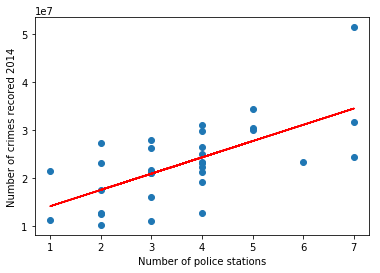

In [11]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
regr = linear_model.LinearRegression()

xx = lbp2['Police Station per Borough']
yy = lbp2['Crime total']

plt.scatter(xx, yy)

regr.fit(xx.values.reshape(-1, 1), yy.values.reshape(-1, 1))
Y_pred = regr.predict(xx.values.reshape(-1, 1))  

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)
plt.plot(xx, Y_pred, '-r')

plt.xlabel('Number of police stations')
plt.ylabel('Number of crimes recored 2014')
plt.show()



Step 11) Calculate r2_score for data above

In [12]:
from sklearn.metrics import r2_score
r2_score(yy, Y_pred)

0.41844199352817124

Step 12) Rank boroughs by crime rate per police station

In [14]:
lbp2['Crime rate per station'] = lbp2['Crime total']/lbp2['Police Station per Borough']
lbp2= lbp2.rename(columns = {"LBs check":"Borough"}) 
lbp2.sort_values(by = 'Crime rate per station', ascending = False )

,Area name,GLA Population Estimate 2017,Crime rates per thousand population 2014/15,Teenage conception rate (2014),"Male life expectancy, (2012-14)",Ambulance incidents per hundred population (2014),Life satisfaction score 2011-14 (out of 10),Rates of Children Looked After (2016),Modelled Household median income estimates 2012/13,Crime total,Police Station per Borough,Borough,Crime rate per station
30,Waltham Forest,276200,78.0107,26.2,79.4,11.6559,7.19,43,33080,2.15465e+07,1,Waltham Forest,2.15465e+07
11,Hackney,274300,99.6468,24.7,78.5,11.4534,7.03,53,35140,2.73331e+07,2,Hackney,1.36666e+07
9,Enfield,333000,69.3739,24.6,80.7,12.16,7.26,43,33110,2.31015e+07,2,Enfield,1.15508e+07
28,Sutton,202600,55.8561,17.3,80.9,11.2703,7.46,50,39940,1.13165e+07,1,Sutton,1.13165e+07
18,Islington,231200,121.224,20.2,79,13.9301,7.17,88,39790,2.8027e+07,3,Islington,9.34232e+06
3,Brent,332100,78.8019,18.5,80.1,12.0792,7.25,45,32140,2.61701e+07,3,Brent,8.72337e+06
0,Barking and Dagenham,209000,83.3591,32.4,77.6,13.6693,7.14,69,29420,1.7422e+07,2,Barking and Dagenham,8.71102e+06
24,Newham,342900,90.8188,22.5,78.5,12.2387,7.12,42,28780,3.11418e+07,4,Newham,7.78544e+06
7,Croydon,386500,77.0351,28.4,80.3,12.7975,7.10,86,37000,2.97741e+07,4,Croydon,7.44352e+06
32,Westminster,242100,212.413,15.4,82.3,19.9061,7.25,39,47510,5.14252e+07,7,Westminister,7.34646e+06
